# Image Label Dataset builder code

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import time as tm
import random
import math
import pandas as pd
from PIL import Image
from scipy.spatial.distance import pdist, squareform
import os
sym.init_printing(pretty_print = True)

strainDatabase = {}

In [19]:
class point: #Create a point, stores time and value at time.
    def __init__(self, value, time, drop):
        self.time = time
        self.drop = drop
        self.value = value
        self.alive = True
        self.dropval = value
        self.his = []
        self.dhis = []
         
    @property  
    def prop(self):
        return [self.time, self.value, self.drop]  
    @property    
    def isOdd(self): #Check if value is negative
        if self.time % 2 == 1: return True
        else: return False

def hysterisFilter(points, gateSize = 0.1):
    cleanedPoints = []
    for i in range(len(points)-1):
        if abs(points[i]-points[i+1]) >= gateSize:
            cleanedPoints.append(points[i])
    cleanedPoints.append(points[len(points)-1])
    
    return cleanedPoints

def peakValleyFilter(points):
    cleanedPoints = []
    cleanedPoints.append(points[0])
    for i in range(1,len(points)-1):
        if (points[i] > points[i+1] and points[i] > points[i-1]) or \
        (points[i] < points[i+1] and points[i] < points[i-1]):
            cleanedPoints.append(points[i])
    cleanedPoints.append(points[len(points)-1])
    
    return cleanedPoints

def discretize(points, roundVal = 3):
    cleanedPoints = []
    for p in points:
        cleanedPoints.append(round(p, roundVal))
        
    return cleanedPoints

def shifter(points):
    max = np.argmax(points)
    shifted = []
    for i in range(max, len(points)):
        shifted.append(points[i])
    for i in range(max):
        shifted.append(points[i])
        
    return shifted

def isBlocked(p,points):
    for i in range (p.time-1):
        if p.drop in points[i].his:
            #print('Blocked by', points[i].prop)
            return True
    return False

def dropMove(points):
    for p in points:
        #print('Drop Start:', p.time)
        
        #1. Check if the drop is not blocked by another drop path. 
        while p.alive == True:
            if isBlocked(p,points) == True: 
                p.alive = False
            
        #2. Check if drop is the last one, kill directly.
            elif p.time == len(points) - 1:
                p.alive = False           
                
        #3. Check if drop has reached end and is ready to roll off.
            elif (p.drop+2) >= len(points) and p.time != len(points)-2:
                if p.isOdd == False: p.drop = p.drop + 2
                else: p.drop = p.drop + 1
                p.his.append(p.drop)
                p.alive = False
        #5. Second last drop is always murdered by the first drop in a loop.    
            elif p.time == len(points)-2:
                    #print('Murdered by', points[0].prop)
                    p.drop = p.drop + 1
                    p.alive = False
                    
        #6. Drops in even positions should fall with greater negatives.
            elif p.isOdd == False:
                if p.value > points[p.drop+2].value:
                    p.drop = p.drop + 2
                else: 
                    #print('Murdered by', points[p.drop+2].prop)
                    p.drop = p.drop + 1
                    p.alive = False
       
        #7. Drops in odd positions should fall with greater positives.
            else:
                if p.value < points[p.drop+2].value:
                    p.drop = p.drop + 2
                else:
                    #print('Murdered by', points[p.drop+2].prop)
                    p.drop = p.drop + 1
                    p.alive = False
                    
        #8. Check if a falling drop hits a roof, and log this change in drop fall.            
            if p.drop+1 < len(points) and p.alive == True \
            and ((points[p.drop+1].value < points[p.drop-1].dropval and p.isOdd == False) \
            or (points[p.drop+1].value > points[p.drop-1].dropval and p.isOdd == True)):
                p.dropval = points[p.drop+1].value 
                p.his.append(p.drop)
                p.dhis.append(p.dropval)                
        #print('Movement history:', p.his, '\nDrop Value:', p.dhis, '\n')
        
    return points

def generate(length=200):
    y = 0
    result = []
    for _ in range(length):
        y += np.random.normal(scale=1)
        result.append(y)
        
    return np.array(result) 

def findLoops(points):
    results,pairs = [],[]
    for i in range(len(points)): 
        results.append(points[i].drop)
    for i in range(len(results)): 
        for j in range(i+1, len(results)):  
            if (results[i] == results[j]): 
                pairs.append([i,j])
                
    return pairs 

def setUpTable(points,pairs):
    smin, smax, smean, samp, sdel = [],[],[],[],[]
    for i in range(len(pairs)):
        smin.append(min(points[pairs[i][0]].value,points[pairs[i][1]].value)) 
        smax.append(max(points[pairs[i][0]].value,points[pairs[i][1]].value))
        smean.append((points[pairs[i][1]].value + points[pairs[i][0]].value) / 2)
        samp.append((smax[i] - smin[i]) / 2)
        sdel.append(2*samp[i])
        
    return [smin, smax, smean, samp, sdel]

def strainDatabaseUpdate(esp, life):
    strainDatabase[esp] = life
    return None
    
def strainDatabaseFind(esp):
    if esp in strainDatabase:
        life = strainDatabase[esp]
        return True, life
    else:
        return False, -1
    
def mySolve(eq, N):
    key = 1000
    pos = 100
    solution = eq.subs({N : key})
    
    while abs(solution) > 10**-12:
        shift = key/pos
        oldSol = solution
        solution = eq.subs({N : key})
        
        #Drop shift value by factor of 10 to increase accuracy towards approaching solution
        if (oldSol < 0 and solution > 0) or (oldSol > 0 and solution < 0): pos = pos*10
        #print(solution)
        if solution > 0:
            key = key - shift
        else: 
            key = key + shift

    return key

def fatigueList(sresults, substitutions):
    fatigue = []
    N, sig, D, E, esp = sym.symbols('N σ D E Δε')
    f = esp - (3.5*(sig/E)*N**(-0.12) + D**(0.6)*N**(-0.6))
    #To display equation
    #display(f)

    for e in sresults[4]:
        e = round(e,2)
        #print(e)
        subs = {sig:substitutions[0], D:substitutions[1], E:substitutions[2], esp:e*10**-3}
        es = e*10**-3
        start_time = tm.time()
        exists = strainDatabaseFind(es)
        if exists[0] == False:
            fa = f.subs(subs)
            #Use to view substitutions, especially if execution takes too long.
            #print(subs)
            life = mySolve(fa, N)
            strainDatabaseUpdate(es, life)
        else:
            #print("Found ",e," in Database!")
            life = exists[1]
            
        fatigue.append(life)
        #Use to print time taken to solve
        #print("--- %s seconds ---" % (tm.time() - start_time))

    return fatigue

def runner(p, substitutions):    
    clean = peakValleyFilter(shifter(discretize(peakValleyFilter(hysterisFilter(p)))))
    
    points = []
    for i in range(len(clean)): points.append(point(clean[i],i,i))    
    cleanUp = dropMove(points)
    sresults = setUpTable(cleanUp, findLoops(cleanUp))
    
    D = 0
    for fa in fatigueList(sresults, substitutions): D = D + 1/fa
    I = 1/D

    return I

def populate(length=100):
    #p = generate(random.randint(10,1000))    #This gets replaced by actual data
    p = generate(length)
    sig = 430*10**6
    psi = .65
    D = math.log(1/(1-psi))
    E = 205*10**9 
    substitutions = [sig, D, E]

    results = runner(p, substitutions)
    
    return p, sig, D, E, results

def rec_plot(s, path):
    eps=0.4
    steps=40
    N = s.size
    S = np.repeat(s[None,:], N, axis=0)
    Z = np.floor(np.abs(S-S.T)/eps)
    Z[Z>steps] = steps
    img = Image.fromarray(np.uint8(Z * 255), 'L')
    img = img.resize((100,100), Image.ANTIALIAS)
    img.save(path)
    

def project(s, path):
    length = len(s)
    x = np.arange(0, length+1, 1)
    y = s
    y = np.append(y, y[0])
    r,t = [y, 2*np.pi*x/(len(x)-1)]
    with plt.rc_context({"figure.figsize": [10,10]}):
        fig = plt.figure('Circular')
        plt.subplot(projection='polar')
        plt.plot(t,r, color='black')
        plt.axis('off')  
        plt.savefig(path, bbox_inches='tight')
        plt.clf()
        
def cleanRec(s, path):
    s = np.array(peakValleyFilter(shifter(discretize(peakValleyFilter(hysterisFilter(s))))))
    rec_plot(s, path)

def label(life):
    bin_size = 1
    lab = int(int(life)/bin_size)*bin_size
    folder = 'DatasetV5'
    file_ext = '.png'
    filename = str(lab)
    conversion = ['recplot','projection','cleanrec']
    path = [None]*3
    
    for i in range(3):
        path[i] = '%s/%s/%s%s' % (folder, conversion[i], filename, file_ext)
        uniq = 1
        while os.path.exists(path[i]):
            path[i] = '%s/%s/%s_%d%s' % (folder, conversion[i], filename, uniq, file_ext)
            uniq += 1
        
    return path

Iteration:  0
Number of approximate solver sequences for size 100 : 2147.1281905374613
Runtime: 39.28595495223999 seconds
Iteration:  1
Number of approximate solver sequences for size 100 : 1679.0774175650677
Runtime: 47.37505125999451 seconds
Iteration:  2
Number of approximate solver sequences for size 100 : 1133.7650614139143
Runtime: 50.9788076877594 seconds
Iteration:  3
Number of approximate solver sequences for size 100 : 1325.448747336905
Runtime: 23.043806552886963 seconds
Iteration:  4
Number of approximate solver sequences for size 100 : 1474.8516459653288
Runtime: 16.044828414916992 seconds
Iteration:  5
Number of approximate solver sequences for size 100 : 635.5147195909407
Runtime: 19.75184988975525 seconds
Iteration:  6
Number of approximate solver sequences for size 100 : 1285.3210930935193
Runtime: 14.21985650062561 seconds
Iteration:  7
Number of approximate solver sequences for size 100 : 1626.2151422525312
Runtime: 17.232131004333496 seconds
Iteration:  8
Number of 

Iteration:  67
Number of approximate solver sequences for size 100 : 2218.3167808934463
Runtime: 1.6360626220703125 seconds
Iteration:  68
Number of approximate solver sequences for size 100 : 2037.8124933100596
Runtime: 1.146658182144165 seconds
Iteration:  69
Number of approximate solver sequences for size 100 : 1397.7833849450149
Runtime: 1.4551668167114258 seconds
Iteration:  70
Number of approximate solver sequences for size 100 : 665.7175679273981
Runtime: 2.0284061431884766 seconds
Iteration:  71
Number of approximate solver sequences for size 100 : 1316.823864143481
Runtime: 6.421764850616455 seconds
Iteration:  72
Number of approximate solver sequences for size 100 : 1152.7164854761486
Runtime: 2.913707733154297 seconds
Iteration:  73
Number of approximate solver sequences for size 100 : 888.6364570504463
Runtime: 0.24985790252685547 seconds
Iteration:  74
Number of approximate solver sequences for size 100 : 4630.11735332118
Runtime: 0.8155319690704346 seconds
Iteration:  75


Iteration:  134
Number of approximate solver sequences for size 100 : 1837.738039775149
Runtime: 2.0452630519866943 seconds
Iteration:  135
Number of approximate solver sequences for size 100 : 1308.743696956294
Runtime: 0.533724308013916 seconds
Iteration:  136
Number of approximate solver sequences for size 100 : 4239.712599428077
Runtime: 0.6486287117004395 seconds
Iteration:  137
Number of approximate solver sequences for size 100 : 3163.118165689415
Runtime: 1.6970596313476562 seconds
Iteration:  138
Number of approximate solver sequences for size 100 : 238.1770535165435
Runtime: 2.903337240219116 seconds
Iteration:  139
Number of approximate solver sequences for size 100 : 874.6293655408224
Runtime: 2.6228713989257812 seconds
Iteration:  140
Number of approximate solver sequences for size 100 : 1548.990892247261
Runtime: 0.8205826282501221 seconds
Iteration:  141
Number of approximate solver sequences for size 100 : 1726.8344887575286
Runtime: 0.47800278663635254 seconds
Iteratio

Iteration:  200
Number of approximate solver sequences for size 100 : 1890.4087885094655
Runtime: 0.29182887077331543 seconds
Iteration:  201
Number of approximate solver sequences for size 100 : 2133.6410768941632
Runtime: 0.8341877460479736 seconds
Iteration:  202
Number of approximate solver sequences for size 100 : 1483.5336195136083
Runtime: 0.4329030513763428 seconds
Iteration:  203
Number of approximate solver sequences for size 100 : 2168.9218986715186
Runtime: 0.2854270935058594 seconds
Iteration:  204
Number of approximate solver sequences for size 100 : 646.9163723693305
Runtime: 0.45755934715270996 seconds
Iteration:  205
Number of approximate solver sequences for size 100 : 1148.5616166877005
Runtime: 0.41576170921325684 seconds
Iteration:  206
Number of approximate solver sequences for size 100 : 1821.8233668443747
Runtime: 0.485720157623291 seconds
Iteration:  207
Number of approximate solver sequences for size 100 : 769.2495791442483
Runtime: 0.548654317855835 seconds
I

Iteration:  266
Number of approximate solver sequences for size 100 : 626.9090998586466
Runtime: 0.7229833602905273 seconds
Iteration:  267
Number of approximate solver sequences for size 100 : 5173.70072394215
Runtime: 0.5466873645782471 seconds
Iteration:  268
Number of approximate solver sequences for size 100 : 1055.641222160448
Runtime: 0.5017118453979492 seconds
Iteration:  269
Number of approximate solver sequences for size 100 : 2553.888650801642
Runtime: 0.48777270317077637 seconds
Iteration:  270
Number of approximate solver sequences for size 100 : 994.5956877878635
Runtime: 0.41776061058044434 seconds
Iteration:  271
Number of approximate solver sequences for size 100 : 29681.97572702364
Runtime: 0.1720445156097412 seconds
Iteration:  272
Number of approximate solver sequences for size 100 : 772.2683024740686
Runtime: 0.32779932022094727 seconds
Iteration:  273
Number of approximate solver sequences for size 100 : 1327.5809396441327
Runtime: 0.3136777877807617 seconds
Itera

Iteration:  332
Number of approximate solver sequences for size 100 : 868.5129087667841
Runtime: 0.8085346221923828 seconds
Iteration:  333
Number of approximate solver sequences for size 100 : 950.419617093422
Runtime: 0.3967747688293457 seconds
Iteration:  334
Number of approximate solver sequences for size 100 : 3476.260106462161
Runtime: 0.7375750541687012 seconds
Iteration:  335
Number of approximate solver sequences for size 100 : 3399.3845919422274
Runtime: 1.3133163452148438 seconds
Iteration:  336
Number of approximate solver sequences for size 100 : 1298.424489752026
Runtime: 0.4038729667663574 seconds
Iteration:  337
Number of approximate solver sequences for size 100 : 1756.5624276801886
Runtime: 1.1423437595367432 seconds
Iteration:  338
Number of approximate solver sequences for size 100 : 706.6341006021046
Runtime: 0.4207594394683838 seconds
Iteration:  339
Number of approximate solver sequences for size 100 : 1464.5947810279035
Runtime: 0.368788480758667 seconds
Iterati

Iteration:  398
Number of approximate solver sequences for size 100 : 1080.7377700056095
Runtime: 0.5356936454772949 seconds
Iteration:  399
Number of approximate solver sequences for size 100 : 2081.86340868802
Runtime: 0.863506555557251 seconds
Iteration:  400
Number of approximate solver sequences for size 100 : 708.738037661612
Runtime: 0.4787261486053467 seconds
Iteration:  401
Number of approximate solver sequences for size 100 : 1046.4652796812936
Runtime: 0.3967711925506592 seconds
Iteration:  402
Number of approximate solver sequences for size 100 : 480.3630730491174
Runtime: 0.43974804878234863 seconds
Iteration:  403
Number of approximate solver sequences for size 100 : 2457.011473408697
Runtime: 0.19688773155212402 seconds
Iteration:  404
Number of approximate solver sequences for size 100 : 663.3919407634687
Runtime: 0.45860934257507324 seconds
Iteration:  405
Number of approximate solver sequences for size 100 : 1210.9901671627795
Runtime: 1.2893154621124268 seconds
Itera

Iteration:  464
Number of approximate solver sequences for size 100 : 1283.9973283497216
Runtime: 0.4668118953704834 seconds
Iteration:  465
Number of approximate solver sequences for size 100 : 931.6549361030404
Runtime: 0.17420101165771484 seconds
Iteration:  466
Number of approximate solver sequences for size 100 : 791.2400796707183
Runtime: 1.6930975914001465 seconds
Iteration:  467
Number of approximate solver sequences for size 100 : 2178.5358239625702
Runtime: 1.8189587593078613 seconds
Iteration:  468
Number of approximate solver sequences for size 100 : 284.71649532407093
Runtime: 0.7406933307647705 seconds
Iteration:  469
Number of approximate solver sequences for size 100 : 2275.7194417044993
Runtime: 0.41124749183654785 seconds
Iteration:  470
Number of approximate solver sequences for size 100 : 1745.3076479784454
Runtime: 0.314831018447876 seconds
Iteration:  471
Number of approximate solver sequences for size 100 : 831.0400860106568
Runtime: 0.4184424877166748 seconds
It

Iteration:  530
Number of approximate solver sequences for size 100 : 1280.2482806919447
Runtime: 0.4777846336364746 seconds
Iteration:  531
Number of approximate solver sequences for size 100 : 2301.6667905376157
Runtime: 1.177668809890747 seconds
Iteration:  532
Number of approximate solver sequences for size 100 : 2401.418437591288
Runtime: 0.16690587997436523 seconds
Iteration:  533
Number of approximate solver sequences for size 100 : 412.71079082226066
Runtime: 0.76857590675354 seconds
Iteration:  534
Number of approximate solver sequences for size 100 : 1437.1631865753366
Runtime: 2.0885186195373535 seconds
Iteration:  535
Number of approximate solver sequences for size 100 : 1494.2456487608886
Runtime: 0.48247456550598145 seconds
Iteration:  536
Number of approximate solver sequences for size 100 : 3561.9835422871124
Runtime: 0.25100111961364746 seconds
Iteration:  537
Number of approximate solver sequences for size 100 : 331.4073367955165
Runtime: 0.5942234992980957 seconds
It

Iteration:  596
Number of approximate solver sequences for size 100 : 1653.8206817312823
Runtime: 0.2643313407897949 seconds
Iteration:  597
Number of approximate solver sequences for size 100 : 2876.5508387603577
Runtime: 0.4174830913543701 seconds
Iteration:  598
Number of approximate solver sequences for size 100 : 1834.858204543146
Runtime: 0.3992137908935547 seconds
Iteration:  599
Number of approximate solver sequences for size 100 : 1289.45590421811
Runtime: 0.5867538452148438 seconds
Iteration:  600
Number of approximate solver sequences for size 100 : 1168.8071710656586
Runtime: 0.38984251022338867 seconds
Iteration:  601
Number of approximate solver sequences for size 100 : 2254.7242625891536
Runtime: 0.4573676586151123 seconds
Iteration:  602
Number of approximate solver sequences for size 100 : 1477.6695108071553
Runtime: 0.4031667709350586 seconds
Iteration:  603
Number of approximate solver sequences for size 100 : 1782.1778484468243
Runtime: 0.41320252418518066 seconds
I

Iteration:  662
Number of approximate solver sequences for size 100 : 2382.8288382000724
Runtime: 0.5385885238647461 seconds
Iteration:  663
Number of approximate solver sequences for size 100 : 900.3476915119599
Runtime: 0.17496871948242188 seconds
Iteration:  664
Number of approximate solver sequences for size 100 : 2066.883408316439
Runtime: 0.18309640884399414 seconds
Iteration:  665
Number of approximate solver sequences for size 100 : 868.5313119790828
Runtime: 0.5318820476531982 seconds
Iteration:  666
Number of approximate solver sequences for size 100 : 1860.6677244926805
Runtime: 0.24428439140319824 seconds
Iteration:  667
Number of approximate solver sequences for size 100 : 4702.758045049622
Runtime: 0.542776346206665 seconds
Iteration:  668
Number of approximate solver sequences for size 100 : 1423.5064602449313
Runtime: 0.30582165718078613 seconds
Iteration:  669
Number of approximate solver sequences for size 100 : 950.2005539425014
Runtime: 1.5881156921386719 seconds
It

Iteration:  728
Number of approximate solver sequences for size 100 : 3067.6085577191643
Runtime: 0.5686752796173096 seconds
Iteration:  729
Number of approximate solver sequences for size 100 : 3432.689252193213
Runtime: 0.4647340774536133 seconds
Iteration:  730
Number of approximate solver sequences for size 100 : 1535.7372250060594
Runtime: 0.3438296318054199 seconds
Iteration:  731
Number of approximate solver sequences for size 100 : 3628.0330823356344
Runtime: 0.2194676399230957 seconds
Iteration:  732
Number of approximate solver sequences for size 100 : 1172.4216007371654
Runtime: 0.5010204315185547 seconds
Iteration:  733
Number of approximate solver sequences for size 100 : 9096.064761091637
Runtime: 0.6947896480560303 seconds
Iteration:  734
Number of approximate solver sequences for size 100 : 3241.902703558625
Runtime: 0.45334506034851074 seconds
Iteration:  735
Number of approximate solver sequences for size 100 : 2007.847172615714
Runtime: 0.18703293800354004 seconds
It

Iteration:  794
Number of approximate solver sequences for size 100 : 676.3447181959294
Runtime: 0.3847782611846924 seconds
Iteration:  795
Number of approximate solver sequences for size 100 : 1226.2987553048579
Runtime: 0.3050103187561035 seconds
Iteration:  796
Number of approximate solver sequences for size 100 : 4989.027417850771
Runtime: 1.1488029956817627 seconds
Iteration:  797
Number of approximate solver sequences for size 100 : 48272.647588420936
Runtime: 0.34531497955322266 seconds
Iteration:  798
Number of approximate solver sequences for size 100 : 1154.345359096081
Runtime: 0.9676885604858398 seconds
Iteration:  799
Number of approximate solver sequences for size 100 : 1392.6076766580497
Runtime: 0.5062005519866943 seconds
Iteration:  800
Number of approximate solver sequences for size 100 : 1402.441621881222
Runtime: 0.6324059963226318 seconds
Iteration:  801
Number of approximate solver sequences for size 100 : 2803.3086467601065
Runtime: 0.5698544979095459 seconds
Ite

Iteration:  860
Number of approximate solver sequences for size 100 : 1998.8911288002375
Runtime: 0.7106735706329346 seconds
Iteration:  861
Number of approximate solver sequences for size 100 : 1963.5797404102134
Runtime: 0.44174718856811523 seconds
Iteration:  862
Number of approximate solver sequences for size 100 : 434.63133858173984
Runtime: 0.22204303741455078 seconds
Iteration:  863
Number of approximate solver sequences for size 100 : 743.0907261978051
Runtime: 0.3861510753631592 seconds
Iteration:  864
Number of approximate solver sequences for size 100 : 708.1411126891244
Runtime: 0.49283552169799805 seconds
Iteration:  865
Number of approximate solver sequences for size 100 : 6579.736662639682
Runtime: 0.6368250846862793 seconds
Iteration:  866
Number of approximate solver sequences for size 100 : 1753.9501495263
Runtime: 0.4777958393096924 seconds
Iteration:  867
Number of approximate solver sequences for size 100 : 2880.3116015148876
Runtime: 0.4269876480102539 seconds
Ite

Iteration:  926
Number of approximate solver sequences for size 100 : 2567.087764003712
Runtime: 0.16895198822021484 seconds
Iteration:  927
Number of approximate solver sequences for size 100 : 1977.9708887987204
Runtime: 0.4609403610229492 seconds
Iteration:  928
Number of approximate solver sequences for size 100 : 1345.4185718190543
Runtime: 0.4268798828125 seconds
Iteration:  929
Number of approximate solver sequences for size 100 : 1116.8149814531998
Runtime: 0.7712395191192627 seconds
Iteration:  930
Number of approximate solver sequences for size 100 : 5223.8449792320735
Runtime: 0.5117557048797607 seconds
Iteration:  931
Number of approximate solver sequences for size 100 : 477.69080344191354
Runtime: 0.7182369232177734 seconds
Iteration:  932
Number of approximate solver sequences for size 100 : 4565.700834689689
Runtime: 0.7006626129150391 seconds
Iteration:  933
Number of approximate solver sequences for size 100 : 1684.0712985926716
Runtime: 1.3913469314575195 seconds
Iter

Iteration:  992
Number of approximate solver sequences for size 100 : 1306.0219714833756
Runtime: 0.39177632331848145 seconds
Iteration:  993
Number of approximate solver sequences for size 100 : 838.3735908837629
Runtime: 0.47182774543762207 seconds
Iteration:  994
Number of approximate solver sequences for size 100 : 1352.136751735527
Runtime: 0.19402503967285156 seconds
Iteration:  995
Number of approximate solver sequences for size 100 : 3312.524357118723
Runtime: 0.19588780403137207 seconds
Iteration:  996
Number of approximate solver sequences for size 100 : 468.87164419149906
Runtime: 0.42818498611450195 seconds
Iteration:  997
Number of approximate solver sequences for size 100 : 2289.1318076247726
Runtime: 0.19116783142089844 seconds
Iteration:  998
Number of approximate solver sequences for size 100 : 1036.5103647915957
Runtime: 0.3476135730743408 seconds
Iteration:  999
Number of approximate solver sequences for size 100 : 3760.813068038786
Runtime: 0.591660737991333 seconds

Iteration:  1058
Number of approximate solver sequences for size 100 : 1058.5869052018984
Runtime: 0.20088410377502441 seconds
Iteration:  1059
Number of approximate solver sequences for size 100 : 920.2872456597436
Runtime: 0.20788240432739258 seconds
Iteration:  1060
Number of approximate solver sequences for size 100 : 3805.2474167433224
Runtime: 0.2408607006072998 seconds
Iteration:  1061
Number of approximate solver sequences for size 100 : 21669.909430108375
Runtime: 0.26784610748291016 seconds
Iteration:  1062
Number of approximate solver sequences for size 100 : 2932.625632847521
Runtime: 0.37778353691101074 seconds
Iteration:  1063
Number of approximate solver sequences for size 100 : 1054.2503858708073
Runtime: 0.529695987701416 seconds
Iteration:  1064
Number of approximate solver sequences for size 100 : 2700.783286628335
Runtime: 0.19588899612426758 seconds
Iteration:  1065
Number of approximate solver sequences for size 100 : 1114.9402018289898
Runtime: 0.2108786106109619

Iteration:  1125
Number of approximate solver sequences for size 100 : 2252.213252793213
Runtime: 0.20186567306518555 seconds
Iteration:  1126
Number of approximate solver sequences for size 100 : 1550.1640019986123
Runtime: 0.21791386604309082 seconds
Iteration:  1127
Number of approximate solver sequences for size 100 : 1922.9380797370509
Runtime: 0.31052494049072266 seconds
Iteration:  1128
Number of approximate solver sequences for size 100 : 1963.5502380027224
Runtime: 0.5183148384094238 seconds
Iteration:  1129
Number of approximate solver sequences for size 100 : 2037.762996453037
Runtime: 0.2719752788543701 seconds
Iteration:  1130
Number of approximate solver sequences for size 100 : 1846.547276602629
Runtime: 0.22731685638427734 seconds
Iteration:  1131
Number of approximate solver sequences for size 100 : 1826.9650581311978
Runtime: 0.23229050636291504 seconds
Iteration:  1132
Number of approximate solver sequences for size 100 : 560.9132656921404
Runtime: 0.8007967472076416

Iteration:  1191
Number of approximate solver sequences for size 100 : 2895.875665416916
Runtime: 0.19388914108276367 seconds
Iteration:  1192
Number of approximate solver sequences for size 100 : 1019.7341702132513
Runtime: 0.1995563507080078 seconds
Iteration:  1193
Number of approximate solver sequences for size 100 : 1942.3882558926991
Runtime: 0.5430302619934082 seconds
Iteration:  1194
Number of approximate solver sequences for size 100 : 2115.7558386477276
Runtime: 0.21941518783569336 seconds
Iteration:  1195
Number of approximate solver sequences for size 100 : 1135.6387885786467
Runtime: 0.2288668155670166 seconds
Iteration:  1196
Number of approximate solver sequences for size 100 : 1360.6612776527418
Runtime: 0.2149055004119873 seconds
Iteration:  1197
Number of approximate solver sequences for size 100 : 1999.6809851442438
Runtime: 0.24088811874389648 seconds
Iteration:  1198
Number of approximate solver sequences for size 100 : 2828.8903344102255
Runtime: 0.212879419326782

Iteration:  1257
Number of approximate solver sequences for size 100 : 1701.3583929120264
Runtime: 0.20488214492797852 seconds
Iteration:  1258
Number of approximate solver sequences for size 100 : 915.1477508337188
Runtime: 0.47472691535949707 seconds
Iteration:  1259
Number of approximate solver sequences for size 100 : 519.9858687296136
Runtime: 0.5187289714813232 seconds
Iteration:  1260
Number of approximate solver sequences for size 100 : 1068.837321470292
Runtime: 0.5891861915588379 seconds
Iteration:  1261
Number of approximate solver sequences for size 100 : 914.0941780562679
Runtime: 0.39769506454467773 seconds
Iteration:  1262
Number of approximate solver sequences for size 100 : 2730.124178870026
Runtime: 0.6589517593383789 seconds
Iteration:  1263
Number of approximate solver sequences for size 100 : 1594.5998557793462
Runtime: 0.7506074905395508 seconds
Iteration:  1264
Number of approximate solver sequences for size 100 : 739.9801878764238
Runtime: 0.48172473907470703 se

Iteration:  1323
Number of approximate solver sequences for size 100 : 3748.4874975646735
Runtime: 0.6236436367034912 seconds
Iteration:  1324
Number of approximate solver sequences for size 100 : 2121.8544327238487
Runtime: 0.1768965721130371 seconds
Iteration:  1325
Number of approximate solver sequences for size 100 : 1710.8798141271948
Runtime: 0.18389558792114258 seconds
Iteration:  1326
Number of approximate solver sequences for size 100 : 1019.1962231333698
Runtime: 0.3028273582458496 seconds
Iteration:  1327
Number of approximate solver sequences for size 100 : 1634.555586162725
Runtime: 0.19588828086853027 seconds
Iteration:  1328
Number of approximate solver sequences for size 100 : 651.7313329214525
Runtime: 0.5103549957275391 seconds
Iteration:  1329
Number of approximate solver sequences for size 100 : 1357.5203614282552
Runtime: 0.3124992847442627 seconds
Iteration:  1330
Number of approximate solver sequences for size 100 : 3464.1662687952917
Runtime: 0.6116375923156738 

Iteration:  1389
Number of approximate solver sequences for size 100 : 1096.1169933168126
Runtime: 0.19388985633850098 seconds
Iteration:  1390
Number of approximate solver sequences for size 100 : 1100.8543710701565
Runtime: 0.5457231998443604 seconds
Iteration:  1391
Number of approximate solver sequences for size 100 : 2240.8931436209796
Runtime: 0.6914718151092529 seconds
Iteration:  1392
Number of approximate solver sequences for size 100 : 16972.71540831586
Runtime: 0.1589641571044922 seconds
Iteration:  1393
Number of approximate solver sequences for size 100 : 2257.064218429413
Runtime: 0.16890358924865723 seconds
Iteration:  1394
Number of approximate solver sequences for size 100 : 1055.8351654403941
Runtime: 0.16492128372192383 seconds
Iteration:  1395
Number of approximate solver sequences for size 100 : 1657.338969741858
Runtime: 0.20170092582702637 seconds
Iteration:  1396
Number of approximate solver sequences for size 100 : 1232.6254720022985
Runtime: 0.1848936080932617

Iteration:  1455
Number of approximate solver sequences for size 100 : 834.8061714072178
Runtime: 0.3234236240386963 seconds
Iteration:  1456
Number of approximate solver sequences for size 100 : 1703.8166788795054
Runtime: 0.15724897384643555 seconds
Iteration:  1457
Number of approximate solver sequences for size 100 : 1906.464212776807
Runtime: 0.23006701469421387 seconds
Iteration:  1458
Number of approximate solver sequences for size 100 : 1366.4882504180694
Runtime: 0.3529670238494873 seconds
Iteration:  1459
Number of approximate solver sequences for size 100 : 2847.4115554755654
Runtime: 0.16190719604492188 seconds
Iteration:  1460
Number of approximate solver sequences for size 100 : 2291.3470688322486
Runtime: 0.24547791481018066 seconds
Iteration:  1461
Number of approximate solver sequences for size 100 : 1796.6443508214738
Runtime: 0.3496840000152588 seconds
Iteration:  1462
Number of approximate solver sequences for size 100 : 1568.1249695617873
Runtime: 0.262255191802978

Runtime: 0.18689179420471191 seconds
Iteration:  1522
Number of approximate solver sequences for size 100 : 1462.6829464116076
Runtime: 2.5857443809509277 seconds
Iteration:  1523
Number of approximate solver sequences for size 100 : 1739.527643562549
Runtime: 0.41374731063842773 seconds
Iteration:  1524
Number of approximate solver sequences for size 100 : 12694.604824039498
Runtime: 0.17490196228027344 seconds
Iteration:  1525
Number of approximate solver sequences for size 100 : 4468.088410599343
Runtime: 0.20987892150878906 seconds
Iteration:  1526
Number of approximate solver sequences for size 100 : 864.5545677176655
Runtime: 0.32781124114990234 seconds
Iteration:  1527
Number of approximate solver sequences for size 100 : 1268.9245291641969
Runtime: 0.5436899662017822 seconds
Iteration:  1528
Number of approximate solver sequences for size 100 : 2861.671819753456
Runtime: 0.19888663291931152 seconds
Iteration:  1529
Number of approximate solver sequences for size 100 : 1816.4084

Iteration:  1587
Number of approximate solver sequences for size 100 : 1255.8457880522594
Runtime: 0.4059147834777832 seconds
Iteration:  1588
Number of approximate solver sequences for size 100 : 393.69826460485865
Runtime: 0.3527798652648926 seconds
Iteration:  1589
Number of approximate solver sequences for size 100 : 2809.8398303483045
Runtime: 0.6047022342681885 seconds
Iteration:  1590
Number of approximate solver sequences for size 100 : 993.2732780422177
Runtime: 0.22716951370239258 seconds
Iteration:  1591
Number of approximate solver sequences for size 100 : 992.469891826031
Runtime: 0.16514945030212402 seconds
Iteration:  1592
Number of approximate solver sequences for size 100 : 2515.697061115262
Runtime: 0.18689322471618652 seconds
Iteration:  1593
Number of approximate solver sequences for size 100 : 2466.8419200623985
Runtime: 0.294905424118042 seconds
Iteration:  1594
Number of approximate solver sequences for size 100 : 1445.701805138657
Runtime: 0.1669011116027832 sec

Iteration:  1654
Number of approximate solver sequences for size 100 : 2908.0757460394407
Runtime: 0.2088778018951416 seconds
Iteration:  1655
Number of approximate solver sequences for size 100 : 2161.86319470758
Runtime: 0.20198726654052734 seconds
Iteration:  1656
Number of approximate solver sequences for size 100 : 3484.2010330767625
Runtime: 0.17989730834960938 seconds
Iteration:  1657
Number of approximate solver sequences for size 100 : 3873.1952506155135
Runtime: 0.2599008083343506 seconds
Iteration:  1658
Number of approximate solver sequences for size 100 : 1138.7249862202348
Runtime: 0.20498394966125488 seconds
Iteration:  1659
Number of approximate solver sequences for size 100 : 2367.859805604689
Runtime: 0.3241550922393799 seconds
Iteration:  1660
Number of approximate solver sequences for size 100 : 2456.572439871486
Runtime: 0.2059493064880371 seconds
Iteration:  1661
Number of approximate solver sequences for size 100 : 2427.3760140058816
Runtime: 0.23546743392944336 

Iteration:  1719
Number of approximate solver sequences for size 100 : 3071.3679024925814
Runtime: 0.24286103248596191 seconds
Iteration:  1720
Number of approximate solver sequences for size 100 : 2350.9361013836397
Runtime: 0.6766147613525391 seconds
Iteration:  1721
Number of approximate solver sequences for size 100 : 4599.794691763745
Runtime: 0.23586225509643555 seconds
Iteration:  1722
Number of approximate solver sequences for size 100 : 3155.452259046623
Runtime: 0.5127067565917969 seconds
Iteration:  1723
Number of approximate solver sequences for size 100 : 1914.339402002882
Runtime: 0.23786449432373047 seconds
Iteration:  1724
Number of approximate solver sequences for size 100 : 1713.8504552768932
Runtime: 0.31287050247192383 seconds
Iteration:  1725
Number of approximate solver sequences for size 100 : 1050.650306705589
Runtime: 0.4539008140563965 seconds
Iteration:  1726
Number of approximate solver sequences for size 100 : 1511.0681347387963
Runtime: 0.16993474960327148

Iteration:  1785
Number of approximate solver sequences for size 100 : 769.5747164887919
Runtime: 0.3587954044342041 seconds
Iteration:  1786
Number of approximate solver sequences for size 100 : 2033.147117564239
Runtime: 0.16390609741210938 seconds
Iteration:  1787
Number of approximate solver sequences for size 100 : 483.20772263106824
Runtime: 0.6037578582763672 seconds
Iteration:  1788
Number of approximate solver sequences for size 100 : 2544.4459138980324
Runtime: 0.17068004608154297 seconds
Iteration:  1789
Number of approximate solver sequences for size 100 : 1578.4358381439954
Runtime: 0.1755826473236084 seconds
Iteration:  1790
Number of approximate solver sequences for size 100 : 1417.8856369237842
Runtime: 0.4008357524871826 seconds
Iteration:  1791
Number of approximate solver sequences for size 100 : 2016.465624518442
Runtime: 0.18689274787902832 seconds
Iteration:  1792
Number of approximate solver sequences for size 100 : 893.1045959275438
Runtime: 0.17171287536621094 

Iteration:  1850
Number of approximate solver sequences for size 100 : 2555.4417914729447
Runtime: 0.2558634281158447 seconds
Iteration:  1851
Number of approximate solver sequences for size 100 : 3930.6232234815093
Runtime: 0.5436797142028809 seconds
Iteration:  1852
Number of approximate solver sequences for size 100 : 2867.072023032565
Runtime: 0.18689179420471191 seconds
Iteration:  1853
Number of approximate solver sequences for size 100 : 1327.9949913864614
Runtime: 0.23253083229064941 seconds
Iteration:  1854
Number of approximate solver sequences for size 100 : 1853.0362098052494
Runtime: 0.20188546180725098 seconds
Iteration:  1855
Number of approximate solver sequences for size 100 : 1896.8513257165587
Runtime: 0.17781567573547363 seconds
Iteration:  1856
Number of approximate solver sequences for size 100 : 991.2157757596779
Runtime: 0.5187027454376221 seconds
Iteration:  1857
Number of approximate solver sequences for size 100 : 1788.984572338345
Runtime: 0.2088797092437744

Iteration:  1915
Number of approximate solver sequences for size 100 : 2035.850836630286
Runtime: 0.30216217041015625 seconds
Iteration:  1916
Number of approximate solver sequences for size 100 : 1278.4214970210235
Runtime: 0.5344798564910889 seconds
Iteration:  1917
Number of approximate solver sequences for size 100 : 1760.61263016278
Runtime: 0.18203282356262207 seconds
Iteration:  1918
Number of approximate solver sequences for size 100 : 2276.7650149111614
Runtime: 0.18189501762390137 seconds
Iteration:  1919
Number of approximate solver sequences for size 100 : 2111.951053833055
Runtime: 0.25203633308410645 seconds
Iteration:  1920
Number of approximate solver sequences for size 100 : 819.8389280895648
Runtime: 0.28067827224731445 seconds
Iteration:  1921
Number of approximate solver sequences for size 100 : 295.8213990887008
Runtime: 0.7105960845947266 seconds
Iteration:  1922
Number of approximate solver sequences for size 100 : 1182.1481920300603
Runtime: 0.46686553955078125 

Iteration:  1981
Number of approximate solver sequences for size 100 : 1295.9484275022262
Runtime: 0.7715606689453125 seconds
Iteration:  1982
Number of approximate solver sequences for size 100 : 2142.831753659152
Runtime: 0.23186492919921875 seconds
Iteration:  1983
Number of approximate solver sequences for size 100 : 775.7177440681443
Runtime: 1.456167221069336 seconds
Iteration:  1984
Number of approximate solver sequences for size 100 : 1244.1743756329822
Runtime: 0.26584696769714355 seconds
Iteration:  1985
Number of approximate solver sequences for size 100 : 615.0663214969705
Runtime: 0.5826656818389893 seconds
Iteration:  1986
Number of approximate solver sequences for size 100 : 1687.9537650579616
Runtime: 0.3460566997528076 seconds
Iteration:  1987
Number of approximate solver sequences for size 100 : 724.1154042609763
Runtime: 0.5300610065460205 seconds
Iteration:  1988
Number of approximate solver sequences for size 100 : 3284.041107789399
Runtime: 0.16190719604492188 sec

Iteration:  2047
Number of approximate solver sequences for size 100 : 940.382511106464
Runtime: 0.3768007755279541 seconds
Iteration:  2048
Number of approximate solver sequences for size 100 : 4788.458029054963
Runtime: 0.5886988639831543 seconds
Iteration:  2049
Number of approximate solver sequences for size 100 : 2283.047111400597
Runtime: 0.2341752052307129 seconds
Iteration:  2050
Number of approximate solver sequences for size 100 : 2292.2358435794895
Runtime: 0.18300294876098633 seconds
Iteration:  2051
Number of approximate solver sequences for size 100 : 3812.977891203396
Runtime: 0.1799006462097168 seconds
Iteration:  2052
Number of approximate solver sequences for size 100 : 3808.577052791324
Runtime: 0.19791603088378906 seconds
Iteration:  2053
Number of approximate solver sequences for size 100 : 1075.2519539598027
Runtime: 0.7036540508270264 seconds
Iteration:  2054
Number of approximate solver sequences for size 100 : 1735.4767078929444
Runtime: 0.18589353561401367 sec

Iteration:  2114
Number of approximate solver sequences for size 100 : 1880.852186745265
Runtime: 0.18890118598937988 seconds
Iteration:  2115
Number of approximate solver sequences for size 100 : 668.518175285777
Runtime: 0.5007126331329346 seconds
Iteration:  2116
Number of approximate solver sequences for size 100 : 1986.0960394829253
Runtime: 0.17690134048461914 seconds
Iteration:  2117
Number of approximate solver sequences for size 100 : 1056.5422118264955
Runtime: 0.17090058326721191 seconds
Iteration:  2118
Number of approximate solver sequences for size 100 : 822.5186761607005
Runtime: 0.19807982444763184 seconds
Iteration:  2119
Number of approximate solver sequences for size 100 : 2468.44493203626
Runtime: 0.2328813076019287 seconds
Iteration:  2120
Number of approximate solver sequences for size 100 : 1538.6736862778705
Runtime: 0.26891398429870605 seconds
Iteration:  2121
Number of approximate solver sequences for size 100 : 1093.330659911013
Runtime: 0.4587252140045166 se

Iteration:  2180
Number of approximate solver sequences for size 100 : 2429.182027750126
Runtime: 0.21087980270385742 seconds
Iteration:  2181
Number of approximate solver sequences for size 100 : 1281.9717378745938
Runtime: 0.18789148330688477 seconds
Iteration:  2182
Number of approximate solver sequences for size 100 : 834.3461199314694
Runtime: 0.4398081302642822 seconds
Iteration:  2183
Number of approximate solver sequences for size 100 : 1991.9019219811482
Runtime: 0.20896077156066895 seconds
Iteration:  2184
Number of approximate solver sequences for size 100 : 2954.3808017756396
Runtime: 0.19092011451721191 seconds
Iteration:  2185
Number of approximate solver sequences for size 100 : 983.9534237635856
Runtime: 0.21286416053771973 seconds
Iteration:  2186
Number of approximate solver sequences for size 100 : 1298.1519345052864
Runtime: 0.21987485885620117 seconds
Iteration:  2187
Number of approximate solver sequences for size 100 : 1405.8130269427284
Runtime: 0.52514600753784

Iteration:  2246
Number of approximate solver sequences for size 100 : 2174.3995546761607
Runtime: 0.2748429775238037 seconds
Iteration:  2247
Number of approximate solver sequences for size 100 : 1270.5138534285772
Runtime: 0.23886322975158691 seconds
Iteration:  2248
Number of approximate solver sequences for size 100 : 1331.188429824548
Runtime: 0.5640425682067871 seconds
Iteration:  2249
Number of approximate solver sequences for size 100 : 1264.8360746800372
Runtime: 0.23686528205871582 seconds
Iteration:  2250
Number of approximate solver sequences for size 100 : 1182.459573233498
Runtime: 0.22587037086486816 seconds
Iteration:  2251
Number of approximate solver sequences for size 100 : 2345.5227540936407
Runtime: 0.2728431224822998 seconds
Iteration:  2252
Number of approximate solver sequences for size 100 : 2295.6100639438446
Runtime: 0.24417352676391602 seconds
Iteration:  2253
Number of approximate solver sequences for size 100 : 2651.8068333960064
Runtime: 0.194887161254882

Iteration:  2312
Number of approximate solver sequences for size 100 : 2088.668478834104
Runtime: 0.22386884689331055 seconds
Iteration:  2313
Number of approximate solver sequences for size 100 : 477.26901549745315
Runtime: 0.4327518939971924 seconds
Iteration:  2314
Number of approximate solver sequences for size 100 : 1620.1618712897264
Runtime: 0.18589425086975098 seconds
Iteration:  2315
Number of approximate solver sequences for size 100 : 35612.635462648024
Runtime: 0.21587634086608887 seconds
Iteration:  2316
Number of approximate solver sequences for size 100 : 1280.4861121826023
Runtime: 0.18989157676696777 seconds
Iteration:  2317
Number of approximate solver sequences for size 100 : 1047.1344749680359
Runtime: 0.2248702049255371 seconds
Iteration:  2318
Number of approximate solver sequences for size 100 : 614.758989248262
Runtime: 0.2958548069000244 seconds
Iteration:  2319
Number of approximate solver sequences for size 100 : 3207.058096206059
Runtime: 0.2588512897491455 

Number of approximate solver sequences for size 100 : 5463.8577754786165
Runtime: 0.20391559600830078 seconds
Iteration:  2378
Number of approximate solver sequences for size 100 : 2031.7888087851718
Runtime: 0.18689179420471191 seconds
Iteration:  2379
Number of approximate solver sequences for size 100 : 1321.3833220315914
Runtime: 0.19688630104064941 seconds
Iteration:  2380
Number of approximate solver sequences for size 100 : 2825.4133345182677
Runtime: 0.22587132453918457 seconds
Iteration:  2381
Number of approximate solver sequences for size 100 : 9442.274761559334
Runtime: 0.5059518814086914 seconds
Iteration:  2382
Number of approximate solver sequences for size 100 : 501.1268219645376
Runtime: 0.2219853401184082 seconds
Iteration:  2383
Number of approximate solver sequences for size 100 : 1386.5312964209718
Runtime: 0.18389511108398438 seconds
Iteration:  2384
Number of approximate solver sequences for size 100 : 2091.5072959425197
Runtime: 0.3932974338531494 seconds
Iterat

Iteration:  2444
Number of approximate solver sequences for size 100 : 4194.586699246683
Runtime: 0.6236436367034912 seconds
Iteration:  2445
Number of approximate solver sequences for size 100 : 1989.8763935170539
Runtime: 0.20525026321411133 seconds
Iteration:  2446
Number of approximate solver sequences for size 100 : 936.0956019668657
Runtime: 0.21187877655029297 seconds
Iteration:  2447
Number of approximate solver sequences for size 100 : 1356.896287560019
Runtime: 0.20288324356079102 seconds
Iteration:  2448
Number of approximate solver sequences for size 100 : 2396.6282493237536
Runtime: 0.18889164924621582 seconds
Iteration:  2449
Number of approximate solver sequences for size 100 : 1669.481983925473
Runtime: 0.21587562561035156 seconds
Iteration:  2450
Number of approximate solver sequences for size 100 : 996.5305745625507
Runtime: 0.38378119468688965 seconds
Iteration:  2451
Number of approximate solver sequences for size 100 : 790.0328243211552
Runtime: 0.31781744956970215

Iteration:  2509
Number of approximate solver sequences for size 100 : 658.5838660980027
Runtime: 0.4887199401855469 seconds
Iteration:  2510
Number of approximate solver sequences for size 100 : 2464.8935229356844
Runtime: 0.20096731185913086 seconds
Iteration:  2511
Number of approximate solver sequences for size 100 : 823.4181020556979
Runtime: 1.0440020561218262 seconds
Iteration:  2512
Number of approximate solver sequences for size 100 : 4373.453382877667
Runtime: 0.18189501762390137 seconds
Iteration:  2513
Number of approximate solver sequences for size 100 : 1913.013667801911
Runtime: 0.22191214561462402 seconds
Iteration:  2514
Number of approximate solver sequences for size 100 : 844.9377593415626
Runtime: 0.4567415714263916 seconds
Iteration:  2515
Number of approximate solver sequences for size 100 : 1152.2183431540755
Runtime: 0.5096914768218994 seconds
Iteration:  2516
Number of approximate solver sequences for size 100 : 2348.0112463090513
Runtime: 0.18453001976013184 s

Iteration:  2575
Number of approximate solver sequences for size 100 : 3146.5602330022307
Runtime: 0.16289067268371582 seconds
Iteration:  2576
Number of approximate solver sequences for size 100 : 1598.8479515131119
Runtime: 0.1689012050628662 seconds
Iteration:  2577
Number of approximate solver sequences for size 100 : 578.7807910597393
Runtime: 0.17490053176879883 seconds
Iteration:  2578
Number of approximate solver sequences for size 100 : 3344.107172560924
Runtime: 0.1699051856994629 seconds
Iteration:  2579
Number of approximate solver sequences for size 100 : 2096.8272574168673
Runtime: 0.20787954330444336 seconds
Iteration:  2580
Number of approximate solver sequences for size 100 : 8922.91760067994
Runtime: 0.22987723350524902 seconds
Iteration:  2581
Number of approximate solver sequences for size 100 : 1887.5931277118113
Runtime: 0.16794896125793457 seconds
Iteration:  2582
Number of approximate solver sequences for size 100 : 1631.317861887545
Runtime: 0.7721436023712158 

Iteration:  2641
Number of approximate solver sequences for size 100 : 3372.83970263984
Runtime: 0.16790533065795898 seconds
Iteration:  2642
Number of approximate solver sequences for size 100 : 953.465665624215
Runtime: 0.19791460037231445 seconds
Iteration:  2643
Number of approximate solver sequences for size 100 : 1916.9434992798424
Runtime: 0.2640972137451172 seconds
Iteration:  2644
Number of approximate solver sequences for size 100 : 5090.456911873426
Runtime: 0.2149338722229004 seconds
Iteration:  2645
Number of approximate solver sequences for size 100 : 1339.1013848097255
Runtime: 0.21412873268127441 seconds
Iteration:  2646
Number of approximate solver sequences for size 100 : 1072.1431222316348
Runtime: 0.23420190811157227 seconds
Iteration:  2647
Number of approximate solver sequences for size 100 : 956.2785814867444
Runtime: 0.3348102569580078 seconds
Iteration:  2648
Number of approximate solver sequences for size 100 : 1540.2810776737483
Runtime: 0.18189716339111328 s

Iteration:  2707
Number of approximate solver sequences for size 100 : 1340.0345549998146
Runtime: 0.17698073387145996 seconds
Iteration:  2708
Number of approximate solver sequences for size 100 : 432.4143903794475
Runtime: 0.16390419006347656 seconds
Iteration:  2709
Number of approximate solver sequences for size 100 : 6375.581900248357
Runtime: 0.8130366802215576 seconds
Iteration:  2710
Number of approximate solver sequences for size 100 : 1594.7799642512382
Runtime: 0.8775339126586914 seconds
Iteration:  2711
Number of approximate solver sequences for size 100 : 1842.4861884079914
Runtime: 0.18300271034240723 seconds
Iteration:  2712
Number of approximate solver sequences for size 100 : 5484.010769910127
Runtime: 0.2824115753173828 seconds
Iteration:  2713
Number of approximate solver sequences for size 100 : 3872.158546411069
Runtime: 0.2178971767425537 seconds
Iteration:  2714
Number of approximate solver sequences for size 100 : 3511.8974489372413
Runtime: 0.24715304374694824 

Iteration:  2773
Number of approximate solver sequences for size 100 : 913.1268130497903
Runtime: 0.2848386764526367 seconds
Iteration:  2774
Number of approximate solver sequences for size 100 : 1065.9749723579032
Runtime: 0.33982157707214355 seconds
Iteration:  2775
Number of approximate solver sequences for size 100 : 2002.606714922885
Runtime: 0.16988444328308105 seconds
Iteration:  2776
Number of approximate solver sequences for size 100 : 2849.2546312149752
Runtime: 0.17108154296875 seconds
Iteration:  2777
Number of approximate solver sequences for size 100 : 1320.8719924089417
Runtime: 0.1729903221130371 seconds
Iteration:  2778
Number of approximate solver sequences for size 100 : 5556.763261366902
Runtime: 0.17694687843322754 seconds
Iteration:  2779
Number of approximate solver sequences for size 100 : 3278.126029172033
Runtime: 0.16690421104431152 seconds
Iteration:  2780
Number of approximate solver sequences for size 100 : 2144.910363234284
Runtime: 0.1918933391571045 sec

Iteration:  2839
Number of approximate solver sequences for size 100 : 2997.898096673645
Runtime: 0.19309544563293457 seconds
Iteration:  2840
Number of approximate solver sequences for size 100 : 570.5004434779976
Runtime: 0.3718295097351074 seconds
Iteration:  2841
Number of approximate solver sequences for size 100 : 2418.4164086493947
Runtime: 0.22393512725830078 seconds
Iteration:  2842
Number of approximate solver sequences for size 100 : 2151.4831355145675
Runtime: 0.18988704681396484 seconds
Iteration:  2843
Number of approximate solver sequences for size 100 : 1632.7707155115927
Runtime: 0.20688343048095703 seconds
Iteration:  2844
Number of approximate solver sequences for size 100 : 1379.0894813562877
Runtime: 1.1954772472381592 seconds
Iteration:  2845
Number of approximate solver sequences for size 100 : 627.3771651116803
Runtime: 0.4573068618774414 seconds
Iteration:  2846
Number of approximate solver sequences for size 100 : 2080.937263504943
Runtime: 0.16264915466308594

Iteration:  2905
Number of approximate solver sequences for size 100 : 10317.357250636223
Runtime: 0.1809370517730713 seconds
Iteration:  2906
Number of approximate solver sequences for size 100 : 739.8415912474009
Runtime: 0.1888747215270996 seconds
Iteration:  2907
Number of approximate solver sequences for size 100 : 1454.4315010690948
Runtime: 0.23586583137512207 seconds
Iteration:  2908
Number of approximate solver sequences for size 100 : 3236.3406087214794
Runtime: 0.18893814086914062 seconds
Iteration:  2909
Number of approximate solver sequences for size 100 : 5864.493348927006
Runtime: 0.1779499053955078 seconds
Iteration:  2910
Number of approximate solver sequences for size 100 : 1062.9727969844528
Runtime: 0.563758373260498 seconds
Iteration:  2911
Number of approximate solver sequences for size 100 : 2536.590401093766
Runtime: 0.17989754676818848 seconds
Iteration:  2912
Number of approximate solver sequences for size 100 : 1373.2072201635115
Runtime: 0.18895769119262695 

Iteration:  2971
Number of approximate solver sequences for size 100 : 3066.6258179913775
Runtime: 0.21995139122009277 seconds
Iteration:  2972
Number of approximate solver sequences for size 100 : 2416.277209401781
Runtime: 0.16890335083007812 seconds
Iteration:  2973
Number of approximate solver sequences for size 100 : 431.2826907515539
Runtime: 0.38983750343322754 seconds
Iteration:  2974
Number of approximate solver sequences for size 100 : 1220.2629348863536
Runtime: 0.1710050106048584 seconds
Iteration:  2975
Number of approximate solver sequences for size 100 : 3028.341627819864
Runtime: 0.19697880744934082 seconds
Iteration:  2976
Number of approximate solver sequences for size 100 : 1253.3920482100941
Runtime: 0.18253183364868164 seconds
Iteration:  2977
Number of approximate solver sequences for size 100 : 667.714103578931
Runtime: 0.43775129318237305 seconds
Iteration:  2978
Number of approximate solver sequences for size 100 : 841.9028663144983
Runtime: 0.184891939163208 s

Iteration:  3036
Number of approximate solver sequences for size 100 : 1272.0431289099395
Runtime: 0.5067462921142578 seconds
Iteration:  3037
Number of approximate solver sequences for size 100 : 819.997163619452
Runtime: 0.4088015556335449 seconds
Iteration:  3038
Number of approximate solver sequences for size 100 : 377.39725238661634
Runtime: 0.26689624786376953 seconds
Iteration:  3039
Number of approximate solver sequences for size 100 : 633.4528980562596
Runtime: 0.48871922492980957 seconds
Iteration:  3040
Number of approximate solver sequences for size 100 : 1151.3531822817704
Runtime: 0.17390084266662598 seconds
Iteration:  3041
Number of approximate solver sequences for size 100 : 863.5066932825063
Runtime: 0.2058243751525879 seconds
Iteration:  3042
Number of approximate solver sequences for size 100 : 1635.4062129904355
Runtime: 0.3187386989593506 seconds
Iteration:  3043
Number of approximate solver sequences for size 100 : 1618.4192703828724
Runtime: 0.1679704189300537 s

Iteration:  3102
Number of approximate solver sequences for size 100 : 1865.7618047640492
Runtime: 0.21687650680541992 seconds
Iteration:  3103
Number of approximate solver sequences for size 100 : 1006.8864492952229
Runtime: 0.19688725471496582 seconds
Iteration:  3104
Number of approximate solver sequences for size 100 : 502.8751868085159
Runtime: 0.21489357948303223 seconds
Iteration:  3105
Number of approximate solver sequences for size 100 : 2589.4549188461647
Runtime: 0.19986939430236816 seconds
Iteration:  3106
Number of approximate solver sequences for size 100 : 4594.384282576128
Runtime: 0.298828125 seconds
Iteration:  3107
Number of approximate solver sequences for size 100 : 500.3348206672069
Runtime: 1.644057273864746 seconds
Iteration:  3108
Number of approximate solver sequences for size 100 : 1062.6479707248504
Runtime: 0.3308110237121582 seconds
Iteration:  3109
Number of approximate solver sequences for size 100 : 1122.1088906816817
Runtime: 0.3208167552947998 seconds

Iteration:  3168
Number of approximate solver sequences for size 100 : 1301.1661070732985
Runtime: 0.23086881637573242 seconds
Iteration:  3169
Number of approximate solver sequences for size 100 : 1265.027536163981
Runtime: 0.17390203475952148 seconds
Iteration:  3170
Number of approximate solver sequences for size 100 : 1432.89956065927
Runtime: 0.18097901344299316 seconds
Iteration:  3171
Number of approximate solver sequences for size 100 : 1327.8684036627826
Runtime: 0.19587206840515137 seconds
Iteration:  3172
Number of approximate solver sequences for size 100 : 10924.545500076756
Runtime: 0.21997475624084473 seconds
Iteration:  3173
Number of approximate solver sequences for size 100 : 2477.1223485205974
Runtime: 0.17197799682617188 seconds
Iteration:  3174
Number of approximate solver sequences for size 100 : 357.9633195180082
Runtime: 0.42220377922058105 seconds
Iteration:  3175
Number of approximate solver sequences for size 100 : 1895.8655339205545
Runtime: 0.16588807106018

Iteration:  3234
Number of approximate solver sequences for size 100 : 1341.5923413397209
Runtime: 0.24507832527160645 seconds
Iteration:  3235
Number of approximate solver sequences for size 100 : 2095.918543731339
Runtime: 0.17789816856384277 seconds
Iteration:  3236
Number of approximate solver sequences for size 100 : 1085.901608840229
Runtime: 0.3379688262939453 seconds
Iteration:  3237
Number of approximate solver sequences for size 100 : 3034.4948251639526
Runtime: 0.7060487270355225 seconds
Iteration:  3238
Number of approximate solver sequences for size 100 : 3628.387652003914
Runtime: 0.277843713760376 seconds
Iteration:  3239
Number of approximate solver sequences for size 100 : 3572.8106632847957
Runtime: 0.3947744369506836 seconds
Iteration:  3240
Number of approximate solver sequences for size 100 : 4843.20597476898
Runtime: 0.23192977905273438 seconds
Iteration:  3241
Number of approximate solver sequences for size 100 : 1148.4533223532023
Runtime: 0.24486207962036133 se

Iteration:  3300
Number of approximate solver sequences for size 100 : 32077.148019208966
Runtime: 0.257326602935791 seconds
Iteration:  3301
Number of approximate solver sequences for size 100 : 2017.6833097520182
Runtime: 0.20493841171264648 seconds
Iteration:  3302
Number of approximate solver sequences for size 100 : 1863.062491863416
Runtime: 0.24460315704345703 seconds
Iteration:  3303
Number of approximate solver sequences for size 100 : 894.2405504536115
Runtime: 0.161912202835083 seconds
Iteration:  3304
Number of approximate solver sequences for size 100 : 1828.0633078929216
Runtime: 0.1769113540649414 seconds
Iteration:  3305
Number of approximate solver sequences for size 100 : 684.848666556388
Runtime: 0.16289210319519043 seconds
Iteration:  3306
Number of approximate solver sequences for size 100 : 1076.2193806407179
Runtime: 0.44634461402893066 seconds
Iteration:  3307
Number of approximate solver sequences for size 100 : 1181.1678416268196
Runtime: 0.17142224311828613 s

Iteration:  3366
Number of approximate solver sequences for size 100 : 1525.637766886823
Runtime: 0.2713034152984619 seconds
Iteration:  3367
Number of approximate solver sequences for size 100 : 1312.82488012884
Runtime: 0.20500564575195312 seconds
Iteration:  3368
Number of approximate solver sequences for size 100 : 1410.9619835748515
Runtime: 0.43793487548828125 seconds
Iteration:  3369
Number of approximate solver sequences for size 100 : 1289.8309093921716
Runtime: 0.16290783882141113 seconds
Iteration:  3370
Number of approximate solver sequences for size 100 : 3466.818831516792
Runtime: 0.18689203262329102 seconds
Iteration:  3371
Number of approximate solver sequences for size 100 : 2995.2015649170894
Runtime: 0.17999839782714844 seconds
Iteration:  3372
Number of approximate solver sequences for size 100 : 902.4413862085539
Runtime: 0.33899378776550293 seconds
Iteration:  3373
Number of approximate solver sequences for size 100 : 1742.7111233722173
Runtime: 0.7662091255187988

Iteration:  3432
Number of approximate solver sequences for size 100 : 1232.6686910995784
Runtime: 0.37099146842956543 seconds
Iteration:  3433
Number of approximate solver sequences for size 100 : 409.606190338831
Runtime: 0.53151535987854 seconds
Iteration:  3434
Number of approximate solver sequences for size 100 : 3594.8566723214835
Runtime: 0.26418066024780273 seconds
Iteration:  3435
Number of approximate solver sequences for size 100 : 1714.416235313293
Runtime: 0.1675434112548828 seconds
Iteration:  3436
Number of approximate solver sequences for size 100 : 3243.3037254353953
Runtime: 0.16839909553527832 seconds
Iteration:  3437
Number of approximate solver sequences for size 100 : 3787.2475433144664
Runtime: 0.16600656509399414 seconds
Iteration:  3438
Number of approximate solver sequences for size 100 : 1045.3197630078942
Runtime: 0.4367330074310303 seconds
Iteration:  3439
Number of approximate solver sequences for size 100 : 286.6408540625492
Runtime: 0.5668525695800781 se

Iteration:  3498
Number of approximate solver sequences for size 100 : 1311.6841246456404
Runtime: 0.2568962574005127 seconds
Iteration:  3499
Number of approximate solver sequences for size 100 : 1039.4706117258597
Runtime: 0.18743038177490234 seconds
Iteration:  3500
Number of approximate solver sequences for size 100 : 7172.845851499338
Runtime: 0.20096921920776367 seconds
Iteration:  3501
Number of approximate solver sequences for size 100 : 1571.7783337524568
Runtime: 0.3483903408050537 seconds
Iteration:  3502
Number of approximate solver sequences for size 100 : 1693.7535747746701
Runtime: 0.5583634376525879 seconds
Iteration:  3503
Number of approximate solver sequences for size 100 : 1014.5464153709044
Runtime: 0.24080419540405273 seconds
Iteration:  3504
Number of approximate solver sequences for size 100 : 2325.856571757335
Runtime: 0.4248349666595459 seconds
Iteration:  3505
Number of approximate solver sequences for size 100 : 1066.5279260856144
Runtime: 0.2321252822875976

Iteration:  3565
Number of approximate solver sequences for size 100 : 908.626058565439
Runtime: 0.5160603523254395 seconds
Iteration:  3566
Number of approximate solver sequences for size 100 : 1078.543560244224
Runtime: 0.2590310573577881 seconds
Iteration:  3567
Number of approximate solver sequences for size 100 : 1604.6615613020274
Runtime: 0.20200777053833008 seconds
Iteration:  3568
Number of approximate solver sequences for size 100 : 1019.3752265722254
Runtime: 0.1819760799407959 seconds
Iteration:  3569
Number of approximate solver sequences for size 100 : 1020.2797085350062
Runtime: 0.20598745346069336 seconds
Iteration:  3570
Number of approximate solver sequences for size 100 : 1562.9753908479258
Runtime: 0.16891956329345703 seconds
Iteration:  3571
Number of approximate solver sequences for size 100 : 1718.3254280645547
Runtime: 0.38642334938049316 seconds
Iteration:  3572
Number of approximate solver sequences for size 100 : 1172.629556201618
Runtime: 0.19888806343078613

Iteration:  3630
Number of approximate solver sequences for size 100 : 1258.0064370278028
Runtime: 0.25597643852233887 seconds
Iteration:  3631
Number of approximate solver sequences for size 100 : 3179.226506273197
Runtime: 0.5667853355407715 seconds
Iteration:  3632
Number of approximate solver sequences for size 100 : 341.99634773285476
Runtime: 0.20308852195739746 seconds
Iteration:  3633
Number of approximate solver sequences for size 100 : 2623.810547114665
Runtime: 0.18289494514465332 seconds
Iteration:  3634
Number of approximate solver sequences for size 100 : 2951.4053129137324
Runtime: 0.18497991561889648 seconds
Iteration:  3635
Number of approximate solver sequences for size 100 : 2902.0152446772618
Runtime: 0.18691134452819824 seconds
Iteration:  3636
Number of approximate solver sequences for size 100 : 2100.1173990971092
Runtime: 0.22199654579162598 seconds
Iteration:  3637
Number of approximate solver sequences for size 100 : 5040.86826759797
Runtime: 0.209514141082763

Iteration:  3697
Number of approximate solver sequences for size 100 : 1311.4080157900319
Runtime: 0.18289566040039062 seconds
Iteration:  3698
Number of approximate solver sequences for size 100 : 2540.223881425477
Runtime: 0.3110225200653076 seconds
Iteration:  3699
Number of approximate solver sequences for size 100 : 1122.8996039255446
Runtime: 0.5185558795928955 seconds
Iteration:  3700
Number of approximate solver sequences for size 100 : 2022.7866440845162
Runtime: 0.24790406227111816 seconds
Iteration:  3701
Number of approximate solver sequences for size 100 : 2262.16295903541
Runtime: 0.19965791702270508 seconds
Iteration:  3702
Number of approximate solver sequences for size 100 : 1065.3488897585264
Runtime: 0.17389655113220215 seconds
Iteration:  3703
Number of approximate solver sequences for size 100 : 2009.553422039407
Runtime: 0.3399808406829834 seconds
Iteration:  3704
Number of approximate solver sequences for size 100 : 1908.9082178423826
Runtime: 0.19210386276245117

Iteration:  3763
Number of approximate solver sequences for size 100 : 2626.3501637585578
Runtime: 0.40450501441955566 seconds
Iteration:  3764
Number of approximate solver sequences for size 100 : 4126.8503112283315
Runtime: 0.4577364921569824 seconds
Iteration:  3765
Number of approximate solver sequences for size 100 : 2162.4939638932997
Runtime: 0.3119328022003174 seconds
Iteration:  3766
Number of approximate solver sequences for size 100 : 1362.9216594350278
Runtime: 0.2071998119354248 seconds
Iteration:  3767
Number of approximate solver sequences for size 100 : 1940.980268220606
Runtime: 0.19288969039916992 seconds
Iteration:  3768
Number of approximate solver sequences for size 100 : 1480.1599322924928
Runtime: 0.25299620628356934 seconds
Iteration:  3769
Number of approximate solver sequences for size 100 : 3385.0722908241437
Runtime: 0.15891051292419434 seconds
Iteration:  3770
Number of approximate solver sequences for size 100 : 918.0372472556713
Runtime: 0.212996959686279

Iteration:  3829
Number of approximate solver sequences for size 100 : 711.6849230995937
Runtime: 0.40776848793029785 seconds
Iteration:  3830
Number of approximate solver sequences for size 100 : 863.6321255825891
Runtime: 0.20099329948425293 seconds
Iteration:  3831
Number of approximate solver sequences for size 100 : 2735.521982180321
Runtime: 0.18390846252441406 seconds
Iteration:  3832
Number of approximate solver sequences for size 100 : 1616.0525322354752
Runtime: 0.33818531036376953 seconds
Iteration:  3833
Number of approximate solver sequences for size 100 : 3553.967044228409
Runtime: 0.2821016311645508 seconds
Iteration:  3834
Number of approximate solver sequences for size 100 : 1302.0654557724401
Runtime: 0.22996830940246582 seconds
Iteration:  3835
Number of approximate solver sequences for size 100 : 1716.0904749387873
Runtime: 0.20809459686279297 seconds
Iteration:  3836
Number of approximate solver sequences for size 100 : 350.7201453812821
Runtime: 0.520716667175293 

Iteration:  3894
Number of approximate solver sequences for size 100 : 2158.7740600177126
Runtime: 0.27103304862976074 seconds
Iteration:  3895
Number of approximate solver sequences for size 100 : 1393.675662018035
Runtime: 0.29206132888793945 seconds
Iteration:  3896
Number of approximate solver sequences for size 100 : 2258.379445570211
Runtime: 0.17190098762512207 seconds
Iteration:  3897
Number of approximate solver sequences for size 100 : 2306.915929167602
Runtime: 0.6508209705352783 seconds
Iteration:  3898
Number of approximate solver sequences for size 100 : 4371.44465688064
Runtime: 0.16299104690551758 seconds
Iteration:  3899
Number of approximate solver sequences for size 100 : 885.4684323666412
Runtime: 0.24048256874084473 seconds
Iteration:  3900
Number of approximate solver sequences for size 100 : 2862.8031717897
Runtime: 1.0794141292572021 seconds
Iteration:  3901
Number of approximate solver sequences for size 100 : 1810.535425713692
Runtime: 0.24616432189941406 seco

Number of approximate solver sequences for size 100 : 2566.1262368639727
Runtime: 0.19191360473632812 seconds
Iteration:  3960
Number of approximate solver sequences for size 100 : 1442.2007805135038
Runtime: 0.20690393447875977 seconds
Iteration:  3961
Number of approximate solver sequences for size 100 : 1044.4124453908673
Runtime: 0.46282362937927246 seconds
Iteration:  3962
Number of approximate solver sequences for size 100 : 954.5760118462179
Runtime: 0.22671055793762207 seconds
Iteration:  3963
Number of approximate solver sequences for size 100 : 1447.3820591801045
Runtime: 0.7531635761260986 seconds
Iteration:  3964
Number of approximate solver sequences for size 100 : 3075.428379050587
Runtime: 0.31134676933288574 seconds
Iteration:  3965
Number of approximate solver sequences for size 100 : 503.44942513387537
Runtime: 0.2841017246246338 seconds
Iteration:  3966
Number of approximate solver sequences for size 100 : 1079.9058334037845
Runtime: 0.5515153408050537 seconds
Iterat

Iteration:  4025
Number of approximate solver sequences for size 100 : 745.2601428380458
Runtime: 0.47173070907592773 seconds
Iteration:  4026
Number of approximate solver sequences for size 100 : 4104.907531617162
Runtime: 0.1908891201019287 seconds
Iteration:  4027
Number of approximate solver sequences for size 100 : 2355.813041932029
Runtime: 0.24186301231384277 seconds
Iteration:  4028
Number of approximate solver sequences for size 100 : 663.2739262043038
Runtime: 0.18300199508666992 seconds
Iteration:  4029
Number of approximate solver sequences for size 100 : 1999.7993448490502
Runtime: 3.3129804134368896 seconds
Iteration:  4030
Number of approximate solver sequences for size 100 : 2479.1591845332946
Runtime: 0.2564401626586914 seconds
Iteration:  4031
Number of approximate solver sequences for size 100 : 1338.9670483354355
Runtime: 0.4072916507720947 seconds
Iteration:  4032
Number of approximate solver sequences for size 100 : 1097.1665708591324
Runtime: 0.30582404136657715 

Iteration:  4091
Number of approximate solver sequences for size 100 : 915.343145032371
Runtime: 1.3283882141113281 seconds
Iteration:  4092
Number of approximate solver sequences for size 100 : 1069.4557014334875
Runtime: 0.26984453201293945 seconds
Iteration:  4093
Number of approximate solver sequences for size 100 : 1204.7624369004834
Runtime: 0.6446318626403809 seconds
Iteration:  4094
Number of approximate solver sequences for size 100 : 1676.8903391484898
Runtime: 7.755716562271118 seconds
Iteration:  4095
Number of approximate solver sequences for size 100 : 1384.6830209579148
Runtime: 0.4728240966796875 seconds
Iteration:  4096
Number of approximate solver sequences for size 100 : 716.362920801238
Runtime: 0.6686160564422607 seconds
Iteration:  4097
Number of approximate solver sequences for size 100 : 1264.2197037908895
Runtime: 0.29419827461242676 seconds
Iteration:  4098
Number of approximate solver sequences for size 100 : 2278.356694753533
Runtime: 0.3186047077178955 seco

Iteration:  4157
Number of approximate solver sequences for size 100 : 1718.5551095030833
Runtime: 0.9504625797271729 seconds
Iteration:  4158
Number of approximate solver sequences for size 100 : 2375.334412730241
Runtime: 1.013636827468872 seconds
Iteration:  4159
Number of approximate solver sequences for size 100 : 2074.4113526405276
Runtime: 0.768101692199707 seconds
Iteration:  4160
Number of approximate solver sequences for size 100 : 1351.5786474549775
Runtime: 0.46573472023010254 seconds
Iteration:  4161
Number of approximate solver sequences for size 100 : 1226.355436735274
Runtime: 0.44474101066589355 seconds
Iteration:  4162
Number of approximate solver sequences for size 100 : 4423.153218110911
Runtime: 0.19488835334777832 seconds
Iteration:  4163
Number of approximate solver sequences for size 100 : 769.2341465400996
Runtime: 0.3258481025695801 seconds
Iteration:  4164
Number of approximate solver sequences for size 100 : 732.1839786393441
Runtime: 0.8088550567626953 seco

Iteration:  4223
Number of approximate solver sequences for size 100 : 918.3214871146347
Runtime: 0.2308664321899414 seconds
Iteration:  4224
Number of approximate solver sequences for size 100 : 3574.3926581440155
Runtime: 0.17781734466552734 seconds
Iteration:  4225
Number of approximate solver sequences for size 100 : 1056.5570363343045
Runtime: 0.7735974788665771 seconds
Iteration:  4226
Number of approximate solver sequences for size 100 : 1416.0558576612739
Runtime: 0.2922039031982422 seconds
Iteration:  4227
Number of approximate solver sequences for size 100 : 528.7839968183415
Runtime: 0.2622206211090088 seconds
Iteration:  4228
Number of approximate solver sequences for size 100 : 4118.255238415831
Runtime: 0.21509027481079102 seconds
Iteration:  4229
Number of approximate solver sequences for size 100 : 2880.5121502661605
Runtime: 0.16888833045959473 seconds
Iteration:  4230
Number of approximate solver sequences for size 100 : 4064.636223637215
Runtime: 0.15999341011047363 

Iteration:  4290
Number of approximate solver sequences for size 100 : 975.3798207724975
Runtime: 0.473682165145874 seconds
Iteration:  4291
Number of approximate solver sequences for size 100 : 2996.9398249184114
Runtime: 0.3285067081451416 seconds
Iteration:  4292
Number of approximate solver sequences for size 100 : 1431.8589213821897
Runtime: 0.40056562423706055 seconds
Iteration:  4293
Number of approximate solver sequences for size 100 : 1858.7866608462987
Runtime: 0.6883416175842285 seconds
Iteration:  4294
Number of approximate solver sequences for size 100 : 941.5678680487533
Runtime: 0.2748680114746094 seconds
Iteration:  4295
Number of approximate solver sequences for size 100 : 2480.982310686904
Runtime: 0.6023194789886475 seconds
Iteration:  4296
Number of approximate solver sequences for size 100 : 661.53023355508
Runtime: 0.4903895854949951 seconds
Iteration:  4297
Number of approximate solver sequences for size 100 : 1366.2551324211802
Runtime: 0.2289142608642578 second

Iteration:  4356
Number of approximate solver sequences for size 100 : 2431.3344041796736
Runtime: 0.1759018898010254 seconds
Iteration:  4357
Number of approximate solver sequences for size 100 : 3695.8209891490997
Runtime: 0.1739645004272461 seconds
Iteration:  4358
Number of approximate solver sequences for size 100 : 844.5334318864451
Runtime: 0.18103551864624023 seconds
Iteration:  4359
Number of approximate solver sequences for size 100 : 2111.357735632664
Runtime: 0.27826452255249023 seconds
Iteration:  4360
Number of approximate solver sequences for size 100 : 3601.62047531165
Runtime: 0.3089456558227539 seconds
Iteration:  4361
Number of approximate solver sequences for size 100 : 1319.164822290106
Runtime: 0.20777511596679688 seconds
Iteration:  4362
Number of approximate solver sequences for size 100 : 1181.347949554868
Runtime: 0.193070650100708 seconds
Iteration:  4363
Number of approximate solver sequences for size 100 : 1290.0012277060807
Runtime: 0.17589950561523438 sec

Iteration:  4422
Number of approximate solver sequences for size 100 : 4015.5954767080143
Runtime: 0.20200371742248535 seconds
Iteration:  4423
Number of approximate solver sequences for size 100 : 1666.4837112877199
Runtime: 0.3030064105987549 seconds
Iteration:  4424
Number of approximate solver sequences for size 100 : 2016.4369580672546
Runtime: 0.2872133255004883 seconds
Iteration:  4425
Number of approximate solver sequences for size 100 : 1569.280654942215
Runtime: 0.3499596118927002 seconds
Iteration:  4426
Number of approximate solver sequences for size 100 : 953.1598853217112
Runtime: 0.22487092018127441 seconds
Iteration:  4427
Number of approximate solver sequences for size 100 : 1773.0882463568573
Runtime: 0.30982279777526855 seconds
Iteration:  4428
Number of approximate solver sequences for size 100 : 2337.805727524885
Runtime: 0.26984310150146484 seconds
Iteration:  4429
Number of approximate solver sequences for size 100 : 778.9727734000572
Runtime: 0.23786568641662598

Iteration:  4488
Number of approximate solver sequences for size 100 : 2503.526414870382
Runtime: 0.2499680519104004 seconds
Iteration:  4489
Number of approximate solver sequences for size 100 : 2649.1659216800394
Runtime: 0.4193115234375 seconds
Iteration:  4490
Number of approximate solver sequences for size 100 : 966.1657429163824
Runtime: 0.2581655979156494 seconds
Iteration:  4491
Number of approximate solver sequences for size 100 : 336.08248055359707
Runtime: 0.40594911575317383 seconds
Iteration:  4492
Number of approximate solver sequences for size 100 : 1964.9560079688795
Runtime: 0.2717134952545166 seconds
Iteration:  4493
Number of approximate solver sequences for size 100 : 652.7637133315683
Runtime: 0.29065418243408203 seconds
Iteration:  4494
Number of approximate solver sequences for size 100 : 1552.789283616768
Runtime: 0.22722768783569336 seconds
Iteration:  4495
Number of approximate solver sequences for size 100 : 2332.2140119646438
Runtime: 0.26090168952941895 sec

Iteration:  4554
Number of approximate solver sequences for size 100 : 2698.771446965206
Runtime: 0.2608499526977539 seconds
Iteration:  4555
Number of approximate solver sequences for size 100 : 228.10987607276545
Runtime: 0.18289589881896973 seconds
Iteration:  4556
Number of approximate solver sequences for size 100 : 1019.9151399224436
Runtime: 0.48046302795410156 seconds
Iteration:  4557
Number of approximate solver sequences for size 100 : 4225.2299211656855
Runtime: 0.21386003494262695 seconds
Iteration:  4558
Number of approximate solver sequences for size 100 : 502.57544826498344
Runtime: 0.5886635780334473 seconds
Iteration:  4559
Number of approximate solver sequences for size 100 : 2063.2632419307497
Runtime: 0.1917717456817627 seconds
Iteration:  4560
Number of approximate solver sequences for size 100 : 1984.0011731180607
Runtime: 0.23496150970458984 seconds
Iteration:  4561
Number of approximate solver sequences for size 100 : 2934.233541199389
Runtime: 0.186653614044189

Iteration:  4620
Number of approximate solver sequences for size 100 : 2381.619426677086
Runtime: 0.3068251609802246 seconds
Iteration:  4621
Number of approximate solver sequences for size 100 : 950.7399092442536
Runtime: 0.2868993282318115 seconds
Iteration:  4622
Number of approximate solver sequences for size 100 : 946.8340045664678
Runtime: 0.4640004634857178 seconds
Iteration:  4623
Number of approximate solver sequences for size 100 : 2679.2001167802305
Runtime: 0.47800779342651367 seconds
Iteration:  4624
Number of approximate solver sequences for size 100 : 527.5098302728092
Runtime: 0.3446619510650635 seconds
Iteration:  4625
Number of approximate solver sequences for size 100 : 1501.913976019821
Runtime: 0.3342750072479248 seconds
Iteration:  4626
Number of approximate solver sequences for size 100 : 702.7307031366176
Runtime: 0.28583574295043945 seconds
Iteration:  4627
Number of approximate solver sequences for size 100 : 2426.099255695841
Runtime: 0.28910040855407715 seco

Iteration:  4686
Number of approximate solver sequences for size 100 : 2856.5014299099585
Runtime: 10.363384246826172 seconds
Iteration:  4687
Number of approximate solver sequences for size 100 : 1183.7877232791914
Runtime: 1.2003130912780762 seconds
Iteration:  4688
Number of approximate solver sequences for size 100 : 6903.2742495509265
Runtime: 0.3028261661529541 seconds
Iteration:  4689
Number of approximate solver sequences for size 100 : 912.4866874880508
Runtime: 1.3202440738677979 seconds
Iteration:  4690
Number of approximate solver sequences for size 100 : 915.3716271348592
Runtime: 0.40776515007019043 seconds
Iteration:  4691
Number of approximate solver sequences for size 100 : 2549.657197902241
Runtime: 0.308826208114624 seconds
Iteration:  4692
Number of approximate solver sequences for size 100 : 1521.964781105836
Runtime: 0.48328733444213867 seconds
Iteration:  4693
Number of approximate solver sequences for size 100 : 1052.1869659177198
Runtime: 0.2888352870941162 sec

Iteration:  4752
Number of approximate solver sequences for size 100 : 1738.1147422592253
Runtime: 0.1728830337524414 seconds
Iteration:  4753
Number of approximate solver sequences for size 100 : 634.3058924309598
Runtime: 0.16697120666503906 seconds
Iteration:  4754
Number of approximate solver sequences for size 100 : 891.8892526728304
Runtime: 0.21787500381469727 seconds
Iteration:  4755
Number of approximate solver sequences for size 100 : 3366.5031106811607
Runtime: 0.34853553771972656 seconds
Iteration:  4756
Number of approximate solver sequences for size 100 : 1144.7564223397853
Runtime: 0.6136364936828613 seconds
Iteration:  4757
Number of approximate solver sequences for size 100 : 1499.3967458962613
Runtime: 0.22013616561889648 seconds
Iteration:  4758
Number of approximate solver sequences for size 100 : 1788.7929406239691
Runtime: 0.21387553215026855 seconds
Iteration:  4759
Number of approximate solver sequences for size 100 : 1208.354169434245
Runtime: 0.156910181045532

Iteration:  4817
Number of approximate solver sequences for size 100 : 910.5592444979178
Runtime: 0.21806001663208008 seconds
Iteration:  4818
Number of approximate solver sequences for size 100 : 2340.6580273527625
Runtime: 0.17895841598510742 seconds
Iteration:  4819
Number of approximate solver sequences for size 100 : 1500.4416150308514
Runtime: 0.18692946434020996 seconds
Iteration:  4820
Number of approximate solver sequences for size 100 : 1022.9795657538059
Runtime: 0.16898322105407715 seconds
Iteration:  4821
Number of approximate solver sequences for size 100 : 1528.8023818227723
Runtime: 0.19199132919311523 seconds
Iteration:  4822
Number of approximate solver sequences for size 100 : 1161.7009210522144
Runtime: 0.36185574531555176 seconds
Iteration:  4823
Number of approximate solver sequences for size 100 : 2209.621450451247
Runtime: 0.36016178131103516 seconds
Iteration:  4824
Number of approximate solver sequences for size 100 : 639.9505447762191
Runtime: 0.4426352977752

Iteration:  4882
Number of approximate solver sequences for size 100 : 5485.136525411756
Runtime: 0.26635289192199707 seconds
Iteration:  4883
Number of approximate solver sequences for size 100 : 479.54073611759816
Runtime: 1.0076782703399658 seconds
Iteration:  4884
Number of approximate solver sequences for size 100 : 1012.5935957870231
Runtime: 2.1292061805725098 seconds
Iteration:  4885
Number of approximate solver sequences for size 100 : 1603.7763243925303
Runtime: 0.7801339626312256 seconds
Iteration:  4886
Number of approximate solver sequences for size 100 : 660.0418618569119
Runtime: 0.4807262420654297 seconds
Iteration:  4887
Number of approximate solver sequences for size 100 : 2746.4824964897302
Runtime: 0.5326945781707764 seconds
Iteration:  4888
Number of approximate solver sequences for size 100 : 1256.3595658105169
Runtime: 0.36023974418640137 seconds
Iteration:  4889
Number of approximate solver sequences for size 100 : 1083.8346211613336
Runtime: 0.7273428440093994 

Iteration:  4948
Number of approximate solver sequences for size 100 : 1533.4801040666628
Runtime: 0.4127645492553711 seconds
Iteration:  4949
Number of approximate solver sequences for size 100 : 3062.3554400398957
Runtime: 0.25098514556884766 seconds
Iteration:  4950
Number of approximate solver sequences for size 100 : 3088.141271070674
Runtime: 0.23894357681274414 seconds
Iteration:  4951
Number of approximate solver sequences for size 100 : 2061.4021629866206
Runtime: 0.29808688163757324 seconds
Iteration:  4952
Number of approximate solver sequences for size 100 : 1474.6680069124368
Runtime: 0.36779022216796875 seconds
Iteration:  4953
Number of approximate solver sequences for size 100 : 52901.44892985819
Runtime: 0.3627901077270508 seconds
Iteration:  4954
Number of approximate solver sequences for size 100 : 1554.15971048342
Runtime: 0.28983449935913086 seconds
Iteration:  4955
Number of approximate solver sequences for size 100 : 1918.5957696799226
Runtime: 0.2968297004699707

Iteration:  5015
Number of approximate solver sequences for size 100 : 870.493372509557
Runtime: 0.23688864707946777 seconds
Iteration:  5016
Number of approximate solver sequences for size 100 : 3330.616529764938
Runtime: 0.19388937950134277 seconds
Iteration:  5017
Number of approximate solver sequences for size 100 : 6869.7188846397885
Runtime: 0.19588565826416016 seconds
Iteration:  5018
Number of approximate solver sequences for size 100 : 3457.937231564254
Runtime: 0.23786592483520508 seconds
Iteration:  5019
Number of approximate solver sequences for size 100 : 982.5650594498115
Runtime: 0.22487783432006836 seconds
Iteration:  5020
Number of approximate solver sequences for size 100 : 1689.1685425091732
Runtime: 0.3168182373046875 seconds
Iteration:  5021
Number of approximate solver sequences for size 100 : 2870.395130484651
Runtime: 0.21087861061096191 seconds
Iteration:  5022
Number of approximate solver sequences for size 100 : 1934.167303559269
Runtime: 0.25785231590270996 

Iteration:  5081
Number of approximate solver sequences for size 100 : 6131.624792311117
Runtime: 0.2852358818054199 seconds
Iteration:  5082
Number of approximate solver sequences for size 100 : 3017.579230322418
Runtime: 0.2369372844696045 seconds
Iteration:  5083
Number of approximate solver sequences for size 100 : 9170.691123996787
Runtime: 0.17689752578735352 seconds
Iteration:  5084
Number of approximate solver sequences for size 100 : 8817.307026163553
Runtime: 0.17590069770812988 seconds
Iteration:  5085
Number of approximate solver sequences for size 100 : 1933.6310243541172
Runtime: 0.16290616989135742 seconds
Iteration:  5086
Number of approximate solver sequences for size 100 : 1655.1393213324652
Runtime: 0.9414775371551514 seconds
Iteration:  5087
Number of approximate solver sequences for size 100 : 1962.5900442220895
Runtime: 0.48772144317626953 seconds
Iteration:  5088
Number of approximate solver sequences for size 100 : 1051.4462151971104
Runtime: 0.22986793518066406

Iteration:  5147
Number of approximate solver sequences for size 100 : 1150.3311168980658
Runtime: 0.3086390495300293 seconds
Iteration:  5148
Number of approximate solver sequences for size 100 : 2866.2401721422057
Runtime: 0.22685885429382324 seconds
Iteration:  5149
Number of approximate solver sequences for size 100 : 1804.0206132594033
Runtime: 1.1929900646209717 seconds
Iteration:  5150
Number of approximate solver sequences for size 100 : 843.366303275855
Runtime: 0.24885821342468262 seconds
Iteration:  5151
Number of approximate solver sequences for size 100 : 624.4233720112234
Runtime: 1.1073815822601318 seconds
Iteration:  5152
Number of approximate solver sequences for size 100 : 1970.5788081436356
Runtime: 0.2628488540649414 seconds
Iteration:  5153
Number of approximate solver sequences for size 100 : 24194.237566169395
Runtime: 0.2308664321899414 seconds
Iteration:  5154
Number of approximate solver sequences for size 100 : 1480.741255022668
Runtime: 0.2748429775238037 se

Iteration:  5213
Number of approximate solver sequences for size 100 : 1307.86681361211
Runtime: 0.18796968460083008 seconds
Iteration:  5214
Number of approximate solver sequences for size 100 : 2613.718082000355
Runtime: 0.30419206619262695 seconds
Iteration:  5215
Number of approximate solver sequences for size 100 : 1159.2169501769051
Runtime: 0.2979912757873535 seconds
Iteration:  5216
Number of approximate solver sequences for size 100 : 653.8539971929285
Runtime: 1.4972317218780518 seconds
Iteration:  5217
Number of approximate solver sequences for size 100 : 1205.391983615833
Runtime: 0.17989635467529297 seconds
Iteration:  5218
Number of approximate solver sequences for size 100 : 3055.609855565276
Runtime: 0.20111083984375 seconds
Iteration:  5219
Number of approximate solver sequences for size 100 : 2760.0026323198
Runtime: 0.21402478218078613 seconds
Iteration:  5220
Number of approximate solver sequences for size 100 : 775.2763740625206
Runtime: 0.6897077560424805 seconds


Iteration:  5279
Number of approximate solver sequences for size 100 : 46503.1925737053
Runtime: 0.1899247169494629 seconds
Iteration:  5280
Number of approximate solver sequences for size 100 : 1437.3074483248024
Runtime: 0.18689560890197754 seconds
Iteration:  5281
Number of approximate solver sequences for size 100 : 872.5130132967245
Runtime: 0.17589855194091797 seconds
Iteration:  5282
Number of approximate solver sequences for size 100 : 1448.3357498488308
Runtime: 0.18263959884643555 seconds
Iteration:  5283
Number of approximate solver sequences for size 100 : 1096.17040889756
Runtime: 0.6099975109100342 seconds
Iteration:  5284
Number of approximate solver sequences for size 100 : 2477.5090400745457
Runtime: 0.2139112949371338 seconds
Iteration:  5285
Number of approximate solver sequences for size 100 : 7801.232003901542
Runtime: 0.26584815979003906 seconds
Iteration:  5286
Number of approximate solver sequences for size 100 : 1607.165595435546
Runtime: 0.35358643531799316 se

Iteration:  5345
Number of approximate solver sequences for size 100 : 1291.8756308168397
Runtime: 0.5441455841064453 seconds
Iteration:  5346
Number of approximate solver sequences for size 100 : 1247.5822825931334
Runtime: 0.22087574005126953 seconds
Iteration:  5347
Number of approximate solver sequences for size 100 : 1865.9454281197402
Runtime: 0.23704934120178223 seconds
Iteration:  5348
Number of approximate solver sequences for size 100 : 899.1172606976969
Runtime: 0.5088140964508057 seconds
Iteration:  5349
Number of approximate solver sequences for size 100 : 963.1289933569149
Runtime: 0.26784706115722656 seconds
Iteration:  5350
Number of approximate solver sequences for size 100 : 1485.5832046417222
Runtime: 0.3357217311859131 seconds
Iteration:  5351
Number of approximate solver sequences for size 100 : 1494.5570612195456
Runtime: 0.2612309455871582 seconds
Iteration:  5352
Number of approximate solver sequences for size 100 : 1010.400057802187
Runtime: 0.17890167236328125

Iteration:  5411
Number of approximate solver sequences for size 100 : 1273.2977898514791
Runtime: 0.6200761795043945 seconds
Iteration:  5412
Number of approximate solver sequences for size 100 : 1080.392587335198
Runtime: 0.20888185501098633 seconds
Iteration:  5413
Number of approximate solver sequences for size 100 : 1089.9600257836512
Runtime: 0.6414520740509033 seconds
Iteration:  5414
Number of approximate solver sequences for size 100 : 962.7770003035189
Runtime: 0.2086472511291504 seconds
Iteration:  5415
Number of approximate solver sequences for size 100 : 23602.344449656895
Runtime: 0.22798538208007812 seconds
Iteration:  5416
Number of approximate solver sequences for size 100 : 758.9096365828124
Runtime: 0.22188806533813477 seconds
Iteration:  5417
Number of approximate solver sequences for size 100 : 1573.9609323656466
Runtime: 0.1656339168548584 seconds
Iteration:  5418
Number of approximate solver sequences for size 100 : 14464.843463344361
Runtime: 0.27109217643737793

Iteration:  5476
Number of approximate solver sequences for size 100 : 1008.9868994276972
Runtime: 0.3120431900024414 seconds
Iteration:  5477
Number of approximate solver sequences for size 100 : 1673.2288421554936
Runtime: 0.2939426898956299 seconds
Iteration:  5478
Number of approximate solver sequences for size 100 : 1164.6077664463915
Runtime: 0.2360227108001709 seconds
Iteration:  5479
Number of approximate solver sequences for size 100 : 1753.221166334841
Runtime: 0.19811105728149414 seconds
Iteration:  5480
Number of approximate solver sequences for size 100 : 41200.19932134082
Runtime: 0.16790246963500977 seconds
Iteration:  5481
Number of approximate solver sequences for size 100 : 648.1723539888434
Runtime: 0.17802762985229492 seconds
Iteration:  5482
Number of approximate solver sequences for size 100 : 1599.2824890635986
Runtime: 0.17697548866271973 seconds
Iteration:  5483
Number of approximate solver sequences for size 100 : 2700.0258376445813
Runtime: 0.2049136161804199

Iteration:  5542
Number of approximate solver sequences for size 100 : 891.2828426457593
Runtime: 0.3048264980316162 seconds
Iteration:  5543
Number of approximate solver sequences for size 100 : 2363.4841476849388
Runtime: 0.4507415294647217 seconds
Iteration:  5544
Number of approximate solver sequences for size 100 : 615.4001307087514
Runtime: 0.7325809001922607 seconds
Iteration:  5545
Number of approximate solver sequences for size 100 : 664.9533262641753
Runtime: 0.519789457321167 seconds
Iteration:  5546
Number of approximate solver sequences for size 100 : 1275.032308797575
Runtime: 0.2948307991027832 seconds
Iteration:  5547
Number of approximate solver sequences for size 100 : 1072.681603782818
Runtime: 0.22687077522277832 seconds
Iteration:  5548
Number of approximate solver sequences for size 100 : 1550.5081316214564
Runtime: 0.17592406272888184 seconds
Iteration:  5549
Number of approximate solver sequences for size 100 : 1492.4650078999164
Runtime: 0.20688104629516602 sec

Iteration:  5608
Number of approximate solver sequences for size 100 : 3451.769722360697
Runtime: 0.24367833137512207 seconds
Iteration:  5609
Number of approximate solver sequences for size 100 : 2589.9784281210073
Runtime: 0.18490171432495117 seconds
Iteration:  5610
Number of approximate solver sequences for size 100 : 3185.164038845862
Runtime: 0.278839111328125 seconds
Iteration:  5611
Number of approximate solver sequences for size 100 : 2182.4847519739264
Runtime: 0.41480541229248047 seconds
Iteration:  5612
Number of approximate solver sequences for size 100 : 604.0268425427581
Runtime: 0.5279202461242676 seconds
Iteration:  5613
Number of approximate solver sequences for size 100 : 2315.18409181131
Runtime: 0.21990537643432617 seconds
Iteration:  5614
Number of approximate solver sequences for size 100 : 357.8102051850516
Runtime: 0.22569537162780762 seconds
Iteration:  5615
Number of approximate solver sequences for size 100 : 1363.5915314091524
Runtime: 0.20588016510009766 s

Iteration:  5674
Number of approximate solver sequences for size 100 : 1335.989318719113
Runtime: 0.20890522003173828 seconds
Iteration:  5675
Number of approximate solver sequences for size 100 : 1765.9161640062603
Runtime: 0.20885634422302246 seconds
Iteration:  5676
Number of approximate solver sequences for size 100 : 1975.1102322481888
Runtime: 0.6506681442260742 seconds
Iteration:  5677
Number of approximate solver sequences for size 100 : 2002.5867082672828
Runtime: 0.23680901527404785 seconds
Iteration:  5678
Number of approximate solver sequences for size 100 : 905.9976600860135
Runtime: 0.18595314025878906 seconds
Iteration:  5679
Number of approximate solver sequences for size 100 : 2022.8069947388722
Runtime: 0.5220446586608887 seconds
Iteration:  5680
Number of approximate solver sequences for size 100 : 1484.135254756572
Runtime: 0.1819746494293213 seconds
Iteration:  5681
Number of approximate solver sequences for size 100 : 5010.345841907548
Runtime: 0.21190285682678223

Iteration:  5740
Number of approximate solver sequences for size 100 : 968.9807269197505
Runtime: 0.3068253993988037 seconds
Iteration:  5741
Number of approximate solver sequences for size 100 : 1164.7907815719263
Runtime: 0.2709167003631592 seconds
Iteration:  5742
Number of approximate solver sequences for size 100 : 2329.42546180892
Runtime: 0.21790027618408203 seconds
Iteration:  5743
Number of approximate solver sequences for size 100 : 1139.8227183945598
Runtime: 0.4577827453613281 seconds
Iteration:  5744
Number of approximate solver sequences for size 100 : 512.8239872950447
Runtime: 0.5007145404815674 seconds
Iteration:  5745
Number of approximate solver sequences for size 100 : 764.3959943885909
Runtime: 0.18493103981018066 seconds
Iteration:  5746
Number of approximate solver sequences for size 100 : 6609.460268344181
Runtime: 0.23488450050354004 seconds
Iteration:  5747
Number of approximate solver sequences for size 100 : 711.5615056002032
Runtime: 0.2048661708831787 seco

Iteration:  5806
Number of approximate solver sequences for size 100 : 480.5983713259558
Runtime: 0.3208167552947998 seconds
Iteration:  5807
Number of approximate solver sequences for size 100 : 710.9157277448145
Runtime: 0.2531700134277344 seconds
Iteration:  5808
Number of approximate solver sequences for size 100 : 1729.9393455330626
Runtime: 0.24089264869689941 seconds
Iteration:  5809
Number of approximate solver sequences for size 100 : 2838.1607701427333
Runtime: 0.1929798126220703 seconds
Iteration:  5810
Number of approximate solver sequences for size 100 : 1883.655407489192
Runtime: 0.2890615463256836 seconds
Iteration:  5811
Number of approximate solver sequences for size 100 : 1835.0094830438434
Runtime: 0.6727921962738037 seconds
Iteration:  5812
Number of approximate solver sequences for size 100 : 619.2925016336845
Runtime: 0.20270991325378418 seconds
Iteration:  5813
Number of approximate solver sequences for size 100 : 1109.743680409501
Runtime: 0.2088792324066162 sec

Iteration:  5872
Number of approximate solver sequences for size 100 : 3614.4247124498506
Runtime: 0.18089509010314941 seconds
Iteration:  5873
Number of approximate solver sequences for size 100 : 1359.6943842157123
Runtime: 0.18489670753479004 seconds
Iteration:  5874
Number of approximate solver sequences for size 100 : 1182.9265622613743
Runtime: 0.19102120399475098 seconds
Iteration:  5875
Number of approximate solver sequences for size 100 : 5461.624472380084
Runtime: 0.17589998245239258 seconds
Iteration:  5876
Number of approximate solver sequences for size 100 : 1614.4062200512517
Runtime: 0.17489957809448242 seconds
Iteration:  5877
Number of approximate solver sequences for size 100 : 1505.8024061017607
Runtime: 0.3207998275756836 seconds
Iteration:  5878
Number of approximate solver sequences for size 100 : 2065.664852440175
Runtime: 0.18390893936157227 seconds
Iteration:  5879
Number of approximate solver sequences for size 100 : 2859.08960931641
Runtime: 0.169024705886840

Iteration:  5938
Number of approximate solver sequences for size 100 : 1114.7237682246289
Runtime: 0.17218470573425293 seconds
Iteration:  5939
Number of approximate solver sequences for size 100 : 2971.5583342701334
Runtime: 0.1748814582824707 seconds
Iteration:  5940
Number of approximate solver sequences for size 100 : 3447.29148627997
Runtime: 0.19888687133789062 seconds
Iteration:  5941
Number of approximate solver sequences for size 100 : 1584.76876499455
Runtime: 0.18520236015319824 seconds
Iteration:  5942
Number of approximate solver sequences for size 100 : 662.6669101047868
Runtime: 0.18294548988342285 seconds
Iteration:  5943
Number of approximate solver sequences for size 100 : 572.4781780755326
Runtime: 0.3629271984100342 seconds
Iteration:  5944
Number of approximate solver sequences for size 100 : 2010.9312873881945
Runtime: 0.18898582458496094 seconds
Iteration:  5945
Number of approximate solver sequences for size 100 : 2397.5119699448546
Runtime: 0.2393949031829834 s

Iteration:  6003
Number of approximate solver sequences for size 100 : 1074.16927564195
Runtime: 0.17490768432617188 seconds
Iteration:  6004
Number of approximate solver sequences for size 100 : 267.57936215042616
Runtime: 0.6266994476318359 seconds
Iteration:  6005
Number of approximate solver sequences for size 100 : 3106.5274286789104
Runtime: 0.18398046493530273 seconds
Iteration:  6006
Number of approximate solver sequences for size 100 : 1727.6667955506884
Runtime: 0.20400333404541016 seconds
Iteration:  6007
Number of approximate solver sequences for size 100 : 1229.9123447648174
Runtime: 0.1710054874420166 seconds
Iteration:  6008
Number of approximate solver sequences for size 100 : 2967.1235314137143
Runtime: 0.21387696266174316 seconds
Iteration:  6009
Number of approximate solver sequences for size 100 : 937.5187894232515
Runtime: 0.18692851066589355 seconds
Iteration:  6010
Number of approximate solver sequences for size 100 : 4220.236765366348
Runtime: 0.1878759860992431

Iteration:  6069
Number of approximate solver sequences for size 100 : 1088.423252040168
Runtime: 0.2702488899230957 seconds
Iteration:  6070
Number of approximate solver sequences for size 100 : 3006.9822313657082
Runtime: 0.23428940773010254 seconds
Iteration:  6071
Number of approximate solver sequences for size 100 : 633.8077425068728
Runtime: 0.1598961353302002 seconds
Iteration:  6072
Number of approximate solver sequences for size 100 : 1220.710824517171
Runtime: 0.1728982925415039 seconds
Iteration:  6073
Number of approximate solver sequences for size 100 : 2533.9627438025786
Runtime: 0.17701506614685059 seconds
Iteration:  6074
Number of approximate solver sequences for size 100 : 1735.7031131809317
Runtime: 0.1839582920074463 seconds
Iteration:  6075
Number of approximate solver sequences for size 100 : 3053.4277120334755
Runtime: 0.17788386344909668 seconds
Iteration:  6076
Number of approximate solver sequences for size 100 : 533.8038630755361
Runtime: 0.17889881134033203 

Iteration:  6134
Number of approximate solver sequences for size 100 : 1442.8594204962274
Runtime: 0.24148821830749512 seconds
Iteration:  6135
Number of approximate solver sequences for size 100 : 3426.6939533254194
Runtime: 0.175919771194458 seconds
Iteration:  6136
Number of approximate solver sequences for size 100 : 712.0032063503752
Runtime: 0.16221046447753906 seconds
Iteration:  6137
Number of approximate solver sequences for size 100 : 510.30678351908085
Runtime: 0.21607708930969238 seconds
Iteration:  6138
Number of approximate solver sequences for size 100 : 2459.803975830483
Runtime: 0.17399001121520996 seconds
Iteration:  6139
Number of approximate solver sequences for size 100 : 1532.6834547439348
Runtime: 0.18094611167907715 seconds
Iteration:  6140
Number of approximate solver sequences for size 100 : 2130.9343389354353
Runtime: 0.17722797393798828 seconds
Iteration:  6141
Number of approximate solver sequences for size 100 : 1663.8710605389258
Runtime: 0.28094053268432

Iteration:  6200
Number of approximate solver sequences for size 100 : 1258.7729336453501
Runtime: 0.1688854694366455 seconds
Iteration:  6201
Number of approximate solver sequences for size 100 : 2600.985301920867
Runtime: 0.17492294311523438 seconds
Iteration:  6202
Number of approximate solver sequences for size 100 : 1536.860688205959
Runtime: 0.20488190650939941 seconds
Iteration:  6203
Number of approximate solver sequences for size 100 : 16818.734291415734
Runtime: 0.1999526023864746 seconds
Iteration:  6204
Number of approximate solver sequences for size 100 : 2599.3826771305708
Runtime: 0.1759016513824463 seconds
Iteration:  6205
Number of approximate solver sequences for size 100 : 7862.952786727779
Runtime: 0.18090343475341797 seconds
Iteration:  6206
Number of approximate solver sequences for size 100 : 4246.082984794827
Runtime: 0.17395806312561035 seconds
Iteration:  6207
Number of approximate solver sequences for size 100 : 3139.7968694871906
Runtime: 0.18207287788391113

Iteration:  6265
Number of approximate solver sequences for size 100 : 1403.4357016444926
Runtime: 0.18425226211547852 seconds
Iteration:  6266
Number of approximate solver sequences for size 100 : 933.0996491762858
Runtime: 0.18590569496154785 seconds
Iteration:  6267
Number of approximate solver sequences for size 100 : 2166.971670823931
Runtime: 0.17684102058410645 seconds
Iteration:  6268
Number of approximate solver sequences for size 100 : 715.0703548637812
Runtime: 0.4027681350708008 seconds
Iteration:  6269
Number of approximate solver sequences for size 100 : 1621.4676359326834
Runtime: 0.1719975471496582 seconds
Iteration:  6270
Number of approximate solver sequences for size 100 : 1876.2567973171122
Runtime: 0.17922115325927734 seconds
Iteration:  6271
Number of approximate solver sequences for size 100 : 799.5037903635622
Runtime: 0.1691131591796875 seconds
Iteration:  6272
Number of approximate solver sequences for size 100 : 1108.3147569243633
Runtime: 0.1886436939239502 

Iteration:  6331
Number of approximate solver sequences for size 100 : 767.5305666711838
Runtime: 0.19688749313354492 seconds
Iteration:  6332
Number of approximate solver sequences for size 100 : 784.7452242504274
Runtime: 0.17308878898620605 seconds
Iteration:  6333
Number of approximate solver sequences for size 100 : 1145.4045711618787
Runtime: 0.16990303993225098 seconds
Iteration:  6334
Number of approximate solver sequences for size 100 : 3803.2719890057497
Runtime: 0.17992806434631348 seconds
Iteration:  6335
Number of approximate solver sequences for size 100 : 1298.6885884900116
Runtime: 0.3469729423522949 seconds
Iteration:  6336
Number of approximate solver sequences for size 100 : 2410.6644223427807
Runtime: 0.26701951026916504 seconds
Iteration:  6337
Number of approximate solver sequences for size 100 : 2200.867138073266
Runtime: 0.25419139862060547 seconds
Iteration:  6338
Number of approximate solver sequences for size 100 : 1637.2270350737085
Runtime: 0.22595548629760

Iteration:  6396
Number of approximate solver sequences for size 100 : 899.9578343114723
Runtime: 0.2028820514678955 seconds
Iteration:  6397
Number of approximate solver sequences for size 100 : 2762.191426657228
Runtime: 0.17090201377868652 seconds
Iteration:  6398
Number of approximate solver sequences for size 100 : 1510.9904759910103
Runtime: 0.17754364013671875 seconds
Iteration:  6399
Number of approximate solver sequences for size 100 : 3637.9850697272022
Runtime: 0.16790318489074707 seconds
Iteration:  6400
Number of approximate solver sequences for size 100 : 1512.1005274660884
Runtime: 0.18589305877685547 seconds
Iteration:  6401
Number of approximate solver sequences for size 100 : 3159.859229868682
Runtime: 0.2788424491882324 seconds
Iteration:  6402
Number of approximate solver sequences for size 100 : 1553.285285615773
Runtime: 0.1831362247467041 seconds
Iteration:  6403
Number of approximate solver sequences for size 100 : 3048.1078750940546
Runtime: 0.17000293731689453

Iteration:  6461
Number of approximate solver sequences for size 100 : 1007.0161261416523
Runtime: 0.17484760284423828 seconds
Iteration:  6462
Number of approximate solver sequences for size 100 : 2770.5619813318117
Runtime: 0.16490983963012695 seconds
Iteration:  6463
Number of approximate solver sequences for size 100 : 7592.751624482057
Runtime: 0.1868915557861328 seconds
Iteration:  6464
Number of approximate solver sequences for size 100 : 1723.2791516859475
Runtime: 0.1759810447692871 seconds
Iteration:  6465
Number of approximate solver sequences for size 100 : 2641.2423495157345
Runtime: 0.18408489227294922 seconds
Iteration:  6466
Number of approximate solver sequences for size 100 : 612.9045859914236
Runtime: 0.45079708099365234 seconds
Iteration:  6467
Number of approximate solver sequences for size 100 : 3666.7548669891594
Runtime: 0.1789095401763916 seconds
Iteration:  6468
Number of approximate solver sequences for size 100 : 2345.7171532193083
Runtime: 0.175959348678588

Iteration:  6527
Number of approximate solver sequences for size 100 : 1818.9127245548857
Runtime: 0.1949319839477539 seconds
Iteration:  6528
Number of approximate solver sequences for size 100 : 1485.544006691182
Runtime: 0.17293953895568848 seconds
Iteration:  6529
Number of approximate solver sequences for size 100 : 2326.082488310901
Runtime: 0.18796944618225098 seconds
Iteration:  6530
Number of approximate solver sequences for size 100 : 1783.555438853568
Runtime: 0.17793655395507812 seconds
Iteration:  6531
Number of approximate solver sequences for size 100 : 271.9370160861413
Runtime: 0.2608351707458496 seconds
Iteration:  6532
Number of approximate solver sequences for size 100 : 4790.917548334595
Runtime: 0.18507599830627441 seconds
Iteration:  6533
Number of approximate solver sequences for size 100 : 808.6592471312664
Runtime: 0.21186327934265137 seconds
Iteration:  6534
Number of approximate solver sequences for size 100 : 3013.6795181589114
Runtime: 0.17397570610046387 

Iteration:  6593
Number of approximate solver sequences for size 100 : 968.218544274265
Runtime: 0.2293248176574707 seconds
Iteration:  6594
Number of approximate solver sequences for size 100 : 1505.36737083513
Runtime: 0.17191672325134277 seconds
Iteration:  6595
Number of approximate solver sequences for size 100 : 2007.5521172385672
Runtime: 0.18802285194396973 seconds
Iteration:  6596
Number of approximate solver sequences for size 100 : 263.47662036569426
Runtime: 0.34229278564453125 seconds
Iteration:  6597
Number of approximate solver sequences for size 100 : 1216.2975518957035
Runtime: 0.19693470001220703 seconds
Iteration:  6598
Number of approximate solver sequences for size 100 : 1441.2089821913055
Runtime: 0.19669485092163086 seconds
Iteration:  6599
Number of approximate solver sequences for size 100 : 1196.1239847935303
Runtime: 0.1689777374267578 seconds
Iteration:  6600
Number of approximate solver sequences for size 100 : 3730.7484689627186
Runtime: 0.1869704723358154

Iteration:  6658
Number of approximate solver sequences for size 100 : 4973.082750950771
Runtime: 0.22992992401123047 seconds
Iteration:  6659
Number of approximate solver sequences for size 100 : 752.2634777491406
Runtime: 0.24011635780334473 seconds
Iteration:  6660
Number of approximate solver sequences for size 100 : 2096.1190649786026
Runtime: 0.18732285499572754 seconds
Iteration:  6661
Number of approximate solver sequences for size 100 : 2048.9379935519523
Runtime: 0.24811029434204102 seconds
Iteration:  6662
Number of approximate solver sequences for size 100 : 842.2709610221372
Runtime: 0.3448331356048584 seconds
Iteration:  6663
Number of approximate solver sequences for size 100 : 973.0662297401958
Runtime: 0.2421095371246338 seconds
Iteration:  6664
Number of approximate solver sequences for size 100 : 1917.822970820631
Runtime: 0.2363746166229248 seconds
Iteration:  6665
Number of approximate solver sequences for size 100 : 3954.784443794737
Runtime: 0.17390036582946777 s

Iteration:  6724
Number of approximate solver sequences for size 100 : 2149.8551832039957
Runtime: 0.18796491622924805 seconds
Iteration:  6725
Number of approximate solver sequences for size 100 : 515.6253356318296
Runtime: 0.16690468788146973 seconds
Iteration:  6726
Number of approximate solver sequences for size 100 : 985.6367239755451
Runtime: 0.1850292682647705 seconds
Iteration:  6727
Number of approximate solver sequences for size 100 : 1769.1706223329622
Runtime: 0.19658184051513672 seconds
Iteration:  6728
Number of approximate solver sequences for size 100 : 849.6088306576345
Runtime: 0.18091440200805664 seconds
Iteration:  6729
Number of approximate solver sequences for size 100 : 2377.599151716445
Runtime: 0.17188334465026855 seconds
Iteration:  6730
Number of approximate solver sequences for size 100 : 1805.170429799395
Runtime: 0.16926884651184082 seconds
Iteration:  6731
Number of approximate solver sequences for size 100 : 2831.3610471147445
Runtime: 0.1829912662506103

Iteration:  6791
Number of approximate solver sequences for size 100 : 1011.3438200544596
Runtime: 0.1708078384399414 seconds
Iteration:  6792
Number of approximate solver sequences for size 100 : 1167.0278442009076
Runtime: 0.17194533348083496 seconds
Iteration:  6793
Number of approximate solver sequences for size 100 : 1134.2292826301536
Runtime: 0.17989683151245117 seconds
Iteration:  6794
Number of approximate solver sequences for size 100 : 2093.692743404628
Runtime: 0.16201066970825195 seconds
Iteration:  6795
Number of approximate solver sequences for size 100 : 6180.335560264438
Runtime: 0.17888259887695312 seconds
Iteration:  6796
Number of approximate solver sequences for size 100 : 4117.928381680506
Runtime: 0.18091368675231934 seconds
Iteration:  6797
Number of approximate solver sequences for size 100 : 2063.529612613325
Runtime: 0.2846381664276123 seconds
Iteration:  6798
Number of approximate solver sequences for size 100 : 450.8113843035063
Runtime: 0.17892789840698242

Iteration:  6856
Number of approximate solver sequences for size 100 : 2009.1281492643777
Runtime: 0.17888307571411133 seconds
Iteration:  6857
Number of approximate solver sequences for size 100 : 2175.780189977129
Runtime: 0.17736172676086426 seconds
Iteration:  6858
Number of approximate solver sequences for size 100 : 1021.0509431884049
Runtime: 0.21487951278686523 seconds
Iteration:  6859
Number of approximate solver sequences for size 100 : 1115.1357979265185
Runtime: 0.18195724487304688 seconds
Iteration:  6860
Number of approximate solver sequences for size 100 : 2869.4702659234476
Runtime: 0.17421436309814453 seconds
Iteration:  6861
Number of approximate solver sequences for size 100 : 5361.4270395591275
Runtime: 0.3270590305328369 seconds
Iteration:  6862
Number of approximate solver sequences for size 100 : 567.512844950043
Runtime: 0.18392014503479004 seconds
Iteration:  6863
Number of approximate solver sequences for size 100 : 1164.0567798660802
Runtime: 0.17366981506347

Iteration:  6921
Number of approximate solver sequences for size 100 : 1853.3809605902718
Runtime: 0.3099048137664795 seconds
Iteration:  6922
Number of approximate solver sequences for size 100 : 1767.4911153863588
Runtime: 0.16303133964538574 seconds
Iteration:  6923
Number of approximate solver sequences for size 100 : 2072.2665167365926
Runtime: 0.21795654296875 seconds
Iteration:  6924
Number of approximate solver sequences for size 100 : 1645.1595038317787
Runtime: 0.21496200561523438 seconds
Iteration:  6925
Number of approximate solver sequences for size 100 : 1978.4447760092673
Runtime: 0.1779313087463379 seconds
Iteration:  6926
Number of approximate solver sequences for size 100 : 3580.0085081521443
Runtime: 0.1969907283782959 seconds
Iteration:  6927
Number of approximate solver sequences for size 100 : 452.8268130704584
Runtime: 0.49900150299072266 seconds
Iteration:  6928
Number of approximate solver sequences for size 100 : 3909.5455261503535
Runtime: 0.16279220581054688

Iteration:  6987
Number of approximate solver sequences for size 100 : 908.3107423293164
Runtime: 0.18989300727844238 seconds
Iteration:  6988
Number of approximate solver sequences for size 100 : 1352.3284768256362
Runtime: 0.18697690963745117 seconds
Iteration:  6989
Number of approximate solver sequences for size 100 : 2044.146337887025
Runtime: 0.17388486862182617 seconds
Iteration:  6990
Number of approximate solver sequences for size 100 : 648.5655562100845
Runtime: 0.17535114288330078 seconds
Iteration:  6991
Number of approximate solver sequences for size 100 : 1464.0251133527404
Runtime: 0.27144765853881836 seconds
Iteration:  6992
Number of approximate solver sequences for size 100 : 621.9433456088004
Runtime: 0.1678752899169922 seconds
Iteration:  6993
Number of approximate solver sequences for size 100 : 1080.055478772119
Runtime: 0.18889331817626953 seconds
Iteration:  6994
Number of approximate solver sequences for size 100 : 834.405768305681
Runtime: 0.15490984916687012 

Iteration:  7052
Number of approximate solver sequences for size 100 : 2244.171328008889
Runtime: 0.1908726692199707 seconds
Iteration:  7053
Number of approximate solver sequences for size 100 : 859.7576388408695
Runtime: 0.16392207145690918 seconds
Iteration:  7054
Number of approximate solver sequences for size 100 : 2748.6666725749774
Runtime: 0.17187023162841797 seconds
Iteration:  7055
Number of approximate solver sequences for size 100 : 1914.2715453933704
Runtime: 0.19290423393249512 seconds
Iteration:  7056
Number of approximate solver sequences for size 100 : 1663.4718311657468
Runtime: 0.1733078956604004 seconds
Iteration:  7057
Number of approximate solver sequences for size 100 : 688.2870687221396
Runtime: 0.3008260726928711 seconds
Iteration:  7058
Number of approximate solver sequences for size 100 : 2689.3381102771
Runtime: 0.16490650177001953 seconds
Iteration:  7059
Number of approximate solver sequences for size 100 : 5390.209864802567
Runtime: 0.18179059028625488 se

Iteration:  7118
Number of approximate solver sequences for size 100 : 1839.8796535516383
Runtime: 0.17562270164489746 seconds
Iteration:  7119
Number of approximate solver sequences for size 100 : 713.9649001269709
Runtime: 0.19788599014282227 seconds
Iteration:  7120
Number of approximate solver sequences for size 100 : 837.264394134219
Runtime: 0.18297338485717773 seconds
Iteration:  7121
Number of approximate solver sequences for size 100 : 3769.138348784944
Runtime: 0.17378997802734375 seconds
Iteration:  7122
Number of approximate solver sequences for size 100 : 2113.7920459413563
Runtime: 0.17290401458740234 seconds
Iteration:  7123
Number of approximate solver sequences for size 100 : 3067.136476561325
Runtime: 0.1720876693725586 seconds
Iteration:  7124
Number of approximate solver sequences for size 100 : 1523.1112306150999
Runtime: 0.20781898498535156 seconds
Iteration:  7125
Number of approximate solver sequences for size 100 : 465.83712690450807
Runtime: 0.6262972354888916

Iteration:  7183
Number of approximate solver sequences for size 100 : 1170.644793347013
Runtime: 0.20894360542297363 seconds
Iteration:  7184
Number of approximate solver sequences for size 100 : 2843.3320892422785
Runtime: 0.17490124702453613 seconds
Iteration:  7185
Number of approximate solver sequences for size 100 : 1920.7843308047663
Runtime: 0.20188331604003906 seconds
Iteration:  7186
Number of approximate solver sequences for size 100 : 2253.5448908147814
Runtime: 0.17091894149780273 seconds
Iteration:  7187
Number of approximate solver sequences for size 100 : 1303.8949655235367
Runtime: 0.17390155792236328 seconds
Iteration:  7188
Number of approximate solver sequences for size 100 : 3081.354502296845
Runtime: 0.17620396614074707 seconds
Iteration:  7189
Number of approximate solver sequences for size 100 : 4949.702645725217
Runtime: 0.19587016105651855 seconds
Iteration:  7190
Number of approximate solver sequences for size 100 : 527.1845038946915
Runtime: 0.20388531684875

Iteration:  7248
Number of approximate solver sequences for size 100 : 1292.4142966259392
Runtime: 0.21998071670532227 seconds
Iteration:  7249
Number of approximate solver sequences for size 100 : 1608.3349093536299
Runtime: 0.1909012794494629 seconds
Iteration:  7250
Number of approximate solver sequences for size 100 : 987.9084820457203
Runtime: 0.19799304008483887 seconds
Iteration:  7251
Number of approximate solver sequences for size 100 : 2527.8366345840186
Runtime: 0.21030855178833008 seconds
Iteration:  7252
Number of approximate solver sequences for size 100 : 1202.5648499558101
Runtime: 0.17789483070373535 seconds
Iteration:  7253
Number of approximate solver sequences for size 100 : 1892.566368921538
Runtime: 0.3409578800201416 seconds
Iteration:  7254
Number of approximate solver sequences for size 100 : 1412.7774995538084
Runtime: 0.2018604278564453 seconds
Iteration:  7255
Number of approximate solver sequences for size 100 : 1274.0125591544327
Runtime: 0.212876081466674

Iteration:  7314
Number of approximate solver sequences for size 100 : 974.6505263861596
Runtime: 0.24919724464416504 seconds
Iteration:  7315
Number of approximate solver sequences for size 100 : 2219.3634597309415
Runtime: 0.17388391494750977 seconds
Iteration:  7316
Number of approximate solver sequences for size 100 : 2750.669273094504
Runtime: 0.17692351341247559 seconds
Iteration:  7317
Number of approximate solver sequences for size 100 : 1473.2044230355039
Runtime: 0.17989730834960938 seconds
Iteration:  7318
Number of approximate solver sequences for size 100 : 846.6459710785319
Runtime: 0.18889379501342773 seconds
Iteration:  7319
Number of approximate solver sequences for size 100 : 3946.378390969354
Runtime: 0.1928877830505371 seconds
Iteration:  7320
Number of approximate solver sequences for size 100 : 739.8865437553486
Runtime: 0.19298934936523438 seconds
Iteration:  7321
Number of approximate solver sequences for size 100 : 16616.576085218978
Runtime: 0.1852359771728515

Iteration:  7379
Number of approximate solver sequences for size 100 : 1180.9846985062532
Runtime: 0.1828937530517578 seconds
Iteration:  7380
Number of approximate solver sequences for size 100 : 1680.0916545218167
Runtime: 0.19303226470947266 seconds
Iteration:  7381
Number of approximate solver sequences for size 100 : 940.9192780150968
Runtime: 0.4081437587738037 seconds
Iteration:  7382
Number of approximate solver sequences for size 100 : 3426.6449309129407
Runtime: 0.18189597129821777 seconds
Iteration:  7383
Number of approximate solver sequences for size 100 : 699.5907228753928
Runtime: 0.22088336944580078 seconds
Iteration:  7384
Number of approximate solver sequences for size 100 : 2091.3023701773354
Runtime: 0.17090368270874023 seconds
Iteration:  7385
Number of approximate solver sequences for size 100 : 1132.838312774089
Runtime: 0.1769251823425293 seconds
Iteration:  7386
Number of approximate solver sequences for size 100 : 2292.2350181251823
Runtime: 0.1639096736907959

Iteration:  7444
Number of approximate solver sequences for size 100 : 426.59028620090834
Runtime: 0.35291576385498047 seconds
Iteration:  7445
Number of approximate solver sequences for size 100 : 1787.3078852139872
Runtime: 0.18134212493896484 seconds
Iteration:  7446
Number of approximate solver sequences for size 100 : 1112.1836165192287
Runtime: 0.16891837120056152 seconds
Iteration:  7447
Number of approximate solver sequences for size 100 : 2614.539469670912
Runtime: 0.20287203788757324 seconds
Iteration:  7448
Number of approximate solver sequences for size 100 : 2404.8031771400374
Runtime: 0.1768968105316162 seconds
Iteration:  7449
Number of approximate solver sequences for size 100 : 1409.5349212319663
Runtime: 0.17090368270874023 seconds
Iteration:  7450
Number of approximate solver sequences for size 100 : 908.2146255316243
Runtime: 0.33080053329467773 seconds
Iteration:  7451
Number of approximate solver sequences for size 100 : 1941.962041376583
Runtime: 0.21790575981140

Iteration:  7509
Number of approximate solver sequences for size 100 : 1274.289508606868
Runtime: 0.18589568138122559 seconds
Iteration:  7510
Number of approximate solver sequences for size 100 : 3180.018141758932
Runtime: 0.17331624031066895 seconds
Iteration:  7511
Number of approximate solver sequences for size 100 : 1267.0980765593476
Runtime: 0.18487548828125 seconds
Iteration:  7512
Number of approximate solver sequences for size 100 : 1342.8069037619998
Runtime: 0.20988059043884277 seconds
Iteration:  7513
Number of approximate solver sequences for size 100 : 20157.879207621445
Runtime: 0.16292238235473633 seconds
Iteration:  7514
Number of approximate solver sequences for size 100 : 1905.8177348421793
Runtime: 0.1889634132385254 seconds
Iteration:  7515
Number of approximate solver sequences for size 100 : 4861.678908371624
Runtime: 0.18172717094421387 seconds
Iteration:  7516
Number of approximate solver sequences for size 100 : 518.3716942523102
Runtime: 0.19289350509643555 

Iteration:  7575
Number of approximate solver sequences for size 100 : 2874.251329443955
Runtime: 0.20818495750427246 seconds
Iteration:  7576
Number of approximate solver sequences for size 100 : 1759.0970826152225
Runtime: 0.25473976135253906 seconds
Iteration:  7577
Number of approximate solver sequences for size 100 : 825.9741591431965
Runtime: 0.17489385604858398 seconds
Iteration:  7578
Number of approximate solver sequences for size 100 : 3867.0562457141286
Runtime: 0.1830766201019287 seconds
Iteration:  7579
Number of approximate solver sequences for size 100 : 1422.905815171466
Runtime: 0.17190027236938477 seconds
Iteration:  7580
Number of approximate solver sequences for size 100 : 2162.0194097640115
Runtime: 0.17290043830871582 seconds
Iteration:  7581
Number of approximate solver sequences for size 100 : 931.4727266177367
Runtime: 0.17789912223815918 seconds
Iteration:  7582
Number of approximate solver sequences for size 100 : 684.6623230570212
Runtime: 0.3587934970855713

Iteration:  7641
Number of approximate solver sequences for size 100 : 1761.4213242947365
Runtime: 0.17288827896118164 seconds
Iteration:  7642
Number of approximate solver sequences for size 100 : 3984.536025496473
Runtime: 0.1868908405303955 seconds
Iteration:  7643
Number of approximate solver sequences for size 100 : 1787.2748172607144
Runtime: 0.26614904403686523 seconds
Iteration:  7644
Number of approximate solver sequences for size 100 : 1123.5117143124382
Runtime: 0.17536020278930664 seconds
Iteration:  7645
Number of approximate solver sequences for size 100 : 4502.880631450782
Runtime: 0.17297053337097168 seconds
Iteration:  7646
Number of approximate solver sequences for size 100 : 603.2174057106988
Runtime: 0.16788959503173828 seconds
Iteration:  7647
Number of approximate solver sequences for size 100 : 1048.6651962972064
Runtime: 0.1899585723876953 seconds
Iteration:  7648
Number of approximate solver sequences for size 100 : 854.8780164263671
Runtime: 0.1658124923706054

Iteration:  7706
Number of approximate solver sequences for size 100 : 1839.1290403109817
Runtime: 0.19391560554504395 seconds
Iteration:  7707
Number of approximate solver sequences for size 100 : 3110.5478314797324
Runtime: 0.22108936309814453 seconds
Iteration:  7708
Number of approximate solver sequences for size 100 : 1147.1291555811183
Runtime: 0.19196033477783203 seconds
Iteration:  7709
Number of approximate solver sequences for size 100 : 310.472278856472
Runtime: 0.4452321529388428 seconds
Iteration:  7710
Number of approximate solver sequences for size 100 : 2589.0290828549955
Runtime: 0.1629960536956787 seconds
Iteration:  7711
Number of approximate solver sequences for size 100 : 414.4559908102976
Runtime: 0.1788806915283203 seconds
Iteration:  7712
Number of approximate solver sequences for size 100 : 3056.8904133192236
Runtime: 0.1828937530517578 seconds
Iteration:  7713
Number of approximate solver sequences for size 100 : 1958.4623367920376
Runtime: 0.19272851943969727

Iteration:  7772
Number of approximate solver sequences for size 100 : 1110.6452335103224
Runtime: 0.1849212646484375 seconds
Iteration:  7773
Number of approximate solver sequences for size 100 : 2368.7997764664
Runtime: 0.16190552711486816 seconds
Iteration:  7774
Number of approximate solver sequences for size 100 : 1470.8103968675457
Runtime: 0.18193578720092773 seconds
Iteration:  7775
Number of approximate solver sequences for size 100 : 1556.9636795346262
Runtime: 0.1929020881652832 seconds
Iteration:  7776
Number of approximate solver sequences for size 100 : 1072.640225489175
Runtime: 0.17789745330810547 seconds
Iteration:  7777
Number of approximate solver sequences for size 100 : 782.3260904218142
Runtime: 0.1685171127319336 seconds
Iteration:  7778
Number of approximate solver sequences for size 100 : 1015.2649207212093
Runtime: 0.17291879653930664 seconds
Iteration:  7779
Number of approximate solver sequences for size 100 : 2117.6263244220645
Runtime: 0.1986982822418213 s

Iteration:  7838
Number of approximate solver sequences for size 100 : 1148.4803263533324
Runtime: 0.24803996086120605 seconds
Iteration:  7839
Number of approximate solver sequences for size 100 : 894.826051605606
Runtime: 0.23634028434753418 seconds
Iteration:  7840
Number of approximate solver sequences for size 100 : 2712.23044851112
Runtime: 0.2884986400604248 seconds
Iteration:  7841
Number of approximate solver sequences for size 100 : 31680.44625855476
Runtime: 0.18491196632385254 seconds
Iteration:  7842
Number of approximate solver sequences for size 100 : 1603.661485604482
Runtime: 0.17419171333312988 seconds
Iteration:  7843
Number of approximate solver sequences for size 100 : 936.6698971170867
Runtime: 0.17590928077697754 seconds
Iteration:  7844
Number of approximate solver sequences for size 100 : 535.7278166790578
Runtime: 0.18125271797180176 seconds
Iteration:  7845
Number of approximate solver sequences for size 100 : 2267.110289294746
Runtime: 0.1888885498046875 sec

Iteration:  7903
Number of approximate solver sequences for size 100 : 1078.6847108288614
Runtime: 0.26784586906433105 seconds
Iteration:  7904
Number of approximate solver sequences for size 100 : 1047.34787102492
Runtime: 0.2149031162261963 seconds
Iteration:  7905
Number of approximate solver sequences for size 100 : 1001.9658581751606
Runtime: 0.2428593635559082 seconds
Iteration:  7906
Number of approximate solver sequences for size 100 : 1583.6224311580274
Runtime: 0.28704118728637695 seconds
Iteration:  7907
Number of approximate solver sequences for size 100 : 1353.4320351250478
Runtime: 0.22221994400024414 seconds
Iteration:  7908
Number of approximate solver sequences for size 100 : 3005.7100553552323
Runtime: 0.8239188194274902 seconds
Iteration:  7909
Number of approximate solver sequences for size 100 : 1894.337574587226
Runtime: 0.2412266731262207 seconds
Iteration:  7910
Number of approximate solver sequences for size 100 : 1503.8735238529962
Runtime: 0.18380236625671387

Iteration:  7968
Number of approximate solver sequences for size 100 : 5444.242759812321
Runtime: 0.20315980911254883 seconds
Iteration:  7969
Number of approximate solver sequences for size 100 : 2140.7130086035195
Runtime: 0.19255280494689941 seconds
Iteration:  7970
Number of approximate solver sequences for size 100 : 283.5327563816234
Runtime: 0.16977357864379883 seconds
Iteration:  7971
Number of approximate solver sequences for size 100 : 3538.050127883583
Runtime: 0.1768968105316162 seconds
Iteration:  7972
Number of approximate solver sequences for size 100 : 2313.2305497133702
Runtime: 0.2931020259857178 seconds
Iteration:  7973
Number of approximate solver sequences for size 100 : 1869.7926647983224
Runtime: 0.18887996673583984 seconds
Iteration:  7974
Number of approximate solver sequences for size 100 : 648.249237841635
Runtime: 0.3519423007965088 seconds
Iteration:  7975
Number of approximate solver sequences for size 100 : 1816.270905896244
Runtime: 0.1871337890625 secon

Iteration:  8034
Number of approximate solver sequences for size 100 : 1220.1720185289716
Runtime: 0.23504900932312012 seconds
Iteration:  8035
Number of approximate solver sequences for size 100 : 2057.0027240476907
Runtime: 0.17113184928894043 seconds
Iteration:  8036
Number of approximate solver sequences for size 100 : 909.9797349818467
Runtime: 0.18192410469055176 seconds
Iteration:  8037
Number of approximate solver sequences for size 100 : 1072.3884805586
Runtime: 0.2434227466583252 seconds
Iteration:  8038
Number of approximate solver sequences for size 100 : 3888.3000672372305
Runtime: 0.25290799140930176 seconds
Iteration:  8039
Number of approximate solver sequences for size 100 : 1619.6224764114968
Runtime: 0.19808387756347656 seconds
Iteration:  8040
Number of approximate solver sequences for size 100 : 20601.506410650058
Runtime: 0.18314838409423828 seconds
Iteration:  8041
Number of approximate solver sequences for size 100 : 719.0542096917648
Runtime: 0.1820242404937744

Iteration:  8100
Number of approximate solver sequences for size 100 : 1368.553339865652
Runtime: 0.1829514503479004 seconds
Iteration:  8101
Number of approximate solver sequences for size 100 : 4456.0373439584255
Runtime: 0.1669917106628418 seconds
Iteration:  8102
Number of approximate solver sequences for size 100 : 2226.2838316517996
Runtime: 0.1988844871520996 seconds
Iteration:  8103
Number of approximate solver sequences for size 100 : 1856.3777138628689
Runtime: 0.2786428928375244 seconds
Iteration:  8104
Number of approximate solver sequences for size 100 : 1456.8680073714388
Runtime: 0.17597246170043945 seconds
Iteration:  8105
Number of approximate solver sequences for size 100 : 2605.986387723489
Runtime: 0.17997145652770996 seconds
Iteration:  8106
Number of approximate solver sequences for size 100 : 2329.356701752481
Runtime: 0.1898939609527588 seconds
Iteration:  8107
Number of approximate solver sequences for size 100 : 2580.2863384575476
Runtime: 0.18904685974121094 

Iteration:  8166
Number of approximate solver sequences for size 100 : 1001.7379429245013
Runtime: 0.16937255859375 seconds
Iteration:  8167
Number of approximate solver sequences for size 100 : 2839.3157172632086
Runtime: 0.24622535705566406 seconds
Iteration:  8168
Number of approximate solver sequences for size 100 : 2577.688208849858
Runtime: 0.19074678421020508 seconds
Iteration:  8169
Number of approximate solver sequences for size 100 : 1627.6521864577883
Runtime: 0.19694757461547852 seconds
Iteration:  8170
Number of approximate solver sequences for size 100 : 4109.172894298963
Runtime: 0.16894793510437012 seconds
Iteration:  8171
Number of approximate solver sequences for size 100 : 980.9423971761353
Runtime: 0.1849052906036377 seconds
Iteration:  8172
Number of approximate solver sequences for size 100 : 808.3260433115656
Runtime: 0.18895983695983887 seconds
Iteration:  8173
Number of approximate solver sequences for size 100 : 990.4179760195185
Runtime: 0.20188355445861816 s

Iteration:  8231
Number of approximate solver sequences for size 100 : 1939.7094505009968
Runtime: 0.21514511108398438 seconds
Iteration:  8232
Number of approximate solver sequences for size 100 : 1581.7341872688107
Runtime: 0.17290019989013672 seconds
Iteration:  8233
Number of approximate solver sequences for size 100 : 2531.0371670710933
Runtime: 0.27397799491882324 seconds
Iteration:  8234
Number of approximate solver sequences for size 100 : 1884.043921418839
Runtime: 0.2094874382019043 seconds
Iteration:  8235
Number of approximate solver sequences for size 100 : 1809.866299004679
Runtime: 0.18292021751403809 seconds
Iteration:  8236
Number of approximate solver sequences for size 100 : 3059.2927037728437
Runtime: 0.282451868057251 seconds
Iteration:  8237
Number of approximate solver sequences for size 100 : 525.9393007960629
Runtime: 0.18589448928833008 seconds
Iteration:  8238
Number of approximate solver sequences for size 100 : 2641.080744314475
Runtime: 0.5794467926025391 

Iteration:  8297
Number of approximate solver sequences for size 100 : 1869.2468892346785
Runtime: 0.18697500228881836 seconds
Iteration:  8298
Number of approximate solver sequences for size 100 : 1986.4969622210128
Runtime: 0.18096017837524414 seconds
Iteration:  8299
Number of approximate solver sequences for size 100 : 807.3482014021383
Runtime: 0.17789816856384277 seconds
Iteration:  8300
Number of approximate solver sequences for size 100 : 4159.608231855331
Runtime: 0.17290139198303223 seconds
Iteration:  8301
Number of approximate solver sequences for size 100 : 2077.0228665099303
Runtime: 0.20135784149169922 seconds
Iteration:  8302
Number of approximate solver sequences for size 100 : 1310.5480882364957
Runtime: 0.17829680442810059 seconds
Iteration:  8303
Number of approximate solver sequences for size 100 : 2858.8276697277456
Runtime: 0.19318175315856934 seconds
Iteration:  8304
Number of approximate solver sequences for size 100 : 3129.6395036105387
Runtime: 0.182976245880

Iteration:  8362
Number of approximate solver sequences for size 100 : 310.14133314669067
Runtime: 0.5357608795166016 seconds
Iteration:  8363
Number of approximate solver sequences for size 100 : 2691.588008996949
Runtime: 0.16590261459350586 seconds
Iteration:  8364
Number of approximate solver sequences for size 100 : 3053.5478765072266
Runtime: 0.19693684577941895 seconds
Iteration:  8365
Number of approximate solver sequences for size 100 : 1047.8603541010705
Runtime: 0.19417333602905273 seconds
Iteration:  8366
Number of approximate solver sequences for size 100 : 1411.3373683937648
Runtime: 0.23398542404174805 seconds
Iteration:  8367
Number of approximate solver sequences for size 100 : 100512.71477038588
Runtime: 0.16390514373779297 seconds
Iteration:  8368
Number of approximate solver sequences for size 100 : 2436.9194193610288
Runtime: 0.19661784172058105 seconds
Iteration:  8369
Number of approximate solver sequences for size 100 : 2308.9146926411486
Runtime: 0.171901464462

Iteration:  8428
Number of approximate solver sequences for size 100 : 418.13920146694244
Runtime: 0.22497320175170898 seconds
Iteration:  8429
Number of approximate solver sequences for size 100 : 1612.462757433289
Runtime: 0.17689943313598633 seconds
Iteration:  8430
Number of approximate solver sequences for size 100 : 2832.1953897309127
Runtime: 0.23995423316955566 seconds
Iteration:  8431
Number of approximate solver sequences for size 100 : 2186.4249101990245
Runtime: 0.18217849731445312 seconds
Iteration:  8432
Number of approximate solver sequences for size 100 : 1048.9236780951849
Runtime: 0.18189001083374023 seconds
Iteration:  8433
Number of approximate solver sequences for size 100 : 1193.4100284123151
Runtime: 0.19399642944335938 seconds
Iteration:  8434
Number of approximate solver sequences for size 100 : 2149.3298093082926
Runtime: 0.2879807949066162 seconds
Iteration:  8435
Number of approximate solver sequences for size 100 : 2182.972068332916
Runtime: 0.1635217666625

Iteration:  8493
Number of approximate solver sequences for size 100 : 1024.7681926620642
Runtime: 0.17991256713867188 seconds
Iteration:  8494
Number of approximate solver sequences for size 100 : 927.1634981610251
Runtime: 0.16988706588745117 seconds
Iteration:  8495
Number of approximate solver sequences for size 100 : 2419.0185505099753
Runtime: 0.19788765907287598 seconds
Iteration:  8496
Number of approximate solver sequences for size 100 : 5165.138727625167
Runtime: 0.16090869903564453 seconds
Iteration:  8497
Number of approximate solver sequences for size 100 : 3681.9746907047347
Runtime: 0.16490387916564941 seconds
Iteration:  8498
Number of approximate solver sequences for size 100 : 1532.6597662513243
Runtime: 0.16890382766723633 seconds
Iteration:  8499
Number of approximate solver sequences for size 100 : 890.346614774905
Runtime: 0.22001862525939941 seconds
Iteration:  8500
Number of approximate solver sequences for size 100 : 1791.8995836612778
Runtime: 0.18084430694580

Iteration:  8558
Number of approximate solver sequences for size 100 : 2370.334308625638
Runtime: 0.18187952041625977 seconds
Iteration:  8559
Number of approximate solver sequences for size 100 : 1582.858531668407
Runtime: 0.16790485382080078 seconds
Iteration:  8560
Number of approximate solver sequences for size 100 : 1437.8515120470927
Runtime: 0.19388818740844727 seconds
Iteration:  8561
Number of approximate solver sequences for size 100 : 2607.3627949508204
Runtime: 0.16890192031860352 seconds
Iteration:  8562
Number of approximate solver sequences for size 100 : 876.4091587846572
Runtime: 0.16990423202514648 seconds
Iteration:  8563
Number of approximate solver sequences for size 100 : 892.8746178953462
Runtime: 0.16790223121643066 seconds
Iteration:  8564
Number of approximate solver sequences for size 100 : 2292.07855307941
Runtime: 0.17491698265075684 seconds
Iteration:  8565
Number of approximate solver sequences for size 100 : 1274.3625061287742
Runtime: 0.1778812408447265

Iteration:  8623
Number of approximate solver sequences for size 100 : 1119.0441631969165
Runtime: 0.17491817474365234 seconds
Iteration:  8624
Number of approximate solver sequences for size 100 : 679.8036574504662
Runtime: 0.15889286994934082 seconds
Iteration:  8625
Number of approximate solver sequences for size 100 : 1269.083948735781
Runtime: 0.18491029739379883 seconds
Iteration:  8626
Number of approximate solver sequences for size 100 : 2110.292054363504
Runtime: 0.19189214706420898 seconds
Iteration:  8627
Number of approximate solver sequences for size 100 : 4494.674424119649
Runtime: 0.18082690238952637 seconds
Iteration:  8628
Number of approximate solver sequences for size 100 : 1009.4500009405334
Runtime: 0.17589974403381348 seconds
Iteration:  8629
Number of approximate solver sequences for size 100 : 2021.73563539822
Runtime: 0.16890287399291992 seconds
Iteration:  8630
Number of approximate solver sequences for size 100 : 1526.2139704186645
Runtime: 0.1709072589874267

Iteration:  8688
Number of approximate solver sequences for size 100 : 872.0121883499967
Runtime: 0.184889554977417 seconds
Iteration:  8689
Number of approximate solver sequences for size 100 : 3338.632774124513
Runtime: 0.16290521621704102 seconds
Iteration:  8690
Number of approximate solver sequences for size 100 : 1719.5534500953154
Runtime: 0.16690611839294434 seconds
Iteration:  8691
Number of approximate solver sequences for size 100 : 812.89988930823
Runtime: 0.1649031639099121 seconds
Iteration:  8692
Number of approximate solver sequences for size 100 : 3817.3712715038932
Runtime: 0.16927099227905273 seconds
Iteration:  8693
Number of approximate solver sequences for size 100 : 750.376250466303
Runtime: 0.18489480018615723 seconds
Iteration:  8694
Number of approximate solver sequences for size 100 : 3035.417383754547
Runtime: 0.17289972305297852 seconds
Iteration:  8695
Number of approximate solver sequences for size 100 : 2227.824977543452
Runtime: 0.16791844367980957 seco

Iteration:  8754
Number of approximate solver sequences for size 100 : 1491.1619973546171
Runtime: 0.18945980072021484 seconds
Iteration:  8755
Number of approximate solver sequences for size 100 : 2469.7479080874577
Runtime: 0.16092514991760254 seconds
Iteration:  8756
Number of approximate solver sequences for size 100 : 2016.499255710849
Runtime: 0.1728982925415039 seconds
Iteration:  8757
Number of approximate solver sequences for size 100 : 2626.180334827025
Runtime: 0.16589117050170898 seconds
Iteration:  8758
Number of approximate solver sequences for size 100 : 1224.9394617710311
Runtime: 0.20288610458374023 seconds
Iteration:  8759
Number of approximate solver sequences for size 100 : 1280.407255653503
Runtime: 0.24034810066223145 seconds
Iteration:  8760
Number of approximate solver sequences for size 100 : 2231.457871927479
Runtime: 0.2917978763580322 seconds
Iteration:  8761
Number of approximate solver sequences for size 100 : 1569.2990424125446
Runtime: 0.1659035682678222

Iteration:  8819
Number of approximate solver sequences for size 100 : 1096.562122287358
Runtime: 0.17290258407592773 seconds
Iteration:  8820
Number of approximate solver sequences for size 100 : 1638.0679200882205
Runtime: 0.17189979553222656 seconds
Iteration:  8821
Number of approximate solver sequences for size 100 : 1737.0075117393073
Runtime: 0.17023992538452148 seconds
Iteration:  8822
Number of approximate solver sequences for size 100 : 2286.6638427651105
Runtime: 0.2308669090270996 seconds
Iteration:  8823
Number of approximate solver sequences for size 100 : 376.94173025921816
Runtime: 0.3088240623474121 seconds
Iteration:  8824
Number of approximate solver sequences for size 100 : 3199.2877494993495
Runtime: 0.18489384651184082 seconds
Iteration:  8825
Number of approximate solver sequences for size 100 : 592.1213356035103
Runtime: 0.3767838478088379 seconds
Iteration:  8826
Number of approximate solver sequences for size 100 : 1576.9028628701456
Runtime: 0.197887897491455

Iteration:  8885
Number of approximate solver sequences for size 100 : 1756.763112129602
Runtime: 0.16690444946289062 seconds
Iteration:  8886
Number of approximate solver sequences for size 100 : 1450.322552667312
Runtime: 0.16390776634216309 seconds
Iteration:  8887
Number of approximate solver sequences for size 100 : 3525.020124813729
Runtime: 0.18989205360412598 seconds
Iteration:  8888
Number of approximate solver sequences for size 100 : 3219.8450566259107
Runtime: 0.17162561416625977 seconds
Iteration:  8889
Number of approximate solver sequences for size 100 : 2199.6194634787453
Runtime: 0.17091798782348633 seconds
Iteration:  8890
Number of approximate solver sequences for size 100 : 947.8596633110973
Runtime: 0.17288446426391602 seconds
Iteration:  8891
Number of approximate solver sequences for size 100 : 2882.2775467055862
Runtime: 0.18802165985107422 seconds
Iteration:  8892
Number of approximate solver sequences for size 100 : 4237.345368555914
Runtime: 0.186893224716186

Iteration:  8951
Number of approximate solver sequences for size 100 : 1575.521168182109
Runtime: 0.19089245796203613 seconds
Iteration:  8952
Number of approximate solver sequences for size 100 : 1537.8660444447821
Runtime: 0.17090177536010742 seconds
Iteration:  8953
Number of approximate solver sequences for size 100 : 1885.3291917437323
Runtime: 0.1702115535736084 seconds
Iteration:  8954
Number of approximate solver sequences for size 100 : 1345.3596212463885
Runtime: 0.1638956069946289 seconds
Iteration:  8955
Number of approximate solver sequences for size 100 : 2113.045736763506
Runtime: 0.17705440521240234 seconds
Iteration:  8956
Number of approximate solver sequences for size 100 : 1390.2062370202843
Runtime: 0.18889331817626953 seconds
Iteration:  8957
Number of approximate solver sequences for size 100 : 958.3161129838232
Runtime: 0.17191767692565918 seconds
Iteration:  8958
Number of approximate solver sequences for size 100 : 2717.1055201187837
Runtime: 0.169887304306030

Iteration:  9016
Number of approximate solver sequences for size 100 : 1672.774780996731
Runtime: 0.17381882667541504 seconds
Iteration:  9017
Number of approximate solver sequences for size 100 : 1203.8342449825923
Runtime: 0.1599290370941162 seconds
Iteration:  9018
Number of approximate solver sequences for size 100 : 861.0555534281034
Runtime: 0.1879558563232422 seconds
Iteration:  9019
Number of approximate solver sequences for size 100 : 2099.9286337250996
Runtime: 0.17889666557312012 seconds
Iteration:  9020
Number of approximate solver sequences for size 100 : 2156.592756471426
Runtime: 0.1728990077972412 seconds
Iteration:  9021
Number of approximate solver sequences for size 100 : 2616.94615545452
Runtime: 0.16190743446350098 seconds
Iteration:  9022
Number of approximate solver sequences for size 100 : 2107.608053541575
Runtime: 0.16990375518798828 seconds
Iteration:  9023
Number of approximate solver sequences for size 100 : 2506.771015503104
Runtime: 0.16790366172790527 se

Iteration:  9082
Number of approximate solver sequences for size 100 : 1060.7440375879344
Runtime: 0.17689728736877441 seconds
Iteration:  9083
Number of approximate solver sequences for size 100 : 1429.8491693687974
Runtime: 0.17090201377868652 seconds
Iteration:  9084
Number of approximate solver sequences for size 100 : 1884.7277067994792
Runtime: 0.17491388320922852 seconds
Iteration:  9085
Number of approximate solver sequences for size 100 : 2264.1558595015917
Runtime: 0.17588543891906738 seconds
Iteration:  9086
Number of approximate solver sequences for size 100 : 3280.4821410433765
Runtime: 0.18089795112609863 seconds
Iteration:  9087
Number of approximate solver sequences for size 100 : 1623.5532138869514
Runtime: 0.17191386222839355 seconds
Iteration:  9088
Number of approximate solver sequences for size 100 : 3157.6379875771986
Runtime: 0.1698896884918213 seconds
Iteration:  9089
Number of approximate solver sequences for size 100 : 2379.450995653108
Runtime: 0.162905454635

Iteration:  9147
Number of approximate solver sequences for size 100 : 2257.425142306439
Runtime: 0.17489838600158691 seconds
Iteration:  9148
Number of approximate solver sequences for size 100 : 2765.0527234850215
Runtime: 0.19289207458496094 seconds
Iteration:  9149
Number of approximate solver sequences for size 100 : 2968.5175600564553
Runtime: 0.16492128372192383 seconds
Iteration:  9150
Number of approximate solver sequences for size 100 : 1672.8548064269748
Runtime: 0.16390442848205566 seconds
Iteration:  9151
Number of approximate solver sequences for size 100 : 136.8018574159869
Runtime: 0.6596329212188721 seconds
Iteration:  9152
Number of approximate solver sequences for size 100 : 2227.1137542124334
Runtime: 0.1679069995880127 seconds
Iteration:  9153
Number of approximate solver sequences for size 100 : 2114.7049853186327
Runtime: 0.17189645767211914 seconds
Iteration:  9154
Number of approximate solver sequences for size 100 : 841.4672128001733
Runtime: 0.159908533096313

Iteration:  9212
Number of approximate solver sequences for size 100 : 2373.0629425614106
Runtime: 0.22501015663146973 seconds
Iteration:  9213
Number of approximate solver sequences for size 100 : 1255.8553616027868
Runtime: 0.18590736389160156 seconds
Iteration:  9214
Number of approximate solver sequences for size 100 : 1832.903373196777
Runtime: 0.1739029884338379 seconds
Iteration:  9215
Number of approximate solver sequences for size 100 : 1606.6605901792345
Runtime: 0.16790413856506348 seconds
Iteration:  9216
Number of approximate solver sequences for size 100 : 960.9298972032176
Runtime: 0.1728827953338623 seconds
Iteration:  9217
Number of approximate solver sequences for size 100 : 2634.1876880669015
Runtime: 0.177901029586792 seconds
Iteration:  9218
Number of approximate solver sequences for size 100 : 1508.1036614406337
Runtime: 0.1948854923248291 seconds
Iteration:  9219
Number of approximate solver sequences for size 100 : 2152.1451669161274
Runtime: 0.16890573501586914

Iteration:  9277
Number of approximate solver sequences for size 100 : 2593.924065098254
Runtime: 0.16790437698364258 seconds
Iteration:  9278
Number of approximate solver sequences for size 100 : 1183.2039380536323
Runtime: 0.16742563247680664 seconds
Iteration:  9279
Number of approximate solver sequences for size 100 : 1899.208953511521
Runtime: 0.1918926239013672 seconds
Iteration:  9280
Number of approximate solver sequences for size 100 : 3358.264794873162
Runtime: 0.16890406608581543 seconds
Iteration:  9281
Number of approximate solver sequences for size 100 : 634.0984313600761
Runtime: 0.1688997745513916 seconds
Iteration:  9282
Number of approximate solver sequences for size 100 : 248.54225064464342
Runtime: 0.1619246006011963 seconds
Iteration:  9283
Number of approximate solver sequences for size 100 : 2424.5808592368858
Runtime: 0.1728835105895996 seconds
Iteration:  9284
Number of approximate solver sequences for size 100 : 2965.8781653275337
Runtime: 0.19289088249206543 

Iteration:  9343
Number of approximate solver sequences for size 100 : 1496.1883646885617
Runtime: 0.1768960952758789 seconds
Iteration:  9344
Number of approximate solver sequences for size 100 : 433.745788210869
Runtime: 0.7219703197479248 seconds
Iteration:  9345
Number of approximate solver sequences for size 100 : 635.9524594723632
Runtime: 0.1669018268585205 seconds
Iteration:  9346
Number of approximate solver sequences for size 100 : 547.6225218255793
Runtime: 0.40080928802490234 seconds
Iteration:  9347
Number of approximate solver sequences for size 100 : 2371.4130050685467
Runtime: 0.17390012741088867 seconds
Iteration:  9348
Number of approximate solver sequences for size 100 : 3264.0322262557165
Runtime: 0.16990351676940918 seconds
Iteration:  9349
Number of approximate solver sequences for size 100 : 776.7470523195761
Runtime: 0.16445589065551758 seconds
Iteration:  9350
Number of approximate solver sequences for size 100 : 780.7020061951799
Runtime: 0.16490507125854492 s

Iteration:  9408
Number of approximate solver sequences for size 100 : 582.3374429148913
Runtime: 0.40176844596862793 seconds
Iteration:  9409
Number of approximate solver sequences for size 100 : 2375.108553132404
Runtime: 0.16890478134155273 seconds
Iteration:  9410
Number of approximate solver sequences for size 100 : 2418.327713567073
Runtime: 0.16890382766723633 seconds
Iteration:  9411
Number of approximate solver sequences for size 100 : 671.3772448256269
Runtime: 0.18089532852172852 seconds
Iteration:  9412
Number of approximate solver sequences for size 100 : 976.1914387616905
Runtime: 0.18090105056762695 seconds
Iteration:  9413
Number of approximate solver sequences for size 100 : 4029.9913678847843
Runtime: 0.16841387748718262 seconds
Iteration:  9414
Number of approximate solver sequences for size 100 : 1751.8888074870608
Runtime: 0.17090129852294922 seconds
Iteration:  9415
Number of approximate solver sequences for size 100 : 2482.440514032711
Runtime: 0.1667945384979248

Iteration:  9474
Number of approximate solver sequences for size 100 : 2944.684819404551
Runtime: 0.17879176139831543 seconds
Iteration:  9475
Number of approximate solver sequences for size 100 : 573.7931298291365
Runtime: 0.16890597343444824 seconds
Iteration:  9476
Number of approximate solver sequences for size 100 : 1940.4565136514364
Runtime: 0.17190241813659668 seconds
Iteration:  9477
Number of approximate solver sequences for size 100 : 1095.4000434390837
Runtime: 0.17461752891540527 seconds
Iteration:  9478
Number of approximate solver sequences for size 100 : 1262.3248451182326
Runtime: 0.19488883018493652 seconds
Iteration:  9479
Number of approximate solver sequences for size 100 : 2350.805611245196
Runtime: 0.16290712356567383 seconds
Iteration:  9480
Number of approximate solver sequences for size 100 : 3321.216855776405
Runtime: 0.18494153022766113 seconds
Iteration:  9481
Number of approximate solver sequences for size 100 : 1846.7948699134593
Runtime: 0.16590428352355

Iteration:  9540
Number of approximate solver sequences for size 100 : 2161.9914055902937
Runtime: 0.1803288459777832 seconds
Iteration:  9541
Number of approximate solver sequences for size 100 : 2904.4147382806505
Runtime: 0.17689847946166992 seconds
Iteration:  9542
Number of approximate solver sequences for size 100 : 656.3033227378893
Runtime: 0.46673154830932617 seconds
Iteration:  9543
Number of approximate solver sequences for size 100 : 3758.865111227893
Runtime: 0.16648650169372559 seconds
Iteration:  9544
Number of approximate solver sequences for size 100 : 2632.9673994842324
Runtime: 0.18692970275878906 seconds
Iteration:  9545
Number of approximate solver sequences for size 100 : 886.1492699681346
Runtime: 0.1694040298461914 seconds
Iteration:  9546
Number of approximate solver sequences for size 100 : 1369.5683710686385
Runtime: 0.19688868522644043 seconds
Iteration:  9547
Number of approximate solver sequences for size 100 : 1717.633710613009
Runtime: 0.2468605041503906

Iteration:  9606
Number of approximate solver sequences for size 100 : 1119.5629443633238
Runtime: 0.18589401245117188 seconds
Iteration:  9607
Number of approximate solver sequences for size 100 : 1520.6298788301108
Runtime: 0.17989850044250488 seconds
Iteration:  9608
Number of approximate solver sequences for size 100 : 1502.0089638664447
Runtime: 0.17189979553222656 seconds
Iteration:  9609
Number of approximate solver sequences for size 100 : 1893.573768174972
Runtime: 0.1639244556427002 seconds
Iteration:  9610
Number of approximate solver sequences for size 100 : 4428.143586659711
Runtime: 0.16756772994995117 seconds
Iteration:  9611
Number of approximate solver sequences for size 100 : 1912.5300431676787
Runtime: 0.17390179634094238 seconds
Iteration:  9612
Number of approximate solver sequences for size 100 : 764.7595800542339
Runtime: 0.42675089836120605 seconds
Iteration:  9613
Number of approximate solver sequences for size 100 : 2240.667744260731
Runtime: 0.164824962615966

Iteration:  9672
Number of approximate solver sequences for size 100 : 1281.7670388991114
Runtime: 0.20188379287719727 seconds
Iteration:  9673
Number of approximate solver sequences for size 100 : 3093.502432859381
Runtime: 0.18489456176757812 seconds
Iteration:  9674
Number of approximate solver sequences for size 100 : 1507.568936545862
Runtime: 0.18289852142333984 seconds
Iteration:  9675
Number of approximate solver sequences for size 100 : 4717.597098691039
Runtime: 0.23386359214782715 seconds
Iteration:  9676
Number of approximate solver sequences for size 100 : 1681.2367030967812
Runtime: 0.24585986137390137 seconds
Iteration:  9677
Number of approximate solver sequences for size 100 : 1650.2567526905978
Runtime: 0.2348647117614746 seconds
Iteration:  9678
Number of approximate solver sequences for size 100 : 717.7073142005885
Runtime: 0.19189000129699707 seconds
Iteration:  9679
Number of approximate solver sequences for size 100 : 337.038396428103
Runtime: 0.3582150936126709 

Iteration:  9737
Number of approximate solver sequences for size 100 : 1997.4135150178995
Runtime: 0.35979247093200684 seconds
Iteration:  9738
Number of approximate solver sequences for size 100 : 1547.787964487803
Runtime: 0.2329874038696289 seconds
Iteration:  9739
Number of approximate solver sequences for size 100 : 1539.18850738783
Runtime: 0.39185166358947754 seconds
Iteration:  9740
Number of approximate solver sequences for size 100 : 773.192740154544
Runtime: 0.1988840103149414 seconds
Iteration:  9741
Number of approximate solver sequences for size 100 : 1017.2714639840842
Runtime: 0.21887516975402832 seconds
Iteration:  9742
Number of approximate solver sequences for size 100 : 1769.4550962849748
Runtime: 0.614370584487915 seconds
Iteration:  9743
Number of approximate solver sequences for size 100 : 799.0535135988647
Runtime: 0.2819533348083496 seconds
Iteration:  9744
Number of approximate solver sequences for size 100 : 1875.3806619458242
Runtime: 0.2908334732055664 seco

Iteration:  9802
Number of approximate solver sequences for size 100 : 1787.428687763537
Runtime: 0.19688987731933594 seconds
Iteration:  9803
Number of approximate solver sequences for size 100 : 2220.7744475766294
Runtime: 0.20989179611206055 seconds
Iteration:  9804
Number of approximate solver sequences for size 100 : 2176.76484313461
Runtime: 0.2868969440460205 seconds
Iteration:  9805
Number of approximate solver sequences for size 100 : 725.5176486504108
Runtime: 0.17889904975891113 seconds
Iteration:  9806
Number of approximate solver sequences for size 100 : 2462.5927527829945
Runtime: 0.2348635196685791 seconds
Iteration:  9807
Number of approximate solver sequences for size 100 : 1205.3798340124818
Runtime: 0.19488859176635742 seconds
Iteration:  9808
Number of approximate solver sequences for size 100 : 1824.4208416078525
Runtime: 0.30582356452941895 seconds
Iteration:  9809
Number of approximate solver sequences for size 100 : 1714.9634220015314
Runtime: 0.2460317611694336

Iteration:  9867
Number of approximate solver sequences for size 100 : 4268.2307411097745
Runtime: 0.22585201263427734 seconds
Iteration:  9868
Number of approximate solver sequences for size 100 : 1557.4870037249632
Runtime: 0.2328660488128662 seconds
Iteration:  9869
Number of approximate solver sequences for size 100 : 2384.979074971319
Runtime: 0.16390562057495117 seconds
Iteration:  9870
Number of approximate solver sequences for size 100 : 1468.8014944130389
Runtime: 0.20188498497009277 seconds
Iteration:  9871
Number of approximate solver sequences for size 100 : 1033.8883187268898
Runtime: 0.264847993850708 seconds
Iteration:  9872
Number of approximate solver sequences for size 100 : 3839.770419906608
Runtime: 0.17691683769226074 seconds
Iteration:  9873
Number of approximate solver sequences for size 100 : 3374.5462681411896
Runtime: 0.1668870449066162 seconds
Iteration:  9874
Number of approximate solver sequences for size 100 : 1096.9371202382297
Runtime: 0.2488579750061035

Iteration:  9934
Number of approximate solver sequences for size 100 : 2058.697582702984
Runtime: 0.2631397247314453 seconds
Iteration:  9935
Number of approximate solver sequences for size 100 : 596.6765081819393
Runtime: 0.31200647354125977 seconds
Iteration:  9936
Number of approximate solver sequences for size 100 : 1005.0178341820442
Runtime: 0.5183107852935791 seconds
Iteration:  9937
Number of approximate solver sequences for size 100 : 1915.0154620821775
Runtime: 0.17889857292175293 seconds
Iteration:  9938
Number of approximate solver sequences for size 100 : 1801.5402505994298
Runtime: 0.17189979553222656 seconds
Iteration:  9939
Number of approximate solver sequences for size 100 : 1242.795071541645
Runtime: 0.17091894149780273 seconds
Iteration:  9940
Number of approximate solver sequences for size 100 : 1798.2779059250813
Runtime: 0.1948719024658203 seconds
Iteration:  9941
Number of approximate solver sequences for size 100 : 3126.9710053005174
Runtime: 0.1669182777404785

Iteration:  9999
Number of approximate solver sequences for size 100 : 2365.0621033593757
Runtime: 0.22802186012268066 seconds
Iteration:  10000
Number of approximate solver sequences for size 100 : 1183.187670480036
Runtime: 0.1889035701751709 seconds
Iteration:  10001
Number of approximate solver sequences for size 100 : 2334.768195883138
Runtime: 0.18389391899108887 seconds
Iteration:  10002
Number of approximate solver sequences for size 100 : 1650.456232225538
Runtime: 0.1818833351135254 seconds
Iteration:  10003
Number of approximate solver sequences for size 100 : 2984.317380241925
Runtime: 0.18589425086975098 seconds
Iteration:  10004
Number of approximate solver sequences for size 100 : 417.188190370544
Runtime: 0.5796678066253662 seconds
Iteration:  10005
Number of approximate solver sequences for size 100 : 3008.1366628256924
Runtime: 0.18089723587036133 seconds
Iteration:  10006
Number of approximate solver sequences for size 100 : 1382.9470933626917
Runtime: 0.187892675399

Number of approximate solver sequences for size 100 : 2859.3230297582813
Runtime: 0.17589831352233887 seconds
Iteration:  10064
Number of approximate solver sequences for size 100 : 989.6797703452276
Runtime: 0.19590497016906738 seconds
Iteration:  10065
Number of approximate solver sequences for size 100 : 1271.6351568398306
Runtime: 0.17888116836547852 seconds
Iteration:  10066
Number of approximate solver sequences for size 100 : 1035.5232505232202
Runtime: 0.18889260292053223 seconds
Iteration:  10067
Number of approximate solver sequences for size 100 : 4967.6774507439695
Runtime: 0.22387099266052246 seconds
Iteration:  10068
Number of approximate solver sequences for size 100 : 7761.847322651391
Runtime: 0.21088099479675293 seconds
Iteration:  10069
Number of approximate solver sequences for size 100 : 874.9287416060786
Runtime: 0.3188161849975586 seconds
Iteration:  10070
Number of approximate solver sequences for size 100 : 746.5890757779855
Runtime: 0.18389296531677246 seconds

Iteration:  10128
Number of approximate solver sequences for size 100 : 994.6007312946823
Runtime: 0.20888209342956543 seconds
Iteration:  10129
Number of approximate solver sequences for size 100 : 2313.5413860365998
Runtime: 0.21587538719177246 seconds
Iteration:  10130
Number of approximate solver sequences for size 100 : 956.8885201396273
Runtime: 0.18789315223693848 seconds
Iteration:  10131
Number of approximate solver sequences for size 100 : 2497.880859277563
Runtime: 0.19288945198059082 seconds
Iteration:  10132
Number of approximate solver sequences for size 100 : 2060.101397112178
Runtime: 0.17991065979003906 seconds
Iteration:  10133
Number of approximate solver sequences for size 100 : 976.2987682072834
Runtime: 0.23784899711608887 seconds
Iteration:  10134
Number of approximate solver sequences for size 100 : 458.23606972870857
Runtime: 0.543583869934082 seconds
Iteration:  10135
Number of approximate solver sequences for size 100 : 3244.2843887992904
Runtime: 0.179895162

Iteration:  10193
Number of approximate solver sequences for size 100 : 2489.1223461626164
Runtime: 0.17490124702453613 seconds
Iteration:  10194
Number of approximate solver sequences for size 100 : 612.22669608222
Runtime: 0.19488787651062012 seconds
Iteration:  10195
Number of approximate solver sequences for size 100 : 854.4325439722119
Runtime: 0.1948871612548828 seconds
Iteration:  10196
Number of approximate solver sequences for size 100 : 3282.448801262879
Runtime: 0.16290736198425293 seconds
Iteration:  10197
Number of approximate solver sequences for size 100 : 1243.6031932230587
Runtime: 0.17787909507751465 seconds
Iteration:  10198
Number of approximate solver sequences for size 100 : 4712.628100781628
Runtime: 0.16536307334899902 seconds
Iteration:  10199
Number of approximate solver sequences for size 100 : 870.8067969130346
Runtime: 0.1828775405883789 seconds
Iteration:  10200
Number of approximate solver sequences for size 100 : 2001.9832211840264
Runtime: 0.18408107757

Iteration:  10259
Number of approximate solver sequences for size 100 : 1314.460400569615
Runtime: 0.17668890953063965 seconds
Iteration:  10260
Number of approximate solver sequences for size 100 : 834.0901591968478
Runtime: 0.17100834846496582 seconds
Iteration:  10261
Number of approximate solver sequences for size 100 : 1081.0586305213283
Runtime: 0.1868751049041748 seconds
Iteration:  10262
Number of approximate solver sequences for size 100 : 1677.8026572610843
Runtime: 0.18689393997192383 seconds
Iteration:  10263
Number of approximate solver sequences for size 100 : 526.4851993121405
Runtime: 0.3527975082397461 seconds
Iteration:  10264
Number of approximate solver sequences for size 100 : 1770.7723947356626
Runtime: 0.1659233570098877 seconds
Iteration:  10265
Number of approximate solver sequences for size 100 : 1760.9924616410335
Runtime: 0.16690468788146973 seconds
Iteration:  10266
Number of approximate solver sequences for size 100 : 3874.2892964125103
Runtime: 0.29780983

Iteration:  10324
Number of approximate solver sequences for size 100 : 2043.082332909327
Runtime: 0.24186110496520996 seconds
Iteration:  10325
Number of approximate solver sequences for size 100 : 2776.2561538489877
Runtime: 0.2168745994567871 seconds
Iteration:  10326
Number of approximate solver sequences for size 100 : 1954.5590295534669
Runtime: 0.22487354278564453 seconds
Iteration:  10327
Number of approximate solver sequences for size 100 : 1937.708560906233
Runtime: 0.20388364791870117 seconds
Iteration:  10328
Number of approximate solver sequences for size 100 : 1160.351894793538
Runtime: 0.2048807144165039 seconds
Iteration:  10329
Number of approximate solver sequences for size 100 : 1431.3466693575635
Runtime: 0.21089720726013184 seconds
Iteration:  10330
Number of approximate solver sequences for size 100 : 730.8230351144632
Runtime: 0.19387054443359375 seconds
Iteration:  10331
Number of approximate solver sequences for size 100 : 1870.8337632652247
Runtime: 0.23486614

Iteration:  10390
Number of approximate solver sequences for size 100 : 1849.2801732597698
Runtime: 0.17689895629882812 seconds
Iteration:  10391
Number of approximate solver sequences for size 100 : 874.2514374737985
Runtime: 0.17290234565734863 seconds
Iteration:  10392
Number of approximate solver sequences for size 100 : 5516.300310023293
Runtime: 0.16290545463562012 seconds
Iteration:  10393
Number of approximate solver sequences for size 100 : 1316.7424968391615
Runtime: 0.17789864540100098 seconds
Iteration:  10394
Number of approximate solver sequences for size 100 : 2035.390490457956
Runtime: 0.21487665176391602 seconds
Iteration:  10395
Number of approximate solver sequences for size 100 : 2445.168604517655
Runtime: 0.17091941833496094 seconds
Iteration:  10396
Number of approximate solver sequences for size 100 : 1579.1815873097805
Runtime: 0.1768944263458252 seconds
Iteration:  10397
Number of approximate solver sequences for size 100 : 2195.676558369325
Runtime: 0.16689133

Iteration:  10455
Number of approximate solver sequences for size 100 : 2052.37665307835
Runtime: 0.8475143909454346 seconds
Iteration:  10456
Number of approximate solver sequences for size 100 : 241.47925873138288
Runtime: 0.41376209259033203 seconds
Iteration:  10457
Number of approximate solver sequences for size 100 : 1224.9744529006089
Runtime: 0.21899890899658203 seconds
Iteration:  10458
Number of approximate solver sequences for size 100 : 1359.600898302268
Runtime: 0.17190313339233398 seconds
Iteration:  10459
Number of approximate solver sequences for size 100 : 2314.3767174832033
Runtime: 0.17090249061584473 seconds
Iteration:  10460
Number of approximate solver sequences for size 100 : 2889.2245447830173
Runtime: 0.200883150100708 seconds
Iteration:  10461
Number of approximate solver sequences for size 100 : 4093.788364063447
Runtime: 0.1754016876220703 seconds
Iteration:  10462
Number of approximate solver sequences for size 100 : 6888.355153291405
Runtime: 0.16849160194

Iteration:  10520
Number of approximate solver sequences for size 100 : 1481.1050657621204
Runtime: 0.2068953514099121 seconds
Iteration:  10521
Number of approximate solver sequences for size 100 : 1627.2647030464095
Runtime: 0.16489100456237793 seconds
Iteration:  10522
Number of approximate solver sequences for size 100 : 2489.9905381102844
Runtime: 0.17889904975891113 seconds
Iteration:  10523
Number of approximate solver sequences for size 100 : 4522.655547340332
Runtime: 0.18089604377746582 seconds
Iteration:  10524
Number of approximate solver sequences for size 100 : 2123.3844420426703
Runtime: 0.18389415740966797 seconds
Iteration:  10525
Number of approximate solver sequences for size 100 : 4713.884188955788
Runtime: 0.18590760231018066 seconds
Iteration:  10526
Number of approximate solver sequences for size 100 : 1387.344347239809
Runtime: 0.22192835807800293 seconds
Iteration:  10527
Number of approximate solver sequences for size 100 : 830.7096434840191
Runtime: 0.2478551

Iteration:  10585
Number of approximate solver sequences for size 100 : 1136.7058448342684
Runtime: 0.28983402252197266 seconds
Iteration:  10586
Number of approximate solver sequences for size 100 : 1299.5252068142013
Runtime: 0.2068793773651123 seconds
Iteration:  10587
Number of approximate solver sequences for size 100 : 2035.9226146861683
Runtime: 0.20088505744934082 seconds
Iteration:  10588
Number of approximate solver sequences for size 100 : 1441.9728852132191
Runtime: 0.17789959907531738 seconds
Iteration:  10589
Number of approximate solver sequences for size 100 : 1396.9021131600898
Runtime: 0.18789100646972656 seconds
Iteration:  10590
Number of approximate solver sequences for size 100 : 822.4918483593799
Runtime: 0.16290640830993652 seconds
Iteration:  10591
Number of approximate solver sequences for size 100 : 3969.45386156536
Runtime: 0.1819002628326416 seconds
Iteration:  10592
Number of approximate solver sequences for size 100 : 1560.4685607255583
Runtime: 0.1678996

Iteration:  10650
Number of approximate solver sequences for size 100 : 2453.6519693380674
Runtime: 0.49171876907348633 seconds
Iteration:  10651
Number of approximate solver sequences for size 100 : 1285.0182536522725
Runtime: 0.40176939964294434 seconds
Iteration:  10652
Number of approximate solver sequences for size 100 : 475.07236894944367
Runtime: 0.4837222099304199 seconds
Iteration:  10653
Number of approximate solver sequences for size 100 : 2732.0669266535983
Runtime: 0.5097079277038574 seconds
Iteration:  10654
Number of approximate solver sequences for size 100 : 1024.9925772216975
Runtime: 0.5536844730377197 seconds
Iteration:  10655
Number of approximate solver sequences for size 100 : 1362.0487879445182
Runtime: 0.4867217540740967 seconds
Iteration:  10656
Number of approximate solver sequences for size 100 : 2801.360527253019
Runtime: 0.4327516555786133 seconds
Iteration:  10657
Number of approximate solver sequences for size 100 : 1383.8701092621513
Runtime: 0.49371719

Iteration:  10715
Number of approximate solver sequences for size 100 : 1271.4678452818766
Runtime: 0.39876866340637207 seconds
Iteration:  10716
Number of approximate solver sequences for size 100 : 2289.8581135744575
Runtime: 0.3847804069519043 seconds
Iteration:  10717
Number of approximate solver sequences for size 100 : 2081.506287379761
Runtime: 0.5796694755554199 seconds
Iteration:  10718
Number of approximate solver sequences for size 100 : 730.851078265853
Runtime: 0.5346932411193848 seconds
Iteration:  10719
Number of approximate solver sequences for size 100 : 3045.5252841702127
Runtime: 0.574669599533081 seconds
Iteration:  10720
Number of approximate solver sequences for size 100 : 821.9752646279666
Runtime: 0.5157046318054199 seconds
Iteration:  10721
Number of approximate solver sequences for size 100 : 8478.84890204649
Runtime: 0.3547971248626709 seconds
Iteration:  10722
Number of approximate solver sequences for size 100 : 2822.5224071295256
Runtime: 0.362792730331420

Iteration:  10780
Number of approximate solver sequences for size 100 : 703.5878897862772
Runtime: 0.2049567699432373 seconds
Iteration:  10781
Number of approximate solver sequences for size 100 : 1510.018661926879
Runtime: 0.17796111106872559 seconds
Iteration:  10782
Number of approximate solver sequences for size 100 : 382.8216363767242
Runtime: 0.276841402053833 seconds
Iteration:  10783
Number of approximate solver sequences for size 100 : 991.243256611328
Runtime: 0.3248138427734375 seconds
Iteration:  10784
Number of approximate solver sequences for size 100 : 2704.2001538517934
Runtime: 0.22787117958068848 seconds
Iteration:  10785
Number of approximate solver sequences for size 100 : 1013.941283693902
Runtime: 0.21187734603881836 seconds
Iteration:  10786
Number of approximate solver sequences for size 100 : 414.0682302629127
Runtime: 0.17290210723876953 seconds
Iteration:  10787
Number of approximate solver sequences for size 100 : 881.5517128554068
Runtime: 0.16359567642211

Iteration:  10846
Number of approximate solver sequences for size 100 : 935.4820477688736
Runtime: 0.17688512802124023 seconds
Iteration:  10847
Number of approximate solver sequences for size 100 : 3961.8003209443496
Runtime: 0.27121901512145996 seconds
Iteration:  10848
Number of approximate solver sequences for size 100 : 1005.7860419165372
Runtime: 0.17488455772399902 seconds
Iteration:  10849
Number of approximate solver sequences for size 100 : 1886.5973081104323
Runtime: 0.26088428497314453 seconds
Iteration:  10850
Number of approximate solver sequences for size 100 : 1641.0906923266664
Runtime: 0.17989659309387207 seconds
Iteration:  10851
Number of approximate solver sequences for size 100 : 19176.682599190914
Runtime: 0.19289016723632812 seconds
Iteration:  10852
Number of approximate solver sequences for size 100 : 2518.21685200731
Runtime: 0.17390799522399902 seconds
Iteration:  10853
Number of approximate solver sequences for size 100 : 4166.895311794866
Runtime: 0.171901

Iteration:  10912
Number of approximate solver sequences for size 100 : 7122.872010572064
Runtime: 0.20388269424438477 seconds
Iteration:  10913
Number of approximate solver sequences for size 100 : 1363.9466844853077
Runtime: 0.2581295967102051 seconds
Iteration:  10914
Number of approximate solver sequences for size 100 : 1104.3775447376067
Runtime: 0.16290664672851562 seconds
Iteration:  10915
Number of approximate solver sequences for size 100 : 1393.5955910198445
Runtime: 0.17490053176879883 seconds
Iteration:  10916
Number of approximate solver sequences for size 100 : 14094.925966516092
Runtime: 0.18789219856262207 seconds
Iteration:  10917
Number of approximate solver sequences for size 100 : 1559.2023600204839
Runtime: 0.1788954734802246 seconds
Iteration:  10918
Number of approximate solver sequences for size 100 : 1543.0569034341208
Runtime: 0.16690731048583984 seconds
Iteration:  10919
Number of approximate solver sequences for size 100 : 3868.824166807043
Runtime: 1.525534

Iteration:  10977
Number of approximate solver sequences for size 100 : 297.0471996290023
Runtime: 0.6327056884765625 seconds
Iteration:  10978
Number of approximate solver sequences for size 100 : 2336.9071032676516
Runtime: 0.18589234352111816 seconds
Iteration:  10979
Number of approximate solver sequences for size 100 : 4331.922416555922
Runtime: 0.18491125106811523 seconds
Iteration:  10980
Number of approximate solver sequences for size 100 : 2259.2911935380216
Runtime: 0.3331589698791504 seconds
Iteration:  10981
Number of approximate solver sequences for size 100 : 1810.1099462125408
Runtime: 0.17716503143310547 seconds
Iteration:  10982
Number of approximate solver sequences for size 100 : 2484.2179745223934
Runtime: 0.18589401245117188 seconds
Iteration:  10983
Number of approximate solver sequences for size 100 : 1191.8973254749053
Runtime: 0.16690373420715332 seconds
Iteration:  10984
Number of approximate solver sequences for size 100 : 951.0212182508595
Runtime: 0.1719019

Iteration:  11043
Number of approximate solver sequences for size 100 : 554.1106722481634
Runtime: 0.19089126586914062 seconds
Iteration:  11044
Number of approximate solver sequences for size 100 : 1378.1512324439861
Runtime: 0.17789769172668457 seconds
Iteration:  11045
Number of approximate solver sequences for size 100 : 3125.9571706358633
Runtime: 0.17891573905944824 seconds
Iteration:  11046
Number of approximate solver sequences for size 100 : 1659.5051197325809
Runtime: 0.16590476036071777 seconds
Iteration:  11047
Number of approximate solver sequences for size 100 : 3981.7895436771196
Runtime: 0.18394112586975098 seconds
Iteration:  11048
Number of approximate solver sequences for size 100 : 1379.5244545643977
Runtime: 0.18902349472045898 seconds
Iteration:  11049
Number of approximate solver sequences for size 100 : 10734.702461880579
Runtime: 0.2089388370513916 seconds
Iteration:  11050
Number of approximate solver sequences for size 100 : 7438.85639662769
Runtime: 0.210034

Iteration:  11108
Number of approximate solver sequences for size 100 : 681.4110423328274
Runtime: 0.7342274188995361 seconds
Iteration:  11109
Number of approximate solver sequences for size 100 : 2016.622490199095
Runtime: 0.17090201377868652 seconds
Iteration:  11110
Number of approximate solver sequences for size 100 : 1950.1473461195399
Runtime: 0.1839747428894043 seconds
Iteration:  11111
Number of approximate solver sequences for size 100 : 2127.6391526036473
Runtime: 0.1699047088623047 seconds
Iteration:  11112
Number of approximate solver sequences for size 100 : 2892.8494735927975
Runtime: 0.5151352882385254 seconds
Iteration:  11113
Number of approximate solver sequences for size 100 : 1414.5348464146816
Runtime: 0.243117094039917 seconds
Iteration:  11114
Number of approximate solver sequences for size 100 : 1266.8814821116966
Runtime: 0.17067694664001465 seconds
Iteration:  11115
Number of approximate solver sequences for size 100 : 818.4501150768057
Runtime: 0.17290449142

Iteration:  11174
Number of approximate solver sequences for size 100 : 2815.0373680160915
Runtime: 0.18819832801818848 seconds
Iteration:  11175
Number of approximate solver sequences for size 100 : 2241.4144780209176
Runtime: 0.19089269638061523 seconds
Iteration:  11176
Number of approximate solver sequences for size 100 : 585.2828867503014
Runtime: 0.43497347831726074 seconds
Iteration:  11177
Number of approximate solver sequences for size 100 : 1777.2205462082209
Runtime: 0.21277451515197754 seconds
Iteration:  11178
Number of approximate solver sequences for size 100 : 966.444110035278
Runtime: 0.22587060928344727 seconds
Iteration:  11179
Number of approximate solver sequences for size 100 : 2064.3052535726124
Runtime: 0.1919536590576172 seconds
Iteration:  11180
Number of approximate solver sequences for size 100 : 2411.7765957890133
Runtime: 0.24725937843322754 seconds
Iteration:  11181
Number of approximate solver sequences for size 100 : 3867.884948891497
Runtime: 0.1729021

Iteration:  11239
Number of approximate solver sequences for size 100 : 931.5894401062303
Runtime: 0.5542426109313965 seconds
Iteration:  11240
Number of approximate solver sequences for size 100 : 1616.9058020249386
Runtime: 0.3571019172668457 seconds
Iteration:  11241
Number of approximate solver sequences for size 100 : 2618.575021590656
Runtime: 0.5328319072723389 seconds
Iteration:  11242
Number of approximate solver sequences for size 100 : 4282.2810938819075
Runtime: 0.2751891613006592 seconds
Iteration:  11243
Number of approximate solver sequences for size 100 : 2461.348111478309
Runtime: 0.28296446800231934 seconds
Iteration:  11244
Number of approximate solver sequences for size 100 : 2343.7818105911456
Runtime: 0.6037511825561523 seconds
Iteration:  11245
Number of approximate solver sequences for size 100 : 1779.033163540837
Runtime: 0.18200182914733887 seconds
Iteration:  11246
Number of approximate solver sequences for size 100 : 1112.377845996852
Runtime: 0.210893392562

Iteration:  11304
Number of approximate solver sequences for size 100 : 4922.4753247123135
Runtime: 0.21548104286193848 seconds
Iteration:  11305
Number of approximate solver sequences for size 100 : 1695.8565003797005
Runtime: 0.1990652084350586 seconds
Iteration:  11306
Number of approximate solver sequences for size 100 : 2061.426067006028
Runtime: 0.1748652458190918 seconds
Iteration:  11307
Number of approximate solver sequences for size 100 : 3517.062202237278
Runtime: 0.30033206939697266 seconds
Iteration:  11308
Number of approximate solver sequences for size 100 : 2034.595917922261
Runtime: 0.174882173538208 seconds
Iteration:  11309
Number of approximate solver sequences for size 100 : 1752.1567272129369
Runtime: 0.5587584972381592 seconds
Iteration:  11310
Number of approximate solver sequences for size 100 : 4699.445027126054
Runtime: 0.24327349662780762 seconds
Iteration:  11311
Number of approximate solver sequences for size 100 : 8849.350426493342
Runtime: 0.244001865386

Iteration:  11369
Number of approximate solver sequences for size 100 : 714.727917130127
Runtime: 0.21591663360595703 seconds
Iteration:  11370
Number of approximate solver sequences for size 100 : 1047.4817589537615
Runtime: 0.17592525482177734 seconds
Iteration:  11371
Number of approximate solver sequences for size 100 : 912.4742429152262
Runtime: 0.18489313125610352 seconds
Iteration:  11372
Number of approximate solver sequences for size 100 : 2263.678768166131
Runtime: 0.17292165756225586 seconds
Iteration:  11373
Number of approximate solver sequences for size 100 : 2182.2726837618397
Runtime: 0.5201246738433838 seconds
Iteration:  11374
Number of approximate solver sequences for size 100 : 3144.828254225821
Runtime: 0.18789052963256836 seconds
Iteration:  11375
Number of approximate solver sequences for size 100 : 351.22668918492434
Runtime: 0.275296688079834 seconds
Iteration:  11376
Number of approximate solver sequences for size 100 : 1116.1334266504768
Runtime: 0.2078804969

Iteration:  11434
Number of approximate solver sequences for size 100 : 1631.262160844061
Runtime: 0.23289036750793457 seconds
Iteration:  11435
Number of approximate solver sequences for size 100 : 1539.2495137131016
Runtime: 0.18389296531677246 seconds
Iteration:  11436
Number of approximate solver sequences for size 100 : 3626.9997971174307
Runtime: 0.23090267181396484 seconds
Iteration:  11437
Number of approximate solver sequences for size 100 : 1619.5373050479777
Runtime: 0.18189501762390137 seconds
Iteration:  11438
Number of approximate solver sequences for size 100 : 4203.857801620336
Runtime: 0.19089102745056152 seconds
Iteration:  11439
Number of approximate solver sequences for size 100 : 2621.8529413472816
Runtime: 0.20688223838806152 seconds
Iteration:  11440
Number of approximate solver sequences for size 100 : 4701.296042971411
Runtime: 0.22387218475341797 seconds
Iteration:  11441
Number of approximate solver sequences for size 100 : 1062.7791189546674
Runtime: 0.19788

Iteration:  11500
Number of approximate solver sequences for size 100 : 751.941283960587
Runtime: 0.23514842987060547 seconds
Iteration:  11501
Number of approximate solver sequences for size 100 : 2810.1011959004427
Runtime: 0.17393064498901367 seconds
Iteration:  11502
Number of approximate solver sequences for size 100 : 1038.5131469920723
Runtime: 0.26023125648498535 seconds
Iteration:  11503
Number of approximate solver sequences for size 100 : 2128.571660395261
Runtime: 0.3302443027496338 seconds
Iteration:  11504
Number of approximate solver sequences for size 100 : 727.5516655130016
Runtime: 0.5513207912445068 seconds
Iteration:  11505
Number of approximate solver sequences for size 100 : 798.9155729559888
Runtime: 0.32641172409057617 seconds
Iteration:  11506
Number of approximate solver sequences for size 100 : 4121.275060077619
Runtime: 0.1658926010131836 seconds
Iteration:  11507
Number of approximate solver sequences for size 100 : 1803.5594778076943
Runtime: 0.19392776489

Iteration:  11565
Number of approximate solver sequences for size 100 : 4629.709816606127
Runtime: 0.19924616813659668 seconds
Iteration:  11566
Number of approximate solver sequences for size 100 : 1678.5366868273609
Runtime: 0.19588589668273926 seconds
Iteration:  11567
Number of approximate solver sequences for size 100 : 759.7040228395691
Runtime: 0.4123806953430176 seconds
Iteration:  11568
Number of approximate solver sequences for size 100 : 3314.727588459551
Runtime: 0.17090463638305664 seconds
Iteration:  11569
Number of approximate solver sequences for size 100 : 807.9118942398591
Runtime: 0.18490934371948242 seconds
Iteration:  11570
Number of approximate solver sequences for size 100 : 755.3989921874861
Runtime: 0.5207195281982422 seconds
Iteration:  11571
Number of approximate solver sequences for size 100 : 4134.979538994251
Runtime: 0.1668858528137207 seconds
Iteration:  11572
Number of approximate solver sequences for size 100 : 2500.498425630358
Runtime: 0.179968357086

Iteration:  11630
Number of approximate solver sequences for size 100 : 1025.6688165389774
Runtime: 0.2180178165435791 seconds
Iteration:  11631
Number of approximate solver sequences for size 100 : 2409.1239900179326
Runtime: 0.2523360252380371 seconds
Iteration:  11632
Number of approximate solver sequences for size 100 : 5319.387228498075
Runtime: 0.3280351161956787 seconds
Iteration:  11633
Number of approximate solver sequences for size 100 : 3098.035835324318
Runtime: 0.2833590507507324 seconds
Iteration:  11634
Number of approximate solver sequences for size 100 : 1329.4593713123336
Runtime: 0.23597168922424316 seconds
Iteration:  11635
Number of approximate solver sequences for size 100 : 3111.023359785129
Runtime: 0.20691347122192383 seconds
Iteration:  11636
Number of approximate solver sequences for size 100 : 1420.022381796309
Runtime: 0.1968855857849121 seconds
Iteration:  11637
Number of approximate solver sequences for size 100 : 2125.799015294489
Runtime: 0.565256118774

Iteration:  11695
Number of approximate solver sequences for size 100 : 983.986425839473
Runtime: 0.3438222408294678 seconds
Iteration:  11696
Number of approximate solver sequences for size 100 : 679.1194204491646
Runtime: 0.16590523719787598 seconds
Iteration:  11697
Number of approximate solver sequences for size 100 : 821.5049613105621
Runtime: 0.1790170669555664 seconds
Iteration:  11698
Number of approximate solver sequences for size 100 : 2347.5113889155255
Runtime: 0.18889474868774414 seconds
Iteration:  11699
Number of approximate solver sequences for size 100 : 1416.6316217596136
Runtime: 0.27326273918151855 seconds
Iteration:  11700
Number of approximate solver sequences for size 100 : 847.652056142855
Runtime: 0.19988512992858887 seconds
Iteration:  11701
Number of approximate solver sequences for size 100 : 2473.4083086676205
Runtime: 0.19521307945251465 seconds
Iteration:  11702
Number of approximate solver sequences for size 100 : 1639.0883900696244
Runtime: 0.1809785366

Iteration:  11760
Number of approximate solver sequences for size 100 : 1326.9061278042764
Runtime: 0.1978893280029297 seconds
Iteration:  11761
Number of approximate solver sequences for size 100 : 1067.1573504395724
Runtime: 0.19590973854064941 seconds
Iteration:  11762
Number of approximate solver sequences for size 100 : 2927.1746754026854
Runtime: 0.19099116325378418 seconds
Iteration:  11763
Number of approximate solver sequences for size 100 : 1625.745293065368
Runtime: 0.18801283836364746 seconds
Iteration:  11764
Number of approximate solver sequences for size 100 : 7462.496202844157
Runtime: 0.22305655479431152 seconds
Iteration:  11765
Number of approximate solver sequences for size 100 : 597.1637813338565
Runtime: 0.19588708877563477 seconds
Iteration:  11766
Number of approximate solver sequences for size 100 : 1214.8545501218596
Runtime: 0.2009749412536621 seconds
Iteration:  11767
Number of approximate solver sequences for size 100 : 1518.450273664516
Runtime: 0.19418764

Iteration:  11825
Number of approximate solver sequences for size 100 : 682.0108898782541
Runtime: 0.21594548225402832 seconds
Iteration:  11826
Number of approximate solver sequences for size 100 : 744.8422487805715
Runtime: 0.17036890983581543 seconds
Iteration:  11827
Number of approximate solver sequences for size 100 : 2594.6578059730723
Runtime: 0.3731410503387451 seconds
Iteration:  11828
Number of approximate solver sequences for size 100 : 3843.910007361282
Runtime: 0.18395543098449707 seconds
Iteration:  11829
Number of approximate solver sequences for size 100 : 1897.9898730634752
Runtime: 0.19495320320129395 seconds
Iteration:  11830
Number of approximate solver sequences for size 100 : 893.5037272219521
Runtime: 0.17962980270385742 seconds
Iteration:  11831
Number of approximate solver sequences for size 100 : 963.9337095297235
Runtime: 0.3251655101776123 seconds
Iteration:  11832
Number of approximate solver sequences for size 100 : 1426.5639234496014
Runtime: 0.457038879

Iteration:  11890
Number of approximate solver sequences for size 100 : 1666.3236169220245
Runtime: 0.32821083068847656 seconds
Iteration:  11891
Number of approximate solver sequences for size 100 : 1743.6818744417178
Runtime: 0.1968860626220703 seconds
Iteration:  11892
Number of approximate solver sequences for size 100 : 1259.545452157642
Runtime: 0.2892341613769531 seconds
Iteration:  11893
Number of approximate solver sequences for size 100 : 2173.2331732680877
Runtime: 0.24002671241760254 seconds
Iteration:  11894
Number of approximate solver sequences for size 100 : 1041.8336506012495
Runtime: 0.20987892150878906 seconds
Iteration:  11895
Number of approximate solver sequences for size 100 : 856.0590701817096
Runtime: 0.23199820518493652 seconds
Iteration:  11896
Number of approximate solver sequences for size 100 : 1655.5451456410847
Runtime: 0.3103938102722168 seconds
Iteration:  11897
Number of approximate solver sequences for size 100 : 1419.4657714807793
Runtime: 0.7820563

Iteration:  11955
Number of approximate solver sequences for size 100 : 1361.9966166622505
Runtime: 0.27004313468933105 seconds
Iteration:  11956
Number of approximate solver sequences for size 100 : 4660.97420496031
Runtime: 0.17490029335021973 seconds
Iteration:  11957
Number of approximate solver sequences for size 100 : 2905.366820708551
Runtime: 0.1928882598876953 seconds
Iteration:  11958
Number of approximate solver sequences for size 100 : 917.3283784788528
Runtime: 0.19192123413085938 seconds
Iteration:  11959
Number of approximate solver sequences for size 100 : 1795.3346611527777
Runtime: 0.18691110610961914 seconds
Iteration:  11960
Number of approximate solver sequences for size 100 : 2916.807235505506
Runtime: 0.19103622436523438 seconds
Iteration:  11961
Number of approximate solver sequences for size 100 : 1254.2482082679498
Runtime: 0.22310805320739746 seconds
Iteration:  11962
Number of approximate solver sequences for size 100 : 808.5240717027092
Runtime: 0.194885730

Iteration:  12020
Number of approximate solver sequences for size 100 : 1538.4528185570623
Runtime: 0.4800572395324707 seconds
Iteration:  12021
Number of approximate solver sequences for size 100 : 936.0606024243365
Runtime: 0.25003504753112793 seconds
Iteration:  12022
Number of approximate solver sequences for size 100 : 332.42075758903866
Runtime: 0.21818232536315918 seconds
Iteration:  12023
Number of approximate solver sequences for size 100 : 1577.7807505741516
Runtime: 0.16891121864318848 seconds
Iteration:  12024
Number of approximate solver sequences for size 100 : 2469.809354461987
Runtime: 0.19388699531555176 seconds
Iteration:  12025
Number of approximate solver sequences for size 100 : 1228.9133257164694
Runtime: 0.29611945152282715 seconds
Iteration:  12026
Number of approximate solver sequences for size 100 : 964.3020125590783
Runtime: 0.2582967281341553 seconds
Iteration:  12027
Number of approximate solver sequences for size 100 : 1804.5580762500856
Runtime: 0.2408597

Iteration:  12086
Number of approximate solver sequences for size 100 : 1585.1276612328304
Runtime: 0.19603586196899414 seconds
Iteration:  12087
Number of approximate solver sequences for size 100 : 3752.607593841195
Runtime: 0.2289745807647705 seconds
Iteration:  12088
Number of approximate solver sequences for size 100 : 682.6754461666404
Runtime: 0.702826738357544 seconds
Iteration:  12089
Number of approximate solver sequences for size 100 : 1497.944506371554
Runtime: 0.18587660789489746 seconds
Iteration:  12090
Number of approximate solver sequences for size 100 : 2257.564596607785
Runtime: 0.19089126586914062 seconds
Iteration:  12091
Number of approximate solver sequences for size 100 : 642.7982930567064
Runtime: 0.2921922206878662 seconds
Iteration:  12092
Number of approximate solver sequences for size 100 : 4563.099086299083
Runtime: 0.3567495346069336 seconds
Iteration:  12093
Number of approximate solver sequences for size 100 : 1973.0518156584856
Runtime: 0.7345712184906

Iteration:  12152
Number of approximate solver sequences for size 100 : 3379.134480057258
Runtime: 0.17989683151245117 seconds
Iteration:  12153
Number of approximate solver sequences for size 100 : 2192.253088949306
Runtime: 0.21079277992248535 seconds
Iteration:  12154
Number of approximate solver sequences for size 100 : 627.9813083841119
Runtime: 0.20145010948181152 seconds
Iteration:  12155
Number of approximate solver sequences for size 100 : 2878.2018628182636
Runtime: 0.20986342430114746 seconds
Iteration:  12156
Number of approximate solver sequences for size 100 : 641.4057215812504
Runtime: 0.33832836151123047 seconds
Iteration:  12157
Number of approximate solver sequences for size 100 : 702.5613329488144
Runtime: 0.5786848068237305 seconds
Iteration:  12158
Number of approximate solver sequences for size 100 : 1388.0818556498184
Runtime: 0.18341302871704102 seconds
Iteration:  12159
Number of approximate solver sequences for size 100 : 1522.1833366934093
Runtime: 0.18801188

Iteration:  12217
Number of approximate solver sequences for size 100 : 950.360151051871
Runtime: 0.2480616569519043 seconds
Iteration:  12218
Number of approximate solver sequences for size 100 : 5048.336208310327
Runtime: 0.18502283096313477 seconds
Iteration:  12219
Number of approximate solver sequences for size 100 : 2271.5589021356845
Runtime: 0.20088410377502441 seconds
Iteration:  12220
Number of approximate solver sequences for size 100 : 10006.27049708368
Runtime: 0.20388484001159668 seconds
Iteration:  12221
Number of approximate solver sequences for size 100 : 1779.1365240544085
Runtime: 0.21298551559448242 seconds
Iteration:  12222
Number of approximate solver sequences for size 100 : 3348.668125500074
Runtime: 0.21795344352722168 seconds
Iteration:  12223
Number of approximate solver sequences for size 100 : 12426.908404402322
Runtime: 0.19101548194885254 seconds
Iteration:  12224
Number of approximate solver sequences for size 100 : 1165.7049881555176
Runtime: 0.22292304

Iteration:  12282
Number of approximate solver sequences for size 100 : 1688.4431737777
Runtime: 0.20060515403747559 seconds
Iteration:  12283
Number of approximate solver sequences for size 100 : 921.6979788836645
Runtime: 0.18393182754516602 seconds
Iteration:  12284
Number of approximate solver sequences for size 100 : 3840.327089068604
Runtime: 0.18189430236816406 seconds
Iteration:  12285
Number of approximate solver sequences for size 100 : 448.47122839221754
Runtime: 0.6737673282623291 seconds
Iteration:  12286
Number of approximate solver sequences for size 100 : 1529.732506709203
Runtime: 0.24793243408203125 seconds
Iteration:  12287
Number of approximate solver sequences for size 100 : 1812.0036645512462
Runtime: 0.17491483688354492 seconds
Iteration:  12288
Number of approximate solver sequences for size 100 : 1626.8840694244261
Runtime: 0.18691682815551758 seconds
Iteration:  12289
Number of approximate solver sequences for size 100 : 4501.42207723314
Runtime: 0.18495726585

Iteration:  12347
Number of approximate solver sequences for size 100 : 593.9594111255832
Runtime: 0.2943911552429199 seconds
Iteration:  12348
Number of approximate solver sequences for size 100 : 1291.492258803419
Runtime: 0.20188617706298828 seconds
Iteration:  12349
Number of approximate solver sequences for size 100 : 1070.3610629579105
Runtime: 0.17389798164367676 seconds
Iteration:  12350
Number of approximate solver sequences for size 100 : 1976.8837505305314
Runtime: 0.3190445899963379 seconds
Iteration:  12351
Number of approximate solver sequences for size 100 : 1560.9548178504035
Runtime: 0.166917085647583 seconds
Iteration:  12352
Number of approximate solver sequences for size 100 : 1996.7375477333449
Runtime: 0.20686745643615723 seconds
Iteration:  12353
Number of approximate solver sequences for size 100 : 2747.9511889609357
Runtime: 0.19370222091674805 seconds
Iteration:  12354
Number of approximate solver sequences for size 100 : 1866.7950560773918
Runtime: 0.18015837

Iteration:  12413
Number of approximate solver sequences for size 100 : 1619.806968904594
Runtime: 0.23287105560302734 seconds
Iteration:  12414
Number of approximate solver sequences for size 100 : 3643.4388472998075
Runtime: 0.276104211807251 seconds
Iteration:  12415
Number of approximate solver sequences for size 100 : 1243.8088779584816
Runtime: 0.17190217971801758 seconds
Iteration:  12416
Number of approximate solver sequences for size 100 : 2241.4846855038745
Runtime: 0.20841145515441895 seconds
Iteration:  12417
Number of approximate solver sequences for size 100 : 2188.4904450240456
Runtime: 0.18988990783691406 seconds
Iteration:  12418
Number of approximate solver sequences for size 100 : 2175.0862773205567
Runtime: 0.2048816680908203 seconds
Iteration:  12419
Number of approximate solver sequences for size 100 : 990.2792480197022
Runtime: 0.187774658203125 seconds
Iteration:  12420
Number of approximate solver sequences for size 100 : 1739.101512405331
Runtime: 0.1959292888

Iteration:  12478
Number of approximate solver sequences for size 100 : 1580.5667208446177
Runtime: 0.20288586616516113 seconds
Iteration:  12479
Number of approximate solver sequences for size 100 : 1290.9598675808143
Runtime: 0.33646202087402344 seconds
Iteration:  12480
Number of approximate solver sequences for size 100 : 905.4876488448701
Runtime: 0.18398118019104004 seconds
Iteration:  12481
Number of approximate solver sequences for size 100 : 1576.735917973599
Runtime: 0.2693908214569092 seconds
Iteration:  12482
Number of approximate solver sequences for size 100 : 687.6326054497889
Runtime: 0.2511911392211914 seconds
Iteration:  12483
Number of approximate solver sequences for size 100 : 3251.024695033498
Runtime: 0.2460181713104248 seconds
Iteration:  12484
Number of approximate solver sequences for size 100 : 1053.3382011329084
Runtime: 0.2354412078857422 seconds
Iteration:  12485
Number of approximate solver sequences for size 100 : 1458.6955093715599
Runtime: 0.2047457695

Iteration:  12544
Number of approximate solver sequences for size 100 : 4142.970148409597
Runtime: 0.18697857856750488 seconds
Iteration:  12545
Number of approximate solver sequences for size 100 : 1033.4867692220512
Runtime: 0.3128213882446289 seconds
Iteration:  12546
Number of approximate solver sequences for size 100 : 462.5886861702041
Runtime: 0.18996858596801758 seconds
Iteration:  12547
Number of approximate solver sequences for size 100 : 3156.540257306141
Runtime: 0.29625630378723145 seconds
Iteration:  12548
Number of approximate solver sequences for size 100 : 374.1676540571967
Runtime: 0.5647149085998535 seconds
Iteration:  12549
Number of approximate solver sequences for size 100 : 830.9407614789153
Runtime: 0.20093941688537598 seconds
Iteration:  12550
Number of approximate solver sequences for size 100 : 3399.957837832072
Runtime: 0.18372392654418945 seconds
Iteration:  12551
Number of approximate solver sequences for size 100 : 6085.555500300107
Runtime: 0.29467082023

Iteration:  12610
Number of approximate solver sequences for size 100 : 5025.39979759841
Runtime: 0.23879146575927734 seconds
Iteration:  12611
Number of approximate solver sequences for size 100 : 1483.9161024290072
Runtime: 0.23170781135559082 seconds
Iteration:  12612
Number of approximate solver sequences for size 100 : 1312.8853366220649
Runtime: 0.1988844871520996 seconds
Iteration:  12613
Number of approximate solver sequences for size 100 : 1451.0119062088886
Runtime: 0.20521163940429688 seconds
Iteration:  12614
Number of approximate solver sequences for size 100 : 754.709639189104
Runtime: 0.1969752311706543 seconds
Iteration:  12615
Number of approximate solver sequences for size 100 : 2229.171644634626
Runtime: 0.20894861221313477 seconds
Iteration:  12616
Number of approximate solver sequences for size 100 : 777.6948839239843
Runtime: 0.18593096733093262 seconds
Iteration:  12617
Number of approximate solver sequences for size 100 : 2668.347551646349
Runtime: 0.21193718910

Iteration:  12675
Number of approximate solver sequences for size 100 : 3221.8060008148614
Runtime: 0.19737863540649414 seconds
Iteration:  12676
Number of approximate solver sequences for size 100 : 998.255767469974
Runtime: 0.18789291381835938 seconds
Iteration:  12677
Number of approximate solver sequences for size 100 : 3743.4443829948195
Runtime: 0.1859598159790039 seconds
Iteration:  12678
Number of approximate solver sequences for size 100 : 3734.627616886091
Runtime: 0.18393421173095703 seconds
Iteration:  12679
Number of approximate solver sequences for size 100 : 1395.1249146060716
Runtime: 0.21587848663330078 seconds
Iteration:  12680
Number of approximate solver sequences for size 100 : 3313.6141575477627
Runtime: 0.2149975299835205 seconds
Iteration:  12681
Number of approximate solver sequences for size 100 : 1008.3682812905138
Runtime: 0.1929636001586914 seconds
Iteration:  12682
Number of approximate solver sequences for size 100 : 1053.5507404455002
Runtime: 0.17789673

Iteration:  12741
Number of approximate solver sequences for size 100 : 1397.0463401263405
Runtime: 0.2048802375793457 seconds
Iteration:  12742
Number of approximate solver sequences for size 100 : 1479.8798530259735
Runtime: 0.1960124969482422 seconds
Iteration:  12743
Number of approximate solver sequences for size 100 : 1390.4213489175977
Runtime: 0.18789148330688477 seconds
Iteration:  12744
Number of approximate solver sequences for size 100 : 635.3932760874825
Runtime: 0.19310975074768066 seconds
Iteration:  12745
Number of approximate solver sequences for size 100 : 1520.997176480318
Runtime: 0.1909174919128418 seconds
Iteration:  12746
Number of approximate solver sequences for size 100 : 3130.897995517044
Runtime: 0.20587992668151855 seconds
Iteration:  12747
Number of approximate solver sequences for size 100 : 3020.8805439775115
Runtime: 0.19091558456420898 seconds
Iteration:  12748
Number of approximate solver sequences for size 100 : 1236.2348595634746
Runtime: 0.19159197

Iteration:  12806
Number of approximate solver sequences for size 100 : 1110.0374955992309
Runtime: 0.3395066261291504 seconds
Iteration:  12807
Number of approximate solver sequences for size 100 : 1675.7562183112295
Runtime: 0.19188880920410156 seconds
Iteration:  12808
Number of approximate solver sequences for size 100 : 960.2408709439148
Runtime: 0.19593095779418945 seconds
Iteration:  12809
Number of approximate solver sequences for size 100 : 1511.8066547264375
Runtime: 0.26917481422424316 seconds
Iteration:  12810
Number of approximate solver sequences for size 100 : 2588.2394829709315
Runtime: 0.20692181587219238 seconds
Iteration:  12811
Number of approximate solver sequences for size 100 : 1242.9330356314729
Runtime: 0.17392349243164062 seconds
Iteration:  12812
Number of approximate solver sequences for size 100 : 5155.901164017976
Runtime: 0.17289447784423828 seconds
Iteration:  12813
Number of approximate solver sequences for size 100 : 1205.0643524443374
Runtime: 0.17888

Iteration:  12871
Number of approximate solver sequences for size 100 : 1675.0434859683753
Runtime: 0.20089221000671387 seconds
Iteration:  12872
Number of approximate solver sequences for size 100 : 101060.22222315022
Runtime: 0.19188356399536133 seconds
Iteration:  12873
Number of approximate solver sequences for size 100 : 1474.9664445647034
Runtime: 0.402313232421875 seconds
Iteration:  12874
Number of approximate solver sequences for size 100 : 1643.2698482020062
Runtime: 0.26598358154296875 seconds
Iteration:  12875
Number of approximate solver sequences for size 100 : 2543.5999020301706
Runtime: 0.1881105899810791 seconds
Iteration:  12876
Number of approximate solver sequences for size 100 : 22525.787736939947
Runtime: 0.22518229484558105 seconds
Iteration:  12877
Number of approximate solver sequences for size 100 : 1816.7548027613932
Runtime: 0.3267781734466553 seconds
Iteration:  12878
Number of approximate solver sequences for size 100 : 3198.3337574085567
Runtime: 0.179984

Number of approximate solver sequences for size 100 : 1313.1186897270074
Runtime: 0.2041318416595459 seconds
Iteration:  12937
Number of approximate solver sequences for size 100 : 1070.122033654855
Runtime: 0.18588614463806152 seconds
Iteration:  12938
Number of approximate solver sequences for size 100 : 4570.955450003615
Runtime: 0.18989777565002441 seconds
Iteration:  12939
Number of approximate solver sequences for size 100 : 2826.254139308558
Runtime: 0.17389345169067383 seconds
Iteration:  12940
Number of approximate solver sequences for size 100 : 1203.827545763496
Runtime: 0.1960134506225586 seconds
Iteration:  12941
Number of approximate solver sequences for size 100 : 2441.910127455399
Runtime: 0.29982900619506836 seconds
Iteration:  12942
Number of approximate solver sequences for size 100 : 1612.9753496645978
Runtime: 0.4192662239074707 seconds
Iteration:  12943
Number of approximate solver sequences for size 100 : 595.7835814055048
Runtime: 0.2580251693725586 seconds
Iter

Iteration:  13002
Number of approximate solver sequences for size 100 : 3345.2643088794753
Runtime: 0.19396018981933594 seconds
Iteration:  13003
Number of approximate solver sequences for size 100 : 1003.2508386674922
Runtime: 0.1846158504486084 seconds
Iteration:  13004
Number of approximate solver sequences for size 100 : 1407.2137247215853
Runtime: 0.1829066276550293 seconds
Iteration:  13005
Number of approximate solver sequences for size 100 : 1366.4546772022645
Runtime: 0.19788694381713867 seconds
Iteration:  13006
Number of approximate solver sequences for size 100 : 3947.2378404232527
Runtime: 0.21086645126342773 seconds
Iteration:  13007
Number of approximate solver sequences for size 100 : 1831.689693867013
Runtime: 0.21787428855895996 seconds
Iteration:  13008
Number of approximate solver sequences for size 100 : 3236.8854438986664
Runtime: 0.18494963645935059 seconds
Iteration:  13009
Number of approximate solver sequences for size 100 : 1083.1769878131317
Runtime: 0.17388

Iteration:  13067
Number of approximate solver sequences for size 100 : 2324.6457537156616
Runtime: 0.22394084930419922 seconds
Iteration:  13068
Number of approximate solver sequences for size 100 : 5118.731844683787
Runtime: 0.18807458877563477 seconds
Iteration:  13069
Number of approximate solver sequences for size 100 : 2681.421660284144
Runtime: 0.19109129905700684 seconds
Iteration:  13070
Number of approximate solver sequences for size 100 : 1125.9713825999024
Runtime: 0.18449831008911133 seconds
Iteration:  13071
Number of approximate solver sequences for size 100 : 2345.5255081880177
Runtime: 0.18687891960144043 seconds
Iteration:  13072
Number of approximate solver sequences for size 100 : 2692.6993209326547
Runtime: 0.18389320373535156 seconds
Iteration:  13073
Number of approximate solver sequences for size 100 : 1602.9970688140922
Runtime: 0.17490148544311523 seconds
Iteration:  13074
Number of approximate solver sequences for size 100 : 4713.844327810971
Runtime: 0.17600

Iteration:  13132
Number of approximate solver sequences for size 100 : 3477.9116524972187
Runtime: 0.20091485977172852 seconds
Iteration:  13133
Number of approximate solver sequences for size 100 : 8444.668731647347
Runtime: 0.31782078742980957 seconds
Iteration:  13134
Number of approximate solver sequences for size 100 : 1625.156980891622
Runtime: 0.2268965244293213 seconds
Iteration:  13135
Number of approximate solver sequences for size 100 : 1820.8562317001254
Runtime: 0.22607660293579102 seconds
Iteration:  13136
Number of approximate solver sequences for size 100 : 1657.2174808292784
Runtime: 0.23196005821228027 seconds
Iteration:  13137
Number of approximate solver sequences for size 100 : 693.576363466013
Runtime: 0.18101263046264648 seconds
Iteration:  13138
Number of approximate solver sequences for size 100 : 1383.1514494109667
Runtime: 0.222855806350708 seconds
Iteration:  13139
Number of approximate solver sequences for size 100 : 1500.7293805001152
Runtime: 0.202881574

Iteration:  13197
Number of approximate solver sequences for size 100 : 910.2855118388919
Runtime: 0.38716673851013184 seconds
Iteration:  13198
Number of approximate solver sequences for size 100 : 1797.3634682944933
Runtime: 0.5974893569946289 seconds
Iteration:  13199
Number of approximate solver sequences for size 100 : 3215.874452895429
Runtime: 0.7280054092407227 seconds
Iteration:  13200
Number of approximate solver sequences for size 100 : 503.41058472088673
Runtime: 0.19443988800048828 seconds
Iteration:  13201
Number of approximate solver sequences for size 100 : 1110.7153486739783
Runtime: 0.6002945899963379 seconds
Iteration:  13202
Number of approximate solver sequences for size 100 : 1304.6248507339114
Runtime: 0.5792710781097412 seconds
Iteration:  13203
Number of approximate solver sequences for size 100 : 1434.906599346039
Runtime: 0.23531198501586914 seconds
Iteration:  13204
Number of approximate solver sequences for size 100 : 9204.7946562335
Runtime: 0.185897588729

Iteration:  13263
Number of approximate solver sequences for size 100 : 3885.5622368211284
Runtime: 0.20499897003173828 seconds
Iteration:  13264
Number of approximate solver sequences for size 100 : 1186.3991413788347
Runtime: 0.19087767601013184 seconds
Iteration:  13265
Number of approximate solver sequences for size 100 : 2593.792322726715
Runtime: 0.19995713233947754 seconds
Iteration:  13266
Number of approximate solver sequences for size 100 : 2290.2218170641218
Runtime: 0.22700238227844238 seconds
Iteration:  13267
Number of approximate solver sequences for size 100 : 2138.9836227842998
Runtime: 0.31352972984313965 seconds
Iteration:  13268
Number of approximate solver sequences for size 100 : 2273.6492354509505
Runtime: 0.1828773021697998 seconds
Iteration:  13269
Number of approximate solver sequences for size 100 : 1865.3741617237363
Runtime: 0.19788861274719238 seconds
Iteration:  13270
Number of approximate solver sequences for size 100 : 1220.9900018734559
Runtime: 0.1758

Iteration:  13328
Number of approximate solver sequences for size 100 : 1580.008148122461
Runtime: 0.3445007801055908 seconds
Iteration:  13329
Number of approximate solver sequences for size 100 : 1752.5664988652275
Runtime: 0.24703645706176758 seconds
Iteration:  13330
Number of approximate solver sequences for size 100 : 3113.0135724024008
Runtime: 0.21299242973327637 seconds
Iteration:  13331
Number of approximate solver sequences for size 100 : 4534.929700418709
Runtime: 0.18396496772766113 seconds
Iteration:  13332
Number of approximate solver sequences for size 100 : 1017.1787120678529
Runtime: 0.21091270446777344 seconds
Iteration:  13333
Number of approximate solver sequences for size 100 : 697.2827908321894
Runtime: 0.305403470993042 seconds
Iteration:  13334
Number of approximate solver sequences for size 100 : 2339.1411438568457
Runtime: 0.20388317108154297 seconds
Iteration:  13335
Number of approximate solver sequences for size 100 : 3549.6088942688675
Runtime: 0.17389988

Iteration:  13393
Number of approximate solver sequences for size 100 : 1611.2258556190322
Runtime: 0.1839616298675537 seconds
Iteration:  13394
Number of approximate solver sequences for size 100 : 2488.743853914034
Runtime: 0.18297076225280762 seconds
Iteration:  13395
Number of approximate solver sequences for size 100 : 1238.6536996701695
Runtime: 0.19587278366088867 seconds
Iteration:  13396
Number of approximate solver sequences for size 100 : 4538.820875448875
Runtime: 0.19898223876953125 seconds
Iteration:  13397
Number of approximate solver sequences for size 100 : 4078.540938261221
Runtime: 0.17189931869506836 seconds
Iteration:  13398
Number of approximate solver sequences for size 100 : 2216.315463732359
Runtime: 0.17290234565734863 seconds
Iteration:  13399
Number of approximate solver sequences for size 100 : 3262.191607856075
Runtime: 0.19396018981933594 seconds
Iteration:  13400
Number of approximate solver sequences for size 100 : 1195.0212439116005
Runtime: 0.19788813

Iteration:  13458
Number of approximate solver sequences for size 100 : 1302.3118631028665
Runtime: 0.2429203987121582 seconds
Iteration:  13459
Number of approximate solver sequences for size 100 : 2900.7994955448694
Runtime: 0.17188405990600586 seconds
Iteration:  13460
Number of approximate solver sequences for size 100 : 2208.1024026444443
Runtime: 0.18573427200317383 seconds
Iteration:  13461
Number of approximate solver sequences for size 100 : 1251.5281124220667
Runtime: 0.16890335083007812 seconds
Iteration:  13462
Number of approximate solver sequences for size 100 : 2350.6175814108374
Runtime: 0.21088123321533203 seconds
Iteration:  13463
Number of approximate solver sequences for size 100 : 2049.9959530647307
Runtime: 0.19907212257385254 seconds
Iteration:  13464
Number of approximate solver sequences for size 100 : 1067.9141883448638
Runtime: 0.20194554328918457 seconds
Iteration:  13465
Number of approximate solver sequences for size 100 : 2925.2270792463173
Runtime: 0.187

Iteration:  13524
Number of approximate solver sequences for size 100 : 1011.4918262161277
Runtime: 0.17490005493164062 seconds
Iteration:  13525
Number of approximate solver sequences for size 100 : 1147.8106912095272
Runtime: 0.2043921947479248 seconds
Iteration:  13526
Number of approximate solver sequences for size 100 : 1517.2008723800366
Runtime: 0.17588114738464355 seconds
Iteration:  13527
Number of approximate solver sequences for size 100 : 908.6356055447787
Runtime: 0.21287989616394043 seconds
Iteration:  13528
Number of approximate solver sequences for size 100 : 501.4258403572909
Runtime: 0.18389296531677246 seconds
Iteration:  13529
Number of approximate solver sequences for size 100 : 418.3677594277282
Runtime: 0.2833595275878906 seconds
Iteration:  13530
Number of approximate solver sequences for size 100 : 1617.0582942542908
Runtime: 0.1940138339996338 seconds
Iteration:  13531
Number of approximate solver sequences for size 100 : 1677.1051496058071
Runtime: 0.20289182

Iteration:  13589
Number of approximate solver sequences for size 100 : 550.284837303759
Runtime: 0.26184892654418945 seconds
Iteration:  13590
Number of approximate solver sequences for size 100 : 2471.049672634757
Runtime: 0.20500540733337402 seconds
Iteration:  13591
Number of approximate solver sequences for size 100 : 29827.14384019565
Runtime: 0.18190383911132812 seconds
Iteration:  13592
Number of approximate solver sequences for size 100 : 1165.7695727557798
Runtime: 0.17988061904907227 seconds
Iteration:  13593
Number of approximate solver sequences for size 100 : 4054.329149967405
Runtime: 0.29224514961242676 seconds
Iteration:  13594
Number of approximate solver sequences for size 100 : 2004.419919081497
Runtime: 0.17364168167114258 seconds
Iteration:  13595
Number of approximate solver sequences for size 100 : 2010.7422907311084
Runtime: 0.1759014129638672 seconds
Iteration:  13596
Number of approximate solver sequences for size 100 : 820.5677483154801
Runtime: 0.1779816150

Iteration:  13655
Number of approximate solver sequences for size 100 : 2541.885777031615
Runtime: 0.20788097381591797 seconds
Iteration:  13656
Number of approximate solver sequences for size 100 : 1114.19979090071
Runtime: 0.17190122604370117 seconds
Iteration:  13657
Number of approximate solver sequences for size 100 : 1754.674802268518
Runtime: 0.1768960952758789 seconds
Iteration:  13658
Number of approximate solver sequences for size 100 : 1261.0364106809827
Runtime: 0.19295310974121094 seconds
Iteration:  13659
Number of approximate solver sequences for size 100 : 1215.0406098302412
Runtime: 0.18134641647338867 seconds
Iteration:  13660
Number of approximate solver sequences for size 100 : 567.8049017109411
Runtime: 0.19689273834228516 seconds
Iteration:  13661
Number of approximate solver sequences for size 100 : 1804.0525862519912
Runtime: 0.17290091514587402 seconds
Iteration:  13662
Number of approximate solver sequences for size 100 : 3447.774488613724
Runtime: 0.341852664

Iteration:  13720
Number of approximate solver sequences for size 100 : 2139.727886260295
Runtime: 0.1759030818939209 seconds
Iteration:  13721
Number of approximate solver sequences for size 100 : 3228.0413975557385
Runtime: 0.17789435386657715 seconds
Iteration:  13722
Number of approximate solver sequences for size 100 : 1340.900207095265
Runtime: 0.18689393997192383 seconds
Iteration:  13723
Number of approximate solver sequences for size 100 : 832.7750890541481
Runtime: 0.23099851608276367 seconds
Iteration:  13724
Number of approximate solver sequences for size 100 : 2959.785948108874
Runtime: 0.19498014450073242 seconds
Iteration:  13725
Number of approximate solver sequences for size 100 : 1023.5522215360199
Runtime: 0.19492292404174805 seconds
Iteration:  13726
Number of approximate solver sequences for size 100 : 3126.893688919909
Runtime: 0.16790390014648438 seconds
Iteration:  13727
Number of approximate solver sequences for size 100 : 1922.8724547108004
Runtime: 0.21087980

Iteration:  13786
Number of approximate solver sequences for size 100 : 504.1937132947273
Runtime: 0.18954730033874512 seconds
Iteration:  13787
Number of approximate solver sequences for size 100 : 1801.0788032173548
Runtime: 0.18287992477416992 seconds
Iteration:  13788
Number of approximate solver sequences for size 100 : 4064.0232509355687
Runtime: 0.19688725471496582 seconds
Iteration:  13789
Number of approximate solver sequences for size 100 : 1852.2254914090788
Runtime: 0.17590093612670898 seconds
Iteration:  13790
Number of approximate solver sequences for size 100 : 2173.472337402792
Runtime: 0.24016523361206055 seconds
Iteration:  13791
Number of approximate solver sequences for size 100 : 2425.025721350295
Runtime: 0.17489886283874512 seconds
Iteration:  13792
Number of approximate solver sequences for size 100 : 463.2757193414101
Runtime: 0.500171422958374 seconds
Iteration:  13793
Number of approximate solver sequences for size 100 : 2772.4622591100197
Runtime: 0.17090249

Iteration:  13852
Number of approximate solver sequences for size 100 : 2122.8467662343123
Runtime: 0.5755743980407715 seconds
Iteration:  13853
Number of approximate solver sequences for size 100 : 3202.298481377807
Runtime: 0.2818129062652588 seconds
Iteration:  13854
Number of approximate solver sequences for size 100 : 945.9796972194686
Runtime: 0.19388842582702637 seconds
Iteration:  13855
Number of approximate solver sequences for size 100 : 3016.490950538714
Runtime: 0.17390751838684082 seconds
Iteration:  13856
Number of approximate solver sequences for size 100 : 1296.0799424250422
Runtime: 0.187971830368042 seconds
Iteration:  13857
Number of approximate solver sequences for size 100 : 533.6039081356836
Runtime: 0.1748816967010498 seconds
Iteration:  13858
Number of approximate solver sequences for size 100 : 1878.3529527645385
Runtime: 0.17589879035949707 seconds
Iteration:  13859
Number of approximate solver sequences for size 100 : 6344.413954584654
Runtime: 0.231868743896

Iteration:  13917
Number of approximate solver sequences for size 100 : 1625.533792947359
Runtime: 0.19688892364501953 seconds
Iteration:  13918
Number of approximate solver sequences for size 100 : 1130.628502036991
Runtime: 0.18389296531677246 seconds
Iteration:  13919
Number of approximate solver sequences for size 100 : 2278.1713584181853
Runtime: 0.18695831298828125 seconds
Iteration:  13920
Number of approximate solver sequences for size 100 : 894.4497283947554
Runtime: 0.1748826503753662 seconds
Iteration:  13921
Number of approximate solver sequences for size 100 : 11051.955275625689
Runtime: 0.18889260292053223 seconds
Iteration:  13922
Number of approximate solver sequences for size 100 : 2066.114075324709
Runtime: 0.2009267807006836 seconds
Iteration:  13923
Number of approximate solver sequences for size 100 : 980.1197073326213
Runtime: 0.2379755973815918 seconds
Iteration:  13924
Number of approximate solver sequences for size 100 : 1359.3266321185943
Runtime: 0.1798789501

Iteration:  13983
Number of approximate solver sequences for size 100 : 1592.8599961544205
Runtime: 0.2770040035247803 seconds
Iteration:  13984
Number of approximate solver sequences for size 100 : 1397.9479573184865
Runtime: 0.25385570526123047 seconds
Iteration:  13985
Number of approximate solver sequences for size 100 : 1946.0128845591871
Runtime: 0.4816868305206299 seconds
Iteration:  13986
Number of approximate solver sequences for size 100 : 1105.3984801398508
Runtime: 0.18389463424682617 seconds
Iteration:  13987
Number of approximate solver sequences for size 100 : 1363.461055316865
Runtime: 0.20361018180847168 seconds
Iteration:  13988
Number of approximate solver sequences for size 100 : 2457.4750505963934
Runtime: 0.26555943489074707 seconds
Iteration:  13989
Number of approximate solver sequences for size 100 : 2115.3001262955368
Runtime: 0.30196404457092285 seconds
Iteration:  13990
Number of approximate solver sequences for size 100 : 1071.7524228996165
Runtime: 0.36028

Iteration:  14048
Number of approximate solver sequences for size 100 : 1485.220741578129
Runtime: 0.38556766510009766 seconds
Iteration:  14049
Number of approximate solver sequences for size 100 : 1859.1560626346513
Runtime: 0.19688653945922852 seconds
Iteration:  14050
Number of approximate solver sequences for size 100 : 2546.0483512305195
Runtime: 0.19198870658874512 seconds
Iteration:  14051
Number of approximate solver sequences for size 100 : 1709.9584619637778
Runtime: 0.17588424682617188 seconds
Iteration:  14052
Number of approximate solver sequences for size 100 : 3059.449625377739
Runtime: 0.1868903636932373 seconds
Iteration:  14053
Number of approximate solver sequences for size 100 : 867.1093228598561
Runtime: 0.2120668888092041 seconds
Iteration:  14054
Number of approximate solver sequences for size 100 : 621.4085637744713
Runtime: 0.4247562885284424 seconds
Iteration:  14055
Number of approximate solver sequences for size 100 : 4987.456931191684
Runtime: 0.1768996715

Iteration:  14113
Number of approximate solver sequences for size 100 : 996.4688271070709
Runtime: 0.19395923614501953 seconds
Iteration:  14114
Number of approximate solver sequences for size 100 : 663.2145546342067
Runtime: 0.44995856285095215 seconds
Iteration:  14115
Number of approximate solver sequences for size 100 : 1843.627118035032
Runtime: 0.18830490112304688 seconds
Iteration:  14116
Number of approximate solver sequences for size 100 : 1484.4183069278674
Runtime: 0.1879127025604248 seconds
Iteration:  14117
Number of approximate solver sequences for size 100 : 1702.858313427116
Runtime: 0.2120058536529541 seconds
Iteration:  14118
Number of approximate solver sequences for size 100 : 2804.730604210606
Runtime: 0.17591595649719238 seconds
Iteration:  14119
Number of approximate solver sequences for size 100 : 951.8339403616178
Runtime: 0.20386505126953125 seconds
Iteration:  14120
Number of approximate solver sequences for size 100 : 1828.7226770799455
Runtime: 0.1768984794

Iteration:  14178
Number of approximate solver sequences for size 100 : 730.9463191491691
Runtime: 0.21188020706176758 seconds
Iteration:  14179
Number of approximate solver sequences for size 100 : 1668.558497945926
Runtime: 0.4527137279510498 seconds
Iteration:  14180
Number of approximate solver sequences for size 100 : 1372.103756310845
Runtime: 0.29796481132507324 seconds
Iteration:  14181
Number of approximate solver sequences for size 100 : 1360.3974032045423
Runtime: 0.19503188133239746 seconds
Iteration:  14182
Number of approximate solver sequences for size 100 : 1300.747200806516
Runtime: 0.18103265762329102 seconds
Iteration:  14183
Number of approximate solver sequences for size 100 : 1261.2408117674427
Runtime: 0.20998716354370117 seconds
Iteration:  14184
Number of approximate solver sequences for size 100 : 1242.1048809565964
Runtime: 0.17788386344909668 seconds
Iteration:  14185
Number of approximate solver sequences for size 100 : 2011.7465010246526
Runtime: 0.2688643

Iteration:  14244
Number of approximate solver sequences for size 100 : 3471.021536846229
Runtime: 0.1917572021484375 seconds
Iteration:  14245
Number of approximate solver sequences for size 100 : 6865.819424347522
Runtime: 0.18556499481201172 seconds
Iteration:  14246
Number of approximate solver sequences for size 100 : 2043.7641693596154
Runtime: 0.17740845680236816 seconds
Iteration:  14247
Number of approximate solver sequences for size 100 : 2850.0470422659887
Runtime: 0.18387699127197266 seconds
Iteration:  14248
Number of approximate solver sequences for size 100 : 1806.7269489297166
Runtime: 0.21692657470703125 seconds
Iteration:  14249
Number of approximate solver sequences for size 100 : 1146.5085689055043
Runtime: 0.1955552101135254 seconds
Iteration:  14250
Number of approximate solver sequences for size 100 : 690.3922377515772
Runtime: 0.20395922660827637 seconds
Iteration:  14251
Number of approximate solver sequences for size 100 : 1604.7294909890236
Runtime: 0.1709032

Iteration:  14310
Number of approximate solver sequences for size 100 : 1033.4693503741773
Runtime: 0.20188522338867188 seconds
Iteration:  14311
Number of approximate solver sequences for size 100 : 3971.051940495222
Runtime: 0.16590404510498047 seconds
Iteration:  14312
Number of approximate solver sequences for size 100 : 3095.1573509671257
Runtime: 0.1989579200744629 seconds
Iteration:  14313
Number of approximate solver sequences for size 100 : 1499.5680325420155
Runtime: 0.35144543647766113 seconds
Iteration:  14314
Number of approximate solver sequences for size 100 : 3811.9308607509597
Runtime: 0.18689489364624023 seconds
Iteration:  14315
Number of approximate solver sequences for size 100 : 1062.9328722892133
Runtime: 0.18189430236816406 seconds
Iteration:  14316
Number of approximate solver sequences for size 100 : 4176.570948428844
Runtime: 0.16925430297851562 seconds
Iteration:  14317
Number of approximate solver sequences for size 100 : 2788.4271710633307
Runtime: 0.17590

Iteration:  14375
Number of approximate solver sequences for size 100 : 1594.57562871285
Runtime: 0.18391036987304688 seconds
Iteration:  14376
Number of approximate solver sequences for size 100 : 1826.6146623764155
Runtime: 0.1868748664855957 seconds
Iteration:  14377
Number of approximate solver sequences for size 100 : 3348.4511596750135
Runtime: 0.1868886947631836 seconds
Iteration:  14378
Number of approximate solver sequences for size 100 : 1680.0711968792714
Runtime: 0.25386857986450195 seconds
Iteration:  14379
Number of approximate solver sequences for size 100 : 4220.637645263717
Runtime: 0.250990629196167 seconds
Iteration:  14380
Number of approximate solver sequences for size 100 : 3170.2320293484754
Runtime: 0.18609356880187988 seconds
Iteration:  14381
Number of approximate solver sequences for size 100 : 3564.2151855318857
Runtime: 0.18589282035827637 seconds
Iteration:  14382
Number of approximate solver sequences for size 100 : 242.76431337587297
Runtime: 0.179895639

Iteration:  14441
Number of approximate solver sequences for size 100 : 3359.0448610694107
Runtime: 0.5453972816467285 seconds
Iteration:  14442
Number of approximate solver sequences for size 100 : 1772.0595667898108
Runtime: 0.21493768692016602 seconds
Iteration:  14443
Number of approximate solver sequences for size 100 : 3261.338825222337
Runtime: 0.17889857292175293 seconds
Iteration:  14444
Number of approximate solver sequences for size 100 : 4268.870989818583
Runtime: 0.17989492416381836 seconds
Iteration:  14445
Number of approximate solver sequences for size 100 : 1761.2077775324697
Runtime: 0.2680478096008301 seconds
Iteration:  14446
Number of approximate solver sequences for size 100 : 1455.6339841431552
Runtime: 0.23824858665466309 seconds
Iteration:  14447
Number of approximate solver sequences for size 100 : 3089.9015081667753
Runtime: 0.19888639450073242 seconds
Iteration:  14448
Number of approximate solver sequences for size 100 : 940.4058307800891
Runtime: 0.1818983

Iteration:  14506
Number of approximate solver sequences for size 100 : 887.7961038253261
Runtime: 0.19405817985534668 seconds
Iteration:  14507
Number of approximate solver sequences for size 100 : 1357.09005705748
Runtime: 0.17495131492614746 seconds
Iteration:  14508
Number of approximate solver sequences for size 100 : 470.7595371120714
Runtime: 0.17390084266662598 seconds
Iteration:  14509
Number of approximate solver sequences for size 100 : 1247.3494663232846
Runtime: 0.19988608360290527 seconds
Iteration:  14510
Number of approximate solver sequences for size 100 : 2035.0349199578416
Runtime: 0.349825382232666 seconds
Iteration:  14511
Number of approximate solver sequences for size 100 : 3340.9340960543946
Runtime: 0.36182212829589844 seconds
Iteration:  14512
Number of approximate solver sequences for size 100 : 3963.7914782860444
Runtime: 0.18589448928833008 seconds
Iteration:  14513
Number of approximate solver sequences for size 100 : 2163.1319427772473
Runtime: 0.18389368

Iteration:  14571
Number of approximate solver sequences for size 100 : 3343.9908602878645
Runtime: 0.22997641563415527 seconds
Iteration:  14572
Number of approximate solver sequences for size 100 : 2190.397279566094
Runtime: 0.1988844871520996 seconds
Iteration:  14573
Number of approximate solver sequences for size 100 : 936.9112939712562
Runtime: 0.19289278984069824 seconds
Iteration:  14574
Number of approximate solver sequences for size 100 : 1279.8977027962253
Runtime: 0.17090058326721191 seconds
Iteration:  14575
Number of approximate solver sequences for size 100 : 2114.0771995153664
Runtime: 0.18593907356262207 seconds
Iteration:  14576
Number of approximate solver sequences for size 100 : 1006.1195772778724
Runtime: 0.19688725471496582 seconds
Iteration:  14577
Number of approximate solver sequences for size 100 : 713.4640556422495
Runtime: 0.19988560676574707 seconds
Iteration:  14578
Number of approximate solver sequences for size 100 : 1479.11558748855
Runtime: 0.58771038

Iteration:  14637
Number of approximate solver sequences for size 100 : 2782.9992723622886
Runtime: 0.19074416160583496 seconds
Iteration:  14638
Number of approximate solver sequences for size 100 : 1215.433081913252
Runtime: 0.2526521682739258 seconds
Iteration:  14639
Number of approximate solver sequences for size 100 : 3656.3736104044374
Runtime: 0.19413423538208008 seconds
Iteration:  14640
Number of approximate solver sequences for size 100 : 653.2332831998938
Runtime: 0.21307945251464844 seconds
Iteration:  14641
Number of approximate solver sequences for size 100 : 618.275034301111
Runtime: 0.16929221153259277 seconds
Iteration:  14642
Number of approximate solver sequences for size 100 : 2412.342073534165
Runtime: 0.17491722106933594 seconds
Iteration:  14643
Number of approximate solver sequences for size 100 : 1323.961149146495
Runtime: 0.17388510704040527 seconds
Iteration:  14644
Number of approximate solver sequences for size 100 : 1238.8646604420019
Runtime: 0.205882310

Iteration:  14703
Number of approximate solver sequences for size 100 : 810.0424934444285
Runtime: 0.20588302612304688 seconds
Iteration:  14704
Number of approximate solver sequences for size 100 : 1573.5236748050474
Runtime: 0.30107545852661133 seconds
Iteration:  14705
Number of approximate solver sequences for size 100 : 2112.8227760863597
Runtime: 0.17389822006225586 seconds
Iteration:  14706
Number of approximate solver sequences for size 100 : 2163.9115148599612
Runtime: 0.17915010452270508 seconds
Iteration:  14707
Number of approximate solver sequences for size 100 : 1697.2502026112595
Runtime: 0.2008829116821289 seconds
Iteration:  14708
Number of approximate solver sequences for size 100 : 1312.029194370697
Runtime: 0.17889666557312012 seconds
Iteration:  14709
Number of approximate solver sequences for size 100 : 2226.422569849883
Runtime: 0.17390179634094238 seconds
Iteration:  14710
Number of approximate solver sequences for size 100 : 2830.3228126678728
Runtime: 0.186922

Iteration:  14769
Number of approximate solver sequences for size 100 : 2521.2180805149637
Runtime: 0.22797036170959473 seconds
Iteration:  14770
Number of approximate solver sequences for size 100 : 1711.0350346623381
Runtime: 0.25020813941955566 seconds
Iteration:  14771
Number of approximate solver sequences for size 100 : 2559.1074024573677
Runtime: 0.18689346313476562 seconds
Iteration:  14772
Number of approximate solver sequences for size 100 : 2234.3913618204733
Runtime: 0.19091296195983887 seconds
Iteration:  14773
Number of approximate solver sequences for size 100 : 1076.6225864578003
Runtime: 0.18789219856262207 seconds
Iteration:  14774
Number of approximate solver sequences for size 100 : 1179.6295327291066
Runtime: 0.1769111156463623 seconds
Iteration:  14775
Number of approximate solver sequences for size 100 : 1806.3972018223585
Runtime: 0.18587899208068848 seconds
Iteration:  14776
Number of approximate solver sequences for size 100 : 3917.9918951189616
Runtime: 0.209

Iteration:  14835
Number of approximate solver sequences for size 100 : 4483.792922939665
Runtime: 0.45725536346435547 seconds
Iteration:  14836
Number of approximate solver sequences for size 100 : 1578.3774620554218
Runtime: 0.19387531280517578 seconds
Iteration:  14837
Number of approximate solver sequences for size 100 : 2529.31249845914
Runtime: 0.18904542922973633 seconds
Iteration:  14838
Number of approximate solver sequences for size 100 : 11231.350422418578
Runtime: 0.18791556358337402 seconds
Iteration:  14839
Number of approximate solver sequences for size 100 : 1363.61415402401
Runtime: 0.2020738124847412 seconds
Iteration:  14840
Number of approximate solver sequences for size 100 : 1095.246870481508
Runtime: 0.17788267135620117 seconds
Iteration:  14841
Number of approximate solver sequences for size 100 : 4172.248296254889
Runtime: 0.21087956428527832 seconds
Iteration:  14842
Number of approximate solver sequences for size 100 : 1761.2056470461562
Runtime: 0.1969811916

Iteration:  14901
Number of approximate solver sequences for size 100 : 906.5633935825884
Runtime: 0.34580254554748535 seconds
Iteration:  14902
Number of approximate solver sequences for size 100 : 2559.6886201406674
Runtime: 0.16692233085632324 seconds
Iteration:  14903
Number of approximate solver sequences for size 100 : 2851.527461582724
Runtime: 0.18289446830749512 seconds
Iteration:  14904
Number of approximate solver sequences for size 100 : 1029.4281395685666
Runtime: 0.18587779998779297 seconds
Iteration:  14905
Number of approximate solver sequences for size 100 : 912.2104628412551
Runtime: 0.24585843086242676 seconds
Iteration:  14906
Number of approximate solver sequences for size 100 : 1327.5842487480677
Runtime: 0.1830439567565918 seconds
Iteration:  14907
Number of approximate solver sequences for size 100 : 7739.875202478094
Runtime: 0.18489599227905273 seconds
Iteration:  14908
Number of approximate solver sequences for size 100 : 1270.7302321019076
Runtime: 0.1709065

Iteration:  14966
Number of approximate solver sequences for size 100 : 624.4100274105976
Runtime: 0.1923079490661621 seconds
Iteration:  14967
Number of approximate solver sequences for size 100 : 2997.98862466065
Runtime: 0.20488262176513672 seconds
Iteration:  14968
Number of approximate solver sequences for size 100 : 1328.3433444724826
Runtime: 0.19488835334777832 seconds
Iteration:  14969
Number of approximate solver sequences for size 100 : 537.9522873993072
Runtime: 0.1830761432647705 seconds
Iteration:  14970
Number of approximate solver sequences for size 100 : 1496.750599538481
Runtime: 0.18696856498718262 seconds
Iteration:  14971
Number of approximate solver sequences for size 100 : 5063.291828505851
Runtime: 0.1936802864074707 seconds
Iteration:  14972
Number of approximate solver sequences for size 100 : 1722.44782704721
Runtime: 0.20188331604003906 seconds
Iteration:  14973
Number of approximate solver sequences for size 100 : 1608.3055309816455
Runtime: 0.1858921051025

Iteration:  15032
Number of approximate solver sequences for size 100 : 1071.1076089081223
Runtime: 0.1868908405303955 seconds
Iteration:  15033
Number of approximate solver sequences for size 100 : 2057.0811939172922
Runtime: 0.20299172401428223 seconds
Iteration:  15034
Number of approximate solver sequences for size 100 : 1132.6139314554107
Runtime: 0.24790239334106445 seconds
Iteration:  15035
Number of approximate solver sequences for size 100 : 3870.5155654678642
Runtime: 0.18389272689819336 seconds
Iteration:  15036
Number of approximate solver sequences for size 100 : 1057.987496944314
Runtime: 0.18489980697631836 seconds
Iteration:  15037
Number of approximate solver sequences for size 100 : 1735.3353378047932
Runtime: 0.1868884563446045 seconds
Iteration:  15038
Number of approximate solver sequences for size 100 : 2827.9224916650005
Runtime: 0.19188761711120605 seconds
Iteration:  15039
Number of approximate solver sequences for size 100 : 1715.3767722294806
Runtime: 0.18289

Iteration:  15098
Number of approximate solver sequences for size 100 : 799.5736682634015
Runtime: 0.1769094467163086 seconds
Iteration:  15099
Number of approximate solver sequences for size 100 : 1001.2029133632165
Runtime: 0.17388677597045898 seconds
Iteration:  15100
Number of approximate solver sequences for size 100 : 1265.2747596238794
Runtime: 0.19790363311767578 seconds
Iteration:  15101
Number of approximate solver sequences for size 100 : 829.9271895102055
Runtime: 0.17588400840759277 seconds
Iteration:  15102
Number of approximate solver sequences for size 100 : 6755.0219455216875
Runtime: 0.19888615608215332 seconds
Iteration:  15103
Number of approximate solver sequences for size 100 : 1253.4985850600826
Runtime: 0.1788959503173828 seconds
Iteration:  15104
Number of approximate solver sequences for size 100 : 4302.237647824545
Runtime: 0.1749570369720459 seconds
Iteration:  15105
Number of approximate solver sequences for size 100 : 1166.5204043691363
Runtime: 0.17590093

Iteration:  15164
Number of approximate solver sequences for size 100 : 3096.265065964566
Runtime: 0.3348081111907959 seconds
Iteration:  15165
Number of approximate solver sequences for size 100 : 2872.4123730660617
Runtime: 0.18089723587036133 seconds
Iteration:  15166
Number of approximate solver sequences for size 100 : 986.2337920765095
Runtime: 0.20296144485473633 seconds
Iteration:  15167
Number of approximate solver sequences for size 100 : 2538.1770635145444
Runtime: 0.4919860363006592 seconds
Iteration:  15168
Number of approximate solver sequences for size 100 : 1001.6588210696789
Runtime: 0.2622206211090088 seconds
Iteration:  15169
Number of approximate solver sequences for size 100 : 3056.447161319073
Runtime: 0.18589234352111816 seconds
Iteration:  15170
Number of approximate solver sequences for size 100 : 1705.7616733191123
Runtime: 0.19788646697998047 seconds
Iteration:  15171
Number of approximate solver sequences for size 100 : 1912.360952919718
Runtime: 0.174900054

Iteration:  15229
Number of approximate solver sequences for size 100 : 2566.7964763873447
Runtime: 0.5481326580047607 seconds
Iteration:  15230
Number of approximate solver sequences for size 100 : 1702.589569342185
Runtime: 0.1879434585571289 seconds
Iteration:  15231
Number of approximate solver sequences for size 100 : 1982.6777796717708
Runtime: 0.18589496612548828 seconds
Iteration:  15232
Number of approximate solver sequences for size 100 : 4626.649609442504
Runtime: 0.16678881645202637 seconds
Iteration:  15233
Number of approximate solver sequences for size 100 : 4979.895256102273
Runtime: 0.18989205360412598 seconds
Iteration:  15234
Number of approximate solver sequences for size 100 : 802.5975420097926
Runtime: 0.20374178886413574 seconds
Iteration:  15235
Number of approximate solver sequences for size 100 : 1608.2181761739423
Runtime: 0.20148229598999023 seconds
Iteration:  15236
Number of approximate solver sequences for size 100 : 1354.9764087151682
Runtime: 0.17789840

Iteration:  15295
Number of approximate solver sequences for size 100 : 4941.96108134341
Runtime: 0.20588231086730957 seconds
Iteration:  15296
Number of approximate solver sequences for size 100 : 2596.307342561667
Runtime: 0.1759171485900879 seconds
Iteration:  15297
Number of approximate solver sequences for size 100 : 928.6393115102976
Runtime: 0.17987918853759766 seconds
Iteration:  15298
Number of approximate solver sequences for size 100 : 3573.95620175339
Runtime: 0.19588780403137207 seconds
Iteration:  15299
Number of approximate solver sequences for size 100 : 2067.400524301555
Runtime: 0.42708659172058105 seconds
Iteration:  15300
Number of approximate solver sequences for size 100 : 1318.8756411297704
Runtime: 0.3114438056945801 seconds
Iteration:  15301
Number of approximate solver sequences for size 100 : 2096.7863368428957
Runtime: 0.20586848258972168 seconds
Iteration:  15302
Number of approximate solver sequences for size 100 : 1899.6260387812301
Runtime: 0.18489122390

Iteration:  15360
Number of approximate solver sequences for size 100 : 1321.6885914129446
Runtime: 0.23486542701721191 seconds
Iteration:  15361
Number of approximate solver sequences for size 100 : 683.3419625728957
Runtime: 0.2588510513305664 seconds
Iteration:  15362
Number of approximate solver sequences for size 100 : 2851.5113972596205
Runtime: 0.2468583583831787 seconds
Iteration:  15363
Number of approximate solver sequences for size 100 : 2614.5724774973355
Runtime: 0.19688749313354492 seconds
Iteration:  15364
Number of approximate solver sequences for size 100 : 2456.3095539306937
Runtime: 0.18789267539978027 seconds
Iteration:  15365
Number of approximate solver sequences for size 100 : 1334.7397971468838
Runtime: 0.3954164981842041 seconds
Iteration:  15366
Number of approximate solver sequences for size 100 : 1182.9243606183143
Runtime: 0.18904471397399902 seconds
Iteration:  15367
Number of approximate solver sequences for size 100 : 1998.107136920345
Runtime: 0.2018842

Iteration:  15425
Number of approximate solver sequences for size 100 : 3065.7395741492032
Runtime: 0.18489718437194824 seconds
Iteration:  15426
Number of approximate solver sequences for size 100 : 876.2237975022581
Runtime: 0.18595600128173828 seconds
Iteration:  15427
Number of approximate solver sequences for size 100 : 1730.4627677710134
Runtime: 0.4463036060333252 seconds
Iteration:  15428
Number of approximate solver sequences for size 100 : 1222.9440825455445
Runtime: 0.19688653945922852 seconds
Iteration:  15429
Number of approximate solver sequences for size 100 : 1281.833193264811
Runtime: 0.19897007942199707 seconds
Iteration:  15430
Number of approximate solver sequences for size 100 : 876.3472151220861
Runtime: 0.1719052791595459 seconds
Iteration:  15431
Number of approximate solver sequences for size 100 : 1305.6206079627739
Runtime: 0.338336706161499 seconds
Iteration:  15432
Number of approximate solver sequences for size 100 : 4702.1346473006015
Runtime: 0.204986095

Iteration:  15491
Number of approximate solver sequences for size 100 : 1445.2801775152523
Runtime: 0.18489313125610352 seconds
Iteration:  15492
Number of approximate solver sequences for size 100 : 3281.564420759405
Runtime: 0.17798280715942383 seconds
Iteration:  15493
Number of approximate solver sequences for size 100 : 768.0198170937535
Runtime: 0.18989062309265137 seconds
Iteration:  15494
Number of approximate solver sequences for size 100 : 847.2831001405694
Runtime: 0.18415021896362305 seconds
Iteration:  15495
Number of approximate solver sequences for size 100 : 2374.0725408399576
Runtime: 0.20488309860229492 seconds
Iteration:  15496
Number of approximate solver sequences for size 100 : 2024.8119291584403
Runtime: 0.18489360809326172 seconds
Iteration:  15497
Number of approximate solver sequences for size 100 : 1090.9338930701242
Runtime: 0.18191242218017578 seconds
Iteration:  15498
Number of approximate solver sequences for size 100 : 3806.030920729884
Runtime: 0.183877

Iteration:  15556
Number of approximate solver sequences for size 100 : 1036.4113678566882
Runtime: 0.36179590225219727 seconds
Iteration:  15557
Number of approximate solver sequences for size 100 : 1781.8389114306324
Runtime: 0.18389272689819336 seconds
Iteration:  15558
Number of approximate solver sequences for size 100 : 5213.290326850522
Runtime: 0.24985623359680176 seconds
Iteration:  15559
Number of approximate solver sequences for size 100 : 1090.059160451061
Runtime: 0.24186253547668457 seconds
Iteration:  15560
Number of approximate solver sequences for size 100 : 917.2048196467204
Runtime: 0.28783631324768066 seconds
Iteration:  15561
Number of approximate solver sequences for size 100 : 1567.4793895587113
Runtime: 0.2268681526184082 seconds
Iteration:  15562
Number of approximate solver sequences for size 100 : 6632.216881646343
Runtime: 0.35749244689941406 seconds
Iteration:  15563
Number of approximate solver sequences for size 100 : 2219.4500007116553
Runtime: 0.1869764

Iteration:  15621
Number of approximate solver sequences for size 100 : 2095.6999485613615
Runtime: 0.30683088302612305 seconds
Iteration:  15622
Number of approximate solver sequences for size 100 : 843.6127815204097
Runtime: 0.28683996200561523 seconds
Iteration:  15623
Number of approximate solver sequences for size 100 : 13648.880650593488
Runtime: 0.3098182678222656 seconds
Iteration:  15624
Number of approximate solver sequences for size 100 : 1285.8814439008559
Runtime: 0.4347512722015381 seconds
Iteration:  15625
Number of approximate solver sequences for size 100 : 458.77844596532253
Runtime: 0.266848087310791 seconds
Iteration:  15626
Number of approximate solver sequences for size 100 : 2619.264014243451
Runtime: 0.22387433052062988 seconds
Iteration:  15627
Number of approximate solver sequences for size 100 : 803.7184858093185
Runtime: 0.308821439743042 seconds
Iteration:  15628
Number of approximate solver sequences for size 100 : 1867.9357990982674
Runtime: 0.20488190650

Iteration:  15686
Number of approximate solver sequences for size 100 : 738.3564159581813
Runtime: 0.40501928329467773 seconds
Iteration:  15687
Number of approximate solver sequences for size 100 : 2885.4026728959548
Runtime: 0.445904016494751 seconds
Iteration:  15688
Number of approximate solver sequences for size 100 : 1845.3469323854822
Runtime: 0.3228142261505127 seconds
Iteration:  15689
Number of approximate solver sequences for size 100 : 2758.404218271835
Runtime: 0.35180044174194336 seconds
Iteration:  15690
Number of approximate solver sequences for size 100 : 370.7319068401074
Runtime: 0.2008836269378662 seconds
Iteration:  15691
Number of approximate solver sequences for size 100 : 1662.4888643233555
Runtime: 0.28783488273620605 seconds
Iteration:  15692
Number of approximate solver sequences for size 100 : 858.0737584857352
Runtime: 0.36279296875 seconds
Iteration:  15693
Number of approximate solver sequences for size 100 : 818.689059489025
Runtime: 0.47078371047973633 

Iteration:  15751
Number of approximate solver sequences for size 100 : 1040.6760573318395
Runtime: 0.20702099800109863 seconds
Iteration:  15752
Number of approximate solver sequences for size 100 : 2413.447873709322
Runtime: 0.21493005752563477 seconds
Iteration:  15753
Number of approximate solver sequences for size 100 : 638.544205968286
Runtime: 0.1945335865020752 seconds
Iteration:  15754
Number of approximate solver sequences for size 100 : 1164.0315460914285
Runtime: 0.18189573287963867 seconds
Iteration:  15755
Number of approximate solver sequences for size 100 : 1924.03669776536
Runtime: 0.24793195724487305 seconds
Iteration:  15756
Number of approximate solver sequences for size 100 : 1697.1642308216005
Runtime: 0.21690893173217773 seconds
Iteration:  15757
Number of approximate solver sequences for size 100 : 811.7942566899712
Runtime: 0.2708430290222168 seconds
Iteration:  15758
Number of approximate solver sequences for size 100 : 3111.9113114791453
Runtime: 0.2148799896

Iteration:  15816
Number of approximate solver sequences for size 100 : 1766.5041375531011
Runtime: 0.237168550491333 seconds
Iteration:  15817
Number of approximate solver sequences for size 100 : 1469.3904433912855
Runtime: 0.5002255439758301 seconds
Iteration:  15818
Number of approximate solver sequences for size 100 : 1436.2648461285937
Runtime: 0.17143678665161133 seconds
Iteration:  15819
Number of approximate solver sequences for size 100 : 1206.8194125096243
Runtime: 0.1798996925354004 seconds
Iteration:  15820
Number of approximate solver sequences for size 100 : 3823.4713274639917
Runtime: 0.1770176887512207 seconds
Iteration:  15821
Number of approximate solver sequences for size 100 : 1289.4423268085252
Runtime: 0.21678590774536133 seconds
Iteration:  15822
Number of approximate solver sequences for size 100 : 1373.5215137515427
Runtime: 0.17789721488952637 seconds
Iteration:  15823
Number of approximate solver sequences for size 100 : 2384.487353453144
Runtime: 0.19093155

Iteration:  15882
Number of approximate solver sequences for size 100 : 2544.8642547075933
Runtime: 0.23386716842651367 seconds
Iteration:  15883
Number of approximate solver sequences for size 100 : 1218.876294212687
Runtime: 0.23986196517944336 seconds
Iteration:  15884
Number of approximate solver sequences for size 100 : 1179.4717686620963
Runtime: 0.18494129180908203 seconds
Iteration:  15885
Number of approximate solver sequences for size 100 : 2639.6196051367247
Runtime: 0.5604681968688965 seconds
Iteration:  15886
Number of approximate solver sequences for size 100 : 1403.238232310398
Runtime: 0.23491525650024414 seconds
Iteration:  15887
Number of approximate solver sequences for size 100 : 1614.9973905227678
Runtime: 0.27184224128723145 seconds
Iteration:  15888
Number of approximate solver sequences for size 100 : 2138.221309041809
Runtime: 0.19788575172424316 seconds
Iteration:  15889
Number of approximate solver sequences for size 100 : 1016.289817287675
Runtime: 0.3028280

Iteration:  15947
Number of approximate solver sequences for size 100 : 1177.4328560195427
Runtime: 0.1778850555419922 seconds
Iteration:  15948
Number of approximate solver sequences for size 100 : 3009.394021282076
Runtime: 0.18189430236816406 seconds
Iteration:  15949
Number of approximate solver sequences for size 100 : 3343.5541829522404
Runtime: 0.20111656188964844 seconds
Iteration:  15950
Number of approximate solver sequences for size 100 : 1637.5857825173407
Runtime: 0.18085527420043945 seconds
Iteration:  15951
Number of approximate solver sequences for size 100 : 3580.538205782017
Runtime: 0.23819470405578613 seconds
Iteration:  15952
Number of approximate solver sequences for size 100 : 1901.7421694220523
Runtime: 0.3101003170013428 seconds
Iteration:  15953
Number of approximate solver sequences for size 100 : 1245.5032781051132
Runtime: 0.19390416145324707 seconds
Iteration:  15954
Number of approximate solver sequences for size 100 : 4735.5438621459925
Runtime: 0.188923

Iteration:  16012
Number of approximate solver sequences for size 100 : 9335.465142453542
Runtime: 0.22023868560791016 seconds
Iteration:  16013
Number of approximate solver sequences for size 100 : 570.8608548053712
Runtime: 0.6624250411987305 seconds
Iteration:  16014
Number of approximate solver sequences for size 100 : 2497.5956504055953
Runtime: 0.2590053081512451 seconds
Iteration:  16015
Number of approximate solver sequences for size 100 : 834.2560060535875
Runtime: 0.16590571403503418 seconds
Iteration:  16016
Number of approximate solver sequences for size 100 : 4906.258888590183
Runtime: 0.1793045997619629 seconds
Iteration:  16017
Number of approximate solver sequences for size 100 : 1061.5377177617527
Runtime: 0.2479705810546875 seconds
Iteration:  16018
Number of approximate solver sequences for size 100 : 728.7871114206937
Runtime: 0.18688321113586426 seconds
Iteration:  16019
Number of approximate solver sequences for size 100 : 1446.622208156196
Runtime: 0.201980590820

Iteration:  16077
Number of approximate solver sequences for size 100 : 2493.814912812343
Runtime: 0.2408609390258789 seconds
Iteration:  16078
Number of approximate solver sequences for size 100 : 2182.101360254353
Runtime: 0.18489432334899902 seconds
Iteration:  16079
Number of approximate solver sequences for size 100 : 4062.7372610042125
Runtime: 0.21187829971313477 seconds
Iteration:  16080
Number of approximate solver sequences for size 100 : 2498.730846781405
Runtime: 0.2098844051361084 seconds
Iteration:  16081
Number of approximate solver sequences for size 100 : 1532.0953581991212
Runtime: 0.36280035972595215 seconds
Iteration:  16082
Number of approximate solver sequences for size 100 : 3391.698635865194
Runtime: 0.32955050468444824 seconds
Iteration:  16083
Number of approximate solver sequences for size 100 : 4841.54678817279
Runtime: 0.19289231300354004 seconds
Iteration:  16084
Number of approximate solver sequences for size 100 : 2947.036678919009
Runtime: 0.19688963890

Iteration:  16142
Number of approximate solver sequences for size 100 : 1545.2610842587205
Runtime: 0.20496153831481934 seconds
Iteration:  16143
Number of approximate solver sequences for size 100 : 637.1751108719569
Runtime: 0.17989683151245117 seconds
Iteration:  16144
Number of approximate solver sequences for size 100 : 3514.726833247513
Runtime: 0.2568528652191162 seconds
Iteration:  16145
Number of approximate solver sequences for size 100 : 1582.5378843367728
Runtime: 0.21487665176391602 seconds
Iteration:  16146
Number of approximate solver sequences for size 100 : 9913.628388184276
Runtime: 0.23390793800354004 seconds
Iteration:  16147
Number of approximate solver sequences for size 100 : 2277.229071069453
Runtime: 0.25385427474975586 seconds
Iteration:  16148
Number of approximate solver sequences for size 100 : 2048.0548145448015
Runtime: 0.27184557914733887 seconds
Iteration:  16149
Number of approximate solver sequences for size 100 : 5074.643375556086
Runtime: 0.29585790

Number of approximate solver sequences for size 100 : 1921.8501885225855
Runtime: 0.18885517120361328 seconds
Iteration:  16207
Number of approximate solver sequences for size 100 : 2413.1727944406985
Runtime: 0.1848917007446289 seconds
Iteration:  16208
Number of approximate solver sequences for size 100 : 1900.4650603210123
Runtime: 0.17090225219726562 seconds
Iteration:  16209
Number of approximate solver sequences for size 100 : 2307.5799230891053
Runtime: 0.3468005657196045 seconds
Iteration:  16210
Number of approximate solver sequences for size 100 : 1166.251879745873
Runtime: 0.2512805461883545 seconds
Iteration:  16211
Number of approximate solver sequences for size 100 : 3972.0356358693084
Runtime: 0.17791223526000977 seconds
Iteration:  16212
Number of approximate solver sequences for size 100 : 2321.339792721126
Runtime: 0.1979680061340332 seconds
Iteration:  16213
Number of approximate solver sequences for size 100 : 2937.6762633394674
Runtime: 0.24985599517822266 seconds


Iteration:  16271
Number of approximate solver sequences for size 100 : 3257.3198520321407
Runtime: 0.34539222717285156 seconds
Iteration:  16272
Number of approximate solver sequences for size 100 : 922.3616276277202
Runtime: 0.6260104179382324 seconds
Iteration:  16273
Number of approximate solver sequences for size 100 : 3999.1886088582582
Runtime: 0.6179344654083252 seconds
Iteration:  16274
Number of approximate solver sequences for size 100 : 1589.1812536945802
Runtime: 0.2873995304107666 seconds
Iteration:  16275
Number of approximate solver sequences for size 100 : 1106.9608329034274
Runtime: 0.24299287796020508 seconds
Iteration:  16276
Number of approximate solver sequences for size 100 : 2642.5146601160586
Runtime: 0.44002461433410645 seconds
Iteration:  16277
Number of approximate solver sequences for size 100 : 2635.788088844196
Runtime: 0.17391324043273926 seconds
Iteration:  16278
Number of approximate solver sequences for size 100 : 780.819959325499
Runtime: 0.173887491

Iteration:  16337
Number of approximate solver sequences for size 100 : 1176.7986291146256
Runtime: 0.28183984756469727 seconds
Iteration:  16338
Number of approximate solver sequences for size 100 : 1127.951915319746
Runtime: 0.2488572597503662 seconds
Iteration:  16339
Number of approximate solver sequences for size 100 : 2098.288323844591
Runtime: 0.3278377056121826 seconds
Iteration:  16340
Number of approximate solver sequences for size 100 : 2447.0749633428736
Runtime: 0.4219207763671875 seconds
Iteration:  16341
Number of approximate solver sequences for size 100 : 748.2695347957165
Runtime: 0.19287490844726562 seconds
Iteration:  16342
Number of approximate solver sequences for size 100 : 1719.2535704056143
Runtime: 0.26584863662719727 seconds
Iteration:  16343
Number of approximate solver sequences for size 100 : 5750.26792283622
Runtime: 0.4934689998626709 seconds
Iteration:  16344
Number of approximate solver sequences for size 100 : 2129.055196464561
Runtime: 0.198886394500

Iteration:  16402
Number of approximate solver sequences for size 100 : 2683.8336724454743
Runtime: 0.20088553428649902 seconds
Iteration:  16403
Number of approximate solver sequences for size 100 : 2102.102871559199
Runtime: 0.19088959693908691 seconds
Iteration:  16404
Number of approximate solver sequences for size 100 : 3015.7810037427494
Runtime: 0.18389892578125 seconds
Iteration:  16405
Number of approximate solver sequences for size 100 : 3101.2756248725564
Runtime: 0.26584434509277344 seconds
Iteration:  16406
Number of approximate solver sequences for size 100 : 2205.627255758552
Runtime: 0.28212594985961914 seconds
Iteration:  16407
Number of approximate solver sequences for size 100 : 1116.4074031238265
Runtime: 0.35798001289367676 seconds
Iteration:  16408
Number of approximate solver sequences for size 100 : 4561.977581934932
Runtime: 0.2948329448699951 seconds
Iteration:  16409
Number of approximate solver sequences for size 100 : 2639.926610880745
Runtime: 0.1872808933

Iteration:  16468
Number of approximate solver sequences for size 100 : 3474.3069442045808
Runtime: 0.19588994979858398 seconds
Iteration:  16469
Number of approximate solver sequences for size 100 : 1165.0086870974117
Runtime: 0.23489952087402344 seconds
Iteration:  16470
Number of approximate solver sequences for size 100 : 1242.8360300315796
Runtime: 0.32388925552368164 seconds
Iteration:  16471
Number of approximate solver sequences for size 100 : 7885.807398908387
Runtime: 0.22811555862426758 seconds
Iteration:  16472
Number of approximate solver sequences for size 100 : 875.5997395574024
Runtime: 0.5482113361358643 seconds
Iteration:  16473
Number of approximate solver sequences for size 100 : 945.8887176566595
Runtime: 0.29583120346069336 seconds
Iteration:  16474
Number of approximate solver sequences for size 100 : 591.7957648355153
Runtime: 0.22495222091674805 seconds
Iteration:  16475
Number of approximate solver sequences for size 100 : 1487.2981765876182
Runtime: 0.6874537

Iteration:  16533
Number of approximate solver sequences for size 100 : 1462.4521922316328
Runtime: 0.20788097381591797 seconds
Iteration:  16534
Number of approximate solver sequences for size 100 : 1595.598464004984
Runtime: 0.23103046417236328 seconds
Iteration:  16535
Number of approximate solver sequences for size 100 : 2709.173232717581
Runtime: 0.29694247245788574 seconds
Iteration:  16536
Number of approximate solver sequences for size 100 : 4438.43228746566
Runtime: 0.2488422393798828 seconds
Iteration:  16537
Number of approximate solver sequences for size 100 : 1936.9930125218395
Runtime: 0.18790841102600098 seconds
Iteration:  16538
Number of approximate solver sequences for size 100 : 1073.1773321233968
Runtime: 0.18187856674194336 seconds
Iteration:  16539
Number of approximate solver sequences for size 100 : 2338.1561639919514
Runtime: 0.19221806526184082 seconds
Iteration:  16540
Number of approximate solver sequences for size 100 : 2974.2822445355678
Runtime: 0.2740457

Iteration:  16598
Number of approximate solver sequences for size 100 : 3701.095502716575
Runtime: 0.26384973526000977 seconds
Iteration:  16599
Number of approximate solver sequences for size 100 : 2654.993517069298
Runtime: 0.2608511447906494 seconds
Iteration:  16600
Number of approximate solver sequences for size 100 : 1754.923027075303
Runtime: 0.4828774929046631 seconds
Iteration:  16601
Number of approximate solver sequences for size 100 : 1137.3390047059436
Runtime: 0.2888376712799072 seconds
Iteration:  16602
Number of approximate solver sequences for size 100 : 2988.9500487935334
Runtime: 0.33580541610717773 seconds
Iteration:  16603
Number of approximate solver sequences for size 100 : 784.0211427191858
Runtime: 0.24585843086242676 seconds
Iteration:  16604
Number of approximate solver sequences for size 100 : 1225.655487341731
Runtime: 0.2738499641418457 seconds
Iteration:  16605
Number of approximate solver sequences for size 100 : 1870.2580913766928
Runtime: 0.28183412551

Iteration:  16663
Number of approximate solver sequences for size 100 : 1239.585912329799
Runtime: 0.20903778076171875 seconds
Iteration:  16664
Number of approximate solver sequences for size 100 : 11788.029909923785
Runtime: 0.17788457870483398 seconds
Iteration:  16665
Number of approximate solver sequences for size 100 : 1774.8238894709732
Runtime: 0.22087478637695312 seconds
Iteration:  16666
Number of approximate solver sequences for size 100 : 2925.4051403457106
Runtime: 0.21187686920166016 seconds
Iteration:  16667
Number of approximate solver sequences for size 100 : 685.1779431506693
Runtime: 0.1728532314300537 seconds
Iteration:  16668
Number of approximate solver sequences for size 100 : 1769.4393488586256
Runtime: 0.25089597702026367 seconds
Iteration:  16669
Number of approximate solver sequences for size 100 : 1058.7049845083818
Runtime: 0.19872665405273438 seconds
Iteration:  16670
Number of approximate solver sequences for size 100 : 2227.762027553256
Runtime: 0.187892

Iteration:  16728
Number of approximate solver sequences for size 100 : 11267.463474412
Runtime: 0.19388890266418457 seconds
Iteration:  16729
Number of approximate solver sequences for size 100 : 2222.1788391657287
Runtime: 0.19194674491882324 seconds
Iteration:  16730
Number of approximate solver sequences for size 100 : 1725.053058476412
Runtime: 0.23486614227294922 seconds
Iteration:  16731
Number of approximate solver sequences for size 100 : 2737.0092474150574
Runtime: 0.6239986419677734 seconds
Iteration:  16732
Number of approximate solver sequences for size 100 : 1380.527205996005
Runtime: 0.1897585391998291 seconds
Iteration:  16733
Number of approximate solver sequences for size 100 : 404.3635504600297
Runtime: 0.19500255584716797 seconds
Iteration:  16734
Number of approximate solver sequences for size 100 : 1835.2628850793815
Runtime: 0.21186232566833496 seconds
Iteration:  16735
Number of approximate solver sequences for size 100 : 4038.0255748259065
Runtime: 0.3258128166

Iteration:  16793
Number of approximate solver sequences for size 100 : 1065.7854699142324
Runtime: 0.3168184757232666 seconds
Iteration:  16794
Number of approximate solver sequences for size 100 : 2933.9689676183984
Runtime: 0.3008286952972412 seconds
Iteration:  16795
Number of approximate solver sequences for size 100 : 1200.5812506865318
Runtime: 0.5196335315704346 seconds
Iteration:  16796
Number of approximate solver sequences for size 100 : 2692.3221504986145
Runtime: 0.21787643432617188 seconds
Iteration:  16797
Number of approximate solver sequences for size 100 : 3638.1198595769915
Runtime: 0.2148756980895996 seconds
Iteration:  16798
Number of approximate solver sequences for size 100 : 1431.2710128785961
Runtime: 0.21888494491577148 seconds
Iteration:  16799
Number of approximate solver sequences for size 100 : 2845.346722386288
Runtime: 0.676966667175293 seconds
Iteration:  16800
Number of approximate solver sequences for size 100 : 810.6699136275448
Runtime: 0.2629973888

Iteration:  16859
Number of approximate solver sequences for size 100 : 1903.462440193577
Runtime: 0.2239229679107666 seconds
Iteration:  16860
Number of approximate solver sequences for size 100 : 2120.6466693438424
Runtime: 0.20787763595581055 seconds
Iteration:  16861
Number of approximate solver sequences for size 100 : 1099.285840941095
Runtime: 0.19988679885864258 seconds
Iteration:  16862
Number of approximate solver sequences for size 100 : 3325.872348653496
Runtime: 0.22287201881408691 seconds
Iteration:  16863
Number of approximate solver sequences for size 100 : 834.9825714712956
Runtime: 0.24485993385314941 seconds
Iteration:  16864
Number of approximate solver sequences for size 100 : 3872.781522271817
Runtime: 0.23395180702209473 seconds
Iteration:  16865
Number of approximate solver sequences for size 100 : 233.48592045625108
Runtime: 0.19189238548278809 seconds
Iteration:  16866
Number of approximate solver sequences for size 100 : 2429.2730532916385
Runtime: 0.22394657

Iteration:  16924
Number of approximate solver sequences for size 100 : 1136.250057048085
Runtime: 0.28483080863952637 seconds
Iteration:  16925
Number of approximate solver sequences for size 100 : 682.6144739537506
Runtime: 0.29183363914489746 seconds
Iteration:  16926
Number of approximate solver sequences for size 100 : 754.2090905161535
Runtime: 0.37578701972961426 seconds
Iteration:  16927
Number of approximate solver sequences for size 100 : 2572.0763427480856
Runtime: 0.24086213111877441 seconds
Iteration:  16928
Number of approximate solver sequences for size 100 : 2309.235103958099
Runtime: 0.19388484954833984 seconds
Iteration:  16929
Number of approximate solver sequences for size 100 : 3793.8051074541263
Runtime: 0.2520780563354492 seconds
Iteration:  16930
Number of approximate solver sequences for size 100 : 935.6902433254338
Runtime: 0.26285457611083984 seconds
Iteration:  16931
Number of approximate solver sequences for size 100 : 200.20501133135488
Runtime: 0.19188594

Iteration:  16989
Number of approximate solver sequences for size 100 : 613.6962575554479
Runtime: 0.23957228660583496 seconds
Iteration:  16990
Number of approximate solver sequences for size 100 : 1252.941092835705
Runtime: 0.27784037590026855 seconds
Iteration:  16991
Number of approximate solver sequences for size 100 : 1027.959976566468
Runtime: 0.20688223838806152 seconds
Iteration:  16992
Number of approximate solver sequences for size 100 : 2038.472439275462
Runtime: 0.26496338844299316 seconds
Iteration:  16993
Number of approximate solver sequences for size 100 : 2261.029966192419
Runtime: 0.20288538932800293 seconds
Iteration:  16994
Number of approximate solver sequences for size 100 : 1470.8695276220321
Runtime: 0.20288324356079102 seconds
Iteration:  16995
Number of approximate solver sequences for size 100 : 1164.7490499666785
Runtime: 0.19588923454284668 seconds
Iteration:  16996
Number of approximate solver sequences for size 100 : 863.0031057631603
Runtime: 0.21788716

Iteration:  17054
Number of approximate solver sequences for size 100 : 939.6980319704222
Runtime: 0.2106637954711914 seconds
Iteration:  17055
Number of approximate solver sequences for size 100 : 626.9157647514616
Runtime: 0.20290088653564453 seconds
Iteration:  17056
Number of approximate solver sequences for size 100 : 2811.2216822617156
Runtime: 0.20088529586791992 seconds
Iteration:  17057
Number of approximate solver sequences for size 100 : 901.3176645296809
Runtime: 0.2148609161376953 seconds
Iteration:  17058
Number of approximate solver sequences for size 100 : 2299.73124656249
Runtime: 0.2378859519958496 seconds
Iteration:  17059
Number of approximate solver sequences for size 100 : 1646.6209306214405
Runtime: 0.19688868522644043 seconds
Iteration:  17060
Number of approximate solver sequences for size 100 : 4258.570675755978
Runtime: 0.20388174057006836 seconds
Iteration:  17061
Number of approximate solver sequences for size 100 : 1776.9301211665722
Runtime: 0.37509441375

Iteration:  17119
Number of approximate solver sequences for size 100 : 1737.1321783679084
Runtime: 0.216874361038208 seconds
Iteration:  17120
Number of approximate solver sequences for size 100 : 1482.6905551329758
Runtime: 0.2329094409942627 seconds
Iteration:  17121
Number of approximate solver sequences for size 100 : 2006.6011673643832
Runtime: 0.22294998168945312 seconds
Iteration:  17122
Number of approximate solver sequences for size 100 : 1148.501176853982
Runtime: 0.228867769241333 seconds
Iteration:  17123
Number of approximate solver sequences for size 100 : 740.4680424626174
Runtime: 0.2168748378753662 seconds
Iteration:  17124
Number of approximate solver sequences for size 100 : 1196.2103801777
Runtime: 0.21796274185180664 seconds
Iteration:  17125
Number of approximate solver sequences for size 100 : 3013.8957947694853
Runtime: 0.3023216724395752 seconds
Iteration:  17126
Number of approximate solver sequences for size 100 : 947.0053874799286
Runtime: 0.212861537933349

Iteration:  17184
Number of approximate solver sequences for size 100 : 335.1101587639477
Runtime: 0.48273587226867676 seconds
Iteration:  17185
Number of approximate solver sequences for size 100 : 1292.3255252147453
Runtime: 0.6150662899017334 seconds
Iteration:  17186
Number of approximate solver sequences for size 100 : 980.6674604901668
Runtime: 0.19991827011108398 seconds
Iteration:  17187
Number of approximate solver sequences for size 100 : 872.0679721711493
Runtime: 0.2368636131286621 seconds
Iteration:  17188
Number of approximate solver sequences for size 100 : 223.09087550520815
Runtime: 0.21790504455566406 seconds
Iteration:  17189
Number of approximate solver sequences for size 100 : 458.0994554710077
Runtime: 0.4727287292480469 seconds
Iteration:  17190
Number of approximate solver sequences for size 100 : 1324.6288852669513
Runtime: 0.20788121223449707 seconds
Iteration:  17191
Number of approximate solver sequences for size 100 : 1937.649845845993
Runtime: 0.1942508220

Iteration:  17249
Number of approximate solver sequences for size 100 : 2422.350504062238
Runtime: 0.19688701629638672 seconds
Iteration:  17250
Number of approximate solver sequences for size 100 : 871.4659856661189
Runtime: 0.2529933452606201 seconds
Iteration:  17251
Number of approximate solver sequences for size 100 : 1892.3477324267042
Runtime: 0.23386287689208984 seconds
Iteration:  17252
Number of approximate solver sequences for size 100 : 1695.7391484647608
Runtime: 0.2528531551361084 seconds
Iteration:  17253
Number of approximate solver sequences for size 100 : 1580.53321294378
Runtime: 0.22293829917907715 seconds
Iteration:  17254
Number of approximate solver sequences for size 100 : 1632.9539636019756
Runtime: 0.3918273448944092 seconds
Iteration:  17255
Number of approximate solver sequences for size 100 : 3376.0494861149677
Runtime: 0.2408614158630371 seconds
Iteration:  17256
Number of approximate solver sequences for size 100 : 1591.524807485221
Runtime: 0.38112497329

Iteration:  17314
Number of approximate solver sequences for size 100 : 5094.211720657467
Runtime: 0.458737850189209 seconds
Iteration:  17315
Number of approximate solver sequences for size 100 : 1699.5735885975935
Runtime: 0.3849165439605713 seconds
Iteration:  17316
Number of approximate solver sequences for size 100 : 2842.3027442341026
Runtime: 0.23186564445495605 seconds
Iteration:  17317
Number of approximate solver sequences for size 100 : 2426.7138973076767
Runtime: 0.24785780906677246 seconds
Iteration:  17318
Number of approximate solver sequences for size 100 : 263.607076330852
Runtime: 0.43575215339660645 seconds
Iteration:  17319
Number of approximate solver sequences for size 100 : 1450.7528512907923
Runtime: 0.20094966888427734 seconds
Iteration:  17320
Number of approximate solver sequences for size 100 : 1270.2937988942176
Runtime: 0.18487787246704102 seconds
Iteration:  17321
Number of approximate solver sequences for size 100 : 672.0700679672977
Runtime: 0.225871324

Iteration:  17379
Number of approximate solver sequences for size 100 : 569.5478472981208
Runtime: 0.2468581199645996 seconds
Iteration:  17380
Number of approximate solver sequences for size 100 : 1121.0041230096374
Runtime: 0.2704203128814697 seconds
Iteration:  17381
Number of approximate solver sequences for size 100 : 628.0653132160803
Runtime: 0.17789816856384277 seconds
Iteration:  17382
Number of approximate solver sequences for size 100 : 1947.8371953552046
Runtime: 0.19988775253295898 seconds
Iteration:  17383
Number of approximate solver sequences for size 100 : 1657.7039791742282
Runtime: 0.30182504653930664 seconds
Iteration:  17384
Number of approximate solver sequences for size 100 : 2346.6912819732
Runtime: 0.19096755981445312 seconds
Iteration:  17385
Number of approximate solver sequences for size 100 : 2413.478072480449
Runtime: 0.1861717700958252 seconds
Iteration:  17386
Number of approximate solver sequences for size 100 : 735.4756054369329
Runtime: 0.197711229324

Iteration:  17444
Number of approximate solver sequences for size 100 : 2129.4051868846072
Runtime: 0.19327664375305176 seconds
Iteration:  17445
Number of approximate solver sequences for size 100 : 1447.1466194451364
Runtime: 0.2338886260986328 seconds
Iteration:  17446
Number of approximate solver sequences for size 100 : 1274.8543244824489
Runtime: 0.19389677047729492 seconds
Iteration:  17447
Number of approximate solver sequences for size 100 : 2007.8104362073198
Runtime: 0.33181333541870117 seconds
Iteration:  17448
Number of approximate solver sequences for size 100 : 1433.833828651013
Runtime: 0.553093671798706 seconds
Iteration:  17449
Number of approximate solver sequences for size 100 : 1949.105844875322
Runtime: 0.4660618305206299 seconds
Iteration:  17450
Number of approximate solver sequences for size 100 : 3628.557823688186
Runtime: 0.17191720008850098 seconds
Iteration:  17451
Number of approximate solver sequences for size 100 : 1634.7949299411648
Runtime: 0.191927433

Iteration:  17510
Number of approximate solver sequences for size 100 : 1609.0344259575381
Runtime: 0.18489360809326172 seconds
Iteration:  17511
Number of approximate solver sequences for size 100 : 1740.246559604064
Runtime: 0.32323288917541504 seconds
Iteration:  17512
Number of approximate solver sequences for size 100 : 2176.4634585615595
Runtime: 0.19488930702209473 seconds
Iteration:  17513
Number of approximate solver sequences for size 100 : 1667.8551234453487
Runtime: 0.19988203048706055 seconds
Iteration:  17514
Number of approximate solver sequences for size 100 : 2184.3208301532004
Runtime: 0.20203518867492676 seconds
Iteration:  17515
Number of approximate solver sequences for size 100 : 2111.096487852758
Runtime: 0.17792081832885742 seconds
Iteration:  17516
Number of approximate solver sequences for size 100 : 545.0363984601669
Runtime: 0.16590571403503418 seconds
Iteration:  17517
Number of approximate solver sequences for size 100 : 782.5857619576263
Runtime: 0.216857

Iteration:  17575
Number of approximate solver sequences for size 100 : 931.5876957924625
Runtime: 0.3305494785308838 seconds
Iteration:  17576
Number of approximate solver sequences for size 100 : 1813.704829020103
Runtime: 0.17889761924743652 seconds
Iteration:  17577
Number of approximate solver sequences for size 100 : 529.2685873790703
Runtime: 0.19390416145324707 seconds
Iteration:  17578
Number of approximate solver sequences for size 100 : 2047.4486529715962
Runtime: 0.16688966751098633 seconds
Iteration:  17579
Number of approximate solver sequences for size 100 : 251.6979388202433
Runtime: 0.17190217971801758 seconds
Iteration:  17580
Number of approximate solver sequences for size 100 : 1694.3051114392867
Runtime: 0.16747665405273438 seconds
Iteration:  17581
Number of approximate solver sequences for size 100 : 3270.4733920602625
Runtime: 0.167893648147583 seconds
Iteration:  17582
Number of approximate solver sequences for size 100 : 1469.7152993107948
Runtime: 0.178898334

Iteration:  17641
Number of approximate solver sequences for size 100 : 490.5208822869835
Runtime: 0.18690729141235352 seconds
Iteration:  17642
Number of approximate solver sequences for size 100 : 888.1389663336973
Runtime: 0.1799328327178955 seconds
Iteration:  17643
Number of approximate solver sequences for size 100 : 2761.1448056408785
Runtime: 0.2513082027435303 seconds
Iteration:  17644
Number of approximate solver sequences for size 100 : 2690.000112434062
Runtime: 0.32837414741516113 seconds
Iteration:  17645
Number of approximate solver sequences for size 100 : 1546.6556752228814
Runtime: 0.3682684898376465 seconds
Iteration:  17646
Number of approximate solver sequences for size 100 : 2008.8234144197986
Runtime: 0.1718888282775879 seconds
Iteration:  17647
Number of approximate solver sequences for size 100 : 540.2031473352657
Runtime: 0.31406354904174805 seconds
Iteration:  17648
Number of approximate solver sequences for size 100 : 989.1888993857345
Runtime: 0.23302412033

Iteration:  17706
Number of approximate solver sequences for size 100 : 2578.7513633640306
Runtime: 0.1938917636871338 seconds
Iteration:  17707
Number of approximate solver sequences for size 100 : 5407.857570906855
Runtime: 0.2308671474456787 seconds
Iteration:  17708
Number of approximate solver sequences for size 100 : 443.102868355763
Runtime: 0.3707857131958008 seconds
Iteration:  17709
Number of approximate solver sequences for size 100 : 1319.73887461622
Runtime: 0.5058901309967041 seconds
Iteration:  17710
Number of approximate solver sequences for size 100 : 1016.1984115229301
Runtime: 0.28783655166625977 seconds
Iteration:  17711
Number of approximate solver sequences for size 100 : 1347.9965963863992
Runtime: 0.19089341163635254 seconds
Iteration:  17712
Number of approximate solver sequences for size 100 : 2077.225038425516
Runtime: 0.2808670997619629 seconds
Iteration:  17713
Number of approximate solver sequences for size 100 : 1858.6400465351467
Runtime: 0.7306885719299

Iteration:  17771
Number of approximate solver sequences for size 100 : 982.1122155443007
Runtime: 0.2100849151611328 seconds
Iteration:  17772
Number of approximate solver sequences for size 100 : 2286.935294111189
Runtime: 0.200026273727417 seconds
Iteration:  17773
Number of approximate solver sequences for size 100 : 2330.4053479329027
Runtime: 0.19590330123901367 seconds
Iteration:  17774
Number of approximate solver sequences for size 100 : 829.2215008729994
Runtime: 0.2168571949005127 seconds
Iteration:  17775
Number of approximate solver sequences for size 100 : 868.4389306822817
Runtime: 0.3705928325653076 seconds
Iteration:  17776
Number of approximate solver sequences for size 100 : 4888.369999439861
Runtime: 0.2768421173095703 seconds
Iteration:  17777
Number of approximate solver sequences for size 100 : 1659.0300668780214
Runtime: 0.22587084770202637 seconds
Iteration:  17778
Number of approximate solver sequences for size 100 : 2062.5566150806867
Runtime: 0.1998856067657

Iteration:  17836
Number of approximate solver sequences for size 100 : 734.0554275296952
Runtime: 0.21587634086608887 seconds
Iteration:  17837
Number of approximate solver sequences for size 100 : 2615.5195716478825
Runtime: 0.21724653244018555 seconds
Iteration:  17838
Number of approximate solver sequences for size 100 : 609.1431374239806
Runtime: 0.40564489364624023 seconds
Iteration:  17839
Number of approximate solver sequences for size 100 : 1755.5004482107954
Runtime: 0.19897890090942383 seconds
Iteration:  17840
Number of approximate solver sequences for size 100 : 1296.6052257197255
Runtime: 0.23186898231506348 seconds
Iteration:  17841
Number of approximate solver sequences for size 100 : 3302.9563489908523
Runtime: 0.39177417755126953 seconds
Iteration:  17842
Number of approximate solver sequences for size 100 : 377.2917118996285
Runtime: 0.19989991188049316 seconds
Iteration:  17843
Number of approximate solver sequences for size 100 : 3310.2845481528557
Runtime: 0.18789

Iteration:  17902
Number of approximate solver sequences for size 100 : 2250.0058566297853
Runtime: 0.17791342735290527 seconds
Iteration:  17903
Number of approximate solver sequences for size 100 : 1007.6964838379234
Runtime: 0.1720576286315918 seconds
Iteration:  17904
Number of approximate solver sequences for size 100 : 2396.8898155747397
Runtime: 0.21287035942077637 seconds
Iteration:  17905
Number of approximate solver sequences for size 100 : 1682.867942462432
Runtime: 0.18697762489318848 seconds
Iteration:  17906
Number of approximate solver sequences for size 100 : 2477.3739214988086
Runtime: 0.17889952659606934 seconds
Iteration:  17907
Number of approximate solver sequences for size 100 : 3439.084736094432
Runtime: 0.19399428367614746 seconds
Iteration:  17908
Number of approximate solver sequences for size 100 : 4089.9495937121087
Runtime: 0.29581642150878906 seconds
Iteration:  17909
Number of approximate solver sequences for size 100 : 1370.729026733357
Runtime: 0.184893

Iteration:  17967
Number of approximate solver sequences for size 100 : 933.8072211099659
Runtime: 0.2029588222503662 seconds
Iteration:  17968
Number of approximate solver sequences for size 100 : 2510.4728123323516
Runtime: 0.17090535163879395 seconds
Iteration:  17969
Number of approximate solver sequences for size 100 : 1511.1481898248803
Runtime: 0.18189311027526855 seconds
Iteration:  17970
Number of approximate solver sequences for size 100 : 2023.978000756949
Runtime: 0.20005440711975098 seconds
Iteration:  17971
Number of approximate solver sequences for size 100 : 2881.489366324735
Runtime: 0.25985193252563477 seconds
Iteration:  17972
Number of approximate solver sequences for size 100 : 880.9520138535094
Runtime: 0.6384859085083008 seconds
Iteration:  17973
Number of approximate solver sequences for size 100 : 3801.325409643841
Runtime: 0.19790267944335938 seconds
Iteration:  17974
Number of approximate solver sequences for size 100 : 1565.248526062278
Runtime: 0.2038683891

Iteration:  18033
Number of approximate solver sequences for size 100 : 2470.5000269042953
Runtime: 0.17390227317810059 seconds
Iteration:  18034
Number of approximate solver sequences for size 100 : 1083.8104872977156
Runtime: 0.22395110130310059 seconds
Iteration:  18035
Number of approximate solver sequences for size 100 : 6551.258206401717
Runtime: 0.18389439582824707 seconds
Iteration:  18036
Number of approximate solver sequences for size 100 : 1766.1205199115832
Runtime: 0.1889798641204834 seconds
Iteration:  18037
Number of approximate solver sequences for size 100 : 1095.102205354206
Runtime: 0.17390131950378418 seconds
Iteration:  18038
Number of approximate solver sequences for size 100 : 2295.665943734433
Runtime: 0.17991065979003906 seconds
Iteration:  18039
Number of approximate solver sequences for size 100 : 2413.57008037068
Runtime: 0.18369150161743164 seconds
Iteration:  18040
Number of approximate solver sequences for size 100 : 1369.2557289881615
Runtime: 0.19577050

Iteration:  18098
Number of approximate solver sequences for size 100 : 1410.3371673769077
Runtime: 0.3358035087585449 seconds
Iteration:  18099
Number of approximate solver sequences for size 100 : 1500.2758979593202
Runtime: 0.40576910972595215 seconds
Iteration:  18100
Number of approximate solver sequences for size 100 : 1665.332463257509
Runtime: 0.17389845848083496 seconds
Iteration:  18101
Number of approximate solver sequences for size 100 : 1902.934743255474
Runtime: 0.25368404388427734 seconds
Iteration:  18102
Number of approximate solver sequences for size 100 : 1810.1490435422863
Runtime: 0.20586705207824707 seconds
Iteration:  18103
Number of approximate solver sequences for size 100 : 3152.535228955567
Runtime: 0.21288061141967773 seconds
Iteration:  18104
Number of approximate solver sequences for size 100 : 1315.112295322729
Runtime: 0.2488548755645752 seconds
Iteration:  18105
Number of approximate solver sequences for size 100 : 1460.1784079740896
Runtime: 0.33780694

Number of approximate solver sequences for size 100 : 2362.188671367606
Runtime: 0.1989126205444336 seconds
Iteration:  18164
Number of approximate solver sequences for size 100 : 1937.9781624085026
Runtime: 0.17167258262634277 seconds
Iteration:  18165
Number of approximate solver sequences for size 100 : 857.5741401772904
Runtime: 0.1779496669769287 seconds
Iteration:  18166
Number of approximate solver sequences for size 100 : 2618.193310141355
Runtime: 0.18289613723754883 seconds
Iteration:  18167
Number of approximate solver sequences for size 100 : 1001.1923316846647
Runtime: 0.20119881629943848 seconds
Iteration:  18168
Number of approximate solver sequences for size 100 : 2587.166630582317
Runtime: 0.1890881061553955 seconds
Iteration:  18169
Number of approximate solver sequences for size 100 : 1795.9040100307143
Runtime: 0.18294453620910645 seconds
Iteration:  18170
Number of approximate solver sequences for size 100 : 842.0817394027591
Runtime: 0.21187758445739746 seconds
It

Iteration:  18228
Number of approximate solver sequences for size 100 : 919.2792542475403
Runtime: 0.41176486015319824 seconds
Iteration:  18229
Number of approximate solver sequences for size 100 : 4943.211535061368
Runtime: 0.27184343338012695 seconds
Iteration:  18230
Number of approximate solver sequences for size 100 : 1278.8536817080023
Runtime: 0.2424781322479248 seconds
Iteration:  18231
Number of approximate solver sequences for size 100 : 838.5723453972188
Runtime: 0.19693493843078613 seconds
Iteration:  18232
Number of approximate solver sequences for size 100 : 1243.802369159282
Runtime: 0.6335577964782715 seconds
Iteration:  18233
Number of approximate solver sequences for size 100 : 1170.6987388887017
Runtime: 0.21887540817260742 seconds
Iteration:  18234
Number of approximate solver sequences for size 100 : 3894.7052081763077
Runtime: 0.19994425773620605 seconds
Iteration:  18235
Number of approximate solver sequences for size 100 : 1358.181264938345
Runtime: 0.180898427

Iteration:  18294
Number of approximate solver sequences for size 100 : 6824.834631433782
Runtime: 0.1908726692199707 seconds
Iteration:  18295
Number of approximate solver sequences for size 100 : 1011.6279080920897
Runtime: 0.20088481903076172 seconds
Iteration:  18296
Number of approximate solver sequences for size 100 : 2453.054551481586
Runtime: 0.26784658432006836 seconds
Iteration:  18297
Number of approximate solver sequences for size 100 : 1139.1125406461904
Runtime: 0.1999058723449707 seconds
Iteration:  18298
Number of approximate solver sequences for size 100 : 1866.4435704459338
Runtime: 0.2523188591003418 seconds
Iteration:  18299
Number of approximate solver sequences for size 100 : 2483.3712696117686
Runtime: 0.17891955375671387 seconds
Iteration:  18300
Number of approximate solver sequences for size 100 : 1146.787191679281
Runtime: 0.19438672065734863 seconds
Iteration:  18301
Number of approximate solver sequences for size 100 : 2387.634752561317
Runtime: 0.184911012

Iteration:  18360
Number of approximate solver sequences for size 100 : 1932.3741191053794
Runtime: 0.16692185401916504 seconds
Iteration:  18361
Number of approximate solver sequences for size 100 : 402.95869660213833
Runtime: 0.17788338661193848 seconds
Iteration:  18362
Number of approximate solver sequences for size 100 : 3338.4869161718675
Runtime: 0.20583891868591309 seconds
Iteration:  18363
Number of approximate solver sequences for size 100 : 890.8787630146662
Runtime: 0.27984046936035156 seconds
Iteration:  18364
Number of approximate solver sequences for size 100 : 1315.539754676875
Runtime: 0.22187113761901855 seconds
Iteration:  18365
Number of approximate solver sequences for size 100 : 1678.6333422310984
Runtime: 0.179915189743042 seconds
Iteration:  18366
Number of approximate solver sequences for size 100 : 3763.4060674149473
Runtime: 0.3267970085144043 seconds
Iteration:  18367
Number of approximate solver sequences for size 100 : 1320.4214546237924
Runtime: 0.1758971

Iteration:  18425
Number of approximate solver sequences for size 100 : 1168.9470462653278
Runtime: 0.19289207458496094 seconds
Iteration:  18426
Number of approximate solver sequences for size 100 : 2716.6615484434496
Runtime: 0.17618727684020996 seconds
Iteration:  18427
Number of approximate solver sequences for size 100 : 1206.1818314367708
Runtime: 0.17799830436706543 seconds
Iteration:  18428
Number of approximate solver sequences for size 100 : 2296.287334771427
Runtime: 0.18801093101501465 seconds
Iteration:  18429
Number of approximate solver sequences for size 100 : 490.9091828296423
Runtime: 0.1838855743408203 seconds
Iteration:  18430
Number of approximate solver sequences for size 100 : 1110.2025465751567
Runtime: 0.344799280166626 seconds
Iteration:  18431
Number of approximate solver sequences for size 100 : 1720.6394690439097
Runtime: 0.18398213386535645 seconds
Iteration:  18432
Number of approximate solver sequences for size 100 : 3041.932116234614
Runtime: 0.17289662

Iteration:  18490
Number of approximate solver sequences for size 100 : 5142.636666297687
Runtime: 0.19388961791992188 seconds
Iteration:  18491
Number of approximate solver sequences for size 100 : 3009.392870706466
Runtime: 0.17415237426757812 seconds
Iteration:  18492
Number of approximate solver sequences for size 100 : 3362.273141395874
Runtime: 0.18289446830749512 seconds
Iteration:  18493
Number of approximate solver sequences for size 100 : 4220.805264225569
Runtime: 0.22487282752990723 seconds
Iteration:  18494
Number of approximate solver sequences for size 100 : 816.6137464216437
Runtime: 0.24310970306396484 seconds
Iteration:  18495
Number of approximate solver sequences for size 100 : 2391.9086415702445
Runtime: 0.16788578033447266 seconds
Iteration:  18496
Number of approximate solver sequences for size 100 : 1346.252311211889
Runtime: 0.18989157676696777 seconds
Iteration:  18497
Number of approximate solver sequences for size 100 : 1950.0664039944752
Runtime: 0.17290353

Iteration:  18555
Number of approximate solver sequences for size 100 : 2971.018247760414
Runtime: 0.22995400428771973 seconds
Iteration:  18556
Number of approximate solver sequences for size 100 : 2426.286382102073
Runtime: 0.3206157684326172 seconds
Iteration:  18557
Number of approximate solver sequences for size 100 : 148.08132352461462
Runtime: 0.861973762512207 seconds
Iteration:  18558
Number of approximate solver sequences for size 100 : 3503.3707653828064
Runtime: 0.2473454475402832 seconds
Iteration:  18559
Number of approximate solver sequences for size 100 : 1056.3734721939802
Runtime: 0.23840641975402832 seconds
Iteration:  18560
Number of approximate solver sequences for size 100 : 1567.4240715034846
Runtime: 0.18992972373962402 seconds
Iteration:  18561
Number of approximate solver sequences for size 100 : 884.2256895915621
Runtime: 0.18289685249328613 seconds
Iteration:  18562
Number of approximate solver sequences for size 100 : 2500.8791925345363
Runtime: 0.197928190

Iteration:  18620
Number of approximate solver sequences for size 100 : 1580.2278364526485
Runtime: 0.21387767791748047 seconds
Iteration:  18621
Number of approximate solver sequences for size 100 : 2885.7400989528674
Runtime: 0.21587610244750977 seconds
Iteration:  18622
Number of approximate solver sequences for size 100 : 1918.5975672187747
Runtime: 0.3108229637145996 seconds
Iteration:  18623
Number of approximate solver sequences for size 100 : 5687.90560042787
Runtime: 0.24585914611816406 seconds
Iteration:  18624
Number of approximate solver sequences for size 100 : 410.17100134983116
Runtime: 0.22287249565124512 seconds
Iteration:  18625
Number of approximate solver sequences for size 100 : 3199.7184039971976
Runtime: 0.3148186206817627 seconds
Iteration:  18626
Number of approximate solver sequences for size 100 : 2386.8534037152267
Runtime: 0.21790480613708496 seconds
Iteration:  18627
Number of approximate solver sequences for size 100 : 563.942022968236
Runtime: 0.20188593

Iteration:  18685
Number of approximate solver sequences for size 100 : 1706.0266930149262
Runtime: 0.20788097381591797 seconds
Iteration:  18686
Number of approximate solver sequences for size 100 : 854.3119376635053
Runtime: 0.23186826705932617 seconds
Iteration:  18687
Number of approximate solver sequences for size 100 : 1874.5023371626999
Runtime: 0.4897158145904541 seconds
Iteration:  18688
Number of approximate solver sequences for size 100 : 3476.769505478992
Runtime: 0.4027705192565918 seconds
Iteration:  18689
Number of approximate solver sequences for size 100 : 40041.96945661695
Runtime: 0.4367499351501465 seconds
Iteration:  18690
Number of approximate solver sequences for size 100 : 1320.4955191442657
Runtime: 0.4387497901916504 seconds
Iteration:  18691
Number of approximate solver sequences for size 100 : 840.5539998954181
Runtime: 0.3627920150756836 seconds
Iteration:  18692
Number of approximate solver sequences for size 100 : 1144.6684860140413
Runtime: 0.42376065254

Iteration:  18750
Number of approximate solver sequences for size 100 : 10743.68597836649
Runtime: 0.22287678718566895 seconds
Iteration:  18751
Number of approximate solver sequences for size 100 : 761.103145123684
Runtime: 0.18989348411560059 seconds
Iteration:  18752
Number of approximate solver sequences for size 100 : 648.9410747027237
Runtime: 0.2317349910736084 seconds
Iteration:  18753
Number of approximate solver sequences for size 100 : 2908.7991780974085
Runtime: 0.17190051078796387 seconds
Iteration:  18754
Number of approximate solver sequences for size 100 : 3729.6211881482564
Runtime: 0.38194894790649414 seconds
Iteration:  18755
Number of approximate solver sequences for size 100 : 2190.0452329658888
Runtime: 0.23586654663085938 seconds
Iteration:  18756
Number of approximate solver sequences for size 100 : 4222.680675216316
Runtime: 0.18195724487304688 seconds
Iteration:  18757
Number of approximate solver sequences for size 100 : 2159.4867165077203
Runtime: 0.18373513

Number of approximate solver sequences for size 100 : 1591.996260864312
Runtime: 0.18112564086914062 seconds
Iteration:  18815
Number of approximate solver sequences for size 100 : 2252.1630945412476
Runtime: 0.17689728736877441 seconds
Iteration:  18816
Number of approximate solver sequences for size 100 : 586.815982474664
Runtime: 0.1990201473236084 seconds
Iteration:  18817
Number of approximate solver sequences for size 100 : 4314.4087538580825
Runtime: 0.1850109100341797 seconds
Iteration:  18818
Number of approximate solver sequences for size 100 : 2126.124823771468
Runtime: 0.2647993564605713 seconds
Iteration:  18819
Number of approximate solver sequences for size 100 : 2145.5082609672822
Runtime: 0.41111183166503906 seconds
Iteration:  18820
Number of approximate solver sequences for size 100 : 1011.4362579116718
Runtime: 0.1895599365234375 seconds
Iteration:  18821
Number of approximate solver sequences for size 100 : 1896.7129107519338
Runtime: 0.18494296073913574 seconds
It

Iteration:  18879
Number of approximate solver sequences for size 100 : 52234.43258304682
Runtime: 0.20987987518310547 seconds
Iteration:  18880
Number of approximate solver sequences for size 100 : 895.5749947010286
Runtime: 0.2518932819366455 seconds
Iteration:  18881
Number of approximate solver sequences for size 100 : 2181.746314735343
Runtime: 0.2608511447906494 seconds
Iteration:  18882
Number of approximate solver sequences for size 100 : 4528.267345102017
Runtime: 0.19888591766357422 seconds
Iteration:  18883
Number of approximate solver sequences for size 100 : 650.2953515987945
Runtime: 0.23190975189208984 seconds
Iteration:  18884
Number of approximate solver sequences for size 100 : 1489.117380749958
Runtime: 0.21187567710876465 seconds
Iteration:  18885
Number of approximate solver sequences for size 100 : 1331.290630955434
Runtime: 0.24985623359680176 seconds
Iteration:  18886
Number of approximate solver sequences for size 100 : 2524.179229760106
Runtime: 0.250949144363

Iteration:  18944
Number of approximate solver sequences for size 100 : 2391.1542065268145
Runtime: 0.2268695831298828 seconds
Iteration:  18945
Number of approximate solver sequences for size 100 : 2710.028002918794
Runtime: 0.27584195137023926 seconds
Iteration:  18946
Number of approximate solver sequences for size 100 : 1429.248711712366
Runtime: 0.24388504028320312 seconds
Iteration:  18947
Number of approximate solver sequences for size 100 : 8623.309767018683
Runtime: 0.30281949043273926 seconds
Iteration:  18948
Number of approximate solver sequences for size 100 : 1477.5518652758108
Runtime: 0.23286819458007812 seconds
Iteration:  18949
Number of approximate solver sequences for size 100 : 2627.928203096648
Runtime: 0.24186372756958008 seconds
Iteration:  18950
Number of approximate solver sequences for size 100 : 1345.4635023399649
Runtime: 0.20387911796569824 seconds
Iteration:  18951
Number of approximate solver sequences for size 100 : 898.7214650805707
Runtime: 0.28488135

Iteration:  19009
Number of approximate solver sequences for size 100 : 29583.208732818537
Runtime: 0.21787619590759277 seconds
Iteration:  19010
Number of approximate solver sequences for size 100 : 2908.780545201693
Runtime: 0.20288395881652832 seconds
Iteration:  19011
Number of approximate solver sequences for size 100 : 1535.9311401379641
Runtime: 0.17989754676818848 seconds
Iteration:  19012
Number of approximate solver sequences for size 100 : 1528.1297015501877
Runtime: 0.2179732322692871 seconds
Iteration:  19013
Number of approximate solver sequences for size 100 : 3043.4034893250796
Runtime: 0.18496441841125488 seconds
Iteration:  19014
Number of approximate solver sequences for size 100 : 758.0285004969944
Runtime: 0.19988608360290527 seconds
Iteration:  19015
Number of approximate solver sequences for size 100 : 3234.445073460301
Runtime: 0.17891359329223633 seconds
Iteration:  19016
Number of approximate solver sequences for size 100 : 1192.7457616020724
Runtime: 0.192918

Iteration:  19074
Number of approximate solver sequences for size 100 : 2621.606014911953
Runtime: 0.22087407112121582 seconds
Iteration:  19075
Number of approximate solver sequences for size 100 : 2545.9175897127334
Runtime: 0.3348069190979004 seconds
Iteration:  19076
Number of approximate solver sequences for size 100 : 1225.0968953088166
Runtime: 0.27983975410461426 seconds
Iteration:  19077
Number of approximate solver sequences for size 100 : 2924.4023436315842
Runtime: 0.23486733436584473 seconds
Iteration:  19078
Number of approximate solver sequences for size 100 : 1396.4474092168687
Runtime: 0.18789124488830566 seconds
Iteration:  19079
Number of approximate solver sequences for size 100 : 1650.7403331129062
Runtime: 0.19888544082641602 seconds
Iteration:  19080
Number of approximate solver sequences for size 100 : 1187.2389938032857
Runtime: 0.23686552047729492 seconds
Iteration:  19081
Number of approximate solver sequences for size 100 : 1059.0127805822442
Runtime: 0.2908

Number of approximate solver sequences for size 100 : 1464.870007860361
Runtime: 0.18687915802001953 seconds
Iteration:  19140
Number of approximate solver sequences for size 100 : 1122.896278272774
Runtime: 0.19288897514343262 seconds
Iteration:  19141
Number of approximate solver sequences for size 100 : 1573.8738611058427
Runtime: 0.375042200088501 seconds
Iteration:  19142
Number of approximate solver sequences for size 100 : 901.6642505046365
Runtime: 0.1879105567932129 seconds
Iteration:  19143
Number of approximate solver sequences for size 100 : 1144.3046126200013
Runtime: 0.19187307357788086 seconds
Iteration:  19144
Number of approximate solver sequences for size 100 : 633.8236977367287
Runtime: 0.21801447868347168 seconds
Iteration:  19145
Number of approximate solver sequences for size 100 : 481.47536143455613
Runtime: 0.22886943817138672 seconds
Iteration:  19146
Number of approximate solver sequences for size 100 : 913.6680043670916
Runtime: 0.34380459785461426 seconds
It

Runtime: 0.20068883895874023 seconds
Iteration:  19204
Number of approximate solver sequences for size 100 : 507.35378290322365
Runtime: 0.5606794357299805 seconds
Iteration:  19205
Number of approximate solver sequences for size 100 : 859.6361949824816
Runtime: 0.43076515197753906 seconds
Iteration:  19206
Number of approximate solver sequences for size 100 : 1729.1157233106192
Runtime: 0.3008263111114502 seconds
Iteration:  19207
Number of approximate solver sequences for size 100 : 2076.5772900275733
Runtime: 0.2518603801727295 seconds
Iteration:  19208
Number of approximate solver sequences for size 100 : 1957.04098019271
Runtime: 0.23985815048217773 seconds
Iteration:  19209
Number of approximate solver sequences for size 100 : 7450.401134074686
Runtime: 0.33181023597717285 seconds
Iteration:  19210
Number of approximate solver sequences for size 100 : 743.9119914574859
Runtime: 0.45618724822998047 seconds
Iteration:  19211
Number of approximate solver sequences for size 100 : 976

Iteration:  19269
Number of approximate solver sequences for size 100 : 1577.094269866882
Runtime: 0.34380316734313965 seconds
Iteration:  19270
Number of approximate solver sequences for size 100 : 1381.315993383386
Runtime: 0.20588326454162598 seconds
Iteration:  19271
Number of approximate solver sequences for size 100 : 29325.3644873785
Runtime: 0.2159433364868164 seconds
Iteration:  19272
Number of approximate solver sequences for size 100 : 2724.8392749912828
Runtime: 0.22589421272277832 seconds
Iteration:  19273
Number of approximate solver sequences for size 100 : 4369.690638164929
Runtime: 0.19688796997070312 seconds
Iteration:  19274
Number of approximate solver sequences for size 100 : 4355.091954605327
Runtime: 0.19588637351989746 seconds
Iteration:  19275
Number of approximate solver sequences for size 100 : 2289.135907037388
Runtime: 0.18389415740966797 seconds
Iteration:  19276
Number of approximate solver sequences for size 100 : 1593.4184850584516
Runtime: 0.1968891620

Iteration:  19334
Number of approximate solver sequences for size 100 : 1166.3730109044432
Runtime: 0.22478437423706055 seconds
Iteration:  19335
Number of approximate solver sequences for size 100 : 2155.921387907233
Runtime: 0.19688725471496582 seconds
Iteration:  19336
Number of approximate solver sequences for size 100 : 715.4203509456515
Runtime: 0.3128213882446289 seconds
Iteration:  19337
Number of approximate solver sequences for size 100 : 1450.3570915407297
Runtime: 0.22387194633483887 seconds
Iteration:  19338
Number of approximate solver sequences for size 100 : 1238.3370623583696
Runtime: 0.23093652725219727 seconds
Iteration:  19339
Number of approximate solver sequences for size 100 : 3081.3686169758357
Runtime: 0.2088792324066162 seconds
Iteration:  19340
Number of approximate solver sequences for size 100 : 2702.564097682098
Runtime: 0.29921627044677734 seconds
Iteration:  19341
Number of approximate solver sequences for size 100 : 587.4854424623846
Runtime: 0.18189835

Iteration:  19399
Number of approximate solver sequences for size 100 : 1322.7836140918894
Runtime: 0.1979351043701172 seconds
Iteration:  19400
Number of approximate solver sequences for size 100 : 1079.994212045148
Runtime: 0.17491698265075684 seconds
Iteration:  19401
Number of approximate solver sequences for size 100 : 1399.906644679387
Runtime: 0.18989157676696777 seconds
Iteration:  19402
Number of approximate solver sequences for size 100 : 1486.5331715368823
Runtime: 0.18189311027526855 seconds
Iteration:  19403
Number of approximate solver sequences for size 100 : 1022.2239514512316
Runtime: 0.20092439651489258 seconds
Iteration:  19404
Number of approximate solver sequences for size 100 : 985.6669658152357
Runtime: 0.1788804531097412 seconds
Iteration:  19405
Number of approximate solver sequences for size 100 : 1438.0189533737905
Runtime: 0.2348644733428955 seconds
Iteration:  19406
Number of approximate solver sequences for size 100 : 2833.982606390095
Runtime: 0.233961105

Iteration:  19465
Number of approximate solver sequences for size 100 : 3496.7302615982953
Runtime: 0.23604512214660645 seconds
Iteration:  19466
Number of approximate solver sequences for size 100 : 1371.8931784782603
Runtime: 0.5308020114898682 seconds
Iteration:  19467
Number of approximate solver sequences for size 100 : 5245.913374709546
Runtime: 0.2048811912536621 seconds
Iteration:  19468
Number of approximate solver sequences for size 100 : 6416.7824956235545
Runtime: 0.21189284324645996 seconds
Iteration:  19469
Number of approximate solver sequences for size 100 : 578.2511856037135
Runtime: 0.33124208450317383 seconds
Iteration:  19470
Number of approximate solver sequences for size 100 : 1077.4717822174005
Runtime: 0.18189597129821777 seconds
Iteration:  19471
Number of approximate solver sequences for size 100 : 3000.324751195471
Runtime: 0.19251680374145508 seconds
Iteration:  19472
Number of approximate solver sequences for size 100 : 2510.337545011171
Runtime: 0.22403454

Iteration:  19530
Number of approximate solver sequences for size 100 : 4665.288162533482
Runtime: 0.2618520259857178 seconds
Iteration:  19531
Number of approximate solver sequences for size 100 : 507.3617714432925
Runtime: 0.3168189525604248 seconds
Iteration:  19532
Number of approximate solver sequences for size 100 : 2419.294372071216
Runtime: 0.29383015632629395 seconds
Iteration:  19533
Number of approximate solver sequences for size 100 : 1898.284910032659
Runtime: 0.2828400135040283 seconds
Iteration:  19534
Number of approximate solver sequences for size 100 : 1103.3842531405992
Runtime: 0.29982590675354004 seconds
Iteration:  19535
Number of approximate solver sequences for size 100 : 1880.3539076356087
Runtime: 0.24585914611816406 seconds
Iteration:  19536
Number of approximate solver sequences for size 100 : 1466.3066392870173
Runtime: 0.29782962799072266 seconds
Iteration:  19537
Number of approximate solver sequences for size 100 : 1206.4930555210885
Runtime: 0.305825471

Iteration:  19595
Number of approximate solver sequences for size 100 : 8526.526334422879
Runtime: 0.22787022590637207 seconds
Iteration:  19596
Number of approximate solver sequences for size 100 : 602.4136477957836
Runtime: 0.5525190830230713 seconds
Iteration:  19597
Number of approximate solver sequences for size 100 : 473.30860707504394
Runtime: 0.27634668350219727 seconds
Iteration:  19598
Number of approximate solver sequences for size 100 : 656.6018206178447
Runtime: 0.23015260696411133 seconds
Iteration:  19599
Number of approximate solver sequences for size 100 : 1696.238648804347
Runtime: 0.18692731857299805 seconds
Iteration:  19600
Number of approximate solver sequences for size 100 : 1995.6509583389882
Runtime: 0.40067434310913086 seconds
Iteration:  19601
Number of approximate solver sequences for size 100 : 831.5188389057273
Runtime: 0.1988849639892578 seconds
Iteration:  19602
Number of approximate solver sequences for size 100 : 2569.4610392722607
Runtime: 0.307207345

Iteration:  19660
Number of approximate solver sequences for size 100 : 1277.22250190767
Runtime: 0.32381439208984375 seconds
Iteration:  19661
Number of approximate solver sequences for size 100 : 12453.461097765408
Runtime: 0.2948307991027832 seconds
Iteration:  19662
Number of approximate solver sequences for size 100 : 1001.7690786034109
Runtime: 0.2568533420562744 seconds
Iteration:  19663
Number of approximate solver sequences for size 100 : 2093.200217877399
Runtime: 0.27983903884887695 seconds
Iteration:  19664
Number of approximate solver sequences for size 100 : 433.1508595327256
Runtime: 0.30182766914367676 seconds
Iteration:  19665
Number of approximate solver sequences for size 100 : 2224.9721771675145
Runtime: 0.27584195137023926 seconds
Iteration:  19666
Number of approximate solver sequences for size 100 : 2250.7719868308245
Runtime: 0.27384281158447266 seconds
Iteration:  19667
Number of approximate solver sequences for size 100 : 990.1086689613404
Runtime: 0.252855300

Iteration:  19725
Number of approximate solver sequences for size 100 : 1120.7426096439349
Runtime: 0.4392101764678955 seconds
Iteration:  19726
Number of approximate solver sequences for size 100 : 1232.936321063738
Runtime: 0.21490049362182617 seconds
Iteration:  19727
Number of approximate solver sequences for size 100 : 1466.4296968895874
Runtime: 0.23998475074768066 seconds
Iteration:  19728
Number of approximate solver sequences for size 100 : 1488.611263887772
Runtime: 0.18489527702331543 seconds
Iteration:  19729
Number of approximate solver sequences for size 100 : 2185.47035516607
Runtime: 0.22596263885498047 seconds
Iteration:  19730
Number of approximate solver sequences for size 100 : 989.26558732607
Runtime: 0.2781050205230713 seconds
Iteration:  19731
Number of approximate solver sequences for size 100 : 734.5095394463588
Runtime: 0.23883748054504395 seconds
Iteration:  19732
Number of approximate solver sequences for size 100 : 668.307165023608
Runtime: 0.53531980514526

Iteration:  19790
Number of approximate solver sequences for size 100 : 436.54894273227603
Runtime: 0.3622415065765381 seconds
Iteration:  19791
Number of approximate solver sequences for size 100 : 42279.35195973901
Runtime: 0.20586514472961426 seconds
Iteration:  19792
Number of approximate solver sequences for size 100 : 1996.2356175413292
Runtime: 0.24582290649414062 seconds
Iteration:  19793
Number of approximate solver sequences for size 100 : 1831.983556082128
Runtime: 0.4535181522369385 seconds
Iteration:  19794
Number of approximate solver sequences for size 100 : 4814.467811391336
Runtime: 0.20490598678588867 seconds
Iteration:  19795
Number of approximate solver sequences for size 100 : 1007.977120224347
Runtime: 0.20996713638305664 seconds
Iteration:  19796
Number of approximate solver sequences for size 100 : 986.2340044230582
Runtime: 0.23986291885375977 seconds
Iteration:  19797
Number of approximate solver sequences for size 100 : 2070.8032551543392
Runtime: 0.389025211

Iteration:  19855
Number of approximate solver sequences for size 100 : 991.1766354584306
Runtime: 0.1969294548034668 seconds
Iteration:  19856
Number of approximate solver sequences for size 100 : 4018.854522252746
Runtime: 0.31958723068237305 seconds
Iteration:  19857
Number of approximate solver sequences for size 100 : 1949.8788886868988
Runtime: 0.2529337406158447 seconds
Iteration:  19858
Number of approximate solver sequences for size 100 : 1732.7088638107557
Runtime: 0.19073152542114258 seconds
Iteration:  19859
Number of approximate solver sequences for size 100 : 623.370229639904
Runtime: 0.20744967460632324 seconds
Iteration:  19860
Number of approximate solver sequences for size 100 : 4360.95885289496
Runtime: 0.23465561866760254 seconds
Iteration:  19861
Number of approximate solver sequences for size 100 : 15022.37216235355
Runtime: 0.1909337043762207 seconds
Iteration:  19862
Number of approximate solver sequences for size 100 : 3984.29748650019
Runtime: 0.27207493782043

Iteration:  19920
Number of approximate solver sequences for size 100 : 1192.4169487779952
Runtime: 0.208878755569458 seconds
Iteration:  19921
Number of approximate solver sequences for size 100 : 2929.8358399794324
Runtime: 0.19089078903198242 seconds
Iteration:  19922
Number of approximate solver sequences for size 100 : 1353.3833598497758
Runtime: 0.21062326431274414 seconds
Iteration:  19923
Number of approximate solver sequences for size 100 : 2253.377916359676
Runtime: 0.2119007110595703 seconds
Iteration:  19924
Number of approximate solver sequences for size 100 : 3097.1167834811704
Runtime: 0.22093605995178223 seconds
Iteration:  19925
Number of approximate solver sequences for size 100 : 1975.6055023738033
Runtime: 0.2449054718017578 seconds
Iteration:  19926
Number of approximate solver sequences for size 100 : 576.9013932049767
Runtime: 0.3412623405456543 seconds
Iteration:  19927
Number of approximate solver sequences for size 100 : 2331.171601205554
Runtime: 0.2298657894

Iteration:  19985
Number of approximate solver sequences for size 100 : 1740.0054139035553
Runtime: 0.20801687240600586 seconds
Iteration:  19986
Number of approximate solver sequences for size 100 : 714.07504022065
Runtime: 0.2019031047821045 seconds
Iteration:  19987
Number of approximate solver sequences for size 100 : 518.6840848319418
Runtime: 0.2518620491027832 seconds
Iteration:  19988
Number of approximate solver sequences for size 100 : 790.9849504959003
Runtime: 0.18189668655395508 seconds
Iteration:  19989
Number of approximate solver sequences for size 100 : 3093.166287793131
Runtime: 0.20990848541259766 seconds
Iteration:  19990
Number of approximate solver sequences for size 100 : 1131.5273607810047
Runtime: 0.20200610160827637 seconds
Iteration:  19991
Number of approximate solver sequences for size 100 : 645.4327818301513
Runtime: 0.21087908744812012 seconds
Iteration:  19992
Number of approximate solver sequences for size 100 : 1109.487017348456
Runtime: 0.363108396530

Iteration:  20051
Number of approximate solver sequences for size 100 : 26775.677972223573
Runtime: 0.2359473705291748 seconds
Iteration:  20052
Number of approximate solver sequences for size 100 : 1527.2036644489713
Runtime: 0.18689274787902832 seconds
Iteration:  20053
Number of approximate solver sequences for size 100 : 889.9637447685576
Runtime: 0.23888850212097168 seconds
Iteration:  20054
Number of approximate solver sequences for size 100 : 2762.666065597581
Runtime: 0.19912981986999512 seconds
Iteration:  20055
Number of approximate solver sequences for size 100 : 4481.918424975288
Runtime: 0.20105934143066406 seconds
Iteration:  20056
Number of approximate solver sequences for size 100 : 1069.0865634519357
Runtime: 0.2228844165802002 seconds
Iteration:  20057
Number of approximate solver sequences for size 100 : 1082.5983449482496
Runtime: 0.3887767791748047 seconds
Iteration:  20058
Number of approximate solver sequences for size 100 : 12618.853596034058
Runtime: 0.27108812

Iteration:  20116
Number of approximate solver sequences for size 100 : 1802.850950852541
Runtime: 0.3241286277770996 seconds
Iteration:  20117
Number of approximate solver sequences for size 100 : 1380.515983398006
Runtime: 0.27983951568603516 seconds
Iteration:  20118
Number of approximate solver sequences for size 100 : 2332.514815110258
Runtime: 0.4866757392883301 seconds
Iteration:  20119
Number of approximate solver sequences for size 100 : 1351.1959493813588
Runtime: 0.19893932342529297 seconds
Iteration:  20120
Number of approximate solver sequences for size 100 : 2576.4346087835193
Runtime: 0.23401188850402832 seconds
Iteration:  20121
Number of approximate solver sequences for size 100 : 5117.26333241263
Runtime: 0.33463454246520996 seconds
Iteration:  20122
Number of approximate solver sequences for size 100 : 967.7976744582473
Runtime: 0.20488381385803223 seconds
Iteration:  20123
Number of approximate solver sequences for size 100 : 1678.2809378677093
Runtime: 0.2110397815

Iteration:  20182
Number of approximate solver sequences for size 100 : 953.1675384046443
Runtime: 0.34720659255981445 seconds
Iteration:  20183
Number of approximate solver sequences for size 100 : 288.47820388815586
Runtime: 0.26440954208374023 seconds
Iteration:  20184
Number of approximate solver sequences for size 100 : 273.8288349697422
Runtime: 0.5239231586456299 seconds
Iteration:  20185
Number of approximate solver sequences for size 100 : 2163.26416373186
Runtime: 0.2608492374420166 seconds
Iteration:  20186
Number of approximate solver sequences for size 100 : 1570.1434610659044
Runtime: 0.2599213123321533 seconds
Iteration:  20187
Number of approximate solver sequences for size 100 : 1175.3276246412186
Runtime: 0.7678396701812744 seconds
Iteration:  20188
Number of approximate solver sequences for size 100 : 2414.88179364894
Runtime: 0.19089198112487793 seconds
Iteration:  20189
Number of approximate solver sequences for size 100 : 2136.4254470549577
Runtime: 0.215873718261

Iteration:  20247
Number of approximate solver sequences for size 100 : 1954.927408199998
Runtime: 0.2328658103942871 seconds
Iteration:  20248
Number of approximate solver sequences for size 100 : 1785.774976417901
Runtime: 0.23188352584838867 seconds
Iteration:  20249
Number of approximate solver sequences for size 100 : 1383.46026562008
Runtime: 0.32979464530944824 seconds
Iteration:  20250
Number of approximate solver sequences for size 100 : 4008.709310265066
Runtime: 0.33539414405822754 seconds
Iteration:  20251
Number of approximate solver sequences for size 100 : 1084.7973128256397
Runtime: 0.22387242317199707 seconds
Iteration:  20252
Number of approximate solver sequences for size 100 : 1744.968820118466
Runtime: 0.3303353786468506 seconds
Iteration:  20253
Number of approximate solver sequences for size 100 : 2311.030126981643
Runtime: 0.25585389137268066 seconds
Iteration:  20254
Number of approximate solver sequences for size 100 : 1240.6900737323206
Runtime: 0.22791290283

Iteration:  20312
Number of approximate solver sequences for size 100 : 3425.0349082122243
Runtime: 0.23585152626037598 seconds
Iteration:  20313
Number of approximate solver sequences for size 100 : 1372.8040319845597
Runtime: 0.2328956127166748 seconds
Iteration:  20314
Number of approximate solver sequences for size 100 : 4257.498106249827
Runtime: 0.3448164463043213 seconds
Iteration:  20315
Number of approximate solver sequences for size 100 : 1456.3124933100517
Runtime: 0.5742018222808838 seconds
Iteration:  20316
Number of approximate solver sequences for size 100 : 1569.1302507548787
Runtime: 0.6236429214477539 seconds
Iteration:  20317
Number of approximate solver sequences for size 100 : 822.9362830064821
Runtime: 0.4717295169830322 seconds
Iteration:  20318
Number of approximate solver sequences for size 100 : 1347.3935594411794
Runtime: 0.5736715793609619 seconds
Iteration:  20319
Number of approximate solver sequences for size 100 : 1462.1600518291684
Runtime: 0.3068497180

Number of approximate solver sequences for size 100 : 541.7657108825902
Runtime: 0.18589282035827637 seconds
Iteration:  20378
Number of approximate solver sequences for size 100 : 1568.8913637330647
Runtime: 0.20188522338867188 seconds
Iteration:  20379
Number of approximate solver sequences for size 100 : 897.6724146105369
Runtime: 0.26784563064575195 seconds
Iteration:  20380
Number of approximate solver sequences for size 100 : 6536.255299657296
Runtime: 0.23688197135925293 seconds
Iteration:  20381
Number of approximate solver sequences for size 100 : 1854.266014050306
Runtime: 0.19187235832214355 seconds
Iteration:  20382
Number of approximate solver sequences for size 100 : 67775.09493480116
Runtime: 0.19289064407348633 seconds
Iteration:  20383
Number of approximate solver sequences for size 100 : 3404.7183256535773
Runtime: 0.2988290786743164 seconds
Iteration:  20384
Number of approximate solver sequences for size 100 : 1934.9516287941256
Runtime: 0.22092080116271973 seconds


Iteration:  20442
Number of approximate solver sequences for size 100 : 2278.1858104830267
Runtime: 0.43974995613098145 seconds
Iteration:  20443
Number of approximate solver sequences for size 100 : 1609.7657095205914
Runtime: 0.3958418369293213 seconds
Iteration:  20444
Number of approximate solver sequences for size 100 : 2854.617665782502
Runtime: 0.23490476608276367 seconds
Iteration:  20445
Number of approximate solver sequences for size 100 : 2301.3811608512615
Runtime: 0.21487855911254883 seconds
Iteration:  20446
Number of approximate solver sequences for size 100 : 1580.9258196197152
Runtime: 0.4259929656982422 seconds
Iteration:  20447
Number of approximate solver sequences for size 100 : 1631.6490943114618
Runtime: 0.2159266471862793 seconds
Iteration:  20448
Number of approximate solver sequences for size 100 : 1929.7027759834002
Runtime: 0.4830348491668701 seconds
Iteration:  20449
Number of approximate solver sequences for size 100 : 3572.2604821262958
Runtime: 0.1858782

Iteration:  20507
Number of approximate solver sequences for size 100 : 3040.822595842757
Runtime: 0.3388075828552246 seconds
Iteration:  20508
Number of approximate solver sequences for size 100 : 1292.9767957527029
Runtime: 0.28783583641052246 seconds
Iteration:  20509
Number of approximate solver sequences for size 100 : 1076.0764972269637
Runtime: 0.7666401863098145 seconds
Iteration:  20510
Number of approximate solver sequences for size 100 : 2686.6556635776965
Runtime: 0.22989106178283691 seconds
Iteration:  20511
Number of approximate solver sequences for size 100 : 3837.212221989168
Runtime: 0.23491406440734863 seconds
Iteration:  20512
Number of approximate solver sequences for size 100 : 3228.5098894505604
Runtime: 0.24785804748535156 seconds
Iteration:  20513
Number of approximate solver sequences for size 100 : 1882.7373935786393
Runtime: 0.2819085121154785 seconds
Iteration:  20514
Number of approximate solver sequences for size 100 : 2664.130089101541
Runtime: 0.21086120

Iteration:  20572
Number of approximate solver sequences for size 100 : 1686.582420566
Runtime: 0.20887994766235352 seconds
Iteration:  20573
Number of approximate solver sequences for size 100 : 1237.0190558661645
Runtime: 0.21890664100646973 seconds
Iteration:  20574
Number of approximate solver sequences for size 100 : 1313.9977045978453
Runtime: 0.20496082305908203 seconds
Iteration:  20575
Number of approximate solver sequences for size 100 : 905.7644907247626
Runtime: 0.25785231590270996 seconds
Iteration:  20576
Number of approximate solver sequences for size 100 : 1708.9089885972598
Runtime: 0.3208155632019043 seconds
Iteration:  20577
Number of approximate solver sequences for size 100 : 867.4877263348071
Runtime: 0.19692277908325195 seconds
Iteration:  20578
Number of approximate solver sequences for size 100 : 1165.4323865745932
Runtime: 0.18892145156860352 seconds
Iteration:  20579
Number of approximate solver sequences for size 100 : 989.5817852062507
Runtime: 0.4017708301

Iteration:  20637
Number of approximate solver sequences for size 100 : 1460.8625692734215
Runtime: 0.232863187789917 seconds
Iteration:  20638
Number of approximate solver sequences for size 100 : 2613.342125252452
Runtime: 0.21091008186340332 seconds
Iteration:  20639
Number of approximate solver sequences for size 100 : 754.6593726045447
Runtime: 0.18993282318115234 seconds
Iteration:  20640
Number of approximate solver sequences for size 100 : 1263.6507246798071
Runtime: 0.19890356063842773 seconds
Iteration:  20641
Number of approximate solver sequences for size 100 : 3463.7255763732824
Runtime: 0.2119603157043457 seconds
Iteration:  20642
Number of approximate solver sequences for size 100 : 2160.0659334911065
Runtime: 0.248854398727417 seconds
Iteration:  20643
Number of approximate solver sequences for size 100 : 1209.9909892683359
Runtime: 0.26857662200927734 seconds
Iteration:  20644
Number of approximate solver sequences for size 100 : 6705.482768105352
Runtime: 0.1958694458

Iteration:  20702
Number of approximate solver sequences for size 100 : 3244.910941417317
Runtime: 0.22887086868286133 seconds
Iteration:  20703
Number of approximate solver sequences for size 100 : 3348.7368318124495
Runtime: 0.19888830184936523 seconds
Iteration:  20704
Number of approximate solver sequences for size 100 : 2244.4521885461822
Runtime: 0.32480955123901367 seconds
Iteration:  20705
Number of approximate solver sequences for size 100 : 848.8019947721439
Runtime: 0.6690707206726074 seconds
Iteration:  20706
Number of approximate solver sequences for size 100 : 1683.7729216144403
Runtime: 0.20571660995483398 seconds
Iteration:  20707
Number of approximate solver sequences for size 100 : 998.9222677643139
Runtime: 0.2048802375793457 seconds
Iteration:  20708
Number of approximate solver sequences for size 100 : 2201.824711189974
Runtime: 0.23790621757507324 seconds
Iteration:  20709
Number of approximate solver sequences for size 100 : 1806.8917102678292
Runtime: 0.20003843

Iteration:  20767
Number of approximate solver sequences for size 100 : 1261.4292649641616
Runtime: 0.2610752582550049 seconds
Iteration:  20768
Number of approximate solver sequences for size 100 : 299.032659719862
Runtime: 0.18488097190856934 seconds
Iteration:  20769
Number of approximate solver sequences for size 100 : 2205.161002718618
Runtime: 0.24485993385314941 seconds
Iteration:  20770
Number of approximate solver sequences for size 100 : 2534.5785503697316
Runtime: 0.2219371795654297 seconds
Iteration:  20771
Number of approximate solver sequences for size 100 : 3569.872472866177
Runtime: 0.7208163738250732 seconds
Iteration:  20772
Number of approximate solver sequences for size 100 : 1345.1743342227448
Runtime: 0.23295021057128906 seconds
Iteration:  20773
Number of approximate solver sequences for size 100 : 2076.7149817964496
Runtime: 0.18489599227905273 seconds
Iteration:  20774
Number of approximate solver sequences for size 100 : 713.1833508834579
Runtime: 0.2170114517

Iteration:  20832
Number of approximate solver sequences for size 100 : 1989.0310120298873
Runtime: 1.0192441940307617 seconds
Iteration:  20833
Number of approximate solver sequences for size 100 : 8990.008577672832
Runtime: 0.3008122444152832 seconds
Iteration:  20834
Number of approximate solver sequences for size 100 : 1138.7674104746447
Runtime: 0.20806884765625 seconds
Iteration:  20835
Number of approximate solver sequences for size 100 : 1122.7463441451735
Runtime: 0.33181023597717285 seconds
Iteration:  20836
Number of approximate solver sequences for size 100 : 2971.945010163775
Runtime: 0.2808377742767334 seconds
Iteration:  20837
Number of approximate solver sequences for size 100 : 1285.776368191705
Runtime: 0.4801928997039795 seconds
Iteration:  20838
Number of approximate solver sequences for size 100 : 3329.0058858406146
Runtime: 0.4717295169830322 seconds
Iteration:  20839
Number of approximate solver sequences for size 100 : 529.6525359187452
Runtime: 0.54868483543396

Iteration:  20897
Number of approximate solver sequences for size 100 : 1225.765283793353
Runtime: 0.2368638515472412 seconds
Iteration:  20898
Number of approximate solver sequences for size 100 : 3286.1023572790823
Runtime: 0.4040803909301758 seconds
Iteration:  20899
Number of approximate solver sequences for size 100 : 827.723843090241
Runtime: 0.22687315940856934 seconds
Iteration:  20900
Number of approximate solver sequences for size 100 : 1455.7471941629676
Runtime: 0.24742364883422852 seconds
Iteration:  20901
Number of approximate solver sequences for size 100 : 3326.8194798183094
Runtime: 0.2348644733428955 seconds
Iteration:  20902
Number of approximate solver sequences for size 100 : 2158.47360660028
Runtime: 0.24890565872192383 seconds
Iteration:  20903
Number of approximate solver sequences for size 100 : 2802.8077382180572
Runtime: 0.25585103034973145 seconds
Iteration:  20904
Number of approximate solver sequences for size 100 : 2130.5164545693565
Runtime: 0.2499086856

Iteration:  20962
Number of approximate solver sequences for size 100 : 1177.8558604763343
Runtime: 0.20696425437927246 seconds
Iteration:  20963
Number of approximate solver sequences for size 100 : 1450.4983137948777
Runtime: 0.22986721992492676 seconds
Iteration:  20964
Number of approximate solver sequences for size 100 : 799.1258445064341
Runtime: 0.2988271713256836 seconds
Iteration:  20965
Number of approximate solver sequences for size 100 : 1708.0215205265797
Runtime: 0.3180198669433594 seconds
Iteration:  20966
Number of approximate solver sequences for size 100 : 4084.108397447463
Runtime: 0.3388071060180664 seconds
Iteration:  20967
Number of approximate solver sequences for size 100 : 997.7079289174416
Runtime: 0.20987820625305176 seconds
Iteration:  20968
Number of approximate solver sequences for size 100 : 556.0499136403382
Runtime: 0.38777923583984375 seconds
Iteration:  20969
Number of approximate solver sequences for size 100 : 2006.5555335010565
Runtime: 0.197887897

Iteration:  21027
Number of approximate solver sequences for size 100 : 2676.3604758255046
Runtime: 0.20888137817382812 seconds
Iteration:  21028
Number of approximate solver sequences for size 100 : 2355.2879707318148
Runtime: 0.35779476165771484 seconds
Iteration:  21029
Number of approximate solver sequences for size 100 : 1317.212306883548
Runtime: 0.2408614158630371 seconds
Iteration:  21030
Number of approximate solver sequences for size 100 : 2058.6913660088926
Runtime: 0.19288849830627441 seconds
Iteration:  21031
Number of approximate solver sequences for size 100 : 2164.072845804333
Runtime: 0.20366454124450684 seconds
Iteration:  21032
Number of approximate solver sequences for size 100 : 1439.1516054480753
Runtime: 0.20597290992736816 seconds
Iteration:  21033
Number of approximate solver sequences for size 100 : 2916.332093401925
Runtime: 0.24785804748535156 seconds
Iteration:  21034
Number of approximate solver sequences for size 100 : 1035.5890812570958
Runtime: 0.431136

Iteration:  21092
Number of approximate solver sequences for size 100 : 1090.8305839855923
Runtime: 0.19890832901000977 seconds
Iteration:  21093
Number of approximate solver sequences for size 100 : 1904.30158294717
Runtime: 0.23986220359802246 seconds
Iteration:  21094
Number of approximate solver sequences for size 100 : 2849.1414020294046
Runtime: 0.32981133460998535 seconds
Iteration:  21095
Number of approximate solver sequences for size 100 : 1861.4988728369747
Runtime: 0.44374775886535645 seconds
Iteration:  21096
Number of approximate solver sequences for size 100 : 1432.9326551134893
Runtime: 0.2888333797454834 seconds
Iteration:  21097
Number of approximate solver sequences for size 100 : 2089.678771206632
Runtime: 0.3927757740020752 seconds
Iteration:  21098
Number of approximate solver sequences for size 100 : 501.3255560810386
Runtime: 0.2988278865814209 seconds
Iteration:  21099
Number of approximate solver sequences for size 100 : 3021.7417344556907
Runtime: 0.265846490

Iteration:  21157
Number of approximate solver sequences for size 100 : 1410.9135125694875
Runtime: 0.32071518898010254 seconds
Iteration:  21158
Number of approximate solver sequences for size 100 : 964.1573475207607
Runtime: 0.26984572410583496 seconds
Iteration:  21159
Number of approximate solver sequences for size 100 : 965.6619612061145
Runtime: 0.2628483772277832 seconds
Iteration:  21160
Number of approximate solver sequences for size 100 : 1711.0237709749674
Runtime: 0.35579824447631836 seconds
Iteration:  21161
Number of approximate solver sequences for size 100 : 619.7105178242267
Runtime: 0.17789602279663086 seconds
Iteration:  21162
Number of approximate solver sequences for size 100 : 3259.1686462592415
Runtime: 0.2908346652984619 seconds
Iteration:  21163
Number of approximate solver sequences for size 100 : 2856.0255993716223
Runtime: 0.22287344932556152 seconds
Iteration:  21164
Number of approximate solver sequences for size 100 : 4467.68029680471
Runtime: 0.275842189

Iteration:  21222
Number of approximate solver sequences for size 100 : 2449.035484733521
Runtime: 0.24585866928100586 seconds
Iteration:  21223
Number of approximate solver sequences for size 100 : 1841.0361692416075
Runtime: 0.27584171295166016 seconds
Iteration:  21224
Number of approximate solver sequences for size 100 : 771.9540663386283
Runtime: 0.2988288402557373 seconds
Iteration:  21225
Number of approximate solver sequences for size 100 : 2657.107759028885
Runtime: 0.26787376403808594 seconds
Iteration:  21226
Number of approximate solver sequences for size 100 : 839.8192635316932
Runtime: 0.8256492614746094 seconds
Iteration:  21227
Number of approximate solver sequences for size 100 : 958.9940141533634
Runtime: 0.2548518180847168 seconds
Iteration:  21228
Number of approximate solver sequences for size 100 : 632.8177154157993
Runtime: 0.27086830139160156 seconds
Iteration:  21229
Number of approximate solver sequences for size 100 : 1388.5686255714306
Runtime: 0.26984620094

Iteration:  21287
Number of approximate solver sequences for size 100 : 2427.8992872112754
Runtime: 0.2108769416809082 seconds
Iteration:  21288
Number of approximate solver sequences for size 100 : 2163.8015240822488
Runtime: 0.605884313583374 seconds
Iteration:  21289
Number of approximate solver sequences for size 100 : 810.6594212447978
Runtime: 0.21295595169067383 seconds
Iteration:  21290
Number of approximate solver sequences for size 100 : 2639.9341446853223
Runtime: 0.25583815574645996 seconds
Iteration:  21291
Number of approximate solver sequences for size 100 : 1906.713362564576
Runtime: 0.1899557113647461 seconds
Iteration:  21292
Number of approximate solver sequences for size 100 : 1647.2272885039456
Runtime: 0.23786139488220215 seconds
Iteration:  21293
Number of approximate solver sequences for size 100 : 2642.8741177428096
Runtime: 0.5011482238769531 seconds
Iteration:  21294
Number of approximate solver sequences for size 100 : 2244.0499366842328
Runtime: 0.244923353

Iteration:  21352
Number of approximate solver sequences for size 100 : 2411.2887772425615
Runtime: 0.2982828617095947 seconds
Iteration:  21353
Number of approximate solver sequences for size 100 : 3222.889888901574
Runtime: 0.2601478099822998 seconds
Iteration:  21354
Number of approximate solver sequences for size 100 : 1049.2927627574184
Runtime: 0.6787834167480469 seconds
Iteration:  21355
Number of approximate solver sequences for size 100 : 1096.1966662364935
Runtime: 0.18387722969055176 seconds
Iteration:  21356
Number of approximate solver sequences for size 100 : 1993.8950842589961
Runtime: 0.19090533256530762 seconds
Iteration:  21357
Number of approximate solver sequences for size 100 : 755.2930176874314
Runtime: 0.5690882205963135 seconds
Iteration:  21358
Number of approximate solver sequences for size 100 : 672.423939286676
Runtime: 0.22998523712158203 seconds
Iteration:  21359
Number of approximate solver sequences for size 100 : 648.4286203144705
Runtime: 0.19892954826

Iteration:  21417
Number of approximate solver sequences for size 100 : 1133.8034700861135
Runtime: 0.2588512897491455 seconds
Iteration:  21418
Number of approximate solver sequences for size 100 : 2731.291547769052
Runtime: 0.24889397621154785 seconds
Iteration:  21419
Number of approximate solver sequences for size 100 : 1746.9565616830607
Runtime: 0.33480358123779297 seconds
Iteration:  21420
Number of approximate solver sequences for size 100 : 1084.202841756492
Runtime: 0.368790864944458 seconds
Iteration:  21421
Number of approximate solver sequences for size 100 : 1641.5467914700853
Runtime: 0.33994221687316895 seconds
Iteration:  21422
Number of approximate solver sequences for size 100 : 3981.6034702447655
Runtime: 1.1391632556915283 seconds
Iteration:  21423
Number of approximate solver sequences for size 100 : 2133.3444722232093
Runtime: 0.3163940906524658 seconds
Iteration:  21424
Number of approximate solver sequences for size 100 : 1033.5349535928076
Runtime: 0.291835546

Iteration:  21482
Number of approximate solver sequences for size 100 : 3904.9484688993325
Runtime: 0.21087956428527832 seconds
Iteration:  21483
Number of approximate solver sequences for size 100 : 1626.170414498141
Runtime: 0.44663095474243164 seconds
Iteration:  21484
Number of approximate solver sequences for size 100 : 1462.6260380637036
Runtime: 0.2919921875 seconds
Iteration:  21485
Number of approximate solver sequences for size 100 : 2601.5441798886636
Runtime: 0.294980525970459 seconds
Iteration:  21486
Number of approximate solver sequences for size 100 : 4328.519283222794
Runtime: 0.35779428482055664 seconds
Iteration:  21487
Number of approximate solver sequences for size 100 : 1948.2706896229938
Runtime: 0.3278236389160156 seconds
Iteration:  21488
Number of approximate solver sequences for size 100 : 17506.483504985532
Runtime: 0.46573472023010254 seconds
Iteration:  21489
Number of approximate solver sequences for size 100 : 1677.1274192175654
Runtime: 0.40776515007019

Iteration:  21547
Number of approximate solver sequences for size 100 : 1509.3545412966619
Runtime: 0.33580923080444336 seconds
Iteration:  21548
Number of approximate solver sequences for size 100 : 2238.628104782871
Runtime: 0.3468012809753418 seconds
Iteration:  21549
Number of approximate solver sequences for size 100 : 2595.4143166346375
Runtime: 0.370786190032959 seconds
Iteration:  21550
Number of approximate solver sequences for size 100 : 701.2692761503198
Runtime: 0.31781721115112305 seconds
Iteration:  21551
Number of approximate solver sequences for size 100 : 1394.2243516931057
Runtime: 0.7115931510925293 seconds
Iteration:  21552
Number of approximate solver sequences for size 100 : 715.8890813485373
Runtime: 0.26684999465942383 seconds
Iteration:  21553
Number of approximate solver sequences for size 100 : 2210.5187102780756
Runtime: 0.2528672218322754 seconds
Iteration:  21554
Number of approximate solver sequences for size 100 : 2821.44256991251
Runtime: 0.290832042694

Iteration:  21612
Number of approximate solver sequences for size 100 : 2905.9693171925824
Runtime: 0.2888338565826416 seconds
Iteration:  21613
Number of approximate solver sequences for size 100 : 1104.4605753278531
Runtime: 0.6756134033203125 seconds
Iteration:  21614
Number of approximate solver sequences for size 100 : 5095.760548938967
Runtime: 0.5117104053497314 seconds
Iteration:  21615
Number of approximate solver sequences for size 100 : 2350.9937504518443
Runtime: 0.34079957008361816 seconds
Iteration:  21616
Number of approximate solver sequences for size 100 : 1497.3791156938096
Runtime: 0.37813758850097656 seconds
Iteration:  21617
Number of approximate solver sequences for size 100 : 431.57605641735734
Runtime: 0.4567384719848633 seconds
Iteration:  21618
Number of approximate solver sequences for size 100 : 1050.1897418656336
Runtime: 0.29984545707702637 seconds
Iteration:  21619
Number of approximate solver sequences for size 100 : 4162.309105276492
Runtime: 0.34992337

Iteration:  21678
Number of approximate solver sequences for size 100 : 7492.8642617144815
Runtime: 0.32581257820129395 seconds
Iteration:  21679
Number of approximate solver sequences for size 100 : 1783.3735558216003
Runtime: 0.21544170379638672 seconds
Iteration:  21680
Number of approximate solver sequences for size 100 : 709.8104518003302
Runtime: 0.52469801902771 seconds
Iteration:  21681
Number of approximate solver sequences for size 100 : 2775.968043109804
Runtime: 0.5683774948120117 seconds
Iteration:  21682
Number of approximate solver sequences for size 100 : 1917.4885980308763
Runtime: 0.4390263557434082 seconds
Iteration:  21683
Number of approximate solver sequences for size 100 : 2579.736548326521
Runtime: 0.3719666004180908 seconds
Iteration:  21684
Number of approximate solver sequences for size 100 : 882.4364956091706
Runtime: 0.18889331817626953 seconds
Iteration:  21685
Number of approximate solver sequences for size 100 : 1743.942134728925
Runtime: 0.2829747200012

Iteration:  21743
Number of approximate solver sequences for size 100 : 1995.4229675763083
Runtime: 0.20206236839294434 seconds
Iteration:  21744
Number of approximate solver sequences for size 100 : 1492.020613341816
Runtime: 0.21887445449829102 seconds
Iteration:  21745
Number of approximate solver sequences for size 100 : 1460.682220982081
Runtime: 0.21887493133544922 seconds
Iteration:  21746
Number of approximate solver sequences for size 100 : 1548.4090978135803
Runtime: 0.23414278030395508 seconds
Iteration:  21747
Number of approximate solver sequences for size 100 : 1262.2892993687776
Runtime: 0.19294071197509766 seconds
Iteration:  21748
Number of approximate solver sequences for size 100 : 671.3163318508948
Runtime: 0.20987915992736816 seconds
Iteration:  21749
Number of approximate solver sequences for size 100 : 1132.0670991704264
Runtime: 0.22886967658996582 seconds
Iteration:  21750
Number of approximate solver sequences for size 100 : 2183.4775870215844
Runtime: 0.20593

Iteration:  21808
Number of approximate solver sequences for size 100 : 5992.025300933337
Runtime: 0.23986315727233887 seconds
Iteration:  21809
Number of approximate solver sequences for size 100 : 2837.3143722732084
Runtime: 0.25394487380981445 seconds
Iteration:  21810
Number of approximate solver sequences for size 100 : 5757.1909962394275
Runtime: 0.23386549949645996 seconds
Iteration:  21811
Number of approximate solver sequences for size 100 : 1464.3309934763445
Runtime: 0.3707883358001709 seconds
Iteration:  21812
Number of approximate solver sequences for size 100 : 674.3067097401164
Runtime: 0.29083681106567383 seconds
Iteration:  21813
Number of approximate solver sequences for size 100 : 4202.610323254918
Runtime: 0.32283473014831543 seconds
Iteration:  21814
Number of approximate solver sequences for size 100 : 1739.6905335648519
Runtime: 0.33580756187438965 seconds
Iteration:  21815
Number of approximate solver sequences for size 100 : 781.8513136337434
Runtime: 0.2368896

Iteration:  21873
Number of approximate solver sequences for size 100 : 6904.175031231477
Runtime: 0.21387839317321777 seconds
Iteration:  21874
Number of approximate solver sequences for size 100 : 1397.1472338409808
Runtime: 0.386948823928833 seconds
Iteration:  21875
Number of approximate solver sequences for size 100 : 2481.1654054898386
Runtime: 0.24785971641540527 seconds
Iteration:  21876
Number of approximate solver sequences for size 100 : 3216.8465605950573
Runtime: 0.18190765380859375 seconds
Iteration:  21877
Number of approximate solver sequences for size 100 : 1094.858162874046
Runtime: 0.22686004638671875 seconds
Iteration:  21878
Number of approximate solver sequences for size 100 : 1550.9903310117088
Runtime: 0.18976736068725586 seconds
Iteration:  21879
Number of approximate solver sequences for size 100 : 4355.18466035115
Runtime: 0.2148587703704834 seconds
Iteration:  21880
Number of approximate solver sequences for size 100 : 1629.5982413353427
Runtime: 0.194888591

Iteration:  21938
Number of approximate solver sequences for size 100 : 723.9310220209708
Runtime: 0.29383301734924316 seconds
Iteration:  21939
Number of approximate solver sequences for size 100 : 2986.8779608448785
Runtime: 0.3468005657196045 seconds
Iteration:  21940
Number of approximate solver sequences for size 100 : 1186.663564695819
Runtime: 0.38377928733825684 seconds
Iteration:  21941
Number of approximate solver sequences for size 100 : 814.579183575318
Runtime: 0.38698577880859375 seconds
Iteration:  21942
Number of approximate solver sequences for size 100 : 4380.754058182521
Runtime: 0.3208181858062744 seconds
Iteration:  21943
Number of approximate solver sequences for size 100 : 2779.6839101745995
Runtime: 1.161818504333496 seconds
Iteration:  21944
Number of approximate solver sequences for size 100 : 772.1608652919625
Runtime: 0.37578415870666504 seconds
Iteration:  21945
Number of approximate solver sequences for size 100 : 1305.3538544103246
Runtime: 0.883594274520

Iteration:  22003
Number of approximate solver sequences for size 100 : 3006.543491281911
Runtime: 0.3328096866607666 seconds
Iteration:  22004
Number of approximate solver sequences for size 100 : 3690.827826679104
Runtime: 0.8375203609466553 seconds
Iteration:  22005
Number of approximate solver sequences for size 100 : 781.676607624219
Runtime: 0.6566238403320312 seconds
Iteration:  22006
Number of approximate solver sequences for size 100 : 2027.9427662291903
Runtime: 0.727583646774292 seconds
Iteration:  22007
Number of approximate solver sequences for size 100 : 1530.6204332510529
Runtime: 0.3627955913543701 seconds
Iteration:  22008
Number of approximate solver sequences for size 100 : 1054.7256466256931
Runtime: 0.2768385410308838 seconds
Iteration:  22009
Number of approximate solver sequences for size 100 : 12541.125966699146
Runtime: 0.31381988525390625 seconds
Iteration:  22010
Number of approximate solver sequences for size 100 : 3727.2493596692866
Runtime: 0.3088235855102

Iteration:  22068
Number of approximate solver sequences for size 100 : 2204.589276605339
Runtime: 0.6116340160369873 seconds
Iteration:  22069
Number of approximate solver sequences for size 100 : 1749.6251974515867
Runtime: 0.39177393913269043 seconds
Iteration:  22070
Number of approximate solver sequences for size 100 : 1199.6953202021155
Runtime: 0.44374585151672363 seconds
Iteration:  22071
Number of approximate solver sequences for size 100 : 3773.79131247178
Runtime: 0.4047670364379883 seconds
Iteration:  22072
Number of approximate solver sequences for size 100 : 8623.489243063434
Runtime: 0.2848367691040039 seconds
Iteration:  22073
Number of approximate solver sequences for size 100 : 14452.538177721324
Runtime: 0.36379146575927734 seconds
Iteration:  22074
Number of approximate solver sequences for size 100 : 1355.6646668225228
Runtime: 0.33580851554870605 seconds
Iteration:  22075
Number of approximate solver sequences for size 100 : 2032.998634314054
Runtime: 0.4077670574

Iteration:  22133
Number of approximate solver sequences for size 100 : 2072.3708352639724
Runtime: 0.21407175064086914 seconds
Iteration:  22134
Number of approximate solver sequences for size 100 : 4197.25315854474
Runtime: 0.23386693000793457 seconds
Iteration:  22135
Number of approximate solver sequences for size 100 : 717.8246093409233
Runtime: 0.24492120742797852 seconds
Iteration:  22136
Number of approximate solver sequences for size 100 : 3955.0458744253747
Runtime: 0.209808349609375 seconds
Iteration:  22137
Number of approximate solver sequences for size 100 : 1262.892831591895
Runtime: 0.20990967750549316 seconds
Iteration:  22138
Number of approximate solver sequences for size 100 : 1119.942372168637
Runtime: 0.2648646831512451 seconds
Iteration:  22139
Number of approximate solver sequences for size 100 : 1974.3042871650184
Runtime: 0.35188961029052734 seconds
Iteration:  22140
Number of approximate solver sequences for size 100 : 1420.1905976699811
Runtime: 0.2178165912

Iteration:  22198
Number of approximate solver sequences for size 100 : 1588.5141413876477
Runtime: 0.21413493156433105 seconds
Iteration:  22199
Number of approximate solver sequences for size 100 : 2320.2765238054003
Runtime: 0.2794606685638428 seconds
Iteration:  22200
Number of approximate solver sequences for size 100 : 1913.6440113373728
Runtime: 0.27458930015563965 seconds
Iteration:  22201
Number of approximate solver sequences for size 100 : 11835.916276345944
Runtime: 0.27825260162353516 seconds
Iteration:  22202
Number of approximate solver sequences for size 100 : 1389.9278553932838
Runtime: 0.2099287509918213 seconds
Iteration:  22203
Number of approximate solver sequences for size 100 : 365.0806066060206
Runtime: 0.19002008438110352 seconds
Iteration:  22204
Number of approximate solver sequences for size 100 : 1271.271864960072
Runtime: 0.18789219856262207 seconds
Iteration:  22205
Number of approximate solver sequences for size 100 : 1085.3828749644783
Runtime: 0.187940

Iteration:  22263
Number of approximate solver sequences for size 100 : 1620.1460926454247
Runtime: 0.4164853096008301 seconds
Iteration:  22264
Number of approximate solver sequences for size 100 : 158.67090464306105
Runtime: 0.5551426410675049 seconds
Iteration:  22265
Number of approximate solver sequences for size 100 : 4233.659571729066
Runtime: 0.3663370609283447 seconds
Iteration:  22266
Number of approximate solver sequences for size 100 : 3854.680079443652
Runtime: 0.24086213111877441 seconds
Iteration:  22267
Number of approximate solver sequences for size 100 : 2036.2766414658163
Runtime: 0.20529651641845703 seconds
Iteration:  22268
Number of approximate solver sequences for size 100 : 302.97301550663184
Runtime: 0.18989109992980957 seconds
Iteration:  22269
Number of approximate solver sequences for size 100 : 2066.8989125276107
Runtime: 0.1979680061340332 seconds
Iteration:  22270
Number of approximate solver sequences for size 100 : 1132.1465591769181
Runtime: 0.37130761

Iteration:  22328
Number of approximate solver sequences for size 100 : 3956.525959074378
Runtime: 0.626640796661377 seconds
Iteration:  22329
Number of approximate solver sequences for size 100 : 2000.593021950616
Runtime: 0.43375182151794434 seconds
Iteration:  22330
Number of approximate solver sequences for size 100 : 3672.2721115174963
Runtime: 0.4707303047180176 seconds
Iteration:  22331
Number of approximate solver sequences for size 100 : 2599.7009979191616
Runtime: 0.38905858993530273 seconds
Iteration:  22332
Number of approximate solver sequences for size 100 : 620.1776824338993
Runtime: 0.36778712272644043 seconds
Iteration:  22333
Number of approximate solver sequences for size 100 : 1275.0253952246035
Runtime: 0.5256953239440918 seconds
Iteration:  22334
Number of approximate solver sequences for size 100 : 1994.8083836763312
Runtime: 0.33249449729919434 seconds
Iteration:  22335
Number of approximate solver sequences for size 100 : 1914.9851351053455
Runtime: 0.274840831

Iteration:  22393
Number of approximate solver sequences for size 100 : 1328.6020592249
Runtime: 0.26184749603271484 seconds
Iteration:  22394
Number of approximate solver sequences for size 100 : 928.4237687608495
Runtime: 0.24086499214172363 seconds
Iteration:  22395
Number of approximate solver sequences for size 100 : 1478.6533437887251
Runtime: 0.2631971836090088 seconds
Iteration:  22396
Number of approximate solver sequences for size 100 : 1501.808957391482
Runtime: 0.2342216968536377 seconds
Iteration:  22397
Number of approximate solver sequences for size 100 : 2510.671316751733
Runtime: 0.21673822402954102 seconds
Iteration:  22398
Number of approximate solver sequences for size 100 : 632.8811819236358
Runtime: 0.2509956359863281 seconds
Iteration:  22399
Number of approximate solver sequences for size 100 : 644.3722491412803
Runtime: 0.2741711139678955 seconds
Iteration:  22400
Number of approximate solver sequences for size 100 : 2835.0637460798166
Runtime: 0.26984500885009

Iteration:  22459
Number of approximate solver sequences for size 100 : 1917.8988780467632
Runtime: 0.20390868186950684 seconds
Iteration:  22460
Number of approximate solver sequences for size 100 : 1498.0228884644957
Runtime: 0.2405402660369873 seconds
Iteration:  22461
Number of approximate solver sequences for size 100 : 1939.2841366858245
Runtime: 0.6532552242279053 seconds
Iteration:  22462
Number of approximate solver sequences for size 100 : 1683.9820289530373
Runtime: 0.20097899436950684 seconds
Iteration:  22463
Number of approximate solver sequences for size 100 : 2340.317555947251
Runtime: 0.21491599082946777 seconds
Iteration:  22464
Number of approximate solver sequences for size 100 : 2246.0031201871084
Runtime: 0.17689824104309082 seconds
Iteration:  22465
Number of approximate solver sequences for size 100 : 505.49790417602264
Runtime: 0.1839771270751953 seconds
Iteration:  22466
Number of approximate solver sequences for size 100 : 821.4955950055987
Runtime: 0.2628846

Iteration:  22524
Number of approximate solver sequences for size 100 : 2221.7343233266106
Runtime: 0.3568415641784668 seconds
Iteration:  22525
Number of approximate solver sequences for size 100 : 1219.4496503783023
Runtime: 0.19194340705871582 seconds
Iteration:  22526
Number of approximate solver sequences for size 100 : 1091.918869416938
Runtime: 0.2348790168762207 seconds
Iteration:  22527
Number of approximate solver sequences for size 100 : 3706.1974271439835
Runtime: 0.212876558303833 seconds
Iteration:  22528
Number of approximate solver sequences for size 100 : 1040.0097284058868
Runtime: 0.5167100429534912 seconds
Iteration:  22529
Number of approximate solver sequences for size 100 : 2345.172314825617
Runtime: 0.23986411094665527 seconds
Iteration:  22530
Number of approximate solver sequences for size 100 : 1029.4597425189777
Runtime: 0.30182433128356934 seconds
Iteration:  22531
Number of approximate solver sequences for size 100 : 3015.979393823722
Runtime: 0.1848940849

Iteration:  22589
Number of approximate solver sequences for size 100 : 5502.479671603033
Runtime: 0.260850191116333 seconds
Iteration:  22590
Number of approximate solver sequences for size 100 : 1462.4967847514001
Runtime: 0.2658970355987549 seconds
Iteration:  22591
Number of approximate solver sequences for size 100 : 3760.5462136162087
Runtime: 0.3367435932159424 seconds
Iteration:  22592
Number of approximate solver sequences for size 100 : 207.57966829846782
Runtime: 0.4367492198944092 seconds
Iteration:  22593
Number of approximate solver sequences for size 100 : 1391.5560399929143
Runtime: 0.2097024917602539 seconds
Iteration:  22594
Number of approximate solver sequences for size 100 : 7897.77980126193
Runtime: 0.7078685760498047 seconds
Iteration:  22595
Number of approximate solver sequences for size 100 : 5784.719103041072
Runtime: 0.5067102909088135 seconds
Iteration:  22596
Number of approximate solver sequences for size 100 : 2222.676827042674
Runtime: 0.269845485687255

Iteration:  22654
Number of approximate solver sequences for size 100 : 813.5170775666022
Runtime: 0.29309916496276855 seconds
Iteration:  22655
Number of approximate solver sequences for size 100 : 1723.2896883996034
Runtime: 0.2948191165924072 seconds
Iteration:  22656
Number of approximate solver sequences for size 100 : 1452.0178753325154
Runtime: 0.24285888671875 seconds
Iteration:  22657
Number of approximate solver sequences for size 100 : 355.55469640978623
Runtime: 0.2368946075439453 seconds
Iteration:  22658
Number of approximate solver sequences for size 100 : 2417.8264498391736
Runtime: 0.483745813369751 seconds
Iteration:  22659
Number of approximate solver sequences for size 100 : 1752.4542221223442
Runtime: 0.23898053169250488 seconds
Iteration:  22660
Number of approximate solver sequences for size 100 : 1064.331246557133
Runtime: 0.20088505744934082 seconds
Iteration:  22661
Number of approximate solver sequences for size 100 : 543.3385774903454
Runtime: 0.206882238388

Iteration:  22719
Number of approximate solver sequences for size 100 : 123536.93090682162
Runtime: 0.2188727855682373 seconds
Iteration:  22720
Number of approximate solver sequences for size 100 : 1489.7714918040153
Runtime: 0.3474400043487549 seconds
Iteration:  22721
Number of approximate solver sequences for size 100 : 1493.7417231577842
Runtime: 0.3048274517059326 seconds
Iteration:  22722
Number of approximate solver sequences for size 100 : 2006.853171308067
Runtime: 0.2288680076599121 seconds
Iteration:  22723
Number of approximate solver sequences for size 100 : 1149.2601516893806
Runtime: 0.3368065357208252 seconds
Iteration:  22724
Number of approximate solver sequences for size 100 : 4419.033165764074
Runtime: 0.33580756187438965 seconds
Iteration:  22725
Number of approximate solver sequences for size 100 : 1992.951887301949
Runtime: 0.23790764808654785 seconds
Iteration:  22726
Number of approximate solver sequences for size 100 : 763.3654585182722
Runtime: 0.25697278976

Iteration:  22784
Number of approximate solver sequences for size 100 : 1236.2238062818628
Runtime: 0.19327187538146973 seconds
Iteration:  22785
Number of approximate solver sequences for size 100 : 1731.8113188682564
Runtime: 0.22193002700805664 seconds
Iteration:  22786
Number of approximate solver sequences for size 100 : 522.102044848792
Runtime: 0.4678776264190674 seconds
Iteration:  22787
Number of approximate solver sequences for size 100 : 1874.2865349885196
Runtime: 0.19687390327453613 seconds
Iteration:  22788
Number of approximate solver sequences for size 100 : 1280.5694480734912
Runtime: 0.2388613224029541 seconds
Iteration:  22789
Number of approximate solver sequences for size 100 : 3889.05893331291
Runtime: 0.1739025115966797 seconds
Iteration:  22790
Number of approximate solver sequences for size 100 : 2829.338594064776
Runtime: 0.19588756561279297 seconds
Iteration:  22791
Number of approximate solver sequences for size 100 : 2162.7559156548605
Runtime: 0.1858940124

Iteration:  22850
Number of approximate solver sequences for size 100 : 3338.7415663304964
Runtime: 0.19786715507507324 seconds
Iteration:  22851
Number of approximate solver sequences for size 100 : 632.8837694439851
Runtime: 0.32981204986572266 seconds
Iteration:  22852
Number of approximate solver sequences for size 100 : 2882.8276162447037
Runtime: 0.42269086837768555 seconds
Iteration:  22853
Number of approximate solver sequences for size 100 : 4130.31261053477
Runtime: 0.1892707347869873 seconds
Iteration:  22854
Number of approximate solver sequences for size 100 : 1182.13321521246
Runtime: 0.24785685539245605 seconds
Iteration:  22855
Number of approximate solver sequences for size 100 : 1628.4891357231982
Runtime: 0.3168196678161621 seconds
Iteration:  22856
Number of approximate solver sequences for size 100 : 1157.1401217735024
Runtime: 0.370469331741333 seconds
Iteration:  22857
Number of approximate solver sequences for size 100 : 930.6931241059604
Runtime: 0.260863780975

Iteration:  22915
Number of approximate solver sequences for size 100 : 3637.375413537755
Runtime: 0.2528550624847412 seconds
Iteration:  22916
Number of approximate solver sequences for size 100 : 993.6622571635838
Runtime: 0.29396867752075195 seconds
Iteration:  22917
Number of approximate solver sequences for size 100 : 661.1358334887292
Runtime: 0.2188577651977539 seconds
Iteration:  22918
Number of approximate solver sequences for size 100 : 2495.2920789420787
Runtime: 0.20388269424438477 seconds
Iteration:  22919
Number of approximate solver sequences for size 100 : 781.2210471751742
Runtime: 0.24386119842529297 seconds
Iteration:  22920
Number of approximate solver sequences for size 100 : 1676.9026555783682
Runtime: 0.23589611053466797 seconds
Iteration:  22921
Number of approximate solver sequences for size 100 : 1166.180004349137
Runtime: 0.23093342781066895 seconds
Iteration:  22922
Number of approximate solver sequences for size 100 : 894.0678524022203
Runtime: 0.2289180755

Iteration:  22980
Number of approximate solver sequences for size 100 : 2415.121393290266
Runtime: 0.20388412475585938 seconds
Iteration:  22981
Number of approximate solver sequences for size 100 : 1489.1545627906244
Runtime: 0.33380866050720215 seconds
Iteration:  22982
Number of approximate solver sequences for size 100 : 2703.2416057784612
Runtime: 0.25185489654541016 seconds
Iteration:  22983
Number of approximate solver sequences for size 100 : 1440.1431313787423
Runtime: 0.20688128471374512 seconds
Iteration:  22984
Number of approximate solver sequences for size 100 : 1990.5469630419914
Runtime: 0.34180569648742676 seconds
Iteration:  22985
Number of approximate solver sequences for size 100 : 2887.2720634316
Runtime: 0.18988990783691406 seconds
Iteration:  22986
Number of approximate solver sequences for size 100 : 1450.636549528174
Runtime: 0.2149033546447754 seconds
Iteration:  22987
Number of approximate solver sequences for size 100 : 1495.775616204795
Runtime: 0.443858146

Iteration:  23046
Number of approximate solver sequences for size 100 : 1328.4330053720596
Runtime: 0.1949014663696289 seconds
Iteration:  23047
Number of approximate solver sequences for size 100 : 3526.174385960897
Runtime: 0.17888355255126953 seconds
Iteration:  23048
Number of approximate solver sequences for size 100 : 1423.7894756900753
Runtime: 0.2119591236114502 seconds
Iteration:  23049
Number of approximate solver sequences for size 100 : 2095.6796776469328
Runtime: 0.19674324989318848 seconds
Iteration:  23050
Number of approximate solver sequences for size 100 : 967.3022746722268
Runtime: 0.19388771057128906 seconds
Iteration:  23051
Number of approximate solver sequences for size 100 : 861.2668779391863
Runtime: 0.19074487686157227 seconds
Iteration:  23052
Number of approximate solver sequences for size 100 : 430.5058214824091
Runtime: 0.20893025398254395 seconds
Iteration:  23053
Number of approximate solver sequences for size 100 : 3605.070950740477
Runtime: 0.212877988

Iteration:  23111
Number of approximate solver sequences for size 100 : 72989.92963594612
Runtime: 0.36180734634399414 seconds
Iteration:  23112
Number of approximate solver sequences for size 100 : 2035.6979931737594
Runtime: 0.195786714553833 seconds
Iteration:  23113
Number of approximate solver sequences for size 100 : 1774.0283521695833
Runtime: 0.21406936645507812 seconds
Iteration:  23114
Number of approximate solver sequences for size 100 : 2836.4191312879184
Runtime: 0.6125452518463135 seconds
Iteration:  23115
Number of approximate solver sequences for size 100 : 1892.0384159546834
Runtime: 0.2823486328125 seconds
Iteration:  23116
Number of approximate solver sequences for size 100 : 1165.4326124466593
Runtime: 0.18787884712219238 seconds
Iteration:  23117
Number of approximate solver sequences for size 100 : 1253.6038438775115
Runtime: 0.22387361526489258 seconds
Iteration:  23118
Number of approximate solver sequences for size 100 : 2274.006893187551
Runtime: 0.24813294410

Iteration:  23176
Number of approximate solver sequences for size 100 : 3131.0759112632245
Runtime: 0.5548272132873535 seconds
Iteration:  23177
Number of approximate solver sequences for size 100 : 1315.537943245253
Runtime: 0.25591373443603516 seconds
Iteration:  23178
Number of approximate solver sequences for size 100 : 1694.4187588254294
Runtime: 0.7277436256408691 seconds
Iteration:  23179
Number of approximate solver sequences for size 100 : 4959.1360492336225
Runtime: 0.2931671142578125 seconds
Iteration:  23180
Number of approximate solver sequences for size 100 : 3170.073052498555
Runtime: 0.35713982582092285 seconds
Iteration:  23181
Number of approximate solver sequences for size 100 : 2804.920034896347
Runtime: 0.2523171901702881 seconds
Iteration:  23182
Number of approximate solver sequences for size 100 : 2630.841172115846
Runtime: 0.6956291198730469 seconds
Iteration:  23183
Number of approximate solver sequences for size 100 : 2063.6963989178093
Runtime: 0.31681823730

Iteration:  23241
Number of approximate solver sequences for size 100 : 5686.782368705097
Runtime: 0.20993280410766602 seconds
Iteration:  23242
Number of approximate solver sequences for size 100 : 646.0513180185201
Runtime: 0.3867638111114502 seconds
Iteration:  23243
Number of approximate solver sequences for size 100 : 2218.3884680187457
Runtime: 0.21803760528564453 seconds
Iteration:  23244
Number of approximate solver sequences for size 100 : 1125.047368255871
Runtime: 0.577669620513916 seconds
Iteration:  23245
Number of approximate solver sequences for size 100 : 2897.616909430499
Runtime: 0.28159523010253906 seconds
Iteration:  23246
Number of approximate solver sequences for size 100 : 855.1795480696117
Runtime: 0.23703694343566895 seconds
Iteration:  23247
Number of approximate solver sequences for size 100 : 591.8318061759641
Runtime: 0.17588448524475098 seconds
Iteration:  23248
Number of approximate solver sequences for size 100 : 710.6916020309445
Runtime: 0.188005924224

Iteration:  23307
Number of approximate solver sequences for size 100 : 3155.747759511758
Runtime: 0.1908886432647705 seconds
Iteration:  23308
Number of approximate solver sequences for size 100 : 2613.6327855860472
Runtime: 0.19491291046142578 seconds
Iteration:  23309
Number of approximate solver sequences for size 100 : 2670.0134702808887
Runtime: 0.2340855598449707 seconds
Iteration:  23310
Number of approximate solver sequences for size 100 : 2645.7882196819546
Runtime: 0.24100518226623535 seconds
Iteration:  23311
Number of approximate solver sequences for size 100 : 1114.15871433348
Runtime: 0.20748448371887207 seconds
Iteration:  23312
Number of approximate solver sequences for size 100 : 4610.863189657492
Runtime: 0.17689800262451172 seconds
Iteration:  23313
Number of approximate solver sequences for size 100 : 830.9264220938409
Runtime: 0.4040846824645996 seconds
Iteration:  23314
Number of approximate solver sequences for size 100 : 6150.684171505961
Runtime: 0.24995565414

Number of approximate solver sequences for size 100 : 1076.661330590232
Runtime: 0.19089102745056152 seconds
Iteration:  23373
Number of approximate solver sequences for size 100 : 779.5360152510352
Runtime: 0.36489176750183105 seconds
Iteration:  23374
Number of approximate solver sequences for size 100 : 1337.0215586244783
Runtime: 0.24207329750061035 seconds
Iteration:  23375
Number of approximate solver sequences for size 100 : 763.5253038345404
Runtime: 0.5015120506286621 seconds
Iteration:  23376
Number of approximate solver sequences for size 100 : 1326.8482137333294
Runtime: 0.4777951240539551 seconds
Iteration:  23377
Number of approximate solver sequences for size 100 : 751.2402341889108
Runtime: 0.23186755180358887 seconds
Iteration:  23378
Number of approximate solver sequences for size 100 : 1655.0552045938039
Runtime: 0.26584720611572266 seconds
Iteration:  23379
Number of approximate solver sequences for size 100 : 1758.2792282808134
Runtime: 0.18589401245117188 seconds


Iteration:  23437
Number of approximate solver sequences for size 100 : 1737.129839478062
Runtime: 0.3443882465362549 seconds
Iteration:  23438
Number of approximate solver sequences for size 100 : 1988.1209194940545
Runtime: 0.1948857307434082 seconds
Iteration:  23439
Number of approximate solver sequences for size 100 : 945.2429569877518
Runtime: 0.2528560161590576 seconds
Iteration:  23440
Number of approximate solver sequences for size 100 : 345.1282987605122
Runtime: 0.2928323745727539 seconds
Iteration:  23441
Number of approximate solver sequences for size 100 : 669.9607872510807
Runtime: 0.2408597469329834 seconds
Iteration:  23442
Number of approximate solver sequences for size 100 : 1340.5109148943977
Runtime: 0.2608513832092285 seconds
Iteration:  23443
Number of approximate solver sequences for size 100 : 2276.997344949916
Runtime: 0.21487712860107422 seconds
Iteration:  23444
Number of approximate solver sequences for size 100 : 2078.426013606126
Runtime: 0.21987295150756

Iteration:  23503
Number of approximate solver sequences for size 100 : 910.8166853315963
Runtime: 0.24495911598205566 seconds
Iteration:  23504
Number of approximate solver sequences for size 100 : 2190.799177981946
Runtime: 0.23087120056152344 seconds
Iteration:  23505
Number of approximate solver sequences for size 100 : 1946.973221039097
Runtime: 0.6886036396026611 seconds
Iteration:  23506
Number of approximate solver sequences for size 100 : 2305.5816246224545
Runtime: 0.18989229202270508 seconds
Iteration:  23507
Number of approximate solver sequences for size 100 : 1264.4924769339955
Runtime: 0.23309016227722168 seconds
Iteration:  23508
Number of approximate solver sequences for size 100 : 3290.94224864167
Runtime: 0.19288897514343262 seconds
Iteration:  23509
Number of approximate solver sequences for size 100 : 5206.51571697924
Runtime: 0.20889925956726074 seconds
Iteration:  23510
Number of approximate solver sequences for size 100 : 1604.7209625272183
Runtime: 0.1860492229

Iteration:  23568
Number of approximate solver sequences for size 100 : 2233.4379133795474
Runtime: 0.49436306953430176 seconds
Iteration:  23569
Number of approximate solver sequences for size 100 : 2657.7734864928784
Runtime: 0.18289613723754883 seconds
Iteration:  23570
Number of approximate solver sequences for size 100 : 3486.1713933525384
Runtime: 0.36778783798217773 seconds
Iteration:  23571
Number of approximate solver sequences for size 100 : 690.2739951965149
Runtime: 0.19301152229309082 seconds
Iteration:  23572
Number of approximate solver sequences for size 100 : 1452.0551547681337
Runtime: 0.21361446380615234 seconds
Iteration:  23573
Number of approximate solver sequences for size 100 : 2694.1319996803823
Runtime: 0.20188498497009277 seconds
Iteration:  23574
Number of approximate solver sequences for size 100 : 2004.4525895682132
Runtime: 0.18189501762390137 seconds
Iteration:  23575
Number of approximate solver sequences for size 100 : 955.1473303258448
Runtime: 0.1948

Iteration:  23633
Number of approximate solver sequences for size 100 : 2123.3090038244763
Runtime: 0.20697259902954102 seconds
Iteration:  23634
Number of approximate solver sequences for size 100 : 3712.782907798284
Runtime: 0.17389750480651855 seconds
Iteration:  23635
Number of approximate solver sequences for size 100 : 2539.200951074247
Runtime: 0.17789888381958008 seconds
Iteration:  23636
Number of approximate solver sequences for size 100 : 20371.50213160185
Runtime: 0.18989276885986328 seconds
Iteration:  23637
Number of approximate solver sequences for size 100 : 1466.7473008511429
Runtime: 0.18357348442077637 seconds
Iteration:  23638
Number of approximate solver sequences for size 100 : 2018.3401780924335
Runtime: 0.23886609077453613 seconds
Iteration:  23639
Number of approximate solver sequences for size 100 : 2136.0763789698185
Runtime: 0.36800169944763184 seconds
Iteration:  23640
Number of approximate solver sequences for size 100 : 553.1213713066204
Runtime: 0.427270

Iteration:  23699
Number of approximate solver sequences for size 100 : 1171.4772301627195
Runtime: 0.22989797592163086 seconds
Iteration:  23700
Number of approximate solver sequences for size 100 : 777.3680940550723
Runtime: 0.3827834129333496 seconds
Iteration:  23701
Number of approximate solver sequences for size 100 : 416.14429352257287
Runtime: 0.164902925491333 seconds
Iteration:  23702
Number of approximate solver sequences for size 100 : 3043.7520461543504
Runtime: 0.18289422988891602 seconds
Iteration:  23703
Number of approximate solver sequences for size 100 : 800.9674023999108
Runtime: 0.18789124488830566 seconds
Iteration:  23704
Number of approximate solver sequences for size 100 : 2047.4632168099095
Runtime: 0.1990823745727539 seconds
Iteration:  23705
Number of approximate solver sequences for size 100 : 1290.8277670641382
Runtime: 0.1761016845703125 seconds
Iteration:  23706
Number of approximate solver sequences for size 100 : 2133.393176425671
Runtime: 0.1881585121

Iteration:  23764
Number of approximate solver sequences for size 100 : 1421.982074536949
Runtime: 0.22759461402893066 seconds
Iteration:  23765
Number of approximate solver sequences for size 100 : 2324.192281667729
Runtime: 0.2439420223236084 seconds
Iteration:  23766
Number of approximate solver sequences for size 100 : 1880.5490622673103
Runtime: 0.2691783905029297 seconds
Iteration:  23767
Number of approximate solver sequences for size 100 : 709.6049289473934
Runtime: 0.2518730163574219 seconds
Iteration:  23768
Number of approximate solver sequences for size 100 : 4314.796610793508
Runtime: 0.21116185188293457 seconds
Iteration:  23769
Number of approximate solver sequences for size 100 : 1590.8022215923058
Runtime: 0.19674944877624512 seconds
Iteration:  23770
Number of approximate solver sequences for size 100 : 1472.0255616435481
Runtime: 0.19089150428771973 seconds
Iteration:  23771
Number of approximate solver sequences for size 100 : 850.4801546424239
Runtime: 0.3650019168

Iteration:  23829
Number of approximate solver sequences for size 100 : 4174.8561721245505
Runtime: 0.2389841079711914 seconds
Iteration:  23830
Number of approximate solver sequences for size 100 : 1479.9527860481587
Runtime: 0.18695354461669922 seconds
Iteration:  23831
Number of approximate solver sequences for size 100 : 1565.4449236064142
Runtime: 0.22626304626464844 seconds
Iteration:  23832
Number of approximate solver sequences for size 100 : 4856.462454938728
Runtime: 0.22605299949645996 seconds
Iteration:  23833
Number of approximate solver sequences for size 100 : 1033.6114705532657
Runtime: 0.19891071319580078 seconds
Iteration:  23834
Number of approximate solver sequences for size 100 : 1394.425592065592
Runtime: 0.18389368057250977 seconds
Iteration:  23835
Number of approximate solver sequences for size 100 : 3027.823780824104
Runtime: 0.17489862442016602 seconds
Iteration:  23836
Number of approximate solver sequences for size 100 : 1965.7151281518027
Runtime: 0.197889

Iteration:  23895
Number of approximate solver sequences for size 100 : 2493.577588737072
Runtime: 0.1836845874786377 seconds
Iteration:  23896
Number of approximate solver sequences for size 100 : 2180.4322241244035
Runtime: 0.17789721488952637 seconds
Iteration:  23897
Number of approximate solver sequences for size 100 : 1125.2470253615656
Runtime: 0.2239067554473877 seconds
Iteration:  23898
Number of approximate solver sequences for size 100 : 2295.092035685707
Runtime: 0.20204639434814453 seconds
Iteration:  23899
Number of approximate solver sequences for size 100 : 1184.6534227947732
Runtime: 0.18389534950256348 seconds
Iteration:  23900
Number of approximate solver sequences for size 100 : 3945.17272012488
Runtime: 0.2328646183013916 seconds
Iteration:  23901
Number of approximate solver sequences for size 100 : 1384.4128479755555
Runtime: 0.4932732582092285 seconds
Iteration:  23902
Number of approximate solver sequences for size 100 : 4189.787238442193
Runtime: 0.18114209175

Iteration:  23960
Number of approximate solver sequences for size 100 : 2178.203509881464
Runtime: 0.20088481903076172 seconds
Iteration:  23961
Number of approximate solver sequences for size 100 : 1543.2924415595178
Runtime: 0.20088553428649902 seconds
Iteration:  23962
Number of approximate solver sequences for size 100 : 3284.528800549392
Runtime: 0.20101094245910645 seconds
Iteration:  23963
Number of approximate solver sequences for size 100 : 929.9302020398056
Runtime: 0.17280936241149902 seconds
Iteration:  23964
Number of approximate solver sequences for size 100 : 2001.635335625866
Runtime: 0.17991185188293457 seconds
Iteration:  23965
Number of approximate solver sequences for size 100 : 1310.853744634836
Runtime: 0.23086786270141602 seconds
Iteration:  23966
Number of approximate solver sequences for size 100 : 1339.136052261657
Runtime: 0.17876696586608887 seconds
Iteration:  23967
Number of approximate solver sequences for size 100 : 1680.5602017507686
Runtime: 0.18489694

Iteration:  24025
Number of approximate solver sequences for size 100 : 1673.5312104060258
Runtime: 0.21392583847045898 seconds
Iteration:  24026
Number of approximate solver sequences for size 100 : 1554.020116886162
Runtime: 0.24068403244018555 seconds
Iteration:  24027
Number of approximate solver sequences for size 100 : 2741.0521553096864
Runtime: 0.18789076805114746 seconds
Iteration:  24028
Number of approximate solver sequences for size 100 : 1983.8858831909129
Runtime: 0.19567275047302246 seconds
Iteration:  24029
Number of approximate solver sequences for size 100 : 3345.4300998910417
Runtime: 0.17643284797668457 seconds
Iteration:  24030
Number of approximate solver sequences for size 100 : 1131.3682011142535
Runtime: 0.21990537643432617 seconds
Iteration:  24031
Number of approximate solver sequences for size 100 : 3762.773802084948
Runtime: 0.18688035011291504 seconds
Iteration:  24032
Number of approximate solver sequences for size 100 : 4792.540752000195
Runtime: 0.17889

Iteration:  24090
Number of approximate solver sequences for size 100 : 839.2591228895219
Runtime: 0.2088775634765625 seconds
Iteration:  24091
Number of approximate solver sequences for size 100 : 1528.8771496974382
Runtime: 0.18091392517089844 seconds
Iteration:  24092
Number of approximate solver sequences for size 100 : 3227.571092645376
Runtime: 0.17390060424804688 seconds
Iteration:  24093
Number of approximate solver sequences for size 100 : 1491.5368914538071
Runtime: 0.1937558650970459 seconds
Iteration:  24094
Number of approximate solver sequences for size 100 : 3039.8611001403715
Runtime: 0.21487665176391602 seconds
Iteration:  24095
Number of approximate solver sequences for size 100 : 3513.005965651994
Runtime: 0.18289613723754883 seconds
Iteration:  24096
Number of approximate solver sequences for size 100 : 2789.1256964606546
Runtime: 0.18389391899108887 seconds
Iteration:  24097
Number of approximate solver sequences for size 100 : 3579.41439710578
Runtime: 0.172899246

Iteration:  24155
Number of approximate solver sequences for size 100 : 861.2842103907873
Runtime: 0.1849219799041748 seconds
Iteration:  24156
Number of approximate solver sequences for size 100 : 3598.9062784836074
Runtime: 0.22487163543701172 seconds
Iteration:  24157
Number of approximate solver sequences for size 100 : 764.9539014365871
Runtime: 0.21187901496887207 seconds
Iteration:  24158
Number of approximate solver sequences for size 100 : 5770.606175843681
Runtime: 0.22786879539489746 seconds
Iteration:  24159
Number of approximate solver sequences for size 100 : 1815.4328339149768
Runtime: 0.18790674209594727 seconds
Iteration:  24160
Number of approximate solver sequences for size 100 : 587.6801592789338
Runtime: 0.20489096641540527 seconds
Iteration:  24161
Number of approximate solver sequences for size 100 : 1433.66533410357
Runtime: 0.19588875770568848 seconds
Iteration:  24162
Number of approximate solver sequences for size 100 : 49618.8804142263
Runtime: 0.17595720291

Iteration:  24221
Number of approximate solver sequences for size 100 : 887.848911124278
Runtime: 0.21087932586669922 seconds
Iteration:  24222
Number of approximate solver sequences for size 100 : 230.9987827970856
Runtime: 0.5726745128631592 seconds
Iteration:  24223
Number of approximate solver sequences for size 100 : 1863.0387529015359
Runtime: 0.21298527717590332 seconds
Iteration:  24224
Number of approximate solver sequences for size 100 : 3186.8585377785885
Runtime: 0.21195030212402344 seconds
Iteration:  24225
Number of approximate solver sequences for size 100 : 1010.4248391388248
Runtime: 0.18889117240905762 seconds
Iteration:  24226
Number of approximate solver sequences for size 100 : 4917.789269385403
Runtime: 0.19289064407348633 seconds
Iteration:  24227
Number of approximate solver sequences for size 100 : 1212.8430963331468
Runtime: 0.18789148330688477 seconds
Iteration:  24228
Number of approximate solver sequences for size 100 : 4145.969414876131
Runtime: 0.26884675

Iteration:  24287
Number of approximate solver sequences for size 100 : 960.5625335168056
Runtime: 0.34590959548950195 seconds
Iteration:  24288
Number of approximate solver sequences for size 100 : 596.265666946144
Runtime: 0.1959671974182129 seconds
Iteration:  24289
Number of approximate solver sequences for size 100 : 10048.677100885903
Runtime: 0.19888734817504883 seconds
Iteration:  24290
Number of approximate solver sequences for size 100 : 673.6899239174782
Runtime: 0.20293784141540527 seconds
Iteration:  24291
Number of approximate solver sequences for size 100 : 1441.0544914027955
Runtime: 0.20603060722351074 seconds
Iteration:  24292
Number of approximate solver sequences for size 100 : 1233.4713073545554
Runtime: 0.1959853172302246 seconds
Iteration:  24293
Number of approximate solver sequences for size 100 : 1422.4487702710383
Runtime: 0.21587514877319336 seconds
Iteration:  24294
Number of approximate solver sequences for size 100 : 2862.1670269922947
Runtime: 0.19907808

Iteration:  24352
Number of approximate solver sequences for size 100 : 476.4851677750678
Runtime: 0.23786330223083496 seconds
Iteration:  24353
Number of approximate solver sequences for size 100 : 2725.718554104046
Runtime: 0.19788718223571777 seconds
Iteration:  24354
Number of approximate solver sequences for size 100 : 1404.0844026106558
Runtime: 0.18689179420471191 seconds
Iteration:  24355
Number of approximate solver sequences for size 100 : 1054.0517302960102
Runtime: 0.32483768463134766 seconds
Iteration:  24356
Number of approximate solver sequences for size 100 : 358.3361308424815
Runtime: 0.5586779117584229 seconds
Iteration:  24357
Number of approximate solver sequences for size 100 : 4059.733481207485
Runtime: 0.19576311111450195 seconds
Iteration:  24358
Number of approximate solver sequences for size 100 : 646.4049643672356
Runtime: 0.19388890266418457 seconds
Iteration:  24359
Number of approximate solver sequences for size 100 : 453.2336622315732
Runtime: 0.181133270

Iteration:  24417
Number of approximate solver sequences for size 100 : 1775.558620814146
Runtime: 0.1989116668701172 seconds
Iteration:  24418
Number of approximate solver sequences for size 100 : 3410.2357636171123
Runtime: 0.18791556358337402 seconds
Iteration:  24419
Number of approximate solver sequences for size 100 : 2023.157675777507
Runtime: 0.22786974906921387 seconds
Iteration:  24420
Number of approximate solver sequences for size 100 : 1276.3686438151308
Runtime: 0.20494318008422852 seconds
Iteration:  24421
Number of approximate solver sequences for size 100 : 2841.095116690129
Runtime: 0.1969747543334961 seconds
Iteration:  24422
Number of approximate solver sequences for size 100 : 1596.9534912597246
Runtime: 0.18389630317687988 seconds
Iteration:  24423
Number of approximate solver sequences for size 100 : 17376.964846458806
Runtime: 0.21187639236450195 seconds
Iteration:  24424
Number of approximate solver sequences for size 100 : 2830.172462250951
Runtime: 0.20388269

Iteration:  24483
Number of approximate solver sequences for size 100 : 2831.2778600521565
Runtime: 0.19188976287841797 seconds
Iteration:  24484
Number of approximate solver sequences for size 100 : 1143.6527346286127
Runtime: 0.1909177303314209 seconds
Iteration:  24485
Number of approximate solver sequences for size 100 : 2587.3137890023518
Runtime: 0.19288945198059082 seconds
Iteration:  24486
Number of approximate solver sequences for size 100 : 473.9030804817136
Runtime: 0.19389605522155762 seconds
Iteration:  24487
Number of approximate solver sequences for size 100 : 2388.4926895750446
Runtime: 0.1819138526916504 seconds
Iteration:  24488
Number of approximate solver sequences for size 100 : 2575.882622116101
Runtime: 0.18588566780090332 seconds
Iteration:  24489
Number of approximate solver sequences for size 100 : 757.9299824155066
Runtime: 0.18088698387145996 seconds
Iteration:  24490
Number of approximate solver sequences for size 100 : 1542.6099849863967
Runtime: 0.2188739

Iteration:  24549
Number of approximate solver sequences for size 100 : 1372.391822866572
Runtime: 0.4191105365753174 seconds
Iteration:  24550
Number of approximate solver sequences for size 100 : 948.0718188224236
Runtime: 0.21394729614257812 seconds
Iteration:  24551
Number of approximate solver sequences for size 100 : 571.9034790804064
Runtime: 0.1745777130126953 seconds
Iteration:  24552
Number of approximate solver sequences for size 100 : 2692.943004598749
Runtime: 0.17888307571411133 seconds
Iteration:  24553
Number of approximate solver sequences for size 100 : 602.515703279173
Runtime: 0.21899700164794922 seconds
Iteration:  24554
Number of approximate solver sequences for size 100 : 1391.2265390488399
Runtime: 0.1741795539855957 seconds
Iteration:  24555
Number of approximate solver sequences for size 100 : 633.1994947568609
Runtime: 0.17589831352233887 seconds
Iteration:  24556
Number of approximate solver sequences for size 100 : 612.2905998646783
Runtime: 0.1998054981231

Iteration:  24614
Number of approximate solver sequences for size 100 : 2045.5720380603398
Runtime: 0.2099320888519287 seconds
Iteration:  24615
Number of approximate solver sequences for size 100 : 2194.6264528525894
Runtime: 0.1866753101348877 seconds
Iteration:  24616
Number of approximate solver sequences for size 100 : 1731.1764362165288
Runtime: 0.18267083168029785 seconds
Iteration:  24617
Number of approximate solver sequences for size 100 : 1974.1339936800136
Runtime: 0.23595499992370605 seconds
Iteration:  24618
Number of approximate solver sequences for size 100 : 2170.2397227700994
Runtime: 0.1949753761291504 seconds
Iteration:  24619
Number of approximate solver sequences for size 100 : 1982.6812354904125
Runtime: 0.20905089378356934 seconds
Iteration:  24620
Number of approximate solver sequences for size 100 : 1068.9807393790134
Runtime: 0.2319183349609375 seconds
Iteration:  24621
Number of approximate solver sequences for size 100 : 1201.429446370131
Runtime: 0.1919014

Iteration:  24679
Number of approximate solver sequences for size 100 : 568.7359204288396
Runtime: 0.22651457786560059 seconds
Iteration:  24680
Number of approximate solver sequences for size 100 : 1738.3392732536709
Runtime: 0.20101165771484375 seconds
Iteration:  24681
Number of approximate solver sequences for size 100 : 1403.5162254110696
Runtime: 0.18091487884521484 seconds
Iteration:  24682
Number of approximate solver sequences for size 100 : 4711.677433182161
Runtime: 0.2148599624633789 seconds
Iteration:  24683
Number of approximate solver sequences for size 100 : 740.8472338145704
Runtime: 0.3638176918029785 seconds
Iteration:  24684
Number of approximate solver sequences for size 100 : 2009.8152049063492
Runtime: 0.23949241638183594 seconds
Iteration:  24685
Number of approximate solver sequences for size 100 : 1441.0409455340252
Runtime: 0.21400213241577148 seconds
Iteration:  24686
Number of approximate solver sequences for size 100 : 2941.366515261105
Runtime: 0.21694993

Iteration:  24744
Number of approximate solver sequences for size 100 : 1076.298606648355
Runtime: 0.18289446830749512 seconds
Iteration:  24745
Number of approximate solver sequences for size 100 : 3292.150257222169
Runtime: 0.17789435386657715 seconds
Iteration:  24746
Number of approximate solver sequences for size 100 : 1564.0666265570194
Runtime: 0.17789626121520996 seconds
Iteration:  24747
Number of approximate solver sequences for size 100 : 2193.270853084398
Runtime: 0.19198131561279297 seconds
Iteration:  24748
Number of approximate solver sequences for size 100 : 2794.5861960641682
Runtime: 0.2099606990814209 seconds
Iteration:  24749
Number of approximate solver sequences for size 100 : 572.6686173547326
Runtime: 0.26699280738830566 seconds
Iteration:  24750
Number of approximate solver sequences for size 100 : 481.1320505633574
Runtime: 0.44841599464416504 seconds
Iteration:  24751
Number of approximate solver sequences for size 100 : 862.5282967144207
Runtime: 0.182912826

Iteration:  24809
Number of approximate solver sequences for size 100 : 1811.764792655355
Runtime: 0.20696735382080078 seconds
Iteration:  24810
Number of approximate solver sequences for size 100 : 1691.183617664589
Runtime: 0.21069669723510742 seconds
Iteration:  24811
Number of approximate solver sequences for size 100 : 2700.7085908189056
Runtime: 0.25789451599121094 seconds
Iteration:  24812
Number of approximate solver sequences for size 100 : 1402.5617810416281
Runtime: 0.3423755168914795 seconds
Iteration:  24813
Number of approximate solver sequences for size 100 : 2819.7818984092687
Runtime: 0.2039799690246582 seconds
Iteration:  24814
Number of approximate solver sequences for size 100 : 617.4470962151038
Runtime: 0.21144390106201172 seconds
Iteration:  24815
Number of approximate solver sequences for size 100 : 1289.1300369920996
Runtime: 0.18998074531555176 seconds
Iteration:  24816
Number of approximate solver sequences for size 100 : 699.65193755068
Runtime: 0.1909906864

Iteration:  24874
Number of approximate solver sequences for size 100 : 2056.419379384066
Runtime: 0.1936342716217041 seconds
Iteration:  24875
Number of approximate solver sequences for size 100 : 2012.485167877725
Runtime: 0.19394445419311523 seconds
Iteration:  24876
Number of approximate solver sequences for size 100 : 1699.2671139331833
Runtime: 0.20490694046020508 seconds
Iteration:  24877
Number of approximate solver sequences for size 100 : 1430.5852508625069
Runtime: 0.3607933521270752 seconds
Iteration:  24878
Number of approximate solver sequences for size 100 : 1404.7105950768007
Runtime: 0.19109749794006348 seconds
Iteration:  24879
Number of approximate solver sequences for size 100 : 1115.9692271448248
Runtime: 0.20392751693725586 seconds
Iteration:  24880
Number of approximate solver sequences for size 100 : 1059.3472278384907
Runtime: 0.1782078742980957 seconds
Iteration:  24881
Number of approximate solver sequences for size 100 : 2490.3957885306027
Runtime: 0.2169458

Iteration:  24939
Number of approximate solver sequences for size 100 : 601.6771640290318
Runtime: 0.21088171005249023 seconds
Iteration:  24940
Number of approximate solver sequences for size 100 : 1985.4420070399437
Runtime: 0.20000481605529785 seconds
Iteration:  24941
Number of approximate solver sequences for size 100 : 1649.8513973587435
Runtime: 0.20389437675476074 seconds
Iteration:  24942
Number of approximate solver sequences for size 100 : 378.92879446219945
Runtime: 0.5817534923553467 seconds
Iteration:  24943
Number of approximate solver sequences for size 100 : 1090.0078475599455
Runtime: 0.25844359397888184 seconds
Iteration:  24944
Number of approximate solver sequences for size 100 : 5075.159355627789
Runtime: 0.4393904209136963 seconds
Iteration:  24945
Number of approximate solver sequences for size 100 : 1438.9432265657533
Runtime: 0.20890378952026367 seconds
Iteration:  24946
Number of approximate solver sequences for size 100 : 401.8249638198869
Runtime: 0.1983642

Iteration:  25004
Number of approximate solver sequences for size 100 : 780.6428975685157
Runtime: 0.18695735931396484 seconds
Iteration:  25005
Number of approximate solver sequences for size 100 : 2674.6675772267563
Runtime: 0.20586514472961426 seconds
Iteration:  25006
Number of approximate solver sequences for size 100 : 632.6793473514379
Runtime: 0.17989683151245117 seconds
Iteration:  25007
Number of approximate solver sequences for size 100 : 1640.7468487084636
Runtime: 0.40976595878601074 seconds
Iteration:  25008
Number of approximate solver sequences for size 100 : 1942.9403902950055
Runtime: 0.18589305877685547 seconds
Iteration:  25009
Number of approximate solver sequences for size 100 : 3351.312850291618
Runtime: 0.18991351127624512 seconds
Iteration:  25010
Number of approximate solver sequences for size 100 : 2368.9050233648795
Runtime: 0.18732142448425293 seconds
Iteration:  25011
Number of approximate solver sequences for size 100 : 719.9020805441633
Runtime: 0.177882

Iteration:  25069
Number of approximate solver sequences for size 100 : 2880.182965712471
Runtime: 0.2009749412536621 seconds
Iteration:  25070
Number of approximate solver sequences for size 100 : 543.0867372409525
Runtime: 0.19594526290893555 seconds
Iteration:  25071
Number of approximate solver sequences for size 100 : 2720.3936120024377
Runtime: 0.229644775390625 seconds
Iteration:  25072
Number of approximate solver sequences for size 100 : 1362.056786041643
Runtime: 0.19895100593566895 seconds
Iteration:  25073
Number of approximate solver sequences for size 100 : 408.01991162596767
Runtime: 0.36083316802978516 seconds
Iteration:  25074
Number of approximate solver sequences for size 100 : 3179.6368081271007
Runtime: 0.2028820514678955 seconds
Iteration:  25075
Number of approximate solver sequences for size 100 : 824.7783734694136
Runtime: 0.24688100814819336 seconds
Iteration:  25076
Number of approximate solver sequences for size 100 : 3301.920810394839
Runtime: 0.19300556182

Iteration:  25134
Number of approximate solver sequences for size 100 : 2640.381236138598
Runtime: 0.18068742752075195 seconds
Iteration:  25135
Number of approximate solver sequences for size 100 : 1454.2068747729195
Runtime: 0.1969749927520752 seconds
Iteration:  25136
Number of approximate solver sequences for size 100 : 1307.27793127782
Runtime: 0.20303845405578613 seconds
Iteration:  25137
Number of approximate solver sequences for size 100 : 2566.361919951349
Runtime: 0.20786380767822266 seconds
Iteration:  25138
Number of approximate solver sequences for size 100 : 667.4437079566019
Runtime: 0.18189477920532227 seconds
Iteration:  25139
Number of approximate solver sequences for size 100 : 12230.777030903999
Runtime: 0.3510253429412842 seconds
Iteration:  25140
Number of approximate solver sequences for size 100 : 4402.489847020536
Runtime: 0.18089580535888672 seconds
Iteration:  25141
Number of approximate solver sequences for size 100 : 1118.6389956324008
Runtime: 0.2038836479

Iteration:  25199
Number of approximate solver sequences for size 100 : 2763.213240564376
Runtime: 0.18796610832214355 seconds
Iteration:  25200
Number of approximate solver sequences for size 100 : 1648.2584552908093
Runtime: 0.18689250946044922 seconds
Iteration:  25201
Number of approximate solver sequences for size 100 : 1520.094779493914
Runtime: 0.18690872192382812 seconds
Iteration:  25202
Number of approximate solver sequences for size 100 : 1941.9263903483215
Runtime: 0.20286893844604492 seconds
Iteration:  25203
Number of approximate solver sequences for size 100 : 4017.4350424601917
Runtime: 0.22091984748840332 seconds
Iteration:  25204
Number of approximate solver sequences for size 100 : 2691.332784525655
Runtime: 0.18989944458007812 seconds
Iteration:  25205
Number of approximate solver sequences for size 100 : 3182.6026410912336
Runtime: 0.19096064567565918 seconds
Iteration:  25206
Number of approximate solver sequences for size 100 : 3247.985342194485
Runtime: 0.180957

Iteration:  25264
Number of approximate solver sequences for size 100 : 397.5442038140344
Runtime: 0.20878100395202637 seconds
Iteration:  25265
Number of approximate solver sequences for size 100 : 1525.6220972480044
Runtime: 0.19499874114990234 seconds
Iteration:  25266
Number of approximate solver sequences for size 100 : 1127.5009391909111
Runtime: 0.19896364212036133 seconds
Iteration:  25267
Number of approximate solver sequences for size 100 : 545.2384125568233
Runtime: 0.18797945976257324 seconds
Iteration:  25268
Number of approximate solver sequences for size 100 : 888.677370262728
Runtime: 0.18289422988891602 seconds
Iteration:  25269
Number of approximate solver sequences for size 100 : 2785.3244911848874
Runtime: 0.21000909805297852 seconds
Iteration:  25270
Number of approximate solver sequences for size 100 : 2319.6152661611222
Runtime: 0.19095540046691895 seconds
Iteration:  25271
Number of approximate solver sequences for size 100 : 1567.8661301518837
Runtime: 0.188542

Iteration:  25330
Number of approximate solver sequences for size 100 : 2435.4948647541064
Runtime: 0.39394307136535645 seconds
Iteration:  25331
Number of approximate solver sequences for size 100 : 1261.450159344711
Runtime: 0.17988157272338867 seconds
Iteration:  25332
Number of approximate solver sequences for size 100 : 1357.1578133094524
Runtime: 0.18589329719543457 seconds
Iteration:  25333
Number of approximate solver sequences for size 100 : 1337.2506767204222
Runtime: 0.17889618873596191 seconds
Iteration:  25334
Number of approximate solver sequences for size 100 : 671.7393660009479
Runtime: 0.20374059677124023 seconds
Iteration:  25335
Number of approximate solver sequences for size 100 : 881.2943049049068
Runtime: 0.20345044136047363 seconds
Iteration:  25336
Number of approximate solver sequences for size 100 : 1382.3011719488557
Runtime: 0.19991135597229004 seconds
Iteration:  25337
Number of approximate solver sequences for size 100 : 3478.6464431229106
Runtime: 0.20399

Iteration:  25396
Number of approximate solver sequences for size 100 : 2216.1609528371578
Runtime: 0.20288419723510742 seconds
Iteration:  25397
Number of approximate solver sequences for size 100 : 2567.571161101498
Runtime: 0.1970970630645752 seconds
Iteration:  25398
Number of approximate solver sequences for size 100 : 1143.6024898821647
Runtime: 0.20389676094055176 seconds
Iteration:  25399
Number of approximate solver sequences for size 100 : 8447.381151636959
Runtime: 0.1929469108581543 seconds
Iteration:  25400
Number of approximate solver sequences for size 100 : 1021.484480051236
Runtime: 0.22587108612060547 seconds
Iteration:  25401
Number of approximate solver sequences for size 100 : 709.390330776327
Runtime: 0.20399022102355957 seconds
Iteration:  25402
Number of approximate solver sequences for size 100 : 1846.8224450809814
Runtime: 0.195176362991333 seconds
Iteration:  25403
Number of approximate solver sequences for size 100 : 4773.48132621171
Runtime: 0.2029759883880

Iteration:  25462
Number of approximate solver sequences for size 100 : 2835.421453190756
Runtime: 0.19393658638000488 seconds
Iteration:  25463
Number of approximate solver sequences for size 100 : 1529.3970449463666
Runtime: 0.23094677925109863 seconds
Iteration:  25464
Number of approximate solver sequences for size 100 : 1276.2281771867358
Runtime: 0.19691061973571777 seconds
Iteration:  25465
Number of approximate solver sequences for size 100 : 974.0768761572975
Runtime: 0.18189692497253418 seconds
Iteration:  25466
Number of approximate solver sequences for size 100 : 4861.958191621603
Runtime: 0.18097472190856934 seconds
Iteration:  25467
Number of approximate solver sequences for size 100 : 1649.5006282241031
Runtime: 0.2268543243408203 seconds
Iteration:  25468
Number of approximate solver sequences for size 100 : 1008.8396717200494
Runtime: 0.20505666732788086 seconds
Iteration:  25469
Number of approximate solver sequences for size 100 : 1395.4085759483883
Runtime: 0.201974

Iteration:  25527
Number of approximate solver sequences for size 100 : 1876.4000537945697
Runtime: 0.17692327499389648 seconds
Iteration:  25528
Number of approximate solver sequences for size 100 : 1949.127254274142
Runtime: 0.2028675079345703 seconds
Iteration:  25529
Number of approximate solver sequences for size 100 : 2608.5400590629865
Runtime: 0.1868913173675537 seconds
Iteration:  25530
Number of approximate solver sequences for size 100 : 1718.865667568201
Runtime: 0.18990778923034668 seconds
Iteration:  25531
Number of approximate solver sequences for size 100 : 2455.139408462331
Runtime: 0.19492745399475098 seconds
Iteration:  25532
Number of approximate solver sequences for size 100 : 1250.3511275677176
Runtime: 0.18689298629760742 seconds
Iteration:  25533
Number of approximate solver sequences for size 100 : 2838.154396392638
Runtime: 0.19988632202148438 seconds
Iteration:  25534
Number of approximate solver sequences for size 100 : 5683.442955574023
Runtime: 0.189901113

Iteration:  25592
Number of approximate solver sequences for size 100 : 2902.2819267200684
Runtime: 0.18389439582824707 seconds
Iteration:  25593
Number of approximate solver sequences for size 100 : 471.7866746641117
Runtime: 0.19489002227783203 seconds
Iteration:  25594
Number of approximate solver sequences for size 100 : 1525.2957094694925
Runtime: 0.4116215705871582 seconds
Iteration:  25595
Number of approximate solver sequences for size 100 : 1401.377246007886
Runtime: 0.3079688549041748 seconds
Iteration:  25596
Number of approximate solver sequences for size 100 : 10609.881448438075
Runtime: 0.21001482009887695 seconds
Iteration:  25597
Number of approximate solver sequences for size 100 : 1620.7971919091478
Runtime: 0.2502739429473877 seconds
Iteration:  25598
Number of approximate solver sequences for size 100 : 5735.911479353089
Runtime: 0.20993661880493164 seconds
Iteration:  25599
Number of approximate solver sequences for size 100 : 713.5628379711054
Runtime: 0.168231487

Number of approximate solver sequences for size 100 : 3136.829181834276
Runtime: 0.19303393363952637 seconds
Iteration:  25658
Number of approximate solver sequences for size 100 : 1898.3036614148784
Runtime: 0.25636720657348633 seconds
Iteration:  25659
Number of approximate solver sequences for size 100 : 4016.7095087199
Runtime: 0.20595073699951172 seconds
Iteration:  25660
Number of approximate solver sequences for size 100 : 4063.7849548350655
Runtime: 0.21187877655029297 seconds
Iteration:  25661
Number of approximate solver sequences for size 100 : 1048.7801326983513
Runtime: 0.20201444625854492 seconds
Iteration:  25662
Number of approximate solver sequences for size 100 : 2667.336932750646
Runtime: 0.17691373825073242 seconds
Iteration:  25663
Number of approximate solver sequences for size 100 : 1019.3607856764772
Runtime: 0.25217580795288086 seconds
Iteration:  25664
Number of approximate solver sequences for size 100 : 1754.8313298944977
Runtime: 0.23369050025939941 seconds

Iteration:  25722
Number of approximate solver sequences for size 100 : 3528.578652012334
Runtime: 0.2529759407043457 seconds
Iteration:  25723
Number of approximate solver sequences for size 100 : 280.4619191993909
Runtime: 0.17290163040161133 seconds
Iteration:  25724
Number of approximate solver sequences for size 100 : 1471.456797466058
Runtime: 0.21993517875671387 seconds
Iteration:  25725
Number of approximate solver sequences for size 100 : 2040.4008437694426
Runtime: 0.17090606689453125 seconds
Iteration:  25726
Number of approximate solver sequences for size 100 : 3017.4262283960156
Runtime: 0.18988800048828125 seconds
Iteration:  25727
Number of approximate solver sequences for size 100 : 5935.732832206527
Runtime: 0.1979374885559082 seconds
Iteration:  25728
Number of approximate solver sequences for size 100 : 1146.4719275168613
Runtime: 0.20304155349731445 seconds
Iteration:  25729
Number of approximate solver sequences for size 100 : 1061.0591506292265
Runtime: 0.18189573

Iteration:  25788
Number of approximate solver sequences for size 100 : 1549.1904052170787
Runtime: 0.19888877868652344 seconds
Iteration:  25789
Number of approximate solver sequences for size 100 : 3432.699597802099
Runtime: 0.2101304531097412 seconds
Iteration:  25790
Number of approximate solver sequences for size 100 : 774.902365312215
Runtime: 0.20418310165405273 seconds
Iteration:  25791
Number of approximate solver sequences for size 100 : 1987.2971141951075
Runtime: 0.24946856498718262 seconds
Iteration:  25792
Number of approximate solver sequences for size 100 : 1334.8562607201911
Runtime: 0.3667171001434326 seconds
Iteration:  25793
Number of approximate solver sequences for size 100 : 2238.179582174212
Runtime: 0.17788386344909668 seconds
Iteration:  25794
Number of approximate solver sequences for size 100 : 4092.468866328141
Runtime: 0.18289661407470703 seconds
Iteration:  25795
Number of approximate solver sequences for size 100 : 2875.289740812244
Runtime: 0.1959114074

Iteration:  25853
Number of approximate solver sequences for size 100 : 1606.2819788339802
Runtime: 0.2108781337738037 seconds
Iteration:  25854
Number of approximate solver sequences for size 100 : 2217.3373471359405
Runtime: 0.20288443565368652 seconds
Iteration:  25855
Number of approximate solver sequences for size 100 : 1154.2065805093637
Runtime: 0.19489002227783203 seconds
Iteration:  25856
Number of approximate solver sequences for size 100 : 2665.275480290842
Runtime: 0.2004690170288086 seconds
Iteration:  25857
Number of approximate solver sequences for size 100 : 37678.968503686425
Runtime: 0.2631499767303467 seconds
Iteration:  25858
Number of approximate solver sequences for size 100 : 1526.6704638062433
Runtime: 0.24291658401489258 seconds
Iteration:  25859
Number of approximate solver sequences for size 100 : 1916.0221739800224
Runtime: 0.1886768341064453 seconds
Iteration:  25860
Number of approximate solver sequences for size 100 : 1287.7550159455363
Runtime: 0.1939074

Iteration:  25919
Number of approximate solver sequences for size 100 : 4920.471794773656
Runtime: 0.27089905738830566 seconds
Iteration:  25920
Number of approximate solver sequences for size 100 : 2730.1380869155428
Runtime: 0.18960356712341309 seconds
Iteration:  25921
Number of approximate solver sequences for size 100 : 653.6851217183771
Runtime: 0.17589640617370605 seconds
Iteration:  25922
Number of approximate solver sequences for size 100 : 2760.3770077959757
Runtime: 0.1817004680633545 seconds
Iteration:  25923
Number of approximate solver sequences for size 100 : 1453.5888036964948
Runtime: 0.19991683959960938 seconds
Iteration:  25924
Number of approximate solver sequences for size 100 : 2062.7337204285454
Runtime: 0.20093417167663574 seconds
Iteration:  25925
Number of approximate solver sequences for size 100 : 1559.4546916806228
Runtime: 0.34980058670043945 seconds
Iteration:  25926
Number of approximate solver sequences for size 100 : 2482.401656956934
Runtime: 0.187958

Iteration:  25985
Number of approximate solver sequences for size 100 : 1809.2948491567513
Runtime: 0.1938927173614502 seconds
Iteration:  25986
Number of approximate solver sequences for size 100 : 4089.943194481801
Runtime: 0.5095369815826416 seconds
Iteration:  25987
Number of approximate solver sequences for size 100 : 3210.915566196591
Runtime: 0.17312860488891602 seconds
Iteration:  25988
Number of approximate solver sequences for size 100 : 647.2302398424143
Runtime: 0.1838979721069336 seconds
Iteration:  25989
Number of approximate solver sequences for size 100 : 153.30343052323124
Runtime: 0.826899528503418 seconds
Iteration:  25990
Number of approximate solver sequences for size 100 : 3071.5409400520975
Runtime: 0.18689393997192383 seconds
Iteration:  25991
Number of approximate solver sequences for size 100 : 1990.080897141787
Runtime: 0.18622708320617676 seconds
Iteration:  25992
Number of approximate solver sequences for size 100 : 2896.0349405205197
Runtime: 0.28436231613

Iteration:  26050
Number of approximate solver sequences for size 100 : 961.5924217947213
Runtime: 0.4549579620361328 seconds
Iteration:  26051
Number of approximate solver sequences for size 100 : 455.35788836043207
Runtime: 0.4574122428894043 seconds
Iteration:  26052
Number of approximate solver sequences for size 100 : 2111.6352672166668
Runtime: 0.3288760185241699 seconds
Iteration:  26053
Number of approximate solver sequences for size 100 : 977.9987367987028
Runtime: 0.22587203979492188 seconds
Iteration:  26054
Number of approximate solver sequences for size 100 : 4019.5777778925335
Runtime: 0.25228047370910645 seconds
Iteration:  26055
Number of approximate solver sequences for size 100 : 2356.6237587187643
Runtime: 0.2468578815460205 seconds
Iteration:  26056
Number of approximate solver sequences for size 100 : 1439.1327686867096
Runtime: 0.18191099166870117 seconds
Iteration:  26057
Number of approximate solver sequences for size 100 : 2040.2991608903835
Runtime: 0.19587254

Iteration:  26116
Number of approximate solver sequences for size 100 : 2486.011043241404
Runtime: 0.18388128280639648 seconds
Iteration:  26117
Number of approximate solver sequences for size 100 : 234.43108256670067
Runtime: 0.22287297248840332 seconds
Iteration:  26118
Number of approximate solver sequences for size 100 : 759.5439574170788
Runtime: 0.2080702781677246 seconds
Iteration:  26119
Number of approximate solver sequences for size 100 : 863.0871769652424
Runtime: 0.18793988227844238 seconds
Iteration:  26120
Number of approximate solver sequences for size 100 : 3162.073182406962
Runtime: 0.19794774055480957 seconds
Iteration:  26121
Number of approximate solver sequences for size 100 : 974.5622802560463
Runtime: 0.204970121383667 seconds
Iteration:  26122
Number of approximate solver sequences for size 100 : 754.3385121476223
Runtime: 0.26904988288879395 seconds
Iteration:  26123
Number of approximate solver sequences for size 100 : 4046.7761243596015
Runtime: 0.17388415336

Iteration:  26181
Number of approximate solver sequences for size 100 : 1742.7441608313989
Runtime: 0.1998744010925293 seconds
Iteration:  26182
Number of approximate solver sequences for size 100 : 704.7095988086263
Runtime: 0.23712611198425293 seconds
Iteration:  26183
Number of approximate solver sequences for size 100 : 5808.959353980118
Runtime: 0.17788147926330566 seconds
Iteration:  26184
Number of approximate solver sequences for size 100 : 1849.6082900420195
Runtime: 0.19888520240783691 seconds
Iteration:  26185
Number of approximate solver sequences for size 100 : 1117.1055758454636
Runtime: 0.2039647102355957 seconds
Iteration:  26186
Number of approximate solver sequences for size 100 : 2434.353389795706
Runtime: 0.17789864540100098 seconds
Iteration:  26187
Number of approximate solver sequences for size 100 : 589.3446682234384
Runtime: 0.28716516494750977 seconds
Iteration:  26188
Number of approximate solver sequences for size 100 : 1966.8225510736681
Runtime: 0.20673227

Number of approximate solver sequences for size 100 : 1607.3696146655736
Runtime: 0.19688868522644043 seconds
Iteration:  26246
Number of approximate solver sequences for size 100 : 2345.2634567675605
Runtime: 0.582160234451294 seconds
Iteration:  26247
Number of approximate solver sequences for size 100 : 1105.2172433919084
Runtime: 0.20190882682800293 seconds
Iteration:  26248
Number of approximate solver sequences for size 100 : 269.35509537100324
Runtime: 0.20392894744873047 seconds
Iteration:  26249
Number of approximate solver sequences for size 100 : 3093.995362600575
Runtime: 0.17311859130859375 seconds
Iteration:  26250
Number of approximate solver sequences for size 100 : 1909.2026502139515
Runtime: 0.21900153160095215 seconds
Iteration:  26251
Number of approximate solver sequences for size 100 : 2264.024385386442
Runtime: 0.17889904975891113 seconds
Iteration:  26252
Number of approximate solver sequences for size 100 : 1467.6234268148694
Runtime: 0.18689203262329102 second

Iteration:  26311
Number of approximate solver sequences for size 100 : 2080.386857627403
Runtime: 0.18533873558044434 seconds
Iteration:  26312
Number of approximate solver sequences for size 100 : 4354.588940975766
Runtime: 0.36081814765930176 seconds
Iteration:  26313
Number of approximate solver sequences for size 100 : 3311.9192514113256
Runtime: 0.1719226837158203 seconds
Iteration:  26314
Number of approximate solver sequences for size 100 : 1735.715599654087
Runtime: 0.18489360809326172 seconds
Iteration:  26315
Number of approximate solver sequences for size 100 : 3929.5129847308626
Runtime: 0.19588923454284668 seconds
Iteration:  26316
Number of approximate solver sequences for size 100 : 3631.029000869222
Runtime: 0.36461377143859863 seconds
Iteration:  26317
Number of approximate solver sequences for size 100 : 805.4772709113023
Runtime: 0.33182859420776367 seconds
Iteration:  26318
Number of approximate solver sequences for size 100 : 2549.2049247462955
Runtime: 0.17589855

Iteration:  26376
Number of approximate solver sequences for size 100 : 4172.623341264772
Runtime: 0.21987438201904297 seconds
Iteration:  26377
Number of approximate solver sequences for size 100 : 1355.5611248636208
Runtime: 0.36379218101501465 seconds
Iteration:  26378
Number of approximate solver sequences for size 100 : 1246.244581702663
Runtime: 0.21687602996826172 seconds
Iteration:  26379
Number of approximate solver sequences for size 100 : 3323.083780259858
Runtime: 0.18989038467407227 seconds
Iteration:  26380
Number of approximate solver sequences for size 100 : 4093.481134934988
Runtime: 0.21787500381469727 seconds
Iteration:  26381
Number of approximate solver sequences for size 100 : 2283.5123073358036
Runtime: 0.17889809608459473 seconds
Iteration:  26382
Number of approximate solver sequences for size 100 : 4404.090363069962
Runtime: 0.2248704433441162 seconds
Iteration:  26383
Number of approximate solver sequences for size 100 : 1389.2312481979889
Runtime: 0.37178802

Iteration:  26441
Number of approximate solver sequences for size 100 : 2594.1578586104933
Runtime: 0.17989683151245117 seconds
Iteration:  26442
Number of approximate solver sequences for size 100 : 1284.2845226729114
Runtime: 0.2218325138092041 seconds
Iteration:  26443
Number of approximate solver sequences for size 100 : 24751.63589231098
Runtime: 0.20288372039794922 seconds
Iteration:  26444
Number of approximate solver sequences for size 100 : 1027.4114685107518
Runtime: 0.19292712211608887 seconds
Iteration:  26445
Number of approximate solver sequences for size 100 : 2307.415979754524
Runtime: 0.19397687911987305 seconds
Iteration:  26446
Number of approximate solver sequences for size 100 : 964.7628140380697
Runtime: 0.18869662284851074 seconds
Iteration:  26447
Number of approximate solver sequences for size 100 : 795.3429963260212
Runtime: 0.20889925956726074 seconds
Iteration:  26448
Number of approximate solver sequences for size 100 : 1086.0349450789834
Runtime: 0.1778979

Iteration:  26507
Number of approximate solver sequences for size 100 : 1576.0576161689753
Runtime: 0.21687722206115723 seconds
Iteration:  26508
Number of approximate solver sequences for size 100 : 1836.1026667179076
Runtime: 0.17889785766601562 seconds
Iteration:  26509
Number of approximate solver sequences for size 100 : 944.0013675630742
Runtime: 0.17855429649353027 seconds
Iteration:  26510
Number of approximate solver sequences for size 100 : 5041.343179626782
Runtime: 0.26505470275878906 seconds
Iteration:  26511
Number of approximate solver sequences for size 100 : 2876.2568012538654
Runtime: 0.18987298011779785 seconds
Iteration:  26512
Number of approximate solver sequences for size 100 : 1028.2474709409628
Runtime: 0.18989086151123047 seconds
Iteration:  26513
Number of approximate solver sequences for size 100 : 1397.9491942054483
Runtime: 0.21973872184753418 seconds
Iteration:  26514
Number of approximate solver sequences for size 100 : 1979.3819002300038
Runtime: 0.1788

Iteration:  26572
Number of approximate solver sequences for size 100 : 1220.8088640774429
Runtime: 0.18389511108398438 seconds
Iteration:  26573
Number of approximate solver sequences for size 100 : 1727.494616327315
Runtime: 0.18389582633972168 seconds
Iteration:  26574
Number of approximate solver sequences for size 100 : 1522.8159988683856
Runtime: 0.20588326454162598 seconds
Iteration:  26575
Number of approximate solver sequences for size 100 : 2481.122784258108
Runtime: 0.22606420516967773 seconds
Iteration:  26576
Number of approximate solver sequences for size 100 : 4307.278456072249
Runtime: 0.17688345909118652 seconds
Iteration:  26577
Number of approximate solver sequences for size 100 : 2044.3706608036737
Runtime: 0.17958498001098633 seconds
Iteration:  26578
Number of approximate solver sequences for size 100 : 2543.7715896853274
Runtime: 0.18589496612548828 seconds
Iteration:  26579
Number of approximate solver sequences for size 100 : 1584.86214561681
Runtime: 0.2058811

Iteration:  26637
Number of approximate solver sequences for size 100 : 308.6377131991994
Runtime: 0.19488787651062012 seconds
Iteration:  26638
Number of approximate solver sequences for size 100 : 957.3311393222608
Runtime: 0.18988919258117676 seconds
Iteration:  26639
Number of approximate solver sequences for size 100 : 1217.978208377971
Runtime: 0.1818981170654297 seconds
Iteration:  26640
Number of approximate solver sequences for size 100 : 18893.96565582634
Runtime: 0.18695807456970215 seconds
Iteration:  26641
Number of approximate solver sequences for size 100 : 1268.2419619862815
Runtime: 0.18405866622924805 seconds
Iteration:  26642
Number of approximate solver sequences for size 100 : 1677.7216467882013
Runtime: 0.21687865257263184 seconds
Iteration:  26643
Number of approximate solver sequences for size 100 : 2025.481430167961
Runtime: 0.1868915557861328 seconds
Iteration:  26644
Number of approximate solver sequences for size 100 : 1527.3611471912404
Runtime: 0.182894229

Iteration:  26702
Number of approximate solver sequences for size 100 : 1117.9795916855135
Runtime: 0.18289518356323242 seconds
Iteration:  26703
Number of approximate solver sequences for size 100 : 930.6339354821362
Runtime: 0.38178372383117676 seconds
Iteration:  26704
Number of approximate solver sequences for size 100 : 3047.5524787111344
Runtime: 0.2368619441986084 seconds
Iteration:  26705
Number of approximate solver sequences for size 100 : 2206.813176693969
Runtime: 0.17490220069885254 seconds
Iteration:  26706
Number of approximate solver sequences for size 100 : 1069.7718914462414
Runtime: 0.18689322471618652 seconds
Iteration:  26707
Number of approximate solver sequences for size 100 : 548.7437228593963
Runtime: 0.6093766689300537 seconds
Iteration:  26708
Number of approximate solver sequences for size 100 : 554.4802842562899
Runtime: 0.18422412872314453 seconds
Iteration:  26709
Number of approximate solver sequences for size 100 : 2240.068935705958
Runtime: 0.179896116

Iteration:  26768
Number of approximate solver sequences for size 100 : 2927.1572951019457
Runtime: 0.18291282653808594 seconds
Iteration:  26769
Number of approximate solver sequences for size 100 : 494.1991407655517
Runtime: 0.18987536430358887 seconds
Iteration:  26770
Number of approximate solver sequences for size 100 : 1109.08897532887
Runtime: 0.19777154922485352 seconds
Iteration:  26771
Number of approximate solver sequences for size 100 : 1924.0241324114966
Runtime: 0.17487239837646484 seconds
Iteration:  26772
Number of approximate solver sequences for size 100 : 1947.372621575895
Runtime: 0.18289422988891602 seconds
Iteration:  26773
Number of approximate solver sequences for size 100 : 791.6520918666835
Runtime: 0.17190170288085938 seconds
Iteration:  26774
Number of approximate solver sequences for size 100 : 2565.6051837146006
Runtime: 0.19688868522644043 seconds
Iteration:  26775
Number of approximate solver sequences for size 100 : 1004.167503841631
Runtime: 0.18689370

Iteration:  26833
Number of approximate solver sequences for size 100 : 1574.9415701120938
Runtime: 0.2038865089416504 seconds
Iteration:  26834
Number of approximate solver sequences for size 100 : 1166.031578587524
Runtime: 0.18988728523254395 seconds
Iteration:  26835
Number of approximate solver sequences for size 100 : 599.9617647310182
Runtime: 0.1827552318572998 seconds
Iteration:  26836
Number of approximate solver sequences for size 100 : 2275.212290833663
Runtime: 0.17190265655517578 seconds
Iteration:  26837
Number of approximate solver sequences for size 100 : 1650.623422481916
Runtime: 0.18589234352111816 seconds
Iteration:  26838
Number of approximate solver sequences for size 100 : 9205.090702512887
Runtime: 0.19388771057128906 seconds
Iteration:  26839
Number of approximate solver sequences for size 100 : 2160.0726495123477
Runtime: 0.2109968662261963 seconds
Iteration:  26840
Number of approximate solver sequences for size 100 : 2517.7498902373177
Runtime: 0.1718831062

Iteration:  26898
Number of approximate solver sequences for size 100 : 1738.0031887073728
Runtime: 0.1818995475769043 seconds
Iteration:  26899
Number of approximate solver sequences for size 100 : 1450.953262202542
Runtime: 0.18503189086914062 seconds
Iteration:  26900
Number of approximate solver sequences for size 100 : 1379.899509314611
Runtime: 0.18389368057250977 seconds
Iteration:  26901
Number of approximate solver sequences for size 100 : 1514.8512445264282
Runtime: 0.21487855911254883 seconds
Iteration:  26902
Number of approximate solver sequences for size 100 : 939.8207311409744
Runtime: 0.35379624366760254 seconds
Iteration:  26903
Number of approximate solver sequences for size 100 : 2388.051251530139
Runtime: 0.20444345474243164 seconds
Iteration:  26904
Number of approximate solver sequences for size 100 : 1201.6743980422314
Runtime: 0.19288873672485352 seconds
Iteration:  26905
Number of approximate solver sequences for size 100 : 1184.0525558708764
Runtime: 0.1840233

Iteration:  26964
Number of approximate solver sequences for size 100 : 2242.527152400673
Runtime: 0.19087433815002441 seconds
Iteration:  26965
Number of approximate solver sequences for size 100 : 6311.332779447558
Runtime: 0.19888710975646973 seconds
Iteration:  26966
Number of approximate solver sequences for size 100 : 2162.850031741584
Runtime: 0.19651484489440918 seconds
Iteration:  26967
Number of approximate solver sequences for size 100 : 1314.5951498625946
Runtime: 0.17689895629882812 seconds
Iteration:  26968
Number of approximate solver sequences for size 100 : 1793.8086461790683
Runtime: 0.17889881134033203 seconds
Iteration:  26969
Number of approximate solver sequences for size 100 : 2321.2401449707004
Runtime: 0.1868891716003418 seconds
Iteration:  26970
Number of approximate solver sequences for size 100 : 1441.0457977452186
Runtime: 0.18790745735168457 seconds
Iteration:  26971
Number of approximate solver sequences for size 100 : 1574.250280249823
Runtime: 0.1878793

Iteration:  27030
Number of approximate solver sequences for size 100 : 1179.4975214257868
Runtime: 0.18389534950256348 seconds
Iteration:  27031
Number of approximate solver sequences for size 100 : 2510.076262633481
Runtime: 0.17789793014526367 seconds
Iteration:  27032
Number of approximate solver sequences for size 100 : 2236.4038309380567
Runtime: 0.2068805694580078 seconds
Iteration:  27033
Number of approximate solver sequences for size 100 : 2033.7398204509777
Runtime: 0.17290163040161133 seconds
Iteration:  27034
Number of approximate solver sequences for size 100 : 861.6167717256692
Runtime: 0.17596149444580078 seconds
Iteration:  27035
Number of approximate solver sequences for size 100 : 2711.153268405204
Runtime: 0.1748814582824707 seconds
Iteration:  27036
Number of approximate solver sequences for size 100 : 1520.5520420400771
Runtime: 0.18289470672607422 seconds
Iteration:  27037
Number of approximate solver sequences for size 100 : 1505.6750784398553
Runtime: 0.3542280

Iteration:  27095
Number of approximate solver sequences for size 100 : 7437.54894229571
Runtime: 0.18309545516967773 seconds
Iteration:  27096
Number of approximate solver sequences for size 100 : 1211.1844746489994
Runtime: 0.18789267539978027 seconds
Iteration:  27097
Number of approximate solver sequences for size 100 : 3510.239685676197
Runtime: 0.3710770606994629 seconds
Iteration:  27098
Number of approximate solver sequences for size 100 : 392.5456063974911
Runtime: 0.1740858554840088 seconds
Iteration:  27099
Number of approximate solver sequences for size 100 : 1255.2579712271322
Runtime: 0.1808946132659912 seconds
Iteration:  27100
Number of approximate solver sequences for size 100 : 541.6218416582414
Runtime: 0.20488333702087402 seconds
Iteration:  27101
Number of approximate solver sequences for size 100 : 1270.653733431156
Runtime: 0.18189477920532227 seconds
Iteration:  27102
Number of approximate solver sequences for size 100 : 724.9680941781376
Runtime: 0.185893058776

Iteration:  27161
Number of approximate solver sequences for size 100 : 2025.6950125844605
Runtime: 0.18590617179870605 seconds
Iteration:  27162
Number of approximate solver sequences for size 100 : 1046.7929216924852
Runtime: 0.19687247276306152 seconds
Iteration:  27163
Number of approximate solver sequences for size 100 : 2444.0731511823333
Runtime: 0.36778879165649414 seconds
Iteration:  27164
Number of approximate solver sequences for size 100 : 1140.7034293815739
Runtime: 0.17389845848083496 seconds
Iteration:  27165
Number of approximate solver sequences for size 100 : 2068.6698538649284
Runtime: 0.186692476272583 seconds
Iteration:  27166
Number of approximate solver sequences for size 100 : 881.3203047220917
Runtime: 0.19690537452697754 seconds
Iteration:  27167
Number of approximate solver sequences for size 100 : 1057.0123056450157
Runtime: 0.18401002883911133 seconds
Iteration:  27168
Number of approximate solver sequences for size 100 : 2177.6035564218146
Runtime: 0.17889

Iteration:  27226
Number of approximate solver sequences for size 100 : 5057.3192816011815
Runtime: 0.18890905380249023 seconds
Iteration:  27227
Number of approximate solver sequences for size 100 : 2068.122341957739
Runtime: 0.17588114738464355 seconds
Iteration:  27228
Number of approximate solver sequences for size 100 : 5803.698541181343
Runtime: 0.19288992881774902 seconds
Iteration:  27229
Number of approximate solver sequences for size 100 : 1657.207578111324
Runtime: 0.38577890396118164 seconds
Iteration:  27230
Number of approximate solver sequences for size 100 : 2750.5806044125006
Runtime: 0.18189644813537598 seconds
Iteration:  27231
Number of approximate solver sequences for size 100 : 2255.0925715600592
Runtime: 0.17589831352233887 seconds
Iteration:  27232
Number of approximate solver sequences for size 100 : 3741.7723049641017
Runtime: 0.17989754676818848 seconds
Iteration:  27233
Number of approximate solver sequences for size 100 : 788.7514984943115
Runtime: 0.185894

Iteration:  27291
Number of approximate solver sequences for size 100 : 652.2381170791974
Runtime: 0.18289685249328613 seconds
Iteration:  27292
Number of approximate solver sequences for size 100 : 1123.1851192784725
Runtime: 0.20188331604003906 seconds
Iteration:  27293
Number of approximate solver sequences for size 100 : 849.7743460368583
Runtime: 0.19388914108276367 seconds
Iteration:  27294
Number of approximate solver sequences for size 100 : 1128.597199442929
Runtime: 0.35117459297180176 seconds
Iteration:  27295
Number of approximate solver sequences for size 100 : 1155.057962420782
Runtime: 0.17656803131103516 seconds
Iteration:  27296
Number of approximate solver sequences for size 100 : 2128.938507944858
Runtime: 0.2248685359954834 seconds
Iteration:  27297
Number of approximate solver sequences for size 100 : 6770.879420065473
Runtime: 0.17490124702453613 seconds
Iteration:  27298
Number of approximate solver sequences for size 100 : 899.4176959500388
Runtime: 0.1858937740

Number of approximate solver sequences for size 100 : 1712.3855275277256
Runtime: 0.18988823890686035 seconds
Iteration:  27356
Number of approximate solver sequences for size 100 : 2382.942471697684
Runtime: 0.18912625312805176 seconds
Iteration:  27357
Number of approximate solver sequences for size 100 : 315.06168236165826
Runtime: 0.17789936065673828 seconds
Iteration:  27358
Number of approximate solver sequences for size 100 : 2281.886030876262
Runtime: 0.20295047760009766 seconds
Iteration:  27359
Number of approximate solver sequences for size 100 : 1644.4674706827561
Runtime: 0.21687555313110352 seconds
Iteration:  27360
Number of approximate solver sequences for size 100 : 2450.022861079543
Runtime: 0.17489862442016602 seconds
Iteration:  27361
Number of approximate solver sequences for size 100 : 1225.7308507537696
Runtime: 0.1849076747894287 seconds
Iteration:  27362
Number of approximate solver sequences for size 100 : 1285.191978060666
Runtime: 0.17989730834960938 seconds

Iteration:  27420
Number of approximate solver sequences for size 100 : 2852.225357399646
Runtime: 0.18089652061462402 seconds
Iteration:  27421
Number of approximate solver sequences for size 100 : 1367.1107087723979
Runtime: 0.18789386749267578 seconds
Iteration:  27422
Number of approximate solver sequences for size 100 : 598.581049948741
Runtime: 0.1950209140777588 seconds
Iteration:  27423
Number of approximate solver sequences for size 100 : 2300.0051432420755
Runtime: 0.18289756774902344 seconds
Iteration:  27424
Number of approximate solver sequences for size 100 : 2646.234430609705
Runtime: 0.17889642715454102 seconds
Iteration:  27425
Number of approximate solver sequences for size 100 : 2834.5624685853204
Runtime: 0.17689919471740723 seconds
Iteration:  27426
Number of approximate solver sequences for size 100 : 1358.1547929457925
Runtime: 0.20388245582580566 seconds
Iteration:  27427
Number of approximate solver sequences for size 100 : 3925.038360359833
Runtime: 0.24585866

Iteration:  27485
Number of approximate solver sequences for size 100 : 2068.4372968023717
Runtime: 0.20788097381591797 seconds
Iteration:  27486
Number of approximate solver sequences for size 100 : 783.8051508239097
Runtime: 0.1779167652130127 seconds
Iteration:  27487
Number of approximate solver sequences for size 100 : 1573.9555879365519
Runtime: 0.24314212799072266 seconds
Iteration:  27488
Number of approximate solver sequences for size 100 : 1829.0096581732264
Runtime: 0.17590069770812988 seconds
Iteration:  27489
Number of approximate solver sequences for size 100 : 2445.874654868671
Runtime: 0.19888639450073242 seconds
Iteration:  27490
Number of approximate solver sequences for size 100 : 975.9051485555063
Runtime: 0.19388794898986816 seconds
Iteration:  27491
Number of approximate solver sequences for size 100 : 2273.9451237918174
Runtime: 0.18668746948242188 seconds
Iteration:  27492
Number of approximate solver sequences for size 100 : 1638.2521322566704
Runtime: 0.185889

Iteration:  27551
Number of approximate solver sequences for size 100 : 3870.8863109215968
Runtime: 0.18200397491455078 seconds
Iteration:  27552
Number of approximate solver sequences for size 100 : 3348.2231495514066
Runtime: 0.19888734817504883 seconds
Iteration:  27553
Number of approximate solver sequences for size 100 : 3218.574650769968
Runtime: 0.18110394477844238 seconds
Iteration:  27554
Number of approximate solver sequences for size 100 : 676.55206818223
Runtime: 0.17789554595947266 seconds
Iteration:  27555
Number of approximate solver sequences for size 100 : 1173.18395216229
Runtime: 0.17890238761901855 seconds
Iteration:  27556
Number of approximate solver sequences for size 100 : 4389.577995056945
Runtime: 0.19088959693908691 seconds
Iteration:  27557
Number of approximate solver sequences for size 100 : 230.7939274510389
Runtime: 0.4177727699279785 seconds
Iteration:  27558
Number of approximate solver sequences for size 100 : 1534.2723349979708
Runtime: 0.18489599227

Iteration:  27617
Number of approximate solver sequences for size 100 : 443.68292863889764
Runtime: 0.19790959358215332 seconds
Iteration:  27618
Number of approximate solver sequences for size 100 : 3436.927840873696
Runtime: 0.20987820625305176 seconds
Iteration:  27619
Number of approximate solver sequences for size 100 : 1506.5069273321424
Runtime: 0.18089771270751953 seconds
Iteration:  27620
Number of approximate solver sequences for size 100 : 630.3950591644284
Runtime: 0.18389320373535156 seconds
Iteration:  27621
Number of approximate solver sequences for size 100 : 3028.668196644801
Runtime: 0.18520379066467285 seconds
Iteration:  27622
Number of approximate solver sequences for size 100 : 3131.4164231236446
Runtime: 0.19188976287841797 seconds
Iteration:  27623
Number of approximate solver sequences for size 100 : 1000.0208408482107
Runtime: 0.18689274787902832 seconds
Iteration:  27624
Number of approximate solver sequences for size 100 : 1620.038676232339
Runtime: 0.186889

Iteration:  27683
Number of approximate solver sequences for size 100 : 981.6798450218711
Runtime: 0.22187113761901855 seconds
Iteration:  27684
Number of approximate solver sequences for size 100 : 503.7125378312649
Runtime: 0.17590045928955078 seconds
Iteration:  27685
Number of approximate solver sequences for size 100 : 3503.6932038601267
Runtime: 0.17789721488952637 seconds
Iteration:  27686
Number of approximate solver sequences for size 100 : 3390.0403801203724
Runtime: 0.176804780960083 seconds
Iteration:  27687
Number of approximate solver sequences for size 100 : 2592.1972462661265
Runtime: 0.21291255950927734 seconds
Iteration:  27688
Number of approximate solver sequences for size 100 : 824.4531347688744
Runtime: 0.18389368057250977 seconds
Iteration:  27689
Number of approximate solver sequences for size 100 : 3566.5773823181203
Runtime: 0.18189692497253418 seconds
Iteration:  27690
Number of approximate solver sequences for size 100 : 2275.1296508725245
Runtime: 0.1789667

Iteration:  27749
Number of approximate solver sequences for size 100 : 630.759356778024
Runtime: 0.19888758659362793 seconds
Iteration:  27750
Number of approximate solver sequences for size 100 : 1944.2075863907191
Runtime: 0.19988441467285156 seconds
Iteration:  27751
Number of approximate solver sequences for size 100 : 1123.460468365764
Runtime: 0.18089818954467773 seconds
Iteration:  27752
Number of approximate solver sequences for size 100 : 700.8050354598222
Runtime: 0.18266606330871582 seconds
Iteration:  27753
Number of approximate solver sequences for size 100 : 1993.9280916754767
Runtime: 0.17888379096984863 seconds
Iteration:  27754
Number of approximate solver sequences for size 100 : 2170.111118055431
Runtime: 0.20888042449951172 seconds
Iteration:  27755
Number of approximate solver sequences for size 100 : 3312.438223182236
Runtime: 0.17490077018737793 seconds
Iteration:  27756
Number of approximate solver sequences for size 100 : 1338.013857727623
Runtime: 0.186891078

Iteration:  27815
Number of approximate solver sequences for size 100 : 702.5836208152868
Runtime: 0.20088624954223633 seconds
Iteration:  27816
Number of approximate solver sequences for size 100 : 14100.569733595685
Runtime: 0.18988966941833496 seconds
Iteration:  27817
Number of approximate solver sequences for size 100 : 1885.3598050383114
Runtime: 0.1810922622680664 seconds
Iteration:  27818
Number of approximate solver sequences for size 100 : 2213.695850313678
Runtime: 0.19651007652282715 seconds
Iteration:  27819
Number of approximate solver sequences for size 100 : 2049.5553199342116
Runtime: 0.17991089820861816 seconds
Iteration:  27820
Number of approximate solver sequences for size 100 : 1031.9845416031721
Runtime: 0.20986604690551758 seconds
Iteration:  27821
Number of approximate solver sequences for size 100 : 728.9952944996468
Runtime: 0.17989850044250488 seconds
Iteration:  27822
Number of approximate solver sequences for size 100 : 2109.8262412764434
Runtime: 0.187891

Iteration:  27880
Number of approximate solver sequences for size 100 : 3985.1302409337027
Runtime: 0.20188498497009277 seconds
Iteration:  27881
Number of approximate solver sequences for size 100 : 2090.2512063894633
Runtime: 0.18389630317687988 seconds
Iteration:  27882
Number of approximate solver sequences for size 100 : 327.04412470824406
Runtime: 0.17494463920593262 seconds
Iteration:  27883
Number of approximate solver sequences for size 100 : 1956.2555952677117
Runtime: 0.17889809608459473 seconds
Iteration:  27884
Number of approximate solver sequences for size 100 : 1874.6279545719092
Runtime: 0.23491668701171875 seconds
Iteration:  27885
Number of approximate solver sequences for size 100 : 1147.660039595175
Runtime: 0.2008836269378662 seconds
Iteration:  27886
Number of approximate solver sequences for size 100 : 673.6456042964068
Runtime: 0.18190979957580566 seconds
Iteration:  27887
Number of approximate solver sequences for size 100 : 1015.9731247405875
Runtime: 0.17944

Iteration:  27945
Number of approximate solver sequences for size 100 : 2016.1528094809205
Runtime: 0.18589210510253906 seconds
Iteration:  27946
Number of approximate solver sequences for size 100 : 2165.118676848592
Runtime: 0.2021045684814453 seconds
Iteration:  27947
Number of approximate solver sequences for size 100 : 1549.6752257451503
Runtime: 0.1988849639892578 seconds
Iteration:  27948
Number of approximate solver sequences for size 100 : 869.6662439629803
Runtime: 0.17691469192504883 seconds
Iteration:  27949
Number of approximate solver sequences for size 100 : 7599.2216862992855
Runtime: 0.19187521934509277 seconds
Iteration:  27950
Number of approximate solver sequences for size 100 : 2405.6235590906585
Runtime: 0.17889833450317383 seconds
Iteration:  27951
Number of approximate solver sequences for size 100 : 1876.4285455149106
Runtime: 0.21387696266174316 seconds
Iteration:  27952
Number of approximate solver sequences for size 100 : 1210.8705150062792
Runtime: 0.184893

Iteration:  28011
Number of approximate solver sequences for size 100 : 1365.5196883332783
Runtime: 0.1888904571533203 seconds
Iteration:  28012
Number of approximate solver sequences for size 100 : 1566.273024768612
Runtime: 0.1806173324584961 seconds
Iteration:  28013
Number of approximate solver sequences for size 100 : 942.7017819163165
Runtime: 0.2128758430480957 seconds
Iteration:  28014
Number of approximate solver sequences for size 100 : 2491.5668619516655
Runtime: 0.18489980697631836 seconds
Iteration:  28015
Number of approximate solver sequences for size 100 : 756.5387036438432
Runtime: 0.18388962745666504 seconds
Iteration:  28016
Number of approximate solver sequences for size 100 : 1129.667767016501
Runtime: 0.1759016513824463 seconds
Iteration:  28017
Number of approximate solver sequences for size 100 : 1888.7637382206965
Runtime: 0.18589282035827637 seconds
Iteration:  28018
Number of approximate solver sequences for size 100 : 4235.373615762145
Runtime: 0.21587419509

Iteration:  28077
Number of approximate solver sequences for size 100 : 2890.8214412991106
Runtime: 0.18136048316955566 seconds
Iteration:  28078
Number of approximate solver sequences for size 100 : 1790.832116097574
Runtime: 0.2541019916534424 seconds
Iteration:  28079
Number of approximate solver sequences for size 100 : 1082.3918129483804
Runtime: 0.19588804244995117 seconds
Iteration:  28080
Number of approximate solver sequences for size 100 : 1575.2334486507127
Runtime: 0.18390941619873047 seconds
Iteration:  28081
Number of approximate solver sequences for size 100 : 2381.350058649254
Runtime: 0.17890000343322754 seconds
Iteration:  28082
Number of approximate solver sequences for size 100 : 2091.044266315101
Runtime: 0.1808795928955078 seconds
Iteration:  28083
Number of approximate solver sequences for size 100 : 10480.515359313436
Runtime: 0.17589879035949707 seconds
Iteration:  28084
Number of approximate solver sequences for size 100 : 7497.844402794857
Runtime: 0.21287941

Iteration:  28142
Number of approximate solver sequences for size 100 : 1995.1755248754794
Runtime: 0.22387218475341797 seconds
Iteration:  28143
Number of approximate solver sequences for size 100 : 3937.611530872553
Runtime: 0.18089866638183594 seconds
Iteration:  28144
Number of approximate solver sequences for size 100 : 2145.144379856528
Runtime: 0.34212350845336914 seconds
Iteration:  28145
Number of approximate solver sequences for size 100 : 1895.4631063365348
Runtime: 0.17390012741088867 seconds
Iteration:  28146
Number of approximate solver sequences for size 100 : 556.7429425697308
Runtime: 0.19205570220947266 seconds
Iteration:  28147
Number of approximate solver sequences for size 100 : 2367.824123099668
Runtime: 0.18801188468933105 seconds
Iteration:  28148
Number of approximate solver sequences for size 100 : 1877.249749731497
Runtime: 0.18189740180969238 seconds
Iteration:  28149
Number of approximate solver sequences for size 100 : 1813.4827044840488
Runtime: 0.1758990

Iteration:  28207
Number of approximate solver sequences for size 100 : 3606.738326957977
Runtime: 0.18889164924621582 seconds
Iteration:  28208
Number of approximate solver sequences for size 100 : 1738.7851330355427
Runtime: 0.17889738082885742 seconds
Iteration:  28209
Number of approximate solver sequences for size 100 : 4338.393695501419
Runtime: 0.17789864540100098 seconds
Iteration:  28210
Number of approximate solver sequences for size 100 : 1386.3257032756123
Runtime: 0.20088481903076172 seconds
Iteration:  28211
Number of approximate solver sequences for size 100 : 416.0298163884608
Runtime: 0.19188976287841797 seconds
Iteration:  28212
Number of approximate solver sequences for size 100 : 5314.479044005639
Runtime: 0.17989706993103027 seconds
Iteration:  28213
Number of approximate solver sequences for size 100 : 2721.269918714016
Runtime: 0.18090534210205078 seconds
Iteration:  28214
Number of approximate solver sequences for size 100 : 3513.4846937753164
Runtime: 0.3867692

Iteration:  28273
Number of approximate solver sequences for size 100 : 3521.465335193304
Runtime: 0.2028806209564209 seconds
Iteration:  28274
Number of approximate solver sequences for size 100 : 1660.2763776337197
Runtime: 0.20588922500610352 seconds
Iteration:  28275
Number of approximate solver sequences for size 100 : 3621.3434837405734
Runtime: 0.24585175514221191 seconds
Iteration:  28276
Number of approximate solver sequences for size 100 : 2751.777087482617
Runtime: 0.2748439311981201 seconds
Iteration:  28277
Number of approximate solver sequences for size 100 : 1448.6610349405578
Runtime: 0.2089066505432129 seconds
Iteration:  28278
Number of approximate solver sequences for size 100 : 355.417441455421
Runtime: 0.18789291381835938 seconds
Iteration:  28279
Number of approximate solver sequences for size 100 : 2484.750398489406
Runtime: 0.2935447692871094 seconds
Iteration:  28280
Number of approximate solver sequences for size 100 : 610.8051811909147
Runtime: 0.246965169906

Iteration:  28339
Number of approximate solver sequences for size 100 : 2537.6961895357813
Runtime: 0.290834903717041 seconds
Iteration:  28340
Number of approximate solver sequences for size 100 : 1261.0576219864804
Runtime: 0.19288945198059082 seconds
Iteration:  28341
Number of approximate solver sequences for size 100 : 1216.6905112662007
Runtime: 0.2428605556488037 seconds
Iteration:  28342
Number of approximate solver sequences for size 100 : 652.2168389118931
Runtime: 0.1989741325378418 seconds
Iteration:  28343
Number of approximate solver sequences for size 100 : 1362.2608081946364
Runtime: 0.2188737392425537 seconds
Iteration:  28344
Number of approximate solver sequences for size 100 : 1886.411482169678
Runtime: 0.27029967308044434 seconds
Iteration:  28345
Number of approximate solver sequences for size 100 : 998.0663627936922
Runtime: 0.30937647819519043 seconds
Iteration:  28346
Number of approximate solver sequences for size 100 : 3367.4744272221037
Runtime: 0.1888926029

Iteration:  28405
Number of approximate solver sequences for size 100 : 971.9036317465269
Runtime: 0.19688129425048828 seconds
Iteration:  28406
Number of approximate solver sequences for size 100 : 1345.5302841573337
Runtime: 0.19587230682373047 seconds
Iteration:  28407
Number of approximate solver sequences for size 100 : 3082.0338797799577
Runtime: 0.18489503860473633 seconds
Iteration:  28408
Number of approximate solver sequences for size 100 : 1951.9458331233732
Runtime: 0.17986822128295898 seconds
Iteration:  28409
Number of approximate solver sequences for size 100 : 1517.9130551418195
Runtime: 0.1858813762664795 seconds
Iteration:  28410
Number of approximate solver sequences for size 100 : 1888.0271920335874
Runtime: 0.19388794898986816 seconds
Iteration:  28411
Number of approximate solver sequences for size 100 : 7515.841565401602
Runtime: 0.29528045654296875 seconds
Iteration:  28412
Number of approximate solver sequences for size 100 : 3029.684322456349
Runtime: 0.186451

Iteration:  28470
Number of approximate solver sequences for size 100 : 2669.917477363541
Runtime: 0.18789100646972656 seconds
Iteration:  28471
Number of approximate solver sequences for size 100 : 11371.316209002163
Runtime: 0.1803278923034668 seconds
Iteration:  28472
Number of approximate solver sequences for size 100 : 536.1830844159962
Runtime: 0.18589305877685547 seconds
Iteration:  28473
Number of approximate solver sequences for size 100 : 1031.7117206645287
Runtime: 0.20288324356079102 seconds
Iteration:  28474
Number of approximate solver sequences for size 100 : 943.3047613664403
Runtime: 0.19688844680786133 seconds
Iteration:  28475
Number of approximate solver sequences for size 100 : 1508.5095057939486
Runtime: 0.17990946769714355 seconds
Iteration:  28476
Number of approximate solver sequences for size 100 : 19248.7625821112
Runtime: 0.17488741874694824 seconds
Iteration:  28477
Number of approximate solver sequences for size 100 : 2753.439856811602
Runtime: 0.178895950

Iteration:  28535
Number of approximate solver sequences for size 100 : 1296.0075809032755
Runtime: 0.20088648796081543 seconds
Iteration:  28536
Number of approximate solver sequences for size 100 : 1449.5820599160363
Runtime: 0.1908893585205078 seconds
Iteration:  28537
Number of approximate solver sequences for size 100 : 2923.6500367363624
Runtime: 0.18489503860473633 seconds
Iteration:  28538
Number of approximate solver sequences for size 100 : 1809.6560617488317
Runtime: 0.2789742946624756 seconds
Iteration:  28539
Number of approximate solver sequences for size 100 : 6145.414330471807
Runtime: 0.17888236045837402 seconds
Iteration:  28540
Number of approximate solver sequences for size 100 : 895.0544610769626
Runtime: 0.20688247680664062 seconds
Iteration:  28541
Number of approximate solver sequences for size 100 : 2253.9685556090553
Runtime: 0.17390036582946777 seconds
Iteration:  28542
Number of approximate solver sequences for size 100 : 947.6173980670438
Runtime: 0.2309422

Iteration:  28600
Number of approximate solver sequences for size 100 : 1500.1330983883902
Runtime: 0.18989109992980957 seconds
Iteration:  28601
Number of approximate solver sequences for size 100 : 976.8694650468988
Runtime: 0.24008893966674805 seconds
Iteration:  28602
Number of approximate solver sequences for size 100 : 785.6573920183329
Runtime: 0.17290163040161133 seconds
Iteration:  28603
Number of approximate solver sequences for size 100 : 3612.1655688999426
Runtime: 0.35097408294677734 seconds
Iteration:  28604
Number of approximate solver sequences for size 100 : 1534.1884890515346
Runtime: 0.2225959300994873 seconds
Iteration:  28605
Number of approximate solver sequences for size 100 : 1214.1526772229856
Runtime: 0.18589210510253906 seconds
Iteration:  28606
Number of approximate solver sequences for size 100 : 1659.8711335272035
Runtime: 0.20188498497009277 seconds
Iteration:  28607
Number of approximate solver sequences for size 100 : 4782.597028576715
Runtime: 0.195712

Iteration:  28665
Number of approximate solver sequences for size 100 : 1815.3130018386125
Runtime: 0.20588088035583496 seconds
Iteration:  28666
Number of approximate solver sequences for size 100 : 3400.677243497875
Runtime: 0.17819547653198242 seconds
Iteration:  28667
Number of approximate solver sequences for size 100 : 1270.5384201497238
Runtime: 0.1888895034790039 seconds
Iteration:  28668
Number of approximate solver sequences for size 100 : 1863.0291163703498
Runtime: 0.18289542198181152 seconds
Iteration:  28669
Number of approximate solver sequences for size 100 : 1387.4276711953273
Runtime: 0.18392157554626465 seconds
Iteration:  28670
Number of approximate solver sequences for size 100 : 1812.20927232924
Runtime: 0.24587249755859375 seconds
Iteration:  28671
Number of approximate solver sequences for size 100 : 1464.7413432470867
Runtime: 0.1888892650604248 seconds
Iteration:  28672
Number of approximate solver sequences for size 100 : 2005.0607519414625
Runtime: 0.1811625

Iteration:  28730
Number of approximate solver sequences for size 100 : 11320.3887853284
Runtime: 0.18289661407470703 seconds
Iteration:  28731
Number of approximate solver sequences for size 100 : 2890.2240820328475
Runtime: 0.18089580535888672 seconds
Iteration:  28732
Number of approximate solver sequences for size 100 : 1848.5276850238583
Runtime: 0.19888663291931152 seconds
Iteration:  28733
Number of approximate solver sequences for size 100 : 3542.93025451266
Runtime: 0.18889284133911133 seconds
Iteration:  28734
Number of approximate solver sequences for size 100 : 3859.750141071727
Runtime: 0.17647957801818848 seconds
Iteration:  28735
Number of approximate solver sequences for size 100 : 1880.215127206107
Runtime: 0.20936965942382812 seconds
Iteration:  28736
Number of approximate solver sequences for size 100 : 2048.6760529876124
Runtime: 0.1784212589263916 seconds
Iteration:  28737
Number of approximate solver sequences for size 100 : 770.3501791411201
Runtime: 0.1958875656

Iteration:  28796
Number of approximate solver sequences for size 100 : 2698.0088363649584
Runtime: 0.18890619277954102 seconds
Iteration:  28797
Number of approximate solver sequences for size 100 : 2903.3307762199292
Runtime: 0.18289852142333984 seconds
Iteration:  28798
Number of approximate solver sequences for size 100 : 3900.2229382903092
Runtime: 0.1792583465576172 seconds
Iteration:  28799
Number of approximate solver sequences for size 100 : 5813.168279793106
Runtime: 0.21587753295898438 seconds
Iteration:  28800
Number of approximate solver sequences for size 100 : 1631.1848022629874
Runtime: 0.18250250816345215 seconds
Iteration:  28801
Number of approximate solver sequences for size 100 : 1113.7581222652288
Runtime: 0.188568115234375 seconds
Iteration:  28802
Number of approximate solver sequences for size 100 : 4237.624616634413
Runtime: 0.18787670135498047 seconds
Iteration:  28803
Number of approximate solver sequences for size 100 : 2012.8077904748382
Runtime: 0.1938896

Iteration:  28861
Number of approximate solver sequences for size 100 : 1930.147433508308
Runtime: 0.1819150447845459 seconds
Iteration:  28862
Number of approximate solver sequences for size 100 : 4022.2407979738196
Runtime: 0.21585988998413086 seconds
Iteration:  28863
Number of approximate solver sequences for size 100 : 611.6631152849616
Runtime: 0.18486380577087402 seconds
Iteration:  28864
Number of approximate solver sequences for size 100 : 12989.447546740816
Runtime: 0.19188690185546875 seconds
Iteration:  28865
Number of approximate solver sequences for size 100 : 1986.9942016412085
Runtime: 0.18190717697143555 seconds
Iteration:  28866
Number of approximate solver sequences for size 100 : 1625.701368310937
Runtime: 0.19887685775756836 seconds
Iteration:  28867
Number of approximate solver sequences for size 100 : 3245.9296363790463
Runtime: 0.23308897018432617 seconds
Iteration:  28868
Number of approximate solver sequences for size 100 : 1190.0125986226085
Runtime: 0.185892

Iteration:  28926
Number of approximate solver sequences for size 100 : 3623.874040278073
Runtime: 0.20288300514221191 seconds
Iteration:  28927
Number of approximate solver sequences for size 100 : 1680.2085127455919
Runtime: 0.17989706993103027 seconds
Iteration:  28928
Number of approximate solver sequences for size 100 : 1531.2906503523413
Runtime: 0.18789267539978027 seconds
Iteration:  28929
Number of approximate solver sequences for size 100 : 693.4213670281501
Runtime: 0.17090153694152832 seconds
Iteration:  28930
Number of approximate solver sequences for size 100 : 2610.329859128271
Runtime: 0.18675589561462402 seconds
Iteration:  28931
Number of approximate solver sequences for size 100 : 1076.826550696416
Runtime: 0.1998884677886963 seconds
Iteration:  28932
Number of approximate solver sequences for size 100 : 1869.9780989038743
Runtime: 0.18289637565612793 seconds
Iteration:  28933
Number of approximate solver sequences for size 100 : 1558.530406330035
Runtime: 0.18989086

Iteration:  28992
Number of approximate solver sequences for size 100 : 2992.412402315885
Runtime: 0.1835331916809082 seconds
Iteration:  28993
Number of approximate solver sequences for size 100 : 995.4501390320722
Runtime: 0.17789840698242188 seconds
Iteration:  28994
Number of approximate solver sequences for size 100 : 2830.4977643171846
Runtime: 0.2208726406097412 seconds
Iteration:  28995
Number of approximate solver sequences for size 100 : 786.9694775453331
Runtime: 0.19289064407348633 seconds
Iteration:  28996
Number of approximate solver sequences for size 100 : 574.3675296774911
Runtime: 0.17690110206604004 seconds
Iteration:  28997
Number of approximate solver sequences for size 100 : 1520.8636504420203
Runtime: 0.17789483070373535 seconds
Iteration:  28998
Number of approximate solver sequences for size 100 : 2513.5704986441165
Runtime: 0.20088744163513184 seconds
Iteration:  28999
Number of approximate solver sequences for size 100 : 1048.290386218419
Runtime: 0.179848670

Iteration:  29058
Number of approximate solver sequences for size 100 : 3326.2814760585543
Runtime: 0.17978167533874512 seconds
Iteration:  29059
Number of approximate solver sequences for size 100 : 1676.0805084913843
Runtime: 0.5559821128845215 seconds
Iteration:  29060
Number of approximate solver sequences for size 100 : 2163.8267151171217
Runtime: 0.18988823890686035 seconds
Iteration:  29061
Number of approximate solver sequences for size 100 : 71201.0244404149
Runtime: 0.18889331817626953 seconds
Iteration:  29062
Number of approximate solver sequences for size 100 : 1446.992030592008
Runtime: 0.19390320777893066 seconds
Iteration:  29063
Number of approximate solver sequences for size 100 : 1217.5327916117099
Runtime: 0.1868762969970703 seconds
Iteration:  29064
Number of approximate solver sequences for size 100 : 551.7287445003224
Runtime: 0.18689465522766113 seconds
Iteration:  29065
Number of approximate solver sequences for size 100 : 1507.686804362626
Runtime: 0.180193662

Iteration:  29123
Number of approximate solver sequences for size 100 : 1185.8933357578856
Runtime: 0.2630283832550049 seconds
Iteration:  29124
Number of approximate solver sequences for size 100 : 567.3131429002804
Runtime: 0.17490100860595703 seconds
Iteration:  29125
Number of approximate solver sequences for size 100 : 1042.93099037359
Runtime: 0.18589258193969727 seconds
Iteration:  29126
Number of approximate solver sequences for size 100 : 2056.8428079793753
Runtime: 0.20989227294921875 seconds
Iteration:  29127
Number of approximate solver sequences for size 100 : 863.5489317451708
Runtime: 0.17754602432250977 seconds
Iteration:  29128
Number of approximate solver sequences for size 100 : 16767.37662891055
Runtime: 0.18488001823425293 seconds
Iteration:  29129
Number of approximate solver sequences for size 100 : 1401.9306615432295
Runtime: 0.18089532852172852 seconds
Iteration:  29130
Number of approximate solver sequences for size 100 : 1106.774263407078
Runtime: 0.230670452

Iteration:  29189
Number of approximate solver sequences for size 100 : 1917.8906271024364
Runtime: 0.18989300727844238 seconds
Iteration:  29190
Number of approximate solver sequences for size 100 : 3063.5099706951178
Runtime: 0.17789840698242188 seconds
Iteration:  29191
Number of approximate solver sequences for size 100 : 6003.393734125952
Runtime: 0.22292160987854004 seconds
Iteration:  29192
Number of approximate solver sequences for size 100 : 2300.2838392483336
Runtime: 0.19089150428771973 seconds
Iteration:  29193
Number of approximate solver sequences for size 100 : 1200.526972527072
Runtime: 0.19090509414672852 seconds
Iteration:  29194
Number of approximate solver sequences for size 100 : 1896.6488744479639
Runtime: 0.18487882614135742 seconds
Iteration:  29195
Number of approximate solver sequences for size 100 : 5495.646941780769
Runtime: 0.17590022087097168 seconds
Iteration:  29196
Number of approximate solver sequences for size 100 : 829.0893942755945
Runtime: 0.219873

Iteration:  29254
Number of approximate solver sequences for size 100 : 2219.277147144125
Runtime: 0.19588780403137207 seconds
Iteration:  29255
Number of approximate solver sequences for size 100 : 839.1675483354071
Runtime: 0.23097538948059082 seconds
Iteration:  29256
Number of approximate solver sequences for size 100 : 795.4018220003003
Runtime: 0.2059459686279297 seconds
Iteration:  29257
Number of approximate solver sequences for size 100 : 6230.711331532718
Runtime: 0.1847693920135498 seconds
Iteration:  29258
Number of approximate solver sequences for size 100 : 1013.8637563537471
Runtime: 0.19188857078552246 seconds
Iteration:  29259
Number of approximate solver sequences for size 100 : 864.4283978757164
Runtime: 0.18889379501342773 seconds
Iteration:  29260
Number of approximate solver sequences for size 100 : 3813.562970087202
Runtime: 0.18289732933044434 seconds
Iteration:  29261
Number of approximate solver sequences for size 100 : 1230.489954055271
Runtime: 0.17730259895

Iteration:  29319
Number of approximate solver sequences for size 100 : 1413.3221300645769
Runtime: 0.18989038467407227 seconds
Iteration:  29320
Number of approximate solver sequences for size 100 : 2395.0632971380787
Runtime: 0.19488906860351562 seconds
Iteration:  29321
Number of approximate solver sequences for size 100 : 363.10974108976666
Runtime: 0.6216435432434082 seconds
Iteration:  29322
Number of approximate solver sequences for size 100 : 1949.9174204207104
Runtime: 0.2640812397003174 seconds
Iteration:  29323
Number of approximate solver sequences for size 100 : 3859.9159776734095
Runtime: 0.18094301223754883 seconds
Iteration:  29324
Number of approximate solver sequences for size 100 : 1322.4279760426723
Runtime: 0.18908023834228516 seconds
Iteration:  29325
Number of approximate solver sequences for size 100 : 3089.5565372569586
Runtime: 0.17424368858337402 seconds
Iteration:  29326
Number of approximate solver sequences for size 100 : 708.5966254417341
Runtime: 0.17789

Iteration:  29384
Number of approximate solver sequences for size 100 : 1464.4771715484035
Runtime: 0.3640894889831543 seconds
Iteration:  29385
Number of approximate solver sequences for size 100 : 848.5668725330673
Runtime: 0.2008833885192871 seconds
Iteration:  29386
Number of approximate solver sequences for size 100 : 7313.899546836658
Runtime: 0.18094873428344727 seconds
Iteration:  29387
Number of approximate solver sequences for size 100 : 1374.7995961901076
Runtime: 0.1819169521331787 seconds
Iteration:  29388
Number of approximate solver sequences for size 100 : 3680.7940191317953
Runtime: 0.18787384033203125 seconds
Iteration:  29389
Number of approximate solver sequences for size 100 : 2673.318191739008
Runtime: 0.19188976287841797 seconds
Iteration:  29390
Number of approximate solver sequences for size 100 : 1682.0456602519073
Runtime: 0.2099461555480957 seconds
Iteration:  29391
Number of approximate solver sequences for size 100 : 2522.50875745858
Runtime: 0.18461155891

Iteration:  29449
Number of approximate solver sequences for size 100 : 399.3932331890913
Runtime: 0.3396270275115967 seconds
Iteration:  29450
Number of approximate solver sequences for size 100 : 1044.135435212222
Runtime: 0.21697402000427246 seconds
Iteration:  29451
Number of approximate solver sequences for size 100 : 1388.0987076669644
Runtime: 0.1878948211669922 seconds
Iteration:  29452
Number of approximate solver sequences for size 100 : 1084.6131761954546
Runtime: 0.21787524223327637 seconds
Iteration:  29453
Number of approximate solver sequences for size 100 : 1474.5947024522682
Runtime: 0.18189382553100586 seconds
Iteration:  29454
Number of approximate solver sequences for size 100 : 1266.9512309808617
Runtime: 0.18489551544189453 seconds
Iteration:  29455
Number of approximate solver sequences for size 100 : 2088.4816201670887
Runtime: 0.22508621215820312 seconds
Iteration:  29456
Number of approximate solver sequences for size 100 : 2842.160305467172
Runtime: 0.1858961

Iteration:  29515
Number of approximate solver sequences for size 100 : 802.1608222572521
Runtime: 0.17989873886108398 seconds
Iteration:  29516
Number of approximate solver sequences for size 100 : 13063.805794529158
Runtime: 0.19788503646850586 seconds
Iteration:  29517
Number of approximate solver sequences for size 100 : 1954.4278730491558
Runtime: 0.19121146202087402 seconds
Iteration:  29518
Number of approximate solver sequences for size 100 : 1136.8763565975717
Runtime: 0.1788959503173828 seconds
Iteration:  29519
Number of approximate solver sequences for size 100 : 1727.174859987979
Runtime: 0.1899092197418213 seconds
Iteration:  29520
Number of approximate solver sequences for size 100 : 1164.4322844475819
Runtime: 0.1908738613128662 seconds
Iteration:  29521
Number of approximate solver sequences for size 100 : 2496.2049673801935
Runtime: 0.24100160598754883 seconds
Iteration:  29522
Number of approximate solver sequences for size 100 : 3309.8919460368397
Runtime: 0.1719012

Iteration:  29581
Number of approximate solver sequences for size 100 : 1946.2746020570328
Runtime: 0.1788957118988037 seconds
Iteration:  29582
Number of approximate solver sequences for size 100 : 3405.7569840028236
Runtime: 0.17589902877807617 seconds
Iteration:  29583
Number of approximate solver sequences for size 100 : 3361.66609157517
Runtime: 0.20788168907165527 seconds
Iteration:  29584
Number of approximate solver sequences for size 100 : 2288.7009722530397
Runtime: 0.17891430854797363 seconds
Iteration:  29585
Number of approximate solver sequences for size 100 : 1863.7362727196628
Runtime: 0.18387794494628906 seconds
Iteration:  29586
Number of approximate solver sequences for size 100 : 1184.2747272144268
Runtime: 0.18389487266540527 seconds
Iteration:  29587
Number of approximate solver sequences for size 100 : 1989.6473699369963
Runtime: 0.19188952445983887 seconds
Iteration:  29588
Number of approximate solver sequences for size 100 : 2601.107335255074
Runtime: 0.199885

Iteration:  29646
Number of approximate solver sequences for size 100 : 2005.4456897461464
Runtime: 0.21827960014343262 seconds
Iteration:  29647
Number of approximate solver sequences for size 100 : 1311.342431404507
Runtime: 0.18589305877685547 seconds
Iteration:  29648
Number of approximate solver sequences for size 100 : 2414.1760532040003
Runtime: 0.19288897514343262 seconds
Iteration:  29649
Number of approximate solver sequences for size 100 : 2475.7776572504335
Runtime: 0.19588851928710938 seconds
Iteration:  29650
Number of approximate solver sequences for size 100 : 1958.6833670670972
Runtime: 0.19188952445983887 seconds
Iteration:  29651
Number of approximate solver sequences for size 100 : 2261.902317962396
Runtime: 0.18191933631896973 seconds
Iteration:  29652
Number of approximate solver sequences for size 100 : 1126.387968071808
Runtime: 0.18987512588500977 seconds
Iteration:  29653
Number of approximate solver sequences for size 100 : 9452.609600831687
Runtime: 0.200892

Iteration:  29712
Number of approximate solver sequences for size 100 : 2550.8105990013783
Runtime: 0.20188283920288086 seconds
Iteration:  29713
Number of approximate solver sequences for size 100 : 12276.886899449457
Runtime: 0.19089078903198242 seconds
Iteration:  29714
Number of approximate solver sequences for size 100 : 2474.6143823217303
Runtime: 0.18289422988891602 seconds
Iteration:  29715
Number of approximate solver sequences for size 100 : 1986.5014185628866
Runtime: 0.18089723587036133 seconds
Iteration:  29716
Number of approximate solver sequences for size 100 : 613.9528974553318
Runtime: 0.24086499214172363 seconds
Iteration:  29717
Number of approximate solver sequences for size 100 : 3470.793803413777
Runtime: 0.17989635467529297 seconds
Iteration:  29718
Number of approximate solver sequences for size 100 : 781.0615295268096
Runtime: 0.18360352516174316 seconds
Iteration:  29719
Number of approximate solver sequences for size 100 : 3060.672642423342
Runtime: 0.185892

Iteration:  29778
Number of approximate solver sequences for size 100 : 2599.0890197676267
Runtime: 0.240861177444458 seconds
Iteration:  29779
Number of approximate solver sequences for size 100 : 985.2080298184458
Runtime: 0.23088717460632324 seconds
Iteration:  29780
Number of approximate solver sequences for size 100 : 1108.7295435137344
Runtime: 0.18589234352111816 seconds
Iteration:  29781
Number of approximate solver sequences for size 100 : 1608.7900951318347
Runtime: 0.18850207328796387 seconds
Iteration:  29782
Number of approximate solver sequences for size 100 : 512.41523291421
Runtime: 0.3767836093902588 seconds
Iteration:  29783
Number of approximate solver sequences for size 100 : 621.0165834491678
Runtime: 0.24805760383605957 seconds
Iteration:  29784
Number of approximate solver sequences for size 100 : 2604.4280119205755
Runtime: 0.17989635467529297 seconds
Iteration:  29785
Number of approximate solver sequences for size 100 : 435.9972530212079
Runtime: 0.43276524543

Iteration:  29843
Number of approximate solver sequences for size 100 : 3059.407683682847
Runtime: 0.20988082885742188 seconds
Iteration:  29844
Number of approximate solver sequences for size 100 : 818.2268271002619
Runtime: 0.17507600784301758 seconds
Iteration:  29845
Number of approximate solver sequences for size 100 : 600.613015279732
Runtime: 0.18787717819213867 seconds
Iteration:  29846
Number of approximate solver sequences for size 100 : 1092.5048707408414
Runtime: 0.18389391899108887 seconds
Iteration:  29847
Number of approximate solver sequences for size 100 : 1270.3720360374718
Runtime: 0.20988059043884277 seconds
Iteration:  29848
Number of approximate solver sequences for size 100 : 1353.5288371292859
Runtime: 0.18889188766479492 seconds
Iteration:  29849
Number of approximate solver sequences for size 100 : 1171.4996500244472
Runtime: 0.18837285041809082 seconds
Iteration:  29850
Number of approximate solver sequences for size 100 : 2497.0743144901176
Runtime: 0.182907

Iteration:  29909
Number of approximate solver sequences for size 100 : 1300.9536190839333
Runtime: 0.19047188758850098 seconds
Iteration:  29910
Number of approximate solver sequences for size 100 : 5553.514772604435
Runtime: 0.20088720321655273 seconds
Iteration:  29911
Number of approximate solver sequences for size 100 : 601.1320124539861
Runtime: 0.2058730125427246 seconds
Iteration:  29912
Number of approximate solver sequences for size 100 : 1310.153017961749
Runtime: 0.18689942359924316 seconds
Iteration:  29913
Number of approximate solver sequences for size 100 : 739.2466629503507
Runtime: 0.37486863136291504 seconds
Iteration:  29914
Number of approximate solver sequences for size 100 : 834.9194970148153
Runtime: 0.19888639450073242 seconds
Iteration:  29915
Number of approximate solver sequences for size 100 : 2307.9200144239335
Runtime: 0.18590855598449707 seconds
Iteration:  29916
Number of approximate solver sequences for size 100 : 2016.364526061646
Runtime: 0.269016742

Number of approximate solver sequences for size 100 : 617.2356993441242
Runtime: 0.18689370155334473 seconds
Iteration:  29974
Number of approximate solver sequences for size 100 : 971.4146893144725
Runtime: 0.20388150215148926 seconds
Iteration:  29975
Number of approximate solver sequences for size 100 : 2039.320305540028
Runtime: 0.19688844680786133 seconds
Iteration:  29976
Number of approximate solver sequences for size 100 : 1785.7438610863571
Runtime: 0.2560286521911621 seconds
Iteration:  29977
Number of approximate solver sequences for size 100 : 1821.7559808537578
Runtime: 0.17889857292175293 seconds
Iteration:  29978
Number of approximate solver sequences for size 100 : 648.9156513799587
Runtime: 0.21987485885620117 seconds
Iteration:  29979
Number of approximate solver sequences for size 100 : 2328.8619385877796
Runtime: 0.22910141944885254 seconds
Iteration:  29980
Number of approximate solver sequences for size 100 : 4040.1404867643346
Runtime: 0.170884370803833 seconds
I

Iteration:  30038
Number of approximate solver sequences for size 100 : 2921.66955681582
Runtime: 0.18389511108398438 seconds
Iteration:  30039
Number of approximate solver sequences for size 100 : 976.5243721796128
Runtime: 0.2048814296722412 seconds
Iteration:  30040
Number of approximate solver sequences for size 100 : 2847.8640197422037
Runtime: 0.18689465522766113 seconds
Iteration:  30041
Number of approximate solver sequences for size 100 : 1488.0366818276864
Runtime: 0.18089604377746582 seconds
Iteration:  30042
Number of approximate solver sequences for size 100 : 1506.7960510933228
Runtime: 0.18289494514465332 seconds
Iteration:  30043
Number of approximate solver sequences for size 100 : 4934.500027547362
Runtime: 0.18307828903198242 seconds
Iteration:  30044
Number of approximate solver sequences for size 100 : 757.4358206692036
Runtime: 0.19488930702209473 seconds
Iteration:  30045
Number of approximate solver sequences for size 100 : 5540.151779222011
Runtime: 0.196886062

Iteration:  30104
Number of approximate solver sequences for size 100 : 3895.026911775067
Runtime: 0.18988895416259766 seconds
Iteration:  30105
Number of approximate solver sequences for size 100 : 4530.254905239562
Runtime: 0.17490053176879883 seconds
Iteration:  30106
Number of approximate solver sequences for size 100 : 547.2682118542667
Runtime: 0.17689919471740723 seconds
Iteration:  30107
Number of approximate solver sequences for size 100 : 1017.5676275781238
Runtime: 0.21187734603881836 seconds
Iteration:  30108
Number of approximate solver sequences for size 100 : 587.3740508087369
Runtime: 0.3787846565246582 seconds
Iteration:  30109
Number of approximate solver sequences for size 100 : 4386.479931867877
Runtime: 0.172898530960083 seconds
Iteration:  30110
Number of approximate solver sequences for size 100 : 1293.5638886140669
Runtime: 0.1899111270904541 seconds
Iteration:  30111
Number of approximate solver sequences for size 100 : 1954.1298316713846
Runtime: 0.19286966323

Iteration:  30169
Number of approximate solver sequences for size 100 : 778.0117063644101
Runtime: 0.24502325057983398 seconds
Iteration:  30170
Number of approximate solver sequences for size 100 : 2928.007216741128
Runtime: 0.19988632202148438 seconds
Iteration:  30171
Number of approximate solver sequences for size 100 : 3387.3084812856205
Runtime: 0.19188952445983887 seconds
Iteration:  30172
Number of approximate solver sequences for size 100 : 1565.7916524139027
Runtime: 0.18091154098510742 seconds
Iteration:  30173
Number of approximate solver sequences for size 100 : 2579.479169566942
Runtime: 0.18687963485717773 seconds
Iteration:  30174
Number of approximate solver sequences for size 100 : 1178.0010964862056
Runtime: 0.18489456176757812 seconds
Iteration:  30175
Number of approximate solver sequences for size 100 : 1820.7489527807438
Runtime: 0.20588231086730957 seconds
Iteration:  30176
Number of approximate solver sequences for size 100 : 2768.218843435326
Runtime: 0.189890

Iteration:  30235
Number of approximate solver sequences for size 100 : 1165.2266684103242
Runtime: 0.18589305877685547 seconds
Iteration:  30236
Number of approximate solver sequences for size 100 : 1107.3663323899718
Runtime: 0.18389487266540527 seconds
Iteration:  30237
Number of approximate solver sequences for size 100 : 9312.991973314403
Runtime: 0.21387887001037598 seconds
Iteration:  30238
Number of approximate solver sequences for size 100 : 3084.2624616145713
Runtime: 0.3716297149658203 seconds
Iteration:  30239
Number of approximate solver sequences for size 100 : 3394.6309426843322
Runtime: 0.17290115356445312 seconds
Iteration:  30240
Number of approximate solver sequences for size 100 : 8203.632313680624
Runtime: 0.17448019981384277 seconds
Iteration:  30241
Number of approximate solver sequences for size 100 : 1574.440288437071
Runtime: 0.19387221336364746 seconds
Iteration:  30242
Number of approximate solver sequences for size 100 : 733.7987294867012
Runtime: 0.1798810

Iteration:  30300
Number of approximate solver sequences for size 100 : 2585.3730320756954
Runtime: 0.3827686309814453 seconds
Iteration:  30301
Number of approximate solver sequences for size 100 : 2824.748260973475
Runtime: 0.1948866844177246 seconds
Iteration:  30302
Number of approximate solver sequences for size 100 : 712.0877616811648
Runtime: 0.18289446830749512 seconds
Iteration:  30303
Number of approximate solver sequences for size 100 : 2334.0498319099884
Runtime: 0.17789959907531738 seconds
Iteration:  30304
Number of approximate solver sequences for size 100 : 6984.679818954743
Runtime: 0.17547297477722168 seconds
Iteration:  30305
Number of approximate solver sequences for size 100 : 1595.1750874478757
Runtime: 0.1948859691619873 seconds
Iteration:  30306
Number of approximate solver sequences for size 100 : 4364.004481578893
Runtime: 0.19688677787780762 seconds
Iteration:  30307
Number of approximate solver sequences for size 100 : 2304.2120214391034
Runtime: 0.185894250

Iteration:  30366
Number of approximate solver sequences for size 100 : 2060.503087810358
Runtime: 0.18499159812927246 seconds
Iteration:  30367
Number of approximate solver sequences for size 100 : 1254.065306859179
Runtime: 0.18689370155334473 seconds
Iteration:  30368
Number of approximate solver sequences for size 100 : 1559.553411676936
Runtime: 0.2148914337158203 seconds
Iteration:  30369
Number of approximate solver sequences for size 100 : 1169.9551237082724
Runtime: 0.37776875495910645 seconds
Iteration:  30370
Number of approximate solver sequences for size 100 : 1357.8370643730482
Runtime: 0.1827085018157959 seconds
Iteration:  30371
Number of approximate solver sequences for size 100 : 1796.7978976801394
Runtime: 0.21687698364257812 seconds
Iteration:  30372
Number of approximate solver sequences for size 100 : 4033.092511171313
Runtime: 0.1788949966430664 seconds
Iteration:  30373
Number of approximate solver sequences for size 100 : 1838.3817464371382
Runtime: 0.186894416

Iteration:  30432
Number of approximate solver sequences for size 100 : 1441.3365588067218
Runtime: 0.1918928623199463 seconds
Iteration:  30433
Number of approximate solver sequences for size 100 : 1918.2799301301698
Runtime: 0.17976641654968262 seconds
Iteration:  30434
Number of approximate solver sequences for size 100 : 1030.0607630478855
Runtime: 0.18187761306762695 seconds
Iteration:  30435
Number of approximate solver sequences for size 100 : 1927.930495382272
Runtime: 0.19788694381713867 seconds
Iteration:  30436
Number of approximate solver sequences for size 100 : 889.641601690334
Runtime: 0.20488429069519043 seconds
Iteration:  30437
Number of approximate solver sequences for size 100 : 1124.8668287432397
Runtime: 0.18153953552246094 seconds
Iteration:  30438
Number of approximate solver sequences for size 100 : 1167.1705138889893
Runtime: 0.18689537048339844 seconds
Iteration:  30439
Number of approximate solver sequences for size 100 : 857.8939190135865
Runtime: 0.1718988

Iteration:  30497
Number of approximate solver sequences for size 100 : 2862.9392007662686
Runtime: 0.20486831665039062 seconds
Iteration:  30498
Number of approximate solver sequences for size 100 : 2610.1335868707556
Runtime: 0.2528543472290039 seconds
Iteration:  30499
Number of approximate solver sequences for size 100 : 1342.5851259547705
Runtime: 0.18389487266540527 seconds
Iteration:  30500
Number of approximate solver sequences for size 100 : 1208.7114128141536
Runtime: 0.19089221954345703 seconds
Iteration:  30501
Number of approximate solver sequences for size 100 : 6275.1247948736755
Runtime: 0.19788527488708496 seconds
Iteration:  30502
Number of approximate solver sequences for size 100 : 7136.9419854869475
Runtime: 0.41193342208862305 seconds
Iteration:  30503
Number of approximate solver sequences for size 100 : 2543.553958610435
Runtime: 0.17681431770324707 seconds
Iteration:  30504
Number of approximate solver sequences for size 100 : 805.7242109195143
Runtime: 0.18291

Iteration:  30562
Number of approximate solver sequences for size 100 : 2194.793651386204
Runtime: 0.31906628608703613 seconds
Iteration:  30563
Number of approximate solver sequences for size 100 : 1715.0529464618166
Runtime: 0.2550973892211914 seconds
Iteration:  30564
Number of approximate solver sequences for size 100 : 2333.8534304450404
Runtime: 0.20488429069519043 seconds
Iteration:  30565
Number of approximate solver sequences for size 100 : 3253.6541036690405
Runtime: 0.23286771774291992 seconds
Iteration:  30566
Number of approximate solver sequences for size 100 : 1129.0714736795292
Runtime: 0.23186492919921875 seconds
Iteration:  30567
Number of approximate solver sequences for size 100 : 1845.3485510120645
Runtime: 0.266845703125 seconds
Iteration:  30568
Number of approximate solver sequences for size 100 : 1949.626264526674
Runtime: 0.20388555526733398 seconds
Iteration:  30569
Number of approximate solver sequences for size 100 : 1905.9292482690528
Runtime: 0.3149995803

Iteration:  30628
Number of approximate solver sequences for size 100 : 3117.725353882925
Runtime: 0.5145816802978516 seconds
Iteration:  30629
Number of approximate solver sequences for size 100 : 883.2049026562839
Runtime: 0.18487000465393066 seconds
Iteration:  30630
Number of approximate solver sequences for size 100 : 3920.8909548692827
Runtime: 0.1979074478149414 seconds
Iteration:  30631
Number of approximate solver sequences for size 100 : 1183.6965646545816
Runtime: 0.18995165824890137 seconds
Iteration:  30632
Number of approximate solver sequences for size 100 : 2736.18685653533
Runtime: 0.2650120258331299 seconds
Iteration:  30633
Number of approximate solver sequences for size 100 : 2540.365941225003
Runtime: 0.31737256050109863 seconds
Iteration:  30634
Number of approximate solver sequences for size 100 : 1596.754527082644
Runtime: 0.21187925338745117 seconds
Iteration:  30635
Number of approximate solver sequences for size 100 : 1293.6910921451297
Runtime: 0.22395992279

Iteration:  30693
Number of approximate solver sequences for size 100 : 1408.3016020185728
Runtime: 0.6775166988372803 seconds
Iteration:  30694
Number of approximate solver sequences for size 100 : 2105.519210963419
Runtime: 0.1848921775817871 seconds
Iteration:  30695
Number of approximate solver sequences for size 100 : 4614.221772236599
Runtime: 0.18590807914733887 seconds
Iteration:  30696
Number of approximate solver sequences for size 100 : 3549.5133036956204
Runtime: 0.17388629913330078 seconds
Iteration:  30697
Number of approximate solver sequences for size 100 : 1513.427580512729
Runtime: 0.18989109992980957 seconds
Iteration:  30698
Number of approximate solver sequences for size 100 : 1118.91386025722
Runtime: 0.18689537048339844 seconds
Iteration:  30699
Number of approximate solver sequences for size 100 : 1180.063498367622
Runtime: 0.2088785171508789 seconds
Iteration:  30700
Number of approximate solver sequences for size 100 : 1598.6258211825825
Runtime: 0.18589138984

Iteration:  30759
Number of approximate solver sequences for size 100 : 1878.8285666724867
Runtime: 0.18387651443481445 seconds
Iteration:  30760
Number of approximate solver sequences for size 100 : 2252.4970181999142
Runtime: 0.1838979721069336 seconds
Iteration:  30761
Number of approximate solver sequences for size 100 : 5342.6454868382725
Runtime: 0.2068791389465332 seconds
Iteration:  30762
Number of approximate solver sequences for size 100 : 713.1307882910086
Runtime: 0.18189692497253418 seconds
Iteration:  30763
Number of approximate solver sequences for size 100 : 3255.000696064672
Runtime: 0.18489432334899902 seconds
Iteration:  30764
Number of approximate solver sequences for size 100 : 1612.926687027353
Runtime: 0.18189430236816406 seconds
Iteration:  30765
Number of approximate solver sequences for size 100 : 1962.6239035389979
Runtime: 0.1798994541168213 seconds
Iteration:  30766
Number of approximate solver sequences for size 100 : 1740.3847854500762
Runtime: 0.21587777

Iteration:  30825
Number of approximate solver sequences for size 100 : 1579.4177105841356
Runtime: 0.19089913368225098 seconds
Iteration:  30826
Number of approximate solver sequences for size 100 : 1122.779547846896
Runtime: 0.18289446830749512 seconds
Iteration:  30827
Number of approximate solver sequences for size 100 : 2431.235533810372
Runtime: 0.1843879222869873 seconds
Iteration:  30828
Number of approximate solver sequences for size 100 : 2043.5629821488544
Runtime: 0.22187161445617676 seconds
Iteration:  30829
Number of approximate solver sequences for size 100 : 2680.269319287808
Runtime: 0.17689919471740723 seconds
Iteration:  30830
Number of approximate solver sequences for size 100 : 36446.85161116702
Runtime: 0.18489336967468262 seconds
Iteration:  30831
Number of approximate solver sequences for size 100 : 1800.782653975998
Runtime: 0.18089723587036133 seconds
Iteration:  30832
Number of approximate solver sequences for size 100 : 1816.1842078734628
Runtime: 0.20288324

Iteration:  30891
Number of approximate solver sequences for size 100 : 1291.628209262909
Runtime: 0.19288921356201172 seconds
Iteration:  30892
Number of approximate solver sequences for size 100 : 1438.157267314584
Runtime: 0.18191266059875488 seconds
Iteration:  30893
Number of approximate solver sequences for size 100 : 2574.4244598547943
Runtime: 0.20186853408813477 seconds
Iteration:  30894
Number of approximate solver sequences for size 100 : 3454.410325489874
Runtime: 0.18589353561401367 seconds
Iteration:  30895
Number of approximate solver sequences for size 100 : 5184.90248834314
Runtime: 0.19388842582702637 seconds
Iteration:  30896
Number of approximate solver sequences for size 100 : 1468.732156017651
Runtime: 0.18589401245117188 seconds
Iteration:  30897
Number of approximate solver sequences for size 100 : 1110.469613897339
Runtime: 0.1897735595703125 seconds
Iteration:  30898
Number of approximate solver sequences for size 100 : 1340.0917844590522
Runtime: 0.1978862285

Iteration:  30957
Number of approximate solver sequences for size 100 : 1975.6725680022305
Runtime: 0.18789148330688477 seconds
Iteration:  30958
Number of approximate solver sequences for size 100 : 3153.8501094892886
Runtime: 0.20788168907165527 seconds
Iteration:  30959
Number of approximate solver sequences for size 100 : 4712.169616014671
Runtime: 0.18789315223693848 seconds
Iteration:  30960
Number of approximate solver sequences for size 100 : 1687.5638676404392
Runtime: 0.18689298629760742 seconds
Iteration:  30961
Number of approximate solver sequences for size 100 : 3632.1593888947878
Runtime: 0.1819303035736084 seconds
Iteration:  30962
Number of approximate solver sequences for size 100 : 2325.513675652456
Runtime: 0.20888185501098633 seconds
Iteration:  30963
Number of approximate solver sequences for size 100 : 1051.9648918079995
Runtime: 0.18988990783691406 seconds
Iteration:  30964
Number of approximate solver sequences for size 100 : 1757.8552445682467
Runtime: 0.19188

Iteration:  31022
Number of approximate solver sequences for size 100 : 20034.466684050938
Runtime: 0.190887451171875 seconds
Iteration:  31023
Number of approximate solver sequences for size 100 : 1719.745589784048
Runtime: 0.18869662284851074 seconds
Iteration:  31024
Number of approximate solver sequences for size 100 : 715.666453531316
Runtime: 0.20188403129577637 seconds
Iteration:  31025
Number of approximate solver sequences for size 100 : 4251.827246824167
Runtime: 0.1949319839477539 seconds
Iteration:  31026
Number of approximate solver sequences for size 100 : 3386.7600611977955
Runtime: 0.18489432334899902 seconds
Iteration:  31027
Number of approximate solver sequences for size 100 : 307.15243616286244
Runtime: 0.18008065223693848 seconds
Iteration:  31028
Number of approximate solver sequences for size 100 : 2805.6002710794332
Runtime: 0.19888949394226074 seconds
Iteration:  31029
Number of approximate solver sequences for size 100 : 526.9995153704305
Runtime: 0.4617488384

Iteration:  31088
Number of approximate solver sequences for size 100 : 2677.8194416717265
Runtime: 0.20388293266296387 seconds
Iteration:  31089
Number of approximate solver sequences for size 100 : 676.3180905624953
Runtime: 0.17789864540100098 seconds
Iteration:  31090
Number of approximate solver sequences for size 100 : 3080.439945811173
Runtime: 0.18590617179870605 seconds
Iteration:  31091
Number of approximate solver sequences for size 100 : 3190.02742405365
Runtime: 0.17489933967590332 seconds
Iteration:  31092
Number of approximate solver sequences for size 100 : 1636.9042090940975
Runtime: 0.20488262176513672 seconds
Iteration:  31093
Number of approximate solver sequences for size 100 : 560.8952227158965
Runtime: 0.18889260292053223 seconds
Iteration:  31094
Number of approximate solver sequences for size 100 : 1395.781309896541
Runtime: 0.18789243698120117 seconds
Iteration:  31095
Number of approximate solver sequences for size 100 : 633.6060602494475
Runtime: 0.229041576

Iteration:  31153
Number of approximate solver sequences for size 100 : 2130.545575701534
Runtime: 0.19188904762268066 seconds
Iteration:  31154
Number of approximate solver sequences for size 100 : 724.9419136747596
Runtime: 0.17390012741088867 seconds
Iteration:  31155
Number of approximate solver sequences for size 100 : 384.41022854208154
Runtime: 0.19788527488708496 seconds
Iteration:  31156
Number of approximate solver sequences for size 100 : 2673.5345066799036
Runtime: 0.18289756774902344 seconds
Iteration:  31157
Number of approximate solver sequences for size 100 : 1958.1964853918093
Runtime: 0.18489480018615723 seconds
Iteration:  31158
Number of approximate solver sequences for size 100 : 771.1902984913919
Runtime: 0.27566003799438477 seconds
Iteration:  31159
Number of approximate solver sequences for size 100 : 1210.2854247119808
Runtime: 0.20452356338500977 seconds
Iteration:  31160
Number of approximate solver sequences for size 100 : 1194.5272190659014
Runtime: 0.19388

Number of approximate solver sequences for size 100 : 1960.3032185766074
Runtime: 0.17989563941955566 seconds
Iteration:  31218
Number of approximate solver sequences for size 100 : 3935.2066156342817
Runtime: 0.19089055061340332 seconds
Iteration:  31219
Number of approximate solver sequences for size 100 : 1086.2786753732737
Runtime: 0.18189549446105957 seconds
Iteration:  31220
Number of approximate solver sequences for size 100 : 2560.7780254795066
Runtime: 0.20388412475585938 seconds
Iteration:  31221
Number of approximate solver sequences for size 100 : 1045.7876619855588
Runtime: 0.2708449363708496 seconds
Iteration:  31222
Number of approximate solver sequences for size 100 : 1649.4311933581582
Runtime: 0.18689417839050293 seconds
Iteration:  31223
Number of approximate solver sequences for size 100 : 1926.3892706071376
Runtime: 0.19188857078552246 seconds
Iteration:  31224
Number of approximate solver sequences for size 100 : 2703.4096222309417
Runtime: 0.20788121223449707 sec

Iteration:  31283
Number of approximate solver sequences for size 100 : 1945.4158403171002
Runtime: 0.19387435913085938 seconds
Iteration:  31284
Number of approximate solver sequences for size 100 : 1608.2790325343435
Runtime: 0.18750286102294922 seconds
Iteration:  31285
Number of approximate solver sequences for size 100 : 559.9822888970358
Runtime: 0.17991399765014648 seconds
Iteration:  31286
Number of approximate solver sequences for size 100 : 1761.0478808752198
Runtime: 0.204864501953125 seconds
Iteration:  31287
Number of approximate solver sequences for size 100 : 913.1986080410933
Runtime: 0.19688677787780762 seconds
Iteration:  31288
Number of approximate solver sequences for size 100 : 2621.9991738969393
Runtime: 0.18989205360412598 seconds
Iteration:  31289
Number of approximate solver sequences for size 100 : 5513.586847502657
Runtime: 0.18089747428894043 seconds
Iteration:  31290
Number of approximate solver sequences for size 100 : 1329.7672452040663
Runtime: 0.1923878

Iteration:  31349
Number of approximate solver sequences for size 100 : 2236.7032265129087
Runtime: 0.19090795516967773 seconds
Iteration:  31350
Number of approximate solver sequences for size 100 : 1323.3231287030505
Runtime: 0.18724370002746582 seconds
Iteration:  31351
Number of approximate solver sequences for size 100 : 1351.3686234457791
Runtime: 0.23299765586853027 seconds
Iteration:  31352
Number of approximate solver sequences for size 100 : 4856.464574160754
Runtime: 0.21287918090820312 seconds
Iteration:  31353
Number of approximate solver sequences for size 100 : 2323.2192810293714
Runtime: 0.18219876289367676 seconds
Iteration:  31354
Number of approximate solver sequences for size 100 : 54971.585400650125
Runtime: 0.19188976287841797 seconds
Iteration:  31355
Number of approximate solver sequences for size 100 : 1312.8877874058749
Runtime: 0.18089556694030762 seconds
Iteration:  31356
Number of approximate solver sequences for size 100 : 2434.488402047143
Runtime: 0.1988

Number of approximate solver sequences for size 100 : 1568.5798086079046
Runtime: 0.19288921356201172 seconds
Iteration:  31415
Number of approximate solver sequences for size 100 : 959.8708024341752
Runtime: 0.18801546096801758 seconds
Iteration:  31416
Number of approximate solver sequences for size 100 : 672.5090068066412
Runtime: 0.17889785766601562 seconds
Iteration:  31417
Number of approximate solver sequences for size 100 : 4004.6411588413403
Runtime: 0.2188737392425537 seconds
Iteration:  31418
Number of approximate solver sequences for size 100 : 820.9215351394804
Runtime: 0.18589401245117188 seconds
Iteration:  31419
Number of approximate solver sequences for size 100 : 2265.9052494784164
Runtime: 0.18173837661743164 seconds
Iteration:  31420
Number of approximate solver sequences for size 100 : 1977.3247058238378
Runtime: 0.18489670753479004 seconds
Iteration:  31421
Number of approximate solver sequences for size 100 : 2171.001784093907
Runtime: 0.18510794639587402 seconds

Iteration:  31480
Number of approximate solver sequences for size 100 : 2176.0564261157238
Runtime: 0.20286941528320312 seconds
Iteration:  31481
Number of approximate solver sequences for size 100 : 3135.615234739885
Runtime: 0.18289422988891602 seconds
Iteration:  31482
Number of approximate solver sequences for size 100 : 4293.837850834466
Runtime: 0.18391203880310059 seconds
Iteration:  31483
Number of approximate solver sequences for size 100 : 1453.2890170290418
Runtime: 0.18487548828125 seconds
Iteration:  31484
Number of approximate solver sequences for size 100 : 22121.041829154216
Runtime: 0.18589377403259277 seconds
Iteration:  31485
Number of approximate solver sequences for size 100 : 1416.1008969617617
Runtime: 0.20888113975524902 seconds
Iteration:  31486
Number of approximate solver sequences for size 100 : 3446.966413058308
Runtime: 0.17889952659606934 seconds
Iteration:  31487
Number of approximate solver sequences for size 100 : 665.72261108896
Runtime: 0.18389201164

Iteration:  31545
Number of approximate solver sequences for size 100 : 2792.08936764435
Runtime: 0.19390654563903809 seconds
Iteration:  31546
Number of approximate solver sequences for size 100 : 1293.380116061095
Runtime: 0.19187355041503906 seconds
Iteration:  31547
Number of approximate solver sequences for size 100 : 1728.2088734002677
Runtime: 0.1908884048461914 seconds
Iteration:  31548
Number of approximate solver sequences for size 100 : 1299.8637305227435
Runtime: 0.20188665390014648 seconds
Iteration:  31549
Number of approximate solver sequences for size 100 : 859.4533504098564
Runtime: 0.19088959693908691 seconds
Iteration:  31550
Number of approximate solver sequences for size 100 : 963.0757968571216
Runtime: 0.1873762607574463 seconds
Iteration:  31551
Number of approximate solver sequences for size 100 : 1834.3430516301264
Runtime: 0.18489599227905273 seconds
Iteration:  31552
Number of approximate solver sequences for size 100 : 2059.834425408467
Runtime: 0.1878888607

Iteration:  31611
Number of approximate solver sequences for size 100 : 1414.3147626431576
Runtime: 0.33524298667907715 seconds
Iteration:  31612
Number of approximate solver sequences for size 100 : 4181.852380049514
Runtime: 0.18287873268127441 seconds
Iteration:  31613
Number of approximate solver sequences for size 100 : 1982.8588381199788
Runtime: 0.18589401245117188 seconds
Iteration:  31614
Number of approximate solver sequences for size 100 : 1510.8739704409745
Runtime: 0.18231916427612305 seconds
Iteration:  31615
Number of approximate solver sequences for size 100 : 1708.597679681109
Runtime: 0.21787524223327637 seconds
Iteration:  31616
Number of approximate solver sequences for size 100 : 2366.483922133219
Runtime: 0.18428349494934082 seconds
Iteration:  31617
Number of approximate solver sequences for size 100 : 2578.3319089865604
Runtime: 0.1808943748474121 seconds
Iteration:  31618
Number of approximate solver sequences for size 100 : 1455.419711655099
Runtime: 0.1898910

Iteration:  31676
Number of approximate solver sequences for size 100 : 891.6318057476574
Runtime: 0.21587777137756348 seconds
Iteration:  31677
Number of approximate solver sequences for size 100 : 2222.7307677118665
Runtime: 0.18250679969787598 seconds
Iteration:  31678
Number of approximate solver sequences for size 100 : 3273.436759727652
Runtime: 0.27517008781433105 seconds
Iteration:  31679
Number of approximate solver sequences for size 100 : 1582.011548082245
Runtime: 0.17989492416381836 seconds
Iteration:  31680
Number of approximate solver sequences for size 100 : 1316.8473271186863
Runtime: 0.21287822723388672 seconds
Iteration:  31681
Number of approximate solver sequences for size 100 : 3419.3259985091154
Runtime: 0.18289542198181152 seconds
Iteration:  31682
Number of approximate solver sequences for size 100 : 1398.050933419436
Runtime: 0.1859118938446045 seconds
Iteration:  31683
Number of approximate solver sequences for size 100 : 1557.1535942474472
Runtime: 0.1841208

Iteration:  31742
Number of approximate solver sequences for size 100 : 1433.9035143726123
Runtime: 0.19364356994628906 seconds
Iteration:  31743
Number of approximate solver sequences for size 100 : 950.2827737713894
Runtime: 0.1888735294342041 seconds
Iteration:  31744
Number of approximate solver sequences for size 100 : 3380.8741782847783
Runtime: 0.20188307762145996 seconds
Iteration:  31745
Number of approximate solver sequences for size 100 : 978.3442298852947
Runtime: 0.33016467094421387 seconds
Iteration:  31746
Number of approximate solver sequences for size 100 : 859.6412652800553
Runtime: 0.18489646911621094 seconds
Iteration:  31747
Number of approximate solver sequences for size 100 : 2498.046830555161
Runtime: 0.184891939163208 seconds
Iteration:  31748
Number of approximate solver sequences for size 100 : 2753.0974372048895
Runtime: 0.19888734817504883 seconds
Iteration:  31749
Number of approximate solver sequences for size 100 : 902.2084341919062
Runtime: 0.1927647590

Iteration:  31807
Number of approximate solver sequences for size 100 : 1814.045802142278
Runtime: 0.188798189163208 seconds
Iteration:  31808
Number of approximate solver sequences for size 100 : 3956.7222356164175
Runtime: 0.17673134803771973 seconds
Iteration:  31809
Number of approximate solver sequences for size 100 : 2678.781371500389
Runtime: 0.18589401245117188 seconds
Iteration:  31810
Number of approximate solver sequences for size 100 : 5298.217274535182
Runtime: 0.19389104843139648 seconds
Iteration:  31811
Number of approximate solver sequences for size 100 : 1894.4976364930478
Runtime: 0.19789981842041016 seconds
Iteration:  31812
Number of approximate solver sequences for size 100 : 40987.82968704377
Runtime: 0.17836689949035645 seconds
Iteration:  31813
Number of approximate solver sequences for size 100 : 1188.9278746319537
Runtime: 0.19089388847351074 seconds
Iteration:  31814
Number of approximate solver sequences for size 100 : 2230.3243516082225
Runtime: 0.18389558

Iteration:  31873
Number of approximate solver sequences for size 100 : 3098.302239323656
Runtime: 0.1888742446899414 seconds
Iteration:  31874
Number of approximate solver sequences for size 100 : 1052.7277756386304
Runtime: 0.20788097381591797 seconds
Iteration:  31875
Number of approximate solver sequences for size 100 : 618.5005262701229
Runtime: 0.1906881332397461 seconds
Iteration:  31876
Number of approximate solver sequences for size 100 : 2059.1351730601114
Runtime: 0.1948709487915039 seconds
Iteration:  31877
Number of approximate solver sequences for size 100 : 1792.996276970999
Runtime: 0.18089723587036133 seconds
Iteration:  31878
Number of approximate solver sequences for size 100 : 1740.0777596683868
Runtime: 0.2008833885192871 seconds
Iteration:  31879
Number of approximate solver sequences for size 100 : 957.3282736432114
Runtime: 0.19788908958435059 seconds
Iteration:  31880
Number of approximate solver sequences for size 100 : 710.0482017774593
Runtime: 0.18089342117

Iteration:  31938
Number of approximate solver sequences for size 100 : 2013.4286593197255
Runtime: 0.18889522552490234 seconds
Iteration:  31939
Number of approximate solver sequences for size 100 : 1262.772913095286
Runtime: 0.17989420890808105 seconds
Iteration:  31940
Number of approximate solver sequences for size 100 : 2936.6267362575254
Runtime: 0.18489289283752441 seconds
Iteration:  31941
Number of approximate solver sequences for size 100 : 1749.6464610354844
Runtime: 0.23813939094543457 seconds
Iteration:  31942
Number of approximate solver sequences for size 100 : 1515.2559529687244
Runtime: 0.2548532485961914 seconds
Iteration:  31943
Number of approximate solver sequences for size 100 : 1047.1950474532036
Runtime: 0.18489623069763184 seconds
Iteration:  31944
Number of approximate solver sequences for size 100 : 2060.488991037084
Runtime: 0.1858665943145752 seconds
Iteration:  31945
Number of approximate solver sequences for size 100 : 4234.695988836174
Runtime: 0.1868793

Iteration:  32004
Number of approximate solver sequences for size 100 : 32116.754750001943
Runtime: 0.20488190650939941 seconds
Iteration:  32005
Number of approximate solver sequences for size 100 : 2365.2905550956366
Runtime: 0.19083642959594727 seconds
Iteration:  32006
Number of approximate solver sequences for size 100 : 258.79634237523356
Runtime: 0.19288897514343262 seconds
Iteration:  32007
Number of approximate solver sequences for size 100 : 1344.2660192144729
Runtime: 0.18589496612548828 seconds
Iteration:  32008
Number of approximate solver sequences for size 100 : 1936.1623552180006
Runtime: 0.18289518356323242 seconds
Iteration:  32009
Number of approximate solver sequences for size 100 : 1710.8074537170014
Runtime: 0.20588159561157227 seconds
Iteration:  32010
Number of approximate solver sequences for size 100 : 736.9362632191273
Runtime: 0.22405266761779785 seconds
Iteration:  32011
Number of approximate solver sequences for size 100 : 1169.7964869307066
Runtime: 0.182

Iteration:  32070
Number of approximate solver sequences for size 100 : 2098.97873249783
Runtime: 0.22356057167053223 seconds
Iteration:  32071
Number of approximate solver sequences for size 100 : 3291.3972885635962
Runtime: 0.23894548416137695 seconds
Iteration:  32072
Number of approximate solver sequences for size 100 : 751.2871292948471
Runtime: 0.1848924160003662 seconds
Iteration:  32073
Number of approximate solver sequences for size 100 : 947.4872546709107
Runtime: 0.18489551544189453 seconds
Iteration:  32074
Number of approximate solver sequences for size 100 : 1891.9530918525152
Runtime: 0.20887970924377441 seconds
Iteration:  32075
Number of approximate solver sequences for size 100 : 673.9951827617359
Runtime: 0.17989730834960938 seconds
Iteration:  32076
Number of approximate solver sequences for size 100 : 1681.557141399761
Runtime: 0.18672704696655273 seconds
Iteration:  32077
Number of approximate solver sequences for size 100 : 1952.168197723686
Runtime: 0.1908919811

Iteration:  32136
Number of approximate solver sequences for size 100 : 1955.599122335431
Runtime: 0.18541359901428223 seconds
Iteration:  32137
Number of approximate solver sequences for size 100 : 4875.754410125276
Runtime: 0.17965126037597656 seconds
Iteration:  32138
Number of approximate solver sequences for size 100 : 725.5875999818228
Runtime: 0.20188164710998535 seconds
Iteration:  32139
Number of approximate solver sequences for size 100 : 2073.974136999112
Runtime: 0.19488739967346191 seconds
Iteration:  32140
Number of approximate solver sequences for size 100 : 5077.823739164107
Runtime: 0.18489575386047363 seconds
Iteration:  32141
Number of approximate solver sequences for size 100 : 913.0672585236234
Runtime: 0.18189573287963867 seconds
Iteration:  32142
Number of approximate solver sequences for size 100 : 10141.09030741005
Runtime: 0.18889307975769043 seconds
Iteration:  32143
Number of approximate solver sequences for size 100 : 3720.9988510088197
Runtime: 0.204881429

Iteration:  32202
Number of approximate solver sequences for size 100 : 1611.2518144505736
Runtime: 0.18789148330688477 seconds
Iteration:  32203
Number of approximate solver sequences for size 100 : 1720.5284153188395
Runtime: 0.22287321090698242 seconds
Iteration:  32204
Number of approximate solver sequences for size 100 : 1920.6192520756476
Runtime: 0.18889403343200684 seconds
Iteration:  32205
Number of approximate solver sequences for size 100 : 1225.631648522803
Runtime: 0.19328832626342773 seconds
Iteration:  32206
Number of approximate solver sequences for size 100 : 3696.2886265723305
Runtime: 0.18389463424682617 seconds
Iteration:  32207
Number of approximate solver sequences for size 100 : 1220.8780621173032
Runtime: 0.20787906646728516 seconds
Iteration:  32208
Number of approximate solver sequences for size 100 : 5310.671642594719
Runtime: 0.18989276885986328 seconds
Iteration:  32209
Number of approximate solver sequences for size 100 : 760.3717633753816
Runtime: 0.18889

Iteration:  32267
Number of approximate solver sequences for size 100 : 1409.5329399268041
Runtime: 0.21187734603881836 seconds
Iteration:  32268
Number of approximate solver sequences for size 100 : 1035.3345945725628
Runtime: 0.19089126586914062 seconds
Iteration:  32269
Number of approximate solver sequences for size 100 : 1066.6976243564468
Runtime: 0.18589353561401367 seconds
Iteration:  32270
Number of approximate solver sequences for size 100 : 1951.3884296530625
Runtime: 0.18189573287963867 seconds
Iteration:  32271
Number of approximate solver sequences for size 100 : 2406.5034728292567
Runtime: 0.20787906646728516 seconds
Iteration:  32272
Number of approximate solver sequences for size 100 : 2194.306594323309
Runtime: 0.19788742065429688 seconds
Iteration:  32273
Number of approximate solver sequences for size 100 : 1499.8632676988461
Runtime: 0.19089198112487793 seconds
Iteration:  32274
Number of approximate solver sequences for size 100 : 2411.5319382811995
Runtime: 0.187

Iteration:  32333
Number of approximate solver sequences for size 100 : 2375.567504803003
Runtime: 0.18898582458496094 seconds
Iteration:  32334
Number of approximate solver sequences for size 100 : 1129.4261602928314
Runtime: 0.19288873672485352 seconds
Iteration:  32335
Number of approximate solver sequences for size 100 : 1076.6305906022149
Runtime: 0.19688725471496582 seconds
Iteration:  32336
Number of approximate solver sequences for size 100 : 777.6877281423257
Runtime: 0.20488595962524414 seconds
Iteration:  32337
Number of approximate solver sequences for size 100 : 1228.747434802373
Runtime: 0.184891939163208 seconds
Iteration:  32338
Number of approximate solver sequences for size 100 : 1510.1194546415682
Runtime: 0.2059931755065918 seconds
Iteration:  32339
Number of approximate solver sequences for size 100 : 1671.8187173113367
Runtime: 0.18089652061462402 seconds
Iteration:  32340
Number of approximate solver sequences for size 100 : 1549.1167255426299
Runtime: 0.20888018

Iteration:  32398
Number of approximate solver sequences for size 100 : 2639.7067140507884
Runtime: 0.18579339981079102 seconds
Iteration:  32399
Number of approximate solver sequences for size 100 : 1532.8676743082071
Runtime: 0.18589568138122559 seconds
Iteration:  32400
Number of approximate solver sequences for size 100 : 657.8515663701638
Runtime: 0.18291378021240234 seconds
Iteration:  32401
Number of approximate solver sequences for size 100 : 470.7466928576651
Runtime: 0.2088627815246582 seconds
Iteration:  32402
Number of approximate solver sequences for size 100 : 702.378396313474
Runtime: 0.18789386749267578 seconds
Iteration:  32403
Number of approximate solver sequences for size 100 : 1017.0002078649
Runtime: 0.19388794898986816 seconds
Iteration:  32404
Number of approximate solver sequences for size 100 : 8275.617429853748
Runtime: 0.18089652061462402 seconds
Iteration:  32405
Number of approximate solver sequences for size 100 : 2736.857107956698
Runtime: 0.205881118774

Iteration:  32464
Number of approximate solver sequences for size 100 : 1302.7632704505586
Runtime: 0.19788765907287598 seconds
Iteration:  32465
Number of approximate solver sequences for size 100 : 1020.4380552187118
Runtime: 0.19490599632263184 seconds
Iteration:  32466
Number of approximate solver sequences for size 100 : 1863.6449871232853
Runtime: 0.1908738613128662 seconds
Iteration:  32467
Number of approximate solver sequences for size 100 : 2022.5856583799407
Runtime: 0.1833024024963379 seconds
Iteration:  32468
Number of approximate solver sequences for size 100 : 2579.5741185280713
Runtime: 0.22098922729492188 seconds
Iteration:  32469
Number of approximate solver sequences for size 100 : 974.1214157341154
Runtime: 0.21987509727478027 seconds
Iteration:  32470
Number of approximate solver sequences for size 100 : 5511.886831606019
Runtime: 0.17791080474853516 seconds
Iteration:  32471
Number of approximate solver sequences for size 100 : 1417.6642065208293
Runtime: 0.187878

Iteration:  32530
Number of approximate solver sequences for size 100 : 1196.2167927353823
Runtime: 0.2019052505493164 seconds
Iteration:  32531
Number of approximate solver sequences for size 100 : 2073.681978089996
Runtime: 0.17789840698242188 seconds
Iteration:  32532
Number of approximate solver sequences for size 100 : 458.92180952698135
Runtime: 0.19189023971557617 seconds
Iteration:  32533
Number of approximate solver sequences for size 100 : 2086.001379576176
Runtime: 0.22185516357421875 seconds
Iteration:  32534
Number of approximate solver sequences for size 100 : 1076.7824659255864
Runtime: 0.18789219856262207 seconds
Iteration:  32535
Number of approximate solver sequences for size 100 : 4074.549388908437
Runtime: 0.18789315223693848 seconds
Iteration:  32536
Number of approximate solver sequences for size 100 : 536.9198056662304
Runtime: 0.18790102005004883 seconds
Iteration:  32537
Number of approximate solver sequences for size 100 : 1007.589107824631
Runtime: 0.19587993

Iteration:  32595
Number of approximate solver sequences for size 100 : 3681.097809944357
Runtime: 0.19588804244995117 seconds
Iteration:  32596
Number of approximate solver sequences for size 100 : 1480.2224562129816
Runtime: 0.2081146240234375 seconds
Iteration:  32597
Number of approximate solver sequences for size 100 : 3500.968879058658
Runtime: 0.18589091300964355 seconds
Iteration:  32598
Number of approximate solver sequences for size 100 : 3521.159335203581
Runtime: 0.1799004077911377 seconds
Iteration:  32599
Number of approximate solver sequences for size 100 : 2887.012635359242
Runtime: 0.1891021728515625 seconds
Iteration:  32600
Number of approximate solver sequences for size 100 : 2480.8187168721233
Runtime: 0.22087526321411133 seconds
Iteration:  32601
Number of approximate solver sequences for size 100 : 2991.1182076954133
Runtime: 0.21595001220703125 seconds
Iteration:  32602
Number of approximate solver sequences for size 100 : 1846.2991175990683
Runtime: 0.186873197

Iteration:  32660
Number of approximate solver sequences for size 100 : 2757.9903434586386
Runtime: 0.20588254928588867 seconds
Iteration:  32661
Number of approximate solver sequences for size 100 : 1372.8416763562673
Runtime: 0.25385212898254395 seconds
Iteration:  32662
Number of approximate solver sequences for size 100 : 2113.615729376276
Runtime: 0.20689702033996582 seconds
Iteration:  32663
Number of approximate solver sequences for size 100 : 833.4134982100995
Runtime: 0.1899862289428711 seconds
Iteration:  32664
Number of approximate solver sequences for size 100 : 1950.936135295516
Runtime: 0.19988775253295898 seconds
Iteration:  32665
Number of approximate solver sequences for size 100 : 1334.8472358215367
Runtime: 0.5854568481445312 seconds
Iteration:  32666
Number of approximate solver sequences for size 100 : 835.0665089080906
Runtime: 0.18489646911621094 seconds
Iteration:  32667
Number of approximate solver sequences for size 100 : 4616.02602391121
Runtime: 0.2095429897

Iteration:  32725
Number of approximate solver sequences for size 100 : 971.1657779022686
Runtime: 0.2088792324066162 seconds
Iteration:  32726
Number of approximate solver sequences for size 100 : 8922.461274257772
Runtime: 0.18489623069763184 seconds
Iteration:  32727
Number of approximate solver sequences for size 100 : 682.9077617891794
Runtime: 0.19188952445983887 seconds
Iteration:  32728
Number of approximate solver sequences for size 100 : 1078.269183593313
Runtime: 0.1928873062133789 seconds
Iteration:  32729
Number of approximate solver sequences for size 100 : 2208.6640041717724
Runtime: 0.20788145065307617 seconds
Iteration:  32730
Number of approximate solver sequences for size 100 : 877.3736932897126
Runtime: 0.19089007377624512 seconds
Iteration:  32731
Number of approximate solver sequences for size 100 : 2288.0028635428816
Runtime: 0.1828935146331787 seconds
Iteration:  32732
Number of approximate solver sequences for size 100 : 2818.754207960703
Runtime: 0.18012046813

Iteration:  32790
Number of approximate solver sequences for size 100 : 312.0641241177774
Runtime: 0.6176471710205078 seconds
Iteration:  32791
Number of approximate solver sequences for size 100 : 902.6883809930066
Runtime: 0.18189406394958496 seconds
Iteration:  32792
Number of approximate solver sequences for size 100 : 1866.1074782596263
Runtime: 0.1898937225341797 seconds
Iteration:  32793
Number of approximate solver sequences for size 100 : 1456.0715458820166
Runtime: 0.18990302085876465 seconds
Iteration:  32794
Number of approximate solver sequences for size 100 : 1688.1421850281656
Runtime: 0.19587421417236328 seconds
Iteration:  32795
Number of approximate solver sequences for size 100 : 294.6379499303168
Runtime: 0.18889093399047852 seconds
Iteration:  32796
Number of approximate solver sequences for size 100 : 701.9166897880006
Runtime: 0.21341443061828613 seconds
Iteration:  32797
Number of approximate solver sequences for size 100 : 2233.3767818081647
Runtime: 0.18589305

Iteration:  32856
Number of approximate solver sequences for size 100 : 1592.4569765857493
Runtime: 0.19588756561279297 seconds
Iteration:  32857
Number of approximate solver sequences for size 100 : 2864.9423447776467
Runtime: 0.2059774398803711 seconds
Iteration:  32858
Number of approximate solver sequences for size 100 : 911.1578077947779
Runtime: 0.21088314056396484 seconds
Iteration:  32859
Number of approximate solver sequences for size 100 : 1004.4623965062771
Runtime: 0.18989133834838867 seconds
Iteration:  32860
Number of approximate solver sequences for size 100 : 1837.386947529884
Runtime: 0.19189167022705078 seconds
Iteration:  32861
Number of approximate solver sequences for size 100 : 1823.3016274413094
Runtime: 0.1868906021118164 seconds
Iteration:  32862
Number of approximate solver sequences for size 100 : 844.9155979607742
Runtime: 0.18489575386047363 seconds
Iteration:  32863
Number of approximate solver sequences for size 100 : 781.456293392712
Runtime: 0.193523168

Iteration:  32921
Number of approximate solver sequences for size 100 : 1509.408383502374
Runtime: 0.19988560676574707 seconds
Iteration:  32922
Number of approximate solver sequences for size 100 : 257.38962501690014
Runtime: 0.19231367111206055 seconds
Iteration:  32923
Number of approximate solver sequences for size 100 : 1207.3539707356858
Runtime: 0.18489456176757812 seconds
Iteration:  32924
Number of approximate solver sequences for size 100 : 995.9004006370459
Runtime: 0.4478175640106201 seconds
Iteration:  32925
Number of approximate solver sequences for size 100 : 743.7719839058102
Runtime: 0.23309874534606934 seconds
Iteration:  32926
Number of approximate solver sequences for size 100 : 2514.009306158819
Runtime: 0.18787932395935059 seconds
Iteration:  32927
Number of approximate solver sequences for size 100 : 1851.2806955875637
Runtime: 0.1929035186767578 seconds
Iteration:  32928
Number of approximate solver sequences for size 100 : 4511.086936087134
Runtime: 0.188876152

Iteration:  32986
Number of approximate solver sequences for size 100 : 4154.60875955876
Runtime: 0.1928873062133789 seconds
Iteration:  32987
Number of approximate solver sequences for size 100 : 4223.695047496452
Runtime: 0.17889857292175293 seconds
Iteration:  32988
Number of approximate solver sequences for size 100 : 987.726687906422
Runtime: 0.1870267391204834 seconds
Iteration:  32989
Number of approximate solver sequences for size 100 : 2536.146433770185
Runtime: 0.21186113357543945 seconds
Iteration:  32990
Number of approximate solver sequences for size 100 : 2437.1274837455517
Runtime: 0.3088228702545166 seconds
Iteration:  32991
Number of approximate solver sequences for size 100 : 2289.368692526827
Runtime: 0.28772640228271484 seconds
Iteration:  32992
Number of approximate solver sequences for size 100 : 8231.133496215638
Runtime: 0.22087478637695312 seconds
Iteration:  32993
Number of approximate solver sequences for size 100 : 1050.3850395825698
Runtime: 0.2439832687377

Iteration:  33051
Number of approximate solver sequences for size 100 : 1493.9412058255475
Runtime: 0.23921871185302734 seconds
Iteration:  33052
Number of approximate solver sequences for size 100 : 3826.6234697191894
Runtime: 0.20689058303833008 seconds
Iteration:  33053
Number of approximate solver sequences for size 100 : 3794.984901360318
Runtime: 0.1842484474182129 seconds
Iteration:  33054
Number of approximate solver sequences for size 100 : 1850.698296320655
Runtime: 0.19590330123901367 seconds
Iteration:  33055
Number of approximate solver sequences for size 100 : 1971.2422017526976
Runtime: 0.18287992477416992 seconds
Iteration:  33056
Number of approximate solver sequences for size 100 : 1055.1581853376176
Runtime: 0.1919088363647461 seconds
Iteration:  33057
Number of approximate solver sequences for size 100 : 1998.0958548029307
Runtime: 0.23088622093200684 seconds
Iteration:  33058
Number of approximate solver sequences for size 100 : 1897.3544181778875
Runtime: 0.183875

Iteration:  33116
Number of approximate solver sequences for size 100 : 2672.4039589354666
Runtime: 0.19389891624450684 seconds
Iteration:  33117
Number of approximate solver sequences for size 100 : 1394.125351829228
Runtime: 0.18395185470581055 seconds
Iteration:  33118
Number of approximate solver sequences for size 100 : 6001.50175154291
Runtime: 0.20688199996948242 seconds
Iteration:  33119
Number of approximate solver sequences for size 100 : 1841.6971663800432
Runtime: 0.19188880920410156 seconds
Iteration:  33120
Number of approximate solver sequences for size 100 : 1412.4260572725627
Runtime: 0.18889164924621582 seconds
Iteration:  33121
Number of approximate solver sequences for size 100 : 2218.983619450836
Runtime: 0.18788552284240723 seconds
Iteration:  33122
Number of approximate solver sequences for size 100 : 2228.690337942242
Runtime: 0.1849076747894287 seconds
Iteration:  33123
Number of approximate solver sequences for size 100 : 1620.2139196736941
Runtime: 0.21986150

Iteration:  33181
Number of approximate solver sequences for size 100 : 1620.078478276114
Runtime: 0.23069405555725098 seconds
Iteration:  33182
Number of approximate solver sequences for size 100 : 2019.1493589274867
Runtime: 0.18489432334899902 seconds
Iteration:  33183
Number of approximate solver sequences for size 100 : 2815.54773269452
Runtime: 0.1878952980041504 seconds
Iteration:  33184
Number of approximate solver sequences for size 100 : 4093.985805884854
Runtime: 0.20188283920288086 seconds
Iteration:  33185
Number of approximate solver sequences for size 100 : 1055.1735495678315
Runtime: 0.19488835334777832 seconds
Iteration:  33186
Number of approximate solver sequences for size 100 : 673.7795201048817
Runtime: 0.17989516258239746 seconds
Iteration:  33187
Number of approximate solver sequences for size 100 : 2079.0918639615584
Runtime: 0.17989897727966309 seconds
Iteration:  33188
Number of approximate solver sequences for size 100 : 1335.3500406513526
Runtime: 0.23508596

Iteration:  33247
Number of approximate solver sequences for size 100 : 1503.7820546795801
Runtime: 0.18789052963256836 seconds
Iteration:  33248
Number of approximate solver sequences for size 100 : 1055.4103811057978
Runtime: 0.18819022178649902 seconds
Iteration:  33249
Number of approximate solver sequences for size 100 : 1159.2978638673649
Runtime: 0.2018880844116211 seconds
Iteration:  33250
Number of approximate solver sequences for size 100 : 3675.242249655134
Runtime: 0.1868894100189209 seconds
Iteration:  33251
Number of approximate solver sequences for size 100 : 2996.899648816354
Runtime: 0.18689370155334473 seconds
Iteration:  33252
Number of approximate solver sequences for size 100 : 4744.842771708764
Runtime: 0.18389439582824707 seconds
Iteration:  33253
Number of approximate solver sequences for size 100 : 1570.6676039198737
Runtime: 0.19190454483032227 seconds
Iteration:  33254
Number of approximate solver sequences for size 100 : 1258.7917221771959
Runtime: 0.2028694

Iteration:  33312
Number of approximate solver sequences for size 100 : 2001.7073599573453
Runtime: 0.19089078903198242 seconds
Iteration:  33313
Number of approximate solver sequences for size 100 : 1654.175091483602
Runtime: 0.18789291381835938 seconds
Iteration:  33314
Number of approximate solver sequences for size 100 : 1973.9238479878957
Runtime: 0.18789196014404297 seconds
Iteration:  33315
Number of approximate solver sequences for size 100 : 1590.3327297371177
Runtime: 0.22687005996704102 seconds
Iteration:  33316
Number of approximate solver sequences for size 100 : 3060.5058150412574
Runtime: 0.18189573287963867 seconds
Iteration:  33317
Number of approximate solver sequences for size 100 : 2466.906367534856
Runtime: 0.18178391456604004 seconds
Iteration:  33318
Number of approximate solver sequences for size 100 : 722.619407625675
Runtime: 0.18789219856262207 seconds
Iteration:  33319
Number of approximate solver sequences for size 100 : 1082.59135845307
Runtime: 0.19688701

Iteration:  33378
Number of approximate solver sequences for size 100 : 2700.0839898680715
Runtime: 0.19190192222595215 seconds
Iteration:  33379
Number of approximate solver sequences for size 100 : 1631.9802743464613
Runtime: 0.18889594078063965 seconds
Iteration:  33380
Number of approximate solver sequences for size 100 : 970.2552825966434
Runtime: 0.18887591361999512 seconds
Iteration:  33381
Number of approximate solver sequences for size 100 : 4678.6034715635515
Runtime: 0.21792387962341309 seconds
Iteration:  33382
Number of approximate solver sequences for size 100 : 666.5242787276616
Runtime: 0.19988489151000977 seconds
Iteration:  33383
Number of approximate solver sequences for size 100 : 584.0682329077667
Runtime: 0.18309760093688965 seconds
Iteration:  33384
Number of approximate solver sequences for size 100 : 8846.039349783929
Runtime: 0.19483709335327148 seconds
Iteration:  33385
Number of approximate solver sequences for size 100 : 4434.467633325389
Runtime: 0.2228713

Iteration:  33444
Number of approximate solver sequences for size 100 : 2532.531933994795
Runtime: 0.19289016723632812 seconds
Iteration:  33445
Number of approximate solver sequences for size 100 : 1206.0410959631351
Runtime: 0.19288945198059082 seconds
Iteration:  33446
Number of approximate solver sequences for size 100 : 927.4929289279655
Runtime: 0.19454717636108398 seconds
Iteration:  33447
Number of approximate solver sequences for size 100 : 636.7883158616733
Runtime: 0.17590045928955078 seconds
Iteration:  33448
Number of approximate solver sequences for size 100 : 1742.2974421212307
Runtime: 0.1961987018585205 seconds
Iteration:  33449
Number of approximate solver sequences for size 100 : 729.096290411681
Runtime: 0.20688247680664062 seconds
Iteration:  33450
Number of approximate solver sequences for size 100 : 1571.5023698901086
Runtime: 0.19309115409851074 seconds
Iteration:  33451
Number of approximate solver sequences for size 100 : 3616.173906196695
Runtime: 0.187893867

Iteration:  33510
Number of approximate solver sequences for size 100 : 676.9587514544232
Runtime: 0.40576791763305664 seconds
Iteration:  33511
Number of approximate solver sequences for size 100 : 2173.2195397883497
Runtime: 0.18189620971679688 seconds
Iteration:  33512
Number of approximate solver sequences for size 100 : 815.8060881179405
Runtime: 0.18175411224365234 seconds
Iteration:  33513
Number of approximate solver sequences for size 100 : 6160.65032824259
Runtime: 0.1968691349029541 seconds
Iteration:  33514
Number of approximate solver sequences for size 100 : 1567.9596820939707
Runtime: 0.19489121437072754 seconds
Iteration:  33515
Number of approximate solver sequences for size 100 : 6148.337909122154
Runtime: 0.20787811279296875 seconds
Iteration:  33516
Number of approximate solver sequences for size 100 : 1195.755594240316
Runtime: 0.18589305877685547 seconds
Iteration:  33517
Number of approximate solver sequences for size 100 : 2761.496846798163
Runtime: 0.1868906021

Iteration:  33576
Number of approximate solver sequences for size 100 : 593.8550372132735
Runtime: 0.21487879753112793 seconds
Iteration:  33577
Number of approximate solver sequences for size 100 : 6323.536805855864
Runtime: 0.1947469711303711 seconds
Iteration:  33578
Number of approximate solver sequences for size 100 : 1076.5063211144734
Runtime: 0.20088529586791992 seconds
Iteration:  33579
Number of approximate solver sequences for size 100 : 3589.3649561959955
Runtime: 0.18889069557189941 seconds
Iteration:  33580
Number of approximate solver sequences for size 100 : 2269.2991317248707
Runtime: 0.19779682159423828 seconds
Iteration:  33581
Number of approximate solver sequences for size 100 : 1579.1264196553013
Runtime: 0.20688199996948242 seconds
Iteration:  33582
Number of approximate solver sequences for size 100 : 2819.2697888149146
Runtime: 0.18590211868286133 seconds
Iteration:  33583
Number of approximate solver sequences for size 100 : 735.2155299049663
Runtime: 0.197886

Iteration:  33642
Number of approximate solver sequences for size 100 : 2051.509473810231
Runtime: 0.23286700248718262 seconds
Iteration:  33643
Number of approximate solver sequences for size 100 : 1597.6956117883049
Runtime: 0.1869189739227295 seconds
Iteration:  33644
Number of approximate solver sequences for size 100 : 906.4796862150771
Runtime: 0.19280433654785156 seconds
Iteration:  33645
Number of approximate solver sequences for size 100 : 2128.6422522716725
Runtime: 0.18689298629760742 seconds
Iteration:  33646
Number of approximate solver sequences for size 100 : 5516.437457302822
Runtime: 0.18548226356506348 seconds
Iteration:  33647
Number of approximate solver sequences for size 100 : 2391.2591239683525
Runtime: 0.21187925338745117 seconds
Iteration:  33648
Number of approximate solver sequences for size 100 : 2810.9662079203217
Runtime: 0.19988465309143066 seconds
Iteration:  33649
Number of approximate solver sequences for size 100 : 2921.9460322717523
Runtime: 0.181895

Iteration:  33708
Number of approximate solver sequences for size 100 : 2258.053226976904
Runtime: 0.19276666641235352 seconds
Iteration:  33709
Number of approximate solver sequences for size 100 : 4221.32694021631
Runtime: 0.2108762264251709 seconds
Iteration:  33710
Number of approximate solver sequences for size 100 : 1344.2393658586575
Runtime: 0.18589282035827637 seconds
Iteration:  33711
Number of approximate solver sequences for size 100 : 417.66356358879864
Runtime: 0.1869668960571289 seconds
Iteration:  33712
Number of approximate solver sequences for size 100 : 1558.4306576972958
Runtime: 0.1845552921295166 seconds
Iteration:  33713
Number of approximate solver sequences for size 100 : 873.6930604306423
Runtime: 0.19588732719421387 seconds
Iteration:  33714
Number of approximate solver sequences for size 100 : 968.6954275983908
Runtime: 0.19488859176635742 seconds
Iteration:  33715
Number of approximate solver sequences for size 100 : 2728.2937684673525
Runtime: 0.1888923645

Iteration:  33774
Number of approximate solver sequences for size 100 : 1073.483744720321
Runtime: 0.19588756561279297 seconds
Iteration:  33775
Number of approximate solver sequences for size 100 : 2310.311393274177
Runtime: 0.18889355659484863 seconds
Iteration:  33776
Number of approximate solver sequences for size 100 : 930.645031646658
Runtime: 0.19089007377624512 seconds
Iteration:  33777
Number of approximate solver sequences for size 100 : 6121.3054273695625
Runtime: 0.20488286018371582 seconds
Iteration:  33778
Number of approximate solver sequences for size 100 : 1778.5202100726458
Runtime: 0.22087383270263672 seconds
Iteration:  33779
Number of approximate solver sequences for size 100 : 2005.6946647074426
Runtime: 0.2247605323791504 seconds
Iteration:  33780
Number of approximate solver sequences for size 100 : 1277.5552004238605
Runtime: 0.18488740921020508 seconds
Iteration:  33781
Number of approximate solver sequences for size 100 : 1033.0365177548706
Runtime: 0.2188906

Iteration:  33839
Number of approximate solver sequences for size 100 : 668.5417914900307
Runtime: 0.19089174270629883 seconds
Iteration:  33840
Number of approximate solver sequences for size 100 : 1709.6474949571186
Runtime: 0.18489599227905273 seconds
Iteration:  33841
Number of approximate solver sequences for size 100 : 2641.6944919350008
Runtime: 0.18689203262329102 seconds
Iteration:  33842
Number of approximate solver sequences for size 100 : 2688.8899114075825
Runtime: 0.18689322471618652 seconds
Iteration:  33843
Number of approximate solver sequences for size 100 : 771.6044219581717
Runtime: 0.22293519973754883 seconds
Iteration:  33844
Number of approximate solver sequences for size 100 : 953.7188753101605
Runtime: 0.18689417839050293 seconds
Iteration:  33845
Number of approximate solver sequences for size 100 : 3524.978866397612
Runtime: 0.21277523040771484 seconds
Iteration:  33846
Number of approximate solver sequences for size 100 : 1020.7608963644753
Runtime: 0.186891

Iteration:  33904
Number of approximate solver sequences for size 100 : 3614.7610035922135
Runtime: 0.2129983901977539 seconds
Iteration:  33905
Number of approximate solver sequences for size 100 : 1977.349319778462
Runtime: 0.19988489151000977 seconds
Iteration:  33906
Number of approximate solver sequences for size 100 : 1807.1056622030922
Runtime: 0.1908884048461914 seconds
Iteration:  33907
Number of approximate solver sequences for size 100 : 785.4970733195995
Runtime: 0.19888663291931152 seconds
Iteration:  33908
Number of approximate solver sequences for size 100 : 2288.7872067965313
Runtime: 0.19189000129699707 seconds
Iteration:  33909
Number of approximate solver sequences for size 100 : 666.8697756119324
Runtime: 0.1919083595275879 seconds
Iteration:  33910
Number of approximate solver sequences for size 100 : 1610.9875522768596
Runtime: 0.18787693977355957 seconds
Iteration:  33911
Number of approximate solver sequences for size 100 : 5684.7432672485065
Runtime: 0.20296454

Iteration:  33969
Number of approximate solver sequences for size 100 : 3314.9758802029614
Runtime: 0.21487712860107422 seconds
Iteration:  33970
Number of approximate solver sequences for size 100 : 3654.0625740805854
Runtime: 0.19388866424560547 seconds
Iteration:  33971
Number of approximate solver sequences for size 100 : 379.88670550492157
Runtime: 0.43894290924072266 seconds
Iteration:  33972
Number of approximate solver sequences for size 100 : 2447.4310726604995
Runtime: 0.19089198112487793 seconds
Iteration:  33973
Number of approximate solver sequences for size 100 : 1664.0725108507324
Runtime: 0.19188761711120605 seconds
Iteration:  33974
Number of approximate solver sequences for size 100 : 2159.337848009582
Runtime: 0.18589472770690918 seconds
Iteration:  33975
Number of approximate solver sequences for size 100 : 1712.961336639377
Runtime: 0.19388914108276367 seconds
Iteration:  33976
Number of approximate solver sequences for size 100 : 3054.9345719050452
Runtime: 0.1768

Iteration:  34034
Number of approximate solver sequences for size 100 : 4248.427818674948
Runtime: 0.21095895767211914 seconds
Iteration:  34035
Number of approximate solver sequences for size 100 : 1386.5489930957604
Runtime: 0.18773770332336426 seconds
Iteration:  34036
Number of approximate solver sequences for size 100 : 1633.2619605718676
Runtime: 0.18987417221069336 seconds
Iteration:  34037
Number of approximate solver sequences for size 100 : 2157.1524092607738
Runtime: 0.20288324356079102 seconds
Iteration:  34038
Number of approximate solver sequences for size 100 : 1257.9820053187893
Runtime: 0.20188426971435547 seconds
Iteration:  34039
Number of approximate solver sequences for size 100 : 2254.957652541667
Runtime: 0.17989683151245117 seconds
Iteration:  34040
Number of approximate solver sequences for size 100 : 1331.5448078846682
Runtime: 0.19758248329162598 seconds
Iteration:  34041
Number of approximate solver sequences for size 100 : 1188.1364574701768
Runtime: 0.2249

Iteration:  34099
Number of approximate solver sequences for size 100 : 1275.1051745355792
Runtime: 0.20088434219360352 seconds
Iteration:  34100
Number of approximate solver sequences for size 100 : 1151.7572829136564
Runtime: 0.1858983039855957 seconds
Iteration:  34101
Number of approximate solver sequences for size 100 : 21468.056622171498
Runtime: 0.18661212921142578 seconds
Iteration:  34102
Number of approximate solver sequences for size 100 : 1129.1481671576232
Runtime: 0.18636608123779297 seconds
Iteration:  34103
Number of approximate solver sequences for size 100 : 2065.4072345757318
Runtime: 0.21187734603881836 seconds
Iteration:  34104
Number of approximate solver sequences for size 100 : 2807.9616496370327
Runtime: 0.38577914237976074 seconds
Iteration:  34105
Number of approximate solver sequences for size 100 : 5828.330550131298
Runtime: 0.17390155792236328 seconds
Iteration:  34106
Number of approximate solver sequences for size 100 : 2129.837092681184
Runtime: 0.19588

Number of approximate solver sequences for size 100 : 1058.4620860275445
Runtime: 0.20188379287719727 seconds
Iteration:  34165
Number of approximate solver sequences for size 100 : 32808.745416635014
Runtime: 0.17891168594360352 seconds
Iteration:  34166
Number of approximate solver sequences for size 100 : 4481.4973637475705
Runtime: 0.18587994575500488 seconds
Iteration:  34167
Number of approximate solver sequences for size 100 : 1300.3905173136754
Runtime: 0.21987271308898926 seconds
Iteration:  34168
Number of approximate solver sequences for size 100 : 1337.458937725273
Runtime: 0.39080286026000977 seconds
Iteration:  34169
Number of approximate solver sequences for size 100 : 4782.855598419326
Runtime: 0.18389487266540527 seconds
Iteration:  34170
Number of approximate solver sequences for size 100 : 643.1883714052353
Runtime: 0.2048816680908203 seconds
Iteration:  34171
Number of approximate solver sequences for size 100 : 605.6470919523267
Runtime: 0.19688916206359863 seconds

Iteration:  34229
Number of approximate solver sequences for size 100 : 2761.077841565854
Runtime: 0.18289756774902344 seconds
Iteration:  34230
Number of approximate solver sequences for size 100 : 1605.3960388213477
Runtime: 0.2108783721923828 seconds
Iteration:  34231
Number of approximate solver sequences for size 100 : 917.0897592102099
Runtime: 0.19389081001281738 seconds
Iteration:  34232
Number of approximate solver sequences for size 100 : 1517.355239974941
Runtime: 0.18671798706054688 seconds
Iteration:  34233
Number of approximate solver sequences for size 100 : 1288.348487915762
Runtime: 0.19504809379577637 seconds
Iteration:  34234
Number of approximate solver sequences for size 100 : 2434.147763052971
Runtime: 0.19587278366088867 seconds
Iteration:  34235
Number of approximate solver sequences for size 100 : 5389.955393193588
Runtime: 0.1983659267425537 seconds
Iteration:  34236
Number of approximate solver sequences for size 100 : 947.5921040768494
Runtime: 0.28407025337

Iteration:  34295
Number of approximate solver sequences for size 100 : 3109.0393559115664
Runtime: 0.20988011360168457 seconds
Iteration:  34296
Number of approximate solver sequences for size 100 : 801.4461043510053
Runtime: 0.1828927993774414 seconds
Iteration:  34297
Number of approximate solver sequences for size 100 : 2910.393107609656
Runtime: 0.19040489196777344 seconds
Iteration:  34298
Number of approximate solver sequences for size 100 : 1285.0928714068134
Runtime: 0.1848762035369873 seconds
Iteration:  34299
Number of approximate solver sequences for size 100 : 1861.654388950415
Runtime: 0.20488476753234863 seconds
Iteration:  34300
Number of approximate solver sequences for size 100 : 1919.454880432734
Runtime: 0.1948866844177246 seconds
Iteration:  34301
Number of approximate solver sequences for size 100 : 1041.4551280804549
Runtime: 0.18690085411071777 seconds
Iteration:  34302
Number of approximate solver sequences for size 100 : 1693.1195179579934
Runtime: 0.196467638

Iteration:  34361
Number of approximate solver sequences for size 100 : 3821.279300666896
Runtime: 0.19287586212158203 seconds
Iteration:  34362
Number of approximate solver sequences for size 100 : 927.1928275250098
Runtime: 0.18989014625549316 seconds
Iteration:  34363
Number of approximate solver sequences for size 100 : 5299.902654352255
Runtime: 0.19189143180847168 seconds
Iteration:  34364
Number of approximate solver sequences for size 100 : 573.2610429518226
Runtime: 0.42925286293029785 seconds
Iteration:  34365
Number of approximate solver sequences for size 100 : 1696.3621781161194
Runtime: 0.18389296531677246 seconds
Iteration:  34366
Number of approximate solver sequences for size 100 : 1589.8367741900934
Runtime: 0.19388818740844727 seconds
Iteration:  34367
Number of approximate solver sequences for size 100 : 3661.119468471534
Runtime: 0.18789243698120117 seconds
Iteration:  34368
Number of approximate solver sequences for size 100 : 2071.631474932294
Runtime: 0.20190787

Iteration:  34427
Number of approximate solver sequences for size 100 : 1952.9699696425726
Runtime: 0.19290781021118164 seconds
Iteration:  34428
Number of approximate solver sequences for size 100 : 661.8030645516019
Runtime: 0.17789864540100098 seconds
Iteration:  34429
Number of approximate solver sequences for size 100 : 1848.3741597344804
Runtime: 0.19489073753356934 seconds
Iteration:  34430
Number of approximate solver sequences for size 100 : 667.0441739322486
Runtime: 0.19788408279418945 seconds
Iteration:  34431
Number of approximate solver sequences for size 100 : 997.1619755519962
Runtime: 0.19289088249206543 seconds
Iteration:  34432
Number of approximate solver sequences for size 100 : 665.682419310638
Runtime: 0.18750309944152832 seconds
Iteration:  34433
Number of approximate solver sequences for size 100 : 1337.9162669681978
Runtime: 0.18789219856262207 seconds
Iteration:  34434
Number of approximate solver sequences for size 100 : 1943.4179122050577
Runtime: 0.1988887

Iteration:  34493
Number of approximate solver sequences for size 100 : 1389.1563676849023
Runtime: 0.20388126373291016 seconds
Iteration:  34494
Number of approximate solver sequences for size 100 : 1293.7826012017238
Runtime: 0.19289255142211914 seconds
Iteration:  34495
Number of approximate solver sequences for size 100 : 1126.3263711833615
Runtime: 0.2088794708251953 seconds
Iteration:  34496
Number of approximate solver sequences for size 100 : 1645.1968309036558
Runtime: 0.1828937530517578 seconds
Iteration:  34497
Number of approximate solver sequences for size 100 : 3874.890322110302
Runtime: 0.18900084495544434 seconds
Iteration:  34498
Number of approximate solver sequences for size 100 : 977.5693532164721
Runtime: 0.19188976287841797 seconds
Iteration:  34499
Number of approximate solver sequences for size 100 : 2408.4814127511154
Runtime: 0.39977169036865234 seconds
Iteration:  34500
Number of approximate solver sequences for size 100 : 1215.8110534234193
Runtime: 0.182308

Iteration:  34559
Number of approximate solver sequences for size 100 : 6109.042072300068
Runtime: 0.19888639450073242 seconds
Iteration:  34560
Number of approximate solver sequences for size 100 : 2494.8291001519005
Runtime: 0.18089652061462402 seconds
Iteration:  34561
Number of approximate solver sequences for size 100 : 3554.662033360799
Runtime: 0.21087861061096191 seconds
Iteration:  34562
Number of approximate solver sequences for size 100 : 1772.0020609267444
Runtime: 0.19588804244995117 seconds
Iteration:  34563
Number of approximate solver sequences for size 100 : 850.8110715712412
Runtime: 0.19089102745056152 seconds
Iteration:  34564
Number of approximate solver sequences for size 100 : 3479.005464119406
Runtime: 0.17789840698242188 seconds
Iteration:  34565
Number of approximate solver sequences for size 100 : 2621.6528625035126
Runtime: 0.18989038467407227 seconds
Iteration:  34566
Number of approximate solver sequences for size 100 : 1683.4264214084535
Runtime: 0.268083

Iteration:  34625
Number of approximate solver sequences for size 100 : 1150.1405378498496
Runtime: 0.19089031219482422 seconds
Iteration:  34626
Number of approximate solver sequences for size 100 : 1432.3748388903662
Runtime: 0.1898941993713379 seconds
Iteration:  34627
Number of approximate solver sequences for size 100 : 1949.730501602091
Runtime: 0.20987725257873535 seconds
Iteration:  34628
Number of approximate solver sequences for size 100 : 2246.938752900333
Runtime: 0.277219295501709 seconds
Iteration:  34629
Number of approximate solver sequences for size 100 : 3469.3041741087304
Runtime: 0.23608970642089844 seconds
Iteration:  34630
Number of approximate solver sequences for size 100 : 2468.4051318098745
Runtime: 0.18289566040039062 seconds
Iteration:  34631
Number of approximate solver sequences for size 100 : 30788.473898353335
Runtime: 0.2068800926208496 seconds
Iteration:  34632
Number of approximate solver sequences for size 100 : 1369.0828409240971
Runtime: 0.18489503

Iteration:  34690
Number of approximate solver sequences for size 100 : 1004.2485204624437
Runtime: 0.19988131523132324 seconds
Iteration:  34691
Number of approximate solver sequences for size 100 : 1183.228823921843
Runtime: 0.19488883018493652 seconds
Iteration:  34692
Number of approximate solver sequences for size 100 : 1710.8833171046838
Runtime: 0.20488309860229492 seconds
Iteration:  34693
Number of approximate solver sequences for size 100 : 1287.3848050976978
Runtime: 0.20188307762145996 seconds
Iteration:  34694
Number of approximate solver sequences for size 100 : 1686.9472167053616
Runtime: 0.1939070224761963 seconds
Iteration:  34695
Number of approximate solver sequences for size 100 : 935.8913728805583
Runtime: 0.1848762035369873 seconds
Iteration:  34696
Number of approximate solver sequences for size 100 : 1792.3423254108263
Runtime: 0.18889355659484863 seconds
Iteration:  34697
Number of approximate solver sequences for size 100 : 1265.1677997557517
Runtime: 0.227872

Iteration:  34755
Number of approximate solver sequences for size 100 : 4599.615892822268
Runtime: 0.20788097381591797 seconds
Iteration:  34756
Number of approximate solver sequences for size 100 : 2101.423704380994
Runtime: 0.18592357635498047 seconds
Iteration:  34757
Number of approximate solver sequences for size 100 : 6656.774412231989
Runtime: 0.18989324569702148 seconds
Iteration:  34758
Number of approximate solver sequences for size 100 : 2077.403812896843
Runtime: 0.18236851692199707 seconds
Iteration:  34759
Number of approximate solver sequences for size 100 : 1160.3500322048424
Runtime: 0.20488452911376953 seconds
Iteration:  34760
Number of approximate solver sequences for size 100 : 1142.3114824727652
Runtime: 0.2028813362121582 seconds
Iteration:  34761
Number of approximate solver sequences for size 100 : 4567.553336483899
Runtime: 0.19290757179260254 seconds
Iteration:  34762
Number of approximate solver sequences for size 100 : 3380.3162968904103
Runtime: 0.17987942

Iteration:  34821
Number of approximate solver sequences for size 100 : 3819.16562547032
Runtime: 0.19189000129699707 seconds
Iteration:  34822
Number of approximate solver sequences for size 100 : 2437.51814912924
Runtime: 0.2297348976135254 seconds
Iteration:  34823
Number of approximate solver sequences for size 100 : 2469.1659633275567
Runtime: 0.19388651847839355 seconds
Iteration:  34824
Number of approximate solver sequences for size 100 : 1186.0639485674837
Runtime: 0.19788765907287598 seconds
Iteration:  34825
Number of approximate solver sequences for size 100 : 1615.261290661899
Runtime: 0.18589472770690918 seconds
Iteration:  34826
Number of approximate solver sequences for size 100 : 49721.97733906651
Runtime: 0.2148740291595459 seconds
Iteration:  34827
Number of approximate solver sequences for size 100 : 766.7300283373266
Runtime: 0.26584744453430176 seconds
Iteration:  34828
Number of approximate solver sequences for size 100 : 1727.2219223805844
Runtime: 0.18989324569

Iteration:  34887
Number of approximate solver sequences for size 100 : 2712.930753318817
Runtime: 0.19690346717834473 seconds
Iteration:  34888
Number of approximate solver sequences for size 100 : 1683.4921274795538
Runtime: 0.19087505340576172 seconds
Iteration:  34889
Number of approximate solver sequences for size 100 : 2493.50185570878
Runtime: 0.20388221740722656 seconds
Iteration:  34890
Number of approximate solver sequences for size 100 : 9550.489048782736
Runtime: 0.20388412475585938 seconds
Iteration:  34891
Number of approximate solver sequences for size 100 : 1209.5578726129881
Runtime: 0.1948866844177246 seconds
Iteration:  34892
Number of approximate solver sequences for size 100 : 2334.4213180865568
Runtime: 0.18390917778015137 seconds
Iteration:  34893
Number of approximate solver sequences for size 100 : 750.0437969355294
Runtime: 0.20087194442749023 seconds
Iteration:  34894
Number of approximate solver sequences for size 100 : 2277.1154125777025
Runtime: 0.22770762

Iteration:  34952
Number of approximate solver sequences for size 100 : 1387.5670882627678
Runtime: 0.19087576866149902 seconds
Iteration:  34953
Number of approximate solver sequences for size 100 : 789.623974001088
Runtime: 0.20488405227661133 seconds
Iteration:  34954
Number of approximate solver sequences for size 100 : 1236.923226262182
Runtime: 0.1928882598876953 seconds
Iteration:  34955
Number of approximate solver sequences for size 100 : 645.8101127145512
Runtime: 0.18242740631103516 seconds
Iteration:  34956
Number of approximate solver sequences for size 100 : 2917.223295647747
Runtime: 0.19388794898986816 seconds
Iteration:  34957
Number of approximate solver sequences for size 100 : 1220.5340409225882
Runtime: 0.20188641548156738 seconds
Iteration:  34958
Number of approximate solver sequences for size 100 : 1145.5806803927862
Runtime: 0.19229888916015625 seconds
Iteration:  34959
Number of approximate solver sequences for size 100 : 3577.3816092081115
Runtime: 0.18689298

Iteration:  35018
Number of approximate solver sequences for size 100 : 1228.9689480164786
Runtime: 0.19988584518432617 seconds
Iteration:  35019
Number of approximate solver sequences for size 100 : 757.255509522148
Runtime: 0.31634950637817383 seconds
Iteration:  35020
Number of approximate solver sequences for size 100 : 3366.656986304476
Runtime: 0.1918165683746338 seconds
Iteration:  35021
Number of approximate solver sequences for size 100 : 5080.047425499658
Runtime: 0.19286155700683594 seconds
Iteration:  35022
Number of approximate solver sequences for size 100 : 1621.6004067207473
Runtime: 0.21088218688964844 seconds
Iteration:  35023
Number of approximate solver sequences for size 100 : 1776.0813208449229
Runtime: 0.19388842582702637 seconds
Iteration:  35024
Number of approximate solver sequences for size 100 : 1665.5358050441687
Runtime: 0.19089078903198242 seconds
Iteration:  35025
Number of approximate solver sequences for size 100 : 3901.8411579419762
Runtime: 0.2652003

Iteration:  35084
Number of approximate solver sequences for size 100 : 9906.520189762965
Runtime: 0.18889188766479492 seconds
Iteration:  35085
Number of approximate solver sequences for size 100 : 460.9133991431556
Runtime: 0.4007682800292969 seconds
Iteration:  35086
Number of approximate solver sequences for size 100 : 1470.6807560108805
Runtime: 0.19588875770568848 seconds
Iteration:  35087
Number of approximate solver sequences for size 100 : 2490.2440968741394
Runtime: 0.1859133243560791 seconds
Iteration:  35088
Number of approximate solver sequences for size 100 : 2238.9171046339293
Runtime: 0.19188785552978516 seconds
Iteration:  35089
Number of approximate solver sequences for size 100 : 3017.331241963988
Runtime: 0.18789339065551758 seconds
Iteration:  35090
Number of approximate solver sequences for size 100 : 574.6757411113746
Runtime: 0.18925118446350098 seconds
Iteration:  35091
Number of approximate solver sequences for size 100 : 1982.1495898657286
Runtime: 0.20688104

Iteration:  35149
Number of approximate solver sequences for size 100 : 4383.826924063503
Runtime: 0.40182924270629883 seconds
Iteration:  35150
Number of approximate solver sequences for size 100 : 1210.3640513844912
Runtime: 0.18188023567199707 seconds
Iteration:  35151
Number of approximate solver sequences for size 100 : 1757.1486823006396
Runtime: 0.19744491577148438 seconds
Iteration:  35152
Number of approximate solver sequences for size 100 : 458.21314217967574
Runtime: 0.4127769470214844 seconds
Iteration:  35153
Number of approximate solver sequences for size 100 : 2567.026148771677
Runtime: 0.1858980655670166 seconds
Iteration:  35154
Number of approximate solver sequences for size 100 : 918.9694121162272
Runtime: 0.19586968421936035 seconds
Iteration:  35155
Number of approximate solver sequences for size 100 : 5603.064696993128
Runtime: 0.20988035202026367 seconds
Iteration:  35156
Number of approximate solver sequences for size 100 : 2846.904962544098
Runtime: 0.191890954

Iteration:  35214
Number of approximate solver sequences for size 100 : 1911.3881013798523
Runtime: 0.208878755569458 seconds
Iteration:  35215
Number of approximate solver sequences for size 100 : 1682.8221290294375
Runtime: 0.18789434432983398 seconds
Iteration:  35216
Number of approximate solver sequences for size 100 : 3859.543645647462
Runtime: 0.1928870677947998 seconds
Iteration:  35217
Number of approximate solver sequences for size 100 : 2830.1949985057477
Runtime: 0.1858959197998047 seconds
Iteration:  35218
Number of approximate solver sequences for size 100 : 553.8910489918618
Runtime: 0.18890833854675293 seconds
Iteration:  35219
Number of approximate solver sequences for size 100 : 2432.1823963877728
Runtime: 0.2168571949005127 seconds
Iteration:  35220
Number of approximate solver sequences for size 100 : 2002.6567611693483
Runtime: 0.20107507705688477 seconds
Iteration:  35221
Number of approximate solver sequences for size 100 : 2044.5627020113393
Runtime: 0.187891006

Iteration:  35280
Number of approximate solver sequences for size 100 : 682.2897964573377
Runtime: 0.18889236450195312 seconds
Iteration:  35281
Number of approximate solver sequences for size 100 : 3701.6166417793156
Runtime: 0.19489121437072754 seconds
Iteration:  35282
Number of approximate solver sequences for size 100 : 3526.095084940454
Runtime: 0.214874267578125 seconds
Iteration:  35283
Number of approximate solver sequences for size 100 : 668.7828889327144
Runtime: 0.18290114402770996 seconds
Iteration:  35284
Number of approximate solver sequences for size 100 : 865.1028567796695
Runtime: 0.19389772415161133 seconds
Iteration:  35285
Number of approximate solver sequences for size 100 : 772.0016745085269
Runtime: 0.18489432334899902 seconds
Iteration:  35286
Number of approximate solver sequences for size 100 : 1337.5262749411725
Runtime: 0.23185229301452637 seconds
Iteration:  35287
Number of approximate solver sequences for size 100 : 2598.954276825021
Runtime: 0.1789131164

Iteration:  35345
Number of approximate solver sequences for size 100 : 822.7649128483895
Runtime: 0.20388197898864746 seconds
Iteration:  35346
Number of approximate solver sequences for size 100 : 2469.27037354177
Runtime: 0.18243670463562012 seconds
Iteration:  35347
Number of approximate solver sequences for size 100 : 2276.4615409798707
Runtime: 0.20005559921264648 seconds
Iteration:  35348
Number of approximate solver sequences for size 100 : 3077.4892455841227
Runtime: 0.1858971118927002 seconds
Iteration:  35349
Number of approximate solver sequences for size 100 : 2035.8691644199819
Runtime: 0.19290614128112793 seconds
Iteration:  35350
Number of approximate solver sequences for size 100 : 2978.6550406838633
Runtime: 0.21086382865905762 seconds
Iteration:  35351
Number of approximate solver sequences for size 100 : 804.8608365392084
Runtime: 0.1788954734802246 seconds
Iteration:  35352
Number of approximate solver sequences for size 100 : 2259.329119006595
Runtime: 0.189890623

Iteration:  35411
Number of approximate solver sequences for size 100 : 716.6520253826042
Runtime: 0.21587753295898438 seconds
Iteration:  35412
Number of approximate solver sequences for size 100 : 1147.7112034843979
Runtime: 0.18389487266540527 seconds
Iteration:  35413
Number of approximate solver sequences for size 100 : 606.0024230178975
Runtime: 0.19090771675109863 seconds
Iteration:  35414
Number of approximate solver sequences for size 100 : 2588.327492487977
Runtime: 0.18188047409057617 seconds
Iteration:  35415
Number of approximate solver sequences for size 100 : 2930.9424800169463
Runtime: 0.20388126373291016 seconds
Iteration:  35416
Number of approximate solver sequences for size 100 : 849.5928537511783
Runtime: 0.18291330337524414 seconds
Iteration:  35417
Number of approximate solver sequences for size 100 : 1614.547839514915
Runtime: 0.18987250328063965 seconds
Iteration:  35418
Number of approximate solver sequences for size 100 : 2887.5657902555636
Runtime: 0.1848955

Iteration:  35477
Number of approximate solver sequences for size 100 : 3168.1589545457928
Runtime: 0.19404315948486328 seconds
Iteration:  35478
Number of approximate solver sequences for size 100 : 2980.012005815265
Runtime: 0.20088934898376465 seconds
Iteration:  35479
Number of approximate solver sequences for size 100 : 1140.7300862602067
Runtime: 0.19390535354614258 seconds
Iteration:  35480
Number of approximate solver sequences for size 100 : 2552.798641914996
Runtime: 0.18489384651184082 seconds
Iteration:  35481
Number of approximate solver sequences for size 100 : 951.4926429101379
Runtime: 0.19387125968933105 seconds
Iteration:  35482
Number of approximate solver sequences for size 100 : 685.4585864234875
Runtime: 0.18389630317687988 seconds
Iteration:  35483
Number of approximate solver sequences for size 100 : 1491.4299264556469
Runtime: 0.2108778953552246 seconds
Iteration:  35484
Number of approximate solver sequences for size 100 : 1874.448525985731
Runtime: 0.18689322

Runtime: 0.18589234352111816 seconds
Iteration:  35542
Number of approximate solver sequences for size 100 : 7977.589305609655
Runtime: 0.19388866424560547 seconds
Iteration:  35543
Number of approximate solver sequences for size 100 : 4266.68795049118
Runtime: 0.18589425086975098 seconds
Iteration:  35544
Number of approximate solver sequences for size 100 : 3570.028368717687
Runtime: 0.18565797805786133 seconds
Iteration:  35545
Number of approximate solver sequences for size 100 : 635.3443232152514
Runtime: 0.20588469505310059 seconds
Iteration:  35546
Number of approximate solver sequences for size 100 : 925.3687792910973
Runtime: 0.20587944984436035 seconds
Iteration:  35547
Number of approximate solver sequences for size 100 : 1326.7940633714518
Runtime: 0.19488883018493652 seconds
Iteration:  35548
Number of approximate solver sequences for size 100 : 505.1166848247357
Runtime: 0.17989659309387207 seconds
Iteration:  35549
Number of approximate solver sequences for size 100 : 54

Iteration:  35608
Number of approximate solver sequences for size 100 : 1193.6541620435808
Runtime: 0.2148759365081787 seconds
Iteration:  35609
Number of approximate solver sequences for size 100 : 2631.516270889204
Runtime: 0.18189597129821777 seconds
Iteration:  35610
Number of approximate solver sequences for size 100 : 3091.368017799556
Runtime: 0.20205283164978027 seconds
Iteration:  35611
Number of approximate solver sequences for size 100 : 4950.799451636684
Runtime: 0.24793601036071777 seconds
Iteration:  35612
Number of approximate solver sequences for size 100 : 1141.1750812248604
Runtime: 0.21114253997802734 seconds
Iteration:  35613
Number of approximate solver sequences for size 100 : 933.3321710981276
Runtime: 0.19390296936035156 seconds
Iteration:  35614
Number of approximate solver sequences for size 100 : 1737.1396834832362
Runtime: 0.19387483596801758 seconds
Iteration:  35615
Number of approximate solver sequences for size 100 : 1926.9645153631159
Runtime: 0.1828951

Iteration:  35673
Number of approximate solver sequences for size 100 : 2627.913609461733
Runtime: 0.34160304069519043 seconds
Iteration:  35674
Number of approximate solver sequences for size 100 : 1337.074153733229
Runtime: 0.19091367721557617 seconds
Iteration:  35675
Number of approximate solver sequences for size 100 : 1050.3582806264358
Runtime: 0.19790267944335938 seconds
Iteration:  35676
Number of approximate solver sequences for size 100 : 176.73428431717548
Runtime: 0.19986844062805176 seconds
Iteration:  35677
Number of approximate solver sequences for size 100 : 881.0850099571567
Runtime: 0.17980051040649414 seconds
Iteration:  35678
Number of approximate solver sequences for size 100 : 1633.2387169736112
Runtime: 0.19981741905212402 seconds
Iteration:  35679
Number of approximate solver sequences for size 100 : 16684.970263138952
Runtime: 0.19466710090637207 seconds
Iteration:  35680
Number of approximate solver sequences for size 100 : 3053.1846643510453
Runtime: 0.19489

Iteration:  35739
Number of approximate solver sequences for size 100 : 837.2053324287334
Runtime: 0.20788335800170898 seconds
Iteration:  35740
Number of approximate solver sequences for size 100 : 3315.428850609465
Runtime: 0.1868910789489746 seconds
Iteration:  35741
Number of approximate solver sequences for size 100 : 5925.161723867092
Runtime: 0.19288921356201172 seconds
Iteration:  35742
Number of approximate solver sequences for size 100 : 2882.870719734983
Runtime: 0.19619369506835938 seconds
Iteration:  35743
Number of approximate solver sequences for size 100 : 1320.175638650705
Runtime: 0.19988441467285156 seconds
Iteration:  35744
Number of approximate solver sequences for size 100 : 5824.365745988351
Runtime: 0.20288515090942383 seconds
Iteration:  35745
Number of approximate solver sequences for size 100 : 2099.6409880317224
Runtime: 0.19788503646850586 seconds
Iteration:  35746
Number of approximate solver sequences for size 100 : 1196.424479626132
Runtime: 0.1968891620

Iteration:  35804
Number of approximate solver sequences for size 100 : 682.1834674992482
Runtime: 0.22187399864196777 seconds
Iteration:  35805
Number of approximate solver sequences for size 100 : 2258.6951472662336
Runtime: 0.19088983535766602 seconds
Iteration:  35806
Number of approximate solver sequences for size 100 : 813.393800365528
Runtime: 0.19227004051208496 seconds
Iteration:  35807
Number of approximate solver sequences for size 100 : 1169.0652970788083
Runtime: 0.1889667510986328 seconds
Iteration:  35808
Number of approximate solver sequences for size 100 : 901.8037952920022
Runtime: 0.22886919975280762 seconds
Iteration:  35809
Number of approximate solver sequences for size 100 : 1303.1512097880818
Runtime: 0.18691039085388184 seconds
Iteration:  35810
Number of approximate solver sequences for size 100 : 1872.7138407403106
Runtime: 0.22397255897521973 seconds
Iteration:  35811
Number of approximate solver sequences for size 100 : 10249.976278396165
Runtime: 0.1841640

Number of approximate solver sequences for size 100 : 689.8483476031477
Runtime: 0.19593310356140137 seconds
Iteration:  35869
Number of approximate solver sequences for size 100 : 1111.7971006172866
Runtime: 0.19988346099853516 seconds
Iteration:  35870
Number of approximate solver sequences for size 100 : 1814.4140068468175
Runtime: 0.20589661598205566 seconds
Iteration:  35871
Number of approximate solver sequences for size 100 : 422.3588338891558
Runtime: 0.1968846321105957 seconds
Iteration:  35872
Number of approximate solver sequences for size 100 : 16777.924638483848
Runtime: 0.18889236450195312 seconds
Iteration:  35873
Number of approximate solver sequences for size 100 : 1479.7766830615187
Runtime: 0.19588923454284668 seconds
Iteration:  35874
Number of approximate solver sequences for size 100 : 3088.4550905526553
Runtime: 0.2128770351409912 seconds
Iteration:  35875
Number of approximate solver sequences for size 100 : 1696.7380378426624
Runtime: 0.1889057159423828 seconds

Iteration:  35934
Number of approximate solver sequences for size 100 : 731.6867703906263
Runtime: 0.19587326049804688 seconds
Iteration:  35935
Number of approximate solver sequences for size 100 : 1022.7227757282957
Runtime: 0.1928873062133789 seconds
Iteration:  35936
Number of approximate solver sequences for size 100 : 2780.475436587812
Runtime: 0.40078186988830566 seconds
Iteration:  35937
Number of approximate solver sequences for size 100 : 1693.9146530930302
Runtime: 0.1838829517364502 seconds
Iteration:  35938
Number of approximate solver sequences for size 100 : 783.5118813179394
Runtime: 0.20388174057006836 seconds
Iteration:  35939
Number of approximate solver sequences for size 100 : 541.3834609571063
Runtime: 0.20088481903076172 seconds
Iteration:  35940
Number of approximate solver sequences for size 100 : 1839.1419449428158
Runtime: 0.19195342063903809 seconds
Iteration:  35941
Number of approximate solver sequences for size 100 : 2533.026956988956
Runtime: 0.189890861

Iteration:  36000
Number of approximate solver sequences for size 100 : 1074.2283310372698
Runtime: 0.1968860626220703 seconds
Iteration:  36001
Number of approximate solver sequences for size 100 : 3988.9112231315253
Runtime: 0.20987939834594727 seconds
Iteration:  36002
Number of approximate solver sequences for size 100 : 1988.432588589197
Runtime: 0.18889188766479492 seconds
Iteration:  36003
Number of approximate solver sequences for size 100 : 773.6926343722424
Runtime: 0.1838972568511963 seconds
Iteration:  36004
Number of approximate solver sequences for size 100 : 480.2506973596697
Runtime: 0.18989062309265137 seconds
Iteration:  36005
Number of approximate solver sequences for size 100 : 170544.92071412227
Runtime: 0.21287775039672852 seconds
Iteration:  36006
Number of approximate solver sequences for size 100 : 4184.639467448222
Runtime: 0.18189620971679688 seconds
Iteration:  36007
Number of approximate solver sequences for size 100 : 1074.3298476402995
Runtime: 0.20188403

Iteration:  36065
Number of approximate solver sequences for size 100 : 1388.0857272807514
Runtime: 0.2988288402557373 seconds
Iteration:  36066
Number of approximate solver sequences for size 100 : 3883.015771694849
Runtime: 0.2843818664550781 seconds
Iteration:  36067
Number of approximate solver sequences for size 100 : 3685.638838359364
Runtime: 0.2391202449798584 seconds
Iteration:  36068
Number of approximate solver sequences for size 100 : 907.9265478959032
Runtime: 0.2370436191558838 seconds
Iteration:  36069
Number of approximate solver sequences for size 100 : 1649.8918138428598
Runtime: 0.283083438873291 seconds
Iteration:  36070
Number of approximate solver sequences for size 100 : 1527.2967834041262
Runtime: 0.23727011680603027 seconds
Iteration:  36071
Number of approximate solver sequences for size 100 : 1663.3838690653233
Runtime: 0.25200319290161133 seconds
Iteration:  36072
Number of approximate solver sequences for size 100 : 1191.2004023327254
Runtime: 0.25884914398

Iteration:  36131
Number of approximate solver sequences for size 100 : 1279.272036730649
Runtime: 0.19817519187927246 seconds
Iteration:  36132
Number of approximate solver sequences for size 100 : 817.5881009997383
Runtime: 0.17890644073486328 seconds
Iteration:  36133
Number of approximate solver sequences for size 100 : 2149.403839997178
Runtime: 0.21587610244750977 seconds
Iteration:  36134
Number of approximate solver sequences for size 100 : 2972.7505445973334
Runtime: 0.18989801406860352 seconds
Iteration:  36135
Number of approximate solver sequences for size 100 : 3350.8913055341914
Runtime: 0.18790340423583984 seconds
Iteration:  36136
Number of approximate solver sequences for size 100 : 345.6139755208573
Runtime: 0.431751012802124 seconds
Iteration:  36137
Number of approximate solver sequences for size 100 : 3663.446590100455
Runtime: 0.19089150428771973 seconds
Iteration:  36138
Number of approximate solver sequences for size 100 : 4638.191516437265
Runtime: 0.1878931522

Iteration:  36196
Number of approximate solver sequences for size 100 : 1463.9711240246365
Runtime: 0.22986793518066406 seconds
Iteration:  36197
Number of approximate solver sequences for size 100 : 1801.0392676390861
Runtime: 0.19588851928710938 seconds
Iteration:  36198
Number of approximate solver sequences for size 100 : 3715.398453894622
Runtime: 0.2028820514678955 seconds
Iteration:  36199
Number of approximate solver sequences for size 100 : 1927.057599657031
Runtime: 0.19416236877441406 seconds
Iteration:  36200
Number of approximate solver sequences for size 100 : 2178.887126940847
Runtime: 0.2168598175048828 seconds
Iteration:  36201
Number of approximate solver sequences for size 100 : 3340.791669874799
Runtime: 0.18189549446105957 seconds
Iteration:  36202
Number of approximate solver sequences for size 100 : 2506.8684724994423
Runtime: 0.3947751522064209 seconds
Iteration:  36203
Number of approximate solver sequences for size 100 : 1137.8028543131406
Runtime: 0.183761119

Iteration:  36261
Number of approximate solver sequences for size 100 : 1369.3967916151896
Runtime: 0.19888567924499512 seconds
Iteration:  36262
Number of approximate solver sequences for size 100 : 2903.7164770453664
Runtime: 0.20048832893371582 seconds
Iteration:  36263
Number of approximate solver sequences for size 100 : 4068.295737578998
Runtime: 0.19188761711120605 seconds
Iteration:  36264
Number of approximate solver sequences for size 100 : 1875.1260748377595
Runtime: 0.19788718223571777 seconds
Iteration:  36265
Number of approximate solver sequences for size 100 : 2842.0824866969874
Runtime: 0.20088601112365723 seconds
Iteration:  36266
Number of approximate solver sequences for size 100 : 4080.29656129469
Runtime: 0.39470744132995605 seconds
Iteration:  36267
Number of approximate solver sequences for size 100 : 3718.2295345113675
Runtime: 0.18187761306762695 seconds
Iteration:  36268
Number of approximate solver sequences for size 100 : 873.258223390489
Runtime: 0.2588515

Iteration:  36327
Number of approximate solver sequences for size 100 : 611.4822524077218
Runtime: 0.19969582557678223 seconds
Iteration:  36328
Number of approximate solver sequences for size 100 : 2023.8297263323507
Runtime: 0.18989205360412598 seconds
Iteration:  36329
Number of approximate solver sequences for size 100 : 2123.7137948486034
Runtime: 0.2088792324066162 seconds
Iteration:  36330
Number of approximate solver sequences for size 100 : 805.5795195852734
Runtime: 0.18289589881896973 seconds
Iteration:  36331
Number of approximate solver sequences for size 100 : 479.2970728091431
Runtime: 0.3947741985321045 seconds
Iteration:  36332
Number of approximate solver sequences for size 100 : 1654.9225805334015
Runtime: 0.18089604377746582 seconds
Iteration:  36333
Number of approximate solver sequences for size 100 : 3858.4343866745603
Runtime: 0.240936279296875 seconds
Iteration:  36334
Number of approximate solver sequences for size 100 : 2721.19778874585
Runtime: 0.19488811492

Iteration:  36392
Number of approximate solver sequences for size 100 : 1926.2959071686519
Runtime: 0.2409839630126953 seconds
Iteration:  36393
Number of approximate solver sequences for size 100 : 920.8896776888664
Runtime: 0.23286843299865723 seconds
Iteration:  36394
Number of approximate solver sequences for size 100 : 877.4587851888218
Runtime: 0.28835630416870117 seconds
Iteration:  36395
Number of approximate solver sequences for size 100 : 2882.188260037586
Runtime: 0.39577174186706543 seconds
Iteration:  36396
Number of approximate solver sequences for size 100 : 5333.147683658898
Runtime: 0.19591474533081055 seconds
Iteration:  36397
Number of approximate solver sequences for size 100 : 1295.294478561055
Runtime: 0.19488835334777832 seconds
Iteration:  36398
Number of approximate solver sequences for size 100 : 869.4527818469065
Runtime: 0.1898939609527588 seconds
Iteration:  36399
Number of approximate solver sequences for size 100 : 1654.4911535756248
Runtime: 0.1918876171

Iteration:  36457
Number of approximate solver sequences for size 100 : 2035.6064808843169
Runtime: 0.2068791389465332 seconds
Iteration:  36458
Number of approximate solver sequences for size 100 : 1633.8625082412168
Runtime: 0.1889054775238037 seconds
Iteration:  36459
Number of approximate solver sequences for size 100 : 1391.5095444140297
Runtime: 0.21660327911376953 seconds
Iteration:  36460
Number of approximate solver sequences for size 100 : 1139.0259106353508
Runtime: 0.18589186668395996 seconds
Iteration:  36461
Number of approximate solver sequences for size 100 : 3102.3039632466775
Runtime: 0.19189071655273438 seconds
Iteration:  36462
Number of approximate solver sequences for size 100 : 1184.1153416561467
Runtime: 0.18989276885986328 seconds
Iteration:  36463
Number of approximate solver sequences for size 100 : 2903.0836264689283
Runtime: 0.20188355445861816 seconds
Iteration:  36464
Number of approximate solver sequences for size 100 : 3673.8135539819973
Runtime: 0.2148

Iteration:  36522
Number of approximate solver sequences for size 100 : 1502.8550023906403
Runtime: 0.19388985633850098 seconds
Iteration:  36523
Number of approximate solver sequences for size 100 : 1917.5099825089849
Runtime: 0.21587681770324707 seconds
Iteration:  36524
Number of approximate solver sequences for size 100 : 2978.3653608044547
Runtime: 0.19388985633850098 seconds
Iteration:  36525
Number of approximate solver sequences for size 100 : 151.9663508085536
Runtime: 0.18594098091125488 seconds
Iteration:  36526
Number of approximate solver sequences for size 100 : 1886.8597927883259
Runtime: 0.18589210510253906 seconds
Iteration:  36527
Number of approximate solver sequences for size 100 : 1114.5233896901848
Runtime: 0.2088794708251953 seconds
Iteration:  36528
Number of approximate solver sequences for size 100 : 3613.2685392703893
Runtime: 0.19170522689819336 seconds
Iteration:  36529
Number of approximate solver sequences for size 100 : 500.1368194707667
Runtime: 0.32547

Iteration:  36588
Number of approximate solver sequences for size 100 : 1694.31205413829
Runtime: 0.22944235801696777 seconds
Iteration:  36589
Number of approximate solver sequences for size 100 : 3158.484214342513
Runtime: 0.18343758583068848 seconds
Iteration:  36590
Number of approximate solver sequences for size 100 : 1548.882352970798
Runtime: 0.19188261032104492 seconds
Iteration:  36591
Number of approximate solver sequences for size 100 : 1690.5005176004618
Runtime: 0.18973946571350098 seconds
Iteration:  36592
Number of approximate solver sequences for size 100 : 2012.5030521218948
Runtime: 0.20688438415527344 seconds
Iteration:  36593
Number of approximate solver sequences for size 100 : 1309.4769819721216
Runtime: 0.2359638214111328 seconds
Iteration:  36594
Number of approximate solver sequences for size 100 : 964.603595137529
Runtime: 0.19388842582702637 seconds
Iteration:  36595
Number of approximate solver sequences for size 100 : 1753.9892603503085
Runtime: 0.192101001

Iteration:  36653
Number of approximate solver sequences for size 100 : 1312.5231193457846
Runtime: 0.21787595748901367 seconds
Iteration:  36654
Number of approximate solver sequences for size 100 : 2787.1002995152617
Runtime: 0.18430304527282715 seconds
Iteration:  36655
Number of approximate solver sequences for size 100 : 2580.618738268034
Runtime: 0.1918926239013672 seconds
Iteration:  36656
Number of approximate solver sequences for size 100 : 3701.388949608086
Runtime: 0.1835157871246338 seconds
Iteration:  36657
Number of approximate solver sequences for size 100 : 8358.132522990807
Runtime: 0.19888782501220703 seconds
Iteration:  36658
Number of approximate solver sequences for size 100 : 703.1784822473444
Runtime: 0.20987963676452637 seconds
Iteration:  36659
Number of approximate solver sequences for size 100 : 2968.0191486427666
Runtime: 0.1868913173675537 seconds
Iteration:  36660
Number of approximate solver sequences for size 100 : 3109.0331297366242
Runtime: 0.194888114

Iteration:  36719
Number of approximate solver sequences for size 100 : 1543.4720963009318
Runtime: 0.19488978385925293 seconds
Iteration:  36720
Number of approximate solver sequences for size 100 : 1081.2937478072565
Runtime: 0.1909017562866211 seconds
Iteration:  36721
Number of approximate solver sequences for size 100 : 1725.9784770718913
Runtime: 0.20386958122253418 seconds
Iteration:  36722
Number of approximate solver sequences for size 100 : 471.70097895221596
Runtime: 0.5574309825897217 seconds
Iteration:  36723
Number of approximate solver sequences for size 100 : 1409.265565868162
Runtime: 0.19386982917785645 seconds
Iteration:  36724
Number of approximate solver sequences for size 100 : 2546.51749197208
Runtime: 0.20788121223449707 seconds
Iteration:  36725
Number of approximate solver sequences for size 100 : 876.1176313173281
Runtime: 0.18089604377746582 seconds
Iteration:  36726
Number of approximate solver sequences for size 100 : 2256.0532442802023
Runtime: 0.19508266

Iteration:  36784
Number of approximate solver sequences for size 100 : 1114.4118804398042
Runtime: 0.2679743766784668 seconds
Iteration:  36785
Number of approximate solver sequences for size 100 : 2794.8016756319685
Runtime: 0.18312406539916992 seconds
Iteration:  36786
Number of approximate solver sequences for size 100 : 2246.697019699518
Runtime: 0.2100377082824707 seconds
Iteration:  36787
Number of approximate solver sequences for size 100 : 1632.8378676115972
Runtime: 0.19189023971557617 seconds
Iteration:  36788
Number of approximate solver sequences for size 100 : 652.6902555042353
Runtime: 0.19105172157287598 seconds
Iteration:  36789
Number of approximate solver sequences for size 100 : 3796.7150337351877
Runtime: 0.17888641357421875 seconds
Iteration:  36790
Number of approximate solver sequences for size 100 : 2867.33172906442
Runtime: 0.2008824348449707 seconds
Iteration:  36791
Number of approximate solver sequences for size 100 : 3985.6785537033848
Runtime: 0.202909231

Iteration:  36849
Number of approximate solver sequences for size 100 : 2057.7663565372304
Runtime: 0.24732494354248047 seconds
Iteration:  36850
Number of approximate solver sequences for size 100 : 1971.1070453707744
Runtime: 0.19189238548278809 seconds
Iteration:  36851
Number of approximate solver sequences for size 100 : 593.0229366709367
Runtime: 0.1848912239074707 seconds
Iteration:  36852
Number of approximate solver sequences for size 100 : 1296.6157587003058
Runtime: 0.18589401245117188 seconds
Iteration:  36853
Number of approximate solver sequences for size 100 : 3343.506530937979
Runtime: 0.21687626838684082 seconds
Iteration:  36854
Number of approximate solver sequences for size 100 : 2698.9393763853477
Runtime: 0.18489336967468262 seconds
Iteration:  36855
Number of approximate solver sequences for size 100 : 1653.7225001346078
Runtime: 0.22192740440368652 seconds
Iteration:  36856
Number of approximate solver sequences for size 100 : 580.8309740184184
Runtime: 0.181968

Iteration:  36914
Number of approximate solver sequences for size 100 : 4323.315016316004
Runtime: 0.19089126586914062 seconds
Iteration:  36915
Number of approximate solver sequences for size 100 : 2915.9070966797917
Runtime: 0.2089076042175293 seconds
Iteration:  36916
Number of approximate solver sequences for size 100 : 639.956338948918
Runtime: 0.20588421821594238 seconds
Iteration:  36917
Number of approximate solver sequences for size 100 : 2348.3459549260506
Runtime: 0.19988465309143066 seconds
Iteration:  36918
Number of approximate solver sequences for size 100 : 4458.245186699234
Runtime: 0.40576958656311035 seconds
Iteration:  36919
Number of approximate solver sequences for size 100 : 1061.2225502910737
Runtime: 0.18589210510253906 seconds
Iteration:  36920
Number of approximate solver sequences for size 100 : 873.2689322610366
Runtime: 0.232924222946167 seconds
Iteration:  36921
Number of approximate solver sequences for size 100 : 756.7315863244255
Runtime: 0.18387889862

Iteration:  36980
Number of approximate solver sequences for size 100 : 1023.509133667469
Runtime: 0.21787381172180176 seconds
Iteration:  36981
Number of approximate solver sequences for size 100 : 1745.2962174014992
Runtime: 0.18989133834838867 seconds
Iteration:  36982
Number of approximate solver sequences for size 100 : 1666.7989333602582
Runtime: 0.19588780403137207 seconds
Iteration:  36983
Number of approximate solver sequences for size 100 : 3479.256872448697
Runtime: 0.17889785766601562 seconds
Iteration:  36984
Number of approximate solver sequences for size 100 : 3450.437753291121
Runtime: 0.22387290000915527 seconds
Iteration:  36985
Number of approximate solver sequences for size 100 : 1741.399745316529
Runtime: 0.19790339469909668 seconds
Iteration:  36986
Number of approximate solver sequences for size 100 : 1569.4419542621058
Runtime: 0.19586992263793945 seconds
Iteration:  36987
Number of approximate solver sequences for size 100 : 1330.3949976808174
Runtime: 0.199912

Iteration:  37046
Number of approximate solver sequences for size 100 : 5150.113246118057
Runtime: 0.20088481903076172 seconds
Iteration:  37047
Number of approximate solver sequences for size 100 : 647.9119730914348
Runtime: 0.21387767791748047 seconds
Iteration:  37048
Number of approximate solver sequences for size 100 : 1306.7945682638021
Runtime: 0.18989133834838867 seconds
Iteration:  37049
Number of approximate solver sequences for size 100 : 1069.8608918492948
Runtime: 0.19503283500671387 seconds
Iteration:  37050
Number of approximate solver sequences for size 100 : 1301.3070766440208
Runtime: 0.19089245796203613 seconds
Iteration:  37051
Number of approximate solver sequences for size 100 : 1285.3556098481808
Runtime: 0.22187280654907227 seconds
Iteration:  37052
Number of approximate solver sequences for size 100 : 762.116606268896
Runtime: 0.19089341163635254 seconds
Iteration:  37053
Number of approximate solver sequences for size 100 : 2061.302294013279
Runtime: 0.1949045

Iteration:  37111
Number of approximate solver sequences for size 100 : 1298.049751695201
Runtime: 0.20188522338867188 seconds
Iteration:  37112
Number of approximate solver sequences for size 100 : 2211.5392746636007
Runtime: 0.2088794708251953 seconds
Iteration:  37113
Number of approximate solver sequences for size 100 : 1741.8296973602182
Runtime: 0.18989109992980957 seconds
Iteration:  37114
Number of approximate solver sequences for size 100 : 1776.7850628928672
Runtime: 0.19888758659362793 seconds
Iteration:  37115
Number of approximate solver sequences for size 100 : 688.0119425226294
Runtime: 0.18789362907409668 seconds
Iteration:  37116
Number of approximate solver sequences for size 100 : 1160.4864522891357
Runtime: 0.20688104629516602 seconds
Iteration:  37117
Number of approximate solver sequences for size 100 : 6916.09968384697
Runtime: 0.19788408279418945 seconds
Iteration:  37118
Number of approximate solver sequences for size 100 : 986.7345329773999
Runtime: 0.19289064

Iteration:  37176
Number of approximate solver sequences for size 100 : 2531.908309529549
Runtime: 0.4925060272216797 seconds
Iteration:  37177
Number of approximate solver sequences for size 100 : 874.0204328795869
Runtime: 0.19688630104064941 seconds
Iteration:  37178
Number of approximate solver sequences for size 100 : 894.7032792306298
Runtime: 0.6180713176727295 seconds
Iteration:  37179
Number of approximate solver sequences for size 100 : 2769.2830778423227
Runtime: 0.18689370155334473 seconds
Iteration:  37180
Number of approximate solver sequences for size 100 : 1508.8575285002778
Runtime: 0.22291350364685059 seconds
Iteration:  37181
Number of approximate solver sequences for size 100 : 1882.5666521643966
Runtime: 0.2348639965057373 seconds
Iteration:  37182
Number of approximate solver sequences for size 100 : 3289.013745966223
Runtime: 0.19888734817504883 seconds
Iteration:  37183
Number of approximate solver sequences for size 100 : 894.3147145425504
Runtime: 0.2009015083

Iteration:  37241
Number of approximate solver sequences for size 100 : 831.9996891640698
Runtime: 0.19263219833374023 seconds
Iteration:  37242
Number of approximate solver sequences for size 100 : 779.9369764093947
Runtime: 0.19888520240783691 seconds
Iteration:  37243
Number of approximate solver sequences for size 100 : 3195.788103924135
Runtime: 0.19089055061340332 seconds
Iteration:  37244
Number of approximate solver sequences for size 100 : 5540.913662882853
Runtime: 0.20588111877441406 seconds
Iteration:  37245
Number of approximate solver sequences for size 100 : 3077.3780475116346
Runtime: 0.19289207458496094 seconds
Iteration:  37246
Number of approximate solver sequences for size 100 : 412.9836281367726
Runtime: 0.19488787651062012 seconds
Iteration:  37247
Number of approximate solver sequences for size 100 : 2109.595082248472
Runtime: 0.19488000869750977 seconds
Iteration:  37248
Number of approximate solver sequences for size 100 : 6126.6001495060045
Runtime: 0.21468853

Iteration:  37306
Number of approximate solver sequences for size 100 : 1674.0811104724962
Runtime: 0.417926549911499 seconds
Iteration:  37307
Number of approximate solver sequences for size 100 : 2589.9723396543163
Runtime: 0.19888615608215332 seconds
Iteration:  37308
Number of approximate solver sequences for size 100 : 2225.841823677278
Runtime: 0.21987390518188477 seconds
Iteration:  37309
Number of approximate solver sequences for size 100 : 863.8284614516582
Runtime: 0.18989181518554688 seconds
Iteration:  37310
Number of approximate solver sequences for size 100 : 2274.436639406688
Runtime: 0.18889141082763672 seconds
Iteration:  37311
Number of approximate solver sequences for size 100 : 582.05465998549
Runtime: 0.19188904762268066 seconds
Iteration:  37312
Number of approximate solver sequences for size 100 : 1375.491540649893
Runtime: 0.21687602996826172 seconds
Iteration:  37313
Number of approximate solver sequences for size 100 : 3814.853119369052
Runtime: 0.198887109756

Number of approximate solver sequences for size 100 : 7197.347492849791
Runtime: 0.18375945091247559 seconds
Iteration:  37372
Number of approximate solver sequences for size 100 : 626.7126221195608
Runtime: 0.19188976287841797 seconds
Iteration:  37373
Number of approximate solver sequences for size 100 : 1415.9740631828574
Runtime: 0.19370102882385254 seconds
Iteration:  37374
Number of approximate solver sequences for size 100 : 2606.8132729922004
Runtime: 0.18891000747680664 seconds
Iteration:  37375
Number of approximate solver sequences for size 100 : 528.5374454816656
Runtime: 0.18787407875061035 seconds
Iteration:  37376
Number of approximate solver sequences for size 100 : 1720.4233667363037
Runtime: 0.20672225952148438 seconds
Iteration:  37377
Number of approximate solver sequences for size 100 : 12886.772098774401
Runtime: 0.17902779579162598 seconds
Iteration:  37378
Number of approximate solver sequences for size 100 : 838.4246871222865
Runtime: 0.1848924160003662 seconds

Iteration:  37436
Number of approximate solver sequences for size 100 : 1738.1714841195812
Runtime: 0.27292561531066895 seconds
Iteration:  37437
Number of approximate solver sequences for size 100 : 1723.6867386496003
Runtime: 0.18489360809326172 seconds
Iteration:  37438
Number of approximate solver sequences for size 100 : 4950.2057224212795
Runtime: 0.19089293479919434 seconds
Iteration:  37439
Number of approximate solver sequences for size 100 : 452.56545920439623
Runtime: 0.19908952713012695 seconds
Iteration:  37440
Number of approximate solver sequences for size 100 : 2822.253527352403
Runtime: 0.21387839317321777 seconds
Iteration:  37441
Number of approximate solver sequences for size 100 : 1731.7486660329562
Runtime: 0.18649649620056152 seconds
Iteration:  37442
Number of approximate solver sequences for size 100 : 1068.4371475703188
Runtime: 0.19973516464233398 seconds
Iteration:  37443
Number of approximate solver sequences for size 100 : 6062.178440479542
Runtime: 0.1856

Iteration:  37501
Number of approximate solver sequences for size 100 : 916.6654775942044
Runtime: 0.2348639965057373 seconds
Iteration:  37502
Number of approximate solver sequences for size 100 : 1691.1826050143252
Runtime: 0.18662023544311523 seconds
Iteration:  37503
Number of approximate solver sequences for size 100 : 1687.8511825581513
Runtime: 0.19289135932922363 seconds
Iteration:  37504
Number of approximate solver sequences for size 100 : 2877.0329836655733
Runtime: 0.18689298629760742 seconds
Iteration:  37505
Number of approximate solver sequences for size 100 : 2244.161485497526
Runtime: 0.5005519390106201 seconds
Iteration:  37506
Number of approximate solver sequences for size 100 : 1099.6391518270536
Runtime: 0.2902545928955078 seconds
Iteration:  37507
Number of approximate solver sequences for size 100 : 1913.5807786252483
Runtime: 0.2318713665008545 seconds
Iteration:  37508
Number of approximate solver sequences for size 100 : 22400.917008115535
Runtime: 0.22587132

Iteration:  37566
Number of approximate solver sequences for size 100 : 525.0790620738009
Runtime: 0.18894696235656738 seconds
Iteration:  37567
Number of approximate solver sequences for size 100 : 850.3422117306236
Runtime: 0.1878981590270996 seconds
Iteration:  37568
Number of approximate solver sequences for size 100 : 836.1400446633774
Runtime: 0.20188403129577637 seconds
Iteration:  37569
Number of approximate solver sequences for size 100 : 10616.477985502066
Runtime: 0.2148749828338623 seconds
Iteration:  37570
Number of approximate solver sequences for size 100 : 915.5402190986921
Runtime: 0.19189071655273438 seconds
Iteration:  37571
Number of approximate solver sequences for size 100 : 1493.4008641337068
Runtime: 0.19089126586914062 seconds
Iteration:  37572
Number of approximate solver sequences for size 100 : 1856.5958439690226
Runtime: 0.18389439582824707 seconds
Iteration:  37573
Number of approximate solver sequences for size 100 : 3458.3932337886154
Runtime: 0.22087192

Iteration:  37631
Number of approximate solver sequences for size 100 : 1996.7409341336884
Runtime: 0.22287321090698242 seconds
Iteration:  37632
Number of approximate solver sequences for size 100 : 1298.3101824024127
Runtime: 0.25591349601745605 seconds
Iteration:  37633
Number of approximate solver sequences for size 100 : 2090.1335214493747
Runtime: 0.18789315223693848 seconds
Iteration:  37634
Number of approximate solver sequences for size 100 : 2136.9306432874014
Runtime: 0.19289040565490723 seconds
Iteration:  37635
Number of approximate solver sequences for size 100 : 2512.667322834579
Runtime: 0.2148759365081787 seconds
Iteration:  37636
Number of approximate solver sequences for size 100 : 2187.0088195574754
Runtime: 0.19442081451416016 seconds
Iteration:  37637
Number of approximate solver sequences for size 100 : 1375.1127287186955
Runtime: 0.19288849830627441 seconds
Iteration:  37638
Number of approximate solver sequences for size 100 : 1421.5844012715065
Runtime: 0.1928

Iteration:  37697
Number of approximate solver sequences for size 100 : 2391.145657946867
Runtime: 0.19788479804992676 seconds
Iteration:  37698
Number of approximate solver sequences for size 100 : 1366.976658891214
Runtime: 0.22387123107910156 seconds
Iteration:  37699
Number of approximate solver sequences for size 100 : 771.3920884629389
Runtime: 0.18489503860473633 seconds
Iteration:  37700
Number of approximate solver sequences for size 100 : 780.7024334239255
Runtime: 0.18890905380249023 seconds
Iteration:  37701
Number of approximate solver sequences for size 100 : 1862.0999698252288
Runtime: 0.18789219856262207 seconds
Iteration:  37702
Number of approximate solver sequences for size 100 : 516.9969361086802
Runtime: 0.1928720474243164 seconds
Iteration:  37703
Number of approximate solver sequences for size 100 : 7512.737242638034
Runtime: 0.2107257843017578 seconds
Iteration:  37704
Number of approximate solver sequences for size 100 : 2769.4825339566846
Runtime: 0.1898930072

Iteration:  37763
Number of approximate solver sequences for size 100 : 1393.0748460522536
Runtime: 0.21587371826171875 seconds
Iteration:  37764
Number of approximate solver sequences for size 100 : 2339.510206119795
Runtime: 0.18589520454406738 seconds
Iteration:  37765
Number of approximate solver sequences for size 100 : 4284.8203835942595
Runtime: 0.18890857696533203 seconds
Iteration:  37766
Number of approximate solver sequences for size 100 : 1838.2964795597006
Runtime: 0.19187331199645996 seconds
Iteration:  37767
Number of approximate solver sequences for size 100 : 1271.2141219336104
Runtime: 0.2068805694580078 seconds
Iteration:  37768
Number of approximate solver sequences for size 100 : 789.8916725130659
Runtime: 0.20776081085205078 seconds
Iteration:  37769
Number of approximate solver sequences for size 100 : 1167.687358343473
Runtime: 0.19089055061340332 seconds
Iteration:  37770
Number of approximate solver sequences for size 100 : 8126.373618835829
Runtime: 0.1919069

Iteration:  37828
Number of approximate solver sequences for size 100 : 866.3503502838616
Runtime: 0.20387959480285645 seconds
Iteration:  37829
Number of approximate solver sequences for size 100 : 3878.953921671325
Runtime: 0.20188355445861816 seconds
Iteration:  37830
Number of approximate solver sequences for size 100 : 3767.7937227567645
Runtime: 0.18990468978881836 seconds
Iteration:  37831
Number of approximate solver sequences for size 100 : 2330.330401535756
Runtime: 0.18787717819213867 seconds
Iteration:  37832
Number of approximate solver sequences for size 100 : 874.3356118558028
Runtime: 0.19788694381713867 seconds
Iteration:  37833
Number of approximate solver sequences for size 100 : 1518.3158612627044
Runtime: 0.22587108612060547 seconds
Iteration:  37834
Number of approximate solver sequences for size 100 : 1169.8591447805998
Runtime: 0.19288921356201172 seconds
Iteration:  37835
Number of approximate solver sequences for size 100 : 3237.9879429771527
Runtime: 0.192903

Iteration:  37893
Number of approximate solver sequences for size 100 : 1146.529098261511
Runtime: 0.9702920913696289 seconds
Iteration:  37894
Number of approximate solver sequences for size 100 : 1271.7250519227925
Runtime: 0.20596575736999512 seconds
Iteration:  37895
Number of approximate solver sequences for size 100 : 411.4672663561342
Runtime: 0.19587492942810059 seconds
Iteration:  37896
Number of approximate solver sequences for size 100 : 4116.847773503126
Runtime: 0.2028822898864746 seconds
Iteration:  37897
Number of approximate solver sequences for size 100 : 3860.5340738840914
Runtime: 0.18989038467407227 seconds
Iteration:  37898
Number of approximate solver sequences for size 100 : 5145.363631320106
Runtime: 0.18691182136535645 seconds
Iteration:  37899
Number of approximate solver sequences for size 100 : 806.237146071516
Runtime: 0.20455670356750488 seconds
Iteration:  37900
Number of approximate solver sequences for size 100 : 1680.8660947189626
Runtime: 0.1899447441

Iteration:  37959
Number of approximate solver sequences for size 100 : 867.3535770091746
Runtime: 0.20094633102416992 seconds
Iteration:  37960
Number of approximate solver sequences for size 100 : 1656.2614871053559
Runtime: 0.19187164306640625 seconds
Iteration:  37961
Number of approximate solver sequences for size 100 : 4976.460272369536
Runtime: 0.20688366889953613 seconds
Iteration:  37962
Number of approximate solver sequences for size 100 : 819.1749200614776
Runtime: 0.18812918663024902 seconds
Iteration:  37963
Number of approximate solver sequences for size 100 : 3670.8901353529673
Runtime: 0.1935713291168213 seconds
Iteration:  37964
Number of approximate solver sequences for size 100 : 1905.9244360247683
Runtime: 0.18989086151123047 seconds
Iteration:  37965
Number of approximate solver sequences for size 100 : 1074.243204499056
Runtime: 0.19289350509643555 seconds
Iteration:  37966
Number of approximate solver sequences for size 100 : 881.57257769074
Runtime: 0.2043180465

Iteration:  38024
Number of approximate solver sequences for size 100 : 2297.041249413675
Runtime: 0.21987175941467285 seconds
Iteration:  38025
Number of approximate solver sequences for size 100 : 1304.482254705591
Runtime: 0.1997547149658203 seconds
Iteration:  38026
Number of approximate solver sequences for size 100 : 1285.9185233391177
Runtime: 0.1998915672302246 seconds
Iteration:  38027
Number of approximate solver sequences for size 100 : 2214.661207077778
Runtime: 0.19092154502868652 seconds
Iteration:  38028
Number of approximate solver sequences for size 100 : 1622.2159773852152
Runtime: 0.20987820625305176 seconds
Iteration:  38029
Number of approximate solver sequences for size 100 : 1442.0311067312246
Runtime: 0.20888781547546387 seconds
Iteration:  38030
Number of approximate solver sequences for size 100 : 2664.06128268697
Runtime: 0.18089079856872559 seconds
Iteration:  38031
Number of approximate solver sequences for size 100 : 2828.542633383672
Runtime: 0.1962339878

Iteration:  38089
Number of approximate solver sequences for size 100 : 2071.928452153749
Runtime: 0.29016900062561035 seconds
Iteration:  38090
Number of approximate solver sequences for size 100 : 886.8291774727343
Runtime: 0.23695826530456543 seconds
Iteration:  38091
Number of approximate solver sequences for size 100 : 1828.6915899678154
Runtime: 0.21587419509887695 seconds
Iteration:  38092
Number of approximate solver sequences for size 100 : 7973.382000725424
Runtime: 0.4107635021209717 seconds
Iteration:  38093
Number of approximate solver sequences for size 100 : 1704.0442195293135
Runtime: 0.19588708877563477 seconds
Iteration:  38094
Number of approximate solver sequences for size 100 : 1307.5397945642953
Runtime: 0.21587848663330078 seconds
Iteration:  38095
Number of approximate solver sequences for size 100 : 1022.0292920096973
Runtime: 0.47670412063598633 seconds
Iteration:  38096
Number of approximate solver sequences for size 100 : 1539.3100397141309
Runtime: 0.201885

Iteration:  38154
Number of approximate solver sequences for size 100 : 1329.6179729756877
Runtime: 0.20889902114868164 seconds
Iteration:  38155
Number of approximate solver sequences for size 100 : 2999.2992659112906
Runtime: 0.1928713321685791 seconds
Iteration:  38156
Number of approximate solver sequences for size 100 : 2635.5502460102366
Runtime: 0.20188498497009277 seconds
Iteration:  38157
Number of approximate solver sequences for size 100 : 2243.2272473881208
Runtime: 0.19288969039916992 seconds
Iteration:  38158
Number of approximate solver sequences for size 100 : 770.4323965917297
Runtime: 0.19688892364501953 seconds
Iteration:  38159
Number of approximate solver sequences for size 100 : 1140.4238918757624
Runtime: 0.2752344608306885 seconds
Iteration:  38160
Number of approximate solver sequences for size 100 : 543.6737749004009
Runtime: 0.2048661708831787 seconds
Iteration:  38161
Number of approximate solver sequences for size 100 : 1869.4349035139574
Runtime: 0.4097654

Iteration:  38220
Number of approximate solver sequences for size 100 : 1301.939338419448
Runtime: 0.21186208724975586 seconds
Iteration:  38221
Number of approximate solver sequences for size 100 : 1884.205201820758
Runtime: 0.19788646697998047 seconds
Iteration:  38222
Number of approximate solver sequences for size 100 : 2628.374414250566
Runtime: 0.18889307975769043 seconds
Iteration:  38223
Number of approximate solver sequences for size 100 : 3132.8723856083893
Runtime: 0.1921827793121338 seconds
Iteration:  38224
Number of approximate solver sequences for size 100 : 1303.4237152282462
Runtime: 0.21887683868408203 seconds
Iteration:  38225
Number of approximate solver sequences for size 100 : 2942.648833104095
Runtime: 0.40376853942871094 seconds
Iteration:  38226
Number of approximate solver sequences for size 100 : 2879.044552426459
Runtime: 0.18790912628173828 seconds
Iteration:  38227
Number of approximate solver sequences for size 100 : 1945.8400335639058
Runtime: 0.21086311

Iteration:  38286
Number of approximate solver sequences for size 100 : 1026.5351605518215
Runtime: 0.19964289665222168 seconds
Iteration:  38287
Number of approximate solver sequences for size 100 : 790.4355531746444
Runtime: 0.18689489364624023 seconds
Iteration:  38288
Number of approximate solver sequences for size 100 : 748.8645770333043
Runtime: 0.20188546180725098 seconds
Iteration:  38289
Number of approximate solver sequences for size 100 : 2189.5417834735244
Runtime: 0.2028820514678955 seconds
Iteration:  38290
Number of approximate solver sequences for size 100 : 3426.3083453494937
Runtime: 0.18789076805114746 seconds
Iteration:  38291
Number of approximate solver sequences for size 100 : 1292.6161683286982
Runtime: 0.19221210479736328 seconds
Iteration:  38292
Number of approximate solver sequences for size 100 : 1404.202234092657
Runtime: 0.19791483879089355 seconds
Iteration:  38293
Number of approximate solver sequences for size 100 : 2467.8094307561973
Runtime: 0.215877

Iteration:  38352
Number of approximate solver sequences for size 100 : 1160.786275909995
Runtime: 0.20188140869140625 seconds
Iteration:  38353
Number of approximate solver sequences for size 100 : 1215.250739815184
Runtime: 0.2198772430419922 seconds
Iteration:  38354
Number of approximate solver sequences for size 100 : 2996.2050607640886
Runtime: 0.1908886432647705 seconds
Iteration:  38355
Number of approximate solver sequences for size 100 : 743.4032039228258
Runtime: 0.18818402290344238 seconds
Iteration:  38356
Number of approximate solver sequences for size 100 : 2971.047421360806
Runtime: 0.1836411952972412 seconds
Iteration:  38357
Number of approximate solver sequences for size 100 : 1037.4194766991804
Runtime: 0.22285985946655273 seconds
Iteration:  38358
Number of approximate solver sequences for size 100 : 4018.341744123579
Runtime: 0.18619894981384277 seconds
Iteration:  38359
Number of approximate solver sequences for size 100 : 2220.867469701333
Runtime: 0.19288969039

Iteration:  38417
Number of approximate solver sequences for size 100 : 5356.734810818334
Runtime: 0.18789315223693848 seconds
Iteration:  38418
Number of approximate solver sequences for size 100 : 476.77274113980195
Runtime: 0.19089102745056152 seconds
Iteration:  38419
Number of approximate solver sequences for size 100 : 41900.76739414418
Runtime: 0.20588159561157227 seconds
Iteration:  38420
Number of approximate solver sequences for size 100 : 1383.08254696012
Runtime: 0.20988035202026367 seconds
Iteration:  38421
Number of approximate solver sequences for size 100 : 2898.799005445586
Runtime: 0.18889093399047852 seconds
Iteration:  38422
Number of approximate solver sequences for size 100 : 2958.745116982813
Runtime: 0.19388985633850098 seconds
Iteration:  38423
Number of approximate solver sequences for size 100 : 2356.007645053329
Runtime: 0.1833493709564209 seconds
Iteration:  38424
Number of approximate solver sequences for size 100 : 1624.5535478905488
Runtime: 0.2228705883

Iteration:  38483
Number of approximate solver sequences for size 100 : 68106.58236794252
Runtime: 0.19688677787780762 seconds
Iteration:  38484
Number of approximate solver sequences for size 100 : 1458.8209235066631
Runtime: 0.19388890266418457 seconds
Iteration:  38485
Number of approximate solver sequences for size 100 : 2447.7846947498497
Runtime: 0.22387027740478516 seconds
Iteration:  38486
Number of approximate solver sequences for size 100 : 1931.894641655586
Runtime: 0.18491029739379883 seconds
Iteration:  38487
Number of approximate solver sequences for size 100 : 1775.2518577280537
Runtime: 0.19921088218688965 seconds
Iteration:  38488
Number of approximate solver sequences for size 100 : 1675.0261794752473
Runtime: 0.19187331199645996 seconds
Iteration:  38489
Number of approximate solver sequences for size 100 : 916.3095968998975
Runtime: 0.21687650680541992 seconds
Iteration:  38490
Number of approximate solver sequences for size 100 : 1881.0340322871812
Runtime: 0.20388

Iteration:  38548
Number of approximate solver sequences for size 100 : 3576.754168356794
Runtime: 0.19289064407348633 seconds
Iteration:  38549
Number of approximate solver sequences for size 100 : 696.852869735713
Runtime: 0.1888904571533203 seconds
Iteration:  38550
Number of approximate solver sequences for size 100 : 715.3309980691109
Runtime: 0.19389104843139648 seconds
Iteration:  38551
Number of approximate solver sequences for size 100 : 376.9292772905181
Runtime: 0.41576051712036133 seconds
Iteration:  38552
Number of approximate solver sequences for size 100 : 37639.03661744348
Runtime: 0.27812981605529785 seconds
Iteration:  38553
Number of approximate solver sequences for size 100 : 2210.9972981525793
Runtime: 0.18772673606872559 seconds
Iteration:  38554
Number of approximate solver sequences for size 100 : 1020.736249711041
Runtime: 0.1988844871520996 seconds
Iteration:  38555
Number of approximate solver sequences for size 100 : 1113.9902363312397
Runtime: 0.21887898445

Iteration:  38613
Number of approximate solver sequences for size 100 : 2236.2848090880775
Runtime: 0.23686456680297852 seconds
Iteration:  38614
Number of approximate solver sequences for size 100 : 3316.3475451443737
Runtime: 0.40423035621643066 seconds
Iteration:  38615
Number of approximate solver sequences for size 100 : 2057.9603197003844
Runtime: 0.24296283721923828 seconds
Iteration:  38616
Number of approximate solver sequences for size 100 : 1274.7894946000085
Runtime: 1.6583912372589111 seconds
Iteration:  38617
Number of approximate solver sequences for size 100 : 488.6100038622648
Runtime: 0.5982708930969238 seconds
Iteration:  38618
Number of approximate solver sequences for size 100 : 1644.6531323873796
Runtime: 0.34342455863952637 seconds
Iteration:  38619
Number of approximate solver sequences for size 100 : 961.0744827340482
Runtime: 0.3128058910369873 seconds
Iteration:  38620
Number of approximate solver sequences for size 100 : 1896.500987639244
Runtime: 0.26884841

Number of approximate solver sequences for size 100 : 15646.517106123167
Runtime: 0.18489336967468262 seconds
Iteration:  38678
Number of approximate solver sequences for size 100 : 4157.692420626891
Runtime: 0.304340124130249 seconds
Iteration:  38679
Number of approximate solver sequences for size 100 : 2443.5594425234235
Runtime: 0.20088648796081543 seconds
Iteration:  38680
Number of approximate solver sequences for size 100 : 1132.5856163915732
Runtime: 0.20288324356079102 seconds
Iteration:  38681
Number of approximate solver sequences for size 100 : 1447.8471147783757
Runtime: 0.1968851089477539 seconds
Iteration:  38682
Number of approximate solver sequences for size 100 : 2625.056967986392
Runtime: 0.18989181518554688 seconds
Iteration:  38683
Number of approximate solver sequences for size 100 : 1990.600308700399
Runtime: 0.22087526321411133 seconds
Iteration:  38684
Number of approximate solver sequences for size 100 : 675.5514556164759
Runtime: 0.22998809814453125 seconds
I

Iteration:  38743
Number of approximate solver sequences for size 100 : 2498.6016941704065
Runtime: 0.25298047065734863 seconds
Iteration:  38744
Number of approximate solver sequences for size 100 : 2416.810163554116
Runtime: 0.22886991500854492 seconds
Iteration:  38745
Number of approximate solver sequences for size 100 : 2530.843843478092
Runtime: 0.20988011360168457 seconds
Iteration:  38746
Number of approximate solver sequences for size 100 : 631.5518267929266
Runtime: 0.21887612342834473 seconds
Iteration:  38747
Number of approximate solver sequences for size 100 : 2044.6138092932013
Runtime: 0.23186635971069336 seconds
Iteration:  38748
Number of approximate solver sequences for size 100 : 1814.7717191680044
Runtime: 0.2902719974517822 seconds
Iteration:  38749
Number of approximate solver sequences for size 100 : 350.4147069987063
Runtime: 0.23993730545043945 seconds
Iteration:  38750
Number of approximate solver sequences for size 100 : 2404.539857103753
Runtime: 0.24485731

Iteration:  38808
Number of approximate solver sequences for size 100 : 3693.6578459875964
Runtime: 0.23186635971069336 seconds
Iteration:  38809
Number of approximate solver sequences for size 100 : 902.8673736136328
Runtime: 0.24885916709899902 seconds
Iteration:  38810
Number of approximate solver sequences for size 100 : 1716.8613966944363
Runtime: 0.368786096572876 seconds
Iteration:  38811
Number of approximate solver sequences for size 100 : 1638.0015990741997
Runtime: 0.536693811416626 seconds
Iteration:  38812
Number of approximate solver sequences for size 100 : 1682.150102261944
Runtime: 0.38977622985839844 seconds
Iteration:  38813
Number of approximate solver sequences for size 100 : 5326.062143405627
Runtime: 0.38977670669555664 seconds
Iteration:  38814
Number of approximate solver sequences for size 100 : 1919.3422693206983
Runtime: 0.589806079864502 seconds
Iteration:  38815
Number of approximate solver sequences for size 100 : 1784.4674464119348
Runtime: 0.26684498786

Iteration:  38873
Number of approximate solver sequences for size 100 : 1079.142790711842
Runtime: 0.5105831623077393 seconds
Iteration:  38874
Number of approximate solver sequences for size 100 : 5148.157865144384
Runtime: 0.1934497356414795 seconds
Iteration:  38875
Number of approximate solver sequences for size 100 : 3209.073280693717
Runtime: 0.20624995231628418 seconds
Iteration:  38876
Number of approximate solver sequences for size 100 : 1703.588709853085
Runtime: 0.24985456466674805 seconds
Iteration:  38877
Number of approximate solver sequences for size 100 : 3686.3446541942
Runtime: 0.19672513008117676 seconds
Iteration:  38878
Number of approximate solver sequences for size 100 : 1494.9140698984097
Runtime: 0.5173959732055664 seconds
Iteration:  38879
Number of approximate solver sequences for size 100 : 2632.290991174266
Runtime: 0.20016860961914062 seconds
Iteration:  38880
Number of approximate solver sequences for size 100 : 1142.3749981150258
Runtime: 0.4307508468627

Iteration:  38938
Number of approximate solver sequences for size 100 : 1885.7109984226727
Runtime: 0.2668478488922119 seconds
Iteration:  38939
Number of approximate solver sequences for size 100 : 1544.42892322322
Runtime: 0.1901988983154297 seconds
Iteration:  38940
Number of approximate solver sequences for size 100 : 910.7936198759787
Runtime: 0.23784589767456055 seconds
Iteration:  38941
Number of approximate solver sequences for size 100 : 1837.7608019017252
Runtime: 0.2708456516265869 seconds
Iteration:  38942
Number of approximate solver sequences for size 100 : 1677.4962275605926
Runtime: 0.25596189498901367 seconds
Iteration:  38943
Number of approximate solver sequences for size 100 : 2588.0023506489806
Runtime: 0.27484130859375 seconds
Iteration:  38944
Number of approximate solver sequences for size 100 : 1536.787270333631
Runtime: 0.21487784385681152 seconds
Iteration:  38945
Number of approximate solver sequences for size 100 : 1763.8381070745622
Runtime: 0.230868101119

Iteration:  39003
Number of approximate solver sequences for size 100 : 2128.521015410756
Runtime: 0.49171900749206543 seconds
Iteration:  39004
Number of approximate solver sequences for size 100 : 1126.653928345455
Runtime: 0.3947744369506836 seconds
Iteration:  39005
Number of approximate solver sequences for size 100 : 10232.845694073265
Runtime: 0.33380746841430664 seconds
Iteration:  39006
Number of approximate solver sequences for size 100 : 918.6053161937334
Runtime: 0.434751033782959 seconds
Iteration:  39007
Number of approximate solver sequences for size 100 : 3242.995282849773
Runtime: 0.39977049827575684 seconds
Iteration:  39008
Number of approximate solver sequences for size 100 : 1898.6217040781144
Runtime: 0.4549906253814697 seconds
Iteration:  39009
Number of approximate solver sequences for size 100 : 1081.60816189742
Runtime: 0.4547395706176758 seconds
Iteration:  39010
Number of approximate solver sequences for size 100 : 692.3041463450422
Runtime: 0.50073361396789

Iteration:  39068
Number of approximate solver sequences for size 100 : 3575.674135426677
Runtime: 0.8080520629882812 seconds
Iteration:  39069
Number of approximate solver sequences for size 100 : 2820.2778374537056
Runtime: 0.7325801849365234 seconds
Iteration:  39070
Number of approximate solver sequences for size 100 : 1891.8056544808808
Runtime: 0.5182149410247803 seconds
Iteration:  39071
Number of approximate solver sequences for size 100 : 5058.811557168899
Runtime: 0.5936586856842041 seconds
Iteration:  39072
Number of approximate solver sequences for size 100 : 1161.1534054453439
Runtime: 0.36978793144226074 seconds
Iteration:  39073
Number of approximate solver sequences for size 100 : 4005.290438573545
Runtime: 0.3078293800354004 seconds
Iteration:  39074
Number of approximate solver sequences for size 100 : 599.8712292271597
Runtime: 0.3359673023223877 seconds
Iteration:  39075
Number of approximate solver sequences for size 100 : 2768.0508576536836
Runtime: 0.374291896820

Iteration:  39133
Number of approximate solver sequences for size 100 : 1481.758101868389
Runtime: 0.7239711284637451 seconds
Iteration:  39134
Number of approximate solver sequences for size 100 : 524.7900667251033
Runtime: 0.3308086395263672 seconds
Iteration:  39135
Number of approximate solver sequences for size 100 : 1216.3652512596325
Runtime: 0.5386931896209717 seconds
Iteration:  39136
Number of approximate solver sequences for size 100 : 4897.279095379503
Runtime: 0.34380125999450684 seconds
Iteration:  39137
Number of approximate solver sequences for size 100 : 4492.178055765259
Runtime: 0.3248159885406494 seconds
Iteration:  39138
Number of approximate solver sequences for size 100 : 353.908440390697
Runtime: 0.3607921600341797 seconds
Iteration:  39139
Number of approximate solver sequences for size 100 : 555.6691956630708
Runtime: 0.5546820163726807 seconds
Iteration:  39140
Number of approximate solver sequences for size 100 : 7683.8475480833295
Runtime: 0.248857021331787

Iteration:  39198
Number of approximate solver sequences for size 100 : 5314.618895604416
Runtime: 0.42124128341674805 seconds
Iteration:  39199
Number of approximate solver sequences for size 100 : 3870.2547450124903
Runtime: 0.2308969497680664 seconds
Iteration:  39200
Number of approximate solver sequences for size 100 : 2822.404675740293
Runtime: 0.2398066520690918 seconds
Iteration:  39201
Number of approximate solver sequences for size 100 : 787.0943732741241
Runtime: 0.4282534122467041 seconds
Iteration:  39202
Number of approximate solver sequences for size 100 : 1971.6285856396194
Runtime: 0.21588754653930664 seconds
Iteration:  39203
Number of approximate solver sequences for size 100 : 1586.9684470125562
Runtime: 1.2593743801116943 seconds
Iteration:  39204
Number of approximate solver sequences for size 100 : 1002.963213524765
Runtime: 0.6868023872375488 seconds
Iteration:  39205
Number of approximate solver sequences for size 100 : 1045.5211378066567
Runtime: 0.33004593849

Iteration:  39263
Number of approximate solver sequences for size 100 : 513.5871908673477
Runtime: 0.5017127990722656 seconds
Iteration:  39264
Number of approximate solver sequences for size 100 : 1306.23759132117
Runtime: 0.34380388259887695 seconds
Iteration:  39265
Number of approximate solver sequences for size 100 : 1441.798678946898
Runtime: 0.3767833709716797 seconds
Iteration:  39266
Number of approximate solver sequences for size 100 : 3583.757274788093
Runtime: 0.42514538764953613 seconds
Iteration:  39267
Number of approximate solver sequences for size 100 : 1793.2187232256515
Runtime: 0.4672088623046875 seconds
Iteration:  39268
Number of approximate solver sequences for size 100 : 2481.969185805117
Runtime: 0.23804664611816406 seconds
Iteration:  39269
Number of approximate solver sequences for size 100 : 953.286975203575
Runtime: 0.25786256790161133 seconds
Iteration:  39270
Number of approximate solver sequences for size 100 : 2055.9328931881023
Runtime: 0.2740812301635

Iteration:  39328
Number of approximate solver sequences for size 100 : 330.94688885317237
Runtime: 0.2068181037902832 seconds
Iteration:  39329
Number of approximate solver sequences for size 100 : 1310.3038890215953
Runtime: 0.9438822269439697 seconds
Iteration:  39330
Number of approximate solver sequences for size 100 : 778.328099110891
Runtime: 0.23297333717346191 seconds
Iteration:  39331
Number of approximate solver sequences for size 100 : 2396.6344163518365
Runtime: 0.22598719596862793 seconds
Iteration:  39332
Number of approximate solver sequences for size 100 : 3965.582853296254
Runtime: 0.28486013412475586 seconds
Iteration:  39333
Number of approximate solver sequences for size 100 : 706.3951682058616
Runtime: 0.27904200553894043 seconds
Iteration:  39334
Number of approximate solver sequences for size 100 : 840.3904204112811
Runtime: 0.2468585968017578 seconds
Iteration:  39335
Number of approximate solver sequences for size 100 : 2893.173446720684
Runtime: 0.20689010620

Iteration:  39393
Number of approximate solver sequences for size 100 : 2617.731249852251
Runtime: 0.20319151878356934 seconds
Iteration:  39394
Number of approximate solver sequences for size 100 : 1407.769904337736
Runtime: 0.23586487770080566 seconds
Iteration:  39395
Number of approximate solver sequences for size 100 : 1414.6625695305995
Runtime: 0.22486042976379395 seconds
Iteration:  39396
Number of approximate solver sequences for size 100 : 3416.7951931532984
Runtime: 0.24680566787719727 seconds
Iteration:  39397
Number of approximate solver sequences for size 100 : 1947.2900332994168
Runtime: 0.24012994766235352 seconds
Iteration:  39398
Number of approximate solver sequences for size 100 : 3415.59180464576
Runtime: 0.5039088726043701 seconds
Iteration:  39399
Number of approximate solver sequences for size 100 : 1520.0441639871392
Runtime: 0.40376925468444824 seconds
Iteration:  39400
Number of approximate solver sequences for size 100 : 457.18292963285217
Runtime: 0.3142809

Iteration:  39458
Number of approximate solver sequences for size 100 : 3101.262241663463
Runtime: 0.2328495979309082 seconds
Iteration:  39459
Number of approximate solver sequences for size 100 : 2563.7385767067935
Runtime: 0.20988178253173828 seconds
Iteration:  39460
Number of approximate solver sequences for size 100 : 915.9315507099013
Runtime: 0.3108205795288086 seconds
Iteration:  39461
Number of approximate solver sequences for size 100 : 1410.909577738993
Runtime: 0.20088529586791992 seconds
Iteration:  39462
Number of approximate solver sequences for size 100 : 1943.8542259890203
Runtime: 0.21187829971313477 seconds
Iteration:  39463
Number of approximate solver sequences for size 100 : 2070.580384402605
Runtime: 0.3168179988861084 seconds
Iteration:  39464
Number of approximate solver sequences for size 100 : 2299.9850024787556
Runtime: 0.20488214492797852 seconds
Iteration:  39465
Number of approximate solver sequences for size 100 : 1411.9059329077834
Runtime: 0.227322101

Iteration:  39523
Number of approximate solver sequences for size 100 : 2074.2399192928297
Runtime: 0.21338605880737305 seconds
Iteration:  39524
Number of approximate solver sequences for size 100 : 1423.9336185719606
Runtime: 0.23493623733520508 seconds
Iteration:  39525
Number of approximate solver sequences for size 100 : 1758.932488509344
Runtime: 0.2428607940673828 seconds
Iteration:  39526
Number of approximate solver sequences for size 100 : 7211.494268755182
Runtime: 0.1947939395904541 seconds
Iteration:  39527
Number of approximate solver sequences for size 100 : 1525.4612313200014
Runtime: 0.22187447547912598 seconds
Iteration:  39528
Number of approximate solver sequences for size 100 : 2224.828845204172
Runtime: 0.3311460018157959 seconds
Iteration:  39529
Number of approximate solver sequences for size 100 : 2622.956830119259
Runtime: 0.19888734817504883 seconds
Iteration:  39530
Number of approximate solver sequences for size 100 : 1457.0897476379205
Runtime: 0.264019012

Iteration:  39588
Number of approximate solver sequences for size 100 : 1188.7545968012341
Runtime: 0.21687674522399902 seconds
Iteration:  39589
Number of approximate solver sequences for size 100 : 4292.055987538519
Runtime: 0.22287273406982422 seconds
Iteration:  39590
Number of approximate solver sequences for size 100 : 2481.124443566675
Runtime: 0.5293147563934326 seconds
Iteration:  39591
Number of approximate solver sequences for size 100 : 3202.8779201764683
Runtime: 0.2009274959564209 seconds
Iteration:  39592
Number of approximate solver sequences for size 100 : 1692.877418325576
Runtime: 0.23386645317077637 seconds
Iteration:  39593
Number of approximate solver sequences for size 100 : 875.6229877598981
Runtime: 0.2708446979522705 seconds
Iteration:  39594
Number of approximate solver sequences for size 100 : 778.626742397089
Runtime: 0.20892024040222168 seconds
Iteration:  39595
Number of approximate solver sequences for size 100 : 2656.755855652027
Runtime: 0.239951610565

Iteration:  39654
Number of approximate solver sequences for size 100 : 1216.2142364725667
Runtime: 0.23780179023742676 seconds
Iteration:  39655
Number of approximate solver sequences for size 100 : 1386.8259670693835
Runtime: 0.35002565383911133 seconds
Iteration:  39656
Number of approximate solver sequences for size 100 : 1798.48617571174
Runtime: 0.4390990734100342 seconds
Iteration:  39657
Number of approximate solver sequences for size 100 : 3487.204511396738
Runtime: 0.2810330390930176 seconds
Iteration:  39658
Number of approximate solver sequences for size 100 : 1207.841202465598
Runtime: 0.24476003646850586 seconds
Iteration:  39659
Number of approximate solver sequences for size 100 : 1698.9297480087225
Runtime: 0.2568540573120117 seconds
Iteration:  39660
Number of approximate solver sequences for size 100 : 2696.2542417965465
Runtime: 0.22800946235656738 seconds
Iteration:  39661
Number of approximate solver sequences for size 100 : 1448.7393270633395
Runtime: 0.203121662

Iteration:  39719
Number of approximate solver sequences for size 100 : 3746.856236384994
Runtime: 0.38777589797973633 seconds
Iteration:  39720
Number of approximate solver sequences for size 100 : 495.4723047518082
Runtime: 0.4067673683166504 seconds
Iteration:  39721
Number of approximate solver sequences for size 100 : 2597.4712171688184
Runtime: 0.22800850868225098 seconds
Iteration:  39722
Number of approximate solver sequences for size 100 : 3800.6602186847144
Runtime: 0.2608509063720703 seconds
Iteration:  39723
Number of approximate solver sequences for size 100 : 3151.5046136182514
Runtime: 0.22886872291564941 seconds
Iteration:  39724
Number of approximate solver sequences for size 100 : 5977.175677777366
Runtime: 0.23886513710021973 seconds
Iteration:  39725
Number of approximate solver sequences for size 100 : 3143.5091126874568
Runtime: 0.43354129791259766 seconds
Iteration:  39726
Number of approximate solver sequences for size 100 : 640.7112123293541
Runtime: 0.25302910

Iteration:  39785
Number of approximate solver sequences for size 100 : 1397.250394944237
Runtime: 0.2767486572265625 seconds
Iteration:  39786
Number of approximate solver sequences for size 100 : 4066.7281294922373
Runtime: 0.23186922073364258 seconds
Iteration:  39787
Number of approximate solver sequences for size 100 : 4317.804188108579
Runtime: 0.19488859176635742 seconds
Iteration:  39788
Number of approximate solver sequences for size 100 : 2189.627007323585
Runtime: 0.2028818130493164 seconds
Iteration:  39789
Number of approximate solver sequences for size 100 : 3810.041893540959
Runtime: 0.19788885116577148 seconds
Iteration:  39790
Number of approximate solver sequences for size 100 : 2345.3023686840525
Runtime: 0.23387670516967773 seconds
Iteration:  39791
Number of approximate solver sequences for size 100 : 4971.631713746845
Runtime: 0.5280094146728516 seconds
Iteration:  39792
Number of approximate solver sequences for size 100 : 1297.7850072157803
Runtime: 0.2430014610

Iteration:  39850
Number of approximate solver sequences for size 100 : 1360.492843997969
Runtime: 0.21187639236450195 seconds
Iteration:  39851
Number of approximate solver sequences for size 100 : 3236.994881461426
Runtime: 0.22359991073608398 seconds
Iteration:  39852
Number of approximate solver sequences for size 100 : 794.284156379559
Runtime: 0.3428053855895996 seconds
Iteration:  39853
Number of approximate solver sequences for size 100 : 865.8736398547383
Runtime: 0.21176457405090332 seconds
Iteration:  39854
Number of approximate solver sequences for size 100 : 1961.0512025370922
Runtime: 0.19888782501220703 seconds
Iteration:  39855
Number of approximate solver sequences for size 100 : 2560.9898861975075
Runtime: 0.2748429775238037 seconds
Iteration:  39856
Number of approximate solver sequences for size 100 : 1423.6108585434454
Runtime: 0.20788168907165527 seconds
Iteration:  39857
Number of approximate solver sequences for size 100 : 1999.3105357940815
Runtime: 0.202883005

Iteration:  39915
Number of approximate solver sequences for size 100 : 4265.969382418794
Runtime: 0.19787120819091797 seconds
Iteration:  39916
Number of approximate solver sequences for size 100 : 708.1813403610024
Runtime: 0.18489789962768555 seconds
Iteration:  39917
Number of approximate solver sequences for size 100 : 2711.4443430968636
Runtime: 0.20487737655639648 seconds
Iteration:  39918
Number of approximate solver sequences for size 100 : 1185.4942939756854
Runtime: 0.20088648796081543 seconds
Iteration:  39919
Number of approximate solver sequences for size 100 : 1625.873834880147
Runtime: 0.1948864459991455 seconds
Iteration:  39920
Number of approximate solver sequences for size 100 : 1879.2246687300483
Runtime: 0.21428656578063965 seconds
Iteration:  39921
Number of approximate solver sequences for size 100 : 2778.646564225091
Runtime: 0.2468578815460205 seconds
Iteration:  39922
Number of approximate solver sequences for size 100 : 613.1827833681202
Runtime: 0.208445549

Iteration:  39980
Number of approximate solver sequences for size 100 : 3111.1992874760226
Runtime: 0.7263343334197998 seconds
Iteration:  39981
Number of approximate solver sequences for size 100 : 1351.0377423964728
Runtime: 0.2303013801574707 seconds
Iteration:  39982
Number of approximate solver sequences for size 100 : 959.246637974343
Runtime: 0.19859933853149414 seconds
Iteration:  39983
Number of approximate solver sequences for size 100 : 926.58149337772
Runtime: 0.2042372226715088 seconds
Iteration:  39984
Number of approximate solver sequences for size 100 : 1761.3984012998735
Runtime: 0.3037576675415039 seconds
Iteration:  39985
Number of approximate solver sequences for size 100 : 1192.4442922374215
Runtime: 0.20119524002075195 seconds
Iteration:  39986
Number of approximate solver sequences for size 100 : 2456.7980657893468
Runtime: 0.25498080253601074 seconds
Iteration:  39987
Number of approximate solver sequences for size 100 : 2238.1035801461635
Runtime: 0.20999646186

Iteration:  40045
Number of approximate solver sequences for size 100 : 1932.4076878909998
Runtime: 0.21387696266174316 seconds
Iteration:  40046
Number of approximate solver sequences for size 100 : 2696.7409575905385
Runtime: 0.21687650680541992 seconds
Iteration:  40047
Number of approximate solver sequences for size 100 : 2852.9947409990173
Runtime: 0.20088624954223633 seconds
Iteration:  40048
Number of approximate solver sequences for size 100 : 1754.6980254380483
Runtime: 0.2748453617095947 seconds
Iteration:  40049
Number of approximate solver sequences for size 100 : 2197.587849563832
Runtime: 0.21587419509887695 seconds
Iteration:  40050
Number of approximate solver sequences for size 100 : 574.0940810904024
Runtime: 0.29183387756347656 seconds
Iteration:  40051
Number of approximate solver sequences for size 100 : 2082.418534877079
Runtime: 0.2248706817626953 seconds
Iteration:  40052
Number of approximate solver sequences for size 100 : 1669.3074374118191
Runtime: 0.2908349

Iteration:  40110
Number of approximate solver sequences for size 100 : 566.9059880231216
Runtime: 0.20190191268920898 seconds
Iteration:  40111
Number of approximate solver sequences for size 100 : 4031.5057172298843
Runtime: 0.18588542938232422 seconds
Iteration:  40112
Number of approximate solver sequences for size 100 : 1733.852937204085
Runtime: 0.20388364791870117 seconds
Iteration:  40113
Number of approximate solver sequences for size 100 : 1804.6357540608017
Runtime: 0.20088529586791992 seconds
Iteration:  40114
Number of approximate solver sequences for size 100 : 1714.9077234890658
Runtime: 0.2468583583831787 seconds
Iteration:  40115
Number of approximate solver sequences for size 100 : 2337.916927354238
Runtime: 0.18720483779907227 seconds
Iteration:  40116
Number of approximate solver sequences for size 100 : 3015.0714776177256
Runtime: 0.20087051391601562 seconds
Iteration:  40117
Number of approximate solver sequences for size 100 : 2943.6088391896587
Runtime: 0.191709

Iteration:  40175
Number of approximate solver sequences for size 100 : 1170.2798287855182
Runtime: 0.20288610458374023 seconds
Iteration:  40176
Number of approximate solver sequences for size 100 : 884.9970012471497
Runtime: 0.21605610847473145 seconds
Iteration:  40177
Number of approximate solver sequences for size 100 : 2326.983041320982
Runtime: 0.2579362392425537 seconds
Iteration:  40178
Number of approximate solver sequences for size 100 : 1678.806617025368
Runtime: 0.20090389251708984 seconds
Iteration:  40179
Number of approximate solver sequences for size 100 : 1092.0611347287283
Runtime: 0.19806170463562012 seconds
Iteration:  40180
Number of approximate solver sequences for size 100 : 9553.340460897702
Runtime: 0.2070009708404541 seconds
Iteration:  40181
Number of approximate solver sequences for size 100 : 2470.350330332081
Runtime: 0.19997262954711914 seconds
Iteration:  40182
Number of approximate solver sequences for size 100 : 2478.8207147126686
Runtime: 0.213999509

Iteration:  40240
Number of approximate solver sequences for size 100 : 462.2245474365679
Runtime: 0.39087367057800293 seconds
Iteration:  40241
Number of approximate solver sequences for size 100 : 2599.6880080537735
Runtime: 0.19215798377990723 seconds
Iteration:  40242
Number of approximate solver sequences for size 100 : 1932.6921443177077
Runtime: 0.20287299156188965 seconds
Iteration:  40243
Number of approximate solver sequences for size 100 : 1735.4977265220057
Runtime: 0.19558191299438477 seconds
Iteration:  40244
Number of approximate solver sequences for size 100 : 1402.1423588186683
Runtime: 0.18889522552490234 seconds
Iteration:  40245
Number of approximate solver sequences for size 100 : 2622.7621261557065
Runtime: 0.20189237594604492 seconds
Iteration:  40246
Number of approximate solver sequences for size 100 : 1649.8295704655488
Runtime: 0.23586583137512207 seconds
Iteration:  40247
Number of approximate solver sequences for size 100 : 1336.3737010951315
Runtime: 0.202

Number of approximate solver sequences for size 100 : 3802.6147848134547
Runtime: 0.19788694381713867 seconds
Iteration:  40305
Number of approximate solver sequences for size 100 : 1747.2760403100817
Runtime: 0.20324254035949707 seconds
Iteration:  40306
Number of approximate solver sequences for size 100 : 407.6755774380377
Runtime: 0.19986701011657715 seconds
Iteration:  40307
Number of approximate solver sequences for size 100 : 1856.6257910213326
Runtime: 0.20987963676452637 seconds
Iteration:  40308
Number of approximate solver sequences for size 100 : 5362.591818321446
Runtime: 0.18778395652770996 seconds
Iteration:  40309
Number of approximate solver sequences for size 100 : 2767.328865777984
Runtime: 0.20088481903076172 seconds
Iteration:  40310
Number of approximate solver sequences for size 100 : 3050.7768833398964
Runtime: 0.18289470672607422 seconds
Iteration:  40311
Number of approximate solver sequences for size 100 : 718.0118556139926
Runtime: 0.2027122974395752 seconds

Iteration:  40369
Number of approximate solver sequences for size 100 : 9406.984577489184
Runtime: 0.20772767066955566 seconds
Iteration:  40370
Number of approximate solver sequences for size 100 : 3605.257732923589
Runtime: 0.18389344215393066 seconds
Iteration:  40371
Number of approximate solver sequences for size 100 : 1803.9131510257826
Runtime: 0.20288324356079102 seconds
Iteration:  40372
Number of approximate solver sequences for size 100 : 1881.8348599379833
Runtime: 0.18786096572875977 seconds
Iteration:  40373
Number of approximate solver sequences for size 100 : 1203.4377351625305
Runtime: 0.2028827667236328 seconds
Iteration:  40374
Number of approximate solver sequences for size 100 : 2603.369309548613
Runtime: 0.19488859176635742 seconds
Iteration:  40375
Number of approximate solver sequences for size 100 : 717.9604365147749
Runtime: 0.22787094116210938 seconds
Iteration:  40376
Number of approximate solver sequences for size 100 : 886.1670923195633
Runtime: 0.21392083

Iteration:  40434
Number of approximate solver sequences for size 100 : 1656.9912502841858
Runtime: 0.234846830368042 seconds
Iteration:  40435
Number of approximate solver sequences for size 100 : 2791.3341640929107
Runtime: 0.2128772735595703 seconds
Iteration:  40436
Number of approximate solver sequences for size 100 : 1792.215122311703
Runtime: 0.19888782501220703 seconds
Iteration:  40437
Number of approximate solver sequences for size 100 : 4152.728916369461
Runtime: 0.1946120262145996 seconds
Iteration:  40438
Number of approximate solver sequences for size 100 : 1373.293915961698
Runtime: 0.19788694381713867 seconds
Iteration:  40439
Number of approximate solver sequences for size 100 : 2410.2509669215815
Runtime: 0.226884126663208 seconds
Iteration:  40440
Number of approximate solver sequences for size 100 : 521.1990137881606
Runtime: 0.2059319019317627 seconds
Iteration:  40441
Number of approximate solver sequences for size 100 : 603.2104743936671
Runtime: 0.23756003379821

Iteration:  40499
Number of approximate solver sequences for size 100 : 1320.1703462045625
Runtime: 0.20186877250671387 seconds
Iteration:  40500
Number of approximate solver sequences for size 100 : 1121.2074146996415
Runtime: 0.18989205360412598 seconds
Iteration:  40501
Number of approximate solver sequences for size 100 : 1925.1575632236859
Runtime: 0.2588517665863037 seconds
Iteration:  40502
Number of approximate solver sequences for size 100 : 3167.754060919535
Runtime: 0.20090246200561523 seconds
Iteration:  40503
Number of approximate solver sequences for size 100 : 1250.377882703193
Runtime: 0.2028656005859375 seconds
Iteration:  40504
Number of approximate solver sequences for size 100 : 2886.144303064013
Runtime: 0.19888567924499512 seconds
Iteration:  40505
Number of approximate solver sequences for size 100 : 3477.9828049821017
Runtime: 0.21107268333435059 seconds
Iteration:  40506
Number of approximate solver sequences for size 100 : 2678.451717762442
Runtime: 0.34994459

Iteration:  40564
Number of approximate solver sequences for size 100 : 2334.945775766046
Runtime: 0.2188563346862793 seconds
Iteration:  40565
Number of approximate solver sequences for size 100 : 2163.351877769046
Runtime: 0.21382808685302734 seconds
Iteration:  40566
Number of approximate solver sequences for size 100 : 2987.7010890080082
Runtime: 0.1988837718963623 seconds
Iteration:  40567
Number of approximate solver sequences for size 100 : 688.6700987454017
Runtime: 0.21293091773986816 seconds
Iteration:  40568
Number of approximate solver sequences for size 100 : 1042.8988973256332
Runtime: 0.20078468322753906 seconds
Iteration:  40569
Number of approximate solver sequences for size 100 : 654.8596705505844
Runtime: 0.2034761905670166 seconds
Iteration:  40570
Number of approximate solver sequences for size 100 : 2288.813870175736
Runtime: 0.1922473907470703 seconds
Iteration:  40571
Number of approximate solver sequences for size 100 : 614.7067364680684
Runtime: 0.203883886337

Iteration:  40630
Number of approximate solver sequences for size 100 : 3140.7185201843618
Runtime: 0.20576810836791992 seconds
Iteration:  40631
Number of approximate solver sequences for size 100 : 1476.6606791548397
Runtime: 0.19692730903625488 seconds
Iteration:  40632
Number of approximate solver sequences for size 100 : 2839.7292290942682
Runtime: 0.2038862705230713 seconds
Iteration:  40633
Number of approximate solver sequences for size 100 : 1843.9476006790662
Runtime: 0.20160698890686035 seconds
Iteration:  40634
Number of approximate solver sequences for size 100 : 1482.2173448844137
Runtime: 0.19810724258422852 seconds
Iteration:  40635
Number of approximate solver sequences for size 100 : 1120.222450655033
Runtime: 0.21691155433654785 seconds
Iteration:  40636
Number of approximate solver sequences for size 100 : 2396.4080073347104
Runtime: 0.1938915252685547 seconds
Iteration:  40637
Number of approximate solver sequences for size 100 : 1789.1764534707406
Runtime: 0.19589

Iteration:  40695
Number of approximate solver sequences for size 100 : 811.5256381644242
Runtime: 0.2608506679534912 seconds
Iteration:  40696
Number of approximate solver sequences for size 100 : 944.765365092536
Runtime: 0.21187782287597656 seconds
Iteration:  40697
Number of approximate solver sequences for size 100 : 1489.0458766622166
Runtime: 0.2828376293182373 seconds
Iteration:  40698
Number of approximate solver sequences for size 100 : 2882.3373347031784
Runtime: 0.26384830474853516 seconds
Iteration:  40699
Number of approximate solver sequences for size 100 : 964.4913522764804
Runtime: 0.22887015342712402 seconds
Iteration:  40700
Number of approximate solver sequences for size 100 : 2693.882081132683
Runtime: 0.21687579154968262 seconds
Iteration:  40701
Number of approximate solver sequences for size 100 : 2865.8343457944266
Runtime: 0.2399146556854248 seconds
Iteration:  40702
Number of approximate solver sequences for size 100 : 1172.148729142018
Runtime: 0.20896697044

Iteration:  40760
Number of approximate solver sequences for size 100 : 1626.8325020918567
Runtime: 0.2769947052001953 seconds
Iteration:  40761
Number of approximate solver sequences for size 100 : 1685.8764970096292
Runtime: 0.2508411407470703 seconds
Iteration:  40762
Number of approximate solver sequences for size 100 : 2304.0183756284246
Runtime: 0.24385786056518555 seconds
Iteration:  40763
Number of approximate solver sequences for size 100 : 1878.8555899865405
Runtime: 0.22187304496765137 seconds
Iteration:  40764
Number of approximate solver sequences for size 100 : 1402.3729431531094
Runtime: 0.24386143684387207 seconds
Iteration:  40765
Number of approximate solver sequences for size 100 : 2781.358827535088
Runtime: 0.2391185760498047 seconds
Iteration:  40766
Number of approximate solver sequences for size 100 : 1363.8560479981102
Runtime: 0.3730177879333496 seconds
Iteration:  40767
Number of approximate solver sequences for size 100 : 2105.4812994472895
Runtime: 0.2382056

Iteration:  40825
Number of approximate solver sequences for size 100 : 1937.7536545778771
Runtime: 0.23586463928222656 seconds
Iteration:  40826
Number of approximate solver sequences for size 100 : 1025.3131762633457
Runtime: 0.2158794403076172 seconds
Iteration:  40827
Number of approximate solver sequences for size 100 : 4074.46765692421
Runtime: 0.2768387794494629 seconds
Iteration:  40828
Number of approximate solver sequences for size 100 : 1580.0898508889038
Runtime: 0.2899787425994873 seconds
Iteration:  40829
Number of approximate solver sequences for size 100 : 524.9849886707464
Runtime: 0.24684619903564453 seconds
Iteration:  40830
Number of approximate solver sequences for size 100 : 1532.9849880369638
Runtime: 0.41483378410339355 seconds
Iteration:  40831
Number of approximate solver sequences for size 100 : 711.3713445658439
Runtime: 0.2708137035369873 seconds
Iteration:  40832
Number of approximate solver sequences for size 100 : 3388.923172989509
Runtime: 0.27784037590

Iteration:  40890
Number of approximate solver sequences for size 100 : 1917.7872120616073
Runtime: 0.24186158180236816 seconds
Iteration:  40891
Number of approximate solver sequences for size 100 : 1037.7683302884307
Runtime: 0.41782402992248535 seconds
Iteration:  40892
Number of approximate solver sequences for size 100 : 2520.4490868279117
Runtime: 0.36778879165649414 seconds
Iteration:  40893
Number of approximate solver sequences for size 100 : 936.3444505942363
Runtime: 0.6851205825805664 seconds
Iteration:  40894
Number of approximate solver sequences for size 100 : 1552.2151922699372
Runtime: 0.366926908493042 seconds
Iteration:  40895
Number of approximate solver sequences for size 100 : 627.4288060865276
Runtime: 0.49237990379333496 seconds
Iteration:  40896
Number of approximate solver sequences for size 100 : 1372.4190666562297
Runtime: 0.34880900382995605 seconds
Iteration:  40897
Number of approximate solver sequences for size 100 : 1651.7889244851867
Runtime: 0.2828366

Iteration:  40955
Number of approximate solver sequences for size 100 : 1947.231581735351
Runtime: 0.2808389663696289 seconds
Iteration:  40956
Number of approximate solver sequences for size 100 : 2743.2805943516055
Runtime: 0.24695205688476562 seconds
Iteration:  40957
Number of approximate solver sequences for size 100 : 2067.705345908436
Runtime: 0.4321017265319824 seconds
Iteration:  40958
Number of approximate solver sequences for size 100 : 3196.050705975677
Runtime: 0.2750067710876465 seconds
Iteration:  40959
Number of approximate solver sequences for size 100 : 1549.111189904989
Runtime: 0.29187965393066406 seconds
Iteration:  40960
Number of approximate solver sequences for size 100 : 3769.578628181925
Runtime: 0.26637887954711914 seconds
Iteration:  40961
Number of approximate solver sequences for size 100 : 1889.138428569989
Runtime: 0.33273887634277344 seconds
Iteration:  40962
Number of approximate solver sequences for size 100 : 910.0464253969863
Runtime: 0.385065317153

Iteration:  41020
Number of approximate solver sequences for size 100 : 1151.5299789499397
Runtime: 0.23723649978637695 seconds
Iteration:  41021
Number of approximate solver sequences for size 100 : 2418.0792850747403
Runtime: 0.4167931079864502 seconds
Iteration:  41022
Number of approximate solver sequences for size 100 : 1323.4670936897392
Runtime: 0.26306653022766113 seconds
Iteration:  41023
Number of approximate solver sequences for size 100 : 2317.21925075638
Runtime: 0.5003414154052734 seconds
Iteration:  41024
Number of approximate solver sequences for size 100 : 2387.8992094421596
Runtime: 0.4373960494995117 seconds
Iteration:  41025
Number of approximate solver sequences for size 100 : 1268.360332665697
Runtime: 0.21323633193969727 seconds
Iteration:  41026
Number of approximate solver sequences for size 100 : 863.0821815386156
Runtime: 0.20035767555236816 seconds
Iteration:  41027
Number of approximate solver sequences for size 100 : 1331.446354316527
Runtime: 0.2848403453

Iteration:  41085
Number of approximate solver sequences for size 100 : 3662.831403440626
Runtime: 0.4187657833099365 seconds
Iteration:  41086
Number of approximate solver sequences for size 100 : 1513.6324730401507
Runtime: 0.3188650608062744 seconds
Iteration:  41087
Number of approximate solver sequences for size 100 : 3312.372237023687
Runtime: 0.270845890045166 seconds
Iteration:  41088
Number of approximate solver sequences for size 100 : 1653.955517902676
Runtime: 1.3344218730926514 seconds
Iteration:  41089
Number of approximate solver sequences for size 100 : 1231.1244318492163
Runtime: 0.9468412399291992 seconds
Iteration:  41090
Number of approximate solver sequences for size 100 : 2092.591795035842
Runtime: 1.09867525100708 seconds
Iteration:  41091
Number of approximate solver sequences for size 100 : 5009.656409626063
Runtime: 0.7550942897796631 seconds
Iteration:  41092
Number of approximate solver sequences for size 100 : 1743.0740100684322
Runtime: 0.4990348815917969 

Iteration:  41150
Number of approximate solver sequences for size 100 : 2426.5537956334956
Runtime: 0.38878369331359863 seconds
Iteration:  41151
Number of approximate solver sequences for size 100 : 2580.74653564583
Runtime: 0.24985718727111816 seconds
Iteration:  41152
Number of approximate solver sequences for size 100 : 1218.7518321339635
Runtime: 0.2771480083465576 seconds
Iteration:  41153
Number of approximate solver sequences for size 100 : 2087.269246554865
Runtime: 0.3151991367340088 seconds
Iteration:  41154
Number of approximate solver sequences for size 100 : 1954.2313438183678
Runtime: 0.31908464431762695 seconds
Iteration:  41155
Number of approximate solver sequences for size 100 : 2510.474982723668
Runtime: 0.42491960525512695 seconds
Iteration:  41156
Number of approximate solver sequences for size 100 : 2769.4013447379803
Runtime: 0.19788670539855957 seconds
Iteration:  41157
Number of approximate solver sequences for size 100 : 621.8078850760796
Runtime: 0.498835563

Iteration:  41215
Number of approximate solver sequences for size 100 : 1757.313592668545
Runtime: 0.2539498805999756 seconds
Iteration:  41216
Number of approximate solver sequences for size 100 : 1937.7032944299044
Runtime: 0.3070199489593506 seconds
Iteration:  41217
Number of approximate solver sequences for size 100 : 3066.2184944676223
Runtime: 0.2780191898345947 seconds
Iteration:  41218
Number of approximate solver sequences for size 100 : 900.9544887629012
Runtime: 0.2368638515472412 seconds
Iteration:  41219
Number of approximate solver sequences for size 100 : 1392.385229767168
Runtime: 0.20288610458374023 seconds
Iteration:  41220
Number of approximate solver sequences for size 100 : 983.2099425500581
Runtime: 0.7268438339233398 seconds
Iteration:  41221
Number of approximate solver sequences for size 100 : 1091.7667069456743
Runtime: 0.2690160274505615 seconds
Iteration:  41222
Number of approximate solver sequences for size 100 : 2341.738668238196
Runtime: 0.2269032001495

Iteration:  41280
Number of approximate solver sequences for size 100 : 1209.2353563766876
Runtime: 0.29583239555358887 seconds
Iteration:  41281
Number of approximate solver sequences for size 100 : 3712.2293367416873
Runtime: 0.30982041358947754 seconds
Iteration:  41282
Number of approximate solver sequences for size 100 : 3276.6249582751657
Runtime: 0.27184438705444336 seconds
Iteration:  41283
Number of approximate solver sequences for size 100 : 1544.2414366573284
Runtime: 0.31582117080688477 seconds
Iteration:  41284
Number of approximate solver sequences for size 100 : 2004.8341937982952
Runtime: 0.42575669288635254 seconds
Iteration:  41285
Number of approximate solver sequences for size 100 : 2292.1613126026064
Runtime: 0.44274425506591797 seconds
Iteration:  41286
Number of approximate solver sequences for size 100 : 2129.156768807025
Runtime: 0.32684826850891113 seconds
Iteration:  41287
Number of approximate solver sequences for size 100 : 8894.10534686806
Runtime: 0.27984

Iteration:  41345
Number of approximate solver sequences for size 100 : 945.432706143131
Runtime: 0.23036909103393555 seconds
Iteration:  41346
Number of approximate solver sequences for size 100 : 418.88302708022627
Runtime: 0.254854679107666 seconds
Iteration:  41347
Number of approximate solver sequences for size 100 : 879.5258711426391
Runtime: 0.22696399688720703 seconds
Iteration:  41348
Number of approximate solver sequences for size 100 : 2009.8887570175382
Runtime: 0.23438572883605957 seconds
Iteration:  41349
Number of approximate solver sequences for size 100 : 5426.620904923771
Runtime: 0.22094964981079102 seconds
Iteration:  41350
Number of approximate solver sequences for size 100 : 3686.044989706017
Runtime: 0.27751898765563965 seconds
Iteration:  41351
Number of approximate solver sequences for size 100 : 2799.30031613668
Runtime: 0.24986028671264648 seconds
Iteration:  41352
Number of approximate solver sequences for size 100 : 2400.5834947574485
Runtime: 0.22030234336

Iteration:  41410
Number of approximate solver sequences for size 100 : 3100.66771626903
Runtime: 0.21391034126281738 seconds
Iteration:  41411
Number of approximate solver sequences for size 100 : 1354.5683916437863
Runtime: 0.2968413829803467 seconds
Iteration:  41412
Number of approximate solver sequences for size 100 : 1693.5666072387835
Runtime: 0.2658560276031494 seconds
Iteration:  41413
Number of approximate solver sequences for size 100 : 853.5626693027704
Runtime: 0.2928762435913086 seconds
Iteration:  41414
Number of approximate solver sequences for size 100 : 5846.19019493407
Runtime: 0.2688455581665039 seconds
Iteration:  41415
Number of approximate solver sequences for size 100 : 1720.5460586106137
Runtime: 0.2848367691040039 seconds
Iteration:  41416
Number of approximate solver sequences for size 100 : 804.331802536824
Runtime: 0.34995388984680176 seconds
Iteration:  41417
Number of approximate solver sequences for size 100 : 959.7246081548682
Runtime: 0.263015031814575

Iteration:  41475
Number of approximate solver sequences for size 100 : 1685.680581250452
Runtime: 0.2388617992401123 seconds
Iteration:  41476
Number of approximate solver sequences for size 100 : 952.2082868762168
Runtime: 0.24486041069030762 seconds
Iteration:  41477
Number of approximate solver sequences for size 100 : 7080.0263587050795
Runtime: 0.24985837936401367 seconds
Iteration:  41478
Number of approximate solver sequences for size 100 : 1769.2615944815407
Runtime: 0.2508218288421631 seconds
Iteration:  41479
Number of approximate solver sequences for size 100 : 2277.85758743317
Runtime: 0.35971832275390625 seconds
Iteration:  41480
Number of approximate solver sequences for size 100 : 2148.01370545442
Runtime: 0.25477123260498047 seconds
Iteration:  41481
Number of approximate solver sequences for size 100 : 1290.2108437694746
Runtime: 0.23687052726745605 seconds
Iteration:  41482
Number of approximate solver sequences for size 100 : 1883.6180915781733
Runtime: 0.3770856857

Iteration:  41540
Number of approximate solver sequences for size 100 : 3247.3477967532053
Runtime: 0.2748441696166992 seconds
Iteration:  41541
Number of approximate solver sequences for size 100 : 1573.5284497647745
Runtime: 0.26384639739990234 seconds
Iteration:  41542
Number of approximate solver sequences for size 100 : 4256.280173255466
Runtime: 0.37581872940063477 seconds
Iteration:  41543
Number of approximate solver sequences for size 100 : 1484.3916324677089
Runtime: 0.27686095237731934 seconds
Iteration:  41544
Number of approximate solver sequences for size 100 : 3411.383840249606
Runtime: 0.2803361415863037 seconds
Iteration:  41545
Number of approximate solver sequences for size 100 : 1169.5553761184121
Runtime: 0.2989938259124756 seconds
Iteration:  41546
Number of approximate solver sequences for size 100 : 2091.875296104553
Runtime: 0.2723541259765625 seconds
Iteration:  41547
Number of approximate solver sequences for size 100 : 7632.805760444966
Runtime: 0.2519700527

Iteration:  41605
Number of approximate solver sequences for size 100 : 972.7073343620754
Runtime: 0.5191004276275635 seconds
Iteration:  41606
Number of approximate solver sequences for size 100 : 1413.7143172534304
Runtime: 0.2912483215332031 seconds
Iteration:  41607
Number of approximate solver sequences for size 100 : 916.963722090645
Runtime: 0.26784706115722656 seconds
Iteration:  41608
Number of approximate solver sequences for size 100 : 2151.35241983833
Runtime: 0.24685931205749512 seconds
Iteration:  41609
Number of approximate solver sequences for size 100 : 2133.598084065643
Runtime: 0.2458643913269043 seconds
Iteration:  41610
Number of approximate solver sequences for size 100 : 3783.8285067210063
Runtime: 0.2548496723175049 seconds
Iteration:  41611
Number of approximate solver sequences for size 100 : 814.6206640607298
Runtime: 0.2408609390258789 seconds
Iteration:  41612
Number of approximate solver sequences for size 100 : 1871.2280580998745
Runtime: 0.25632858276367

Iteration:  41670
Number of approximate solver sequences for size 100 : 579.7438686567948
Runtime: 0.2478625774383545 seconds
Iteration:  41671
Number of approximate solver sequences for size 100 : 2605.161356647539
Runtime: 0.22237563133239746 seconds
Iteration:  41672
Number of approximate solver sequences for size 100 : 726.4345207301179
Runtime: 0.22832250595092773 seconds
Iteration:  41673
Number of approximate solver sequences for size 100 : 5926.049167212724
Runtime: 0.294830322265625 seconds
Iteration:  41674
Number of approximate solver sequences for size 100 : 1722.202832980966
Runtime: 0.406768798828125 seconds
Iteration:  41675
Number of approximate solver sequences for size 100 : 1698.8468084903543
Runtime: 0.34580183029174805 seconds
Iteration:  41676
Number of approximate solver sequences for size 100 : 1079.2237219295666
Runtime: 0.3787846565246582 seconds
Iteration:  41677
Number of approximate solver sequences for size 100 : 1709.4994190465864
Runtime: 0.4157590866088

Iteration:  41735
Number of approximate solver sequences for size 100 : 3099.8899050750374
Runtime: 0.270017147064209 seconds
Iteration:  41736
Number of approximate solver sequences for size 100 : 440.4629870903182
Runtime: 0.25096654891967773 seconds
Iteration:  41737
Number of approximate solver sequences for size 100 : 15402.99358044749
Runtime: 0.2568488121032715 seconds
Iteration:  41738
Number of approximate solver sequences for size 100 : 1177.6792066337364
Runtime: 0.25887584686279297 seconds
Iteration:  41739
Number of approximate solver sequences for size 100 : 1481.8258809006247
Runtime: 0.26384878158569336 seconds
Iteration:  41740
Number of approximate solver sequences for size 100 : 1644.850585313684
Runtime: 0.28697633743286133 seconds
Iteration:  41741
Number of approximate solver sequences for size 100 : 2023.7143930179564
Runtime: 0.2668468952178955 seconds
Iteration:  41742
Number of approximate solver sequences for size 100 : 1599.815990045053
Runtime: 0.2378640174

Iteration:  41800
Number of approximate solver sequences for size 100 : 2917.229282900829
Runtime: 0.24091720581054688 seconds
Iteration:  41801
Number of approximate solver sequences for size 100 : 1616.576219987032
Runtime: 0.24120879173278809 seconds
Iteration:  41802
Number of approximate solver sequences for size 100 : 3617.1066806406475
Runtime: 0.21787571907043457 seconds
Iteration:  41803
Number of approximate solver sequences for size 100 : 1421.4163964505572
Runtime: 0.2316913604736328 seconds
Iteration:  41804
Number of approximate solver sequences for size 100 : 1226.9265773048571
Runtime: 0.2247753143310547 seconds
Iteration:  41805
Number of approximate solver sequences for size 100 : 2855.5561836346405
Runtime: 0.2318575382232666 seconds
Iteration:  41806
Number of approximate solver sequences for size 100 : 2961.7300692520907
Runtime: 0.2179715633392334 seconds
Iteration:  41807
Number of approximate solver sequences for size 100 : 2163.815065883341
Runtime: 0.227870941

Iteration:  41865
Number of approximate solver sequences for size 100 : 2504.2168411419248
Runtime: 0.27484130859375 seconds
Iteration:  41866
Number of approximate solver sequences for size 100 : 247.07005076539667
Runtime: 0.27684807777404785 seconds
Iteration:  41867
Number of approximate solver sequences for size 100 : 1321.3657598421662
Runtime: 0.26784586906433105 seconds
Iteration:  41868
Number of approximate solver sequences for size 100 : 3389.7192511126773
Runtime: 0.21516132354736328 seconds
Iteration:  41869
Number of approximate solver sequences for size 100 : 655.4059469481316
Runtime: 0.22388076782226562 seconds
Iteration:  41870
Number of approximate solver sequences for size 100 : 764.2049837110844
Runtime: 0.20791363716125488 seconds
Iteration:  41871
Number of approximate solver sequences for size 100 : 5725.309425528451
Runtime: 0.2593064308166504 seconds
Iteration:  41872
Number of approximate solver sequences for size 100 : 2090.2872099010215
Runtime: 0.217317104

Iteration:  41930
Number of approximate solver sequences for size 100 : 3227.4296094589113
Runtime: 0.2468581199645996 seconds
Iteration:  41931
Number of approximate solver sequences for size 100 : 1201.5418086196642
Runtime: 0.22986984252929688 seconds
Iteration:  41932
Number of approximate solver sequences for size 100 : 3382.038343373675
Runtime: 0.22311639785766602 seconds
Iteration:  41933
Number of approximate solver sequences for size 100 : 1033.2282758771257
Runtime: 0.23786401748657227 seconds
Iteration:  41934
Number of approximate solver sequences for size 100 : 1650.7853373662945
Runtime: 0.25790929794311523 seconds
Iteration:  41935
Number of approximate solver sequences for size 100 : 4238.807652804774
Runtime: 0.2448561191558838 seconds
Iteration:  41936
Number of approximate solver sequences for size 100 : 969.1879976470506
Runtime: 0.22986912727355957 seconds
Iteration:  41937
Number of approximate solver sequences for size 100 : 3971.210446896991
Runtime: 0.21989226

Iteration:  41995
Number of approximate solver sequences for size 100 : 987.1612793061095
Runtime: 0.28746485710144043 seconds
Iteration:  41996
Number of approximate solver sequences for size 100 : 1362.159907508194
Runtime: 0.5115480422973633 seconds
Iteration:  41997
Number of approximate solver sequences for size 100 : 6395.684959799497
Runtime: 0.2158796787261963 seconds
Iteration:  41998
Number of approximate solver sequences for size 100 : 2029.367059753728
Runtime: 0.22618818283081055 seconds
Iteration:  41999
Number of approximate solver sequences for size 100 : 5521.233349169454
Runtime: 0.23386621475219727 seconds
Iteration:  42000
Number of approximate solver sequences for size 100 : 488.05254556838696
Runtime: 0.21858549118041992 seconds
Iteration:  42001
Number of approximate solver sequences for size 100 : 1209.6336364629828
Runtime: 0.24186158180236816 seconds
Iteration:  42002
Number of approximate solver sequences for size 100 : 3038.846740928081
Runtime: 0.2226510047

Iteration:  42060
Number of approximate solver sequences for size 100 : 3335.3018619418563
Runtime: 0.34480905532836914 seconds
Iteration:  42061
Number of approximate solver sequences for size 100 : 350.229754283238
Runtime: 1.0523900985717773 seconds
Iteration:  42062
Number of approximate solver sequences for size 100 : 752.9434657067928
Runtime: 0.43774986267089844 seconds
Iteration:  42063
Number of approximate solver sequences for size 100 : 4649.160310405235
Runtime: 0.40576624870300293 seconds
Iteration:  42064
Number of approximate solver sequences for size 100 : 3294.7233897506567
Runtime: 0.4467442035675049 seconds
Iteration:  42065
Number of approximate solver sequences for size 100 : 1037.6507712413004
Runtime: 0.4027698040008545 seconds
Iteration:  42066
Number of approximate solver sequences for size 100 : 2485.816617448577
Runtime: 0.4487438201904297 seconds
Iteration:  42067
Number of approximate solver sequences for size 100 : 877.9682120171645
Runtime: 0.835520744323

Iteration:  42125
Number of approximate solver sequences for size 100 : 4270.472995023644
Runtime: 0.28183841705322266 seconds
Iteration:  42126
Number of approximate solver sequences for size 100 : 7463.963142888749
Runtime: 0.4207589626312256 seconds
Iteration:  42127
Number of approximate solver sequences for size 100 : 2630.2535287303353
Runtime: 0.35379791259765625 seconds
Iteration:  42128
Number of approximate solver sequences for size 100 : 878.2250356275523
Runtime: 0.326812744140625 seconds
Iteration:  42129
Number of approximate solver sequences for size 100 : 2925.4485991010665
Runtime: 0.31581902503967285 seconds
Iteration:  42130
Number of approximate solver sequences for size 100 : 2070.2784511110526
Runtime: 0.3607940673828125 seconds
Iteration:  42131
Number of approximate solver sequences for size 100 : 1241.3997107549683
Runtime: 0.4819984436035156 seconds
Iteration:  42132
Number of approximate solver sequences for size 100 : 6519.075641279033
Runtime: 0.28577232360

Iteration:  42190
Number of approximate solver sequences for size 100 : 1991.547630848103
Runtime: 0.2649712562561035 seconds
Iteration:  42191
Number of approximate solver sequences for size 100 : 1999.7169018825282
Runtime: 0.2518575191497803 seconds
Iteration:  42192
Number of approximate solver sequences for size 100 : 2547.015877816947
Runtime: 0.24522662162780762 seconds
Iteration:  42193
Number of approximate solver sequences for size 100 : 1394.3001200418757
Runtime: 0.25785231590270996 seconds
Iteration:  42194
Number of approximate solver sequences for size 100 : 1298.0790299264515
Runtime: 0.3068268299102783 seconds
Iteration:  42195
Number of approximate solver sequences for size 100 : 3051.5030348582495
Runtime: 0.31844353675842285 seconds
Iteration:  42196
Number of approximate solver sequences for size 100 : 1514.0502703386762
Runtime: 0.24785614013671875 seconds
Iteration:  42197
Number of approximate solver sequences for size 100 : 2988.0069151186212
Runtime: 0.3328096

Iteration:  42255
Number of approximate solver sequences for size 100 : 1404.1889839461671
Runtime: 0.4309382438659668 seconds
Iteration:  42256
Number of approximate solver sequences for size 100 : 3211.2379005848456
Runtime: 0.3088228702545166 seconds
Iteration:  42257
Number of approximate solver sequences for size 100 : 5310.24206578353
Runtime: 0.6066534519195557 seconds
Iteration:  42258
Number of approximate solver sequences for size 100 : 4369.367222018795
Runtime: 0.6116948127746582 seconds
Iteration:  42259
Number of approximate solver sequences for size 100 : 3719.12257452097
Runtime: 0.2988314628601074 seconds
Iteration:  42260
Number of approximate solver sequences for size 100 : 5420.368291728719
Runtime: 0.6926000118255615 seconds
Iteration:  42261
Number of approximate solver sequences for size 100 : 957.3226831474201
Runtime: 0.5736713409423828 seconds
Iteration:  42262
Number of approximate solver sequences for size 100 : 3681.1130132075673
Runtime: 0.7055964469909668

Iteration:  42320
Number of approximate solver sequences for size 100 : 2392.574740886998
Runtime: 0.6886067390441895 seconds
Iteration:  42321
Number of approximate solver sequences for size 100 : 820.7590355094375
Runtime: 0.8105361461639404 seconds
Iteration:  42322
Number of approximate solver sequences for size 100 : 1986.9413729704133
Runtime: 0.591660737991333 seconds
Iteration:  42323
Number of approximate solver sequences for size 100 : 1122.4857693872193
Runtime: 0.622643232345581 seconds
Iteration:  42324
Number of approximate solver sequences for size 100 : 2297.9460055328245
Runtime: 2.09779953956604 seconds
Iteration:  42325
Number of approximate solver sequences for size 100 : 1135.4858537888001
Runtime: 0.6676175594329834 seconds
Iteration:  42326
Number of approximate solver sequences for size 100 : 814.6577967345002
Runtime: 0.5941693782806396 seconds
Iteration:  42327
Number of approximate solver sequences for size 100 : 5191.982827762736
Runtime: 0.5522255897521973 

Iteration:  42385
Number of approximate solver sequences for size 100 : 2272.6839803532034
Runtime: 0.24685931205749512 seconds
Iteration:  42386
Number of approximate solver sequences for size 100 : 1497.9328237468524
Runtime: 0.24715113639831543 seconds
Iteration:  42387
Number of approximate solver sequences for size 100 : 267.87043471865513
Runtime: 0.27107834815979004 seconds
Iteration:  42388
Number of approximate solver sequences for size 100 : 2473.084951784546
Runtime: 0.23817682266235352 seconds
Iteration:  42389
Number of approximate solver sequences for size 100 : 773.157299370245
Runtime: 0.22187209129333496 seconds
Iteration:  42390
Number of approximate solver sequences for size 100 : 3866.783693935623
Runtime: 0.21897244453430176 seconds
Iteration:  42391
Number of approximate solver sequences for size 100 : 218.73972530513905
Runtime: 0.22002863883972168 seconds
Iteration:  42392
Number of approximate solver sequences for size 100 : 1434.5795936653235
Runtime: 0.244960

Iteration:  42450
Number of approximate solver sequences for size 100 : 2873.9789705888224
Runtime: 0.25787830352783203 seconds
Iteration:  42451
Number of approximate solver sequences for size 100 : 2694.7097160505486
Runtime: 0.2548511028289795 seconds
Iteration:  42452
Number of approximate solver sequences for size 100 : 2364.883875442629
Runtime: 0.3128223419189453 seconds
Iteration:  42453
Number of approximate solver sequences for size 100 : 3507.9056142203676
Runtime: 0.24987053871154785 seconds
Iteration:  42454
Number of approximate solver sequences for size 100 : 1104.1725317265261
Runtime: 0.25783848762512207 seconds
Iteration:  42455
Number of approximate solver sequences for size 100 : 709.5522315693053
Runtime: 0.2428607940673828 seconds
Iteration:  42456
Number of approximate solver sequences for size 100 : 1044.167025645705
Runtime: 0.31374168395996094 seconds
Iteration:  42457
Number of approximate solver sequences for size 100 : 4900.476715464757
Runtime: 0.328835248

Iteration:  42515
Number of approximate solver sequences for size 100 : 4059.854459664712
Runtime: 0.257904052734375 seconds
Iteration:  42516
Number of approximate solver sequences for size 100 : 1103.1560560888854
Runtime: 0.29694390296936035 seconds
Iteration:  42517
Number of approximate solver sequences for size 100 : 1343.2182851399125
Runtime: 0.26224732398986816 seconds
Iteration:  42518
Number of approximate solver sequences for size 100 : 3286.2826443459367
Runtime: 0.24297428131103516 seconds
Iteration:  42519
Number of approximate solver sequences for size 100 : 563.7161887444701
Runtime: 0.27097105979919434 seconds
Iteration:  42520
Number of approximate solver sequences for size 100 : 1978.4709906091775
Runtime: 0.2648494243621826 seconds
Iteration:  42521
Number of approximate solver sequences for size 100 : 2774.157306127161
Runtime: 0.260850191116333 seconds
Iteration:  42522
Number of approximate solver sequences for size 100 : 1542.9113493248349
Runtime: 0.2619647979

Iteration:  42580
Number of approximate solver sequences for size 100 : 1817.6836867734723
Runtime: 0.32619762420654297 seconds
Iteration:  42581
Number of approximate solver sequences for size 100 : 5815.89801514389
Runtime: 0.2838447093963623 seconds
Iteration:  42582
Number of approximate solver sequences for size 100 : 2215.793371270489
Runtime: 0.30382513999938965 seconds
Iteration:  42583
Number of approximate solver sequences for size 100 : 2056.0167655101977
Runtime: 0.3108222484588623 seconds
Iteration:  42584
Number of approximate solver sequences for size 100 : 1681.3436797528113
Runtime: 0.3228147029876709 seconds
Iteration:  42585
Number of approximate solver sequences for size 100 : 1403.0996210896171
Runtime: 0.31781911849975586 seconds
Iteration:  42586
Number of approximate solver sequences for size 100 : 3493.948493472071
Runtime: 0.2668461799621582 seconds
Iteration:  42587
Number of approximate solver sequences for size 100 : 2028.0513270359484
Runtime: 0.2548537254

Iteration:  42645
Number of approximate solver sequences for size 100 : 1571.4109032670508
Runtime: 0.31381988525390625 seconds
Iteration:  42646
Number of approximate solver sequences for size 100 : 939.1521087182135
Runtime: 0.2748434543609619 seconds
Iteration:  42647
Number of approximate solver sequences for size 100 : 1255.3320757872762
Runtime: 0.27584242820739746 seconds
Iteration:  42648
Number of approximate solver sequences for size 100 : 3089.1684948561265
Runtime: 0.33580613136291504 seconds
Iteration:  42649
Number of approximate solver sequences for size 100 : 702.2304240976628
Runtime: 0.2718493938446045 seconds
Iteration:  42650
Number of approximate solver sequences for size 100 : 1511.698005382971
Runtime: 0.2690083980560303 seconds
Iteration:  42651
Number of approximate solver sequences for size 100 : 961.3125745521651
Runtime: 0.27274060249328613 seconds
Iteration:  42652
Number of approximate solver sequences for size 100 : 1191.4241774878894
Runtime: 0.306173563

Iteration:  42710
Number of approximate solver sequences for size 100 : 730.3709737373803
Runtime: 0.3018786907196045 seconds
Iteration:  42711
Number of approximate solver sequences for size 100 : 2340.9669185988428
Runtime: 0.32181572914123535 seconds
Iteration:  42712
Number of approximate solver sequences for size 100 : 1477.4909454178912
Runtime: 0.29183125495910645 seconds
Iteration:  42713
Number of approximate solver sequences for size 100 : 2943.890307639347
Runtime: 0.26885056495666504 seconds
Iteration:  42714
Number of approximate solver sequences for size 100 : 529.8252062538867
Runtime: 0.7285256385803223 seconds
Iteration:  42715
Number of approximate solver sequences for size 100 : 749.5383735041145
Runtime: 0.28256726264953613 seconds
Iteration:  42716
Number of approximate solver sequences for size 100 : 2102.3691860377057
Runtime: 0.21787500381469727 seconds
Iteration:  42717
Number of approximate solver sequences for size 100 : 6724.379493929855
Runtime: 0.267847061

Iteration:  42775
Number of approximate solver sequences for size 100 : 1898.734501619077
Runtime: 0.36083149909973145 seconds
Iteration:  42776
Number of approximate solver sequences for size 100 : 4699.965781603967
Runtime: 0.36379408836364746 seconds
Iteration:  42777
Number of approximate solver sequences for size 100 : 4667.95863610372
Runtime: 0.38777637481689453 seconds
Iteration:  42778
Number of approximate solver sequences for size 100 : 2115.8619228553634
Runtime: 0.3268115520477295 seconds
Iteration:  42779
Number of approximate solver sequences for size 100 : 897.9628383138047
Runtime: 0.30190229415893555 seconds
Iteration:  42780
Number of approximate solver sequences for size 100 : 3740.6416163329473
Runtime: 0.34894299507141113 seconds
Iteration:  42781
Number of approximate solver sequences for size 100 : 1260.0536758765923
Runtime: 0.41176271438598633 seconds
Iteration:  42782
Number of approximate solver sequences for size 100 : 1900.163443726002
Runtime: 0.457161664

Iteration:  42840
Number of approximate solver sequences for size 100 : 5003.785004860112
Runtime: 0.23691415786743164 seconds
Iteration:  42841
Number of approximate solver sequences for size 100 : 1362.3999205029236
Runtime: 0.2588527202606201 seconds
Iteration:  42842
Number of approximate solver sequences for size 100 : 632.8743829157232
Runtime: 0.24064207077026367 seconds
Iteration:  42843
Number of approximate solver sequences for size 100 : 909.2838534927456
Runtime: 0.2889418601989746 seconds
Iteration:  42844
Number of approximate solver sequences for size 100 : 2920.3332947122703
Runtime: 0.23786497116088867 seconds
Iteration:  42845
Number of approximate solver sequences for size 100 : 1083.6586168933152
Runtime: 0.2549431324005127 seconds
Iteration:  42846
Number of approximate solver sequences for size 100 : 1431.4299603315578
Runtime: 0.24500775337219238 seconds
Iteration:  42847
Number of approximate solver sequences for size 100 : 1939.9462925099003
Runtime: 0.24694275

Iteration:  42905
Number of approximate solver sequences for size 100 : 3681.640069877285
Runtime: 0.26424217224121094 seconds
Iteration:  42906
Number of approximate solver sequences for size 100 : 891.3057129386656
Runtime: 0.2558407783508301 seconds
Iteration:  42907
Number of approximate solver sequences for size 100 : 2514.686632687737
Runtime: 0.23920106887817383 seconds
Iteration:  42908
Number of approximate solver sequences for size 100 : 1704.5218771570756
Runtime: 0.30464792251586914 seconds
Iteration:  42909
Number of approximate solver sequences for size 100 : 3165.8432482849003
Runtime: 0.2790968418121338 seconds
Iteration:  42910
Number of approximate solver sequences for size 100 : 2010.7355772414546
Runtime: 0.24405741691589355 seconds
Iteration:  42911
Number of approximate solver sequences for size 100 : 3217.872857468048
Runtime: 0.24404263496398926 seconds
Iteration:  42912
Number of approximate solver sequences for size 100 : 1660.7044999150608
Runtime: 0.26790690

Iteration:  42970
Number of approximate solver sequences for size 100 : 643.264557436674
Runtime: 0.2289588451385498 seconds
Iteration:  42971
Number of approximate solver sequences for size 100 : 1170.8776133122094
Runtime: 0.24186205863952637 seconds
Iteration:  42972
Number of approximate solver sequences for size 100 : 1602.730918716231
Runtime: 0.26057887077331543 seconds
Iteration:  42973
Number of approximate solver sequences for size 100 : 1768.4524118705328
Runtime: 0.2694203853607178 seconds
Iteration:  42974
Number of approximate solver sequences for size 100 : 6054.619429612012
Runtime: 0.25084519386291504 seconds
Iteration:  42975
Number of approximate solver sequences for size 100 : 1255.1355983440915
Runtime: 0.2661590576171875 seconds
Iteration:  42976
Number of approximate solver sequences for size 100 : 851.6831334666712
Runtime: 0.33194828033447266 seconds
Iteration:  42977
Number of approximate solver sequences for size 100 : 2711.3403891511953
Runtime: 0.3843348026

Iteration:  43035
Number of approximate solver sequences for size 100 : 4264.4526365865395
Runtime: 0.28383779525756836 seconds
Iteration:  43036
Number of approximate solver sequences for size 100 : 1596.170828533189
Runtime: 0.36749887466430664 seconds
Iteration:  43037
Number of approximate solver sequences for size 100 : 826.4442478949401
Runtime: 0.2378675937652588 seconds
Iteration:  43038
Number of approximate solver sequences for size 100 : 1303.6664840891783
Runtime: 0.34877896308898926 seconds
Iteration:  43039
Number of approximate solver sequences for size 100 : 6163.407637463721
Runtime: 0.2548534870147705 seconds
Iteration:  43040
Number of approximate solver sequences for size 100 : 1597.0355500710227
Runtime: 0.24286198616027832 seconds
Iteration:  43041
Number of approximate solver sequences for size 100 : 2435.800418038769
Runtime: 0.2648465633392334 seconds
Iteration:  43042
Number of approximate solver sequences for size 100 : 2148.935138314202
Runtime: 0.2768435478

Iteration:  43100
Number of approximate solver sequences for size 100 : 1061.4310061818198
Runtime: 0.2554285526275635 seconds
Iteration:  43101
Number of approximate solver sequences for size 100 : 1307.216918433166
Runtime: 0.25197792053222656 seconds
Iteration:  43102
Number of approximate solver sequences for size 100 : 5197.610430777714
Runtime: 0.2908444404602051 seconds
Iteration:  43103
Number of approximate solver sequences for size 100 : 2312.0752541749416
Runtime: 0.2448577880859375 seconds
Iteration:  43104
Number of approximate solver sequences for size 100 : 2143.48583238661
Runtime: 0.23986506462097168 seconds
Iteration:  43105
Number of approximate solver sequences for size 100 : 3428.1973352366267
Runtime: 0.275341272354126 seconds
Iteration:  43106
Number of approximate solver sequences for size 100 : 3497.554295258944
Runtime: 0.23997735977172852 seconds
Iteration:  43107
Number of approximate solver sequences for size 100 : 8090.053224693331
Runtime: 0.2553606033325

Iteration:  43165
Number of approximate solver sequences for size 100 : 2247.0225220532143
Runtime: 0.2968294620513916 seconds
Iteration:  43166
Number of approximate solver sequences for size 100 : 1457.8051624607785
Runtime: 0.2808411121368408 seconds
Iteration:  43167
Number of approximate solver sequences for size 100 : 1035.1262985923527
Runtime: 0.23586320877075195 seconds
Iteration:  43168
Number of approximate solver sequences for size 100 : 1578.783445078376
Runtime: 0.26485252380371094 seconds
Iteration:  43169
Number of approximate solver sequences for size 100 : 761.7390970519231
Runtime: 0.2708442211151123 seconds
Iteration:  43170
Number of approximate solver sequences for size 100 : 3273.203827968843
Runtime: 0.23586702346801758 seconds
Iteration:  43171
Number of approximate solver sequences for size 100 : 1720.4359927988783
Runtime: 0.2388601303100586 seconds
Iteration:  43172
Number of approximate solver sequences for size 100 : 2097.882300685393
Runtime: 0.2578525543

Iteration:  43230
Number of approximate solver sequences for size 100 : 1746.0211852233297
Runtime: 0.2507939338684082 seconds
Iteration:  43231
Number of approximate solver sequences for size 100 : 477.5427136378065
Runtime: 0.24397015571594238 seconds
Iteration:  43232
Number of approximate solver sequences for size 100 : 2338.430811497271
Runtime: 0.2768998146057129 seconds
Iteration:  43233
Number of approximate solver sequences for size 100 : 1393.055914049271
Runtime: 0.2725996971130371 seconds
Iteration:  43234
Number of approximate solver sequences for size 100 : 1440.721506904316
Runtime: 0.23786330223083496 seconds
Iteration:  43235
Number of approximate solver sequences for size 100 : 635.4678183987116
Runtime: 0.24587583541870117 seconds
Iteration:  43236
Number of approximate solver sequences for size 100 : 952.0446163153306
Runtime: 0.2888467311859131 seconds
Iteration:  43237
Number of approximate solver sequences for size 100 : 851.303379345905
Runtime: 0.22685527801513

Iteration:  43295
Number of approximate solver sequences for size 100 : 1650.0437498284482
Runtime: 0.268190860748291 seconds
Iteration:  43296
Number of approximate solver sequences for size 100 : 1806.9896285699228
Runtime: 0.24352121353149414 seconds
Iteration:  43297
Number of approximate solver sequences for size 100 : 3433.792694006359
Runtime: 0.24574947357177734 seconds
Iteration:  43298
Number of approximate solver sequences for size 100 : 684.834514791475
Runtime: 0.26315951347351074 seconds
Iteration:  43299
Number of approximate solver sequences for size 100 : 1658.6294046083035
Runtime: 0.24088525772094727 seconds
Iteration:  43300
Number of approximate solver sequences for size 100 : 736.9933439856944
Runtime: 0.23785066604614258 seconds
Iteration:  43301
Number of approximate solver sequences for size 100 : 3750.2648228151675
Runtime: 0.23220086097717285 seconds
Iteration:  43302
Number of approximate solver sequences for size 100 : 7989.0499050341705
Runtime: 0.24486374

Iteration:  43360
Number of approximate solver sequences for size 100 : 4047.996369239808
Runtime: 1.1499290466308594 seconds
Iteration:  43361
Number of approximate solver sequences for size 100 : 1053.7245377884385
Runtime: 0.24585866928100586 seconds
Iteration:  43362
Number of approximate solver sequences for size 100 : 1666.7337825300358
Runtime: 0.24785852432250977 seconds
Iteration:  43363
Number of approximate solver sequences for size 100 : 509.4287539548924
Runtime: 0.2668476104736328 seconds
Iteration:  43364
Number of approximate solver sequences for size 100 : 37687.81212695733
Runtime: 0.25153207778930664 seconds
Iteration:  43365
Number of approximate solver sequences for size 100 : 1606.1772780300053
Runtime: 0.2458643913269043 seconds
Iteration:  43366
Number of approximate solver sequences for size 100 : 2510.2481679970724
Runtime: 0.2719757556915283 seconds
Iteration:  43367
Number of approximate solver sequences for size 100 : 9518.103651991769
Runtime: 0.2468564510

Iteration:  43425
Number of approximate solver sequences for size 100 : 3044.534665995162
Runtime: 0.3120439052581787 seconds
Iteration:  43426
Number of approximate solver sequences for size 100 : 1778.618317475347
Runtime: 0.3560009002685547 seconds
Iteration:  43427
Number of approximate solver sequences for size 100 : 3127.8879579219406
Runtime: 0.2798140048980713 seconds
Iteration:  43428
Number of approximate solver sequences for size 100 : 4385.418713249047
Runtime: 0.321988582611084 seconds
Iteration:  43429
Number of approximate solver sequences for size 100 : 1948.9412524372217
Runtime: 0.2580149173736572 seconds
Iteration:  43430
Number of approximate solver sequences for size 100 : 1061.6604313548394
Runtime: 0.2551877498626709 seconds
Iteration:  43431
Number of approximate solver sequences for size 100 : 1121.5026209874723
Runtime: 0.2503697872161865 seconds
Iteration:  43432
Number of approximate solver sequences for size 100 : 3482.66946701029
Runtime: 0.244890213012695

Iteration:  43490
Number of approximate solver sequences for size 100 : 604.7498170929244
Runtime: 0.278839111328125 seconds
Iteration:  43491
Number of approximate solver sequences for size 100 : 208.97850981595465
Runtime: 0.5129132270812988 seconds
Iteration:  43492
Number of approximate solver sequences for size 100 : 2093.9672696891585
Runtime: 0.2448592185974121 seconds
Iteration:  43493
Number of approximate solver sequences for size 100 : 2397.1086432004404
Runtime: 0.2658498287200928 seconds
Iteration:  43494
Number of approximate solver sequences for size 100 : 5066.057048791106
Runtime: 0.240861177444458 seconds
Iteration:  43495
Number of approximate solver sequences for size 100 : 1077.795379365117
Runtime: 0.25885701179504395 seconds
Iteration:  43496
Number of approximate solver sequences for size 100 : 818.3687417078345
Runtime: 0.3278069496154785 seconds
Iteration:  43497
Number of approximate solver sequences for size 100 : 504.7061803722111
Runtime: 0.286835908889770

Iteration:  43555
Number of approximate solver sequences for size 100 : 1256.9404583407393
Runtime: 0.2968282699584961 seconds
Iteration:  43556
Number of approximate solver sequences for size 100 : 964.0448930822454
Runtime: 0.2508571147918701 seconds
Iteration:  43557
Number of approximate solver sequences for size 100 : 3359.387811776933
Runtime: 0.2598452568054199 seconds
Iteration:  43558
Number of approximate solver sequences for size 100 : 1215.085950366582
Runtime: 0.25624799728393555 seconds
Iteration:  43559
Number of approximate solver sequences for size 100 : 672.7084061809479
Runtime: 0.2888329029083252 seconds
Iteration:  43560
Number of approximate solver sequences for size 100 : 735.5159004203274
Runtime: 0.24386191368103027 seconds
Iteration:  43561
Number of approximate solver sequences for size 100 : 1402.776397839061
Runtime: 0.24782013893127441 seconds
Iteration:  43562
Number of approximate solver sequences for size 100 : 1070.499079167993
Runtime: 0.2548558712005

Iteration:  43620
Number of approximate solver sequences for size 100 : 4344.838725583782
Runtime: 0.28782081604003906 seconds
Iteration:  43621
Number of approximate solver sequences for size 100 : 779.7822350533171
Runtime: 0.24303817749023438 seconds
Iteration:  43622
Number of approximate solver sequences for size 100 : 1128.0085776540939
Runtime: 0.2472977638244629 seconds
Iteration:  43623
Number of approximate solver sequences for size 100 : 2081.0986543509775
Runtime: 0.2591674327850342 seconds
Iteration:  43624
Number of approximate solver sequences for size 100 : 3707.7369341514873
Runtime: 0.2328660488128662 seconds
Iteration:  43625
Number of approximate solver sequences for size 100 : 480.40406311980814
Runtime: 0.24086213111877441 seconds
Iteration:  43626
Number of approximate solver sequences for size 100 : 2151.2754766417165
Runtime: 0.24824261665344238 seconds
Iteration:  43627
Number of approximate solver sequences for size 100 : 1691.0625305016374
Runtime: 0.2338302

Iteration:  43685
Number of approximate solver sequences for size 100 : 2360.8222588652316
Runtime: 0.2518620491027832 seconds
Iteration:  43686
Number of approximate solver sequences for size 100 : 1387.5013449514756
Runtime: 0.25725841522216797 seconds
Iteration:  43687
Number of approximate solver sequences for size 100 : 778.6837979344507
Runtime: 0.23521018028259277 seconds
Iteration:  43688
Number of approximate solver sequences for size 100 : 3276.9239788710165
Runtime: 0.23986601829528809 seconds
Iteration:  43689
Number of approximate solver sequences for size 100 : 4555.0490980462755
Runtime: 0.28484368324279785 seconds
Iteration:  43690
Number of approximate solver sequences for size 100 : 2726.9642993767475
Runtime: 0.4135570526123047 seconds
Iteration:  43691
Number of approximate solver sequences for size 100 : 6350.387081601349
Runtime: 0.23287010192871094 seconds
Iteration:  43692
Number of approximate solver sequences for size 100 : 1219.4207887758064
Runtime: 0.335806

Iteration:  43750
Number of approximate solver sequences for size 100 : 1336.6886060000281
Runtime: 0.24736857414245605 seconds
Iteration:  43751
Number of approximate solver sequences for size 100 : 1165.4792365477722
Runtime: 0.24708151817321777 seconds
Iteration:  43752
Number of approximate solver sequences for size 100 : 2669.6817346887537
Runtime: 0.28983449935913086 seconds
Iteration:  43753
Number of approximate solver sequences for size 100 : 2439.766394619229
Runtime: 0.24786686897277832 seconds
Iteration:  43754
Number of approximate solver sequences for size 100 : 5101.904243453431
Runtime: 0.23087310791015625 seconds
Iteration:  43755
Number of approximate solver sequences for size 100 : 2057.4979571878375
Runtime: 0.2448594570159912 seconds
Iteration:  43756
Number of approximate solver sequences for size 100 : 1815.7739919468265
Runtime: 0.2948489189147949 seconds
Iteration:  43757
Number of approximate solver sequences for size 100 : 492.7161655199523
Runtime: 0.2238662

Iteration:  43815
Number of approximate solver sequences for size 100 : 2432.8674724091657
Runtime: 0.2325286865234375 seconds
Iteration:  43816
Number of approximate solver sequences for size 100 : 2489.880294089396
Runtime: 0.2643148899078369 seconds
Iteration:  43817
Number of approximate solver sequences for size 100 : 2512.1073461698543
Runtime: 0.23727750778198242 seconds
Iteration:  43818
Number of approximate solver sequences for size 100 : 683.5718055291734
Runtime: 0.24381256103515625 seconds
Iteration:  43819
Number of approximate solver sequences for size 100 : 2755.871898760668
Runtime: 0.2828223705291748 seconds
Iteration:  43820
Number of approximate solver sequences for size 100 : 3690.3511070053096
Runtime: 0.26628947257995605 seconds
Iteration:  43821
Number of approximate solver sequences for size 100 : 1951.9711428323012
Runtime: 0.5823702812194824 seconds
Iteration:  43822
Number of approximate solver sequences for size 100 : 2109.610124229391
Runtime: 0.2838509082

Iteration:  43880
Number of approximate solver sequences for size 100 : 3510.8435483609446
Runtime: 0.25102877616882324 seconds
Iteration:  43881
Number of approximate solver sequences for size 100 : 2016.2680257480677
Runtime: 0.25985169410705566 seconds
Iteration:  43882
Number of approximate solver sequences for size 100 : 743.2267424815
Runtime: 0.2661595344543457 seconds
Iteration:  43883
Number of approximate solver sequences for size 100 : 1269.1052564088482
Runtime: 0.29183101654052734 seconds
Iteration:  43884
Number of approximate solver sequences for size 100 : 4776.380716747981
Runtime: 0.26189732551574707 seconds
Iteration:  43885
Number of approximate solver sequences for size 100 : 1812.9220948690302
Runtime: 0.26197266578674316 seconds
Iteration:  43886
Number of approximate solver sequences for size 100 : 754.7778396340776
Runtime: 0.253265380859375 seconds
Iteration:  43887
Number of approximate solver sequences for size 100 : 1841.0472370943087
Runtime: 0.27990460395

Iteration:  43945
Number of approximate solver sequences for size 100 : 1022.0669529100994
Runtime: 0.43425822257995605 seconds
Iteration:  43946
Number of approximate solver sequences for size 100 : 1678.3589595205508
Runtime: 0.35808777809143066 seconds
Iteration:  43947
Number of approximate solver sequences for size 100 : 10960.415521225812
Runtime: 0.4407460689544678 seconds
Iteration:  43948
Number of approximate solver sequences for size 100 : 908.1716705651031
Runtime: 0.25907444953918457 seconds
Iteration:  43949
Number of approximate solver sequences for size 100 : 940.7824591558812
Runtime: 0.38577866554260254 seconds
Iteration:  43950
Number of approximate solver sequences for size 100 : 5372.247547029954
Runtime: 0.29284024238586426 seconds
Iteration:  43951
Number of approximate solver sequences for size 100 : 644.5327540052939
Runtime: 0.27799534797668457 seconds
Iteration:  43952
Number of approximate solver sequences for size 100 : 3924.9070802569613
Runtime: 0.2640974

Iteration:  44010
Number of approximate solver sequences for size 100 : 1468.8806604890842
Runtime: 0.33380818367004395 seconds
Iteration:  44011
Number of approximate solver sequences for size 100 : 3120.192609584086
Runtime: 0.3339972496032715 seconds
Iteration:  44012
Number of approximate solver sequences for size 100 : 17688.767652090668
Runtime: 0.26595115661621094 seconds
Iteration:  44013
Number of approximate solver sequences for size 100 : 1319.2306855365282
Runtime: 0.30089735984802246 seconds
Iteration:  44014
Number of approximate solver sequences for size 100 : 1057.6608759752444
Runtime: 0.5047111511230469 seconds
Iteration:  44015
Number of approximate solver sequences for size 100 : 831.3126987085794
Runtime: 0.42972707748413086 seconds
Iteration:  44016
Number of approximate solver sequences for size 100 : 950.1259550824278
Runtime: 0.7400813102722168 seconds
Iteration:  44017
Number of approximate solver sequences for size 100 : 1777.0861593135005
Runtime: 0.41666460

Iteration:  44075
Number of approximate solver sequences for size 100 : 11516.951950852934
Runtime: 0.2719423770904541 seconds
Iteration:  44076
Number of approximate solver sequences for size 100 : 1531.6273723304316
Runtime: 0.31287312507629395 seconds
Iteration:  44077
Number of approximate solver sequences for size 100 : 1759.5702697061308
Runtime: 0.29192185401916504 seconds
Iteration:  44078
Number of approximate solver sequences for size 100 : 1742.2678301117014
Runtime: 0.5356941223144531 seconds
Iteration:  44079
Number of approximate solver sequences for size 100 : 437.3675509538617
Runtime: 0.35256123542785645 seconds
Iteration:  44080
Number of approximate solver sequences for size 100 : 752.364566881066
Runtime: 0.3971109390258789 seconds
Iteration:  44081
Number of approximate solver sequences for size 100 : 1155.6553818463826
Runtime: 0.35730624198913574 seconds
Iteration:  44082
Number of approximate solver sequences for size 100 : 1421.3370730910751
Runtime: 0.30982041

Iteration:  44140
Number of approximate solver sequences for size 100 : 1251.3305488333428
Runtime: 0.3188169002532959 seconds
Iteration:  44141
Number of approximate solver sequences for size 100 : 1454.0342888296066
Runtime: 0.2608509063720703 seconds
Iteration:  44142
Number of approximate solver sequences for size 100 : 1415.747731268197
Runtime: 0.2928323745727539 seconds
Iteration:  44143
Number of approximate solver sequences for size 100 : 2100.5479349967313
Runtime: 0.25985240936279297 seconds
Iteration:  44144
Number of approximate solver sequences for size 100 : 1773.2199535044313
Runtime: 0.26384878158569336 seconds
Iteration:  44145
Number of approximate solver sequences for size 100 : 2034.6893185251351
Runtime: 0.2328653335571289 seconds
Iteration:  44146
Number of approximate solver sequences for size 100 : 1095.9337707807413
Runtime: 0.2728455066680908 seconds
Iteration:  44147
Number of approximate solver sequences for size 100 : 692.370589259837
Runtime: 0.2458591461

Iteration:  44205
Number of approximate solver sequences for size 100 : 1552.5949066767332
Runtime: 0.2848358154296875 seconds
Iteration:  44206
Number of approximate solver sequences for size 100 : 2089.1950947608757
Runtime: 0.28069067001342773 seconds
Iteration:  44207
Number of approximate solver sequences for size 100 : 5422.901902459201
Runtime: 0.26594090461730957 seconds
Iteration:  44208
Number of approximate solver sequences for size 100 : 908.4534675295088
Runtime: 0.2618436813354492 seconds
Iteration:  44209
Number of approximate solver sequences for size 100 : 3992.1117157281565
Runtime: 0.29982876777648926 seconds
Iteration:  44210
Number of approximate solver sequences for size 100 : 878.6960795824558
Runtime: 0.33271098136901855 seconds
Iteration:  44211
Number of approximate solver sequences for size 100 : 8579.164873348052
Runtime: 0.26185131072998047 seconds
Iteration:  44212
Number of approximate solver sequences for size 100 : 1526.840156939015
Runtime: 0.315817356

Iteration:  44270
Number of approximate solver sequences for size 100 : 3848.8724705568625
Runtime: 0.2508666515350342 seconds
Iteration:  44271
Number of approximate solver sequences for size 100 : 2413.4588124429474
Runtime: 0.2668130397796631 seconds
Iteration:  44272
Number of approximate solver sequences for size 100 : 1409.828650687286
Runtime: 0.2782783508300781 seconds
Iteration:  44273
Number of approximate solver sequences for size 100 : 682.5481547055837
Runtime: 0.24413752555847168 seconds
Iteration:  44274
Number of approximate solver sequences for size 100 : 2124.151977619344
Runtime: 0.23694896697998047 seconds
Iteration:  44275
Number of approximate solver sequences for size 100 : 1493.3564731311867
Runtime: 0.23421192169189453 seconds
Iteration:  44276
Number of approximate solver sequences for size 100 : 2776.0933691002297
Runtime: 0.2388622760772705 seconds
Iteration:  44277
Number of approximate solver sequences for size 100 : 2015.845171956763
Runtime: 0.2321929931

Iteration:  44335
Number of approximate solver sequences for size 100 : 2797.0714063548703
Runtime: 0.2578275203704834 seconds
Iteration:  44336
Number of approximate solver sequences for size 100 : 2050.568227692559
Runtime: 0.29782652854919434 seconds
Iteration:  44337
Number of approximate solver sequences for size 100 : 7877.05984144098
Runtime: 0.2708454132080078 seconds
Iteration:  44338
Number of approximate solver sequences for size 100 : 7464.559110162856
Runtime: 0.3228187561035156 seconds
Iteration:  44339
Number of approximate solver sequences for size 100 : 1883.8677899656366
Runtime: 0.5536820888519287 seconds
Iteration:  44340
Number of approximate solver sequences for size 100 : 3966.177114731991
Runtime: 0.2228715419769287 seconds
Iteration:  44341
Number of approximate solver sequences for size 100 : 3360.0758331144016
Runtime: 0.2260591983795166 seconds
Iteration:  44342
Number of approximate solver sequences for size 100 : 549.3148055035717
Runtime: 0.28908824920654

Iteration:  44400
Number of approximate solver sequences for size 100 : 902.4594860749203
Runtime: 0.36379313468933105 seconds
Iteration:  44401
Number of approximate solver sequences for size 100 : 1995.8083308334167
Runtime: 0.43175554275512695 seconds
Iteration:  44402
Number of approximate solver sequences for size 100 : 3080.287057423953
Runtime: 0.47372913360595703 seconds
Iteration:  44403
Number of approximate solver sequences for size 100 : 3170.598395740368
Runtime: 0.825584888458252 seconds
Iteration:  44404
Number of approximate solver sequences for size 100 : 2408.0025323304067
Runtime: 1.5284690856933594 seconds
Iteration:  44405
Number of approximate solver sequences for size 100 : 1677.7321701754988
Runtime: 0.5386896133422852 seconds
Iteration:  44406
Number of approximate solver sequences for size 100 : 2206.6669907749656
Runtime: 0.6606807708740234 seconds
Iteration:  44407
Number of approximate solver sequences for size 100 : 3312.59576781697
Runtime: 0.444746255874

Iteration:  44465
Number of approximate solver sequences for size 100 : 2861.2901357563937
Runtime: 0.31299567222595215 seconds
Iteration:  44466
Number of approximate solver sequences for size 100 : 644.3565374692761
Runtime: 0.40647363662719727 seconds
Iteration:  44467
Number of approximate solver sequences for size 100 : 1149.1202568619985
Runtime: 0.28081464767456055 seconds
Iteration:  44468
Number of approximate solver sequences for size 100 : 1527.41679375068
Runtime: 0.26831579208374023 seconds
Iteration:  44469
Number of approximate solver sequences for size 100 : 719.3818651940742
Runtime: 0.33491015434265137 seconds
Iteration:  44470
Number of approximate solver sequences for size 100 : 1910.751424197973
Runtime: 0.2982311248779297 seconds
Iteration:  44471
Number of approximate solver sequences for size 100 : 1527.2029442119242
Runtime: 0.2657456398010254 seconds
Iteration:  44472
Number of approximate solver sequences for size 100 : 1557.2895874595129
Runtime: 0.274957895

Iteration:  44530
Number of approximate solver sequences for size 100 : 2139.427534265964
Runtime: 0.29582953453063965 seconds
Iteration:  44531
Number of approximate solver sequences for size 100 : 768.1589061067726
Runtime: 0.2688469886779785 seconds
Iteration:  44532
Number of approximate solver sequences for size 100 : 1611.3475043891726
Runtime: 0.27384209632873535 seconds
Iteration:  44533
Number of approximate solver sequences for size 100 : 2432.9460026624442
Runtime: 0.3088250160217285 seconds
Iteration:  44534
Number of approximate solver sequences for size 100 : 1018.2403023089046
Runtime: 0.29782772064208984 seconds
Iteration:  44535
Number of approximate solver sequences for size 100 : 1139.930870979135
Runtime: 0.28383708000183105 seconds
Iteration:  44536
Number of approximate solver sequences for size 100 : 3469.5722836904665
Runtime: 0.2908332347869873 seconds
Iteration:  44537
Number of approximate solver sequences for size 100 : 1097.9801827782562
Runtime: 0.46465158

Iteration:  44595
Number of approximate solver sequences for size 100 : 1836.936685959392
Runtime: 0.6985514163970947 seconds
Iteration:  44596
Number of approximate solver sequences for size 100 : 3187.165340706727
Runtime: 0.3167433738708496 seconds
Iteration:  44597
Number of approximate solver sequences for size 100 : 2387.9191573390253
Runtime: 0.3897819519042969 seconds
Iteration:  44598
Number of approximate solver sequences for size 100 : 1771.5417618181118
Runtime: 0.2817573547363281 seconds
Iteration:  44599
Number of approximate solver sequences for size 100 : 1048.5867285736256
Runtime: 0.26984190940856934 seconds
Iteration:  44600
Number of approximate solver sequences for size 100 : 1655.0867110908555
Runtime: 0.40711212158203125 seconds
Iteration:  44601
Number of approximate solver sequences for size 100 : 2694.168747675399
Runtime: 0.4020202159881592 seconds
Iteration:  44602
Number of approximate solver sequences for size 100 : 3071.310426060279
Runtime: 0.35098147392

Iteration:  44660
Number of approximate solver sequences for size 100 : 3069.2348110316034
Runtime: 0.3847808837890625 seconds
Iteration:  44661
Number of approximate solver sequences for size 100 : 3189.753983183331
Runtime: 2.765413761138916 seconds
Iteration:  44662
Number of approximate solver sequences for size 100 : 2177.718935170888
Runtime: 0.28184032440185547 seconds
Iteration:  44663
Number of approximate solver sequences for size 100 : 861.6088812617405
Runtime: 0.3228144645690918 seconds
Iteration:  44664
Number of approximate solver sequences for size 100 : 982.8237550715559
Runtime: 0.3128223419189453 seconds
Iteration:  44665
Number of approximate solver sequences for size 100 : 1008.1678257221397
Runtime: 0.29782772064208984 seconds
Iteration:  44666
Number of approximate solver sequences for size 100 : 849.7576936843091
Runtime: 0.25485777854919434 seconds
Iteration:  44667
Number of approximate solver sequences for size 100 : 4023.415694818458
Runtime: 0.3298029899597

Iteration:  44725
Number of approximate solver sequences for size 100 : 3051.1032355715156
Runtime: 0.366790771484375 seconds
Iteration:  44726
Number of approximate solver sequences for size 100 : 2560.5522440660825
Runtime: 0.29383182525634766 seconds
Iteration:  44727
Number of approximate solver sequences for size 100 : 411.5834003999471
Runtime: 0.2688446044921875 seconds
Iteration:  44728
Number of approximate solver sequences for size 100 : 2573.5519149698575
Runtime: 0.2627096176147461 seconds
Iteration:  44729
Number of approximate solver sequences for size 100 : 4653.3428446017615
Runtime: 0.2628486156463623 seconds
Iteration:  44730
Number of approximate solver sequences for size 100 : 2520.227245492469
Runtime: 0.25985240936279297 seconds
Iteration:  44731
Number of approximate solver sequences for size 100 : 1340.2420318943446
Runtime: 0.678513765335083 seconds
Iteration:  44732
Number of approximate solver sequences for size 100 : 4120.014623551275
Runtime: 0.316818237304

Iteration:  44790
Number of approximate solver sequences for size 100 : 1052.634468894094
Runtime: 0.2888345718383789 seconds
Iteration:  44791
Number of approximate solver sequences for size 100 : 2437.467768257132
Runtime: 0.26685070991516113 seconds
Iteration:  44792
Number of approximate solver sequences for size 100 : 1295.0173277852468
Runtime: 0.27689170837402344 seconds
Iteration:  44793
Number of approximate solver sequences for size 100 : 1920.3521125437085
Runtime: 0.28684496879577637 seconds
Iteration:  44794
Number of approximate solver sequences for size 100 : 1057.9611884685305
Runtime: 0.4587368965148926 seconds
Iteration:  44795
Number of approximate solver sequences for size 100 : 1725.5694372346752
Runtime: 0.6051719188690186 seconds
Iteration:  44796
Number of approximate solver sequences for size 100 : 941.8296840480522
Runtime: 0.3610689640045166 seconds
Iteration:  44797
Number of approximate solver sequences for size 100 : 680.2767834889788
Runtime: 0.3338160514

Iteration:  44855
Number of approximate solver sequences for size 100 : 1648.6113697508997
Runtime: 0.3617844581604004 seconds
Iteration:  44856
Number of approximate solver sequences for size 100 : 1688.570807750434
Runtime: 0.308821439743042 seconds
Iteration:  44857
Number of approximate solver sequences for size 100 : 3812.0135188716154
Runtime: 0.3598041534423828 seconds
Iteration:  44858
Number of approximate solver sequences for size 100 : 1186.923341405282
Runtime: 0.3391685485839844 seconds
Iteration:  44859
Number of approximate solver sequences for size 100 : 1841.6485962682575
Runtime: 0.292830228805542 seconds
Iteration:  44860
Number of approximate solver sequences for size 100 : 3476.8437582684137
Runtime: 0.32181572914123535 seconds
Iteration:  44861
Number of approximate solver sequences for size 100 : 2299.287121151132
Runtime: 0.26384830474853516 seconds
Iteration:  44862
Number of approximate solver sequences for size 100 : 896.2165533906797
Runtime: 0.3090803623199

Iteration:  44920
Number of approximate solver sequences for size 100 : 2100.996044883563
Runtime: 0.5526838302612305 seconds
Iteration:  44921
Number of approximate solver sequences for size 100 : 1270.7516250881094
Runtime: 0.4587395191192627 seconds
Iteration:  44922
Number of approximate solver sequences for size 100 : 2823.088524657009
Runtime: 0.4947164058685303 seconds
Iteration:  44923
Number of approximate solver sequences for size 100 : 953.2349718251569
Runtime: 0.609652042388916 seconds
Iteration:  44924
Number of approximate solver sequences for size 100 : 1487.4745659706853
Runtime: 0.8570199012756348 seconds
Iteration:  44925
Number of approximate solver sequences for size 100 : 428.4411656679542
Runtime: 0.7175889015197754 seconds
Iteration:  44926
Number of approximate solver sequences for size 100 : 3634.9727851299135
Runtime: 0.7206070423126221 seconds
Iteration:  44927
Number of approximate solver sequences for size 100 : 3635.277441705631
Runtime: 0.748578786849975

Iteration:  44985
Number of approximate solver sequences for size 100 : 1039.5973473452718
Runtime: 0.300828218460083 seconds
Iteration:  44986
Number of approximate solver sequences for size 100 : 439.92154481098925
Runtime: 0.48772096633911133 seconds
Iteration:  44987
Number of approximate solver sequences for size 100 : 1397.8356108705827
Runtime: 0.3887779712677002 seconds
Iteration:  44988
Number of approximate solver sequences for size 100 : 445.66517029634235
Runtime: 0.366788387298584 seconds
Iteration:  44989
Number of approximate solver sequences for size 100 : 4249.46878805328
Runtime: 0.3647916316986084 seconds
Iteration:  44990
Number of approximate solver sequences for size 100 : 3826.1601003254173
Runtime: 0.44174861907958984 seconds
Iteration:  44991
Number of approximate solver sequences for size 100 : 1817.5604611630506
Runtime: 0.31782031059265137 seconds
Iteration:  44992
Number of approximate solver sequences for size 100 : 7679.912965729271
Runtime: 0.85550570487

Iteration:  45050
Number of approximate solver sequences for size 100 : 3838.2306385078623
Runtime: 0.3010563850402832 seconds
Iteration:  45051
Number of approximate solver sequences for size 100 : 2118.6662021168067
Runtime: 0.3208167552947998 seconds
Iteration:  45052
Number of approximate solver sequences for size 100 : 1704.7023326665562
Runtime: 0.33518242835998535 seconds
Iteration:  45053
Number of approximate solver sequences for size 100 : 1337.2804230938766
Runtime: 0.2887537479400635 seconds
Iteration:  45054
Number of approximate solver sequences for size 100 : 3432.620155203241
Runtime: 0.27890658378601074 seconds
Iteration:  45055
Number of approximate solver sequences for size 100 : 2279.9519730066836
Runtime: 0.3348081111907959 seconds
Iteration:  45056
Number of approximate solver sequences for size 100 : 1480.7992364325262
Runtime: 0.3110203742980957 seconds
Iteration:  45057
Number of approximate solver sequences for size 100 : 1959.051314576109
Runtime: 0.292038917

Iteration:  45115
Number of approximate solver sequences for size 100 : 3475.5258427340727
Runtime: 0.3220343589782715 seconds
Iteration:  45116
Number of approximate solver sequences for size 100 : 3637.972303700789
Runtime: 0.28597378730773926 seconds
Iteration:  45117
Number of approximate solver sequences for size 100 : 3801.059646383105
Runtime: 0.3188140392303467 seconds
Iteration:  45118
Number of approximate solver sequences for size 100 : 1694.6186029366004
Runtime: 0.3433244228363037 seconds
Iteration:  45119
Number of approximate solver sequences for size 100 : 2954.7173014557807
Runtime: 0.30766749382019043 seconds
Iteration:  45120
Number of approximate solver sequences for size 100 : 753.3730805977805
Runtime: 0.27383971214294434 seconds
Iteration:  45121
Number of approximate solver sequences for size 100 : 2708.5025244424314
Runtime: 0.26674580574035645 seconds
Iteration:  45122
Number of approximate solver sequences for size 100 : 940.716693508659
Runtime: 0.3058381080

Iteration:  45180
Number of approximate solver sequences for size 100 : 759.7801140713032
Runtime: 0.2778606414794922 seconds
Iteration:  45181
Number of approximate solver sequences for size 100 : 4428.970743004288
Runtime: 0.3059377670288086 seconds
Iteration:  45182
Number of approximate solver sequences for size 100 : 2971.673764628305
Runtime: 0.258486270904541 seconds
Iteration:  45183
Number of approximate solver sequences for size 100 : 1493.1582052928138
Runtime: 0.3100550174713135 seconds
Iteration:  45184
Number of approximate solver sequences for size 100 : 740.8941589920246
Runtime: 0.2998349666595459 seconds
Iteration:  45185
Number of approximate solver sequences for size 100 : 945.8472518825257
Runtime: 0.28020429611206055 seconds
Iteration:  45186
Number of approximate solver sequences for size 100 : 947.3404864412764
Runtime: 0.29498982429504395 seconds
Iteration:  45187
Number of approximate solver sequences for size 100 : 2034.1957527512611
Runtime: 0.31282067298889

Iteration:  45245
Number of approximate solver sequences for size 100 : 2873.535934035364
Runtime: 0.31194090843200684 seconds
Iteration:  45246
Number of approximate solver sequences for size 100 : 784.1896476371558
Runtime: 0.44175148010253906 seconds
Iteration:  45247
Number of approximate solver sequences for size 100 : 2130.6791252904686
Runtime: 0.4815797805786133 seconds
Iteration:  45248
Number of approximate solver sequences for size 100 : 2197.977426505937
Runtime: 0.34312868118286133 seconds
Iteration:  45249
Number of approximate solver sequences for size 100 : 630.8045114605333
Runtime: 0.3168327808380127 seconds
Iteration:  45250
Number of approximate solver sequences for size 100 : 1264.1607439549607
Runtime: 0.37378478050231934 seconds
Iteration:  45251
Number of approximate solver sequences for size 100 : 4686.728253259939
Runtime: 0.7059524059295654 seconds
Iteration:  45252
Number of approximate solver sequences for size 100 : 2775.843418608218
Runtime: 0.44691491127

Iteration:  45310
Number of approximate solver sequences for size 100 : 1570.439637182888
Runtime: 0.3368055820465088 seconds
Iteration:  45311
Number of approximate solver sequences for size 100 : 2689.817609381306
Runtime: 0.37978291511535645 seconds
Iteration:  45312
Number of approximate solver sequences for size 100 : 307.8305195993185
Runtime: 0.3717038631439209 seconds
Iteration:  45313
Number of approximate solver sequences for size 100 : 34144.942153150645
Runtime: 0.37400078773498535 seconds
Iteration:  45314
Number of approximate solver sequences for size 100 : 4342.357751522515
Runtime: 0.4267547130584717 seconds
Iteration:  45315
Number of approximate solver sequences for size 100 : 1978.0041761657137
Runtime: 0.34242820739746094 seconds
Iteration:  45316
Number of approximate solver sequences for size 100 : 5529.401374624386
Runtime: 0.3659982681274414 seconds
Iteration:  45317
Number of approximate solver sequences for size 100 : 1423.3955528817003
Runtime: 0.38277959823

Iteration:  45375
Number of approximate solver sequences for size 100 : 1264.7872633350694
Runtime: 0.32981061935424805 seconds
Iteration:  45376
Number of approximate solver sequences for size 100 : 4611.08121479356
Runtime: 0.3122098445892334 seconds
Iteration:  45377
Number of approximate solver sequences for size 100 : 3144.2749856669584
Runtime: 0.28383731842041016 seconds
Iteration:  45378
Number of approximate solver sequences for size 100 : 1557.1631528279368
Runtime: 0.2922837734222412 seconds
Iteration:  45379
Number of approximate solver sequences for size 100 : 1686.7895553144988
Runtime: 0.6881170272827148 seconds
Iteration:  45380
Number of approximate solver sequences for size 100 : 2580.918285501336
Runtime: 0.2748422622680664 seconds
Iteration:  45381
Number of approximate solver sequences for size 100 : 3178.7445348391916
Runtime: 0.27889466285705566 seconds
Iteration:  45382
Number of approximate solver sequences for size 100 : 1830.563948968771
Runtime: 0.2828381061

Iteration:  45440
Number of approximate solver sequences for size 100 : 1048.8238566828993
Runtime: 0.3807804584503174 seconds
Iteration:  45441
Number of approximate solver sequences for size 100 : 444.65296047432753
Runtime: 0.32181549072265625 seconds
Iteration:  45442
Number of approximate solver sequences for size 100 : 950.5059162526078
Runtime: 0.35579752922058105 seconds
Iteration:  45443
Number of approximate solver sequences for size 100 : 1733.3240293776653
Runtime: 0.36379170417785645 seconds
Iteration:  45444
Number of approximate solver sequences for size 100 : 1171.7976935792515
Runtime: 0.36779117584228516 seconds
Iteration:  45445
Number of approximate solver sequences for size 100 : 1210.252577034755
Runtime: 0.5167021751403809 seconds
Iteration:  45446
Number of approximate solver sequences for size 100 : 973.7515654113322
Runtime: 0.5876655578613281 seconds
Iteration:  45447
Number of approximate solver sequences for size 100 : 2779.089156562264
Runtime: 0.318814039

Iteration:  45505
Number of approximate solver sequences for size 100 : 2160.844384065458
Runtime: 0.36979007720947266 seconds
Iteration:  45506
Number of approximate solver sequences for size 100 : 8477.035406084397
Runtime: 0.2688448429107666 seconds
Iteration:  45507
Number of approximate solver sequences for size 100 : 1423.4390072817514
Runtime: 0.2788393497467041 seconds
Iteration:  45508
Number of approximate solver sequences for size 100 : 1662.6145208899882
Runtime: 0.28983378410339355 seconds
Iteration:  45509
Number of approximate solver sequences for size 100 : 3776.858032558952
Runtime: 0.29983043670654297 seconds
Iteration:  45510
Number of approximate solver sequences for size 100 : 1266.629938543468
Runtime: 0.27983880043029785 seconds
Iteration:  45511
Number of approximate solver sequences for size 100 : 1581.4965525545
Runtime: 0.3308091163635254 seconds
Iteration:  45512
Number of approximate solver sequences for size 100 : 1270.5664456555837
Runtime: 0.524700403213

Iteration:  45570
Number of approximate solver sequences for size 100 : 2283.80301170167
Runtime: 0.350466251373291 seconds
Iteration:  45571
Number of approximate solver sequences for size 100 : 1294.2252259898144
Runtime: 0.27129340171813965 seconds
Iteration:  45572
Number of approximate solver sequences for size 100 : 1530.4193725337102
Runtime: 0.2931549549102783 seconds
Iteration:  45573
Number of approximate solver sequences for size 100 : 3792.407916839822
Runtime: 0.454728364944458 seconds
Iteration:  45574
Number of approximate solver sequences for size 100 : 4167.007465479043
Runtime: 0.26919031143188477 seconds
Iteration:  45575
Number of approximate solver sequences for size 100 : 2619.529193063952
Runtime: 0.2988278865814209 seconds
Iteration:  45576
Number of approximate solver sequences for size 100 : 1078.1407873040016
Runtime: 0.3977932929992676 seconds
Iteration:  45577
Number of approximate solver sequences for size 100 : 1376.725100232015
Runtime: 0.382516622543334

Iteration:  45635
Number of approximate solver sequences for size 100 : 1201.4624942354071
Runtime: 0.41776227951049805 seconds
Iteration:  45636
Number of approximate solver sequences for size 100 : 889.7260173978891
Runtime: 0.28783464431762695 seconds
Iteration:  45637
Number of approximate solver sequences for size 100 : 3036.1131653354023
Runtime: 0.262847900390625 seconds
Iteration:  45638
Number of approximate solver sequences for size 100 : 3937.771735424349
Runtime: 0.28783559799194336 seconds
Iteration:  45639
Number of approximate solver sequences for size 100 : 1132.9081598437267
Runtime: 0.2948322296142578 seconds
Iteration:  45640
Number of approximate solver sequences for size 100 : 1320.750313278778
Runtime: 0.288834810256958 seconds
Iteration:  45641
Number of approximate solver sequences for size 100 : 2623.2271193958272
Runtime: 0.2828388214111328 seconds
Iteration:  45642
Number of approximate solver sequences for size 100 : 922.3986881977154
Runtime: 0.307822942733

Iteration:  45700
Number of approximate solver sequences for size 100 : 998.707311663004
Runtime: 0.2748425006866455 seconds
Iteration:  45701
Number of approximate solver sequences for size 100 : 1732.6067440490997
Runtime: 0.27384471893310547 seconds
Iteration:  45702
Number of approximate solver sequences for size 100 : 1618.4362376654437
Runtime: 0.6446290016174316 seconds
Iteration:  45703
Number of approximate solver sequences for size 100 : 2319.298049968723
Runtime: 0.28983378410339355 seconds
Iteration:  45704
Number of approximate solver sequences for size 100 : 1350.036227498919
Runtime: 0.3148200511932373 seconds
Iteration:  45705
Number of approximate solver sequences for size 100 : 2189.7502931226495
Runtime: 0.2928311824798584 seconds
Iteration:  45706
Number of approximate solver sequences for size 100 : 1860.919616637409
Runtime: 0.30782437324523926 seconds
Iteration:  45707
Number of approximate solver sequences for size 100 : 1166.9774005803567
Runtime: 0.27684307098

Iteration:  45765
Number of approximate solver sequences for size 100 : 1082.4183463182121
Runtime: 0.2888369560241699 seconds
Iteration:  45766
Number of approximate solver sequences for size 100 : 1831.5317785474406
Runtime: 0.32581090927124023 seconds
Iteration:  45767
Number of approximate solver sequences for size 100 : 1549.8127817525458
Runtime: 0.30382585525512695 seconds
Iteration:  45768
Number of approximate solver sequences for size 100 : 1413.9393067871272
Runtime: 0.2708473205566406 seconds
Iteration:  45769
Number of approximate solver sequences for size 100 : 1370.5171954137666
Runtime: 0.3128197193145752 seconds
Iteration:  45770
Number of approximate solver sequences for size 100 : 266.1808578810181
Runtime: 0.28783392906188965 seconds
Iteration:  45771
Number of approximate solver sequences for size 100 : 1892.5847103929648
Runtime: 0.2848374843597412 seconds
Iteration:  45772
Number of approximate solver sequences for size 100 : 3018.064912726656
Runtime: 0.31781864

Iteration:  45830
Number of approximate solver sequences for size 100 : 1658.450343799061
Runtime: 0.36617302894592285 seconds
Iteration:  45831
Number of approximate solver sequences for size 100 : 1235.0174540465973
Runtime: 0.2668488025665283 seconds
Iteration:  45832
Number of approximate solver sequences for size 100 : 980.5171632639714
Runtime: 0.40749192237854004 seconds
Iteration:  45833
Number of approximate solver sequences for size 100 : 3438.6063238205825
Runtime: 0.2785971164703369 seconds
Iteration:  45834
Number of approximate solver sequences for size 100 : 2082.529423766393
Runtime: 0.26793408393859863 seconds
Iteration:  45835
Number of approximate solver sequences for size 100 : 1428.2531017616088
Runtime: 0.2596108913421631 seconds
Iteration:  45836
Number of approximate solver sequences for size 100 : 1318.489528071201
Runtime: 0.26185178756713867 seconds
Iteration:  45837
Number of approximate solver sequences for size 100 : 2862.686599536556
Runtime: 0.3259832859

Iteration:  45895
Number of approximate solver sequences for size 100 : 2411.5935049504446
Runtime: 0.2348651885986328 seconds
Iteration:  45896
Number of approximate solver sequences for size 100 : 1614.5760724447841
Runtime: 0.2530362606048584 seconds
Iteration:  45897
Number of approximate solver sequences for size 100 : 2705.25124637106
Runtime: 0.29801273345947266 seconds
Iteration:  45898
Number of approximate solver sequences for size 100 : 914.7852642326574
Runtime: 0.23984861373901367 seconds
Iteration:  45899
Number of approximate solver sequences for size 100 : 1153.094882664056
Runtime: 0.23486542701721191 seconds
Iteration:  45900
Number of approximate solver sequences for size 100 : 1718.956032368023
Runtime: 0.2683074474334717 seconds
Iteration:  45901
Number of approximate solver sequences for size 100 : 1295.8496353991927
Runtime: 0.3271622657775879 seconds
Iteration:  45902
Number of approximate solver sequences for size 100 : 1009.5258953542955
Runtime: 0.29083275794

Iteration:  45960
Number of approximate solver sequences for size 100 : 363.1708961212996
Runtime: 0.23603177070617676 seconds
Iteration:  45961
Number of approximate solver sequences for size 100 : 1638.577924595202
Runtime: 0.2558605670928955 seconds
Iteration:  45962
Number of approximate solver sequences for size 100 : 2049.3997310617965
Runtime: 0.2638530731201172 seconds
Iteration:  45963
Number of approximate solver sequences for size 100 : 2676.1206272008003
Runtime: 0.23328471183776855 seconds
Iteration:  45964
Number of approximate solver sequences for size 100 : 1003.8745331197671
Runtime: 0.23945403099060059 seconds
Iteration:  45965
Number of approximate solver sequences for size 100 : 690.8723034234544
Runtime: 0.26084423065185547 seconds
Iteration:  45966
Number of approximate solver sequences for size 100 : 1026.0839511416252
Runtime: 0.24915409088134766 seconds
Iteration:  45967
Number of approximate solver sequences for size 100 : 1678.9694816892777
Runtime: 0.2368712

Iteration:  46025
Number of approximate solver sequences for size 100 : 45457.26095475822
Runtime: 0.23185944557189941 seconds
Iteration:  46026
Number of approximate solver sequences for size 100 : 1774.4127698335149
Runtime: 0.2689554691314697 seconds
Iteration:  46027
Number of approximate solver sequences for size 100 : 2169.600343873111
Runtime: 0.252854585647583 seconds
Iteration:  46028
Number of approximate solver sequences for size 100 : 1399.7166771985196
Runtime: 0.283416748046875 seconds
Iteration:  46029
Number of approximate solver sequences for size 100 : 2310.5709595509766
Runtime: 0.2558441162109375 seconds
Iteration:  46030
Number of approximate solver sequences for size 100 : 607.2669231444031
Runtime: 0.3649258613586426 seconds
Iteration:  46031
Number of approximate solver sequences for size 100 : 765.4197475704105
Runtime: 0.7532496452331543 seconds
Iteration:  46032
Number of approximate solver sequences for size 100 : 1049.0957287535389
Runtime: 0.34492468833923

Iteration:  46090
Number of approximate solver sequences for size 100 : 1059.8869382248954
Runtime: 0.24384593963623047 seconds
Iteration:  46091
Number of approximate solver sequences for size 100 : 1534.4887512346652
Runtime: 0.2368640899658203 seconds
Iteration:  46092
Number of approximate solver sequences for size 100 : 3160.339791461833
Runtime: 0.28183698654174805 seconds
Iteration:  46093
Number of approximate solver sequences for size 100 : 1441.758347656493
Runtime: 0.24286413192749023 seconds
Iteration:  46094
Number of approximate solver sequences for size 100 : 1233.542380003308
Runtime: 0.25185561180114746 seconds
Iteration:  46095
Number of approximate solver sequences for size 100 : 4849.009421465489
Runtime: 0.29687976837158203 seconds
Iteration:  46096
Number of approximate solver sequences for size 100 : 5481.710674714022
Runtime: 0.26184654235839844 seconds
Iteration:  46097
Number of approximate solver sequences for size 100 : 1520.7150909221257
Runtime: 0.24786090

Iteration:  46155
Number of approximate solver sequences for size 100 : 1379.103933144449
Runtime: 0.24898457527160645 seconds
Iteration:  46156
Number of approximate solver sequences for size 100 : 3131.5617246362326
Runtime: 0.280925989151001 seconds
Iteration:  46157
Number of approximate solver sequences for size 100 : 677.9221822159021
Runtime: 0.23012518882751465 seconds
Iteration:  46158
Number of approximate solver sequences for size 100 : 1709.9489771996116
Runtime: 0.2451159954071045 seconds
Iteration:  46159
Number of approximate solver sequences for size 100 : 941.8905067767085
Runtime: 0.26093196868896484 seconds
Iteration:  46160
Number of approximate solver sequences for size 100 : 951.9401344621147
Runtime: 0.25759077072143555 seconds
Iteration:  46161
Number of approximate solver sequences for size 100 : 2643.0926006037253
Runtime: 0.22925019264221191 seconds
Iteration:  46162
Number of approximate solver sequences for size 100 : 691.2225594278742
Runtime: 0.2368648052

Iteration:  46220
Number of approximate solver sequences for size 100 : 3579.0051231167477
Runtime: 0.22708678245544434 seconds
Iteration:  46221
Number of approximate solver sequences for size 100 : 1763.8207158321666
Runtime: 0.28084278106689453 seconds
Iteration:  46222
Number of approximate solver sequences for size 100 : 1047.8745824121058
Runtime: 0.24385976791381836 seconds
Iteration:  46223
Number of approximate solver sequences for size 100 : 2472.179334418533
Runtime: 0.24913239479064941 seconds
Iteration:  46224
Number of approximate solver sequences for size 100 : 1962.6031249103219
Runtime: 0.2799804210662842 seconds
Iteration:  46225
Number of approximate solver sequences for size 100 : 1932.7009582856467
Runtime: 0.24591445922851562 seconds
Iteration:  46226
Number of approximate solver sequences for size 100 : 2560.664204315235
Runtime: 0.23706436157226562 seconds
Iteration:  46227
Number of approximate solver sequences for size 100 : 625.7187187528691
Runtime: 0.229930

Iteration:  46285
Number of approximate solver sequences for size 100 : 660.5071479570225
Runtime: 0.25785255432128906 seconds
Iteration:  46286
Number of approximate solver sequences for size 100 : 2014.5572860881753
Runtime: 0.2708089351654053 seconds
Iteration:  46287
Number of approximate solver sequences for size 100 : 947.0498656695341
Runtime: 0.2468571662902832 seconds
Iteration:  46288
Number of approximate solver sequences for size 100 : 772.098312065657
Runtime: 0.22787189483642578 seconds
Iteration:  46289
Number of approximate solver sequences for size 100 : 592.3696347927655
Runtime: 0.26685428619384766 seconds
Iteration:  46290
Number of approximate solver sequences for size 100 : 9714.992752527813
Runtime: 0.23489904403686523 seconds
Iteration:  46291
Number of approximate solver sequences for size 100 : 728.1598526497252
Runtime: 0.24582862854003906 seconds
Iteration:  46292
Number of approximate solver sequences for size 100 : 4226.974881663769
Runtime: 0.544567108154

Iteration:  46350
Number of approximate solver sequences for size 100 : 1108.2801051125282
Runtime: 0.2838573455810547 seconds
Iteration:  46351
Number of approximate solver sequences for size 100 : 1504.8681351480693
Runtime: 0.241865873336792 seconds
Iteration:  46352
Number of approximate solver sequences for size 100 : 4416.278285578559
Runtime: 0.23570513725280762 seconds
Iteration:  46353
Number of approximate solver sequences for size 100 : 883.4489179272028
Runtime: 0.28838324546813965 seconds
Iteration:  46354
Number of approximate solver sequences for size 100 : 1611.6408706677887
Runtime: 0.2519392967224121 seconds
Iteration:  46355
Number of approximate solver sequences for size 100 : 3606.1500876911596
Runtime: 0.23787784576416016 seconds
Iteration:  46356
Number of approximate solver sequences for size 100 : 1086.8248986502656
Runtime: 0.23584890365600586 seconds
Iteration:  46357
Number of approximate solver sequences for size 100 : 2531.2485766728696
Runtime: 0.26184988

Iteration:  46415
Number of approximate solver sequences for size 100 : 1883.8901530500827
Runtime: 0.38839125633239746 seconds
Iteration:  46416
Number of approximate solver sequences for size 100 : 1471.0751446836218
Runtime: 0.23949623107910156 seconds
Iteration:  46417
Number of approximate solver sequences for size 100 : 811.7762985948274
Runtime: 0.23107194900512695 seconds
Iteration:  46418
Number of approximate solver sequences for size 100 : 856.4026244040442
Runtime: 0.24985504150390625 seconds
Iteration:  46419
Number of approximate solver sequences for size 100 : 2479.813849109519
Runtime: 0.24187588691711426 seconds
Iteration:  46420
Number of approximate solver sequences for size 100 : 1084.5014763607492
Runtime: 0.23985028266906738 seconds
Iteration:  46421
Number of approximate solver sequences for size 100 : 1568.6430111734794
Runtime: 0.2568538188934326 seconds
Iteration:  46422
Number of approximate solver sequences for size 100 : 3443.047874225366
Runtime: 0.2539808

Iteration:  46480
Number of approximate solver sequences for size 100 : 2718.5833041513133
Runtime: 0.2314910888671875 seconds
Iteration:  46481
Number of approximate solver sequences for size 100 : 1021.1476547426346
Runtime: 0.24483919143676758 seconds
Iteration:  46482
Number of approximate solver sequences for size 100 : 4513.787462251667
Runtime: 0.24986863136291504 seconds
Iteration:  46483
Number of approximate solver sequences for size 100 : 1132.023933864969
Runtime: 0.25784945487976074 seconds
Iteration:  46484
Number of approximate solver sequences for size 100 : 904.4974214002758
Runtime: 0.23486328125 seconds
Iteration:  46485
Number of approximate solver sequences for size 100 : 2723.437691307007
Runtime: 0.24076199531555176 seconds
Iteration:  46486
Number of approximate solver sequences for size 100 : 868.1325952568096
Runtime: 0.2748408317565918 seconds
Iteration:  46487
Number of approximate solver sequences for size 100 : 3266.6416102782764
Runtime: 0.228882074356079

Iteration:  46545
Number of approximate solver sequences for size 100 : 2009.6996927630232
Runtime: 0.5600986480712891 seconds
Iteration:  46546
Number of approximate solver sequences for size 100 : 1694.3476465817766
Runtime: 0.31040358543395996 seconds
Iteration:  46547
Number of approximate solver sequences for size 100 : 2738.88922684328
Runtime: 0.28715085983276367 seconds
Iteration:  46548
Number of approximate solver sequences for size 100 : 1303.4582041864892
Runtime: 0.2478649616241455 seconds
Iteration:  46549
Number of approximate solver sequences for size 100 : 806.6676885362062
Runtime: 0.3943328857421875 seconds
Iteration:  46550
Number of approximate solver sequences for size 100 : 2055.4520793943366
Runtime: 0.24187612533569336 seconds
Iteration:  46551
Number of approximate solver sequences for size 100 : 1432.4515327238505
Runtime: 0.27591657638549805 seconds
Iteration:  46552
Number of approximate solver sequences for size 100 : 1550.0759000563419
Runtime: 0.24719381

Iteration:  46610
Number of approximate solver sequences for size 100 : 1467.85428638254
Runtime: 0.2510201930999756 seconds
Iteration:  46611
Number of approximate solver sequences for size 100 : 1528.4308766529355
Runtime: 0.2632935047149658 seconds
Iteration:  46612
Number of approximate solver sequences for size 100 : 3547.909783091701
Runtime: 0.22986888885498047 seconds
Iteration:  46613
Number of approximate solver sequences for size 100 : 691.4844686192508
Runtime: 0.23486757278442383 seconds
Iteration:  46614
Number of approximate solver sequences for size 100 : 4508.276338398168
Runtime: 0.22676610946655273 seconds
Iteration:  46615
Number of approximate solver sequences for size 100 : 1662.3744226507786
Runtime: 0.272902250289917 seconds
Iteration:  46616
Number of approximate solver sequences for size 100 : 694.1156045236245
Runtime: 0.22901320457458496 seconds
Iteration:  46617
Number of approximate solver sequences for size 100 : 1854.105016205698
Runtime: 0.2519390583038

Iteration:  46675
Number of approximate solver sequences for size 100 : 2085.880576489612
Runtime: 0.25187134742736816 seconds
Iteration:  46676
Number of approximate solver sequences for size 100 : 2528.553337419709
Runtime: 0.2467036247253418 seconds
Iteration:  46677
Number of approximate solver sequences for size 100 : 1216.4605090350303
Runtime: 0.27184486389160156 seconds
Iteration:  46678
Number of approximate solver sequences for size 100 : 1063.0496493525304
Runtime: 0.23738527297973633 seconds
Iteration:  46679
Number of approximate solver sequences for size 100 : 2189.650794698024
Runtime: 0.23586392402648926 seconds
Iteration:  46680
Number of approximate solver sequences for size 100 : 498.31409844099
Runtime: 0.23886585235595703 seconds
Iteration:  46681
Number of approximate solver sequences for size 100 : 3585.091994351914
Runtime: 0.27084779739379883 seconds
Iteration:  46682
Number of approximate solver sequences for size 100 : 1701.3085941356596
Runtime: 0.2788808345

Iteration:  46740
Number of approximate solver sequences for size 100 : 2386.7802171780886
Runtime: 0.276928186416626 seconds
Iteration:  46741
Number of approximate solver sequences for size 100 : 1394.3224806710107
Runtime: 0.49990057945251465 seconds
Iteration:  46742
Number of approximate solver sequences for size 100 : 1611.0624068351358
Runtime: 0.239532470703125 seconds
Iteration:  46743
Number of approximate solver sequences for size 100 : 1294.4258724680144
Runtime: 0.3090033531188965 seconds
Iteration:  46744
Number of approximate solver sequences for size 100 : 395.79226887428626
Runtime: 0.6377246379852295 seconds
Iteration:  46745
Number of approximate solver sequences for size 100 : 2187.6373690906335
Runtime: 0.281583309173584 seconds
Iteration:  46746
Number of approximate solver sequences for size 100 : 2054.786751992547
Runtime: 0.25438857078552246 seconds
Iteration:  46747
Number of approximate solver sequences for size 100 : 829.7003967887814
Runtime: 0.234865665435

Iteration:  46805
Number of approximate solver sequences for size 100 : 2722.7394213109915
Runtime: 0.2628481388092041 seconds
Iteration:  46806
Number of approximate solver sequences for size 100 : 484.14738179904816
Runtime: 0.248490571975708 seconds
Iteration:  46807
Number of approximate solver sequences for size 100 : 971.456818180913
Runtime: 0.2402801513671875 seconds
Iteration:  46808
Number of approximate solver sequences for size 100 : 2318.4781838353683
Runtime: 0.2258760929107666 seconds
Iteration:  46809
Number of approximate solver sequences for size 100 : 2003.5261516579724
Runtime: 0.2698400020599365 seconds
Iteration:  46810
Number of approximate solver sequences for size 100 : 2815.923370393016
Runtime: 0.2308652400970459 seconds
Iteration:  46811
Number of approximate solver sequences for size 100 : 1096.0697935291373
Runtime: 0.24651741981506348 seconds
Iteration:  46812
Number of approximate solver sequences for size 100 : 1556.9413237162073
Runtime: 0.246858596801

Iteration:  46870
Number of approximate solver sequences for size 100 : 1427.8098153421195
Runtime: 0.25985145568847656 seconds
Iteration:  46871
Number of approximate solver sequences for size 100 : 2158.921889530099
Runtime: 0.22786998748779297 seconds
Iteration:  46872
Number of approximate solver sequences for size 100 : 721.1550035818051
Runtime: 0.27184391021728516 seconds
Iteration:  46873
Number of approximate solver sequences for size 100 : 2061.9754448957815
Runtime: 0.25985288619995117 seconds
Iteration:  46874
Number of approximate solver sequences for size 100 : 2840.1847162507856
Runtime: 0.2548515796661377 seconds
Iteration:  46875
Number of approximate solver sequences for size 100 : 1058.7188301839872
Runtime: 0.25394415855407715 seconds
Iteration:  46876
Number of approximate solver sequences for size 100 : 2418.3150819502857
Runtime: 0.29383111000061035 seconds
Iteration:  46877
Number of approximate solver sequences for size 100 : 1003.2774522776142
Runtime: 0.24388

Iteration:  46935
Number of approximate solver sequences for size 100 : 2180.3816417376947
Runtime: 0.251845121383667 seconds
Iteration:  46936
Number of approximate solver sequences for size 100 : 681.9318370179949
Runtime: 0.23076844215393066 seconds
Iteration:  46937
Number of approximate solver sequences for size 100 : 739.0437429229007
Runtime: 0.2708413600921631 seconds
Iteration:  46938
Number of approximate solver sequences for size 100 : 3657.2720757082798
Runtime: 0.2348649501800537 seconds
Iteration:  46939
Number of approximate solver sequences for size 100 : 915.0159942253366
Runtime: 0.23486733436584473 seconds
Iteration:  46940
Number of approximate solver sequences for size 100 : 795.6803433932674
Runtime: 0.23707103729248047 seconds
Iteration:  46941
Number of approximate solver sequences for size 100 : 1974.1245187270943
Runtime: 0.2828364372253418 seconds
Iteration:  46942
Number of approximate solver sequences for size 100 : 2112.605048528172
Runtime: 0.228464365005

Iteration:  47000
Number of approximate solver sequences for size 100 : 1332.0574401890208
Runtime: 0.2499833106994629 seconds
Iteration:  47001
Number of approximate solver sequences for size 100 : 1396.7608589431284
Runtime: 0.3331022262573242 seconds
Iteration:  47002
Number of approximate solver sequences for size 100 : 17974.5849045565
Runtime: 0.2877953052520752 seconds
Iteration:  47003
Number of approximate solver sequences for size 100 : 591.6236983682871
Runtime: 0.2579050064086914 seconds
Iteration:  47004
Number of approximate solver sequences for size 100 : 540.3994214048157
Runtime: 0.517733097076416 seconds
Iteration:  47005
Number of approximate solver sequences for size 100 : 587.7919225921171
Runtime: 0.2428586483001709 seconds
Iteration:  47006
Number of approximate solver sequences for size 100 : 1624.915807627734
Runtime: 0.2928619384765625 seconds
Iteration:  47007
Number of approximate solver sequences for size 100 : 1483.5183959403228
Runtime: 0.2509880065917969

Iteration:  47065
Number of approximate solver sequences for size 100 : 3552.1830425234093
Runtime: 0.22786903381347656 seconds
Iteration:  47066
Number of approximate solver sequences for size 100 : 1649.2632158651788
Runtime: 0.5058672428131104 seconds
Iteration:  47067
Number of approximate solver sequences for size 100 : 1905.1047645470646
Runtime: 0.3171253204345703 seconds
Iteration:  47068
Number of approximate solver sequences for size 100 : 2114.6814913360136
Runtime: 0.43399834632873535 seconds
Iteration:  47069
Number of approximate solver sequences for size 100 : 1082.9521786637436
Runtime: 0.4532935619354248 seconds
Iteration:  47070
Number of approximate solver sequences for size 100 : 1766.8829466761229
Runtime: 0.34292125701904297 seconds
Iteration:  47071
Number of approximate solver sequences for size 100 : 1133.1074791312444
Runtime: 0.29152822494506836 seconds
Iteration:  47072
Number of approximate solver sequences for size 100 : 3827.486743419373
Runtime: 0.242223

Iteration:  47130
Number of approximate solver sequences for size 100 : 512.8800912843809
Runtime: 0.2535090446472168 seconds
Iteration:  47131
Number of approximate solver sequences for size 100 : 1253.5603282286704
Runtime: 0.24731874465942383 seconds
Iteration:  47132
Number of approximate solver sequences for size 100 : 1311.1426890447067
Runtime: 0.3657248020172119 seconds
Iteration:  47133
Number of approximate solver sequences for size 100 : 4545.76994787465
Runtime: 0.27584171295166016 seconds
Iteration:  47134
Number of approximate solver sequences for size 100 : 268.6630242440063
Runtime: 0.2368636131286621 seconds
Iteration:  47135
Number of approximate solver sequences for size 100 : 2640.3500421205053
Runtime: 0.25585341453552246 seconds
Iteration:  47136
Number of approximate solver sequences for size 100 : 576.2667650915073
Runtime: 0.24278855323791504 seconds
Iteration:  47137
Number of approximate solver sequences for size 100 : 1600.7503169598951
Runtime: 0.4249670505

Iteration:  47195
Number of approximate solver sequences for size 100 : 1126.062998955043
Runtime: 1.4630622863769531 seconds
Iteration:  47196
Number of approximate solver sequences for size 100 : 1349.8678535414317
Runtime: 0.27983999252319336 seconds
Iteration:  47197
Number of approximate solver sequences for size 100 : 1817.7789071513778
Runtime: 0.27384328842163086 seconds
Iteration:  47198
Number of approximate solver sequences for size 100 : 1936.2403601624112
Runtime: 0.2708461284637451 seconds
Iteration:  47199
Number of approximate solver sequences for size 100 : 1429.1874250441751
Runtime: 0.34380292892456055 seconds
Iteration:  47200
Number of approximate solver sequences for size 100 : 707.9977905356867
Runtime: 0.2848365306854248 seconds
Iteration:  47201
Number of approximate solver sequences for size 100 : 1409.2959068014084
Runtime: 0.2868361473083496 seconds
Iteration:  47202
Number of approximate solver sequences for size 100 : 2478.1587237268923
Runtime: 0.61764717

Iteration:  47260
Number of approximate solver sequences for size 100 : 889.7644954269578
Runtime: 0.2368612289428711 seconds
Iteration:  47261
Number of approximate solver sequences for size 100 : 1419.7514682589406
Runtime: 0.28383708000183105 seconds
Iteration:  47262
Number of approximate solver sequences for size 100 : 2080.1678368452335
Runtime: 0.24486160278320312 seconds
Iteration:  47263
Number of approximate solver sequences for size 100 : 1214.5199981177363
Runtime: 0.23786211013793945 seconds
Iteration:  47264
Number of approximate solver sequences for size 100 : 2308.568448390685
Runtime: 0.24086403846740723 seconds
Iteration:  47265
Number of approximate solver sequences for size 100 : 1312.5252612089002
Runtime: 0.27584052085876465 seconds
Iteration:  47266
Number of approximate solver sequences for size 100 : 2608.5950590542107
Runtime: 0.4867229461669922 seconds
Iteration:  47267
Number of approximate solver sequences for size 100 : 1093.7934402530436
Runtime: 0.256851

Iteration:  47325
Number of approximate solver sequences for size 100 : 6323.436910037563
Runtime: 0.23486542701721191 seconds
Iteration:  47326
Number of approximate solver sequences for size 100 : 1801.3987582753819
Runtime: 0.271683931350708 seconds
Iteration:  47327
Number of approximate solver sequences for size 100 : 1090.5087186893143
Runtime: 0.23624420166015625 seconds
Iteration:  47328
Number of approximate solver sequences for size 100 : 605.1229819412902
Runtime: 0.2388012409210205 seconds
Iteration:  47329
Number of approximate solver sequences for size 100 : 2328.714758983813
Runtime: 0.23586440086364746 seconds
Iteration:  47330
Number of approximate solver sequences for size 100 : 4453.278131242634
Runtime: 0.2668471336364746 seconds
Iteration:  47331
Number of approximate solver sequences for size 100 : 4198.081229567007
Runtime: 0.25885438919067383 seconds
Iteration:  47332
Number of approximate solver sequences for size 100 : 5652.998267206355
Runtime: 0.288831710815

Iteration:  47390
Number of approximate solver sequences for size 100 : 4337.617322806245
Runtime: 0.2588520050048828 seconds
Iteration:  47391
Number of approximate solver sequences for size 100 : 2664.1407779198266
Runtime: 0.23486709594726562 seconds
Iteration:  47392
Number of approximate solver sequences for size 100 : 1514.2887727894067
Runtime: 0.24286103248596191 seconds
Iteration:  47393
Number of approximate solver sequences for size 100 : 3628.1333833057597
Runtime: 0.23127460479736328 seconds
Iteration:  47394
Number of approximate solver sequences for size 100 : 1315.6934728519634
Runtime: 0.27584028244018555 seconds
Iteration:  47395
Number of approximate solver sequences for size 100 : 2251.942039663983
Runtime: 0.2609984874725342 seconds
Iteration:  47396
Number of approximate solver sequences for size 100 : 1560.4163841138297
Runtime: 0.23586201667785645 seconds
Iteration:  47397
Number of approximate solver sequences for size 100 : 2843.703178323968
Runtime: 0.2788424

Iteration:  47455
Number of approximate solver sequences for size 100 : 2287.160771006699
Runtime: 0.23581266403198242 seconds
Iteration:  47456
Number of approximate solver sequences for size 100 : 1436.9594738025462
Runtime: 0.25824666023254395 seconds
Iteration:  47457
Number of approximate solver sequences for size 100 : 4810.184105035483
Runtime: 0.22333955764770508 seconds
Iteration:  47458
Number of approximate solver sequences for size 100 : 1658.791652593408
Runtime: 0.2608513832092285 seconds
Iteration:  47459
Number of approximate solver sequences for size 100 : 1332.6074706643353
Runtime: 0.233872652053833 seconds
Iteration:  47460
Number of approximate solver sequences for size 100 : 839.3882670056624
Runtime: 0.25084877014160156 seconds
Iteration:  47461
Number of approximate solver sequences for size 100 : 1994.621431780705
Runtime: 0.25885915756225586 seconds
Iteration:  47462
Number of approximate solver sequences for size 100 : 3647.39827876599
Runtime: 0.266854524612

Iteration:  47520
Number of approximate solver sequences for size 100 : 2817.4942841523725
Runtime: 0.23703241348266602 seconds
Iteration:  47521
Number of approximate solver sequences for size 100 : 716.5436390410233
Runtime: 0.25988173484802246 seconds
Iteration:  47522
Number of approximate solver sequences for size 100 : 949.0221759966748
Runtime: 0.24006009101867676 seconds
Iteration:  47523
Number of approximate solver sequences for size 100 : 1007.3658179112192
Runtime: 0.2530522346496582 seconds
Iteration:  47524
Number of approximate solver sequences for size 100 : 1286.4789161867448
Runtime: 0.24703121185302734 seconds
Iteration:  47525
Number of approximate solver sequences for size 100 : 1488.9155383791597
Runtime: 0.2856740951538086 seconds
Iteration:  47526
Number of approximate solver sequences for size 100 : 1684.9375833838787
Runtime: 0.23786401748657227 seconds
Iteration:  47527
Number of approximate solver sequences for size 100 : 433.7632651439207
Runtime: 0.6634998

Iteration:  47585
Number of approximate solver sequences for size 100 : 1297.136905078888
Runtime: 0.23713040351867676 seconds
Iteration:  47586
Number of approximate solver sequences for size 100 : 2782.9928630259487
Runtime: 0.27784037590026855 seconds
Iteration:  47587
Number of approximate solver sequences for size 100 : 1685.7259101826603
Runtime: 0.2353198528289795 seconds
Iteration:  47588
Number of approximate solver sequences for size 100 : 1750.4452844759153
Runtime: 0.24286127090454102 seconds
Iteration:  47589
Number of approximate solver sequences for size 100 : 2606.143648485336
Runtime: 0.24585866928100586 seconds
Iteration:  47590
Number of approximate solver sequences for size 100 : 1656.794088667717
Runtime: 0.27684593200683594 seconds
Iteration:  47591
Number of approximate solver sequences for size 100 : 2601.1619614447873
Runtime: 0.2430415153503418 seconds
Iteration:  47592
Number of approximate solver sequences for size 100 : 2218.0297473726064
Runtime: 0.2448451

Iteration:  47650
Number of approximate solver sequences for size 100 : 2222.9656457623482
Runtime: 0.2466585636138916 seconds
Iteration:  47651
Number of approximate solver sequences for size 100 : 2333.682032832031
Runtime: 0.2488560676574707 seconds
Iteration:  47652
Number of approximate solver sequences for size 100 : 810.0582204328111
Runtime: 0.24364995956420898 seconds
Iteration:  47653
Number of approximate solver sequences for size 100 : 1752.7888047599909
Runtime: 0.23586559295654297 seconds
Iteration:  47654
Number of approximate solver sequences for size 100 : 3084.5612971989403
Runtime: 0.23833370208740234 seconds
Iteration:  47655
Number of approximate solver sequences for size 100 : 724.2550404411637
Runtime: 0.25585365295410156 seconds
Iteration:  47656
Number of approximate solver sequences for size 100 : 2601.7045836591287
Runtime: 0.24734163284301758 seconds
Iteration:  47657
Number of approximate solver sequences for size 100 : 4629.772158928212
Runtime: 0.23413133

Iteration:  47715
Number of approximate solver sequences for size 100 : 1691.766832298607
Runtime: 0.25371623039245605 seconds
Iteration:  47716
Number of approximate solver sequences for size 100 : 1438.7806326549774
Runtime: 0.35085320472717285 seconds
Iteration:  47717
Number of approximate solver sequences for size 100 : 1304.5031855809027
Runtime: 0.26485204696655273 seconds
Iteration:  47718
Number of approximate solver sequences for size 100 : 1475.8894163549155
Runtime: 0.27384233474731445 seconds
Iteration:  47719
Number of approximate solver sequences for size 100 : 1634.8236317427136
Runtime: 0.2588515281677246 seconds
Iteration:  47720
Number of approximate solver sequences for size 100 : 1383.4964400631243
Runtime: 0.26185154914855957 seconds
Iteration:  47721
Number of approximate solver sequences for size 100 : 1403.3737337613957
Runtime: 0.25112366676330566 seconds
Iteration:  47722
Number of approximate solver sequences for size 100 : 4219.006478918528
Runtime: 0.27584

Iteration:  47780
Number of approximate solver sequences for size 100 : 4546.7364451855165
Runtime: 0.24209094047546387 seconds
Iteration:  47781
Number of approximate solver sequences for size 100 : 684.9754618155629
Runtime: 0.2408769130706787 seconds
Iteration:  47782
Number of approximate solver sequences for size 100 : 935.5035116884923
Runtime: 0.24111628532409668 seconds
Iteration:  47783
Number of approximate solver sequences for size 100 : 1073.7674984863313
Runtime: 0.24685955047607422 seconds
Iteration:  47784
Number of approximate solver sequences for size 100 : 1776.4328372180948
Runtime: 0.24095845222473145 seconds
Iteration:  47785
Number of approximate solver sequences for size 100 : 3281.7299915052395
Runtime: 0.24528002738952637 seconds
Iteration:  47786
Number of approximate solver sequences for size 100 : 14507.079793218567
Runtime: 0.23991012573242188 seconds
Iteration:  47787
Number of approximate solver sequences for size 100 : 1551.8989051401322
Runtime: 0.26292

Iteration:  47845
Number of approximate solver sequences for size 100 : 4024.2520599444483
Runtime: 0.5077083110809326 seconds
Iteration:  47846
Number of approximate solver sequences for size 100 : 970.0282093525594
Runtime: 0.26178455352783203 seconds
Iteration:  47847
Number of approximate solver sequences for size 100 : 5583.929386686048
Runtime: 0.24985671043395996 seconds
Iteration:  47848
Number of approximate solver sequences for size 100 : 885.9084719770431
Runtime: 0.24313759803771973 seconds
Iteration:  47849
Number of approximate solver sequences for size 100 : 1992.943256353518
Runtime: 0.2338237762451172 seconds
Iteration:  47850
Number of approximate solver sequences for size 100 : 1084.5436509078145
Runtime: 0.2728443145751953 seconds
Iteration:  47851
Number of approximate solver sequences for size 100 : 1013.8966504245592
Runtime: 0.24402570724487305 seconds
Iteration:  47852
Number of approximate solver sequences for size 100 : 1227.9732338975668
Runtime: 0.239862442

Iteration:  47910
Number of approximate solver sequences for size 100 : 1875.31550189034
Runtime: 0.25925636291503906 seconds
Iteration:  47911
Number of approximate solver sequences for size 100 : 2450.7470528986714
Runtime: 0.41087794303894043 seconds
Iteration:  47912
Number of approximate solver sequences for size 100 : 1172.3858931225307
Runtime: 0.31042003631591797 seconds
Iteration:  47913
Number of approximate solver sequences for size 100 : 744.3158838321225
Runtime: 0.24984192848205566 seconds
Iteration:  47914
Number of approximate solver sequences for size 100 : 693.1212560528793
Runtime: 0.7070553302764893 seconds
Iteration:  47915
Number of approximate solver sequences for size 100 : 968.7413340829362
Runtime: 0.2448711395263672 seconds
Iteration:  47916
Number of approximate solver sequences for size 100 : 1022.8976890737483
Runtime: 0.23787927627563477 seconds
Iteration:  47917
Number of approximate solver sequences for size 100 : 1546.8080047284718
Runtime: 0.248845577

Iteration:  47975
Number of approximate solver sequences for size 100 : 8276.429688351158
Runtime: 0.2618529796600342 seconds
Iteration:  47976
Number of approximate solver sequences for size 100 : 35168.668017256336
Runtime: 0.2318885326385498 seconds
Iteration:  47977
Number of approximate solver sequences for size 100 : 1724.7651312171367
Runtime: 0.25025439262390137 seconds
Iteration:  47978
Number of approximate solver sequences for size 100 : 1764.8439010371308
Runtime: 0.27295780181884766 seconds
Iteration:  47979
Number of approximate solver sequences for size 100 : 5684.855589275725
Runtime: 0.24686217308044434 seconds
Iteration:  47980
Number of approximate solver sequences for size 100 : 652.3052657364036
Runtime: 0.24885940551757812 seconds
Iteration:  47981
Number of approximate solver sequences for size 100 : 2085.4241297422172
Runtime: 0.2532782554626465 seconds
Iteration:  47982
Number of approximate solver sequences for size 100 : 1342.143687674624
Runtime: 0.252008199

Iteration:  48040
Number of approximate solver sequences for size 100 : 841.4611976089681
Runtime: 0.2688901424407959 seconds
Iteration:  48041
Number of approximate solver sequences for size 100 : 4096.5224167730485
Runtime: 0.2608487606048584 seconds
Iteration:  48042
Number of approximate solver sequences for size 100 : 1337.3657000053654
Runtime: 0.23987722396850586 seconds
Iteration:  48043
Number of approximate solver sequences for size 100 : 822.1827481222699
Runtime: 0.24387049674987793 seconds
Iteration:  48044
Number of approximate solver sequences for size 100 : 1360.0719012364298
Runtime: 0.23786306381225586 seconds
Iteration:  48045
Number of approximate solver sequences for size 100 : 811.7117558670898
Runtime: 0.2779550552368164 seconds
Iteration:  48046
Number of approximate solver sequences for size 100 : 1113.491885361699
Runtime: 0.2408607006072998 seconds
Iteration:  48047
Number of approximate solver sequences for size 100 : 4218.9593049216755
Runtime: 0.2358653545

Iteration:  48105
Number of approximate solver sequences for size 100 : 2002.1444547992758
Runtime: 0.22787046432495117 seconds
Iteration:  48106
Number of approximate solver sequences for size 100 : 2598.5246536079494
Runtime: 0.23896193504333496 seconds
Iteration:  48107
Number of approximate solver sequences for size 100 : 1388.9336589984143
Runtime: 0.2727839946746826 seconds
Iteration:  48108
Number of approximate solver sequences for size 100 : 1299.9742245677546
Runtime: 0.24286413192749023 seconds
Iteration:  48109
Number of approximate solver sequences for size 100 : 15359.253554145014
Runtime: 0.23086881637573242 seconds
Iteration:  48110
Number of approximate solver sequences for size 100 : 2176.1392766281456
Runtime: 0.24497270584106445 seconds
Iteration:  48111
Number of approximate solver sequences for size 100 : 2293.0153059107047
Runtime: 0.26786279678344727 seconds
Iteration:  48112
Number of approximate solver sequences for size 100 : 1578.2380622171233
Runtime: 0.244

Iteration:  48170
Number of approximate solver sequences for size 100 : 1616.9814256926486
Runtime: 0.24603009223937988 seconds
Iteration:  48171
Number of approximate solver sequences for size 100 : 953.0887926274186
Runtime: 0.26901936531066895 seconds
Iteration:  48172
Number of approximate solver sequences for size 100 : 2849.683307675835
Runtime: 0.24499201774597168 seconds
Iteration:  48173
Number of approximate solver sequences for size 100 : 1490.0640252158755
Runtime: 0.2431786060333252 seconds
Iteration:  48174
Number of approximate solver sequences for size 100 : 1768.5282915111825
Runtime: 0.2368626594543457 seconds
Iteration:  48175
Number of approximate solver sequences for size 100 : 1673.9579770552139
Runtime: 0.2708547115325928 seconds
Iteration:  48176
Number of approximate solver sequences for size 100 : 1565.6590077707929
Runtime: 0.23523473739624023 seconds
Iteration:  48177
Number of approximate solver sequences for size 100 : 2521.9840846367397
Runtime: 0.2321362

Iteration:  48235
Number of approximate solver sequences for size 100 : 3113.5236322697806
Runtime: 0.25185465812683105 seconds
Iteration:  48236
Number of approximate solver sequences for size 100 : 15005.583830821284
Runtime: 0.4485955238342285 seconds
Iteration:  48237
Number of approximate solver sequences for size 100 : 1416.7018765358407
Runtime: 0.23987555503845215 seconds
Iteration:  48238
Number of approximate solver sequences for size 100 : 1479.2487822875798
Runtime: 0.2648470401763916 seconds
Iteration:  48239
Number of approximate solver sequences for size 100 : 2403.221184830246
Runtime: 0.22487282752990723 seconds
Iteration:  48240
Number of approximate solver sequences for size 100 : 3340.1534081408267
Runtime: 0.28721141815185547 seconds
Iteration:  48241
Number of approximate solver sequences for size 100 : 2387.94234517886
Runtime: 0.26485276222229004 seconds
Iteration:  48242
Number of approximate solver sequences for size 100 : 3141.6058546806166
Runtime: 0.2488582

Iteration:  48300
Number of approximate solver sequences for size 100 : 2267.3685472765105
Runtime: 0.31381940841674805 seconds
Iteration:  48301
Number of approximate solver sequences for size 100 : 1130.1097796365232
Runtime: 0.29982662200927734 seconds
Iteration:  48302
Number of approximate solver sequences for size 100 : 2751.500005106073
Runtime: 0.3093700408935547 seconds
Iteration:  48303
Number of approximate solver sequences for size 100 : 797.8554323117578
Runtime: 0.24175071716308594 seconds
Iteration:  48304
Number of approximate solver sequences for size 100 : 1293.0334208589188
Runtime: 0.28383612632751465 seconds
Iteration:  48305
Number of approximate solver sequences for size 100 : 2708.165353695259
Runtime: 0.24286174774169922 seconds
Iteration:  48306
Number of approximate solver sequences for size 100 : 4608.913363896277
Runtime: 0.2394242286682129 seconds
Iteration:  48307
Number of approximate solver sequences for size 100 : 2405.09653923137
Runtime: 0.2628536224

Iteration:  48365
Number of approximate solver sequences for size 100 : 1759.2427289731324
Runtime: 0.26184821128845215 seconds
Iteration:  48366
Number of approximate solver sequences for size 100 : 2741.7484442898817
Runtime: 0.23986220359802246 seconds
Iteration:  48367
Number of approximate solver sequences for size 100 : 2713.4245625082426
Runtime: 0.23807334899902344 seconds
Iteration:  48368
Number of approximate solver sequences for size 100 : 2402.2596606380707
Runtime: 0.23438429832458496 seconds
Iteration:  48369
Number of approximate solver sequences for size 100 : 1262.0440676475898
Runtime: 0.2728431224822998 seconds
Iteration:  48370
Number of approximate solver sequences for size 100 : 845.2048690937273
Runtime: 0.22987008094787598 seconds
Iteration:  48371
Number of approximate solver sequences for size 100 : 4603.7430893768105
Runtime: 0.23186588287353516 seconds
Iteration:  48372
Number of approximate solver sequences for size 100 : 15181.267632656603
Runtime: 0.2418

Iteration:  48430
Number of approximate solver sequences for size 100 : 1312.762476502353
Runtime: 0.23704004287719727 seconds
Iteration:  48431
Number of approximate solver sequences for size 100 : 3047.8585172296553
Runtime: 0.3123605251312256 seconds
Iteration:  48432
Number of approximate solver sequences for size 100 : 1623.2503703883026
Runtime: 0.2668466567993164 seconds
Iteration:  48433
Number of approximate solver sequences for size 100 : 2922.3889199107657
Runtime: 0.24086689949035645 seconds
Iteration:  48434
Number of approximate solver sequences for size 100 : 2250.3604117815066
Runtime: 0.23486661911010742 seconds
Iteration:  48435
Number of approximate solver sequences for size 100 : 1141.1814876999583
Runtime: 0.23514628410339355 seconds
Iteration:  48436
Number of approximate solver sequences for size 100 : 785.3331794167307
Runtime: 0.26413798332214355 seconds
Iteration:  48437
Number of approximate solver sequences for size 100 : 1687.228024740347
Runtime: 0.2348763

Iteration:  48495
Number of approximate solver sequences for size 100 : 2024.2349556448746
Runtime: 0.2612919807434082 seconds
Iteration:  48496
Number of approximate solver sequences for size 100 : 3619.3740183367117
Runtime: 0.2360212802886963 seconds
Iteration:  48497
Number of approximate solver sequences for size 100 : 1058.4179621009441
Runtime: 0.27884626388549805 seconds
Iteration:  48498
Number of approximate solver sequences for size 100 : 1219.9523811540412
Runtime: 0.246856689453125 seconds
Iteration:  48499
Number of approximate solver sequences for size 100 : 1351.148533722081
Runtime: 0.24525666236877441 seconds
Iteration:  48500
Number of approximate solver sequences for size 100 : 4160.910308095659
Runtime: 0.23990535736083984 seconds
Iteration:  48501
Number of approximate solver sequences for size 100 : 1210.423255707275
Runtime: 0.28884243965148926 seconds
Iteration:  48502
Number of approximate solver sequences for size 100 : 6271.4873148694205
Runtime: 0.237864732

Iteration:  48560
Number of approximate solver sequences for size 100 : 476.8403074929279
Runtime: 0.5349311828613281 seconds
Iteration:  48561
Number of approximate solver sequences for size 100 : 2292.8499278567424
Runtime: 0.23913812637329102 seconds
Iteration:  48562
Number of approximate solver sequences for size 100 : 618.2140900612908
Runtime: 0.26937007904052734 seconds
Iteration:  48563
Number of approximate solver sequences for size 100 : 612.5481791680029
Runtime: 0.22287368774414062 seconds
Iteration:  48564
Number of approximate solver sequences for size 100 : 353.8112139088148
Runtime: 0.2388629913330078 seconds
Iteration:  48565
Number of approximate solver sequences for size 100 : 5115.251099217671
Runtime: 0.23486995697021484 seconds
Iteration:  48566
Number of approximate solver sequences for size 100 : 1096.696925430323
Runtime: 0.2760324478149414 seconds
Iteration:  48567
Number of approximate solver sequences for size 100 : 1527.648214988489
Runtime: 0.245996952056

Iteration:  48625
Number of approximate solver sequences for size 100 : 1000.8274537643588
Runtime: 0.27098894119262695 seconds
Iteration:  48626
Number of approximate solver sequences for size 100 : 487.9596753730449
Runtime: 0.23247671127319336 seconds
Iteration:  48627
Number of approximate solver sequences for size 100 : 2374.096607712268
Runtime: 0.23664379119873047 seconds
Iteration:  48628
Number of approximate solver sequences for size 100 : 3437.12519286762
Runtime: 0.24926137924194336 seconds
Iteration:  48629
Number of approximate solver sequences for size 100 : 529.6741646733917
Runtime: 0.3188185691833496 seconds
Iteration:  48630
Number of approximate solver sequences for size 100 : 4334.375602893339
Runtime: 0.24686288833618164 seconds
Iteration:  48631
Number of approximate solver sequences for size 100 : 1651.8468950606225
Runtime: 0.253345251083374 seconds
Iteration:  48632
Number of approximate solver sequences for size 100 : 1538.9679317355994
Runtime: 0.26783156394

Iteration:  48690
Number of approximate solver sequences for size 100 : 951.8202119747256
Runtime: 0.24400591850280762 seconds
Iteration:  48691
Number of approximate solver sequences for size 100 : 904.9977472461446
Runtime: 0.2718205451965332 seconds
Iteration:  48692
Number of approximate solver sequences for size 100 : 966.6664488579239
Runtime: 0.2450239658355713 seconds
Iteration:  48693
Number of approximate solver sequences for size 100 : 1020.4683449912415
Runtime: 0.352994441986084 seconds
Iteration:  48694
Number of approximate solver sequences for size 100 : 2506.544428523885
Runtime: 0.287778377532959 seconds
Iteration:  48695
Number of approximate solver sequences for size 100 : 3764.36371929077
Runtime: 0.2394728660583496 seconds
Iteration:  48696
Number of approximate solver sequences for size 100 : 3184.8380958192715
Runtime: 0.31783103942871094 seconds
Iteration:  48697
Number of approximate solver sequences for size 100 : 2688.457952205415
Runtime: 0.2648472785949707

Iteration:  48755
Number of approximate solver sequences for size 100 : 4192.646657900377
Runtime: 0.23394393920898438 seconds
Iteration:  48756
Number of approximate solver sequences for size 100 : 2400.9539261545265
Runtime: 0.5074944496154785 seconds
Iteration:  48757
Number of approximate solver sequences for size 100 : 3632.887541666555
Runtime: 0.25090456008911133 seconds
Iteration:  48758
Number of approximate solver sequences for size 100 : 443.2009398180252
Runtime: 0.7371768951416016 seconds
Iteration:  48759
Number of approximate solver sequences for size 100 : 2058.4971082003517
Runtime: 0.29472970962524414 seconds
Iteration:  48760
Number of approximate solver sequences for size 100 : 718.4312553607223
Runtime: 0.27785730361938477 seconds
Iteration:  48761
Number of approximate solver sequences for size 100 : 1110.5940498987818
Runtime: 0.2498631477355957 seconds
Iteration:  48762
Number of approximate solver sequences for size 100 : 626.3759214487225
Runtime: 0.3053338527

Iteration:  48820
Number of approximate solver sequences for size 100 : 2574.7283722970983
Runtime: 0.23024439811706543 seconds
Iteration:  48821
Number of approximate solver sequences for size 100 : 743.6968072274856
Runtime: 0.2358684539794922 seconds
Iteration:  48822
Number of approximate solver sequences for size 100 : 1606.546424947785
Runtime: 0.26287341117858887 seconds
Iteration:  48823
Number of approximate solver sequences for size 100 : 1354.85258981475
Runtime: 0.38128089904785156 seconds
Iteration:  48824
Number of approximate solver sequences for size 100 : 9873.611043681974
Runtime: 0.23322272300720215 seconds
Iteration:  48825
Number of approximate solver sequences for size 100 : 631.8498224906224
Runtime: 0.23685836791992188 seconds
Iteration:  48826
Number of approximate solver sequences for size 100 : 1119.2619777106986
Runtime: 0.26984620094299316 seconds
Iteration:  48827
Number of approximate solver sequences for size 100 : 2241.523972163283
Runtime: 0.2368659973

Iteration:  48885
Number of approximate solver sequences for size 100 : 2273.141355389419
Runtime: 0.24577665328979492 seconds
Iteration:  48886
Number of approximate solver sequences for size 100 : 4957.3202737126
Runtime: 0.28583312034606934 seconds
Iteration:  48887
Number of approximate solver sequences for size 100 : 1272.743695431557
Runtime: 0.24647307395935059 seconds
Iteration:  48888
Number of approximate solver sequences for size 100 : 2586.914971707325
Runtime: 0.23789501190185547 seconds
Iteration:  48889
Number of approximate solver sequences for size 100 : 738.2957810867455
Runtime: 0.2528529167175293 seconds
Iteration:  48890
Number of approximate solver sequences for size 100 : 2674.9610273348876
Runtime: 0.26186490058898926 seconds
Iteration:  48891
Number of approximate solver sequences for size 100 : 831.4895805582674
Runtime: 0.24184751510620117 seconds
Iteration:  48892
Number of approximate solver sequences for size 100 : 859.8174499906477
Runtime: 0.235824584960

Iteration:  48950
Number of approximate solver sequences for size 100 : 79.40997696443294
Runtime: 1.1583583354949951 seconds
Iteration:  48951
Number of approximate solver sequences for size 100 : 2777.2729350711115
Runtime: 0.2589273452758789 seconds
Iteration:  48952
Number of approximate solver sequences for size 100 : 1452.7495396121617
Runtime: 0.24471306800842285 seconds
Iteration:  48953
Number of approximate solver sequences for size 100 : 793.5188306688071
Runtime: 0.23255538940429688 seconds
Iteration:  48954
Number of approximate solver sequences for size 100 : 2420.836825211397
Runtime: 0.2720186710357666 seconds
Iteration:  48955
Number of approximate solver sequences for size 100 : 1375.0184787508176
Runtime: 0.2608375549316406 seconds
Iteration:  48956
Number of approximate solver sequences for size 100 : 3562.7003510385293
Runtime: 0.2268679141998291 seconds
Iteration:  48957
Number of approximate solver sequences for size 100 : 1030.4208715988718
Runtime: 0.2538795471

Iteration:  49015
Number of approximate solver sequences for size 100 : 1008.5394404472348
Runtime: 0.370837926864624 seconds
Iteration:  49016
Number of approximate solver sequences for size 100 : 20343.813019387962
Runtime: 0.26185011863708496 seconds
Iteration:  49017
Number of approximate solver sequences for size 100 : 1150.2462023865885
Runtime: 0.24987125396728516 seconds
Iteration:  49018
Number of approximate solver sequences for size 100 : 300.6799783981776
Runtime: 0.25583982467651367 seconds
Iteration:  49019
Number of approximate solver sequences for size 100 : 1763.4969619030153
Runtime: 0.24385809898376465 seconds
Iteration:  49020
Number of approximate solver sequences for size 100 : 672.5122283187878
Runtime: 0.24086284637451172 seconds
Iteration:  49021
Number of approximate solver sequences for size 100 : 3674.46009733366
Runtime: 0.2688436508178711 seconds
Iteration:  49022
Number of approximate solver sequences for size 100 : 485.2086344276379
Runtime: 0.2398679256

Iteration:  49080
Number of approximate solver sequences for size 100 : 2802.18060138891
Runtime: 0.26712632179260254 seconds
Iteration:  49081
Number of approximate solver sequences for size 100 : 7774.248007478907
Runtime: 0.2570149898529053 seconds
Iteration:  49082
Number of approximate solver sequences for size 100 : 1807.9893305171022
Runtime: 0.2352428436279297 seconds
Iteration:  49083
Number of approximate solver sequences for size 100 : 2122.444666321367
Runtime: 0.23400044441223145 seconds
Iteration:  49084
Number of approximate solver sequences for size 100 : 3847.4685199603823
Runtime: 0.2661755084991455 seconds
Iteration:  49085
Number of approximate solver sequences for size 100 : 1116.3632857059933
Runtime: 0.2460651397705078 seconds
Iteration:  49086
Number of approximate solver sequences for size 100 : 2976.582071662341
Runtime: 0.25585269927978516 seconds
Iteration:  49087
Number of approximate solver sequences for size 100 : 4496.7216753292805
Runtime: 0.23404765129

Iteration:  49145
Number of approximate solver sequences for size 100 : 2106.337959910164
Runtime: 0.2708432674407959 seconds
Iteration:  49146
Number of approximate solver sequences for size 100 : 905.5755978064651
Runtime: 0.2544901371002197 seconds
Iteration:  49147
Number of approximate solver sequences for size 100 : 4531.3108272197605
Runtime: 0.23897957801818848 seconds
Iteration:  49148
Number of approximate solver sequences for size 100 : 2441.06036290919
Runtime: 0.24617266654968262 seconds
Iteration:  49149
Number of approximate solver sequences for size 100 : 1710.2492529927329
Runtime: 0.26085400581359863 seconds
Iteration:  49150
Number of approximate solver sequences for size 100 : 2967.63784276261
Runtime: 0.23125815391540527 seconds
Iteration:  49151
Number of approximate solver sequences for size 100 : 1178.584279437926
Runtime: 0.23931550979614258 seconds
Iteration:  49152
Number of approximate solver sequences for size 100 : 920.0381566929005
Runtime: 0.262850522994

Iteration:  49210
Number of approximate solver sequences for size 100 : 2088.7484391975368
Runtime: 0.24186372756958008 seconds
Iteration:  49211
Number of approximate solver sequences for size 100 : 756.5736866198284
Runtime: 0.2388620376586914 seconds
Iteration:  49212
Number of approximate solver sequences for size 100 : 1177.7064347578287
Runtime: 0.2748425006866455 seconds
Iteration:  49213
Number of approximate solver sequences for size 100 : 2701.567297548673
Runtime: 0.23765158653259277 seconds
Iteration:  49214
Number of approximate solver sequences for size 100 : 1105.300375087541
Runtime: 0.23866963386535645 seconds
Iteration:  49215
Number of approximate solver sequences for size 100 : 1452.913701945188
Runtime: 0.2688438892364502 seconds
Iteration:  49216
Number of approximate solver sequences for size 100 : 2369.225318426932
Runtime: 0.2381739616394043 seconds
Iteration:  49217
Number of approximate solver sequences for size 100 : 2424.9337587852337
Runtime: 0.23915624618

Iteration:  49275
Number of approximate solver sequences for size 100 : 416.1471737103716
Runtime: 0.23386573791503906 seconds
Iteration:  49276
Number of approximate solver sequences for size 100 : 1614.0329752933822
Runtime: 0.25385379791259766 seconds
Iteration:  49277
Number of approximate solver sequences for size 100 : 1734.3333581753784
Runtime: 0.27783775329589844 seconds
Iteration:  49278
Number of approximate solver sequences for size 100 : 418.12609308301495
Runtime: 0.23386859893798828 seconds
Iteration:  49279
Number of approximate solver sequences for size 100 : 307.7433354291758
Runtime: 0.2368628978729248 seconds
Iteration:  49280
Number of approximate solver sequences for size 100 : 924.3349295423465
Runtime: 0.2611699104309082 seconds
Iteration:  49281
Number of approximate solver sequences for size 100 : 313.8738690929068
Runtime: 0.2685542106628418 seconds
Iteration:  49282
Number of approximate solver sequences for size 100 : 2903.957476107344
Runtime: 0.2283012866

Iteration:  49340
Number of approximate solver sequences for size 100 : 1506.411037277731
Runtime: 0.24186038970947266 seconds
Iteration:  49341
Number of approximate solver sequences for size 100 : 2430.419820209275
Runtime: 0.2538590431213379 seconds
Iteration:  49342
Number of approximate solver sequences for size 100 : 372.16822900315407
Runtime: 0.6427521705627441 seconds
Iteration:  49343
Number of approximate solver sequences for size 100 : 677.2903078717312
Runtime: 0.25187039375305176 seconds
Iteration:  49344
Number of approximate solver sequences for size 100 : 1123.4623013029707
Runtime: 0.24584460258483887 seconds
Iteration:  49345
Number of approximate solver sequences for size 100 : 906.1190630049714
Runtime: 0.2668628692626953 seconds
Iteration:  49346
Number of approximate solver sequences for size 100 : 4188.489813287794
Runtime: 0.23430657386779785 seconds
Iteration:  49347
Number of approximate solver sequences for size 100 : 676.3905663664142
Runtime: 0.24786496162

Iteration:  49405
Number of approximate solver sequences for size 100 : 9245.122404052785
Runtime: 0.2628490924835205 seconds
Iteration:  49406
Number of approximate solver sequences for size 100 : 938.746594411216
Runtime: 0.244858980178833 seconds
Iteration:  49407
Number of approximate solver sequences for size 100 : 1260.2612777561449
Runtime: 0.24086236953735352 seconds
Iteration:  49408
Number of approximate solver sequences for size 100 : 1491.6065137325304
Runtime: 0.2695322036743164 seconds
Iteration:  49409
Number of approximate solver sequences for size 100 : 658.2928602024081
Runtime: 0.3618464469909668 seconds
Iteration:  49410
Number of approximate solver sequences for size 100 : 1098.5059172988263
Runtime: 0.2579834461212158 seconds
Iteration:  49411
Number of approximate solver sequences for size 100 : 733.4799282019391
Runtime: 0.23787736892700195 seconds
Iteration:  49412
Number of approximate solver sequences for size 100 : 1099.5683390874199
Runtime: 0.2508661746978

Iteration:  49470
Number of approximate solver sequences for size 100 : 3910.537132626207
Runtime: 0.268831729888916 seconds
Iteration:  49471
Number of approximate solver sequences for size 100 : 2226.655665240001
Runtime: 0.23188209533691406 seconds
Iteration:  49472
Number of approximate solver sequences for size 100 : 730.4637998325467
Runtime: 0.2668321132659912 seconds
Iteration:  49473
Number of approximate solver sequences for size 100 : 1314.7960871433424
Runtime: 0.23786354064941406 seconds
Iteration:  49474
Number of approximate solver sequences for size 100 : 1915.8921036711233
Runtime: 0.2408618927001953 seconds
Iteration:  49475
Number of approximate solver sequences for size 100 : 1542.5246763019493
Runtime: 0.2488572597503662 seconds
Iteration:  49476
Number of approximate solver sequences for size 100 : 1623.1396301504283
Runtime: 0.2708451747894287 seconds
Iteration:  49477
Number of approximate solver sequences for size 100 : 3793.927749880196
Runtime: 0.234865427017

Iteration:  49535
Number of approximate solver sequences for size 100 : 1144.0942450293262
Runtime: 0.5906767845153809 seconds
Iteration:  49536
Number of approximate solver sequences for size 100 : 1880.2185823309057
Runtime: 0.27782535552978516 seconds
Iteration:  49537
Number of approximate solver sequences for size 100 : 1199.6613096309009
Runtime: 0.3502945899963379 seconds
Iteration:  49538
Number of approximate solver sequences for size 100 : 2585.8003279582454
Runtime: 0.30782079696655273 seconds
Iteration:  49539
Number of approximate solver sequences for size 100 : 2007.9785483063895
Runtime: 0.31781840324401855 seconds
Iteration:  49540
Number of approximate solver sequences for size 100 : 2306.835664190838
Runtime: 0.33180928230285645 seconds
Iteration:  49541
Number of approximate solver sequences for size 100 : 1882.348385165462
Runtime: 0.3108224868774414 seconds
Iteration:  49542
Number of approximate solver sequences for size 100 : 1813.0237423129456
Runtime: 0.2848362

Iteration:  49600
Number of approximate solver sequences for size 100 : 1651.1210331821378
Runtime: 0.2598536014556885 seconds
Iteration:  49601
Number of approximate solver sequences for size 100 : 1899.7266899620051
Runtime: 0.2545897960662842 seconds
Iteration:  49602
Number of approximate solver sequences for size 100 : 2061.5992468442396
Runtime: 0.2518918514251709 seconds
Iteration:  49603
Number of approximate solver sequences for size 100 : 905.3057494420547
Runtime: 0.24186301231384277 seconds
Iteration:  49604
Number of approximate solver sequences for size 100 : 1893.7441846075355
Runtime: 0.282834529876709 seconds
Iteration:  49605
Number of approximate solver sequences for size 100 : 2679.3937077404053
Runtime: 0.22821044921875 seconds
Iteration:  49606
Number of approximate solver sequences for size 100 : 2198.7332656528984
Runtime: 0.23296070098876953 seconds
Iteration:  49607
Number of approximate solver sequences for size 100 : 1998.5062850390889
Runtime: 0.24785804748

Iteration:  49665
Number of approximate solver sequences for size 100 : 1522.5447753442954
Runtime: 0.2678492069244385 seconds
Iteration:  49666
Number of approximate solver sequences for size 100 : 341.05143681527977
Runtime: 0.24187421798706055 seconds
Iteration:  49667
Number of approximate solver sequences for size 100 : 2364.8058574701154
Runtime: 0.23244953155517578 seconds
Iteration:  49668
Number of approximate solver sequences for size 100 : 1911.1304034087457
Runtime: 0.256850004196167 seconds
Iteration:  49669
Number of approximate solver sequences for size 100 : 519.8301951156737
Runtime: 0.25185561180114746 seconds
Iteration:  49670
Number of approximate solver sequences for size 100 : 3065.507192108667
Runtime: 0.23511433601379395 seconds
Iteration:  49671
Number of approximate solver sequences for size 100 : 692.8283105247265
Runtime: 0.22886919975280762 seconds
Iteration:  49672
Number of approximate solver sequences for size 100 : 437.5234527275843
Runtime: 0.267845630

Iteration:  49730
Number of approximate solver sequences for size 100 : 2405.588508563204
Runtime: 0.273561954498291 seconds
Iteration:  49731
Number of approximate solver sequences for size 100 : 1395.1418398842402
Runtime: 0.241196870803833 seconds
Iteration:  49732
Number of approximate solver sequences for size 100 : 2435.1113379027015
Runtime: 0.250277042388916 seconds
Iteration:  49733
Number of approximate solver sequences for size 100 : 2218.0122023937156
Runtime: 0.28290748596191406 seconds
Iteration:  49734
Number of approximate solver sequences for size 100 : 6613.570196420564
Runtime: 0.2508275508880615 seconds
Iteration:  49735
Number of approximate solver sequences for size 100 : 3522.67288805816
Runtime: 0.23886919021606445 seconds
Iteration:  49736
Number of approximate solver sequences for size 100 : 3654.347219115948
Runtime: 0.23305296897888184 seconds
Iteration:  49737
Number of approximate solver sequences for size 100 : 2791.62174248836
Runtime: 0.2689750194549560

Iteration:  49795
Number of approximate solver sequences for size 100 : 2213.845040014561
Runtime: 0.25786614418029785 seconds
Iteration:  49796
Number of approximate solver sequences for size 100 : 1583.5008572677164
Runtime: 0.5334773063659668 seconds
Iteration:  49797
Number of approximate solver sequences for size 100 : 1626.601671577456
Runtime: 0.2358715534210205 seconds
Iteration:  49798
Number of approximate solver sequences for size 100 : 1484.689143123491
Runtime: 0.32166552543640137 seconds
Iteration:  49799
Number of approximate solver sequences for size 100 : 14876.597300179988
Runtime: 0.357802152633667 seconds
Iteration:  49800
Number of approximate solver sequences for size 100 : 2324.3306948677587
Runtime: 0.2548682689666748 seconds
Iteration:  49801
Number of approximate solver sequences for size 100 : 289.6173987656138
Runtime: 0.2742304801940918 seconds
Iteration:  49802
Number of approximate solver sequences for size 100 : 662.5490012519917
Runtime: 0.2417461872100

Iteration:  49860
Number of approximate solver sequences for size 100 : 2728.038815686898
Runtime: 0.2461709976196289 seconds
Iteration:  49861
Number of approximate solver sequences for size 100 : 761.5348097185755
Runtime: 0.2233433723449707 seconds
Iteration:  49862
Number of approximate solver sequences for size 100 : 1615.3213361315618
Runtime: 0.25098466873168945 seconds
Iteration:  49863
Number of approximate solver sequences for size 100 : 2499.692218861885
Runtime: 0.25985026359558105 seconds
Iteration:  49864
Number of approximate solver sequences for size 100 : 3722.2747096447406
Runtime: 0.23998069763183594 seconds
Iteration:  49865
Number of approximate solver sequences for size 100 : 990.8934009493044
Runtime: 0.2398533821105957 seconds
Iteration:  49866
Number of approximate solver sequences for size 100 : 2968.1915954160218
Runtime: 0.2419896125793457 seconds
Iteration:  49867
Number of approximate solver sequences for size 100 : 3574.7255718765064
Runtime: 0.2535264492

Iteration:  49925
Number of approximate solver sequences for size 100 : 3516.5471517098836
Runtime: 0.24987435340881348 seconds
Iteration:  49926
Number of approximate solver sequences for size 100 : 1647.3584024704392
Runtime: 0.22789502143859863 seconds
Iteration:  49927
Number of approximate solver sequences for size 100 : 1677.5940102948653
Runtime: 0.26184940338134766 seconds
Iteration:  49928
Number of approximate solver sequences for size 100 : 1085.9299573844914
Runtime: 0.2688467502593994 seconds
Iteration:  49929
Number of approximate solver sequences for size 100 : 1098.6095375476425
Runtime: 0.23386549949645996 seconds
Iteration:  49930
Number of approximate solver sequences for size 100 : 747.7600067624444
Runtime: 0.23686552047729492 seconds
Iteration:  49931
Number of approximate solver sequences for size 100 : 994.140383384537
Runtime: 0.27384305000305176 seconds
Iteration:  49932
Number of approximate solver sequences for size 100 : 2401.6054657547875
Runtime: 0.246857

Iteration:  49990
Number of approximate solver sequences for size 100 : 387.77321531653024
Runtime: 0.23986244201660156 seconds
Iteration:  49991
Number of approximate solver sequences for size 100 : 1190.1891821047316
Runtime: 0.2748432159423828 seconds
Iteration:  49992
Number of approximate solver sequences for size 100 : 1817.859924236582
Runtime: 0.24086308479309082 seconds
Iteration:  49993
Number of approximate solver sequences for size 100 : 33719.74813680662
Runtime: 0.23286843299865723 seconds
Iteration:  49994
Number of approximate solver sequences for size 100 : 1382.638532671842
Runtime: 0.2558572292327881 seconds
Iteration:  49995
Number of approximate solver sequences for size 100 : 1915.5492306979686
Runtime: 0.26684069633483887 seconds
Iteration:  49996
Number of approximate solver sequences for size 100 : 1011.532507404067
Runtime: 0.23886489868164062 seconds
Iteration:  49997
Number of approximate solver sequences for size 100 : 676.8660406367228
Runtime: 0.248856306

0         1         2         3         4         5  \
Data0      1.128895  2.042401  3.262979  2.322401  3.217001  3.340506   
Data1     -1.928081 -2.408162  0.112551  0.909944 -0.758965 -2.349278   
Data2      0.175330  1.362533  0.177050 -1.808829 -0.870193 -1.763082   
Data3     -1.654047 -2.536065 -2.253545 -2.239065  1.186897  0.611741   
Data4      0.603538  0.968483 -0.260550  0.849858 -0.857646 -0.724033   
Data5     -0.526511 -1.073696 -2.116696 -1.655111 -1.916866 -0.030671   
Data6     -0.651850  0.256154  0.052341 -0.072218  0.153247  0.325623   
Data7     -2.955025 -1.002789 -1.087811 -1.378345 -1.235775 -0.182661   
Data8      1.413456  2.793099  1.576902  0.867494 -0.867115  0.860196   
Data9      1.457568  2.622431  1.464249  0.438274  0.837550  3.126522   
Data10    -0.541980 -1.317752 -1.287190 -2.287718 -0.256922 -1.277718   
Data11    -1.850949 -3.346877 -1.986640 -2.593461 -3.333948 -0.560960   
Data12    -2.477103 -2.079264 -3.193266 -1.121026 -1.996498 -3.096731   
Data13     1.092766  0.466324  1.342576  1.845096  0.155001  0.794118   
Data14     1.188137  2.009546  0.678885  0.387510  2.302293  1.540213   
Data15     0.925282  0.257729  0.391455 -0.676919 -2.013682 -0.703997   
Data16    -0.061859  0.480539  1.567274  1.651446  1.759896  3.077359   
Data17     1.842598  1.100180  0.769440  1.000527  2.474021  1.817640   
Data18     1.578659  0.354581 -1.816476 -1.561867 -2.944158 -3.161393   
Data19    -1.516972 -1.560266  0.445992  0.271078  0.999437  0.210595   
Data20     1.900577  1.403740  1.944312  0.084009  0.754545  3.596154   
Data21     0.719970 -0.175210 -0.190735 -2.431816 -1.483434 -1.090949   
Data22    -1.141862 -1.006568 -0.190938 -0.094933 -1.425600  0.427247   
Data23    -1.160401  0.115485 -0.173554 -0.943884 -1.915803 -2.990946   
Data24    -0.052888  1.836965  0.782336  1.314054  1.242159  2.127800   
Data25    -0.518768 -0.646836 -0.420807 -0.623006 -0.486424 -0.051739   
Data26    -0.431029 -0.278815  0.053593  1.236714  1.375488  0.242753   
Data27     1.679424  2.045162  2.289767  4.541546  4.026935  4.414938   
Data28    -2.424993 -3.822381 -2.183725 -2.125869 -0.392296  2.352396   
Data29     2.148005  1.274674  1.680263  2.412913  4.083067  3.361157   
...             ...       ...       ...       ...       ...       ...   
Data49970 -0.041411 -0.629883  0.565648  0.343260 -0.170871 -0.129485   
Data49971  1.592706  1.492923  1.690636  0.043291  1.335851 -0.192505   
Data49972  0.651190  0.544702  1.125833  2.317724  2.874116  2.090493   
Data49973  0.473705  0.292448 -0.926528 -0.143559 -2.028651 -3.335751   
Data49974  1.312396  1.485788  0.906779 -0.391501 -1.446382 -1.518198   
Data49975  0.040187 -0.081184  1.316660  1.509094  1.341415  0.159085   
Data49976 -0.086019  0.039644 -2.214477 -2.530699 -3.302383 -2.593066   
Data49977 -0.135950 -1.905905 -2.323717 -1.561591 -2.050829 -2.836307   
Data49978 -0.398334 -1.671277 -1.619646 -1.045570  0.007855  2.199955   
Data49979 -0.134219 -0.557573 -1.812717 -1.690851 -1.547650 -2.299710   
Data49980 -0.302895 -0.129412 -0.025621 -0.385324 -0.882416  0.187476   
Data49981  0.641097  1.860064  3.548920  4.483968  5.745213  5.782066   
Data49982  0.275398 -0.570039 -0.319457 -0.049047  0.417964  1.989708   
Data49983 -1.008774 -3.130699 -2.914596 -3.280530 -3.049693 -2.275327   
Data49984 -0.464502  0.649079 -0.044215 -0.156753 -1.519708 -1.701341   
Data49985  0.431665 -0.481996 -1.737343 -0.810441 -2.122118 -1.724366   
Data49986  0.196793  1.196553 -0.216118 -1.845887 -2.209500 -0.339541   
Data49987 -0.191290 -3.297998 -2.747396 -2.760846 -1.626491 -1.957023   
Data49988  0.146883  1.314812  0.335492  1.519490  2.847949  3.359524   
Data49989  1.536615  2.657761  1.594703  0.300587  1.403003  0.493105   
Data49990 -0.248565 -0.556983  0.309011  0.343360  1.229030  0.605947   
Data49991 -0.739989 -1.986518 -2.029538 -1.407386 -0.068728  0.694551   
Data49992  2.321699  3.771224  4.439623  5.421271  3.111871  3.157643   
Dat

<Figure size 720x720 with 0 Axes>

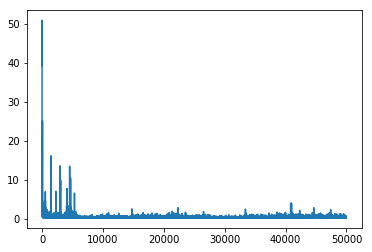

In [20]:
table = []
string = []
runtime = []
for i in range(50000):
    start_time = tm.time()
    store = populate(100)
    #clean = peakValleyFilter(shifter(discretize(peakValleyFilter(hysterisFilter(p)))))
    path = label(store[4])
    #print(path)
    rec_plot(store[0],path[0])
    project(store[0],path[1])
    cleanRec(store[0],path[2])
    
    print('Iteration: ',i)
    #display(store[0])
    #plt.plot(store[0])
    #plt.show()
    #display(img)
    print('Number of approximate solver sequences for size',len(store[0]),':', store[4])
    
    stri = 'Data' + str(i)
    arr = store[0].tolist()
    for j in range(1,5): arr.append(store[j])    
    arr.append(path[0])
    arr.append(path[1])
    arr.append(path[2])
    table.append(arr)
    string.append(stri)
    
    duration = tm.time() - start_time
    runtime.append(duration)
    print('Runtime: %s seconds' % (duration))
    
data = pd.DataFrame(table, index = string)
col = len(data.columns)
data.rename(columns={col-7: 'Sig', col-6: 'D', col-5: 'E', col-4: 'Sequences', col-3: 'Rec-Plot', col-2: 'Projection', col-1: 'Clean-Rec-Plot'}, inplace=True)
display(data)

plt.show()
plt.plot(runtime)
plt.show()

with open('VibrationsV5.csv', 'a') as fd:
    data.to_csv(fd, header=True)
    
#data.to_csv("Vibrations.csv")

In [21]:
#display(strainDatabase)
SD = pd.DataFrame.from_dict(strainDatabase, orient = 'index', columns=['Life'])
#display(SD)
SD.to_csv('SDV5.csv', header=True)

In [22]:
vibData = pd.read_csv("VibrationsV5.csv", index_col=0)
display(vibData)
strainData = pd.read_csv("SDV5.csv", index_col=0)
display(strainData)

0         1         2         3         4         5  \
Data0      1.128895  2.042401  3.262979  2.322401  3.217001  3.340506   
Data1     -1.928081 -2.408162  0.112551  0.909944 -0.758965 -2.349278   
Data2      0.175330  1.362533  0.177050 -1.808829 -0.870193 -1.763082   
Data3     -1.654047 -2.536065 -2.253545 -2.239065  1.186897  0.611741   
Data4      0.603538  0.968483 -0.260550  0.849858 -0.857646 -0.724033   
Data5     -0.526511 -1.073696 -2.116696 -1.655111 -1.916866 -0.030671   
Data6     -0.651850  0.256154  0.052341 -0.072218  0.153247  0.325623   
Data7     -2.955025 -1.002789 -1.087811 -1.378345 -1.235775 -0.182661   
Data8      1.413456  2.793099  1.576902  0.867494 -0.867115  0.860196   
Data9      1.457568  2.622431  1.464249  0.438274  0.837550  3.126522   
Data10    -0.541980 -1.317752 -1.287190 -2.287718 -0.256922 -1.277718   
Data11    -1.850949 -3.346877 -1.986640 -2.593461 -3.333948 -0.560960   
Data12    -2.477103 -2.079264 -3.193266 -1.121026 -1.996498 -3.096731   
Data13     1.092766  0.466324  1.342576  1.845096  0.155001  0.794118   
Data14     1.188137  2.009546  0.678885  0.387510  2.302293  1.540213   
Data15     0.925282  0.257729  0.391455 -0.676919 -2.013682 -0.703997   
Data16    -0.061859  0.480539  1.567274  1.651446  1.759896  3.077359   
Data17     1.842598  1.100180  0.769440  1.000527  2.474021  1.817640   
Data18     1.578659  0.354581 -1.816476 -1.561867 -2.944158 -3.161393   
Data19    -1.516972 -1.560266  0.445992  0.271078  0.999437  0.210595   
Data20     1.900577  1.403740  1.944312  0.084009  0.754545  3.596154   
Data21     0.719970 -0.175210 -0.190735 -2.431816 -1.483434 -1.090949   
Data22    -1.141862 -1.006568 -0.190938 -0.094933 -1.425600  0.427247   
Data23    -1.160401  0.115485 -0.173554 -0.943884 -1.915803 -2.990946   
Data24    -0.052888  1.836965  0.782336  1.314054  1.242159  2.127800   
Data25    -0.518768 -0.646836 -0.420807 -0.623006 -0.486424 -0.051739   
Data26    -0.431029 -0.278815  0.053593  1.236714  1.375488  0.242753   
Data27     1.679424  2.045162  2.289767  4.541546  4.026935  4.414938   
Data28    -2.424993 -3.822381 -2.183725 -2.125869 -0.392296  2.352396   
Data29     2.148005  1.274674  1.680263  2.412913  4.083067  3.361157   
...             ...       ...       ...       ...       ...       ...   
Data49970 -0.041411 -0.629883  0.565648  0.343260 -0.170871 -0.129485   
Data49971  1.592706  1.492923  1.690636  0.043291  1.335851 -0.192505   
Data49972  0.651190  0.544702  1.125833  2.317724  2.874116  2.090493   
Data49973  0.473705  0.292448 -0.926528 -0.143559 -2.028651 -3.335751   
Data49974  1.312396  1.485788  0.906779 -0.391501 -1.446382 -1.518198   
Data49975  0.040187 -0.081184  1.316660  1.509094  1.341415  0.159085   
Data49976 -0.086019  0.039644 -2.214477 -2.530699 -3.302383 -2.593066   
Data49977 -0.135950 -1.905905 -2.323717 -1.561591 -2.050829 -2.836307   
Data49978 -0.398334 -1.671277 -1.619646 -1.045570  0.007855  2.199955   
Data49979 -0.134219 -0.557573 -1.812717 -1.690851 -1.547650 -2.299710   
Data49980 -0.302895 -0.129412 -0.025621 -0.385324 -0.882416  0.187476   
Data49981  0.641097  1.860064  3.548920  4.483968  5.745213  5.782066   
Data49982  0.275398 -0.570039 -0.319457 -0.049047  0.417964  1.989708   
Data49983 -1.008774 -3.130699 -2.914596 -3.280530 -3.049693 -2.275327   
Data49984 -0.464502  0.649079 -0.044215 -0.156753 -1.519708 -1.701341   
Data49985  0.431665 -0.481996 -1.737343 -0.810441 -2.122118 -1.724366   
Data49986  0.196793  1.196553 -0.216118 -1.845887 -2.209500 -0.339541   
Data49987 -0.191290 -3.297998 -2.747396 -2.760846 -1.626491 -1.957023   
Data49988  0.146883  1.314812  0.335492  1.519490  2.847949  3.359524   
Data49989  1.536615  2.657761  1.594703  0.300587  1.403003  0.493105   
Data49990 -0.248565 -0.556983  0.309011  0.343360  1.229030  0.605947   
Data49991 -0.739989 -1.986518 -2.029538 -1.407386 -0.068728  0.694551   
Data49992  2.321699  3.771224  4.439623  5.421271  3.111871  3.157643   
Dat

Life
0.01190  2.670361e+03
0.00067  4.988773e+08
0.00059  1.396554e+09
0.00104  1.734342e+07
0.00062  9.331505e+08
0.00045  1.293758e+10
0.00627  1.101872e+04
0.00094  3.602568e+07
0.00037  6.552926e+10
0.00082  1.012245e+08
0.00025  1.708850e+12
0.00057  1.850404e+09
0.00096  3.085691e+07
0.00012  7.733590e+14
0.00080  1.225668e+08
0.00086  7.024171e+07
0.00021  7.300751e+12
0.00107  1.420701e+07
0.00035  1.039685e+11
0.00071  3.136921e+08
0.00054  2.880695e+09
0.00032  2.189946e+11
0.00099  2.466575e+07
0.00007  6.903073e+16
0.00092  4.225622e+07
0.00063  8.196824e+08
0.00126  4.794594e+06
0.01468  1.745372e+03
0.00213  3.113469e+05
0.00130  3.944672e+06
...               ...
0.03727  3.005427e+02
0.03762  2.955009e+02
0.02945  4.620200e+02
0.03083  4.246995e+02
0.03356  3.636259e+02
0.03199  3.968953e+02
0.03141  4.104238e+02
0.02833  4.962936e+02
0.03780  2.929601e+02
0.03331  3.686206e+02
0.04155  2.470198e+02
0.03036  4.368553e+02
0.04092  2.539025e+02
0.03157  4.066195e+02
0.03470  3.421571e+02
0.03733  2.996687e+02
0.02791  5.101971e+02
0.03529  3.318260e+02
0.02866  4.857864e+02
0.03295  3.760067e+02
0.02840  4.940349e+02
0.02995  4.479169e+02
0.03023  4.403153e+02
0.04348  2.276824e+02
0.04030  2.609786e+02
0.04316  2.307186e+02
0.03220  3.921710e+02
0.03408  3.535752e+02
0.03305  3.739316e+02
0.03205  3.955363e+02

[3204 rows x 1 columns]

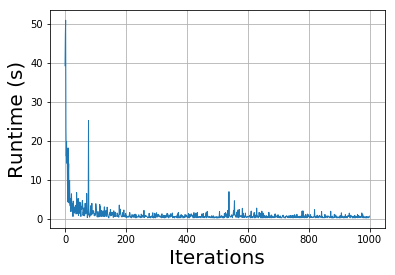

In [30]:
#plt.figure(num=None, figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
plt.grid()
plt.ylabel('Runtime (s)', fontsize=20)
plt.xlabel('Iterations', fontsize=20)
plt.plot(runtime[:1000], linewidth= 1)
#plt.savefig('Cleanup/Runtime.png', dpi = 600, bbox_inches='tight')
plt.show()

In [31]:
from statistics import mean
mean(runtime)